# Qunatum Spin Liquid

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# U(1) Case

# <h2> T = 0, h = 0 case !

# <h3> $\chi = \frac{1}{N}\sum_{i,j}<f_{i,up}^\dagger f_{j,up}>$ is the mean field parameter for the U(1) QSL phase.

In [2]:
import numpy as np
import scipy.integrate as spi
from scipy.optimize import root_scalar

# Define the integrand function
def integrand(x, y,h):
    u = np.cos(x)
    v = np.cos(y)
    theta = 1 if (u + v) > h/2 else 0
    return (u + v) * theta

#do the intrgral
integral, error = spi.dblquad(lambda y, x: integrand(x, y,0), 
                                  -np.pi, np.pi, 
                                  lambda x: -np.pi, lambda x: np.pi)
print(integral/(4*np.pi**2))

0.4052847341561557


# <h3> Checking the consistency that each site containing exactly one spinon or $ <f_{i\alpha}^\dagger f_{i\alpha}> = 1$

In [3]:
import numpy as np
import scipy.integrate as spi

# Define the integrand function
def integrand(x, y, a, j, h):
    u = np.sin(x)
    v = np.sin(y)
    theta = 1 if j * a * (u + v) >= h/2 else 0
    return 2*theta/(4*np.pi**2)

# Define the parameters
a = 0.81  # Example value
j = 1  # Example value
h = 0  # Example value

# Define the ranges for x and y
x_min, x_max = -np.pi, np.pi
y_min, y_max = -np.pi, np.pi

# Perform the double integration
result, error = spi.dblquad(integrand, x_min, x_max, lambda x: y_min, lambda x: y_max, args=(a, j, h))

print(f"The number of spinon per site is: {result}")
print(f"The error estimate of the integration is: {error}")


The number of spinon per site is: 1.0000104803621048
The error estimate of the integration is: 0.00010219822728574357


/home/jabed/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


# <h2> T = 0, $h \neq 0$ case !

# <h3> Finding the $\chi_1 = \frac{1}{N}\sum_{i,j}<f_{i,up}^\dagger f_{j,up}>$ , $\chi_2 = \frac{1}{N}\sum_{i,j}<f_{i,down}^\dagger f_{j,down}>$ and $\mu$ self consistently.

In [4]:
import numpy as np
from tqdm import trange

# Define the grid points
N_x = N_y = 200
k_x = []
k_y = []
for i in trange(N_x):
    k_x.append(-np.pi + 2 * np.pi * i / N_x)
    k_y.append(-np.pi + 2 * np.pi * i / N_y)

# Define the chi_1 and chi_2 integrals
def solve_chi_N(a, b, j, h, tol=1e-6, max_iter=10):
    def integrand_1(x, y, a_1, J, h, mu):
        u = np.exp(-1j * x)
        v = np.exp(-1j * y)
        theta_1 = 1 if J*(np.conjugate(a_1 * (u + v)) + a_1 * (u + v)) / 2 + h/2 - mu >= 0 else 0
        return theta_1 * (u + v)

    def integrand_2(x, y, a_2, J, h, mu):
        u = np.exp(1j * x)
        v = np.exp(1j * y)
        theta_2 = 1 if J * (np.conjugate(a_2 * (u + v)) + a_2 * (u + v)) / 2 - h/2 - mu >= 0 else 0
        return theta_2 * (u + v)

    def chi_integral_1(a, j, h, mu):
        integral = 0
        for i in range(N_x):
            for j in range(N_y):
                integral += integrand_1(k_x[i], k_y[j], a, j, h, mu)
        return integral / (N_x * N_y)

    def chi_integral_2(a, j, h, mu):
        integral = 0
        for i in range(N_x):
            for j in range(N_y):
                integral += integrand_2(k_x[i], k_y[j], a, j, h, mu)
        return integral / (N_x * N_y)

    # Define the number of spinons per site
    def number_of_spinons_per_site(x, y, a_1, a_2, j, h, mu):
        u = np.exp(-1j * x)
        v = np.exp(-1j * y)
        theta_1 = 1 if j*(np.conjugate(a_1 * (u + v)) + a_1 * (u + v)) / 2 + h/2 - mu >= 0 else 0
        theta_2 = 1 if j*(np.conjugate(a_2 * (u + v)) + a_2 * (u + v)) / 2 - h/2 - mu >= 0 else 0
        return (theta_1) / (N_x * N_y), (theta_2) / (N_x * N_y)

    def Number(a_1, a_2, j, h, mu):
        integral_1 = 0
        integral_2 = 0
        for i in range(N_x):
            for j in range(N_y):
                spinons_1, spinons_2 = number_of_spinons_per_site(k_x[i], k_y[j], a_1, a_2, j, h, mu)
                integral_1 += spinons_1
                integral_2 += spinons_2
        return integral_1, integral_2

    c = a
    d = b
    mu_values = [1e-5]
    parameters_converged_mu = None
    for mu in mu_values:
        for iteration in trange(max_iter):
            chi_1_new = chi_integral_1(c, j, h, mu)
            chi_2_new = chi_integral_2(d, j, h, mu)
            Number_new_1 = Number(c, d, j, h, mu)[0]
            Number_new_2 = Number(c, d, j, h, mu)[1]
            if abs(chi_1_new - c) < tol and abs(chi_2_new - d) < tol:
                parameters_converged_mu = mu
                print("Parameters Converged")
                # break
            c = chi_1_new
            d = chi_2_new
            Number_new_1 = Number(c, d, j, h, mu)[0]
            Number_new_2 = Number(c, d, j, h, mu)[1]
            if abs(Number_new_1 + Number_new_2 - 1) < tol*10:
                print("Number Converged")
                return c, d, mu, Number_new_1, Number_new_2
            print(mu, Number_new_1, Number_new_2, (Number_new_1 + Number_new_2))
        else:
            continue
        break

    if parameters_converged_mu is not None:
        mu = parameters_converged_mu
        Number_new_1 = Number(c, d, j, h, mu)[0]
        Number_new_2 = Number(c, d, j, h, mu)[1]
    
    return c, d, mu, Number_new_1, Number_new_2

100%|██████████| 200/200 [00:00<00:00, 331172.84it/s]


In [5]:
# Parameters 
j = 1.0
h = 0.1
a = np.random.rand()
b = np.random.rand()
chi_1, chi_2, mu, Number_new_1, Number_new_2 = solve_chi_N(a, b, j, h, 1e-4, 5)
print(f"The value of chi_1 is: {chi_1}")
print(f"The value of chi_2 is: {chi_2}")
# print(f"The value of chi_2 is: {np.abs(chi_2)}")
print(f"The value of mu is : {mu}")
print(f"The up spinon per site is equal to: {Number_new_1}")
print(f"The down spinon per site is equal to: {Number_new_2}")
print(f"The total number of spinons per site is equal to: {Number_new_1 + Number_new_2}")

 20%|██        | 1/5 [00:00<00:03,  1.00it/s]

1e-05 0.9339750000008649 0.17454999999998486 1.1085250000008497


 40%|████      | 2/5 [00:01<00:02,  1.00it/s]

1e-05 0.9730250000009473 0.12719999999999007 1.1002250000009373


 60%|██████    | 3/5 [00:02<00:01,  1.02it/s]

1e-05 1.000000000001004 0.10479999999999254 1.1048000000009965


 60%|██████    | 3/5 [00:03<00:02,  1.32s/it]

Number Converged
The value of chi_1 is: (-1.1597389715234385e-16-2.6108629147536533e-16j)
The value of chi_2 is: (0.13248159397520487+0.007415501717666853j)
The value of mu is : 1e-05
The up spinon per site is equal to: 1.000000000001004
The down spinon per site is equal to: 0.0
The total number of spinons per site is equal to: 1.000000000001004


In [35]:
# #plot chi_1 and chi_2 as a function of h
# import matplotlib.pyplot as plt
# h_values = np.linspace(0.0, 5, 40)
# j = 1.0
# a = np.random.rand()
# b = np.random.rand()
# # mu_values = np.linspace(0, 2, 5)
# chi_1_values_r = []
# chi_1_values_i = []
# chi_2_values_r = []
# chi_2_values_i = []
# Number_new_1_values = []
# Number_new_2_values = []
# mu_t = []
# total = []
# for h in h_values:
#     chi_1, chi_2, mu, Number_new_1, Number_new_2 = solve_chi_N(a, b, j, h, 1e-4, 5)
#     chi_1_values_r.append((chi_1).real)
#     chi_2_values_r.append((chi_2).real)
#     #chi_1_values_i.append((chi_1).imag)
#     #chi_2_values_i.append((chi_2).imag)
#     mu_t.append(mu)
#     Number_new_1_values.append(Number_new_1)
#     Number_new_2_values.append(Number_new_2)
#     total.append(Number_new_1 + Number_new_2)

# <h3> Band structure of the spinon for T = 0, h = 0 case !

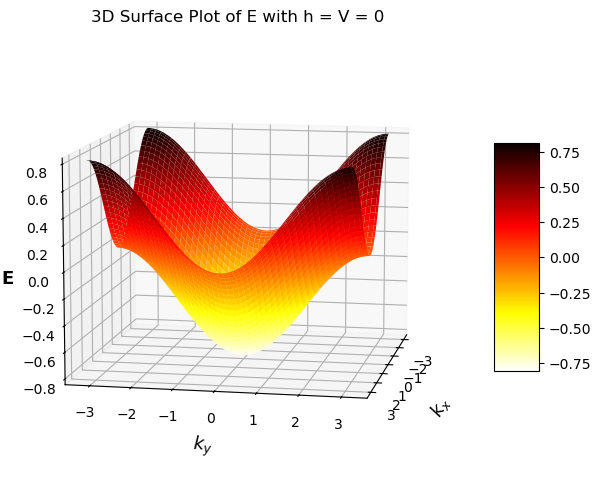

In [49]:
# parametrs
J = 1 

# Create k_x and k_y
k_x = np.linspace(-np.pi, np.pi, 100)
k_y = np.linspace(-np.pi, np.pi, 100)

# Create meshgrid for k_x and k_y
K_x, K_y = np.meshgrid(k_x, k_y)

# Calculate E
E = -4 * J * (np.cos(K_x) + np.cos(K_y))/(np.pi**2)

# Plotting the 3D surface plot
fig = plt.figure(figsize=(12, 6))

# 3D plot
ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(K_x, K_y, E, cmap='hot_r')
#make the xticks and yticks to be in terms bold 
# plt.xticks(fontsize=10, fontweight='bold')
# plt.yticks(fontweight='bold')
#rotate the plot
ax.view_init(10, 11)
ax.set_xlabel('$k_x$', labelpad=10, fontsize=13, rotation=150, fontweight='bold')
ax.set_ylabel('$k_y$', labelpad=10, fontsize=13, rotation=150, fontweight='bold')
ax.set_zlabel('E', fontsize=13, rotation=0, fontweight='bold')
ax.set_title('3D Surface Plot of E with h = V = 0')

# Adding color bar
fig.colorbar(surf, ax=ax, shrink=0.4, aspect=5)

plt.tight_layout()
plt.show()


# <h3> Band structure of the spinon for T = 0, $h \neq 0$ case !

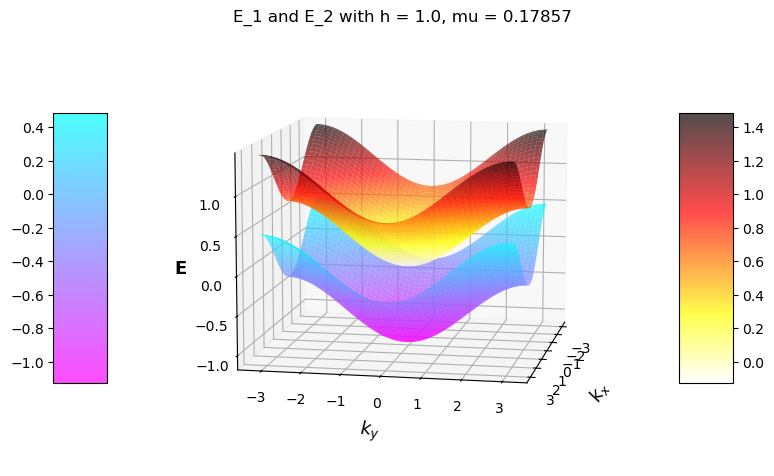

In [47]:
# parametrs
J = 1 
chi_1 = (0.40277345119775787+0.0007704033486525024j)
chi_2 = (0.4051555809762227+0.00031150554097031727j)
h = 1.0
mu = 0.17857
# Create k_x and k_y
k_x = np.linspace(-np.pi, np.pi, 100)
k_y = np.linspace(-np.pi, np.pi, 100)

# Create meshgrid for k_x and k_y
K_x, K_y = np.meshgrid(k_x, k_y)

# Calculate E
E_1 = -J * (np.conjugate(chi_1*(np.exp(1j*K_x) + np.exp(1j*K_y))) + chi_1*(np.exp(1j*K_x) + np.exp(1j*K_y)))/2 - h/2 + mu
E_2 = -J * (np.conjugate(chi_1*(np.exp(1j*K_x) + np.exp(1j*K_y))) + chi_1*(np.exp(1j*K_x) + np.exp(1j*K_y)))/2 + h/2 + mu

# Plot E_1 and E_2 in the same graph
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot E_1
surf1 = ax.plot_surface(K_x, K_y, E_1, cmap='cool_r', alpha=0.7, label='E_1')

# Plot E_2
surf2 = ax.plot_surface(K_x, K_y, E_2, cmap='hot_r', alpha=0.7, label='E_2')

# Adding labels and title
ax.set_title(f'E_1 and E_2 with h = {h}, mu = {mu}')
ax.set_xlabel('$k_x$', labelpad=10, fontsize=13, rotation=150, fontweight='bold')
ax.set_ylabel('$k_y$', labelpad=10, fontsize=13, rotation=150, fontweight='bold')
ax.set_zlabel('E', fontsize=13, rotation=0, fontweight='bold')
ax.view_init(10, 11)
# Adding colorbars for each surface plot
fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=5, pad=0.1, location='left')
fig.colorbar(surf2, ax=ax, shrink=0.5, aspect=5, pad=0.1, location='right')

plt.show()

# <h2> Theromdynamics of U(1) Spin Liquid
# <h2> T $\neq$ 0, h = 0 case !

In [3]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from tqdm import trange
N_x = N_y = 1000
k_x = []
k_y = []
for i in trange(N_x):
    k_x.append(-np.pi + 2 * np.pi * i / N_x)
    k_y.append(-np.pi + 2 * np.pi * i / N_y)
def solve_chi_N(a, b, T, j, h, mu, tol=1e-6, max_iter=10):
    beta = 1/T
    def FD_distribution(energy, beta):
        return 1/(np.exp(beta*energy) + 1)

    def integrand_1(x, y, a_1, J, h, mu, beta):
        u = np.exp(-1j * x)
        v = np.exp(-1j * y)
        FD = FD_distribution(-J*(np.conjugate(a_1 * (u + v)) + a_1 * (u + v)) / 2 - h/2 + mu, beta)
        return FD* (u + v)
    
    def integrand_2(x, y, a_2, J, h, mu, beta):
        u = np.exp(-1j * x)
        v = np.exp(-1j * y)
        FD = FD_distribution(-J*(np.conjugate(a_2 * (u + v)) + a_2 * (u + v)) / 2 + h/2 + mu, beta)
        return FD* (u + v)

    def chi_integral_1(a, j, h, mu, beta):
        integral = 0
        for i in range(N_x):
            for j in range(N_y):
                integral += integrand_1(k_x[i], k_y[j], a, j, h, mu, beta)
        return integral / (N_x * N_y)
    
    def chi_integral_2(a, j, h, mu, beta):
        integral = 0
        for i in range(N_x):
            for j in range(N_y):
                integral += integrand_2(k_x[i], k_y[j], a, j, h, mu, beta)
        return integral / (N_x * N_y)
    
    # Define the number of spinons per site
    def number_of_spinons_per_site(x, y, a_1, a_2, j, h, mu, beta):
        u = np.exp(-1j * x)
        v = np.exp(-1j * y)
        theta_1 = FD_distribution(-j*(np.conjugate(a_1 * (u + v)) + a_1 * (u + v)) / 2 - h/2 + mu, beta)
        theta_2 = FD_distribution(-j*(np.conjugate(a_2 * (u + v)) + a_2 * (u + v)) / 2 + h/2 + mu, beta)
        return (theta_1) / (N_x * N_y), (theta_2) / (N_x * N_y)

    def Number(a_1, a_2, j, h, mu, beta):
        integral_1 = 0
        integral_2 = 0
        for i in range(N_x):
            for j in range(N_y):
                spinons_1, spinons_2 = number_of_spinons_per_site(k_x[i], k_y[j], a_1, a_2, j, h, mu, beta)
                integral_1 += spinons_1
                integral_2 += spinons_2
        return integral_1, integral_2
    
    c = a
    d = b
    mu_values = np.linspace(0, 0.1, 10)
    parameters_converged_mu = None
    for mu in mu_values:
        for iteration in trange(max_iter):
            chi_1_new = chi_integral_1(c, j, h, mu, beta)
            chi_2_new = chi_integral_2(d, j, h, mu, beta)
            Number_new_1 = Number(c, d, j, h, mu, beta)[0]
            Number_new_2 = Number(c, d, j, h, mu, beta)[1]
            if abs(chi_1_new - c) < tol and abs(chi_2_new - d) < tol:
                parameters_converged_mu = mu
                print("Parameters Converged")
                # break
            c = chi_1_new
            d = chi_2_new
            Number_new_1 = Number(c, d, j, h, mu, beta)[0]
            Number_new_2 = Number(c, d, j, h, mu, beta)[1]
            if abs(Number_new_1 + Number_new_2 - 1) < tol*10:
                print("Number Converged")
                return c, d, mu, Number_new_1, Number_new_2
            print(mu, Number_new_1, Number_new_2, (Number_new_1 + Number_new_2))
        else:
            continue
        break

    if parameters_converged_mu is not None:
        mu = parameters_converged_mu
        Number_new_1 = Number(c, d, j, h, mu)[0]
        Number_new_2 = Number(c, d, j, h, mu)[1]
    
    return c, d, mu, Number_new_1, Number_new_2

100%|██████████| 1000/1000 [00:00<00:00, 556790.65it/s]


# $\mathbf{Z_2}$ case

# <h2> T = h = 0 case !

# <h3> Order parameter  $\chi = \frac{1}{N}\sum_{i,j}<f_{i\alpha}^\dagger f_{j\beta}^\dagger>\epsilon_{\alpha\beta}$ 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi

# Define the integrand function
def integrand(x, y,h):
    u = np.cos(x)
    v = np.cos(y)
    theta_1 = 1 if (u + v) > h/2 else 0
    theta_2 = 1 if (u + v) < -h/2 else 0

    return (u + v) * theta_1 - (u + v) * theta_2

#do the intrgral
integral, error = spi.dblquad(lambda y, x: integrand(x, y,0), 
                                  -np.pi, np.pi, 
                                  lambda x: -np.pi, lambda x: np.pi)
print(integral/(4*np.pi**2))

0.8105694681061814


# <h3> Band structure 

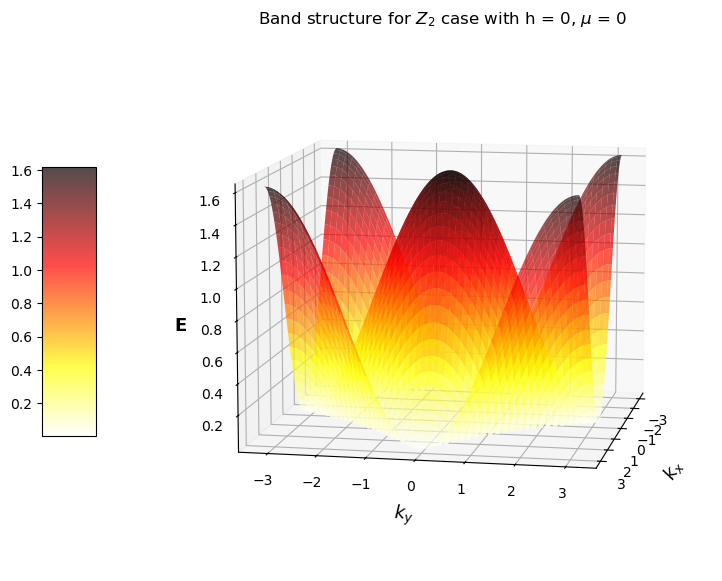

In [10]:
# parametrs
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
J = 1 
chi_1 = 0.8105694681061814
h = 0
mu = 0
# Create k_x and k_y
k_x = np.linspace(-np.pi, np.pi, 100)
k_y = np.linspace(-np.pi, np.pi, 100)

# Create meshgrid for k_x and k_y
K_x, K_y = np.meshgrid(k_x, k_y)

# Calculate E
E_1 = np.sqrt(mu**2 + (J*(np.cos(K_x) + np.cos(K_y))*(chi_1))**2)

# Plot E_1 and E_2 in the same graph
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot E_1
surf1 = ax.plot_surface(K_x, K_y, (E_1), cmap='hot_r', alpha=0.7, label='E_1')

# Adding labels and title
ax.set_title(f'Band structure for $Z_2$ case with h = {h}, $\mu$ = {mu}')
ax.set_xlabel('$k_x$', labelpad=10, fontsize=13, rotation=150, fontweight='bold')
ax.set_ylabel('$k_y$', labelpad=10, fontsize=13, rotation=150, fontweight='bold')
ax.set_zlabel('E', fontsize=13, rotation=0, fontweight='bold')
ax.view_init(10, 11)
# Adding colorbars for each surface plot
fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=5, pad=0.1, location='left')

plt.show()

# <h2> T = 0, h $\neq$ 0 case !

In [13]:
import numpy as np
from tqdm import trange

# Define the grid points
N_x = N_y = 300

k_x = []
k_y = []
for i in trange(N_x):
    k_x.append(-np.pi + 2 * np.pi * i / N_x)
    k_y.append(-np.pi + 2 * np.pi * i / N_y)

# Define the chi_1 and chi_2 integrals
def solve_chi_N(a, j, h, tol=1e-6, max_iter=10):
    def integrand_1(x, y, a_1, J, h, mu):
        D = np.sqrt(mu**2 + (J*(np.cos(x) + np.cos(y))*abs((a_1)))**2)
        theta_1 = 1 if - D + h/2 >= 0 else 0
        theta_2 = 1 if - D - h/2 >=0 else 0
        return (J*((np.cos(x) + np.cos(y))**2)*abs(a_1)*(1 - theta_1 - theta_2))/D
    def chi_integral_1(a, j, h, mu):
        integral = 0
        for i in range(N_x):
            for j in range(N_y):
                integral += integrand_1(k_x[i], k_y[j], a, j, h, mu)
        return (integral / (N_x * N_y))

    # Define the number of spinons per site
    def number_of_spinons_per_site(x, y, a_1, j, h, mu):
        D = np.sqrt(mu**2 + (j*(np.cos(x) + np.cos(y))*abs((a_1)))**2)
        theta_1 = 1 if - D + h/2 >= 0 else 0
        theta_2 = 1 if - D - h/2 >=0 else 0
        S = mu/D
        return (((1 -  S)*(1 - theta_2)) + (1 + S)*theta_1) / (2*N_x * N_y), (((1 -  S)*(1 - theta_1)) + (1 + S)*theta_2) / (2*N_x * N_y)
    
    def Number(a_1, j, h, mu):
        integral_1 = 0
        integral_2 = 0
        for i in range(N_x):
            for j in range(N_y):
                spinons_1, spinons_2 = number_of_spinons_per_site(k_x[i], k_y[j], a_1, j, h, mu)
                integral_1 += spinons_1
                integral_2 += spinons_2
        return integral_1, integral_2

    c = a
    # d = b
    mu_values = np.linspace( 0.01931, 2.6900000000000003e-05, 20)
    parameters_converged_mu = None
    for mu in mu_values:
        for iteration in trange(max_iter):
            chi_1_new = chi_integral_1(c, j, h, mu)
            # chi_2_new = chi_integral_2(d, j, h, mu)
            Number_new_1 = Number(c, j, h, mu)[0]
            Number_new_2 = Number(c, j, h, mu)[1]
            if abs(abs(chi_1_new) - c) < tol :
                # parameters_converged_mu = mu
                print("Parameters Converged")
                # break
            c = chi_1_new
            # d = chi_2_new
            Number_new_1 = Number(c, j, h, mu)[0]
            Number_new_2 = Number(c, j, h, mu)[1]
            if abs(Number_new_1 + Number_new_2 - 1) < tol*3:
                print("Number Converged")
                return c, mu, Number_new_1, Number_new_2
            print(mu, Number_new_1, Number_new_2, (Number_new_1 + Number_new_2))
        else:
            continue
        break

    if parameters_converged_mu is not None:
        mu = parameters_converged_mu
        Number_new_1 = Number(c, j, h, mu)[0]
        Number_new_2 = Number(c, j, h, mu)[1]
    
    return c, mu, Number_new_1, Number_new_2

100%|██████████| 300/300 [00:00<00:00, 448908.74it/s]


In [14]:
#define parameters
J = 1 
chi_1 = np.random.rand()
# chi_2 = np.random.rand()
h = 1
solve_chi_N(chi_1, J, h, 1e-4, 5)

 20%|██        | 1/5 [00:02<00:09,  2.28s/it]

0.01931 0.5102286933444119 0.4884731377888518 0.9987018311332637


 40%|████      | 2/5 [00:04<00:06,  2.08s/it]

0.01931 0.5102291740622019 0.4884736185066373 0.9987027925688392
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.05s/it]

0.01931 0.5102291740636883 0.48847361850812315 0.9987027925718115
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.09s/it]

0.01931 0.5102291740636883 0.48847361850812315 0.9987027925718115
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.06s/it]


0.01931 0.5102291740636883 0.48847361850812315 0.9987027925718115


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.10s/it]

0.0182951 0.5102632569710778 0.48850770141551697 0.9987709583865947
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.10s/it]

0.0182951 0.5102632569710781 0.4885077014155173 0.9987709583865954
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.06s/it]

0.0182951 0.5102632569710781 0.4885077014155173 0.9987709583865954
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.04s/it]

0.0182951 0.5102632569710781 0.4885077014155173 0.9987709583865954
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.04s/it]


0.0182951 0.5102632569710781 0.4885077014155173 0.9987709583865954


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.00s/it]

0.017280200000000003 0.5102973409425459 0.48854178538698134 0.9988391263295272
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.07s/it]

0.017280200000000003 0.5102973409425461 0.4885417853869816 0.9988391263295278
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.07s/it]

0.017280200000000003 0.5102973409425461 0.4885417853869816 0.9988391263295278
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.12s/it]

0.017280200000000003 0.5102973409425461 0.4885417853869816 0.9988391263295278
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


0.017280200000000003 0.5102973409425461 0.4885417853869816 0.9988391263295278


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.08s/it]

0.0162653 0.5103314259192446 0.48857587036368044 0.9989072962829251
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.03s/it]

0.0162653 0.5103314259192449 0.4885758703636808 0.9989072962829256
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.05s/it]

0.0162653 0.5103314259192449 0.4885758703636808 0.9989072962829256
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.07s/it]

0.0162653 0.5103314259192449 0.4885758703636808 0.9989072962829256
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.06s/it]


0.0162653 0.5103314259192449 0.4885758703636808 0.9989072962829256


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.01s/it]

0.0152504 0.5103655118422852 0.4886099562867196 0.9989754681290048
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.02s/it]

0.0152504 0.5103655118422853 0.4886099562867196 0.9989754681290048
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.05s/it]

0.0152504 0.5103655118422853 0.4886099562867196 0.9989754681290048
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.06s/it]

0.0152504 0.5103655118422853 0.4886099562867196 0.9989754681290048
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.04s/it]


0.0152504 0.5103655118422853 0.4886099562867196 0.9989754681290048


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.06s/it]

0.014235500000000002 0.5103995986527607 0.488644043097199 0.9990436417499597
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.12s/it]

0.014235500000000002 0.5103995986527609 0.48864404309719917 0.99904364174996
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.07s/it]

0.014235500000000002 0.5103995986527609 0.48864404309719917 0.99904364174996
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.05s/it]

0.014235500000000002 0.5103995986527609 0.48864404309719917 0.99904364174996
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


0.014235500000000002 0.5103995986527609 0.48864404309719917 0.99904364174996


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

0.0132206 0.5104336862917559 0.48867813073619476 0.9991118170279507
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.64s/it]

0.0132206 0.510433686291756 0.48867813073619487 0.9991118170279509
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.69s/it]

0.0132206 0.510433686291756 0.48867813073619487 0.9991118170279509
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.68s/it]

0.0132206 0.510433686291756 0.48867813073619487 0.9991118170279509
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


0.0132206 0.510433686291756 0.48867813073619487 0.9991118170279509


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.62s/it]

0.0122057 0.5104677747002976 0.4887122191447336 0.9991799938450312
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.56s/it]

0.0122057 0.5104677747002976 0.4887122191447337 0.9991799938450312
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

0.0122057 0.5104677747002976 0.4887122191447337 0.9991799938450312
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.53s/it]

0.0122057 0.5104677747002976 0.4887122191447337 0.9991799938450312
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.0122057 0.5104677747002976 0.4887122191447337 0.9991799938450312


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.58s/it]

0.0111908 0.5105018638193992 0.4887463082638341 0.9992481720832334
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.0111908 0.5105018638193992 0.48874630826383414 0.9992481720832334
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.0111908 0.5105018638193992 0.48874630826383414 0.9992481720832334
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.0111908 0.5105018638193992 0.48874630826383414 0.9992481720832334
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.0111908 0.5105018638193992 0.48874630826383414 0.9992481720832334


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.75s/it]

0.010175900000000002 0.5105359535900593 0.4887803980344961 0.9993163516245553
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.60s/it]

0.010175900000000002 0.5105359535900593 0.4887803980344961 0.9993163516245553
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

0.010175900000000002 0.5105359535900593 0.4887803980344961 0.9993163516245553
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.010175900000000002 0.5105359535900593 0.4887803980344961 0.9993163516245553
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.010175900000000002 0.5105359535900593 0.4887803980344961 0.9993163516245553


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.54s/it]

0.009161 0.5105700439532503 0.48881448839768743 0.9993845323509378
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.54s/it]

0.009161 0.5105700439532503 0.48881448839768743 0.9993845323509378
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

0.009161 0.5105700439532503 0.48881448839768743 0.9993845323509378
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.57s/it]

0.009161 0.5105700439532503 0.48881448839768743 0.9993845323509378
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.009161 0.5105700439532503 0.48881448839768743 0.9993845323509378


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.58s/it]

0.0081461 0.5106041348499292 0.48884857929436404 0.9994527141442933
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.0081461 0.5106041348499292 0.48884857929436404 0.9994527141442933
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

0.0081461 0.5106041348499292 0.48884857929436404 0.9994527141442933
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.67s/it]

0.0081461 0.5106041348499292 0.48884857929436404 0.9994527141442933
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


0.0081461 0.5106041348499292 0.48884857929436404 0.9994527141442933


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.63s/it]

0.007131200000000001 0.5106382262210348 0.48888267066546964 0.9995208968865045
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.59s/it]

0.007131200000000001 0.5106382262210348 0.4888826706654697 0.9995208968865046
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.55s/it]

0.007131200000000001 0.5106382262210348 0.4888826706654697 0.9995208968865046
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.53s/it]

0.007131200000000001 0.5106382262210348 0.4888826706654697 0.9995208968865046
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.54s/it]


0.007131200000000001 0.5106382262210348 0.4888826706654697 0.9995208968865046


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.72s/it]

0.006116300000000002 0.5106723180074867 0.48891676245192506 0.9995890804594117
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.58s/it]

0.006116300000000002 0.5106723180074867 0.48891676245192506 0.9995890804594117
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.52s/it]

0.006116300000000002 0.5106723180074867 0.48891676245192506 0.9995890804594117
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.50s/it]

0.006116300000000002 0.5106723180074867 0.48891676245192506 0.9995890804594117
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.52s/it]


0.006116300000000002 0.5106723180074867 0.48891676245192506 0.9995890804594117


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.55s/it]

0.005101400000000001 0.5107064101502069 0.488950854594644 0.999657264744851
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.56s/it]

0.005101400000000001 0.5107064101502069 0.488950854594644 0.999657264744851
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.53s/it]

0.005101400000000001 0.5107064101502069 0.488950854594644 0.999657264744851
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.53s/it]

0.005101400000000001 0.5107064101502069 0.488950854594644 0.999657264744851
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.54s/it]


0.005101400000000001 0.5107064101502069 0.488950854594644 0.999657264744851


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:02<?, ?it/s]

Number Converged


(0.8066091757245631, 0.0040865, 0.5107405025900982, 0.488984947034534)

In [76]:
#plot chi_1 and chi_2 as a function of h
import matplotlib.pyplot as plt
h_values = np.linspace(0.01, 20, 60)
j = 1.0
a = np.random.rand()
# b = np.random.rand()
# mu_values = np.linspace(0, 2, 5)
chi_1_values_r = []
chi_1_values_i = []
# chi_2_values_r = []
# chi_2_values_i = []
Number_new_1_values = []
Number_new_2_values = []
mu_t = []
total = []
Mag = []
for h in h_values:
    chi_1, mu, Number_new_1, Number_new_2 = solve_chi_N(a, j, h, 1e-4, 5)
    chi_1_values_r.append((chi_1).real)
    # chi_2_values_r.append((chi_2).real)
    chi_1_values_i.append((chi_1).imag)
    # chi_2_values_i.append((chi_2).imag)
    mu_t.append(mu)
    Number_new_1_values.append(Number_new_1)
    Number_new_2_values.append(Number_new_2)
    total.append(Number_new_1 + Number_new_2)
    Mag.append(Number_new_1 - Number_new_2)

 20%|██        | 1/5 [00:01<00:07,  1.78s/it]

0.016055401662049863 0.4934847139502736 0.4934847139502736 0.9869694279005472
Parameters Converged


 40%|████      | 2/5 [00:03<00:05,  1.81s/it]

0.016055401662049863 0.49348471403250244 0.49348471403250244 0.9869694280650049
Parameters Converged


 60%|██████    | 3/5 [00:05<00:03,  1.82s/it]

0.016055401662049863 0.49348471403250344 0.49348471403250344 0.9869694280650069
Parameters Converged


 80%|████████  | 4/5 [00:07<00:01,  1.86s/it]

0.016055401662049863 0.49348471403250344 0.49348471403250344 0.9869694280650069
Parameters Converged


100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


0.016055401662049863 0.49348471403250344 0.49348471403250344 0.9869694280650069


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:01<00:07,  1.83s/it]

0.01589349760485744 0.4934968897586727 0.4934968897586727 0.9869937795173453
Parameters Converged


 40%|████      | 2/5 [00:03<00:05,  1.82s/it]

0.01589349760485744 0.4934968897586739 0.4934968897586739 0.9869937795173478
Parameters Converged


 60%|██████    | 3/5 [00:05<00:03,  1.85s/it]

0.01589349760485744 0.4934968897586739 0.4934968897586739 0.9869937795173478
Parameters Converged


 80%|████████  | 4/5 [00:07<00:01,  1.84s/it]

0.01589349760485744 0.4934968897586739 0.4934968897586739 0.9869937795173478
Parameters Converged


100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


0.01589349760485744 0.4934968897586739 0.4934968897586739 0.9869937795173478


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:01<00:07,  1.81s/it]

0.015731593547665016 0.49350909414962413 0.49350909414962413 0.9870181882992483
Parameters Converged


 40%|████      | 2/5 [00:03<00:05,  1.83s/it]

0.015731593547665016 0.4935090941496258 0.4935090941496258 0.9870181882992516
Parameters Converged


 60%|██████    | 3/5 [00:05<00:03,  1.85s/it]

0.015731593547665016 0.4935090941496258 0.4935090941496258 0.9870181882992516
Parameters Converged


 80%|████████  | 4/5 [00:07<00:01,  1.84s/it]

0.015731593547665016 0.4935090941496258 0.4935090941496258 0.9870181882992516
Parameters Converged


100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


0.015731593547665016 0.4935090941496258 0.4935090941496258 0.9870181882992516


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:01<00:07,  1.85s/it]

0.015569689490472594 0.49352132755475947 0.49352132755475947 0.9870426551095189
Parameters Converged


 40%|████      | 2/5 [00:03<00:05,  1.84s/it]

0.015569689490472594 0.49352132755476114 0.49352132755476114 0.9870426551095223
Parameters Converged


 60%|██████    | 3/5 [00:05<00:03,  1.85s/it]

0.015569689490472594 0.49352132755476114 0.49352132755476114 0.9870426551095223
Parameters Converged


 80%|████████  | 4/5 [00:07<00:01,  1.82s/it]

0.015569689490472594 0.49352132755476114 0.49352132755476114 0.9870426551095223
Parameters Converged


100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


0.015569689490472594 0.49352132755476114 0.49352132755476114 0.9870426551095223


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:01<00:07,  1.82s/it]

0.015407785433280172 0.49353359033128963 0.49353359033128963 0.9870671806625793
Parameters Converged


 40%|████      | 2/5 [00:03<00:05,  1.82s/it]

0.015407785433280172 0.4935335903312913 0.4935335903312913 0.9870671806625826
Parameters Converged


 60%|██████    | 3/5 [00:05<00:03,  1.82s/it]

0.015407785433280172 0.4935335903312913 0.4935335903312913 0.9870671806625826
Parameters Converged


 80%|████████  | 4/5 [00:07<00:01,  1.90s/it]

0.015407785433280172 0.4935335903312913 0.4935335903312913 0.9870671806625826
Parameters Converged


100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


0.015407785433280172 0.4935335903312913 0.4935335903312913 0.9870671806625826


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:01<00:07,  1.86s/it]

0.015245881376087749 0.493545882844606 0.493545882844606 0.987091765689212
Parameters Converged


 40%|████      | 2/5 [00:03<00:05,  1.92s/it]

0.015245881376087749 0.4935458828446075 0.4935458828446075 0.987091765689215
Parameters Converged


 60%|██████    | 3/5 [00:05<00:03,  1.92s/it]

0.015245881376087749 0.4935458828446075 0.4935458828446075 0.987091765689215
Parameters Converged


 80%|████████  | 4/5 [00:07<00:01,  1.91s/it]

0.015245881376087749 0.4935458828446075 0.4935458828446075 0.987091765689215
Parameters Converged


100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


0.015245881376087749 0.4935458828446075 0.4935458828446075 0.987091765689215


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:01<00:07,  1.88s/it]

0.015083977318895325 0.4935582054684827 0.4935582054684827 0.9871164109369654
Parameters Converged


 40%|████      | 2/5 [00:03<00:05,  1.86s/it]

0.015083977318895325 0.4935582054684843 0.4935582054684843 0.9871164109369686
Parameters Converged


 60%|██████    | 3/5 [00:05<00:03,  1.87s/it]

0.015083977318895325 0.4935582054684843 0.4935582054684843 0.9871164109369686
Parameters Converged


 80%|████████  | 4/5 [00:07<00:01,  1.89s/it]

0.015083977318895325 0.4935582054684843 0.4935582054684843 0.9871164109369686
Parameters Converged


100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


0.015083977318895325 0.4935582054684843 0.4935582054684843 0.9871164109369686


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:01<00:07,  1.83s/it]

0.014922073261702903 0.49357055858540116 0.49357055858540116 0.9871411171708023
Parameters Converged


 40%|████      | 2/5 [00:03<00:05,  1.84s/it]

0.014922073261702903 0.4935705585854022 0.4935705585854022 0.9871411171708044
Parameters Converged


 60%|██████    | 3/5 [00:05<00:03,  1.84s/it]

0.014922073261702903 0.4935705585854022 0.4935705585854022 0.9871411171708044
Parameters Converged


 80%|████████  | 4/5 [00:07<00:01,  1.87s/it]

0.014922073261702903 0.4935705585854022 0.4935705585854022 0.9871411171708044
Parameters Converged


100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


0.014922073261702903 0.4935705585854022 0.4935705585854022 0.9871411171708044


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:01<00:07,  1.88s/it]

0.01476016920451048 0.4935829425868503 0.4935829425868503 0.9871658851737006
Parameters Converged


 40%|████      | 2/5 [00:03<00:05,  1.91s/it]

0.01476016920451048 0.4935829425868513 0.4935829425868513 0.9871658851737026
Parameters Converged


 60%|██████    | 3/5 [00:05<00:03,  1.90s/it]

0.01476016920451048 0.4935829425868513 0.4935829425868513 0.9871658851737026
Parameters Converged


 80%|████████  | 4/5 [00:07<00:01,  1.89s/it]

0.01476016920451048 0.4935829425868513 0.4935829425868513 0.9871658851737026
Parameters Converged


100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


0.01476016920451048 0.4935829425868513 0.4935829425868513 0.9871658851737026


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:01<00:07,  1.83s/it]

0.014598265147318058 0.49359535787361 0.49359535787361 0.98719071574722
Parameters Converged


 40%|████      | 2/5 [00:03<00:05,  1.92s/it]

0.014598265147318058 0.4935953578736115 0.4935953578736115 0.987190715747223
Parameters Converged


 60%|██████    | 3/5 [00:05<00:03,  1.95s/it]

0.014598265147318058 0.4935953578736115 0.4935953578736115 0.987190715747223
Parameters Converged


 80%|████████  | 4/5 [00:07<00:01,  1.98s/it]

0.014598265147318058 0.4935953578736115 0.4935953578736115 0.987190715747223
Parameters Converged


100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


0.014598265147318058 0.4935953578736115 0.4935953578736115 0.987190715747223


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:01<00:07,  1.99s/it]

0.014436361090125634 0.4936078048561346 0.4936078048561346 0.9872156097122692
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.04s/it]

0.014436361090125634 0.4936078048561357 0.4936078048561357 0.9872156097122714
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.07s/it]

0.014436361090125634 0.4936078048561357 0.4936078048561357 0.9872156097122714
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.04s/it]

0.014436361090125634 0.4936078048561357 0.4936078048561357 0.9872156097122714
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.04s/it]


0.014436361090125634 0.4936078048561357 0.4936078048561357 0.9872156097122714


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:01<00:07,  1.97s/it]

0.014274457032933213 0.49362028395483815 0.49362028395483815 0.9872405679096763
Parameters Converged


 40%|████      | 2/5 [00:03<00:05,  2.00s/it]

0.014274457032933213 0.49362028395483953 0.49362028395483953 0.9872405679096791
Parameters Converged


 60%|██████    | 3/5 [00:05<00:03,  1.99s/it]

0.014274457032933213 0.49362028395483953 0.49362028395483953 0.9872405679096791
Parameters Converged


 80%|████████  | 4/5 [00:07<00:01,  1.99s/it]

0.014274457032933213 0.49362028395483953 0.49362028395483953 0.9872405679096791
Parameters Converged


100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


0.014274457032933213 0.49362028395483953 0.49362028395483953 0.9872405679096791


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:01<00:07,  1.99s/it]

0.014112552975740789 0.4936327956005113 0.4936327956005113 0.9872655912010226
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.01s/it]

0.014112552975740789 0.49363279560051254 0.49363279560051254 0.9872655912010251
Parameters Converged


 60%|██████    | 3/5 [00:05<00:03,  1.99s/it]

0.014112552975740789 0.49363279560051254 0.49363279560051254 0.9872655912010251
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.00s/it]

0.014112552975740789 0.49363279560051254 0.49363279560051254 0.9872655912010251
Parameters Converged


100%|██████████| 5/5 [00:09<00:00,  2.00s/it]


0.014112552975740789 0.49363279560051254 0.49363279560051254 0.9872655912010251


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:01<00:07,  1.94s/it]

0.013950648918548365 0.4936453402346546 0.4936453402346546 0.9872906804693092
Parameters Converged


 40%|████      | 2/5 [00:03<00:05,  1.98s/it]

0.013950648918548365 0.49364534023465556 0.49364534023465556 0.9872906804693111
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.04s/it]

0.013950648918548365 0.49364534023465556 0.49364534023465556 0.9872906804693111
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.02s/it]

0.013950648918548365 0.49364534023465556 0.49364534023465556 0.9872906804693111
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.01s/it]


0.013950648918548365 0.49364534023465556 0.49364534023465556 0.9872906804693111


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:01<00:07,  1.96s/it]

0.013788744861355944 0.4936579183099065 0.4936579183099065 0.987315836619813
Parameters Converged


 40%|████      | 2/5 [00:03<00:05,  1.99s/it]

0.013788744861355944 0.4936579183099072 0.4936579183099072 0.9873158366198144
Parameters Converged


 60%|██████    | 3/5 [00:05<00:03,  2.00s/it]

0.013788744861355944 0.4936579183099072 0.4936579183099072 0.9873158366198144
Parameters Converged


 80%|████████  | 4/5 [00:07<00:01,  2.00s/it]

0.013788744861355944 0.4936579183099072 0.4936579183099072 0.9873158366198144
Parameters Converged


100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


0.013788744861355944 0.4936579183099072 0.4936579183099072 0.9873158366198144


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:01<00:07,  1.98s/it]

0.01362684080416352 0.4936705302904446 0.4936705302904446 0.9873410605808892
Parameters Converged


 40%|████      | 2/5 [00:03<00:05,  1.99s/it]

0.01362684080416352 0.4936705302904455 0.4936705302904455 0.987341060580891
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.01s/it]

0.01362684080416352 0.4936705302904455 0.4936705302904455 0.987341060580891
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.06s/it]

0.01362684080416352 0.4936705302904455 0.4936705302904455 0.987341060580891
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


0.01362684080416352 0.4936705302904455 0.4936705302904455 0.987341060580891


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.21s/it]

0.013464936746971098 0.49368317665243766 0.49368317665243766 0.9873663533048753
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

0.013464936746971098 0.49368317665243844 0.49368317665243844 0.9873663533048769
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.24s/it]

0.013464936746971098 0.49368317665243844 0.49368317665243844 0.9873663533048769
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.24s/it]

0.013464936746971098 0.49368317665243844 0.49368317665243844 0.9873663533048769
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


0.013464936746971098 0.49368317665243844 0.49368317665243844 0.9873663533048769


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.21s/it]

0.013303032689778675 0.4936958578844746 0.4936958578844746 0.9873917157689492
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.23s/it]

0.013303032689778675 0.49369585788447545 0.49369585788447545 0.9873917157689509
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

0.013303032689778675 0.49369585788447545 0.49369585788447545 0.9873917157689509
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.013303032689778675 0.49369585788447545 0.49369585788447545 0.9873917157689509
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


0.013303032689778675 0.49369585788447545 0.49369585788447545 0.9873917157689509


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.12s/it]

0.013141128632586253 0.4937085744881024 0.4937085744881024 0.9874171489762048
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.11s/it]

0.013141128632586253 0.49370857448810346 0.49370857448810346 0.9874171489762069
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.08s/it]

0.013141128632586253 0.49370857448810346 0.49370857448810346 0.9874171489762069
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.07s/it]

0.013141128632586253 0.49370857448810346 0.49370857448810346 0.9874171489762069
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


0.013141128632586253 0.49370857448810346 0.49370857448810346 0.9874171489762069


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:01<00:07,  1.98s/it]

0.012979224575393829 0.49372132697828597 0.49372132697828597 0.9874426539565719
Parameters Converged


 40%|████      | 2/5 [00:03<00:06,  2.00s/it]

0.012979224575393829 0.4937213269782867 0.4937213269782867 0.9874426539565734
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.00s/it]

0.012979224575393829 0.4937213269782867 0.4937213269782867 0.9874426539565734
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.01s/it]

0.012979224575393829 0.4937213269782867 0.4937213269782867 0.9874426539565734
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.01s/it]


0.012979224575393829 0.4937213269782867 0.4937213269782867 0.9874426539565734


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:01<00:07,  2.00s/it]

0.012817320518201405 0.4937341158839507 0.4937341158839507 0.9874682317679014
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.01s/it]

0.012817320518201405 0.49373411588395133 0.49373411588395133 0.9874682317679027
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.01s/it]

0.012817320518201405 0.49373411588395133 0.49373411588395133 0.9874682317679027
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.01s/it]

0.012817320518201405 0.49373411588395133 0.49373411588395133 0.9874682317679027
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


0.012817320518201405 0.49373411588395133 0.49373411588395133 0.9874682317679027


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.00s/it]

0.012655416461008984 0.4937469417485646 0.4937469417485646 0.9874938834971292
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.07s/it]

0.012655416461008984 0.49374694174856565 0.49374694174856565 0.9874938834971313
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.14s/it]

0.012655416461008984 0.49374694174856565 0.49374694174856565 0.9874938834971313
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.18s/it]

0.012655416461008984 0.49374694174856565 0.49374694174856565 0.9874938834971313
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


0.012655416461008984 0.49374694174856565 0.49374694174856565 0.9874938834971313


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.24s/it]

0.01249351240381656 0.4937598051307296 0.4937598051307296 0.9875196102614592
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.24s/it]

0.01249351240381656 0.49375980513073037 0.49375980513073037 0.9875196102614607
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.26s/it]

0.01249351240381656 0.49375980513073037 0.49375980513073037 0.9875196102614607
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.23s/it]

0.01249351240381656 0.49375980513073037 0.49375980513073037 0.9875196102614607
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


0.01249351240381656 0.49375980513073037 0.49375980513073037 0.9875196102614607


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.20s/it]

0.012331608346624138 0.49377270660478356 0.49377270660478356 0.9875454132095671
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.25s/it]

0.012331608346624138 0.49377270660478434 0.49377270660478434 0.9875454132095687
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

0.012331608346624138 0.49377270660478434 0.49377270660478434 0.9875454132095687
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.28s/it]

0.012331608346624138 0.49377270660478434 0.49377270660478434 0.9875454132095687
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


0.012331608346624138 0.49377270660478434 0.49377270660478434 0.9875454132095687


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.22s/it]

0.012169704289431715 0.4937856467614901 0.4937856467614901 0.9875712935229802
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.23s/it]

0.012169704289431715 0.49378564676149106 0.49378564676149106 0.9875712935229821
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.26s/it]

0.012169704289431715 0.49378564676149106 0.49378564676149106 0.9875712935229821
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.25s/it]

0.012169704289431715 0.49378564676149106 0.49378564676149106 0.9875712935229821
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


0.012169704289431715 0.49378564676149106 0.49378564676149106 0.9875712935229821


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.26s/it]

0.012007800232239293 0.4937986262087176 0.4937986262087176 0.9875972524174352
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.24s/it]

0.012007800232239293 0.49379862620871806 0.49379862620871806 0.9875972524174361
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.26s/it]

0.012007800232239293 0.49379862620871806 0.49379862620871806 0.9875972524174361
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.30s/it]

0.012007800232239293 0.49379862620871806 0.49379862620871806 0.9875972524174361
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.012007800232239293 0.49379862620871806 0.49379862620871806 0.9875972524174361


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.24s/it]

0.01184589617504687 0.4938116455721887 0.4938116455721887 0.9876232911443774
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.23s/it]

0.01184589617504687 0.49381164557218904 0.49381164557218904 0.9876232911443781
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.24s/it]

0.01184589617504687 0.49381164557218904 0.49381164557218904 0.9876232911443781
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.24s/it]

0.01184589617504687 0.49381164557218904 0.49381164557218904 0.9876232911443781
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


0.01184589617504687 0.49381164557218904 0.49381164557218904 0.9876232911443781


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.22s/it]

0.011683992117854446 0.4938247054962258 0.4938247054962258 0.9876494109924516
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.25s/it]

0.011683992117854446 0.4938247054962263 0.4938247054962263 0.9876494109924526
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.20s/it]

0.011683992117854446 0.4938247054962263 0.4938247054962263 0.9876494109924526
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.25s/it]

0.011683992117854446 0.4938247054962263 0.4938247054962263 0.9876494109924526
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


0.011683992117854446 0.4938247054962263 0.4938247054962263 0.9876494109924526


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.27s/it]

0.011522088060662024 0.493837806644609 0.493837806644609 0.987675613289218
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.30s/it]

0.011522088060662024 0.49383780664460963 0.49383780664460963 0.9876756132892193
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.26s/it]

0.011522088060662024 0.49383780664460963 0.49383780664460963 0.9876756132892193
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.23s/it]

0.011522088060662024 0.49383780664460963 0.49383780664460963 0.9876756132892193
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.011522088060662024 0.49383780664460963 0.49383780664460963 0.9876756132892193


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.23s/it]

0.0113601840034696 0.49385094970145943 0.49385094970145943 0.9877018994029189
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.25s/it]

0.0113601840034696 0.49385094970145993 0.49385094970145993 0.9877018994029199
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.25s/it]

0.0113601840034696 0.49385094970145993 0.49385094970145993 0.9877018994029199
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.25s/it]

0.0113601840034696 0.49385094970145993 0.49385094970145993 0.9877018994029199
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


0.0113601840034696 0.49385094970145993 0.49385094970145993 0.9877018994029199


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.23s/it]

0.011198279946277177 0.49386413537212376 0.49386413537212376 0.9877282707442475
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.25s/it]

0.011198279946277177 0.4938641353721244 0.4938641353721244 0.9877282707442488
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

0.011198279946277177 0.4938641353721244 0.4938641353721244 0.9877282707442488
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.20s/it]

0.011198279946277177 0.4938641353721244 0.4938641353721244 0.9877282707442488
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


0.011198279946277177 0.4938641353721244 0.4938641353721244 0.9877282707442488


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.24s/it]

0.011036375889084755 0.4938773643841736 0.4938773643841736 0.9877547287683472
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.34s/it]

0.011036375889084755 0.4938773643841739 0.4938773643841739 0.9877547287683478
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.30s/it]

0.011036375889084755 0.4938773643841739 0.4938773643841739 0.9877547287683478
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.26s/it]

0.011036375889084755 0.4938773643841739 0.4938773643841739 0.9877547287683478
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.011036375889084755 0.4938773643841739 0.4938773643841739 0.9877547287683478


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.15s/it]

0.010874471831892333 0.49389063748845385 0.49389063748845385 0.9877812749769077
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.25s/it]

0.010874471831892333 0.4938906374884542 0.4938906374884542 0.9877812749769084
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

0.010874471831892333 0.4938906374884542 0.4938906374884542 0.9877812749769084
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.24s/it]

0.010874471831892333 0.4938906374884542 0.4938906374884542 0.9877812749769084
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


0.010874471831892333 0.4938906374884542 0.4938906374884542 0.9877812749769084


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.22s/it]

0.01071256777469991 0.49390395546017046 0.49390395546017046 0.9878079109203409
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.23s/it]

0.01071256777469991 0.493903955460171 0.493903955460171 0.987807910920342
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.26s/it]

0.01071256777469991 0.493903955460171 0.493903955460171 0.987807910920342
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.26s/it]

0.01071256777469991 0.493903955460171 0.493903955460171 0.987807910920342
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


0.01071256777469991 0.493903955460171 0.493903955460171 0.987807910920342


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.26s/it]

0.010550663717507486 0.49391731910007597 0.49391731910007597 0.9878346382001519
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.27s/it]

0.010550663717507486 0.4939173191000762 0.4939173191000762 0.9878346382001524
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.27s/it]

0.010550663717507486 0.4939173191000762 0.4939173191000762 0.9878346382001524
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.25s/it]

0.010550663717507486 0.4939173191000762 0.4939173191000762 0.9878346382001524
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


0.010550663717507486 0.4939173191000762 0.4939173191000762 0.9878346382001524


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.25s/it]

0.010388759660315064 0.4939307292357502 0.4939307292357502 0.9878614584715004
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.22s/it]

0.010388759660315064 0.49393072923575054 0.49393072923575054 0.9878614584715011
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.25s/it]

0.010388759660315064 0.49393072923575054 0.49393072923575054 0.9878614584715011
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.25s/it]

0.010388759660315064 0.49393072923575054 0.49393072923575054 0.9878614584715011
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


0.010388759660315064 0.49393072923575054 0.49393072923575054 0.9878614584715011


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.23s/it]

0.01022685560312264 0.4939441867228652 0.4939441867228652 0.9878883734457304
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.26s/it]

0.01022685560312264 0.4939441867228655 0.4939441867228655 0.987888373445731
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.27s/it]

0.01022685560312264 0.4939441867228655 0.4939441867228655 0.987888373445731
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.25s/it]

0.01022685560312264 0.4939441867228655 0.4939441867228655 0.987888373445731
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.01022685560312264 0.4939441867228655 0.4939441867228655 0.987888373445731


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.31s/it]

0.010064951545930217 0.49395769244665616 0.49395769244665616 0.9879153848933123
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.34s/it]

0.010064951545930217 0.49395769244665644 0.49395769244665644 0.9879153848933129
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

0.010064951545930217 0.49395769244665644 0.49395769244665644 0.9879153848933129
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.26s/it]

0.010064951545930217 0.49395769244665644 0.49395769244665644 0.9879153848933129
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


0.010064951545930217 0.49395769244665644 0.49395769244665644 0.9879153848933129


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.22s/it]

0.009903047488737795 0.49397124732346265 0.49397124732346265 0.9879424946469253
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.25s/it]

0.009903047488737795 0.4939712473234629 0.4939712473234629 0.9879424946469259
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

0.009903047488737795 0.4939712473234629 0.4939712473234629 0.9879424946469259
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.26s/it]

0.009903047488737795 0.4939712473234629 0.4939712473234629 0.9879424946469259
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


0.009903047488737795 0.4939712473234629 0.4939712473234629 0.9879424946469259


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.24s/it]

0.009741143431545373 0.493984852302272 0.493984852302272 0.987969704604544
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.29s/it]

0.009741143431545373 0.4939848523022723 0.4939848523022723 0.9879697046045446
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.28s/it]

0.009741143431545373 0.4939848523022723 0.4939848523022723 0.9879697046045446
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.27s/it]

0.009741143431545373 0.4939848523022723 0.4939848523022723 0.9879697046045446
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


0.009741143431545373 0.4939848523022723 0.4939848523022723 0.9879697046045446


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.37s/it]

0.00957923937435295 0.49399850836653086 0.49399850836653086 0.9879970167330617
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.33s/it]

0.00957923937435295 0.4939985083665315 0.4939985083665315 0.987997016733063
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.30s/it]

0.00957923937435295 0.4939985083665315 0.4939985083665315 0.987997016733063
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.29s/it]

0.00957923937435295 0.4939985083665315 0.4939985083665315 0.987997016733063
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


0.00957923937435295 0.4939985083665315 0.4939985083665315 0.987997016733063


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.30s/it]

0.009417335317160526 0.4940122165359598 0.4940122165359598 0.9880244330719196
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.28s/it]

0.009417335317160526 0.49401221653596006 0.49401221653596006 0.9880244330719201
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.26s/it]

0.009417335317160526 0.49401221653596006 0.49401221653596006 0.9880244330719201
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.27s/it]

0.009417335317160526 0.49401221653596006 0.49401221653596006 0.9880244330719201
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.009417335317160526 0.49401221653596006 0.49401221653596006 0.9880244330719201


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.14s/it]

0.009255431259968104 0.4940259778685522 0.4940259778685522 0.9880519557371044
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.24s/it]

0.009255431259968104 0.49402597786855246 0.49402597786855246 0.9880519557371049
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.19s/it]

0.009255431259968104 0.49402597786855246 0.49402597786855246 0.9880519557371049
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.25s/it]

0.009255431259968104 0.49402597786855246 0.49402597786855246 0.9880519557371049
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


0.009255431259968104 0.49402597786855246 0.49402597786855246 0.9880519557371049


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.21s/it]

0.00909352720277568 0.49403979346273463 0.49403979346273463 0.9880795869254693
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

0.00909352720277568 0.4940397934627348 0.4940397934627348 0.9880795869254696
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.20s/it]

0.00909352720277568 0.4940397934627348 0.4940397934627348 0.9880795869254696
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.24s/it]

0.00909352720277568 0.4940397934627348 0.4940397934627348 0.9880795869254696
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


0.00909352720277568 0.4940397934627348 0.4940397934627348 0.9880795869254696


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.008931623145583257 0.4940536644596506 0.4940536644596506 0.9881073289193012
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.19s/it]

0.008931623145583257 0.4940536644596509 0.4940536644596509 0.9881073289193018
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.21s/it]

0.008931623145583257 0.4940536644596509 0.4940536644596509 0.9881073289193018
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.21s/it]

0.008931623145583257 0.4940536644596509 0.4940536644596509 0.9881073289193018
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


0.008931623145583257 0.4940536644596509 0.4940536644596509 0.9881073289193018


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.26s/it]

0.008769719088390835 0.49406759204561107 0.49406759204561107 0.9881351840912221
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.24s/it]

0.008769719088390835 0.4940675920456113 0.4940675920456113 0.9881351840912226
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.19s/it]

0.008769719088390835 0.4940675920456113 0.4940675920456113 0.9881351840912226
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.24s/it]

0.008769719088390835 0.4940675920456113 0.4940675920456113 0.9881351840912226
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


0.008769719088390835 0.4940675920456113 0.4940675920456113 0.9881351840912226


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.19s/it]

0.008607815031198413 0.49408157745477493 0.49408157745477493 0.9881631549095499
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.21s/it]

0.008607815031198413 0.4940815774547753 0.4940815774547753 0.9881631549095506
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.20s/it]

0.008607815031198413 0.4940815774547753 0.4940815774547753 0.9881631549095506
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.21s/it]

0.008607815031198413 0.4940815774547753 0.4940815774547753 0.9881631549095506
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


0.008607815031198413 0.4940815774547753 0.4940815774547753 0.9881631549095506


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.20s/it]

0.00844591097400599 0.49409562197205265 0.49409562197205265 0.9881912439441053
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.27s/it]

0.00844591097400599 0.49409562197205276 0.49409562197205276 0.9881912439441055
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.24s/it]

0.00844591097400599 0.49409562197205276 0.49409562197205276 0.9881912439441055
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.00844591097400599 0.49409562197205276 0.49409562197205276 0.9881912439441055
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


0.00844591097400599 0.49409562197205276 0.49409562197205276 0.9881912439441055


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.19s/it]

0.008284006916813566 0.49410972693616484 0.49410972693616484 0.9882194538723297
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.17s/it]

0.008284006916813566 0.494109726936165 0.494109726936165 0.98821945387233
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.17s/it]

0.008284006916813566 0.494109726936165 0.494109726936165 0.98821945387233
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.24s/it]

0.008284006916813566 0.494109726936165 0.494109726936165 0.98821945387233
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


0.008284006916813566 0.494109726936165 0.494109726936165 0.98821945387233


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

0.008122102859621144 0.4941238937429838 0.4941238937429838 0.9882477874859676
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.21s/it]

0.008122102859621144 0.49412389374298427 0.49412389374298427 0.9882477874859685
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.21s/it]

0.008122102859621144 0.49412389374298427 0.49412389374298427 0.9882477874859685
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.21s/it]

0.008122102859621144 0.49412389374298427 0.49412389374298427 0.9882477874859685
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


0.008122102859621144 0.49412389374298427 0.49412389374298427 0.9882477874859685


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.12s/it]

0.00796019880242872 0.4941381238492285 0.4941381238492285 0.988276247698457
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.25s/it]

0.00796019880242872 0.4941381238492289 0.4941381238492289 0.9882762476984578
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

0.00796019880242872 0.4941381238492289 0.4941381238492289 0.9882762476984578
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.00796019880242872 0.4941381238492289 0.4941381238492289 0.9882762476984578
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


0.00796019880242872 0.4941381238492289 0.4941381238492289 0.9882762476984578


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.007798294745236299 0.4941524187763494 0.4941524187763494 0.9883048375526988
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.21s/it]

0.007798294745236299 0.49415241877634963 0.49415241877634963 0.9883048375526993
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.21s/it]

0.007798294745236299 0.49415241877634963 0.49415241877634963 0.9883048375526993
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.26s/it]

0.007798294745236299 0.49415241877634963 0.49415241877634963 0.9883048375526993
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


0.007798294745236299 0.49415241877634963 0.49415241877634963 0.9883048375526993


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.19s/it]

0.007636390688043875 0.4941667801148337 0.4941667801148337 0.9883335602296675
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.17s/it]

0.007636390688043875 0.4941667801148338 0.4941667801148338 0.9883335602296676
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.24s/it]

0.007636390688043875 0.4941667801148338 0.4941667801148338 0.9883335602296676
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.24s/it]

0.007636390688043875 0.4941667801148338 0.4941667801148338 0.9883335602296676
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


0.007636390688043875 0.4941667801148338 0.4941667801148338 0.9883335602296676


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.007474486630851452 0.49418120952880534 0.49418120952880534 0.9883624190576107
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.16s/it]

0.007474486630851452 0.4941812095288055 0.4941812095288055 0.988362419057611
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.21s/it]

0.007474486630851452 0.4941812095288055 0.4941812095288055 0.988362419057611
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.24s/it]

0.007474486630851452 0.4941812095288055 0.4941812095288055 0.988362419057611
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


0.007474486630851452 0.4941812095288055 0.4941812095288055 0.988362419057611


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.21s/it]

0.00731258257365903 0.49419570876118374 0.49419570876118374 0.9883914175223675
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.27s/it]

0.00731258257365903 0.4941957087611838 0.4941957087611838 0.9883914175223676
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.26s/it]

0.00731258257365903 0.4941957087611838 0.4941957087611838 0.9883914175223676
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.29s/it]

0.00731258257365903 0.4941957087611838 0.4941957087611838 0.9883914175223676
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


0.00731258257365903 0.4941957087611838 0.4941957087611838 0.9883914175223676


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.30s/it]

0.007150678516466606 0.4942102796391007 0.4942102796391007 0.9884205592782014
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.32s/it]

0.007150678516466606 0.4942102796391009 0.4942102796391009 0.9884205592782018
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.27s/it]

0.007150678516466606 0.4942102796391009 0.4942102796391009 0.9884205592782018
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.25s/it]

0.007150678516466606 0.4942102796391009 0.4942102796391009 0.9884205592782018
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.007150678516466606 0.4942102796391009 0.4942102796391009 0.9884205592782018


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.10s/it]

0.006988774459274184 0.4942249240800232 0.4942249240800232 0.9884498481600464
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.21s/it]

0.006988774459274184 0.49422492408002333 0.49422492408002333 0.9884498481600467
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.19s/it]

0.006988774459274184 0.49422492408002333 0.49422492408002333 0.9884498481600467
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.17s/it]

0.006988774459274184 0.49422492408002333 0.49422492408002333 0.9884498481600467
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


0.006988774459274184 0.49422492408002333 0.49422492408002333 0.9884498481600467


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.11s/it]

0.006826870402081761 0.49423964409828514 0.49423964409828514 0.9884792881965703
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.08s/it]

0.006826870402081761 0.49423964409828525 0.49423964409828525 0.9884792881965705
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.15s/it]

0.006826870402081761 0.49423964409828525 0.49423964409828525 0.9884792881965705
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.13s/it]

0.006826870402081761 0.49423964409828525 0.49423964409828525 0.9884792881965705
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


0.006826870402081761 0.49423964409828525 0.49423964409828525 0.9884792881965705


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.14s/it]

0.006664966344889337 0.4942544418123654 0.4942544418123654 0.9885088836247308
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.11s/it]

0.006664966344889337 0.4942544418123654 0.4942544418123654 0.9885088836247308
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.13s/it]

0.006664966344889337 0.4942544418123654 0.4942544418123654 0.9885088836247308
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.18s/it]

0.006664966344889337 0.4942544418123654 0.4942544418123654 0.9885088836247308
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


0.006664966344889337 0.4942544418123654 0.4942544418123654 0.9885088836247308


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.00s/it]

0.006503062287696915 0.49426931945280855 0.49426931945280855 0.9885386389056171
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.15s/it]

0.006503062287696915 0.4942693194528087 0.4942693194528087 0.9885386389056174
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.15s/it]

0.006503062287696915 0.4942693194528087 0.4942693194528087 0.9885386389056174
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.10s/it]

0.006503062287696915 0.4942693194528087 0.4942693194528087 0.9885386389056174
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


0.006503062287696915 0.4942693194528087 0.4942693194528087 0.9885386389056174


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.04s/it]

0.006341158230504492 0.4942842793710145 0.4942842793710145 0.988568558742029
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.11s/it]

0.006341158230504492 0.4942842793710148 0.4942842793710148 0.9885685587420296
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.12s/it]

0.006341158230504492 0.4942842793710148 0.4942842793710148 0.9885685587420296
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.14s/it]

0.006341158230504492 0.4942842793710148 0.4942842793710148 0.9885685587420296
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


0.006341158230504492 0.4942842793710148 0.4942842793710148 0.9885685587420296


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.04s/it]

0.00617925417331207 0.49429932404876786 0.49429932404876786 0.9885986480975357
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.15s/it]

0.00617925417331207 0.49429932404876786 0.49429932404876786 0.9885986480975357
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.11s/it]

0.00617925417331207 0.49429932404876786 0.49429932404876786 0.9885986480975357
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.15s/it]

0.00617925417331207 0.49429932404876786 0.49429932404876786 0.9885986480975357
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


0.00617925417331207 0.49429932404876786 0.49429932404876786 0.9885986480975357


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.10s/it]

0.006017350116119646 0.49431445610897096 0.49431445610897096 0.9886289122179419
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.10s/it]

0.006017350116119646 0.49431445610897107 0.49431445610897107 0.9886289122179421
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.10s/it]

0.006017350116119646 0.49431445610897107 0.49431445610897107 0.9886289122179421
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.18s/it]

0.006017350116119646 0.49431445610897107 0.49431445610897107 0.9886289122179421
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


0.006017350116119646 0.49431445610897107 0.49431445610897107 0.9886289122179421


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.07s/it]

0.0058554460589272245 0.49432967832736185 0.49432967832736185 0.9886593566547237
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.13s/it]

0.0058554460589272245 0.49432967832736185 0.49432967832736185 0.9886593566547237
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.19s/it]

0.0058554460589272245 0.49432967832736185 0.49432967832736185 0.9886593566547237
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.13s/it]

0.0058554460589272245 0.49432967832736185 0.49432967832736185 0.9886593566547237
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


0.0058554460589272245 0.49432967832736185 0.49432967832736185 0.9886593566547237


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.13s/it]

0.005693542001734801 0.49434499364557677 0.49434499364557677 0.9886899872911535
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.15s/it]

0.005693542001734801 0.49434499364557677 0.49434499364557677 0.9886899872911535
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.15s/it]

0.005693542001734801 0.49434499364557677 0.49434499364557677 0.9886899872911535
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.23s/it]

0.005693542001734801 0.49434499364557677 0.49434499364557677 0.9886899872911535
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


0.005693542001734801 0.49434499364557677 0.49434499364557677 0.9886899872911535


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.13s/it]

0.005531637944542377 0.494360405185702 0.494360405185702 0.988720810371404
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.08s/it]

0.005531637944542377 0.4943604051857022 0.4943604051857022 0.9887208103714044
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.15s/it]

0.005531637944542377 0.4943604051857022 0.4943604051857022 0.9887208103714044
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.12s/it]

0.005531637944542377 0.4943604051857022 0.4943604051857022 0.9887208103714044
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


0.005531637944542377 0.4943604051857022 0.4943604051857022 0.9887208103714044


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

0.0053697338873499555 0.4943759162664406 0.4943759162664406 0.9887518325328812
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.15s/it]

0.0053697338873499555 0.4943759162664407 0.4943759162664407 0.9887518325328813
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.15s/it]

0.0053697338873499555 0.4943759162664407 0.4943759162664407 0.9887518325328813
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.16s/it]

0.0053697338873499555 0.4943759162664407 0.4943759162664407 0.9887518325328813
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


0.0053697338873499555 0.4943759162664407 0.4943759162664407 0.9887518325328813


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.005207829830157532 0.494391530421295 0.494391530421295 0.98878306084259
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.15s/it]

0.005207829830157532 0.494391530421295 0.494391530421295 0.98878306084259
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.16s/it]

0.005207829830157532 0.494391530421295 0.494391530421295 0.98878306084259
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.12s/it]

0.005207829830157532 0.494391530421295 0.494391530421295 0.98878306084259
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


0.005207829830157532 0.494391530421295 0.494391530421295 0.98878306084259


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.11s/it]

0.00504592577296511 0.49440725141888514 0.49440725141888514 0.9888145028377703
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.08s/it]

0.00504592577296511 0.49440725141888525 0.49440725141888525 0.9888145028377705
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.15s/it]

0.00504592577296511 0.49440725141888525 0.49440725141888525 0.9888145028377705
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.12s/it]

0.00504592577296511 0.49440725141888525 0.49440725141888525 0.9888145028377705
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


0.00504592577296511 0.49440725141888525 0.49440725141888525 0.9888145028377705


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.15s/it]

0.0048840217157726865 0.5044449830142099 0.49442276079197944 0.9988677438061894
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.15s/it]

0.0048840217157726865 0.5044449830142099 0.49442276079197944 0.9988677438061894
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.16s/it]

0.0048840217157726865 0.5044449830142099 0.49442276079197944 0.9988677438061894
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.17s/it]

0.0048840217157726865 0.5044449830142099 0.49442276079197944 0.9988677438061894
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


0.0048840217157726865 0.5044449830142099 0.49442276079197944 0.9988677438061894


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.12s/it]

0.004722117658580265 0.50449353933753 0.49443798378197 0.9989315231195001
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.12s/it]

0.004722117658580265 0.50449353933753 0.49443798378197 0.9989315231195001
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.13s/it]

0.004722117658580265 0.50449353933753 0.49443798378197 0.9989315231195001
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.09s/it]

0.004722117658580265 0.50449353933753 0.49443798378197 0.9989315231195001
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


0.004722117658580265 0.50449353933753 0.49443798378197 0.9989315231195001


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.004560213601387841 0.5045310043882116 0.4944532266104279 0.9989842309986395
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.15s/it]

0.004560213601387841 0.5045310043882116 0.494453226610428 0.9989842309986396
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.17s/it]

0.004560213601387841 0.5045310043882116 0.494453226610428 0.9989842309986396
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.15s/it]

0.004560213601387841 0.5045310043882116 0.494453226610428 0.9989842309986396
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


0.004560213601387841 0.5045310043882116 0.494453226610428 0.9989842309986396


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.13s/it]

0.0043983095441954174 0.5045470667001342 0.4944692889223498 0.999016355622484
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.12s/it]

0.0043983095441954174 0.5045470667001342 0.4944692889223498 0.999016355622484
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.19s/it]

0.0043983095441954174 0.5045470667001342 0.4944692889223498 0.999016355622484
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.17s/it]

0.0043983095441954174 0.5045470667001342 0.4944692889223498 0.999016355622484
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


0.0043983095441954174 0.5045470667001342 0.4944692889223498 0.999016355622484


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.08s/it]

0.004236405487002996 0.5046042993814358 0.4944820771592086 0.9990863765406444
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

0.004236405487002996 0.5046042993814357 0.49448207715920856 0.9990863765406442
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

0.004236405487002996 0.5046042993814357 0.49448207715920856 0.9990863765406442
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.21s/it]

0.004236405487002996 0.5046042993814357 0.49448207715920856 0.9990863765406442
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


0.004236405487002996 0.5046042993814357 0.49448207715920856 0.9990863765406442


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.004074501429810572 0.5046203873875721 0.4944981651653458 0.9991185525529178
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.15s/it]

0.004074501429810572 0.5046203873875721 0.4944981651653458 0.9991185525529178
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.15s/it]

0.004074501429810572 0.5046203873875721 0.4944981651653458 0.9991185525529178
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.18s/it]

0.004074501429810572 0.5046203873875721 0.4944981651653458 0.9991185525529178
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


0.004074501429810572 0.5046203873875721 0.4944981651653458 0.9991185525529178


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.04s/it]

0.00391259737261815 0.504636581544178 0.49451435932194965 0.9991509408661277
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.11s/it]

0.00391259737261815 0.504636581544178 0.49451435932194965 0.9991509408661277
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.14s/it]

0.00391259737261815 0.504636581544178 0.49451435932194965 0.9991509408661277
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.19s/it]

0.00391259737261815 0.504636581544178 0.49451435932194965 0.9991509408661277
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


0.00391259737261815 0.504636581544178 0.49451435932194965 0.9991509408661277


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.11s/it]

0.0037506933154257266 0.5046528841215314 0.49453066189930317 0.9991835460208346
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.16s/it]

0.0037506933154257266 0.5046528841215314 0.4945306618993032 0.9991835460208347
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.14s/it]

0.0037506933154257266 0.5046528841215314 0.4945306618993032 0.9991835460208347
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.15s/it]

0.0037506933154257266 0.5046528841215314 0.4945306618993032 0.9991835460208347
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


0.0037506933154257266 0.5046528841215314 0.4945306618993032 0.9991835460208347


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.003588789258233303 0.5046692973143757 0.49454707509214796 0.9992163724065237
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.16s/it]

0.003588789258233303 0.5046692973143757 0.49454707509214796 0.9992163724065237
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.20s/it]

0.003588789258233303 0.5046692973143757 0.49454707509214796 0.9992163724065237
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.19s/it]

0.003588789258233303 0.5046692973143757 0.49454707509214796 0.9992163724065237
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


0.003588789258233303 0.5046692973143757 0.49454707509214796 0.9992163724065237


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.15s/it]

0.003426885201040881 0.5046858232064337 0.49456360098420593 0.9992494241906397
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.13s/it]

0.003426885201040881 0.5046858232064338 0.49456360098420593 0.9992494241906398
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.11s/it]

0.003426885201040881 0.5046858232064338 0.49456360098420593 0.9992494241906398
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.12s/it]

0.003426885201040881 0.5046858232064338 0.49456360098420593 0.9992494241906398
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


0.003426885201040881 0.5046858232064338 0.49456360098420593 0.9992494241906398


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.02s/it]

0.0032649811438484576 0.5047209103383854 0.49457646589393967 0.9992973762323251
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.24s/it]

0.0032649811438484576 0.5047209103383854 0.49457646589393967 0.9992973762323251
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.24s/it]

0.0032649811438484576 0.5047209103383854 0.49457646589393967 0.9992973762323251
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.17s/it]

0.0032649811438484576 0.5047209103383854 0.49457646589393967 0.9992973762323251
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


0.0032649811438484576 0.5047209103383854 0.49457646589393967 0.9992973762323251


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.13s/it]

0.0031030770866560357 0.5047374552277584 0.4945930107833092 0.9993304660110676
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.10s/it]

0.0031030770866560357 0.5047374552277584 0.4945930107833092 0.9993304660110676
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.16s/it]

0.0031030770866560357 0.5047374552277584 0.4945930107833092 0.9993304660110676
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.16s/it]

0.0031030770866560357 0.5047374552277584 0.4945930107833092 0.9993304660110676
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


0.0031030770866560357 0.5047374552277584 0.4945930107833092 0.9993304660110676


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

0.002941173029463612 0.5047541038620186 0.4946096594175703 0.9993637632795889
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.12s/it]

0.002941173029463612 0.5047541038620186 0.4946096594175703 0.9993637632795889
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.14s/it]

0.002941173029463612 0.5047541038620186 0.4946096594175703 0.9993637632795889
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.18s/it]

0.002941173029463612 0.5047541038620186 0.4946096594175703 0.9993637632795889
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


0.002941173029463612 0.5047541038620186 0.4946096594175703 0.9993637632795889


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.03s/it]

0.0027792689722711903 0.504770856619419 0.49462641217496844 0.9993972687943875
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.14s/it]

0.0027792689722711903 0.504770856619419 0.49462641217496844 0.9993972687943875
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.21s/it]

0.0027792689722711903 0.504770856619419 0.49462641217496844 0.9993972687943875
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.19s/it]

0.0027792689722711903 0.504770856619419 0.49462641217496844 0.9993972687943875
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


0.0027792689722711903 0.504770856619419 0.49462641217496844 0.9993972687943875


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

0.0026173649150787667 0.5048385377985192 0.4946274266874018 0.999465964485921
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.16s/it]

0.0026173649150787667 0.5048385377985191 0.4946274266874018 0.9994659644859208
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.13s/it]

0.0026173649150787667 0.5048385377985191 0.4946274266874018 0.9994659644859208
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.18s/it]

0.0026173649150787667 0.5048385377985191 0.4946274266874018 0.9994659644859208
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


0.0026173649150787667 0.5048385377985191 0.4946274266874018 0.9994659644859208


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.07s/it]

0.002455460857886343 0.5048546941705395 0.4946435830594209 0.9994982772299604
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.49s/it]

0.002455460857886343 0.5048546941705395 0.4946435830594209 0.9994982772299604
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.36s/it]

0.002455460857886343 0.5048546941705395 0.4946435830594209 0.9994982772299604
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.28s/it]

0.002455460857886343 0.5048546941705395 0.4946435830594209 0.9994982772299604
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.002455460857886343 0.5048546941705395 0.4946435830594209 0.9994982772299604


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.00s/it]

0.0022935568006939213 0.5048709124741617 0.49465980136304677 0.9995307138372085
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.12s/it]

0.0022935568006939213 0.5048709124741617 0.49465980136304677 0.9995307138372085
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.13s/it]

0.0022935568006939213 0.5048709124741617 0.49465980136304677 0.9995307138372085
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.12s/it]

0.0022935568006939213 0.5048709124741617 0.49465980136304677 0.9995307138372085
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


0.0022935568006939213 0.5048709124741617 0.49465980136304677 0.9995307138372085


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.08s/it]

0.0021316527435014977 0.5048871906918517 0.4946760795807318 0.9995632702725835
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.20s/it]

0.0021316527435014977 0.5048871906918517 0.4946760795807318 0.9995632702725835
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.17s/it]

0.0021316527435014977 0.5048871906918517 0.4946760795807318 0.9995632702725835
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.14s/it]

0.0021316527435014977 0.5048871906918517 0.4946760795807318 0.9995632702725835
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


0.0021316527435014977 0.5048871906918517 0.4946760795807318 0.9995632702725835


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.09s/it]

0.001969748686309076 0.5049035265046512 0.4946924153935361 0.9995959418981872
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.09s/it]

0.001969748686309076 0.5049035265046512 0.4946924153935361 0.9995959418981872
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.08s/it]

0.001969748686309076 0.5049035265046512 0.4946924153935361 0.9995959418981872
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.13s/it]

0.001969748686309076 0.5049035265046512 0.4946924153935361 0.9995959418981872
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


0.001969748686309076 0.5049035265046512 0.4946924153935361 0.9995959418981872


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

0.0018078446291166523 0.504919917280279 0.4947088061691613 0.9996287234494403
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.10s/it]

0.0018078446291166523 0.504919917280279 0.4947088061691613 0.9996287234494403
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.15s/it]

0.0018078446291166523 0.504919917280279 0.4947088061691613 0.9996287234494403
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.14s/it]

0.0018078446291166523 0.504919917280279 0.4947088061691613 0.9996287234494403
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


0.0018078446291166523 0.504919917280279 0.4947088061691613 0.9996287234494403


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

0.0016459405719242304 0.5049363600644028 0.49472524895328324 0.999661609017686
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.15s/it]

0.0016459405719242304 0.5049363600644028 0.49472524895328324 0.999661609017686
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.17s/it]

0.0016459405719242304 0.5049363600644028 0.49472524895328324 0.999661609017686
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.15s/it]

0.0016459405719242304 0.5049363600644028 0.49472524895328324 0.999661609017686
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


0.0016459405719242304 0.5049363600644028 0.49472524895328324 0.999661609017686


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.09s/it]

0.0014840365147318069 0.5049528515761275 0.494741740465011 0.9996945920411384
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.11s/it]

0.0014840365147318069 0.5049528515761275 0.494741740465011 0.9996945920411384
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.13s/it]

0.0014840365147318069 0.5049528515761275 0.494741740465011 0.9996945920411384
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.12s/it]

0.0014840365147318069 0.5049528515761275 0.494741740465011 0.9996945920411384
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


0.0014840365147318069 0.5049528515761275 0.494741740465011 0.9996945920411384


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:02<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:02<00:08,  2.08s/it]

0.016055401662049863 0.5066956200629157 0.4918622867295764 0.9985579067924921
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.05s/it]

0.016055401662049863 0.5066956247739528 0.49186229144061405 0.9985579162145668
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.11s/it]

0.016055401662049863 0.5066956247739707 0.4918622914406319 0.9985579162146025
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.08s/it]

0.016055401662049863 0.5066956247739707 0.4918622914406319 0.9985579162146025
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


0.016055401662049863 0.5066956247739707 0.4918622914406319 0.9985579162146025


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.12s/it]

0.01589349760485744 0.5067028884945226 0.4918695551611791 0.9985724436557017
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.11s/it]

0.01589349760485744 0.5067028884945226 0.4918695551611791 0.9985724436557017
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.14s/it]

0.01589349760485744 0.5067028884945226 0.4918695551611791 0.9985724436557017
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.13s/it]

0.01589349760485744 0.5067028884945226 0.4918695551611791 0.9985724436557017
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


0.01589349760485744 0.5067028884945226 0.4918695551611791 0.9985724436557017


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.09s/it]

0.015731593547665016 0.5067101524369331 0.49187681910359204 0.9985869715405251
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.16s/it]

0.015731593547665016 0.5067101524369333 0.4918768191035922 0.9985869715405256
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.11s/it]

0.015731593547665016 0.5067101524369333 0.4918768191035922 0.9985869715405256
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.15s/it]

0.015731593547665016 0.5067101524369333 0.4918768191035922 0.9985869715405256
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


0.015731593547665016 0.5067101524369333 0.4918768191035922 0.9985869715405256


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.12s/it]

0.015569689490472594 0.5067174165990049 0.4918840832656687 0.9986014998646736
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.13s/it]

0.015569689490472594 0.5067174165990052 0.49188408326566885 0.998601499864674
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.14s/it]

0.015569689490472594 0.5067174165990052 0.49188408326566885 0.998601499864674
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.13s/it]

0.015569689490472594 0.5067174165990052 0.49188408326566885 0.998601499864674
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


0.015569689490472594 0.5067174165990052 0.49188408326566885 0.998601499864674


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.08s/it]

0.015407785433280172 0.5067246809785294 0.4918913476451904 0.9986160286237198
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.09s/it]

0.015407785433280172 0.5067246809785294 0.4918913476451904 0.9986160286237198
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.12s/it]

0.015407785433280172 0.5067246809785294 0.4918913476451904 0.9986160286237198
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.13s/it]

0.015407785433280172 0.5067246809785294 0.4918913476451904 0.9986160286237198
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


0.015407785433280172 0.5067246809785294 0.4918913476451904 0.9986160286237198


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.07s/it]

0.015245881376087749 0.5067319455732827 0.4918986122399406 0.9986305578132233
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.16s/it]

0.015245881376087749 0.5067319455732827 0.4918986122399407 0.9986305578132234
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.15s/it]

0.015245881376087749 0.5067319455732827 0.4918986122399407 0.9986305578132234
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.17s/it]

0.015245881376087749 0.5067319455732827 0.4918986122399407 0.9986305578132234
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


0.015245881376087749 0.5067319455732827 0.4918986122399407 0.9986305578132234


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.05s/it]

0.015083977318895325 0.5067392103810537 0.49190587704771455 0.9986450874287682
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.13s/it]

0.015083977318895325 0.5067392103810537 0.49190587704771455 0.9986450874287682
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.18s/it]

0.015083977318895325 0.5067392103810537 0.49190587704771455 0.9986450874287682
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.14s/it]

0.015083977318895325 0.5067392103810537 0.49190587704771455 0.9986450874287682
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


0.015083977318895325 0.5067392103810537 0.49190587704771455 0.9986450874287682


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.03s/it]

0.014922073261702903 0.5067464753996119 0.4919131420662738 0.9986596174658857
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.08s/it]

0.014922073261702903 0.506746475399612 0.49191314206627385 0.9986596174658859
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.13s/it]

0.014922073261702903 0.506746475399612 0.49191314206627385 0.9986596174658859
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.13s/it]

0.014922073261702903 0.506746475399612 0.49191314206627385 0.9986596174658859
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


0.014922073261702903 0.506746475399612 0.49191314206627385 0.9986596174658859


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.07s/it]

0.01476016920451048 0.5067537406267515 0.4919204072934112 0.9986741479201626
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.08s/it]

0.01476016920451048 0.5067537406267517 0.4919204072934113 0.9986741479201631
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.11s/it]

0.01476016920451048 0.5067537406267517 0.4919204072934113 0.9986741479201631
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.15s/it]

0.01476016920451048 0.5067537406267517 0.4919204072934113 0.9986741479201631
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


0.01476016920451048 0.5067537406267517 0.4919204072934113 0.9986741479201631


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.12s/it]

0.014598265147318058 0.5067610060602543 0.4919276727269146 0.9986886787871689
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.16s/it]

0.014598265147318058 0.5067610060602543 0.4919276727269146 0.9986886787871689
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.16s/it]

0.014598265147318058 0.5067610060602543 0.4919276727269146 0.9986886787871689
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.15s/it]

0.014598265147318058 0.5067610060602543 0.4919276727269146 0.9986886787871689
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


0.014598265147318058 0.5067610060602543 0.4919276727269146 0.9986886787871689


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

0.014436361090125634 0.5067682716978825 0.4919349383645419 0.9987032100624245
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.14s/it]

0.014436361090125634 0.5067682716978825 0.4919349383645419 0.9987032100624245
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.18s/it]

0.014436361090125634 0.5067682716978825 0.4919349383645419 0.9987032100624245
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.16s/it]

0.014436361090125634 0.5067682716978825 0.4919349383645419 0.9987032100624245
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


0.014436361090125634 0.5067682716978825 0.4919349383645419 0.9987032100624245


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.15s/it]

0.014274457032933213 0.5067755375374245 0.49194220420408824 0.9987177417415127
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.13s/it]

0.014274457032933213 0.5067755375374247 0.49194220420408846 0.9987177417415132
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.13s/it]

0.014274457032933213 0.5067755375374247 0.49194220420408846 0.9987177417415132
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.14s/it]

0.014274457032933213 0.5067755375374247 0.49194220420408846 0.9987177417415132
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


0.014274457032933213 0.5067755375374247 0.49194220420408846 0.9987177417415132


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.10s/it]

0.014112552975740789 0.5067828035766533 0.4919494702433122 0.9987322738199655
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.12s/it]

0.014112552975740789 0.5067828035766534 0.49194947024331226 0.9987322738199657
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.13s/it]

0.014112552975740789 0.5067828035766534 0.49194947024331226 0.9987322738199657
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.12s/it]

0.014112552975740789 0.5067828035766534 0.49194947024331226 0.9987322738199657
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


0.014112552975740789 0.5067828035766534 0.49194947024331226 0.9987322738199657


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.12s/it]

0.013950648918548365 0.5067900698133397 0.4919567364799984 0.9987468062933381
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.12s/it]

0.013950648918548365 0.5067900698133398 0.49195673647999855 0.9987468062933385
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.12s/it]

0.013950648918548365 0.5067900698133398 0.49195673647999855 0.9987468062933385
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.14s/it]

0.013950648918548365 0.5067900698133398 0.49195673647999855 0.9987468062933385
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


0.013950648918548365 0.5067900698133398 0.49195673647999855 0.9987468062933385


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.12s/it]

0.013788744861355944 0.5067973362452555 0.4919640029119156 0.998761339157171
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.14s/it]

0.013788744861355944 0.5067973362452555 0.4919640029119156 0.998761339157171
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.14s/it]

0.013788744861355944 0.5067973362452555 0.4919640029119156 0.998761339157171
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.16s/it]

0.013788744861355944 0.5067973362452555 0.4919640029119156 0.998761339157171
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


0.013788744861355944 0.5067973362452555 0.4919640029119156 0.998761339157171


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.11s/it]

0.01362684080416352 0.5068046028701721 0.49197126953683223 0.9987758724070044
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

0.01362684080416352 0.5068046028701724 0.4919712695368323 0.9987758724070046
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.15s/it]

0.01362684080416352 0.5068046028701724 0.4919712695368323 0.9987758724070046
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.15s/it]

0.01362684080416352 0.5068046028701724 0.4919712695368323 0.9987758724070046
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


0.01362684080416352 0.5068046028701724 0.4919712695368323 0.9987758724070046


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.10s/it]

0.013464936746971098 0.5068118696858661 0.49197853635252675 0.9987904060383929
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.15s/it]

0.013464936746971098 0.5068118696858662 0.49197853635252686 0.9987904060383931
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.14s/it]

0.013464936746971098 0.5068118696858662 0.49197853635252686 0.9987904060383931
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.13s/it]

0.013464936746971098 0.5068118696858662 0.49197853635252686 0.9987904060383931
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


0.013464936746971098 0.5068118696858662 0.49197853635252686 0.9987904060383931


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.15s/it]

0.013303032689778675 0.506819136690104 0.49198580335676395 0.9988049400468679
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.08s/it]

0.013303032689778675 0.506819136690104 0.49198580335676406 0.9988049400468682
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.15s/it]

0.013303032689778675 0.506819136690104 0.49198580335676406 0.9988049400468682
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.11s/it]

0.013303032689778675 0.506819136690104 0.49198580335676406 0.9988049400468682
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


0.013303032689778675 0.506819136690104 0.49198580335676406 0.9988049400468682


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.013141128632586253 0.5068264038806464 0.4919930705473043 0.9988194744279506
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.16s/it]

0.013141128632586253 0.5068264038806464 0.4919930705473043 0.9988194744279506
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.11s/it]

0.013141128632586253 0.5068264038806464 0.4919930705473043 0.9988194744279506
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.16s/it]

0.013141128632586253 0.5068264038806464 0.4919930705473043 0.9988194744279506
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


0.013141128632586253 0.5068264038806464 0.4919930705473043 0.9988194744279506


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.15s/it]

0.012979224575393829 0.5068336712552747 0.4920003379219349 0.9988340091772097
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.09s/it]

0.012979224575393829 0.5068336712552747 0.4920003379219349 0.9988340091772097
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.16s/it]

0.012979224575393829 0.5068336712552747 0.4920003379219349 0.9988340091772097
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.12s/it]

0.012979224575393829 0.5068336712552747 0.4920003379219349 0.9988340091772097
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


0.012979224575393829 0.5068336712552747 0.4920003379219349 0.9988340091772097


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.06s/it]

0.012817320518201405 0.506840938811734 0.4920076054783934 0.9988485442901274
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.14s/it]

0.012817320518201405 0.5068409388117341 0.4920076054783934 0.9988485442901275
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.11s/it]

0.012817320518201405 0.5068409388117341 0.4920076054783934 0.9988485442901275
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.11s/it]

0.012817320518201405 0.5068409388117341 0.4920076054783934 0.9988485442901275
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


0.012817320518201405 0.5068409388117341 0.4920076054783934 0.9988485442901275


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.08s/it]

0.012655416461008984 0.5068482065478054 0.4920148732144634 0.9988630797622688
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.10s/it]

0.012655416461008984 0.5068482065478054 0.49201487321446347 0.9988630797622688
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.12s/it]

0.012655416461008984 0.5068482065478054 0.49201487321446347 0.9988630797622688
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.14s/it]

0.012655416461008984 0.5068482065478054 0.49201487321446347 0.9988630797622688
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


0.012655416461008984 0.5068482065478054 0.49201487321446347 0.9988630797622688


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.13s/it]

0.01249351240381656 0.5068554744612375 0.49202214112789605 0.9988776155891335
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.08s/it]

0.01249351240381656 0.5068554744612375 0.49202214112789605 0.9988776155891335
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.12s/it]

0.01249351240381656 0.5068554744612375 0.49202214112789605 0.9988776155891335
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.16s/it]

0.01249351240381656 0.5068554744612375 0.49202214112789605 0.9988776155891335
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


0.01249351240381656 0.5068554744612375 0.49202214112789605 0.9988776155891335


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.25s/it]

0.012331608346624138 0.5068627425497876 0.4920294092164459 0.9988921517662335
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.19s/it]

0.012331608346624138 0.5068627425497877 0.4920294092164459 0.9988921517662336
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.19s/it]

0.012331608346624138 0.5068627425497877 0.4920294092164459 0.9988921517662336
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.16s/it]

0.012331608346624138 0.5068627425497877 0.4920294092164459 0.9988921517662336
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


0.012331608346624138 0.5068627425497877 0.4920294092164459 0.9988921517662336


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.10s/it]

0.012169704289431715 0.5068700108112411 0.4920366774779014 0.9989066882891424
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.13s/it]

0.012169704289431715 0.5068700108112411 0.4920366774779014 0.9989066882891424
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.09s/it]

0.012169704289431715 0.5068700108112411 0.4920366774779014 0.9989066882891424
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.12s/it]

0.012169704289431715 0.5068700108112411 0.4920366774779014 0.9989066882891424
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


0.012169704289431715 0.5068700108112411 0.4920366774779014 0.9989066882891424


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.10s/it]

0.012007800232239293 0.5068772792433333 0.49204394590999573 0.998921225153329
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.19s/it]

0.012007800232239293 0.5068772792433334 0.49204394590999584 0.9989212251533293
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.19s/it]

0.012007800232239293 0.5068772792433334 0.49204394590999584 0.9989212251533293
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.21s/it]

0.012007800232239293 0.5068772792433334 0.49204394590999584 0.9989212251533293
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


0.012007800232239293 0.5068772792433334 0.49204394590999584 0.9989212251533293


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.15s/it]

0.01184589617504687 0.5068845478438372 0.4920512145104949 0.998935762354332
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.12s/it]

0.01184589617504687 0.5068845478438372 0.4920512145104949 0.998935762354332
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.19s/it]

0.01184589617504687 0.5068845478438372 0.4920512145104949 0.998935762354332
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.01184589617504687 0.5068845478438372 0.4920512145104949 0.998935762354332
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


0.01184589617504687 0.5068845478438372 0.4920512145104949 0.998935762354332


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.24s/it]

0.011683992117854446 0.5068918166104976 0.49205848327715956 0.9989502998876572
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.19s/it]

0.011683992117854446 0.5068918166104979 0.4920584832771597 0.9989502998876576
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

0.011683992117854446 0.5068918166104979 0.4920584832771597 0.9989502998876576
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.011683992117854446 0.5068918166104979 0.4920584832771597 0.9989502998876576
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


0.011683992117854446 0.5068918166104979 0.4920584832771597 0.9989502998876576


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.13s/it]

0.011522088060662024 0.5068990855410828 0.49206575220774346 0.9989648377488263
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

0.011522088060662024 0.5068990855410829 0.4920657522077435 0.9989648377488264
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.17s/it]

0.011522088060662024 0.5068990855410829 0.4920657522077435 0.9989648377488264
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.16s/it]

0.011522088060662024 0.5068990855410829 0.4920657522077435 0.9989648377488264
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


0.011522088060662024 0.5068990855410829 0.4920657522077435 0.9989648377488264


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

0.0113601840034696 0.5069063546333372 0.49207302129999925 0.9989793759333365
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.22s/it]

0.0113601840034696 0.5069063546333372 0.49207302129999936 0.9989793759333365
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.20s/it]

0.0113601840034696 0.5069063546333372 0.49207302129999936 0.9989793759333365
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.0113601840034696 0.5069063546333372 0.49207302129999936 0.9989793759333365
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


0.0113601840034696 0.5069063546333372 0.49207302129999936 0.9989793759333365


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.011198279946277177 0.5069136238850152 0.49208029055167485 0.99899391443669
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.21s/it]

0.011198279946277177 0.5069136238850153 0.4920802905516749 0.9989939144366902
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.18s/it]

0.011198279946277177 0.5069136238850153 0.4920802905516749 0.9989939144366902
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.21s/it]

0.011198279946277177 0.5069136238850153 0.4920802905516749 0.9989939144366902
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


0.011198279946277177 0.5069136238850153 0.4920802905516749 0.9989939144366902


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.011036375889084755 0.5069208932938639 0.4920875599605276 0.9990084532543915
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.17s/it]

0.011036375889084755 0.5069208932938639 0.4920875599605276 0.9990084532543915
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.21s/it]

0.011036375889084755 0.5069208932938639 0.4920875599605276 0.9990084532543915
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.19s/it]

0.011036375889084755 0.5069208932938639 0.4920875599605276 0.9990084532543915
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


0.011036375889084755 0.5069208932938639 0.4920875599605276 0.9990084532543915


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.15s/it]

0.010874471831892333 0.5069281628576556 0.4920948295243139 0.9990229923819696
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.21s/it]

0.010874471831892333 0.5069281628576557 0.4920948295243139 0.9990229923819696
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.19s/it]

0.010874471831892333 0.5069281628576557 0.4920948295243139 0.9990229923819696
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.18s/it]

0.010874471831892333 0.5069281628576557 0.4920948295243139 0.9990229923819696
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


0.010874471831892333 0.5069281628576557 0.4920948295243139 0.9990229923819696


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.01071256777469991 0.5069354325741234 0.4921020992407825 0.999037531814906
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.10s/it]

0.01071256777469991 0.5069354325741234 0.4921020992407825 0.999037531814906
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.16s/it]

0.01071256777469991 0.5069354325741234 0.4921020992407825 0.999037531814906
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.20s/it]

0.01071256777469991 0.5069354325741234 0.4921020992407825 0.999037531814906
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


0.01071256777469991 0.5069354325741234 0.4921020992407825 0.999037531814906


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.22s/it]

0.010550663717507486 0.5069427024410172 0.4921093691076777 0.999052071548695
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.13s/it]

0.010550663717507486 0.5069427024410172 0.4921093691076777 0.999052071548695
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.14s/it]

0.010550663717507486 0.5069427024410172 0.4921093691076777 0.999052071548695
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.17s/it]

0.010550663717507486 0.5069427024410172 0.4921093691076777 0.999052071548695
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


0.010550663717507486 0.5069427024410172 0.4921093691076777 0.999052071548695


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.07s/it]

0.010388759660315064 0.5069499724560911 0.4921166391227521 0.9990666115788431
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.16s/it]

0.010388759660315064 0.5069499724560911 0.4921166391227521 0.9990666115788431
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.16s/it]

0.010388759660315064 0.5069499724560911 0.4921166391227521 0.9990666115788431
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.13s/it]

0.010388759660315064 0.5069499724560911 0.4921166391227521 0.9990666115788431
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


0.010388759660315064 0.5069499724560911 0.4921166391227521 0.9990666115788431


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

0.01022685560312264 0.5069572426170837 0.4921239092837482 0.999081151900832
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.22s/it]

0.01022685560312264 0.5069572426170837 0.4921239092837482 0.999081151900832
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.16s/it]

0.01022685560312264 0.5069572426170837 0.4921239092837482 0.999081151900832
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.18s/it]

0.01022685560312264 0.5069572426170837 0.4921239092837482 0.999081151900832
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


0.01022685560312264 0.5069572426170837 0.4921239092837482 0.999081151900832


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.07s/it]

0.010064951545930217 0.5069645129217564 0.4921311795884183 0.9990956925101746
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.12s/it]

0.010064951545930217 0.5069645129217564 0.4921311795884183 0.9990956925101746
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.19s/it]

0.010064951545930217 0.5069645129217564 0.4921311795884183 0.9990956925101746
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.17s/it]

0.010064951545930217 0.5069645129217564 0.4921311795884183 0.9990956925101746
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


0.010064951545930217 0.5069645129217564 0.4921311795884183 0.9990956925101746


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

0.009903047488737795 0.5069717833678435 0.4921384500345042 0.9991102334023477
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.15s/it]

0.009903047488737795 0.5069717833678437 0.4921384500345043 0.999110233402348
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.18s/it]

0.009903047488737795 0.5069717833678437 0.4921384500345043 0.999110233402348
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.21s/it]

0.009903047488737795 0.5069717833678437 0.4921384500345043 0.999110233402348
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


0.009903047488737795 0.5069717833678437 0.4921384500345043 0.999110233402348


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.13s/it]

0.009741143431545373 0.5069790539530956 0.4921457206197541 0.9991247745728498
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.09s/it]

0.009741143431545373 0.5069790539530956 0.4921457206197541 0.9991247745728498
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.13s/it]

0.009741143431545373 0.5069790539530956 0.4921457206197541 0.9991247745728498
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.16s/it]

0.009741143431545373 0.5069790539530956 0.4921457206197541 0.9991247745728498
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


0.009741143431545373 0.5069790539530956 0.4921457206197541 0.9991247745728498


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.08s/it]

0.00957923937435295 0.5069863246752465 0.49215299134190604 0.9991393160171526
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.11s/it]

0.00957923937435295 0.5069863246752465 0.49215299134190604 0.9991393160171526
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.14s/it]

0.00957923937435295 0.5069863246752465 0.49215299134190604 0.9991393160171526
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.14s/it]

0.00957923937435295 0.5069863246752465 0.49215299134190604 0.9991393160171526
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


0.00957923937435295 0.5069863246752465 0.49215299134190604 0.9991393160171526


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.12s/it]

0.009417335317160526 0.5069935955320426 0.49216026219870246 0.999153857730745
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

0.009417335317160526 0.5069935955320426 0.49216026219870246 0.999153857730745
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.14s/it]

0.009417335317160526 0.5069935955320426 0.49216026219870246 0.999153857730745
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.17s/it]

0.009417335317160526 0.5069935955320426 0.49216026219870246 0.999153857730745
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


0.009417335317160526 0.5069935955320426 0.49216026219870246 0.999153857730745


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.20s/it]

0.009255431259968104 0.5070008665212375 0.4921675331878978 0.9991683997091354
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.17s/it]

0.009255431259968104 0.5070008665212375 0.4921675331878978 0.9991683997091354
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.19s/it]

0.009255431259968104 0.5070008665212375 0.4921675331878978 0.9991683997091354
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.17s/it]

0.009255431259968104 0.5070008665212375 0.4921675331878978 0.9991683997091354
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


0.009255431259968104 0.5070008665212375 0.4921675331878978 0.9991683997091354


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.11s/it]

0.00909352720277568 0.507008137640554 0.492174804307215 0.9991829419477689
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.19s/it]

0.00909352720277568 0.507008137640554 0.492174804307215 0.9991829419477689
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.24s/it]

0.00909352720277568 0.507008137640554 0.492174804307215 0.9991829419477689
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.23s/it]

0.00909352720277568 0.507008137640554 0.492174804307215 0.9991829419477689
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


0.00909352720277568 0.507008137640554 0.492174804307215 0.9991829419477689


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.09s/it]

0.008931623145583257 0.5070154088877408 0.4921820755543991 0.9991974844421398
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.13s/it]

0.008931623145583257 0.5070154088877408 0.4921820755543991 0.9991974844421398
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.19s/it]

0.008931623145583257 0.5070154088877408 0.4921820755543991 0.9991974844421398
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.18s/it]

0.008931623145583257 0.5070154088877408 0.4921820755543991 0.9991974844421398
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


0.008931623145583257 0.5070154088877408 0.4921820755543991 0.9991974844421398


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.008769719088390835 0.5070226802605394 0.4921893469271976 0.999212027187737
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.16s/it]

0.008769719088390835 0.5070226802605394 0.4921893469271976 0.999212027187737
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.15s/it]

0.008769719088390835 0.5070226802605394 0.4921893469271976 0.999212027187737
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.14s/it]

0.008769719088390835 0.5070226802605394 0.4921893469271976 0.999212027187737
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


0.008769719088390835 0.5070226802605394 0.4921893469271976 0.999212027187737


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

0.008607815031198413 0.507029951756681 0.49219661842334184 0.9992265701800228
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.17s/it]

0.008607815031198413 0.507029951756681 0.49219661842334184 0.9992265701800228
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.15s/it]

0.008607815031198413 0.507029951756681 0.49219661842334184 0.9992265701800228
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.18s/it]

0.008607815031198413 0.507029951756681 0.49219661842334184 0.9992265701800228
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


0.008607815031198413 0.507029951756681 0.49219661842334184 0.9992265701800228


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.13s/it]

0.00844591097400599 0.5070372233739101 0.49220389004057025 0.9992411134144803
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.15s/it]

0.00844591097400599 0.5070372233739101 0.49220389004057025 0.9992411134144803
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.16s/it]

0.00844591097400599 0.5070372233739101 0.49220389004057025 0.9992411134144803
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.17s/it]

0.00844591097400599 0.5070372233739101 0.49220389004057025 0.9992411134144803
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


0.00844591097400599 0.5070372233739101 0.49220389004057025 0.9992411134144803


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.10s/it]

0.008284006916813566 0.5070444951099643 0.4922111617766218 0.999255656886586
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.13s/it]

0.008284006916813566 0.5070444951099644 0.4922111617766219 0.9992556568865862
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.14s/it]

0.008284006916813566 0.5070444951099644 0.4922111617766219 0.9992556568865862
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.19s/it]

0.008284006916813566 0.5070444951099644 0.4922111617766219 0.9992556568865862
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


0.008284006916813566 0.5070444951099644 0.4922111617766219 0.9992556568865862


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.10s/it]

0.008122102859621144 0.5070517669625688 0.4922184336292275 0.9992702005917964
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.19s/it]

0.008122102859621144 0.5070517669625688 0.4922184336292275 0.9992702005917964
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.20s/it]

0.008122102859621144 0.5070517669625688 0.4922184336292275 0.9992702005917964
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.23s/it]

0.008122102859621144 0.5070517669625688 0.4922184336292275 0.9992702005917964
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


0.008122102859621144 0.5070517669625688 0.4922184336292275 0.9992702005917964


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.00796019880242872 0.5070590389294706 0.4922257055961294 0.9992847445255999
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.17s/it]

0.00796019880242872 0.5070590389294706 0.4922257055961294 0.9992847445255999
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.17s/it]

0.00796019880242872 0.5070590389294706 0.4922257055961294 0.9992847445255999
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.19s/it]

0.00796019880242872 0.5070590389294706 0.4922257055961294 0.9992847445255999
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


0.00796019880242872 0.5070590389294706 0.4922257055961294 0.9992847445255999


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.19s/it]

0.007798294745236299 0.5070663110083967 0.49223297767505914 0.9992992886834559
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.13s/it]

0.007798294745236299 0.5070663110083967 0.49223297767505914 0.9992992886834559
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.17s/it]

0.007798294745236299 0.5070663110083967 0.49223297767505914 0.9992992886834559
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.007798294745236299 0.5070663110083967 0.49223297767505914 0.9992992886834559
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


0.007798294745236299 0.5070663110083967 0.49223297767505914 0.9992992886834559


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.007636390688043875 0.5070735831970756 0.4922402498637357 0.9993138330608113
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.19s/it]

0.007636390688043875 0.5070735831970756 0.4922402498637357 0.9993138330608113
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

0.007636390688043875 0.5070735831970756 0.4922402498637357 0.9993138330608113
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.20s/it]

0.007636390688043875 0.5070735831970756 0.4922402498637357 0.9993138330608113
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


0.007636390688043875 0.5070735831970756 0.4922402498637357 0.9993138330608113


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.24s/it]

0.007474486630851452 0.5070808554932608 0.49224752215991724 0.9993283776531781
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.20s/it]

0.007474486630851452 0.5070808554932608 0.49224752215991724 0.9993283776531781
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.18s/it]

0.007474486630851452 0.5070808554932608 0.49224752215991724 0.9993283776531781
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.14s/it]

0.007474486630851452 0.5070808554932608 0.49224752215991724 0.9993283776531781
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


0.007474486630851452 0.5070808554932608 0.49224752215991724 0.9993283776531781


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.12s/it]

0.00731258257365903 0.5070881278946544 0.4922547945613138 0.9993429224559682
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.17s/it]

0.00731258257365903 0.5070881278946544 0.4922547945613138 0.9993429224559682
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.16s/it]

0.00731258257365903 0.5070881278946544 0.4922547945613138 0.9993429224559682
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.14s/it]

0.00731258257365903 0.5070881278946544 0.4922547945613138 0.9993429224559682
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


0.00731258257365903 0.5070881278946544 0.4922547945613138 0.9993429224559682


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.007150678516466606 0.5070954003989979 0.4922620670656602 0.9993574674646581
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.17s/it]

0.007150678516466606 0.5070954003989979 0.4922620670656602 0.9993574674646581
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.13s/it]

0.007150678516466606 0.5070954003989979 0.4922620670656602 0.9993574674646581
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.18s/it]

0.007150678516466606 0.5070954003989979 0.4922620670656602 0.9993574674646581
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


0.007150678516466606 0.5070954003989979 0.4922620670656602 0.9993574674646581


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.10s/it]

0.006988774459274184 0.5071026730040473 0.4922693396707083 0.9993720126747556
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

0.006988774459274184 0.5071026730040473 0.4922693396707083 0.9993720126747556
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.17s/it]

0.006988774459274184 0.5071026730040473 0.4922693396707083 0.9993720126747556
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.16s/it]

0.006988774459274184 0.5071026730040473 0.4922693396707083 0.9993720126747556
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


0.006988774459274184 0.5071026730040473 0.4922693396707083 0.9993720126747556


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.10s/it]

0.006826870402081761 0.5071099457075082 0.49227661237416737 0.9993865580816756
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.26s/it]

0.006826870402081761 0.5071099457075082 0.49227661237416737 0.9993865580816756
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.20s/it]

0.006826870402081761 0.5071099457075082 0.49227661237416737 0.9993865580816756
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.18s/it]

0.006826870402081761 0.5071099457075082 0.49227661237416737 0.9993865580816756
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


0.006826870402081761 0.5071099457075082 0.49227661237416737 0.9993865580816756


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.10s/it]

0.006664966344889337 0.5071172185071081 0.4922838851737713 0.9994011036808794
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.22s/it]

0.006664966344889337 0.5071172185071081 0.4922838851737713 0.9994011036808794
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.17s/it]

0.006664966344889337 0.5071172185071081 0.4922838851737713 0.9994011036808794
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.20s/it]

0.006664966344889337 0.5071172185071081 0.4922838851737713 0.9994011036808794
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


0.006664966344889337 0.5071172185071081 0.4922838851737713 0.9994011036808794


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.25s/it]

0.006503062287696915 0.5071244914005804 0.49229115806723894 0.9994156494678192
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.15s/it]

0.006503062287696915 0.5071244914005804 0.49229115806723894 0.9994156494678192
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.18s/it]

0.006503062287696915 0.5071244914005804 0.49229115806723894 0.9994156494678192
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.18s/it]

0.006503062287696915 0.5071244914005804 0.49229115806723894 0.9994156494678192
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


0.006503062287696915 0.5071244914005804 0.49229115806723894 0.9994156494678192


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.19s/it]

0.006341158230504492 0.5071317643856713 0.49229843105232834 0.9994301954379996
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

0.006341158230504492 0.5071317643856713 0.49229843105232834 0.9994301954379996
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.16s/it]

0.006341158230504492 0.5071317643856713 0.49229843105232834 0.9994301954379996
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.006341158230504492 0.5071317643856713 0.49229843105232834 0.9994301954379996
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


0.006341158230504492 0.5071317643856713 0.49229843105232834 0.9994301954379996


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

0.00617925417331207 0.5071390374600762 0.49230570412673486 0.9994447415868111
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.19s/it]

0.00617925417331207 0.5071390374600762 0.49230570412673486 0.9994447415868111
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.14s/it]

0.00617925417331207 0.5071390374600762 0.49230570412673486 0.9994447415868111
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.20s/it]

0.00617925417331207 0.5071390374600762 0.49230570412673486 0.9994447415868111
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


0.00617925417331207 0.5071390374600762 0.49230570412673486 0.9994447415868111


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.09s/it]

0.006017350116119646 0.5071463106215458 0.4923129772882065 0.9994592879097524
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

0.006017350116119646 0.5071463106215458 0.4923129772882065 0.9994592879097524
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.21s/it]

0.006017350116119646 0.5071463106215458 0.4923129772882065 0.9994592879097524
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.21s/it]

0.006017350116119646 0.5071463106215458 0.4923129772882065 0.9994592879097524
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


0.006017350116119646 0.5071463106215458 0.4923129772882065 0.9994592879097524


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.15s/it]

0.0058554460589272245 0.5071535838677831 0.4923202505344426 0.9994738344022257
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

0.0058554460589272245 0.5071535838677831 0.4923202505344426 0.9994738344022257
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.17s/it]

0.0058554460589272245 0.5071535838677831 0.4923202505344426 0.9994738344022257
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.21s/it]

0.0058554460589272245 0.5071535838677831 0.4923202505344426 0.9994738344022257
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


0.0058554460589272245 0.5071535838677831 0.4923202505344426 0.9994738344022257


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.005693542001734801 0.5071608571965426 0.4923275238632032 0.9994883810597458
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.17s/it]

0.005693542001734801 0.5071608571965426 0.4923275238632032 0.9994883810597458
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.17s/it]

0.005693542001734801 0.5071608571965426 0.4923275238632032 0.9994883810597458
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.21s/it]

0.005693542001734801 0.5071608571965426 0.4923275238632032 0.9994883810597458
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


0.005693542001734801 0.5071608571965426 0.4923275238632032 0.9994883810597458


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.10s/it]

0.005531637944542377 0.5071681306055376 0.4923347972721979 0.9995029278777354
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.21s/it]

0.005531637944542377 0.5071681306055376 0.4923347972721979 0.9995029278777354
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.18s/it]

0.005531637944542377 0.5071681306055376 0.4923347972721979 0.9995029278777354
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.18s/it]

0.005531637944542377 0.5071681306055376 0.4923347972721979 0.9995029278777354
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


0.005531637944542377 0.5071681306055376 0.4923347972721979 0.9995029278777354


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.07s/it]

0.0053697338873499555 0.5071754040924913 0.49234207075915143 0.9995174748516427
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.16s/it]

0.0053697338873499555 0.5071754040924913 0.49234207075915143 0.9995174748516427
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.18s/it]

0.0053697338873499555 0.5071754040924913 0.49234207075915143 0.9995174748516427
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.25s/it]

0.0053697338873499555 0.5071754040924913 0.49234207075915143 0.9995174748516427
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


0.0053697338873499555 0.5071754040924913 0.49234207075915143 0.9995174748516427


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.12s/it]

0.005207829830157532 0.5071826776551167 0.4923493443217724 0.9995320219768891
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

0.005207829830157532 0.5071826776551167 0.4923493443217724 0.9995320219768891
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.20s/it]

0.005207829830157532 0.5071826776551167 0.4923493443217724 0.9995320219768891
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.20s/it]

0.005207829830157532 0.5071826776551167 0.4923493443217724 0.9995320219768891
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


0.005207829830157532 0.5071826776551167 0.4923493443217724 0.9995320219768891


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.00504592577296511 0.5071899512911494 0.49235661795780594 0.9995465692489554
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.20s/it]

0.00504592577296511 0.5071899512911494 0.49235661795780594 0.9995465692489554
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.15s/it]

0.00504592577296511 0.5071899512911494 0.49235661795780594 0.9995465692489554
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.17s/it]

0.00504592577296511 0.5071899512911494 0.49235661795780594 0.9995465692489554
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


0.00504592577296511 0.5071899512911494 0.49235661795780594 0.9995465692489554


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.20s/it]

0.0048840217157726865 0.5071972249983102 0.4923638916649703 0.9995611166632805
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

0.0048840217157726865 0.5071972249983102 0.4923638916649703 0.9995611166632805
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

0.0048840217157726865 0.5071972249983102 0.4923638916649703 0.9995611166632805
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.0048840217157726865 0.5071972249983102 0.4923638916649703 0.9995611166632805
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


0.0048840217157726865 0.5071972249983102 0.4923638916649703 0.9995611166632805


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.004722117658580265 0.5072044987743302 0.4923711654409889 0.9995756642153191
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.19s/it]

0.004722117658580265 0.5072044987743302 0.4923711654409889 0.9995756642153191
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.20s/it]

0.004722117658580265 0.5072044987743302 0.4923711654409889 0.9995756642153191
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.19s/it]

0.004722117658580265 0.5072044987743302 0.4923711654409889 0.9995756642153191
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


0.004722117658580265 0.5072044987743302 0.4923711654409889 0.9995756642153191


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.14s/it]

0.004560213601387841 0.5072117726169081 0.492378439283567 0.9995902119004751
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

0.004560213601387841 0.5072117726169081 0.492378439283567 0.9995902119004751
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.18s/it]

0.004560213601387841 0.5072117726169081 0.492378439283567 0.9995902119004751
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.18s/it]

0.004560213601387841 0.5072117726169081 0.492378439283567 0.9995902119004751
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


0.004560213601387841 0.5072117726169081 0.492378439283567 0.9995902119004751


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.19s/it]

0.0043983095441954174 0.507219046523795 0.49238571319045393 0.999604759714249
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.29s/it]

0.0043983095441954174 0.507219046523795 0.49238571319045393 0.999604759714249
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.24s/it]

0.0043983095441954174 0.507219046523795 0.49238571319045393 0.999604759714249
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.25s/it]

0.0043983095441954174 0.507219046523795 0.49238571319045393 0.999604759714249
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


0.0043983095441954174 0.507219046523795 0.49238571319045393 0.999604759714249


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.15s/it]

0.004236405487002996 0.507226320492686 0.49239298715934493 0.999619307652031
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.17s/it]

0.004236405487002996 0.507226320492686 0.49239298715934493 0.999619307652031
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.20s/it]

0.004236405487002996 0.507226320492686 0.49239298715934493 0.999619307652031
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.23s/it]

0.004236405487002996 0.507226320492686 0.49239298715934493 0.999619307652031
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


0.004236405487002996 0.507226320492686 0.49239298715934493 0.999619307652031


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.20s/it]

0.004074501429810572 0.5072335945213178 0.49240026118797914 0.999633855709297
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.17s/it]

0.004074501429810572 0.5072335945213178 0.49240026118797914 0.999633855709297
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.21s/it]

0.004074501429810572 0.5072335945213178 0.49240026118797914 0.999633855709297
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.21s/it]

0.004074501429810572 0.5072335945213178 0.49240026118797914 0.999633855709297
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


0.004074501429810572 0.5072335945213178 0.49240026118797914 0.999633855709297


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.15s/it]

0.00391259737261815 0.5072408686074161 0.49240753527407527 0.9996484038814915
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.21s/it]

0.00391259737261815 0.5072408686074161 0.49240753527407527 0.9996484038814915
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.24s/it]

0.00391259737261815 0.5072408686074161 0.49240753527407527 0.9996484038814915
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.00391259737261815 0.5072408686074161 0.49240753527407527 0.9996484038814915
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


0.00391259737261815 0.5072408686074161 0.49240753527407527 0.9996484038814915


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.13s/it]

0.0037506933154257266 0.5072481427486761 0.4924148094153367 0.9996629521640128
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.26s/it]

0.0037506933154257266 0.5072481427486761 0.4924148094153367 0.9996629521640128
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

0.0037506933154257266 0.5072481427486761 0.4924148094153367 0.9996629521640128
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.23s/it]

0.0037506933154257266 0.5072481427486761 0.4924148094153367 0.9996629521640128
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


0.0037506933154257266 0.5072481427486761 0.4924148094153367 0.9996629521640128


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.07s/it]

0.003588789258233303 0.5072554169428418 0.4924220836094994 0.9996775005523413
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.20s/it]

0.003588789258233303 0.5072554169428418 0.4924220836094994 0.9996775005523413
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.20s/it]

0.003588789258233303 0.5072554169428418 0.4924220836094994 0.9996775005523413
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.19s/it]

0.003588789258233303 0.5072554169428418 0.4924220836094994 0.9996775005523413
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


0.003588789258233303 0.5072554169428418 0.4924220836094994 0.9996775005523413


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.003426885201040881 0.5072626911876222 0.4924293578542809 0.9996920490419031
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.21s/it]

0.003426885201040881 0.5072626911876222 0.4924293578542809 0.9996920490419031
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.16s/it]

0.003426885201040881 0.5072626911876222 0.4924293578542809 0.9996920490419031
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.003426885201040881 0.5072626911876222 0.4924293578542809 0.9996920490419031
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


0.003426885201040881 0.5072626911876222 0.4924293578542809 0.9996920490419031


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:02<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:02<00:08,  2.03s/it]

0.016055401662049863 0.5086365028029987 0.4901587250252155 0.9987952278282142
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.03s/it]

0.016055401662049863 0.5086365058702647 0.4901587280924794 0.9987952339627441
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.10s/it]

0.016055401662049863 0.5086365058702728 0.49015872809248756 0.9987952339627604
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.16s/it]

0.016055401662049863 0.5086365058702728 0.49015872809248756 0.9987952339627604
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


0.016055401662049863 0.5086365058702728 0.49015872809248756 0.9987952339627604


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.13s/it]

0.01589349760485744 0.5086425786143123 0.490164800836527 0.9988073794508393
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.16s/it]

0.01589349760485744 0.5086425786143124 0.49016480083652714 0.9988073794508395
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.19s/it]

0.01589349760485744 0.5086425786143124 0.49016480083652714 0.9988073794508395
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.18s/it]

0.01589349760485744 0.5086425786143124 0.49016480083652714 0.9988073794508395
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


0.01589349760485744 0.5086425786143124 0.49016480083652714 0.9988073794508395


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.12s/it]

0.015731593547665016 0.5086486514111503 0.4901708736333672 0.9988195250445175
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.24s/it]

0.015731593547665016 0.5086486514111503 0.4901708736333672 0.9988195250445175
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

0.015731593547665016 0.5086486514111503 0.4901708736333672 0.9988195250445175
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.24s/it]

0.015731593547665016 0.5086486514111503 0.4901708736333672 0.9988195250445175
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


0.015731593547665016 0.5086486514111503 0.4901708736333672 0.9988195250445175


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.19s/it]

0.015569689490472594 0.5086547242602504 0.49017694648246884 0.9988316707427192
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.25s/it]

0.015569689490472594 0.5086547242602504 0.4901769464824689 0.9988316707427193
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.20s/it]

0.015569689490472594 0.5086547242602504 0.4901769464824689 0.9988316707427193
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.19s/it]

0.015569689490472594 0.5086547242602504 0.4901769464824689 0.9988316707427193
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


0.015569689490472594 0.5086547242602504 0.4901769464824689 0.9988316707427193


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.04s/it]

0.015407785433280172 0.5086607971610753 0.49018301938328795 0.9988438165443632
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.19s/it]

0.015407785433280172 0.5086607971610753 0.49018301938328795 0.9988438165443632
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

0.015407785433280172 0.5086607971610753 0.49018301938328795 0.9988438165443632
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.015407785433280172 0.5086607971610753 0.49018301938328795 0.9988438165443632
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


0.015407785433280172 0.5086607971610753 0.49018301938328795 0.9988438165443632


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.15s/it]

0.015245881376087749 0.5086668701131042 0.4901890923353193 0.9988559624484235
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.19s/it]

0.015245881376087749 0.5086668701131042 0.4901890923353194 0.9988559624484236
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.24s/it]

0.015245881376087749 0.5086668701131042 0.4901890923353194 0.9988559624484236
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.23s/it]

0.015245881376087749 0.5086668701131042 0.4901890923353194 0.9988559624484236
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


0.015245881376087749 0.5086668701131042 0.4901890923353194 0.9988559624484236


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.14s/it]

0.015083977318895325 0.5086729431157903 0.4901951653380039 0.9988681084537941
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

0.015083977318895325 0.5086729431157903 0.490195165338004 0.9988681084537943
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.24s/it]

0.015083977318895325 0.5086729431157903 0.490195165338004 0.9988681084537943
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.21s/it]

0.015083977318895325 0.5086729431157903 0.490195165338004 0.9988681084537943
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


0.015083977318895325 0.5086729431157903 0.490195165338004 0.9988681084537943


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.07s/it]

0.014922073261702903 0.508679016168584 0.4902012383907988 0.9988802545593829
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

0.014922073261702903 0.508679016168584 0.4902012383907989 0.9988802545593829
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

0.014922073261702903 0.508679016168584 0.4902012383907989 0.9988802545593829
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.24s/it]

0.014922073261702903 0.508679016168584 0.4902012383907989 0.9988802545593829
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


0.014922073261702903 0.508679016168584 0.4902012383907989 0.9988802545593829


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.14s/it]

0.01476016920451048 0.5086850892709741 0.49020731149318736 0.9988924007641615
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

0.01476016920451048 0.5086850892709741 0.49020731149318736 0.9988924007641615
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.19s/it]

0.01476016920451048 0.5086850892709741 0.49020731149318736 0.9988924007641615
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.25s/it]

0.01476016920451048 0.5086850892709741 0.49020731149318736 0.9988924007641615
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


0.01476016920451048 0.5086850892709741 0.49020731149318736 0.9988924007641615


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.014598265147318058 0.5086911624224222 0.4902133846446355 0.9989045470670577
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.16s/it]

0.014598265147318058 0.5086911624224223 0.4902133846446355 0.9989045470670578
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.15s/it]

0.014598265147318058 0.5086911624224223 0.4902133846446355 0.9989045470670578
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.17s/it]

0.014598265147318058 0.5086911624224223 0.4902133846446355 0.9989045470670578
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


0.014598265147318058 0.5086911624224223 0.4902133846446355 0.9989045470670578


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.10s/it]

0.014436361090125634 0.5086972356223766 0.4902194578445902 0.9989166934669668
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.15s/it]

0.014436361090125634 0.5086972356223767 0.4902194578445902 0.9989166934669669
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.21s/it]

0.014436361090125634 0.5086972356223767 0.4902194578445902 0.9989166934669669
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.014436361090125634 0.5086972356223767 0.4902194578445902 0.9989166934669669
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


0.014436361090125634 0.5086972356223767 0.4902194578445902 0.9989166934669669


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.10s/it]

0.014274457032933213 0.5087033088703177 0.4902255310925314 0.9989288399628491
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.21s/it]

0.014274457032933213 0.5087033088703177 0.4902255310925314 0.9989288399628491
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.15s/it]

0.014274457032933213 0.5087033088703177 0.4902255310925314 0.9989288399628491
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.21s/it]

0.014274457032933213 0.5087033088703177 0.4902255310925314 0.9989288399628491
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


0.014274457032933213 0.5087033088703177 0.4902255310925314 0.9989288399628491


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.12s/it]

0.014112552975740789 0.5087093821656956 0.4902316043879106 0.9989409865536062
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.26s/it]

0.014112552975740789 0.5087093821656957 0.49023160438791064 0.9989409865536063
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.24s/it]

0.014112552975740789 0.5087093821656957 0.49023160438791064 0.9989409865536063
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.014112552975740789 0.5087093821656957 0.49023160438791064 0.9989409865536063
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


0.014112552975740789 0.5087093821656957 0.49023160438791064 0.9989409865536063


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.19s/it]

0.013950648918548365 0.50871545550799 0.490237677730208 0.998953133238198
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.22s/it]

0.013950648918548365 0.50871545550799 0.490237677730208 0.998953133238198
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

0.013950648918548365 0.50871545550799 0.490237677730208 0.998953133238198
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.21s/it]

0.013950648918548365 0.50871545550799 0.490237677730208 0.998953133238198
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


0.013950648918548365 0.50871545550799 0.490237677730208 0.998953133238198


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.13s/it]

0.013788744861355944 0.5087215288966581 0.49024375111887386 0.998965280015532
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.21s/it]

0.013788744861355944 0.5087215288966581 0.49024375111887386 0.998965280015532
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.16s/it]

0.013788744861355944 0.5087215288966581 0.49024375111887386 0.998965280015532
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.20s/it]

0.013788744861355944 0.5087215288966581 0.49024375111887386 0.998965280015532
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


0.013788744861355944 0.5087215288966581 0.49024375111887386 0.998965280015532


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.23s/it]

0.01362684080416352 0.5087276023311665 0.49024982455337984 0.9989774268845464
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.21s/it]

0.01362684080416352 0.5087276023311665 0.49024982455337984 0.9989774268845464
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.26s/it]

0.01362684080416352 0.5087276023311665 0.49024982455337984 0.9989774268845464
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.23s/it]

0.01362684080416352 0.5087276023311665 0.49024982455337984 0.9989774268845464
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


0.01362684080416352 0.5087276023311665 0.49024982455337984 0.9989774268845464


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.013464936746971098 0.5087336758109597 0.49025589803317626 0.998989573844136
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.14s/it]

0.013464936746971098 0.5087336758109597 0.4902558980331763 0.9989895738441361
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.20s/it]

0.013464936746971098 0.5087336758109597 0.4902558980331763 0.9989895738441361
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.23s/it]

0.013464936746971098 0.5087336758109597 0.4902558980331763 0.9989895738441361
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


0.013464936746971098 0.5087336758109597 0.4902558980331763 0.9989895738441361


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.08s/it]

0.013303032689778675 0.5087397493355411 0.4902619715577562 0.9990017208932973
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.17s/it]

0.013303032689778675 0.5087397493355411 0.4902619715577562 0.9990017208932973
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.17s/it]

0.013303032689778675 0.5087397493355411 0.4902619715577562 0.9990017208932973
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.013303032689778675 0.5087397493355411 0.4902619715577562 0.9990017208932973
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


0.013303032689778675 0.5087397493355411 0.4902619715577562 0.9990017208932973


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.07s/it]

0.013141128632586253 0.5087458229043472 0.4902680451265605 0.9990138680309077
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.19s/it]

0.013141128632586253 0.5087458229043472 0.49026804512656064 0.9990138680309079
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.20s/it]

0.013141128632586253 0.5087458229043472 0.49026804512656064 0.9990138680309079
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.21s/it]

0.013141128632586253 0.5087458229043472 0.49026804512656064 0.9990138680309079
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


0.013141128632586253 0.5087458229043472 0.49026804512656064 0.9990138680309079


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.14s/it]

0.012979224575393829 0.5087518965168372 0.4902741187390513 0.9990260152558885
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.17s/it]

0.012979224575393829 0.5087518965168372 0.4902741187390513 0.9990260152558885
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.20s/it]

0.012979224575393829 0.5087518965168372 0.4902741187390513 0.9990260152558885
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.20s/it]

0.012979224575393829 0.5087518965168372 0.4902741187390513 0.9990260152558885
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


0.012979224575393829 0.5087518965168372 0.4902741187390513 0.9990260152558885


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.19s/it]

0.012817320518201405 0.5087579701724897 0.49028019239470266 0.9990381625671924
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.16s/it]

0.012817320518201405 0.5087579701724898 0.49028019239470266 0.9990381625671925
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.19s/it]

0.012817320518201405 0.5087579701724898 0.49028019239470266 0.9990381625671925
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.17s/it]

0.012817320518201405 0.5087579701724898 0.49028019239470266 0.9990381625671925
Parameters Converged


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


0.012817320518201405 0.5087579701724898 0.49028019239470266 0.9990381625671925


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.27s/it]

0.012655416461008984 0.5087640438707621 0.49028626609297576 0.9990503099637379
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.25s/it]

0.012655416461008984 0.5087640438707621 0.49028626609297576 0.9990503099637379
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

0.012655416461008984 0.5087640438707621 0.49028626609297576 0.9990503099637379
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.29s/it]

0.012655416461008984 0.5087640438707621 0.49028626609297576 0.9990503099637379
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


0.012655416461008984 0.5087640438707621 0.49028626609297576 0.9990503099637379


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.01249351240381656 0.5087701176111157 0.4902923398333324 0.9990624574444481
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.22s/it]

0.01249351240381656 0.5087701176111157 0.4902923398333324 0.9990624574444481
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.24s/it]

0.01249351240381656 0.5087701176111157 0.4902923398333324 0.9990624574444481
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.24s/it]

0.01249351240381656 0.5087701176111157 0.4902923398333324 0.9990624574444481
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


0.01249351240381656 0.5087701176111157 0.4902923398333324 0.9990624574444481


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.012331608346624138 0.5087761913930108 0.49029841361522813 0.9990746050082389
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.21s/it]

0.012331608346624138 0.5087761913930108 0.49029841361522813 0.9990746050082389
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

0.012331608346624138 0.5087761913930108 0.49029841361522813 0.9990746050082389
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.23s/it]

0.012331608346624138 0.5087761913930108 0.49029841361522813 0.9990746050082389
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


0.012331608346624138 0.5087761913930108 0.49029841361522813 0.9990746050082389


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.12s/it]

0.012169704289431715 0.508782265215928 0.4903044874381422 0.9990867526540701
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.23s/it]

0.012169704289431715 0.508782265215928 0.4903044874381422 0.9990867526540701
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

0.012169704289431715 0.508782265215928 0.4903044874381422 0.9990867526540701
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.29s/it]

0.012169704289431715 0.508782265215928 0.4903044874381422 0.9990867526540701
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


0.012169704289431715 0.508782265215928 0.4903044874381422 0.9990867526540701


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.21s/it]

0.012007800232239293 0.5087883390793161 0.4903105613015307 0.9990989003808468
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.29s/it]

0.012007800232239293 0.5087883390793162 0.4903105613015308 0.999098900380847
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.31s/it]

0.012007800232239293 0.5087883390793162 0.4903105613015308 0.999098900380847
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.28s/it]

0.012007800232239293 0.5087883390793162 0.4903105613015308 0.999098900380847
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.012007800232239293 0.5087883390793162 0.4903105613015308 0.999098900380847


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.15s/it]

0.01184589617504687 0.5087944129826452 0.4903166352048574 0.9991110481875025
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

0.01184589617504687 0.5087944129826452 0.4903166352048574 0.9991110481875025
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.21s/it]

0.01184589617504687 0.5087944129826452 0.4903166352048574 0.9991110481875025
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.01184589617504687 0.5087944129826452 0.4903166352048574 0.9991110481875025
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


0.01184589617504687 0.5087944129826452 0.4903166352048574 0.9991110481875025


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

0.011683992117854446 0.5088004869253602 0.49032270914757664 0.9991231960729368
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.23s/it]

0.011683992117854446 0.5088004869253602 0.49032270914757664 0.9991231960729368
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.30s/it]

0.011683992117854446 0.5088004869253602 0.49032270914757664 0.9991231960729368
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.28s/it]

0.011683992117854446 0.5088004869253602 0.49032270914757664 0.9991231960729368
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


0.011683992117854446 0.5088004869253602 0.49032270914757664 0.9991231960729368


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.22s/it]

0.011522088060662024 0.5088065609069515 0.4903287831291675 0.999135344036119
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.21s/it]

0.011522088060662024 0.5088065609069515 0.4903287831291675 0.999135344036119
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

0.011522088060662024 0.5088065609069515 0.4903287831291675 0.999135344036119
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.25s/it]

0.011522088060662024 0.5088065609069515 0.4903287831291675 0.999135344036119
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


0.011522088060662024 0.5088065609069515 0.4903287831291675 0.999135344036119


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.25s/it]

0.0113601840034696 0.5088126349268638 0.49033485714907804 0.9991474920759418
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.28s/it]

0.0113601840034696 0.5088126349268638 0.49033485714907804 0.9991474920759418
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.25s/it]

0.0113601840034696 0.5088126349268638 0.49033485714907804 0.9991474920759418
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.26s/it]

0.0113601840034696 0.5088126349268638 0.49033485714907804 0.9991474920759418
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


0.0113601840034696 0.5088126349268638 0.49033485714907804 0.9991474920759418


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.011198279946277177 0.5088187089845695 0.49034093120678224 0.9991596401913517
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.24s/it]

0.011198279946277177 0.5088187089845695 0.49034093120678224 0.9991596401913517
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.19s/it]

0.011198279946277177 0.5088187089845695 0.49034093120678224 0.9991596401913517
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.011198279946277177 0.5088187089845695 0.49034093120678224 0.9991596401913517
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


0.011198279946277177 0.5088187089845695 0.49034093120678224 0.9991596401913517


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.22s/it]

0.011036375889084755 0.5088247830795241 0.4903470053017374 0.9991717883812614
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.24s/it]

0.011036375889084755 0.5088247830795241 0.4903470053017374 0.9991717883812614
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.31s/it]

0.011036375889084755 0.5088247830795241 0.4903470053017374 0.9991717883812614
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.26s/it]

0.011036375889084755 0.5088247830795241 0.4903470053017374 0.9991717883812614
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


0.011036375889084755 0.5088247830795241 0.4903470053017374 0.9991717883812614


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.20s/it]

0.010874471831892333 0.5088308572111951 0.49035307943340867 0.9991839366446038
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.25s/it]

0.010874471831892333 0.5088308572111951 0.49035307943340867 0.9991839366446038
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

0.010874471831892333 0.5088308572111951 0.49035307943340867 0.9991839366446038
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.010874471831892333 0.5088308572111951 0.49035307943340867 0.9991839366446038
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


0.010874471831892333 0.5088308572111951 0.49035307943340867 0.9991839366446038


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.29s/it]

0.01071256777469991 0.5088369313790471 0.49035915360126153 0.9991960849803085
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.21s/it]

0.01071256777469991 0.5088369313790471 0.49035915360126153 0.9991960849803085
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.21s/it]

0.01071256777469991 0.5088369313790471 0.49035915360126153 0.9991960849803085
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.19s/it]

0.01071256777469991 0.5088369313790471 0.49035915360126153 0.9991960849803085
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


0.01071256777469991 0.5088369313790471 0.49035915360126153 0.9991960849803085


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.22s/it]

0.010550663717507486 0.5088430055825359 0.4903652278047505 0.9992082333872865
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.26s/it]

0.010550663717507486 0.5088430055825359 0.4903652278047505 0.9992082333872865
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

0.010550663717507486 0.5088430055825359 0.4903652278047505 0.9992082333872865
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.24s/it]

0.010550663717507486 0.5088430055825359 0.4903652278047505 0.9992082333872865
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


0.010550663717507486 0.5088430055825359 0.4903652278047505 0.9992082333872865


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.12s/it]

0.010388759660315064 0.5088490798211316 0.4903713020433477 0.9992203818644794
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.21s/it]

0.010388759660315064 0.5088490798211316 0.4903713020433477 0.9992203818644794
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.26s/it]

0.010388759660315064 0.5088490798211316 0.4903713020433477 0.9992203818644794
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.24s/it]

0.010388759660315064 0.5088490798211316 0.4903713020433477 0.9992203818644794
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


0.010388759660315064 0.5088490798211316 0.4903713020433477 0.9992203818644794


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.08s/it]

0.01022685560312264 0.5088551540942896 0.4903773763165042 0.9992325304107939
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.20s/it]

0.01022685560312264 0.5088551540942896 0.4903773763165042 0.9992325304107939
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.25s/it]

0.01022685560312264 0.5088551540942896 0.4903773763165042 0.9992325304107939
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.25s/it]

0.01022685560312264 0.5088551540942896 0.4903773763165042 0.9992325304107939
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


0.01022685560312264 0.5088551540942896 0.4903773763165042 0.9992325304107939


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.21s/it]

0.010064951545930217 0.5088612284014753 0.4903834506236887 0.999244679025164
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.28s/it]

0.010064951545930217 0.5088612284014753 0.4903834506236887 0.999244679025164
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.24s/it]

0.010064951545930217 0.5088612284014753 0.4903834506236887 0.999244679025164
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.27s/it]

0.010064951545930217 0.5088612284014753 0.4903834506236887 0.999244679025164
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


0.010064951545930217 0.5088612284014753 0.4903834506236887 0.999244679025164


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.33s/it]

0.009903047488737795 0.5088673027421564 0.4903895249643728 0.9992568277065292
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.28s/it]

0.009903047488737795 0.5088673027421564 0.4903895249643729 0.9992568277065292
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.32s/it]

0.009903047488737795 0.5088673027421564 0.4903895249643729 0.9992568277065292
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.31s/it]

0.009903047488737795 0.5088673027421564 0.4903895249643729 0.9992568277065292
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


0.009903047488737795 0.5088673027421564 0.4903895249643729 0.9992568277065292


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.12s/it]

0.009741143431545373 0.5088733771157855 0.490395599338001 0.9992689764537865
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.24s/it]

0.009741143431545373 0.5088733771157855 0.490395599338001 0.9992689764537865
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.30s/it]

0.009741143431545373 0.5088733771157855 0.490395599338001 0.9992689764537865
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.27s/it]

0.009741143431545373 0.5088733771157855 0.490395599338001 0.9992689764537865
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.009741143431545373 0.5088733771157855 0.490395599338001 0.9992689764537865


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.00957923937435295 0.5088794515218344 0.4904016737440512 0.9992811252658856
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.19s/it]

0.00957923937435295 0.5088794515218344 0.4904016737440512 0.9992811252658856
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

0.00957923937435295 0.5088794515218344 0.4904016737440512 0.9992811252658856
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.31s/it]

0.00957923937435295 0.5088794515218344 0.4904016737440512 0.9992811252658856
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


0.00957923937435295 0.5088794515218344 0.4904016737440512 0.9992811252658856


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.009417335317160526 0.5088855259597622 0.4904077481819791 0.9992932741417413
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.21s/it]

0.009417335317160526 0.5088855259597622 0.4904077481819791 0.9992932741417413
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.28s/it]

0.009417335317160526 0.5088855259597622 0.4904077481819791 0.9992932741417413
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.26s/it]

0.009417335317160526 0.5088855259597622 0.4904077481819791 0.9992932741417413
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


0.009417335317160526 0.5088855259597622 0.4904077481819791 0.9992932741417413


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.20s/it]

0.009255431259968104 0.5088916004290313 0.4904138226512439 0.9993054230802751
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.17s/it]

0.009255431259968104 0.5088916004290313 0.4904138226512439 0.9993054230802751
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

0.009255431259968104 0.5088916004290313 0.4904138226512439 0.9993054230802751
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.26s/it]

0.009255431259968104 0.5088916004290313 0.4904138226512439 0.9993054230802751
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


0.009255431259968104 0.5088916004290313 0.4904138226512439 0.9993054230802751


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.28s/it]

0.00909352720277568 0.5088976749291008 0.49041989715131457 0.9993175720804153
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.30s/it]

0.00909352720277568 0.5088976749291008 0.49041989715131457 0.9993175720804153
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.26s/it]

0.00909352720277568 0.5088976749291008 0.49041989715131457 0.9993175720804153
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.29s/it]

0.00909352720277568 0.5088976749291008 0.49041989715131457 0.9993175720804153
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


0.00909352720277568 0.5088976749291008 0.49041989715131457 0.9993175720804153


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.008931623145583257 0.5089037494594335 0.4904259716816476 0.9993297211410811
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.16s/it]

0.008931623145583257 0.5089037494594335 0.4904259716816476 0.9993297211410811
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

0.008931623145583257 0.5089037494594335 0.4904259716816476 0.9993297211410811
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.008931623145583257 0.5089037494594335 0.4904259716816476 0.9993297211410811
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


0.008931623145583257 0.5089037494594335 0.4904259716816476 0.9993297211410811


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.21s/it]

0.008769719088390835 0.5089098240194946 0.49043204624170933 0.9993418702612039
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.28s/it]

0.008769719088390835 0.5089098240194946 0.49043204624170933 0.9993418702612039
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.30s/it]

0.008769719088390835 0.5089098240194946 0.49043204624170933 0.9993418702612039
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.27s/it]

0.008769719088390835 0.5089098240194946 0.49043204624170933 0.9993418702612039
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.008769719088390835 0.5089098240194946 0.49043204624170933 0.9993418702612039


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.23s/it]

0.008607815031198413 0.5089158986087491 0.4904381208309638 0.9993540194397128
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.22s/it]

0.008607815031198413 0.5089158986087491 0.4904381208309638 0.9993540194397128
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

0.008607815031198413 0.5089158986087491 0.4904381208309638 0.9993540194397128
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.008607815031198413 0.5089158986087491 0.4904381208309638 0.9993540194397128
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


0.008607815031198413 0.5089158986087491 0.4904381208309638 0.9993540194397128


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.00844591097400599 0.5089219732266496 0.4904441954488638 0.9993661686755133
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.21s/it]

0.00844591097400599 0.5089219732266496 0.4904441954488638 0.9993661686755133
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.17s/it]

0.00844591097400599 0.5089219732266496 0.4904441954488638 0.9993661686755133
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.24s/it]

0.00844591097400599 0.5089219732266496 0.4904441954488638 0.9993661686755133
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


0.00844591097400599 0.5089219732266496 0.4904441954488638 0.9993661686755133


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.19s/it]

0.008284006916813566 0.5089280478726582 0.4904502700948747 0.9993783179675328
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.27s/it]

0.008284006916813566 0.5089280478726582 0.4904502700948747 0.9993783179675328
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.25s/it]

0.008284006916813566 0.5089280478726582 0.4904502700948747 0.9993783179675328
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.25s/it]

0.008284006916813566 0.5089280478726582 0.4904502700948747 0.9993783179675328
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


0.008284006916813566 0.5089280478726582 0.4904502700948747 0.9993783179675328


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.21s/it]

0.008122102859621144 0.5089341225462534 0.49045634476846545 0.9993904673147188
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.33s/it]

0.008122102859621144 0.5089341225462534 0.49045634476846545 0.9993904673147188
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

0.008122102859621144 0.5089341225462534 0.49045634476846545 0.9993904673147188
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.27s/it]

0.008122102859621144 0.5089341225462534 0.49045634476846545 0.9993904673147188
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


0.008122102859621144 0.5089341225462534 0.49045634476846545 0.9993904673147188


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.22s/it]

0.00796019880242872 0.5089401972468703 0.4904624194690823 0.9994026167159527
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.23s/it]

0.00796019880242872 0.5089401972468703 0.4904624194690823 0.9994026167159527
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.21s/it]

0.00796019880242872 0.5089401972468703 0.4904624194690823 0.9994026167159527
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.18s/it]

0.00796019880242872 0.5089401972468703 0.4904624194690823 0.9994026167159527
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


0.00796019880242872 0.5089401972468703 0.4904624194690823 0.9994026167159527


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.30s/it]

0.007798294745236299 0.5089462719739949 0.49046849419621125 0.9994147661702062
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.25s/it]

0.007798294745236299 0.5089462719739949 0.49046849419621125 0.9994147661702062
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.24s/it]

0.007798294745236299 0.5089462719739949 0.49046849419621125 0.9994147661702062
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.23s/it]

0.007798294745236299 0.5089462719739949 0.49046849419621125 0.9994147661702062
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


0.007798294745236299 0.5089462719739949 0.49046849419621125 0.9994147661702062


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.29s/it]

0.007636390688043875 0.5089523467270761 0.49047456894929164 0.9994269156763678
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.25s/it]

0.007636390688043875 0.5089523467270761 0.49047456894929164 0.9994269156763678
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.18s/it]

0.007636390688043875 0.5089523467270761 0.49047456894929164 0.9994269156763678
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.23s/it]

0.007636390688043875 0.5089523467270761 0.49047456894929164 0.9994269156763678
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


0.007636390688043875 0.5089523467270761 0.49047456894929164 0.9994269156763678


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.23s/it]

0.007474486630851452 0.508958421505587 0.4904806437277989 0.999439065233386
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.24s/it]

0.007474486630851452 0.508958421505587 0.4904806437277989 0.999439065233386
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.31s/it]

0.007474486630851452 0.508958421505587 0.4904806437277989 0.999439065233386
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.33s/it]

0.007474486630851452 0.508958421505587 0.4904806437277989 0.999439065233386
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


0.007474486630851452 0.508958421505587 0.4904806437277989 0.999439065233386


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.28s/it]

0.00731258257365903 0.5089644963089733 0.4904867185311887 0.999451214840162
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.32s/it]

0.00731258257365903 0.5089644963089733 0.4904867185311887 0.999451214840162
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.24s/it]

0.00731258257365903 0.5089644963089733 0.4904867185311887 0.999451214840162
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.23s/it]

0.00731258257365903 0.5089644963089733 0.4904867185311887 0.999451214840162
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


0.00731258257365903 0.5089644963089733 0.4904867185311887 0.999451214840162


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.15s/it]

0.007150678516466606 0.508970571136712 0.49049279335892876 0.9994633644956408
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.30s/it]

0.007150678516466606 0.508970571136712 0.49049279335892876 0.9994633644956408
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

0.007150678516466606 0.508970571136712 0.49049279335892876 0.9994633644956408
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.29s/it]

0.007150678516466606 0.508970571136712 0.49049279335892876 0.9994633644956408
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.007150678516466606 0.508970571136712 0.49049279335892876 0.9994633644956408


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.13s/it]

0.006988774459274184 0.5089766459882474 0.49049886821046507 0.9994755141987125
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.20s/it]

0.006988774459274184 0.5089766459882474 0.49049886821046507 0.9994755141987125
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

0.006988774459274184 0.5089766459882474 0.49049886821046507 0.9994755141987125
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.24s/it]

0.006988774459274184 0.5089766459882474 0.49049886821046507 0.9994755141987125
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


0.006988774459274184 0.5089766459882474 0.49049886821046507 0.9994755141987125


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.12s/it]

0.006826870402081761 0.508982720863056 0.49050494308527615 0.9994876639483321
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.23s/it]

0.006826870402081761 0.508982720863056 0.49050494308527615 0.9994876639483321
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.19s/it]

0.006826870402081761 0.508982720863056 0.49050494308527615 0.9994876639483321
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.18s/it]

0.006826870402081761 0.508982720863056 0.49050494308527615 0.9994876639483321
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


0.006826870402081761 0.508982720863056 0.49050494308527615 0.9994876639483321


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.11s/it]

0.006664966344889337 0.5089887957606011 0.4905110179828153 0.9994998137434163
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

0.006664966344889337 0.5089887957606011 0.4905110179828153 0.9994998137434163
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

0.006664966344889337 0.5089887957606011 0.4905110179828153 0.9994998137434163
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.25s/it]

0.006664966344889337 0.5089887957606011 0.4905110179828153 0.9994998137434163
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


0.006664966344889337 0.5089887957606011 0.4905110179828153 0.9994998137434163


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.30s/it]

0.006503062287696915 0.5089948706803386 0.4905170929025515 0.9995119635828901
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.22s/it]

0.006503062287696915 0.5089948706803386 0.4905170929025515 0.9995119635828901
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

0.006503062287696915 0.5089948706803386 0.4905170929025515 0.9995119635828901
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.27s/it]

0.006503062287696915 0.5089948706803386 0.4905170929025515 0.9995119635828901
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


0.006503062287696915 0.5089948706803386 0.4905170929025515 0.9995119635828901


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.10s/it]

0.006341158230504492 0.5090009456217109 0.4905231678439288 0.9995241134656397
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.23s/it]

0.006341158230504492 0.5090009456217109 0.4905231678439288 0.9995241134656397
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.26s/it]

0.006341158230504492 0.5090009456217109 0.4905231678439288 0.9995241134656397
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.33s/it]

0.006341158230504492 0.5090009456217109 0.4905231678439288 0.9995241134656397
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


0.006341158230504492 0.5090009456217109 0.4905231678439288 0.9995241134656397


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.19s/it]

0.00617925417331207 0.5090070205842123 0.490529242806427 0.9995362633906393
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.22s/it]

0.00617925417331207 0.5090070205842123 0.490529242806427 0.9995362633906393
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

0.00617925417331207 0.5090070205842123 0.490529242806427 0.9995362633906393
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.24s/it]

0.00617925417331207 0.5090070205842123 0.490529242806427 0.9995362633906393
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


0.00617925417331207 0.5090070205842123 0.490529242806427 0.9995362633906393


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.24s/it]

0.006017350116119646 0.5090130955672804 0.49053531778949316 0.9995484133567736
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.22s/it]

0.006017350116119646 0.5090130955672804 0.49053531778949316 0.9995484133567736
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

0.006017350116119646 0.5090130955672804 0.49053531778949316 0.9995484133567736
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.27s/it]

0.006017350116119646 0.5090130955672804 0.49053531778949316 0.9995484133567736
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


0.006017350116119646 0.5090130955672804 0.49053531778949316 0.9995484133567736


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.27s/it]

0.0058554460589272245 0.5090191705703947 0.4905413927926107 0.9995605633630054
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.25s/it]

0.0058554460589272245 0.5090191705703947 0.4905413927926107 0.9995605633630054
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.26s/it]

0.0058554460589272245 0.5090191705703947 0.4905413927926107 0.9995605633630054
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.28s/it]

0.0058554460589272245 0.5090191705703947 0.4905413927926107 0.9995605633630054
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


0.0058554460589272245 0.5090191705703947 0.4905413927926107 0.9995605633630054


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.14s/it]

0.005693542001734801 0.5090252455929987 0.4905474678152145 0.9995727134082132
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.26s/it]

0.005693542001734801 0.5090252455929987 0.4905474678152145 0.9995727134082132
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.24s/it]

0.005693542001734801 0.5090252455929987 0.4905474678152145 0.9995727134082132
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.30s/it]

0.005693542001734801 0.5090252455929987 0.4905474678152145 0.9995727134082132
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


0.005693542001734801 0.5090252455929987 0.4905474678152145 0.9995727134082132


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.09s/it]

0.005531637944542377 0.5090313206345757 0.49055354285679087 0.9995848634913665
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.14s/it]

0.005531637944542377 0.5090313206345757 0.49055354285679087 0.9995848634913665
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.26s/it]

0.005531637944542377 0.5090313206345757 0.49055354285679087 0.9995848634913665
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.24s/it]

0.005531637944542377 0.5090313206345757 0.49055354285679087 0.9995848634913665
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


0.005531637944542377 0.5090313206345757 0.49055354285679087 0.9995848634913665


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

0.0053697338873499555 0.5090373956945592 0.4905596179167743 0.9995970136113335
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.20s/it]

0.0053697338873499555 0.5090373956945592 0.4905596179167743 0.9995970136113335
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.24s/it]

0.0053697338873499555 0.5090373956945592 0.4905596179167743 0.9995970136113335
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.23s/it]

0.0053697338873499555 0.5090373956945592 0.4905596179167743 0.9995970136113335
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


0.0053697338873499555 0.5090373956945592 0.4905596179167743 0.9995970136113335


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.005207829830157532 0.5090434707724293 0.4905656929946445 0.9996091637670738
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.30s/it]

0.005207829830157532 0.5090434707724293 0.4905656929946445 0.9996091637670738
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.25s/it]

0.005207829830157532 0.5090434707724293 0.4905656929946445 0.9996091637670738
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.005207829830157532 0.5090434707724293 0.4905656929946445 0.9996091637670738
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.005207829830157532 0.5090434707724293 0.4905656929946445 0.9996091637670738


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.10s/it]

0.00504592577296511 0.5090495458676351 0.49057176808985287 0.9996213139574879
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.27s/it]

0.00504592577296511 0.5090495458676351 0.49057176808985287 0.9996213139574879
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.28s/it]

0.00504592577296511 0.5090495458676351 0.49057176808985287 0.9996213139574879
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.28s/it]

0.00504592577296511 0.5090495458676351 0.49057176808985287 0.9996213139574879
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


0.00504592577296511 0.5090495458676351 0.49057176808985287 0.9996213139574879


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.20s/it]

0.0048840217157726865 0.5090556209796646 0.4905778432018783 0.999633464181543
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.24s/it]

0.0048840217157726865 0.5090556209796646 0.4905778432018783 0.999633464181543
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.27s/it]

0.0048840217157726865 0.5090556209796646 0.4905778432018783 0.999633464181543
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.31s/it]

0.0048840217157726865 0.5090556209796646 0.4905778432018783 0.999633464181543
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


0.0048840217157726865 0.5090556209796646 0.4905778432018783 0.999633464181543


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.25s/it]

0.004722117658580265 0.5090616961079439 0.4905839183301547 0.9996456144380986
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.29s/it]

0.004722117658580265 0.5090616961079439 0.4905839183301547 0.9996456144380986
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.25s/it]

0.004722117658580265 0.5090616961079439 0.4905839183301547 0.9996456144380986
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.28s/it]

0.004722117658580265 0.5090616961079439 0.4905839183301547 0.9996456144380986
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


0.004722117658580265 0.5090616961079439 0.4905839183301547 0.9996456144380986


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.004560213601387841 0.5090677712519471 0.4905899934741619 0.999657764726109
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.31s/it]

0.004560213601387841 0.5090677712519471 0.4905899934741619 0.999657764726109
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

0.004560213601387841 0.5090677712519471 0.4905899934741619 0.999657764726109
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.26s/it]

0.004560213601387841 0.5090677712519471 0.4905899934741619 0.999657764726109
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.004560213601387841 0.5090677712519471 0.4905899934741619 0.999657764726109


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.21s/it]

0.0043983095441954174 0.5090738464111452 0.49059606863336214 0.9996699150445073
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.23s/it]

0.0043983095441954174 0.5090738464111452 0.49059606863336214 0.9996699150445073
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.27s/it]

0.0043983095441954174 0.5090738464111452 0.49059606863336214 0.9996699150445073
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.23s/it]

0.0043983095441954174 0.5090738464111452 0.49059606863336214 0.9996699150445073
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


0.0043983095441954174 0.5090738464111452 0.49059606863336214 0.9996699150445073


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.12s/it]

0.004236405487002996 0.5090799215849858 0.490602143807198 0.9996820653921838
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.31s/it]

0.004236405487002996 0.5090799215849858 0.490602143807198 0.9996820653921838
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.25s/it]

0.004236405487002996 0.5090799215849858 0.490602143807198 0.9996820653921838
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.28s/it]

0.004236405487002996 0.5090799215849858 0.490602143807198 0.9996820653921838
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


0.004236405487002996 0.5090799215849858 0.490602143807198 0.9996820653921838


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.31s/it]

0.004074501429810572 0.5090859967729429 0.49060821899515855 0.9996942157681015
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.32s/it]

0.004074501429810572 0.5090859967729429 0.49060821899515855 0.9996942157681015
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.27s/it]

0.004074501429810572 0.5090859967729429 0.49060821899515855 0.9996942157681015
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.19s/it]

0.004074501429810572 0.5090859967729429 0.49060821899515855 0.9996942157681015
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


0.004074501429810572 0.5090859967729429 0.49060821899515855 0.9996942157681015


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:02<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:02<00:08,  2.04s/it]

0.016055401662049863 0.5104530743877939 0.4884752966100074 0.9989283709978012
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.12s/it]

0.016055401662049863 0.5104530744585204 0.4884752966807337 0.998928371139254
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.27s/it]

0.016055401662049863 0.5104530744585205 0.4884752966807338 0.9989283711392543
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.24s/it]

0.016055401662049863 0.5104530744585205 0.4884752966807338 0.9989283711392543
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


0.016055401662049863 0.5104530744585205 0.4884752966807338 0.9989283711392543


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.01589349760485744 0.5104584769174509 0.48848069913966263 0.9989391760571136
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.27s/it]

0.01589349760485744 0.5104584769174509 0.48848069913966263 0.9989391760571136
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

0.01589349760485744 0.5104584769174509 0.48848069913966263 0.9989391760571136
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.21s/it]

0.01589349760485744 0.5104584769174509 0.48848069913966263 0.9989391760571136
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


0.01589349760485744 0.5104584769174509 0.48848069913966263 0.9989391760571136


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.25s/it]

0.015731593547665016 0.5104638793988808 0.488486101621094 0.9989499810199749
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.27s/it]

0.015731593547665016 0.5104638793988808 0.488486101621094 0.9989499810199749
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

0.015731593547665016 0.5104638793988808 0.488486101621094 0.9989499810199749
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.25s/it]

0.015731593547665016 0.5104638793988808 0.488486101621094 0.9989499810199749
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.015731593547665016 0.5104638793988808 0.488486101621094 0.9989499810199749


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.21s/it]

0.015569689490472594 0.5104692819025715 0.488491504124779 0.9989607860273504
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.12s/it]

0.015569689490472594 0.5104692819025715 0.488491504124779 0.9989607860273504
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

0.015569689490472594 0.5104692819025715 0.488491504124779 0.9989607860273504
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.28s/it]

0.015569689490472594 0.5104692819025715 0.488491504124779 0.9989607860273504
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.015569689490472594 0.5104692819025715 0.488491504124779 0.9989607860273504


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.19s/it]

0.015407785433280172 0.5104746844282847 0.48849690665050227 0.998971591078787
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.20s/it]

0.015407785433280172 0.5104746844282848 0.4884969066505023 0.9989715910787871
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.20s/it]

0.015407785433280172 0.5104746844282848 0.4884969066505023 0.9989715910787871
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.25s/it]

0.015407785433280172 0.5104746844282848 0.4884969066505023 0.9989715910787871
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


0.015407785433280172 0.5104746844282848 0.4884969066505023 0.9989715910787871


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

0.015245881376087749 0.5104800869758103 0.4885023091980245 0.9989823961738348
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.32s/it]

0.015245881376087749 0.5104800869758103 0.4885023091980245 0.9989823961738348
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.28s/it]

0.015245881376087749 0.5104800869758103 0.4885023091980245 0.9989823961738348
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.30s/it]

0.015245881376087749 0.5104800869758103 0.4885023091980245 0.9989823961738348
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


0.015245881376087749 0.5104800869758103 0.4885023091980245 0.9989823961738348


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.22s/it]

0.015083977318895325 0.510485489544923 0.48850771176713365 0.9989932013120566
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.23s/it]

0.015083977318895325 0.510485489544923 0.48850771176713365 0.9989932013120566
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

0.015083977318895325 0.510485489544923 0.48850771176713365 0.9989932013120566
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.26s/it]

0.015083977318895325 0.510485489544923 0.48850771176713365 0.9989932013120566
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


0.015083977318895325 0.510485489544923 0.48850771176713365 0.9989932013120566


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.014922073261702903 0.5104908921353714 0.48851311435758343 0.9990040064929548
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.20s/it]

0.014922073261702903 0.5104908921353714 0.48851311435758343 0.9990040064929548
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

0.014922073261702903 0.5104908921353714 0.48851311435758343 0.9990040064929548
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.27s/it]

0.014922073261702903 0.5104908921353714 0.48851311435758343 0.9990040064929548
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


0.014922073261702903 0.5104908921353714 0.48851311435758343 0.9990040064929548


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.24s/it]

0.01476016920451048 0.5104962947469438 0.4885185169691529 0.9990148117160966
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.29s/it]

0.01476016920451048 0.5104962947469438 0.48851851696915294 0.9990148117160967
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

0.01476016920451048 0.5104962947469438 0.48851851696915294 0.9990148117160967
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.29s/it]

0.01476016920451048 0.5104962947469438 0.48851851696915294 0.9990148117160967
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


0.01476016920451048 0.5104962947469438 0.48851851696915294 0.9990148117160967


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.19s/it]

0.014598265147318058 0.5105016973794078 0.488523919601625 0.9990256169810328
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

0.014598265147318058 0.5105016973794078 0.488523919601625 0.9990256169810328
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.24s/it]

0.014598265147318058 0.5105016973794078 0.488523919601625 0.9990256169810328
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.25s/it]

0.014598265147318058 0.5105016973794078 0.488523919601625 0.9990256169810328
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.014598265147318058 0.5105016973794078 0.488523919601625 0.9990256169810328


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.15s/it]

0.014436361090125634 0.5105071000325362 0.4885293222547493 0.9990364222872855
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.32s/it]

0.014436361090125634 0.5105071000325362 0.4885293222547494 0.9990364222872856
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.31s/it]

0.014436361090125634 0.5105071000325362 0.4885293222547494 0.9990364222872856
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.32s/it]

0.014436361090125634 0.5105071000325362 0.4885293222547494 0.9990364222872856
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


0.014436361090125634 0.5105071000325362 0.4885293222547494 0.9990364222872856


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.31s/it]

0.014274457032933213 0.510512502706094 0.488534724928308 0.999047227634402
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.27s/it]

0.014274457032933213 0.510512502706094 0.488534724928308 0.999047227634402
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.30s/it]

0.014274457032933213 0.510512502706094 0.488534724928308 0.999047227634402
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.25s/it]

0.014274457032933213 0.510512502706094 0.488534724928308 0.999047227634402
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


0.014274457032933213 0.510512502706094 0.488534724928308 0.999047227634402


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.014112552975740789 0.510517905399856 0.4885401276220685 0.9990580330219245
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.32s/it]

0.014112552975740789 0.510517905399856 0.4885401276220685 0.9990580330219245
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

0.014112552975740789 0.510517905399856 0.4885401276220685 0.9990580330219245
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.27s/it]

0.014112552975740789 0.510517905399856 0.4885401276220685 0.9990580330219245
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


0.014112552975740789 0.510517905399856 0.4885401276220685 0.9990580330219245


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.013950648918548365 0.5105233081135994 0.4885455303358162 0.9990688384494155
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]

0.013950648918548365 0.5105233081135994 0.4885455303358162 0.9990688384494155
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

0.013950648918548365 0.5105233081135994 0.4885455303358162 0.9990688384494155
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.32s/it]

0.013950648918548365 0.5105233081135994 0.4885455303358162 0.9990688384494155
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


0.013950648918548365 0.5105233081135994 0.4885455303358162 0.9990688384494155


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.22s/it]

0.013788744861355944 0.5105287108470822 0.48855093306929787 0.99907964391638
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.19s/it]

0.013788744861355944 0.5105287108470823 0.48855093306929787 0.9990796439163802
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

0.013788744861355944 0.5105287108470823 0.48855093306929787 0.9990796439163802
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.31s/it]

0.013788744861355944 0.5105287108470823 0.48855093306929787 0.9990796439163802
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


0.013788744861355944 0.5105287108470823 0.48855093306929787 0.9990796439163802


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.11s/it]

0.01362684080416352 0.5105341136001 0.48855633582231395 0.999090449422414
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.22s/it]

0.01362684080416352 0.5105341136001 0.48855633582231395 0.999090449422414
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

0.01362684080416352 0.5105341136001 0.48855633582231395 0.999090449422414
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.25s/it]

0.01362684080416352 0.5105341136001 0.48855633582231395 0.999090449422414
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


0.01362684080416352 0.5105341136001 0.48855633582231395 0.999090449422414


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.24s/it]

0.013464936746971098 0.51053951637239 0.48856173859460367 0.9991012549669938
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.31s/it]

0.013464936746971098 0.51053951637239 0.48856173859460367 0.9991012549669938
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

0.013464936746971098 0.51053951637239 0.48856173859460367 0.9991012549669938
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.22s/it]

0.013464936746971098 0.51053951637239 0.48856173859460367 0.9991012549669938
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.013464936746971098 0.51053951637239 0.48856173859460367 0.9991012549669938


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.013303032689778675 0.5105449191637542 0.4885671413859683 0.9991120605497226
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.22s/it]

0.013303032689778675 0.5105449191637542 0.4885671413859683 0.9991120605497226
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

0.013303032689778675 0.5105449191637542 0.4885671413859683 0.9991120605497226
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.30s/it]

0.013303032689778675 0.5105449191637542 0.4885671413859683 0.9991120605497226
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


0.013303032689778675 0.5105449191637542 0.4885671413859683 0.9991120605497226


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.24s/it]

0.013141128632586253 0.5105503219739377 0.48857254419615287 0.9991228661700906
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.34s/it]

0.013141128632586253 0.5105503219739377 0.48857254419615287 0.9991228661700906
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.31s/it]

0.013141128632586253 0.5105503219739377 0.48857254419615287 0.9991228661700906
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.35s/it]

0.013141128632586253 0.5105503219739377 0.48857254419615287 0.9991228661700906
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


0.013141128632586253 0.5105503219739377 0.48857254419615287 0.9991228661700906


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.28s/it]

0.012979224575393829 0.5105557248027277 0.48857794702494467 0.9991336718276724
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.28s/it]

0.012979224575393829 0.5105557248027277 0.4885779470249448 0.9991336718276724
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.36s/it]

0.012979224575393829 0.5105557248027277 0.4885779470249448 0.9991336718276724
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.31s/it]

0.012979224575393829 0.5105557248027277 0.4885779470249448 0.9991336718276724
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


0.012979224575393829 0.5105557248027277 0.4885779470249448 0.9991336718276724


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.24s/it]

0.012817320518201405 0.510561127649906 0.4885833498721187 0.9991444775220247
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.37s/it]

0.012817320518201405 0.510561127649906 0.4885833498721187 0.9991444775220247
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.31s/it]

0.012817320518201405 0.510561127649906 0.4885833498721187 0.9991444775220247
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.35s/it]

0.012817320518201405 0.510561127649906 0.4885833498721187 0.9991444775220247
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


0.012817320518201405 0.510561127649906 0.4885833498721187 0.9991444775220247


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.11s/it]

0.012655416461008984 0.5105665305152114 0.4885887527374257 0.9991552832526371
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.27s/it]

0.012655416461008984 0.5105665305152114 0.4885887527374257 0.9991552832526371
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.36s/it]

0.012655416461008984 0.5105665305152114 0.4885887527374257 0.9991552832526371
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.34s/it]

0.012655416461008984 0.5105665305152114 0.4885887527374257 0.9991552832526371
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


0.012655416461008984 0.5105665305152114 0.4885887527374257 0.9991552832526371


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.13s/it]

0.01249351240381656 0.5105719333984472 0.4885941556206621 0.9991660890191093
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.29s/it]

0.01249351240381656 0.5105719333984472 0.4885941556206621 0.9991660890191093
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.28s/it]

0.01249351240381656 0.5105719333984472 0.4885941556206621 0.9991660890191093
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.27s/it]

0.01249351240381656 0.5105719333984472 0.4885941556206621 0.9991660890191093
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


0.01249351240381656 0.5105719333984472 0.4885941556206621 0.9991660890191093


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.27s/it]

0.012331608346624138 0.510577336299372 0.48859955852158593 0.9991768948209578
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.26s/it]

0.012331608346624138 0.510577336299372 0.48859955852158593 0.9991768948209578
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.31s/it]

0.012331608346624138 0.510577336299372 0.48859955852158593 0.9991768948209578
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.33s/it]

0.012331608346624138 0.510577336299372 0.48859955852158593 0.9991768948209578
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


0.012331608346624138 0.510577336299372 0.48859955852158593 0.9991768948209578


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.15s/it]

0.012169704289431715 0.5105827392177523 0.48860496143996535 0.9991877006577177
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.21s/it]

0.012169704289431715 0.5105827392177523 0.48860496143996535 0.9991877006577177
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

0.012169704289431715 0.5105827392177523 0.48860496143996535 0.9991877006577177
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.24s/it]

0.012169704289431715 0.5105827392177523 0.48860496143996535 0.9991877006577177
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


0.012169704289431715 0.5105827392177523 0.48860496143996535 0.9991877006577177


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.21s/it]

0.012007800232239293 0.5105881421533548 0.48861036437556865 0.9991985065289235
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.19s/it]

0.012007800232239293 0.5105881421533548 0.48861036437556865 0.9991985065289235
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

0.012007800232239293 0.5105881421533548 0.48861036437556865 0.9991985065289235
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.28s/it]

0.012007800232239293 0.5105881421533548 0.48861036437556865 0.9991985065289235
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


0.012007800232239293 0.5105881421533548 0.48861036437556865 0.9991985065289235


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.01184589617504687 0.5105935451059693 0.4886157673281815 0.9992093124341508
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.27s/it]

0.01184589617504687 0.5105935451059693 0.4886157673281815 0.9992093124341508
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.31s/it]

0.01184589617504687 0.5105935451059693 0.4886157673281815 0.9992093124341508
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.35s/it]

0.01184589617504687 0.5105935451059693 0.4886157673281815 0.9992093124341508
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


0.01184589617504687 0.5105935451059693 0.4886157673281815 0.9992093124341508


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.23s/it]

0.011683992117854446 0.5105989480753461 0.48862117029756147 0.9992201183729076
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.24s/it]

0.011683992117854446 0.5105989480753461 0.48862117029756147 0.9992201183729076
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.28s/it]

0.011683992117854446 0.5105989480753461 0.48862117029756147 0.9992201183729076
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.34s/it]

0.011683992117854446 0.5105989480753461 0.48862117029756147 0.9992201183729076
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


0.011683992117854446 0.5105989480753461 0.48862117029756147 0.9992201183729076


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.24s/it]

0.011522088060662024 0.510604351061274 0.4886265732834904 0.9992309243447643
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.37s/it]

0.011522088060662024 0.510604351061274 0.4886265732834904 0.9992309243447643
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.35s/it]

0.011522088060662024 0.510604351061274 0.4886265732834904 0.9992309243447643
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.32s/it]

0.011522088060662024 0.510604351061274 0.4886265732834904 0.9992309243447643
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


0.011522088060662024 0.510604351061274 0.4886265732834904 0.9992309243447643


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.15s/it]

0.0113601840034696 0.5106097540635197 0.48863197628573407 0.9992417303492538
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.32s/it]

0.0113601840034696 0.5106097540635197 0.4886319762857341 0.9992417303492538
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.31s/it]

0.0113601840034696 0.5106097540635197 0.4886319762857341 0.9992417303492538
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.34s/it]

0.0113601840034696 0.5106097540635197 0.4886319762857341 0.9992417303492538
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


0.0113601840034696 0.5106097540635197 0.4886319762857341 0.9992417303492538


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.20s/it]

0.011198279946277177 0.5106151570818449 0.48863737930405765 0.9992525363859026
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.30s/it]

0.011198279946277177 0.5106151570818449 0.48863737930405765 0.9992525363859026
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.30s/it]

0.011198279946277177 0.5106151570818449 0.48863737930405765 0.9992525363859026
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.30s/it]

0.011198279946277177 0.5106151570818449 0.48863737930405765 0.9992525363859026
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


0.011198279946277177 0.5106151570818449 0.48863737930405765 0.9992525363859026


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.19s/it]

0.011036375889084755 0.5106205601160273 0.48864278233824054 0.9992633424542678
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.25s/it]

0.011036375889084755 0.5106205601160273 0.48864278233824054 0.9992633424542678
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.27s/it]

0.011036375889084755 0.5106205601160273 0.48864278233824054 0.9992633424542678
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.30s/it]

0.011036375889084755 0.5106205601160273 0.48864278233824054 0.9992633424542678
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


0.011036375889084755 0.5106205601160273 0.48864278233824054 0.9992633424542678


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.24s/it]

0.010874471831892333 0.5106259631658432 0.48864818538805704 0.9992741485539003
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.29s/it]

0.010874471831892333 0.5106259631658432 0.48864818538805704 0.9992741485539003
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.34s/it]

0.010874471831892333 0.5106259631658432 0.48864818538805704 0.9992741485539003
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.30s/it]

0.010874471831892333 0.5106259631658432 0.48864818538805704 0.9992741485539003
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


0.010874471831892333 0.5106259631658432 0.48864818538805704 0.9992741485539003


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.01071256777469991 0.5106313662310463 0.4886535884532614 0.9992849546843077
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.27s/it]

0.01071256777469991 0.5106313662310463 0.4886535884532614 0.9992849546843077
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

0.01071256777469991 0.5106313662310463 0.4886535884532614 0.9992849546843077
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.30s/it]

0.01071256777469991 0.5106313662310463 0.4886535884532614 0.9992849546843077
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


0.01071256777469991 0.5106313662310463 0.4886535884532614 0.9992849546843077


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.010550663717507486 0.5106367693114222 0.4886589915336397 0.9992957608450619
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.28s/it]

0.010550663717507486 0.5106367693114222 0.4886589915336397 0.9992957608450619
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.35s/it]

0.010550663717507486 0.5106367693114222 0.4886589915336397 0.9992957608450619
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.35s/it]

0.010550663717507486 0.5106367693114222 0.4886589915336397 0.9992957608450619
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


0.010550663717507486 0.5106367693114222 0.4886589915336397 0.9992957608450619


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.29s/it]

0.010388759660315064 0.5106421724067457 0.4886643946289587 0.9993065670357044
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.33s/it]

0.010388759660315064 0.5106421724067457 0.4886643946289587 0.9993065670357044
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.28s/it]

0.010388759660315064 0.5106421724067457 0.4886643946289587 0.9993065670357044
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.30s/it]

0.010388759660315064 0.5106421724067457 0.4886643946289587 0.9993065670357044
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


0.010388759660315064 0.5106421724067457 0.4886643946289587 0.9993065670357044


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.25s/it]

0.01022685560312264 0.5106475755167773 0.4886697977389933 0.9993173732557705
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.31s/it]

0.01022685560312264 0.5106475755167773 0.4886697977389933 0.9993173732557705
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.31s/it]

0.01022685560312264 0.5106475755167773 0.4886697977389933 0.9993173732557705
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.28s/it]

0.01022685560312264 0.5106475755167773 0.4886697977389933 0.9993173732557705
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


0.01022685560312264 0.5106475755167773 0.4886697977389933 0.9993173732557705


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.25s/it]

0.010064951545930217 0.5106529786412977 0.48867520086350813 0.9993281795048058
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.30s/it]

0.010064951545930217 0.5106529786412977 0.4886752008635082 0.9993281795048059
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

0.010064951545930217 0.5106529786412977 0.4886752008635082 0.9993281795048059
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.31s/it]

0.010064951545930217 0.5106529786412977 0.4886752008635082 0.9993281795048059
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


0.010064951545930217 0.5106529786412977 0.4886752008635082 0.9993281795048059


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.23s/it]

0.009903047488737795 0.5106583817800665 0.4886806040022796 0.999338985782346
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.31s/it]

0.009903047488737795 0.5106583817800665 0.4886806040022796 0.999338985782346
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.31s/it]

0.009903047488737795 0.5106583817800665 0.4886806040022796 0.999338985782346
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.31s/it]

0.009903047488737795 0.5106583817800665 0.4886806040022796 0.999338985782346
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


0.009903047488737795 0.5106583817800665 0.4886806040022796 0.999338985782346


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.33s/it]

0.009741143431545373 0.5106637849328616 0.48868600715507715 0.9993497920879387
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.36s/it]

0.009741143431545373 0.5106637849328616 0.48868600715507715 0.9993497920879387
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.24s/it]

0.009741143431545373 0.5106637849328616 0.48868600715507715 0.9993497920879387
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.33s/it]

0.009741143431545373 0.5106637849328616 0.48868600715507715 0.9993497920879387
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


0.009741143431545373 0.5106637849328616 0.48868600715507715 0.9993497920879387


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.13s/it]

0.00957923937435295 0.5106691880994461 0.48869141032165736 0.9993605984211034
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.22s/it]

0.00957923937435295 0.5106691880994461 0.4886914103216574 0.9993605984211035
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.25s/it]

0.00957923937435295 0.5106691880994461 0.4886914103216574 0.9993605984211035
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.30s/it]

0.00957923937435295 0.5106691880994461 0.4886914103216574 0.9993605984211035
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


0.00957923937435295 0.5106691880994461 0.4886914103216574 0.9993605984211035


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.009417335317160526 0.5106745912796037 0.4886968135018161 0.9993714047814197
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.23s/it]

0.009417335317160526 0.5106745912796037 0.4886968135018161 0.9993714047814197
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.31s/it]

0.009417335317160526 0.5106745912796037 0.4886968135018161 0.9993714047814197
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.34s/it]

0.009417335317160526 0.5106745912796037 0.4886968135018161 0.9993714047814197
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


0.009417335317160526 0.5106745912796037 0.4886968135018161 0.9993714047814197


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.009255431259968104 0.5106799944730877 0.4887022166953041 0.9993822111683918
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.31s/it]

0.009255431259968104 0.5106799944730877 0.4887022166953041 0.9993822111683918
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.28s/it]

0.009255431259968104 0.5106799944730877 0.4887022166953041 0.9993822111683918
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.29s/it]

0.009255431259968104 0.5106799944730877 0.4887022166953041 0.9993822111683918
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


0.009255431259968104 0.5106799944730877 0.4887022166953041 0.9993822111683918


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.29s/it]

0.00909352720277568 0.5106853976796897 0.4887076199019063 0.9993930175815959
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.25s/it]

0.00909352720277568 0.5106853976796897 0.4887076199019063 0.9993930175815959
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

0.00909352720277568 0.5106853976796897 0.4887076199019063 0.9993930175815959
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.29s/it]

0.00909352720277568 0.5106853976796897 0.4887076199019063 0.9993930175815959
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


0.00909352720277568 0.5106853976796897 0.4887076199019063 0.9993930175815959


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.008931623145583257 0.5106908008991768 0.48871302312138865 0.9994038240205655
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.14s/it]

0.008931623145583257 0.5106908008991768 0.48871302312138865 0.9994038240205655
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.26s/it]

0.008931623145583257 0.5106908008991768 0.48871302312138865 0.9994038240205655
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.27s/it]

0.008931623145583257 0.5106908008991768 0.48871302312138865 0.9994038240205655
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


0.008931623145583257 0.5106908008991768 0.48871302312138865 0.9994038240205655


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.30s/it]

0.008769719088390835 0.5106962041312993 0.488718426353517 0.9994146304848164
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.33s/it]

0.008769719088390835 0.5106962041312993 0.488718426353517 0.9994146304848164
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

0.008769719088390835 0.5106962041312993 0.488718426353517 0.9994146304848164
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.31s/it]

0.008769719088390835 0.5106962041312993 0.488718426353517 0.9994146304848164
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


0.008769719088390835 0.5106962041312993 0.488718426353517 0.9994146304848164


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.35s/it]

0.008607815031198413 0.5107016073758481 0.4887238295980624 0.9994254369739105
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.34s/it]

0.008607815031198413 0.5107016073758481 0.4887238295980624 0.9994254369739105
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.33s/it]

0.008607815031198413 0.5107016073758481 0.4887238295980624 0.9994254369739105
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.34s/it]

0.008607815031198413 0.5107016073758481 0.4887238295980624 0.9994254369739105
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


0.008607815031198413 0.5107016073758481 0.4887238295980624 0.9994254369739105


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.00844591097400599 0.5107070106325904 0.4887292328548005 0.9994362434873909
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.28s/it]

0.00844591097400599 0.5107070106325904 0.4887292328548005 0.9994362434873909
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.32s/it]

0.00844591097400599 0.5107070106325904 0.4887292328548005 0.9994362434873909
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.30s/it]

0.00844591097400599 0.5107070106325904 0.4887292328548005 0.9994362434873909
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


0.00844591097400599 0.5107070106325904 0.4887292328548005 0.9994362434873909


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.33s/it]

0.008284006916813566 0.5107124139012983 0.48873463612351353 0.9994470500248118
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.33s/it]

0.008284006916813566 0.5107124139012983 0.48873463612351353 0.9994470500248118
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.31s/it]

0.008284006916813566 0.5107124139012983 0.48873463612351353 0.9994470500248118
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.32s/it]

0.008284006916813566 0.5107124139012983 0.48873463612351353 0.9994470500248118
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


0.008284006916813566 0.5107124139012983 0.48873463612351353 0.9994470500248118


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.15s/it]

0.008122102859621144 0.5107178171817358 0.48874003940394595 0.9994578565856818
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.34s/it]

0.008122102859621144 0.5107178171817358 0.48874003940394595 0.9994578565856818
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.32s/it]

0.008122102859621144 0.5107178171817358 0.48874003940394595 0.9994578565856818
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.27s/it]

0.008122102859621144 0.5107178171817358 0.48874003940394595 0.9994578565856818
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


0.008122102859621144 0.5107178171817358 0.48874003940394595 0.9994578565856818


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.23s/it]

0.00796019880242872 0.5107232204736729 0.48874544269588743 0.9994686631695604
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.28s/it]

0.00796019880242872 0.5107232204736729 0.48874544269588743 0.9994686631695604
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.30s/it]

0.00796019880242872 0.5107232204736729 0.48874544269588743 0.9994686631695604
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.34s/it]

0.00796019880242872 0.5107232204736729 0.48874544269588743 0.9994686631695604
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


0.00796019880242872 0.5107232204736729 0.48874544269588743 0.9994686631695604


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.24s/it]

0.007798294745236299 0.510728623776891 0.4887508459990997 0.9994794697759907
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.23s/it]

0.007798294745236299 0.510728623776891 0.4887508459990997 0.9994794697759907
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.30s/it]

0.007798294745236299 0.510728623776891 0.4887508459990997 0.9994794697759907
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.29s/it]

0.007798294745236299 0.510728623776891 0.4887508459990997 0.9994794697759907
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


0.007798294745236299 0.510728623776891 0.4887508459990997 0.9994794697759907


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.29s/it]

0.007636390688043875 0.5107340270911472 0.4887562493133646 0.9994902764045118
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.32s/it]

0.007636390688043875 0.5107340270911472 0.4887562493133646 0.9994902764045118
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.32s/it]

0.007636390688043875 0.5107340270911472 0.4887562493133646 0.9994902764045118
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.31s/it]

0.007636390688043875 0.5107340270911472 0.4887562493133646 0.9994902764045118
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


0.007636390688043875 0.5107340270911472 0.4887562493133646 0.9994902764045118


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.29s/it]

0.007474486630851452 0.5107394304162264 0.4887616526384417 0.999501083054668
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.35s/it]

0.007474486630851452 0.5107394304162264 0.4887616526384417 0.999501083054668
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.35s/it]

0.007474486630851452 0.5107394304162264 0.4887616526384417 0.999501083054668
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.35s/it]

0.007474486630851452 0.5107394304162264 0.4887616526384417 0.999501083054668
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


0.007474486630851452 0.5107394304162264 0.4887616526384417 0.999501083054668


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.31s/it]

0.00731258257365903 0.5107448337518905 0.4887670559741023 0.9995118897259928
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.40s/it]

0.00731258257365903 0.5107448337518905 0.4887670559741023 0.9995118897259928
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.39s/it]

0.00731258257365903 0.5107448337518905 0.4887670559741023 0.9995118897259928
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.32s/it]

0.00731258257365903 0.5107448337518905 0.4887670559741023 0.9995118897259928
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


0.00731258257365903 0.5107448337518905 0.4887670559741023 0.9995118897259928


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.25s/it]

0.007150678516466606 0.5107502370979193 0.48877245932013064 0.9995226964180499
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.30s/it]

0.007150678516466606 0.5107502370979193 0.48877245932013064 0.9995226964180499
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.37s/it]

0.007150678516466606 0.5107502370979193 0.48877245932013064 0.9995226964180499
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.34s/it]

0.007150678516466606 0.5107502370979193 0.48877245932013064 0.9995226964180499
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


0.007150678516466606 0.5107502370979193 0.48877245932013064 0.9995226964180499


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.22s/it]

0.006988774459274184 0.5107556404540694 0.4887778626762817 0.9995335031303512
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.30s/it]

0.006988774459274184 0.5107556404540694 0.4887778626762817 0.9995335031303512
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.34s/it]

0.006988774459274184 0.5107556404540694 0.4887778626762817 0.9995335031303512
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.32s/it]

0.006988774459274184 0.5107556404540694 0.4887778626762817 0.9995335031303512
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


0.006988774459274184 0.5107556404540694 0.4887778626762817 0.9995335031303512


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.19s/it]

0.006826870402081761 0.5107610438201154 0.48878326604232725 0.9995443098624427
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.31s/it]

0.006826870402081761 0.5107610438201154 0.48878326604232725 0.9995443098624427
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.33s/it]

0.006826870402081761 0.5107610438201154 0.48878326604232725 0.9995443098624427
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.28s/it]

0.006826870402081761 0.5107610438201154 0.48878326604232725 0.9995443098624427
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


0.006826870402081761 0.5107610438201154 0.48878326604232725 0.9995443098624427


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.19s/it]

0.006664966344889337 0.5107664471958381 0.4887886694180552 0.9995551166138933
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.33s/it]

0.006664966344889337 0.5107664471958381 0.4887886694180552 0.9995551166138933
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.31s/it]

0.006664966344889337 0.5107664471958381 0.4887886694180552 0.9995551166138933
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.34s/it]

0.006664966344889337 0.5107664471958381 0.4887886694180552 0.9995551166138933
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


0.006664966344889337 0.5107664471958381 0.4887886694180552 0.9995551166138933


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.25s/it]

0.006503062287696915 0.5107718505810028 0.48879407280321646 0.9995659233842193
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.29s/it]

0.006503062287696915 0.5107718505810028 0.48879407280321646 0.9995659233842193
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

0.006503062287696915 0.5107718505810028 0.48879407280321646 0.9995659233842193
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.28s/it]

0.006503062287696915 0.5107718505810028 0.48879407280321646 0.9995659233842193
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


0.006503062287696915 0.5107718505810028 0.48879407280321646 0.9995659233842193


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.25s/it]

0.006341158230504492 0.5107772539753799 0.48879947619759073 0.9995767301729706
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.34s/it]

0.006341158230504492 0.5107772539753799 0.48879947619759073 0.9995767301729706
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.30s/it]

0.006341158230504492 0.5107772539753799 0.48879947619759073 0.9995767301729706
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.36s/it]

0.006341158230504492 0.5107772539753799 0.48879947619759073 0.9995767301729706
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


0.006341158230504492 0.5107772539753799 0.48879947619759073 0.9995767301729706


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.36s/it]

0.00617925417331207 0.5107826573787445 0.48880487960095675 0.9995875369797013
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.26s/it]

0.00617925417331207 0.5107826573787445 0.48880487960095675 0.9995875369797013
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.30s/it]

0.00617925417331207 0.5107826573787445 0.48880487960095675 0.9995875369797013
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.30s/it]

0.00617925417331207 0.5107826573787445 0.48880487960095675 0.9995875369797013
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


0.00617925417331207 0.5107826573787445 0.48880487960095675 0.9995875369797013


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.27s/it]

0.006017350116119646 0.5107880607908513 0.48881028301306445 0.9995983438039158
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.36s/it]

0.006017350116119646 0.5107880607908513 0.48881028301306445 0.9995983438039158
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.33s/it]

0.006017350116119646 0.5107880607908513 0.48881028301306445 0.9995983438039158
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.40s/it]

0.006017350116119646 0.5107880607908513 0.48881028301306445 0.9995983438039158
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


0.006017350116119646 0.5107880607908513 0.48881028301306445 0.9995983438039158


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.24s/it]

0.0058554460589272245 0.510793464211485 0.48881568643369755 0.9996091506451825
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.24s/it]

0.0058554460589272245 0.510793464211485 0.48881568643369755 0.9996091506451825
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.32s/it]

0.0058554460589272245 0.510793464211485 0.48881568643369755 0.9996091506451825
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.30s/it]

0.0058554460589272245 0.510793464211485 0.48881568643369755 0.9996091506451825
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


0.0058554460589272245 0.510793464211485 0.48881568643369755 0.9996091506451825


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.14s/it]

0.005693542001734801 0.5107988676404219 0.4888210898626349 0.9996199575030569
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.25s/it]

0.005693542001734801 0.5107988676404219 0.4888210898626349 0.9996199575030569
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.31s/it]

0.005693542001734801 0.5107988676404219 0.4888210898626349 0.9996199575030569
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.26s/it]

0.005693542001734801 0.5107988676404219 0.4888210898626349 0.9996199575030569
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


0.005693542001734801 0.5107988676404219 0.4888210898626349 0.9996199575030569


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.005531637944542377 0.5108042710774259 0.48882649329963834 0.9996307643770642
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.38s/it]

0.005531637944542377 0.5108042710774259 0.48882649329963834 0.9996307643770642
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.27s/it]

0.005531637944542377 0.5108042710774259 0.48882649329963834 0.9996307643770642
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.34s/it]

0.005531637944542377 0.5108042710774259 0.48882649329963834 0.9996307643770642
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


0.005531637944542377 0.5108042710774259 0.48882649329963834 0.9996307643770642


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

0.0053697338873499555 0.5108096745222466 0.48883189674445787 0.9996415712667044
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.24s/it]

0.0053697338873499555 0.5108096745222466 0.48883189674445787 0.9996415712667044
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.26s/it]

0.0053697338873499555 0.5108096745222466 0.48883189674445787 0.9996415712667044
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.30s/it]

0.0053697338873499555 0.5108096745222466 0.48883189674445787 0.9996415712667044
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.0053697338873499555 0.5108096745222466 0.48883189674445787 0.9996415712667044


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.22s/it]

0.005207829830157532 0.5108150779746908 0.48883730019690597 0.9996523781715968
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.36s/it]

0.005207829830157532 0.5108150779746908 0.48883730019690597 0.9996523781715968
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.31s/it]

0.005207829830157532 0.5108150779746908 0.48883730019690597 0.9996523781715968
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.27s/it]

0.005207829830157532 0.5108150779746908 0.48883730019690597 0.9996523781715968
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.005207829830157532 0.5108150779746908 0.48883730019690597 0.9996523781715968


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.38s/it]

0.00504592577296511 0.5108204814345115 0.48884270365672244 0.999663185091234
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.36s/it]

0.00504592577296511 0.5108204814345115 0.48884270365672244 0.999663185091234
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.32s/it]

0.00504592577296511 0.5108204814345115 0.48884270365672244 0.999663185091234
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.32s/it]

0.00504592577296511 0.5108204814345115 0.48884270365672244 0.999663185091234
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


0.00504592577296511 0.5108204814345115 0.48884270365672244 0.999663185091234


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.20s/it]

0.0048840217157726865 0.5108258849014722 0.4888481071236873 0.9996739920251595
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.32s/it]

0.0048840217157726865 0.5108258849014722 0.4888481071236873 0.9996739920251595
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.35s/it]

0.0048840217157726865 0.5108258849014722 0.4888481071236873 0.9996739920251595
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.37s/it]

0.0048840217157726865 0.5108258849014722 0.4888481071236873 0.9996739920251595
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


0.0048840217157726865 0.5108258849014722 0.4888481071236873 0.9996739920251595


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.27s/it]

0.004722117658580265 0.5108312883753569 0.48885351059756904 0.9996847989729258
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.27s/it]

0.004722117658580265 0.5108312883753569 0.48885351059756904 0.9996847989729258
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.26s/it]

0.004722117658580265 0.5108312883753569 0.48885351059756904 0.9996847989729258
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.36s/it]

0.004722117658580265 0.5108312883753569 0.48885351059756904 0.9996847989729258
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


0.004722117658580265 0.5108312883753569 0.48885351059756904 0.9996847989729258


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.15s/it]

0.004560213601387841 0.5108366918559322 0.4888589140781454 0.9996956059340776
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.21s/it]

0.004560213601387841 0.5108366918559322 0.4888589140781454 0.9996956059340776
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.27s/it]

0.004560213601387841 0.5108366918559322 0.4888589140781454 0.9996956059340776
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.33s/it]

0.004560213601387841 0.5108366918559322 0.4888589140781454 0.9996956059340776
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


0.004560213601387841 0.5108366918559322 0.4888589140781454 0.9996956059340776


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:02<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:02<00:08,  2.05s/it]

0.016055401662049863 0.512130380391463 0.48688593594701096 0.999016316338474
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.19s/it]

0.016055401662049863 0.5121303842756301 0.48688593983117867 0.9990163241068087
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.25s/it]

0.016055401662049863 0.5121303842756368 0.48688593983118594 0.9990163241068228
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.29s/it]

0.016055401662049863 0.5121303842756368 0.48688593983118594 0.9990163241068228
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.016055401662049863 0.5121303842756368 0.48688593983118594 0.9990163241068228


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.32s/it]

0.01589349760485744 0.5121353435964191 0.48689089915196615 0.9990262427483853
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.29s/it]

0.01589349760485744 0.5121353435964191 0.48689089915196615 0.9990262427483853
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.39s/it]

0.01589349760485744 0.5121353435964191 0.48689089915196615 0.9990262427483853
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.37s/it]

0.01589349760485744 0.5121353435964191 0.48689089915196615 0.9990262427483853
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


0.01589349760485744 0.5121353435964191 0.48689089915196615 0.9990262427483853


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.26s/it]

0.015731593547665016 0.5121403029298273 0.48689585848537326 0.9990361614152006
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.33s/it]

0.015731593547665016 0.5121403029298273 0.48689585848537326 0.9990361614152006
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.32s/it]

0.015731593547665016 0.5121403029298273 0.48689585848537326 0.9990361614152006
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.31s/it]

0.015731593547665016 0.5121403029298273 0.48689585848537326 0.9990361614152006
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


0.015731593547665016 0.5121403029298273 0.48689585848537326 0.9990361614152006


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.33s/it]

0.015569689490472594 0.5121452622757431 0.4869008178312861 0.9990460801070291
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.34s/it]

0.015569689490472594 0.5121452622757431 0.4869008178312861 0.9990460801070291
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.30s/it]

0.015569689490472594 0.5121452622757431 0.4869008178312861 0.9990460801070291
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.29s/it]

0.015569689490472594 0.5121452622757431 0.4869008178312861 0.9990460801070291
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


0.015569689490472594 0.5121452622757431 0.4869008178312861 0.9990460801070291


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.25s/it]

0.015407785433280172 0.5121502216340247 0.4869057771895753 0.9990559988236
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.31s/it]

0.015407785433280172 0.5121502216340248 0.4869057771895754 0.9990559988236002
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.33s/it]

0.015407785433280172 0.5121502216340248 0.4869057771895754 0.9990559988236002
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.37s/it]

0.015407785433280172 0.5121502216340248 0.4869057771895754 0.9990559988236002
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


0.015407785433280172 0.5121502216340248 0.4869057771895754 0.9990559988236002


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.32s/it]

0.015245881376087749 0.5121551810045624 0.4869107365601097 0.9990659175646721
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.35s/it]

0.015245881376087749 0.5121551810045624 0.4869107365601097 0.9990659175646721
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.34s/it]

0.015245881376087749 0.5121551810045624 0.4869107365601097 0.9990659175646721
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.39s/it]

0.015245881376087749 0.5121551810045624 0.4869107365601097 0.9990659175646721
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


0.015245881376087749 0.5121551810045624 0.4869107365601097 0.9990659175646721


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.34s/it]

0.015083977318895325 0.5121601403872174 0.48691569594276357 0.999075836329981
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.35s/it]

0.015083977318895325 0.5121601403872174 0.4869156959427636 0.999075836329981
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.41s/it]

0.015083977318895325 0.5121601403872174 0.4869156959427636 0.999075836329981
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.36s/it]

0.015083977318895325 0.5121601403872174 0.4869156959427636 0.999075836329981
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


0.015083977318895325 0.5121601403872174 0.4869156959427636 0.999075836329981


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.26s/it]

0.014922073261702903 0.5121650997818591 0.48692065533740436 0.9990857551192635
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.31s/it]

0.014922073261702903 0.5121650997818591 0.48692065533740436 0.9990857551192635
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.31s/it]

0.014922073261702903 0.5121650997818591 0.48692065533740436 0.9990857551192635
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.35s/it]

0.014922073261702903 0.5121650997818591 0.48692065533740436 0.9990857551192635
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


0.014922073261702903 0.5121650997818591 0.48692065533740436 0.9990857551192635


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.36s/it]

0.01476016920451048 0.5121700591883555 0.48692561474390084 0.9990956739322563
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.34s/it]

0.01476016920451048 0.5121700591883555 0.48692561474390084 0.9990956739322563
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.34s/it]

0.01476016920451048 0.5121700591883555 0.48692561474390084 0.9990956739322563
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.33s/it]

0.01476016920451048 0.5121700591883555 0.48692561474390084 0.9990956739322563
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


0.01476016920451048 0.5121700591883555 0.48692561474390084 0.9990956739322563


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.31s/it]

0.014598265147318058 0.5121750186065894 0.48693057416213587 0.9991055927687253
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.32s/it]

0.014598265147318058 0.5121750186065894 0.486930574162136 0.9991055927687253
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.28s/it]

0.014598265147318058 0.5121750186065894 0.486930574162136 0.9991055927687253
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.36s/it]

0.014598265147318058 0.5121750186065894 0.486930574162136 0.9991055927687253
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


0.014598265147318058 0.5121750186065894 0.486930574162136 0.9991055927687253


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.22s/it]

0.014436361090125634 0.512179978036429 0.48693553359197633 0.9991155116284054
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.33s/it]

0.014436361090125634 0.512179978036429 0.4869355335919764 0.9991155116284054
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.35s/it]

0.014436361090125634 0.512179978036429 0.4869355335919764 0.9991155116284054
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.38s/it]

0.014436361090125634 0.512179978036429 0.4869355335919764 0.9991155116284054
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


0.014436361090125634 0.512179978036429 0.4869355335919764 0.9991155116284054


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.13s/it]

0.014274457032933213 0.5121849374777486 0.486940493033294 0.9991254305110426
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.29s/it]

0.014274457032933213 0.5121849374777486 0.486940493033294 0.9991254305110426
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.34s/it]

0.014274457032933213 0.5121849374777486 0.486940493033294 0.9991254305110426
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.39s/it]

0.014274457032933213 0.5121849374777486 0.486940493033294 0.9991254305110426
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


0.014274457032933213 0.5121849374777486 0.486940493033294 0.9991254305110426


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.32s/it]

0.014112552975740789 0.5121898969304025 0.48694545248595217 0.9991353494163546
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.34s/it]

0.014112552975740789 0.5121898969304025 0.48694545248595217 0.9991353494163546
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.36s/it]

0.014112552975740789 0.5121898969304025 0.48694545248595217 0.9991353494163546
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.38s/it]

0.014112552975740789 0.5121898969304025 0.48694545248595217 0.9991353494163546
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


0.014112552975740789 0.5121898969304025 0.48694545248595217 0.9991353494163546


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.30s/it]

0.013950648918548365 0.512194856394275 0.48695041194982075 0.9991452683440958
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.39s/it]

0.013950648918548365 0.512194856394275 0.48695041194982075 0.9991452683440958
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.40s/it]

0.013950648918548365 0.512194856394275 0.48695041194982075 0.9991452683440958
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.39s/it]

0.013950648918548365 0.512194856394275 0.48695041194982075 0.9991452683440958
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


0.013950648918548365 0.512194856394275 0.48695041194982075 0.9991452683440958


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.41s/it]

0.013788744861355944 0.5121998158692482 0.4869553714247968 0.999155187294045
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.34s/it]

0.013788744861355944 0.5121998158692482 0.4869553714247968 0.999155187294045
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.37s/it]

0.013788744861355944 0.5121998158692482 0.4869553714247968 0.999155187294045
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.37s/it]

0.013788744861355944 0.5121998158692482 0.4869553714247968 0.999155187294045
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


0.013788744861355944 0.5121998158692482 0.4869553714247968 0.999155187294045


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.12s/it]

0.01362684080416352 0.5122047753551706 0.4869603309107219 0.9991651062658925
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.19s/it]

0.01362684080416352 0.5122047753551706 0.4869603309107219 0.9991651062658925
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

0.01362684080416352 0.5122047753551706 0.4869603309107219 0.9991651062658925
Parameters Converged


 80%|████████  | 4/5 [00:08<00:02,  2.27s/it]

0.01362684080416352 0.5122047753551706 0.4869603309107219 0.9991651062658925
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


0.01362684080416352 0.5122047753551706 0.4869603309107219 0.9991651062658925


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.34s/it]

0.013464936746971098 0.512209734851947 0.4869652904074944 0.9991750252594414
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.38s/it]

0.013464936746971098 0.512209734851947 0.4869652904074944 0.9991750252594414
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.39s/it]

0.013464936746971098 0.512209734851947 0.4869652904074944 0.9991750252594414
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.34s/it]

0.013464936746971098 0.512209734851947 0.4869652904074944 0.9991750252594414
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


0.013464936746971098 0.512209734851947 0.4869652904074944 0.9991750252594414


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.24s/it]

0.013303032689778675 0.5122146943594034 0.4869702499149495 0.9991849442743529
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.32s/it]

0.013303032689778675 0.5122146943594034 0.4869702499149495 0.9991849442743529
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.34s/it]

0.013303032689778675 0.5122146943594034 0.4869702499149495 0.9991849442743529
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.32s/it]

0.013303032689778675 0.5122146943594034 0.4869702499149495 0.9991849442743529
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


0.013303032689778675 0.5122146943594034 0.4869702499149495 0.9991849442743529


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.23s/it]

0.013141128632586253 0.5122196538774415 0.48697520943298517 0.9991948633104266
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.28s/it]

0.013141128632586253 0.5122196538774415 0.48697520943298517 0.9991948633104266
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.32s/it]

0.013141128632586253 0.5122196538774415 0.48697520943298517 0.9991948633104266
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.33s/it]

0.013141128632586253 0.5122196538774415 0.48697520943298517 0.9991948633104266
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


0.013141128632586253 0.5122196538774415 0.48697520943298517 0.9991948633104266


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.31s/it]

0.012979224575393829 0.5122246134059335 0.48698016896147606 0.9992047823674095
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.34s/it]

0.012979224575393829 0.5122246134059335 0.48698016896147606 0.9992047823674095
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.32s/it]

0.012979224575393829 0.5122246134059335 0.48698016896147606 0.9992047823674095
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.34s/it]

0.012979224575393829 0.5122246134059335 0.48698016896147606 0.9992047823674095
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


0.012979224575393829 0.5122246134059335 0.48698016896147606 0.9992047823674095


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.27s/it]

0.012817320518201405 0.5122295729447347 0.486985128500278 0.9992147014450127
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.34s/it]

0.012817320518201405 0.5122295729447347 0.486985128500278 0.9992147014450127
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.38s/it]

0.012817320518201405 0.5122295729447347 0.486985128500278 0.9992147014450127
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.39s/it]

0.012817320518201405 0.5122295729447347 0.486985128500278 0.9992147014450127
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


0.012817320518201405 0.5122295729447347 0.486985128500278 0.9992147014450127


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.30s/it]

0.012655416461008984 0.5122345324937261 0.48699008804927174 0.9992246205429978
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.24s/it]

0.012655416461008984 0.5122345324937261 0.48699008804927174 0.9992246205429978
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.24s/it]

0.012655416461008984 0.5122345324937261 0.48699008804927174 0.9992246205429978
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.30s/it]

0.012655416461008984 0.5122345324937261 0.48699008804927174 0.9992246205429978
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


0.012655416461008984 0.5122345324937261 0.48699008804927174 0.9992246205429978


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.21s/it]

0.01249351240381656 0.512239492052771 0.48699504760831935 0.9992345396610903
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.30s/it]

0.01249351240381656 0.512239492052771 0.48699504760831935 0.9992345396610903
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.28s/it]

0.01249351240381656 0.512239492052771 0.48699504760831935 0.9992345396610903
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.30s/it]

0.01249351240381656 0.512239492052771 0.48699504760831935 0.9992345396610903
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


0.01249351240381656 0.512239492052771 0.48699504760831935 0.9992345396610903


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.35s/it]

0.012331608346624138 0.5122444516217605 0.48700000717730874 0.9992444587990692
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.33s/it]

0.012331608346624138 0.5122444516217605 0.48700000717730874 0.9992444587990692
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.38s/it]

0.012331608346624138 0.5122444516217605 0.48700000717730874 0.9992444587990692
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.30s/it]

0.012331608346624138 0.5122444516217605 0.48700000717730874 0.9992444587990692
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


0.012331608346624138 0.5122444516217605 0.48700000717730874 0.9992444587990692


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.28s/it]

0.012169704289431715 0.5122494112005543 0.4870049667561014 0.9992543779566557
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.29s/it]

0.012169704289431715 0.5122494112005543 0.4870049667561014 0.9992543779566557
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.38s/it]

0.012169704289431715 0.5122494112005543 0.4870049667561014 0.9992543779566557
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.39s/it]

0.012169704289431715 0.5122494112005543 0.4870049667561014 0.9992543779566557
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


0.012169704289431715 0.5122494112005543 0.4870049667561014 0.9992543779566557


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.20s/it]

0.012007800232239293 0.5122543707890211 0.4870099263445682 0.9992642971335893
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.37s/it]

0.012007800232239293 0.5122543707890211 0.4870099263445682 0.9992642971335893
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.37s/it]

0.012007800232239293 0.5122543707890211 0.4870099263445682 0.9992642971335893
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.33s/it]

0.012007800232239293 0.5122543707890211 0.4870099263445682 0.9992642971335893
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


0.012007800232239293 0.5122543707890211 0.4870099263445682 0.9992642971335893


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.28s/it]

0.01184589617504687 0.5122593303870328 0.48701488594257814 0.9992742163296109
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.28s/it]

0.01184589617504687 0.5122593303870328 0.4870148859425782 0.9992742163296109
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.33s/it]

0.01184589617504687 0.5122593303870328 0.4870148859425782 0.9992742163296109
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.34s/it]

0.01184589617504687 0.5122593303870328 0.4870148859425782 0.9992742163296109
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


0.01184589617504687 0.5122593303870328 0.4870148859425782 0.9992742163296109


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.33s/it]

0.011683992117854446 0.5122642899944627 0.4870198455500079 0.9992841355444706
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.31s/it]

0.011683992117854446 0.5122642899944627 0.4870198455500079 0.9992841355444706
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.37s/it]

0.011683992117854446 0.5122642899944627 0.4870198455500079 0.9992841355444706
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.33s/it]

0.011683992117854446 0.5122642899944627 0.4870198455500079 0.9992841355444706
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


0.011683992117854446 0.5122642899944627 0.4870198455500079 0.9992841355444706


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.23s/it]

0.011522088060662024 0.5122692496111861 0.4870248051667287 0.9992940547779148
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.29s/it]

0.011522088060662024 0.5122692496111861 0.4870248051667287 0.9992940547779148
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.34s/it]

0.011522088060662024 0.5122692496111861 0.4870248051667287 0.9992940547779148
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.32s/it]

0.011522088060662024 0.5122692496111861 0.4870248051667287 0.9992940547779148
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


0.011522088060662024 0.5122692496111861 0.4870248051667287 0.9992940547779148


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.32s/it]

0.0113601840034696 0.5122742092370665 0.4870297647926119 0.9993039740296783
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.38s/it]

0.0113601840034696 0.5122742092370665 0.4870297647926119 0.9993039740296783
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.37s/it]

0.0113601840034696 0.5122742092370665 0.4870297647926119 0.9993039740296783
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.37s/it]

0.0113601840034696 0.5122742092370665 0.4870297647926119 0.9993039740296783
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


0.0113601840034696 0.5122742092370665 0.4870297647926119 0.9993039740296783


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.33s/it]

0.011198279946277177 0.512279168871971 0.487034724427519 0.99931389329949
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.34s/it]

0.011198279946277177 0.512279168871971 0.487034724427519 0.99931389329949
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.36s/it]

0.011198279946277177 0.512279168871971 0.487034724427519 0.99931389329949
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.31s/it]

0.011198279946277177 0.512279168871971 0.487034724427519 0.99931389329949
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


0.011198279946277177 0.512279168871971 0.487034724427519 0.99931389329949


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.23s/it]

0.011036375889084755 0.5122841285157883 0.48703968407133796 0.9993238125871262
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.24s/it]

0.011036375889084755 0.5122841285157883 0.48703968407133796 0.9993238125871262
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

0.011036375889084755 0.5122841285157883 0.48703968407133796 0.9993238125871262
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.33s/it]

0.011036375889084755 0.5122841285157883 0.48703968407133796 0.9993238125871262
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


0.011036375889084755 0.5122841285157883 0.48703968407133796 0.9993238125871262


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.38s/it]

0.010874471831892333 0.512289088168382 0.4870446437239249 0.999333731892307
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.36s/it]

0.010874471831892333 0.512289088168382 0.487044643723925 0.999333731892307
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.42s/it]

0.010874471831892333 0.512289088168382 0.487044643723925 0.999333731892307
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.39s/it]

0.010874471831892333 0.512289088168382 0.487044643723925 0.999333731892307
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


0.010874471831892333 0.512289088168382 0.487044643723925 0.999333731892307


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.01071256777469991 0.5122940478296171 0.48704960338516623 0.9993436512147833
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.30s/it]

0.01071256777469991 0.5122940478296171 0.48704960338516623 0.9993436512147833
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

0.01071256777469991 0.5122940478296171 0.48704960338516623 0.9993436512147833
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.27s/it]

0.01071256777469991 0.5122940478296171 0.48704960338516623 0.9993436512147833
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


0.01071256777469991 0.5122940478296171 0.48704960338516623 0.9993436512147833


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.42s/it]

0.010550663717507486 0.5122990074993657 0.48705456305491607 0.9993535705542818
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.42s/it]

0.010550663717507486 0.5122990074993657 0.48705456305491607 0.9993535705542818
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.36s/it]

0.010550663717507486 0.5122990074993657 0.48705456305491607 0.9993535705542818
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.36s/it]

0.010550663717507486 0.5122990074993657 0.48705456305491607 0.9993535705542818
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


0.010550663717507486 0.5122990074993657 0.48705456305491607 0.9993535705542818


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.32s/it]

0.010388759660315064 0.512303967177506 0.487059522733057 0.999363489910563
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.34s/it]

0.010388759660315064 0.512303967177506 0.487059522733057 0.999363489910563
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.39s/it]

0.010388759660315064 0.512303967177506 0.487059522733057 0.999363489910563
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.39s/it]

0.010388759660315064 0.512303967177506 0.487059522733057 0.999363489910563
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


0.010388759660315064 0.512303967177506 0.487059522733057 0.999363489910563


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.26s/it]

0.01022685560312264 0.512308926863911 0.48706448241946054 0.9993734092833716
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.38s/it]

0.01022685560312264 0.512308926863911 0.48706448241946054 0.9993734092833716
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.34s/it]

0.01022685560312264 0.512308926863911 0.48706448241946054 0.9993734092833716
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.37s/it]

0.01022685560312264 0.512308926863911 0.48706448241946054 0.9993734092833716
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


0.01022685560312264 0.512308926863911 0.48706448241946054 0.9993734092833716


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.27s/it]

0.010064951545930217 0.512313886558446 0.48706944211399744 0.9993833286724434
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.35s/it]

0.010064951545930217 0.512313886558446 0.48706944211399744 0.9993833286724434
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.37s/it]

0.010064951545930217 0.512313886558446 0.48706944211399744 0.9993833286724434
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.36s/it]

0.010064951545930217 0.512313886558446 0.48706944211399744 0.9993833286724434
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


0.010064951545930217 0.512313886558446 0.48706944211399744 0.9993833286724434


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.30s/it]

0.009903047488737795 0.5123188462609809 0.48707440181652584 0.9993932480775067
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.32s/it]

0.009903047488737795 0.5123188462609809 0.48707440181652584 0.9993932480775067
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.33s/it]

0.009903047488737795 0.5123188462609809 0.48707440181652584 0.9993932480775067
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.35s/it]

0.009903047488737795 0.5123188462609809 0.48707440181652584 0.9993932480775067
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


0.009903047488737795 0.5123188462609809 0.48707440181652584 0.9993932480775067


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.30s/it]

0.009741143431545373 0.5123238059713887 0.4870793615269334 0.9994031674983221
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.35s/it]

0.009741143431545373 0.5123238059713887 0.4870793615269334 0.9994031674983221
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.34s/it]

0.009741143431545373 0.5123238059713887 0.4870793615269334 0.9994031674983221
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.43s/it]

0.009741143431545373 0.5123238059713887 0.4870793615269334 0.9994031674983221
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


0.009741143431545373 0.5123238059713887 0.4870793615269334 0.9994031674983221


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.25s/it]

0.00957923937435295 0.5123287656895421 0.487084321245089 0.9994130869346312
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.32s/it]

0.00957923937435295 0.5123287656895421 0.48708432124508905 0.9994130869346312
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.33s/it]

0.00957923937435295 0.5123287656895421 0.48708432124508905 0.9994130869346312
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.31s/it]

0.00957923937435295 0.5123287656895421 0.48708432124508905 0.9994130869346312
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


0.00957923937435295 0.5123287656895421 0.48708432124508905 0.9994130869346312


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.14s/it]

0.009417335317160526 0.5123337254153173 0.4870892809708634 0.9994230063861806
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.31s/it]

0.009417335317160526 0.5123337254153173 0.4870892809708634 0.9994230063861806
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

0.009417335317160526 0.5123337254153173 0.4870892809708634 0.9994230063861806
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.35s/it]

0.009417335317160526 0.5123337254153173 0.4870892809708634 0.9994230063861806
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


0.009417335317160526 0.5123337254153173 0.4870892809708634 0.9994230063861806


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.25s/it]

0.009255431259968104 0.5123386851485768 0.4870942407041233 0.9994329258527002
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.30s/it]

0.009255431259968104 0.5123386851485768 0.4870942407041233 0.9994329258527002
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.33s/it]

0.009255431259968104 0.5123386851485768 0.4870942407041233 0.9994329258527002
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.36s/it]

0.009255431259968104 0.5123386851485768 0.4870942407041233 0.9994329258527002
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


0.009255431259968104 0.5123386851485768 0.4870942407041233 0.9994329258527002


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.33s/it]

0.00909352720277568 0.5123436448891957 0.4870992004447448 0.9994428453339406
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.31s/it]

0.00909352720277568 0.5123436448891957 0.4870992004447448 0.9994428453339406
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.37s/it]

0.00909352720277568 0.5123436448891957 0.4870992004447448 0.9994428453339406
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.43s/it]

0.00909352720277568 0.5123436448891957 0.4870992004447448 0.9994428453339406
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


0.00909352720277568 0.5123436448891957 0.4870992004447448 0.9994428453339406


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.008931623145583257 0.5123486046370479 0.4871041601925976 0.9994527648296455
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.32s/it]

0.008931623145583257 0.5123486046370479 0.4871041601925976 0.9994527648296455
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.36s/it]

0.008931623145583257 0.5123486046370479 0.4871041601925976 0.9994527648296455
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.39s/it]

0.008931623145583257 0.5123486046370479 0.4871041601925976 0.9994527648296455
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


0.008931623145583257 0.5123486046370479 0.4871041601925976 0.9994527648296455


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.19s/it]

0.008769719088390835 0.5123535643920005 0.48710911994754563 0.9994626843395462
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.32s/it]

0.008769719088390835 0.5123535643920005 0.48710911994754563 0.9994626843395462
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.31s/it]

0.008769719088390835 0.5123535643920005 0.48710911994754563 0.9994626843395462
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.39s/it]

0.008769719088390835 0.5123535643920005 0.48710911994754563 0.9994626843395462
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


0.008769719088390835 0.5123535643920005 0.48710911994754563 0.9994626843395462


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.008607815031198413 0.512358524153928 0.48711407970947496 0.999472603863403
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.31s/it]

0.008607815031198413 0.512358524153928 0.48711407970947496 0.999472603863403
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.31s/it]

0.008607815031198413 0.512358524153928 0.48711407970947496 0.999472603863403
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.38s/it]

0.008607815031198413 0.512358524153928 0.48711407970947496 0.999472603863403
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


0.008607815031198413 0.512358524153928 0.48711407970947496 0.999472603863403


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.24s/it]

0.00844591097400599 0.5123634839227026 0.4871190394782491 0.9994825234009517
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.36s/it]

0.00844591097400599 0.5123634839227026 0.4871190394782491 0.9994825234009517
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.38s/it]

0.00844591097400599 0.5123634839227026 0.4871190394782491 0.9994825234009517
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.37s/it]

0.00844591097400599 0.5123634839227026 0.4871190394782491 0.9994825234009517
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


0.00844591097400599 0.5123634839227026 0.4871190394782491 0.9994825234009517


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.26s/it]

0.008284006916813566 0.5123684436981836 0.4871239992537282 0.9994924429519118
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.41s/it]

0.008284006916813566 0.5123684436981836 0.4871239992537282 0.9994924429519118
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.42s/it]

0.008284006916813566 0.5123684436981836 0.4871239992537282 0.9994924429519118
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.37s/it]

0.008284006916813566 0.5123684436981836 0.4871239992537282 0.9994924429519118
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.40s/it]


0.008284006916813566 0.5123684436981836 0.4871239992537282 0.9994924429519118


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.31s/it]

0.008122102859621144 0.5123734034802538 0.48712895903580133 0.9995023625160552
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.31s/it]

0.008122102859621144 0.5123734034802538 0.48712895903580133 0.9995023625160552
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.38s/it]

0.008122102859621144 0.5123734034802538 0.48712895903580133 0.9995023625160552
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.38s/it]

0.008122102859621144 0.5123734034802538 0.48712895903580133 0.9995023625160552
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


0.008122102859621144 0.5123734034802538 0.48712895903580133 0.9995023625160552


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.35s/it]

0.00796019880242872 0.5123783632687895 0.4871339188243364 0.9995122820931259
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.38s/it]

0.00796019880242872 0.5123783632687895 0.4871339188243364 0.9995122820931259
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.35s/it]

0.00796019880242872 0.5123783632687895 0.4871339188243364 0.9995122820931259
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.37s/it]

0.00796019880242872 0.5123783632687895 0.4871339188243364 0.9995122820931259
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


0.00796019880242872 0.5123783632687895 0.4871339188243364 0.9995122820931259


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.17s/it]

0.007798294745236299 0.5123833230636502 0.4871388786191983 0.9995222016828484
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.37s/it]

0.007798294745236299 0.5123833230636502 0.4871388786191983 0.9995222016828484
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.37s/it]

0.007798294745236299 0.5123833230636502 0.4871388786191983 0.9995222016828484
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.42s/it]

0.007798294745236299 0.5123833230636502 0.4871388786191983 0.9995222016828484
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


0.007798294745236299 0.5123833230636502 0.4871388786191983 0.9995222016828484


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.24s/it]

0.007636390688043875 0.5123882828647195 0.48714383842026493 0.9995321212849844
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.31s/it]

0.007636390688043875 0.5123882828647195 0.48714383842026493 0.9995321212849844
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.34s/it]

0.007636390688043875 0.5123882828647195 0.48714383842026493 0.9995321212849844
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.35s/it]

0.007636390688043875 0.5123882828647195 0.48714383842026493 0.9995321212849844
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


0.007636390688043875 0.5123882828647195 0.48714383842026493 0.9995321212849844


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.28s/it]

0.007474486630851452 0.5123932426718575 0.4871487982274017 0.9995420408992592
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.31s/it]

0.007474486630851452 0.5123932426718575 0.4871487982274017 0.9995420408992592
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.34s/it]

0.007474486630851452 0.5123932426718575 0.4871487982274017 0.9995420408992592
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.34s/it]

0.007474486630851452 0.5123932426718575 0.4871487982274017 0.9995420408992592
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


0.007474486630851452 0.5123932426718575 0.4871487982274017 0.9995420408992592


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.23s/it]

0.00731258257365903 0.5123982024849341 0.48715375804048117 0.9995519605254153
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.40s/it]

0.00731258257365903 0.5123982024849341 0.48715375804048117 0.9995519605254153
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.41s/it]

0.00731258257365903 0.5123982024849341 0.48715375804048117 0.9995519605254153
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.41s/it]

0.00731258257365903 0.5123982024849341 0.48715375804048117 0.9995519605254153
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


0.00731258257365903 0.5123982024849341 0.48715375804048117 0.9995519605254153


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.28s/it]

0.007150678516466606 0.5124031623038299 0.48715871785937503 0.9995618801632049
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.32s/it]

0.007150678516466606 0.5124031623038299 0.48715871785937503 0.9995618801632049
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.37s/it]

0.007150678516466606 0.5124031623038299 0.48715871785937503 0.9995618801632049
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.38s/it]

0.007150678516466606 0.5124031623038299 0.48715871785937503 0.9995618801632049
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


0.007150678516466606 0.5124031623038299 0.48715871785937503 0.9995618801632049


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]

0.006988774459274184 0.5124081221284115 0.4871636776839519 0.9995717998123634
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.36s/it]

0.006988774459274184 0.5124081221284115 0.4871636776839519 0.9995717998123634
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.39s/it]

0.006988774459274184 0.5124081221284115 0.4871636776839519 0.9995717998123634
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.35s/it]

0.006988774459274184 0.5124081221284115 0.4871636776839519 0.9995717998123634
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


0.006988774459274184 0.5124081221284115 0.4871636776839519 0.9995717998123634


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.38s/it]

0.006826870402081761 0.5124130819585475 0.4871686375140962 0.9995817194726437
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.35s/it]

0.006826870402081761 0.5124130819585475 0.4871686375140962 0.9995817194726437
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.41s/it]

0.006826870402081761 0.5124130819585475 0.4871686375140962 0.9995817194726437
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.40s/it]

0.006826870402081761 0.5124130819585475 0.4871686375140962 0.9995817194726437
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


0.006826870402081761 0.5124130819585475 0.4871686375140962 0.9995817194726437


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.24s/it]

0.006664966344889337 0.5124180417941189 0.48717359734966337 0.9995916391437822
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.31s/it]

0.006664966344889337 0.5124180417941189 0.48717359734966337 0.9995916391437822
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.37s/it]

0.006664966344889337 0.5124180417941189 0.48717359734966337 0.9995916391437822
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.39s/it]

0.006664966344889337 0.5124180417941189 0.48717359734966337 0.9995916391437822
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


0.006664966344889337 0.5124180417941189 0.48717359734966337 0.9995916391437822


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.30s/it]

0.006503062287696915 0.5124230016349822 0.4871785571905258 0.999601558825508
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.32s/it]

0.006503062287696915 0.5124230016349822 0.4871785571905258 0.999601558825508
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

0.006503062287696915 0.5124230016349822 0.4871785571905258 0.999601558825508
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.36s/it]

0.006503062287696915 0.5124230016349822 0.4871785571905258 0.999601558825508
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


0.006503062287696915 0.5124230016349822 0.4871785571905258 0.999601558825508


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.41s/it]

0.006341158230504492 0.5124279614810257 0.48718351703657703 0.9996114785176027
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.38s/it]

0.006341158230504492 0.5124279614810257 0.48718351703657703 0.9996114785176027
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.32s/it]

0.006341158230504492 0.5124279614810257 0.48718351703657703 0.9996114785176027
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.31s/it]

0.006341158230504492 0.5124279614810257 0.48718351703657703 0.9996114785176027
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


0.006341158230504492 0.5124279614810257 0.48718351703657703 0.9996114785176027


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.35s/it]

0.00617925417331207 0.5124329213321093 0.48718847688765676 0.999621398219766
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.36s/it]

0.00617925417331207 0.5124329213321093 0.48718847688765676 0.999621398219766
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.38s/it]

0.00617925417331207 0.5124329213321093 0.48718847688765676 0.999621398219766
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.44s/it]

0.00617925417331207 0.5124329213321093 0.48718847688765676 0.999621398219766
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.43s/it]


0.00617925417331207 0.5124329213321093 0.48718847688765676 0.999621398219766


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.31s/it]

0.006017350116119646 0.5124378811881055 0.4871934367436509 0.9996313179317564
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.40s/it]

0.006017350116119646 0.5124378811881055 0.4871934367436509 0.9996313179317564
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.36s/it]

0.006017350116119646 0.5124378811881055 0.4871934367436509 0.9996313179317564
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.42s/it]

0.006017350116119646 0.5124378811881055 0.4871934367436509 0.9996313179317564
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


0.006017350116119646 0.5124378811881055 0.4871934367436509 0.9996313179317564


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.27s/it]

0.0058554460589272245 0.5124428410488836 0.4871983966044318 0.9996412376533155
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.41s/it]

0.0058554460589272245 0.5124428410488836 0.4871983966044318 0.9996412376533155
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.37s/it]

0.0058554460589272245 0.5124428410488836 0.4871983966044318 0.9996412376533155
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.34s/it]

0.0058554460589272245 0.5124428410488836 0.4871983966044318 0.9996412376533155
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


0.0058554460589272245 0.5124428410488836 0.4871983966044318 0.9996412376533155


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.31s/it]

0.005693542001734801 0.5124478009143199 0.4872033564698702 0.99965115738419
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.36s/it]

0.005693542001734801 0.5124478009143199 0.4872033564698702 0.99965115738419
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.35s/it]

0.005693542001734801 0.5124478009143199 0.4872033564698702 0.99965115738419
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.35s/it]

0.005693542001734801 0.5124478009143199 0.4872033564698702 0.99965115738419
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


0.005693542001734801 0.5124478009143199 0.4872033564698702 0.99965115738419


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.39s/it]

0.005531637944542377 0.5124527607842935 0.4872083163398373 0.9996610771241308
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.40s/it]

0.005531637944542377 0.5124527607842935 0.4872083163398373 0.9996610771241308
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.38s/it]

0.005531637944542377 0.5124527607842935 0.4872083163398373 0.9996610771241308
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.43s/it]

0.005531637944542377 0.5124527607842935 0.4872083163398373 0.9996610771241308
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


0.005531637944542377 0.5124527607842935 0.4872083163398373 0.9996610771241308


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.27s/it]

0.0053697338873499555 0.5124577206586597 0.487213276214207 0.9996709968728668
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.31s/it]

0.0053697338873499555 0.5124577206586597 0.487213276214207 0.9996709968728668
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]

0.0053697338873499555 0.5124577206586597 0.487213276214207 0.9996709968728668
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.32s/it]

0.0053697338873499555 0.5124577206586597 0.487213276214207 0.9996709968728668
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


0.0053697338873499555 0.5124577206586597 0.487213276214207 0.9996709968728668


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.32s/it]

0.005207829830157532 0.5124626805372953 0.4872182360928408 0.9996809166301361
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.28s/it]

0.005207829830157532 0.5124626805372953 0.4872182360928408 0.9996809166301361
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.35s/it]

0.005207829830157532 0.5124626805372953 0.4872182360928408 0.9996809166301361
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.38s/it]

0.005207829830157532 0.5124626805372953 0.4872182360928408 0.9996809166301361
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


0.005207829830157532 0.5124626805372953 0.4872182360928408 0.9996809166301361


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.30s/it]

0.00504592577296511 0.5124676404200675 0.4872231959756163 0.9996908363956838
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.34s/it]

0.00504592577296511 0.5124676404200675 0.4872231959756163 0.9996908363956838
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.37s/it]

0.00504592577296511 0.5124676404200675 0.4872231959756163 0.9996908363956838
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.38s/it]

0.00504592577296511 0.5124676404200675 0.4872231959756163 0.9996908363956838
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


0.00504592577296511 0.5124676404200675 0.4872231959756163 0.9996908363956838


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:02<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:02<00:08,  2.13s/it]

0.016055401662049863 0.5138375135103562 0.4852486246214602 0.9990861381318163
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.20s/it]

0.016055401662049863 0.5138375150230252 0.48524862613412584 0.999086141157151
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.27s/it]

0.016055401662049863 0.513837515023028 0.4852486261341285 0.9990861411571565
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.31s/it]

0.016055401662049863 0.513837515023028 0.4852486261341285 0.9990861411571565
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


0.016055401662049863 0.513837515023028 0.4852486261341285 0.9990861411571565


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.21s/it]

0.01589349760485744 0.5138421224775738 0.4852532335886782 0.999095356066252
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.24s/it]

0.01589349760485744 0.5138421224775738 0.4852532335886782 0.999095356066252
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.32s/it]

0.01589349760485744 0.5138421224775738 0.4852532335886782 0.999095356066252
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.31s/it]

0.01589349760485744 0.5138421224775738 0.4852532335886782 0.999095356066252
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


0.01589349760485744 0.5138421224775738 0.4852532335886782 0.999095356066252


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.37s/it]

0.015731593547665016 0.5138467299400579 0.48525784105116193 0.9991045709912199
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.42s/it]

0.015731593547665016 0.5138467299400579 0.48525784105116193 0.9991045709912199
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.47s/it]

0.015731593547665016 0.5138467299400579 0.48525784105116193 0.9991045709912199
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.43s/it]

0.015731593547665016 0.5138467299400579 0.48525784105116193 0.9991045709912199
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.44s/it]


0.015731593547665016 0.5138467299400579 0.48525784105116193 0.9991045709912199


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

0.015569689490472594 0.513851337410405 0.4852624485215068 0.9991137859319118
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.31s/it]

0.015569689490472594 0.513851337410405 0.4852624485215068 0.9991137859319118
Parameters Converged


 60%|██████    | 3/5 [00:06<00:04,  2.35s/it]

0.015569689490472594 0.513851337410405 0.4852624485215068 0.9991137859319118
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.38s/it]

0.015569689490472594 0.513851337410405 0.4852624485215068 0.9991137859319118
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


0.015569689490472594 0.513851337410405 0.4852624485215068 0.9991137859319118


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.38s/it]

0.015407785433280172 0.5138559448885286 0.4852670559996328 0.9991230008881614
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.39s/it]

0.015407785433280172 0.5138559448885286 0.4852670559996328 0.9991230008881614
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.38s/it]

0.015407785433280172 0.5138559448885286 0.4852670559996328 0.9991230008881614
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.37s/it]

0.015407785433280172 0.5138559448885286 0.4852670559996328 0.9991230008881614
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


0.015407785433280172 0.5138559448885286 0.4852670559996328 0.9991230008881614


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.28s/it]

0.015245881376087749 0.5138605523743475 0.48527166348545164 0.999132215859799
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.35s/it]

0.015245881376087749 0.5138605523743475 0.48527166348545164 0.999132215859799
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.40s/it]

0.015245881376087749 0.5138605523743475 0.48527166348545164 0.999132215859799
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.42s/it]

0.015245881376087749 0.5138605523743475 0.48527166348545164 0.999132215859799
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


0.015245881376087749 0.5138605523743475 0.48527166348545164 0.999132215859799


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.37s/it]

0.015083977318895325 0.5138651598677908 0.48527627097889325 0.999141430846684
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.36s/it]

0.015083977318895325 0.5138651598677908 0.48527627097889325 0.999141430846684
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.37s/it]

0.015083977318895325 0.5138651598677908 0.48527627097889325 0.999141430846684
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.37s/it]

0.015083977318895325 0.5138651598677908 0.48527627097889325 0.999141430846684
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


0.015083977318895325 0.5138651598677908 0.48527627097889325 0.999141430846684


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.44s/it]

0.014922073261702903 0.5138697673687715 0.4852808784798746 0.9991506458486461
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.40s/it]

0.014922073261702903 0.5138697673687715 0.4852808784798747 0.9991506458486463
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.45s/it]

0.014922073261702903 0.5138697673687715 0.4852808784798747 0.9991506458486463
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.41s/it]

0.014922073261702903 0.5138697673687715 0.4852808784798747 0.9991506458486463
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.44s/it]


0.014922073261702903 0.5138697673687715 0.4852808784798747 0.9991506458486463


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:08,  2.19s/it]

0.01476016920451048 0.5138743748772034 0.4852854859883057 0.9991598608655091
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.39s/it]

0.01476016920451048 0.5138743748772034 0.4852854859883057 0.9991598608655091
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.37s/it]

0.01476016920451048 0.5138743748772034 0.4852854859883057 0.9991598608655091
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.40s/it]

0.01476016920451048 0.5138743748772034 0.4852854859883057 0.9991598608655091
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


0.01476016920451048 0.5138743748772034 0.4852854859883057 0.9991598608655091


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.28s/it]

0.014598265147318058 0.5138789823930118 0.48529009350411295 0.9991690758971248
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.33s/it]

0.014598265147318058 0.5138789823930118 0.48529009350411295 0.9991690758971248
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.41s/it]

0.014598265147318058 0.5138789823930118 0.48529009350411295 0.9991690758971248
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.41s/it]

0.014598265147318058 0.5138789823930118 0.48529009350411295 0.9991690758971248
Parameters Converged


100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


0.014598265147318058 0.5138789823930118 0.48529009350411295 0.9991690758971248


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.63s/it]

0.014436361090125634 0.5138835899161168 0.48529470102721795 0.9991782909433348
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.62s/it]

0.014436361090125634 0.5138835899161168 0.48529470102721795 0.9991782909433348
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.68s/it]

0.014436361090125634 0.5138835899161168 0.48529470102721795 0.9991782909433348
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

0.014436361090125634 0.5138835899161168 0.48529470102721795 0.9991782909433348
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


0.014436361090125634 0.5138835899161168 0.48529470102721795 0.9991782909433348


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.61s/it]

0.014274457032933213 0.5138881974464318 0.4852993085575335 0.9991875060039652
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.66s/it]

0.014274457032933213 0.5138881974464318 0.4852993085575335 0.9991875060039652
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

0.014274457032933213 0.5138881974464318 0.4852993085575335 0.9991875060039652
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.83s/it]

0.014274457032933213 0.5138881974464318 0.4852993085575335 0.9991875060039652
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


0.014274457032933213 0.5138881974464318 0.4852993085575335 0.9991875060039652


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.67s/it]

0.014112552975740789 0.5138928049838829 0.4853039160949855 0.9991967210788684
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.65s/it]

0.014112552975740789 0.5138928049838829 0.4853039160949855 0.9991967210788684
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.014112552975740789 0.5138928049838829 0.4853039160949855 0.9991967210788684
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.60s/it]

0.014112552975740789 0.5138928049838829 0.4853039160949855 0.9991967210788684
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.60s/it]


0.014112552975740789 0.5138928049838829 0.4853039160949855 0.9991967210788684


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.44s/it]

0.013950648918548365 0.5138974125283822 0.4853085236394824 0.9992059361678646
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.53s/it]

0.013950648918548365 0.5138974125283822 0.4853085236394824 0.9992059361678646
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.59s/it]

0.013950648918548365 0.5138974125283822 0.4853085236394824 0.9992059361678646
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.013950648918548365 0.5138974125283822 0.4853085236394824 0.9992059361678646
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


0.013950648918548365 0.5138974125283822 0.4853085236394824 0.9992059361678646


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.45s/it]

0.013788744861355944 0.5139020200798577 0.4853131311909573 0.9992151512708151
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.52s/it]

0.013788744861355944 0.5139020200798577 0.4853131311909573 0.9992151512708151
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.54s/it]

0.013788744861355944 0.5139020200798577 0.4853131311909573 0.9992151512708151
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.54s/it]

0.013788744861355944 0.5139020200798577 0.4853131311909573 0.9992151512708151
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.54s/it]


0.013788744861355944 0.5139020200798577 0.4853131311909573 0.9992151512708151


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.42s/it]

0.01362684080416352 0.5139066276382138 0.4853177387493159 0.9992243663875298
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.51s/it]

0.01362684080416352 0.5139066276382138 0.4853177387493159 0.9992243663875298
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.50s/it]

0.01362684080416352 0.5139066276382138 0.4853177387493159 0.9992243663875298
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.52s/it]

0.01362684080416352 0.5139066276382138 0.4853177387493159 0.9992243663875298
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.51s/it]


0.01362684080416352 0.5139066276382138 0.4853177387493159 0.9992243663875298


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.51s/it]

0.013464936746971098 0.513911235203383 0.4853223463144832 0.9992335815178661
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.56s/it]

0.013464936746971098 0.513911235203383 0.4853223463144832 0.9992335815178661
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

0.013464936746971098 0.513911235203383 0.4853223463144832 0.9992335815178661
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.53s/it]

0.013464936746971098 0.513911235203383 0.4853223463144832 0.9992335815178661
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.013464936746971098 0.513911235203383 0.4853223463144832 0.9992335815178661


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.52s/it]

0.013303032689778675 0.5139158427752875 0.4853269538863881 0.9992427966616755
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.51s/it]

0.013303032689778675 0.5139158427752876 0.4853269538863881 0.9992427966616757
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.55s/it]

0.013303032689778675 0.5139158427752876 0.4853269538863881 0.9992427966616757
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.013303032689778675 0.5139158427752876 0.4853269538863881 0.9992427966616757
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.013303032689778675 0.5139158427752876 0.4853269538863881 0.9992427966616757


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.37s/it]

0.013141128632586253 0.5139204503538323 0.48533156146493434 0.9992520118187667
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.56s/it]

0.013141128632586253 0.5139204503538323 0.48533156146493434 0.9992520118187667
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

0.013141128632586253 0.5139204503538323 0.48533156146493434 0.9992520118187667
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.53s/it]

0.013141128632586253 0.5139204503538323 0.48533156146493434 0.9992520118187667
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.013141128632586253 0.5139204503538323 0.48533156146493434 0.9992520118187667


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.49s/it]

0.012979224575393829 0.5139250579389467 0.4853361690500436 0.9992612269889903
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.012979224575393829 0.5139250579389467 0.4853361690500436 0.9992612269889903
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

0.012979224575393829 0.5139250579389467 0.4853361690500436 0.9992612269889903
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.55s/it]

0.012979224575393829 0.5139250579389467 0.4853361690500436 0.9992612269889903
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


0.012979224575393829 0.5139250579389467 0.4853361690500436 0.9992612269889903


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.42s/it]

0.012817320518201405 0.5139296655305434 0.48534077664164826 0.9992704421721916
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.50s/it]

0.012817320518201405 0.5139296655305434 0.48534077664164826 0.9992704421721916
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.54s/it]

0.012817320518201405 0.5139296655305434 0.48534077664164826 0.9992704421721916
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.51s/it]

0.012817320518201405 0.5139296655305434 0.48534077664164826 0.9992704421721916
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.53s/it]


0.012817320518201405 0.5139296655305434 0.48534077664164826 0.9992704421721916


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.57s/it]

0.012655416461008984 0.5139342731285391 0.48534538423963813 0.9992796573681773
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.59s/it]

0.012655416461008984 0.5139342731285392 0.4853453842396382 0.9992796573681775
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.59s/it]

0.012655416461008984 0.5139342731285392 0.4853453842396382 0.9992796573681775
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.012655416461008984 0.5139342731285392 0.4853453842396382 0.9992796573681775
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.012655416461008984 0.5139342731285392 0.4853453842396382 0.9992796573681775


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.48s/it]

0.01249351240381656 0.5139388807328662 0.48534999184396793 0.9992888725768341
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.50s/it]

0.01249351240381656 0.5139388807328662 0.48534999184396793 0.9992888725768341
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

0.01249351240381656 0.5139388807328662 0.48534999184396793 0.9992888725768341
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.57s/it]

0.01249351240381656 0.5139388807328662 0.48534999184396793 0.9992888725768341
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


0.01249351240381656 0.5139388807328662 0.48534999184396793 0.9992888725768341


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.50s/it]

0.012331608346624138 0.5139434883434391 0.4853545994545396 0.9992980877979787
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.56s/it]

0.012331608346624138 0.5139434883434391 0.4853545994545396 0.9992980877979787
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

0.012331608346624138 0.5139434883434391 0.4853545994545396 0.9992980877979787
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.60s/it]

0.012331608346624138 0.5139434883434391 0.4853545994545396 0.9992980877979787
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


0.012331608346624138 0.5139434883434391 0.4853545994545396 0.9992980877979787


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.41s/it]

0.012169704289431715 0.5139480959601723 0.4853592070712746 0.999307303031447
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.54s/it]

0.012169704289431715 0.5139480959601723 0.4853592070712746 0.999307303031447
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.012169704289431715 0.5139480959601723 0.4853592070712746 0.999307303031447
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.012169704289431715 0.5139480959601723 0.4853592070712746 0.999307303031447
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.54s/it]


0.012169704289431715 0.5139480959601723 0.4853592070712746 0.999307303031447


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.67s/it]

0.012007800232239293 0.5139527035829926 0.4853638146940937 0.9993165182770862
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.61s/it]

0.012007800232239293 0.5139527035829926 0.4853638146940937 0.9993165182770862
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.59s/it]

0.012007800232239293 0.5139527035829926 0.4853638146940937 0.9993165182770862
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.60s/it]

0.012007800232239293 0.5139527035829926 0.4853638146940937 0.9993165182770862
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


0.012007800232239293 0.5139527035829926 0.4853638146940937 0.9993165182770862


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.44s/it]

0.01184589617504687 0.5139573112117991 0.48536842232290056 0.9993257335346997
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.52s/it]

0.01184589617504687 0.5139573112117991 0.48536842232290056 0.9993257335346997
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.01184589617504687 0.5139573112117991 0.48536842232290056 0.9993257335346997
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

0.01184589617504687 0.5139573112117991 0.48536842232290056 0.9993257335346997
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


0.01184589617504687 0.5139573112117991 0.48536842232290056 0.9993257335346997


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.53s/it]

0.011683992117854446 0.513961918846536 0.4853730299576362 0.9993349488041722
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.59s/it]

0.011683992117854446 0.513961918846536 0.4853730299576362 0.9993349488041722
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.011683992117854446 0.513961918846536 0.4853730299576362 0.9993349488041722
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

0.011683992117854446 0.513961918846536 0.4853730299576362 0.9993349488041722
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


0.011683992117854446 0.513961918846536 0.4853730299576362 0.9993349488041722


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.73s/it]

0.011522088060662024 0.5139665264871093 0.4853776375982106 0.9993441640853199
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.63s/it]

0.011522088060662024 0.5139665264871093 0.4853776375982106 0.9993441640853199
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.011522088060662024 0.5139665264871093 0.4853776375982106 0.9993441640853199
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.60s/it]

0.011522088060662024 0.5139665264871093 0.4853776375982106 0.9993441640853199
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.011522088060662024 0.5139665264871093 0.4853776375982106 0.9993441640853199


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.65s/it]

0.0113601840034696 0.5139711341334393 0.48538224524454066 0.99935337937798
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.65s/it]

0.0113601840034696 0.5139711341334393 0.48538224524454066 0.99935337937798
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.65s/it]

0.0113601840034696 0.5139711341334393 0.48538224524454066 0.99935337937798
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

0.0113601840034696 0.5139711341334393 0.48538224524454066 0.99935337937798
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


0.0113601840034696 0.5139711341334393 0.48538224524454066 0.99935337937798


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.53s/it]

0.011198279946277177 0.5139757417854482 0.4853868528965527 0.999362594682001
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.011198279946277177 0.5139757417854482 0.4853868528965527 0.999362594682001
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

0.011198279946277177 0.5139757417854482 0.4853868528965527 0.999362594682001
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

0.011198279946277177 0.5139757417854482 0.4853868528965527 0.999362594682001
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


0.011198279946277177 0.5139757417854482 0.4853868528965527 0.999362594682001


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.56s/it]

0.011036375889084755 0.5139803494430548 0.4853914605541564 0.9993718099972112
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.59s/it]

0.011036375889084755 0.5139803494430548 0.4853914605541564 0.9993718099972112
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.011036375889084755 0.5139803494430548 0.4853914605541564 0.9993718099972112
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

0.011036375889084755 0.5139803494430548 0.4853914605541564 0.9993718099972112
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


0.011036375889084755 0.5139803494430548 0.4853914605541564 0.9993718099972112


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.49s/it]

0.010874471831892333 0.5139849571061702 0.48539606821727377 0.999381025323444
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.51s/it]

0.010874471831892333 0.5139849571061702 0.48539606821727377 0.999381025323444
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.53s/it]

0.010874471831892333 0.5139849571061702 0.48539606821727377 0.999381025323444
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.55s/it]

0.010874471831892333 0.5139849571061702 0.48539606821727377 0.999381025323444
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.010874471831892333 0.5139849571061702 0.48539606821727377 0.999381025323444


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

0.01071256777469991 0.5139895647747246 0.48540067588582597 0.9993902406605506
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.65s/it]

0.01071256777469991 0.5139895647747246 0.48540067588582597 0.9993902406605506
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.01071256777469991 0.5139895647747246 0.48540067588582597 0.9993902406605506
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.01071256777469991 0.5139895647747246 0.48540067588582597 0.9993902406605506
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


0.01071256777469991 0.5139895647747246 0.48540067588582597 0.9993902406605506


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.48s/it]

0.010550663717507486 0.5139941724486307 0.48540528355973256 0.9993994560083632
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.54s/it]

0.010550663717507486 0.5139941724486307 0.48540528355973256 0.9993994560083632
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

0.010550663717507486 0.5139941724486307 0.48540528355973256 0.9993994560083632
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.010550663717507486 0.5139941724486307 0.48540528355973256 0.9993994560083632
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


0.010550663717507486 0.5139941724486307 0.48540528355973256 0.9993994560083632


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.58s/it]

0.010388759660315064 0.5139987801278167 0.4854098912389185 0.9994086713667352
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.52s/it]

0.010388759660315064 0.5139987801278167 0.4854098912389185 0.9994086713667352
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

0.010388759660315064 0.5139987801278167 0.4854098912389185 0.9994086713667352
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.010388759660315064 0.5139987801278167 0.4854098912389185 0.9994086713667352
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


0.010388759660315064 0.5139987801278167 0.4854098912389185 0.9994086713667352


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.53s/it]

0.01022685560312264 0.5140033878121829 0.48541449892328725 0.9994178867354702
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.65s/it]

0.01022685560312264 0.5140033878121829 0.48541449892328725 0.9994178867354702
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.01022685560312264 0.5140033878121829 0.48541449892328725 0.9994178867354702
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

0.01022685560312264 0.5140033878121829 0.48541449892328725 0.9994178867354702
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


0.01022685560312264 0.5140033878121829 0.48541449892328725 0.9994178867354702


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.81s/it]

0.010064951545930217 0.5140079955016624 0.4854191066127645 0.999427102114427
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.68s/it]

0.010064951545930217 0.5140079955016624 0.4854191066127645 0.999427102114427
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.68s/it]

0.010064951545930217 0.5140079955016624 0.4854191066127645 0.999427102114427
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

0.010064951545930217 0.5140079955016624 0.4854191066127645 0.999427102114427
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


0.010064951545930217 0.5140079955016624 0.4854191066127645 0.999427102114427


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.78s/it]

0.009903047488737795 0.5140126031961882 0.4854237143072874 0.9994363175034757
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.73s/it]

0.009903047488737795 0.5140126031961882 0.4854237143072874 0.9994363175034757
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.68s/it]

0.009903047488737795 0.5140126031961882 0.4854237143072874 0.9994363175034757
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

0.009903047488737795 0.5140126031961882 0.4854237143072874 0.9994363175034757
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


0.009903047488737795 0.5140126031961882 0.4854237143072874 0.9994363175034757


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.45s/it]

0.009741143431545373 0.5140172108956481 0.48542832200674996 0.9994455329023981
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.54s/it]

0.009741143431545373 0.5140172108956481 0.48542832200674996 0.9994455329023981
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.009741143431545373 0.5140172108956481 0.48542832200674996 0.9994455329023981
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.60s/it]

0.009741143431545373 0.5140172108956481 0.48542832200674996 0.9994455329023981
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


0.009741143431545373 0.5140172108956481 0.48542832200674996 0.9994455329023981


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.74s/it]

0.00957923937435295 0.5140218185999802 0.48543292971108043 0.9994547483110606
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.63s/it]

0.00957923937435295 0.5140218185999802 0.48543292971108043 0.9994547483110606
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

0.00957923937435295 0.5140218185999802 0.48543292971108043 0.9994547483110606
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

0.00957923937435295 0.5140218185999802 0.48543292971108043 0.9994547483110606
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.00957923937435295 0.5140218185999802 0.48543292971108043 0.9994547483110606


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.47s/it]

0.009417335317160526 0.514026426309095 0.48543753742019863 0.9994639637292937
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.59s/it]

0.009417335317160526 0.514026426309095 0.48543753742019863 0.9994639637292937
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.53s/it]

0.009417335317160526 0.514026426309095 0.48543753742019863 0.9994639637292937
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.57s/it]

0.009417335317160526 0.514026426309095 0.48543753742019863 0.9994639637292937
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.009417335317160526 0.514026426309095 0.48543753742019863 0.9994639637292937


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.54s/it]

0.009255431259968104 0.5140310340229188 0.4854421451340216 0.9994731791569404
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.56s/it]

0.009255431259968104 0.5140310340229188 0.4854421451340216 0.9994731791569404
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

0.009255431259968104 0.5140310340229188 0.4854421451340216 0.9994731791569404
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.009255431259968104 0.5140310340229188 0.4854421451340216 0.9994731791569404
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.009255431259968104 0.5140310340229188 0.4854421451340216 0.9994731791569404


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.48s/it]

0.00909352720277568 0.5140356417413672 0.4854467528524686 0.9994823945938358
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.49s/it]

0.00909352720277568 0.5140356417413673 0.4854467528524686 0.9994823945938358
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.59s/it]

0.00909352720277568 0.5140356417413673 0.4854467528524686 0.9994823945938358
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

0.00909352720277568 0.5140356417413673 0.4854467528524686 0.9994823945938358
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


0.00909352720277568 0.5140356417413673 0.4854467528524686 0.9994823945938358


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.56s/it]

0.008931623145583257 0.5140402494643687 0.4854513605754669 0.9994916100398356
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.008931623145583257 0.5140402494643687 0.4854513605754669 0.9994916100398356
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.59s/it]

0.008931623145583257 0.5140402494643687 0.4854513605754669 0.9994916100398356
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

0.008931623145583257 0.5140402494643687 0.4854513605754669 0.9994916100398356
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


0.008931623145583257 0.5140402494643687 0.4854513605754669 0.9994916100398356


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.63s/it]

0.008769719088390835 0.5140448571918271 0.4854559683029301 0.9995008254947573
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.56s/it]

0.008769719088390835 0.5140448571918271 0.4854559683029301 0.9995008254947573
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.008769719088390835 0.5140448571918271 0.4854559683029301 0.9995008254947573
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.008769719088390835 0.5140448571918271 0.4854559683029301 0.9995008254947573
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


0.008769719088390835 0.5140448571918271 0.4854559683029301 0.9995008254947573


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.43s/it]

0.008607815031198413 0.5140494649236717 0.48546057603477505 0.9995100409584468
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.53s/it]

0.008607815031198413 0.5140494649236717 0.48546057603477505 0.9995100409584468
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

0.008607815031198413 0.5140494649236717 0.48546057603477505 0.9995100409584468
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.57s/it]

0.008607815031198413 0.5140494649236717 0.48546057603477505 0.9995100409584468
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.008607815031198413 0.5140494649236717 0.48546057603477505 0.9995100409584468


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.41s/it]

0.00844591097400599 0.5140540726598087 0.48546518377091175 0.9995192564307205
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.50s/it]

0.00844591097400599 0.5140540726598087 0.48546518377091175 0.9995192564307205
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.00844591097400599 0.5140540726598087 0.48546518377091175 0.9995192564307205
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

0.00844591097400599 0.5140540726598087 0.48546518377091175 0.9995192564307205
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.00844591097400599 0.5140540726598087 0.48546518377091175 0.9995192564307205


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

0.008284006916813566 0.5140586804001716 0.48546979151127334 0.9995284719114449
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.65s/it]

0.008284006916813566 0.5140586804001716 0.48546979151127334 0.9995284719114449
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.65s/it]

0.008284006916813566 0.5140586804001716 0.48546979151127334 0.9995284719114449
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.008284006916813566 0.5140586804001716 0.48546979151127334 0.9995284719114449
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


0.008284006916813566 0.5140586804001716 0.48546979151127334 0.9995284719114449


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.64s/it]

0.008122102859621144 0.5140632881446788 0.48547439925578206 0.9995376874004609
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.69s/it]

0.008122102859621144 0.5140632881446788 0.48547439925578206 0.9995376874004609
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.68s/it]

0.008122102859621144 0.5140632881446788 0.48547439925578206 0.9995376874004609
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

0.008122102859621144 0.5140632881446788 0.48547439925578206 0.9995376874004609
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


0.008122102859621144 0.5140632881446788 0.48547439925578206 0.9995376874004609


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.56s/it]

0.00796019880242872 0.5140678958932505 0.48547900700435087 0.9995469028976014
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.64s/it]

0.00796019880242872 0.5140678958932505 0.48547900700435087 0.9995469028976014
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.66s/it]

0.00796019880242872 0.5140678958932505 0.48547900700435087 0.9995469028976014
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.60s/it]

0.00796019880242872 0.5140678958932505 0.48547900700435087 0.9995469028976014
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


0.00796019880242872 0.5140678958932505 0.48547900700435087 0.9995469028976014


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.64s/it]

0.007798294745236299 0.5140725036457863 0.48548361475688767 0.999556118402674
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.55s/it]

0.007798294745236299 0.5140725036457863 0.48548361475688767 0.999556118402674
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.68s/it]

0.007798294745236299 0.5140725036457863 0.48548361475688767 0.999556118402674
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

0.007798294745236299 0.5140725036457863 0.48548361475688767 0.999556118402674
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


0.007798294745236299 0.5140725036457863 0.48548361475688767 0.999556118402674


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.67s/it]

0.007636390688043875 0.5140771114022287 0.4854882225133283 0.999565333915557
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.61s/it]

0.007636390688043875 0.5140771114022287 0.4854882225133283 0.999565333915557
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.007636390688043875 0.5140771114022287 0.4854882225133283 0.999565333915557
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.57s/it]

0.007636390688043875 0.5140771114022287 0.4854882225133283 0.999565333915557
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


0.007636390688043875 0.5140771114022287 0.4854882225133283 0.999565333915557


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.46s/it]

0.007474486630851452 0.5140817191624841 0.4854928302735859 0.99957454943607
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.60s/it]

0.007474486630851452 0.5140817191624841 0.4854928302735859 0.99957454943607
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.007474486630851452 0.5140817191624841 0.4854928302735859 0.99957454943607
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.54s/it]

0.007474486630851452 0.5140817191624841 0.4854928302735859 0.99957454943607
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.007474486630851452 0.5140817191624841 0.4854928302735859 0.99957454943607


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.49s/it]

0.00731258257365903 0.5140863269264725 0.48549743803757855 0.9995837649640511
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.51s/it]

0.00731258257365903 0.5140863269264725 0.48549743803757855 0.9995837649640511
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

0.00731258257365903 0.5140863269264725 0.48549743803757855 0.9995837649640511
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.00731258257365903 0.5140863269264725 0.48549743803757855 0.9995837649640511
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.00731258257365903 0.5140863269264725 0.48549743803757855 0.9995837649640511


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.71s/it]

0.007150678516466606 0.5140909346941253 0.4855020458052263 0.9995929804993515
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.71s/it]

0.007150678516466606 0.5140909346941253 0.4855020458052263 0.9995929804993515
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

0.007150678516466606 0.5140909346941253 0.4855020458052263 0.9995929804993515
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

0.007150678516466606 0.5140909346941253 0.4855020458052263 0.9995929804993515
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


0.007150678516466606 0.5140909346941253 0.4855020458052263 0.9995929804993515


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.62s/it]

0.006988774459274184 0.5140955424653545 0.4855066535764555 0.99960219604181
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.65s/it]

0.006988774459274184 0.5140955424653545 0.4855066535764555 0.99960219604181
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

0.006988774459274184 0.5140955424653545 0.4855066535764555 0.99960219604181
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

0.006988774459274184 0.5140955424653545 0.4855066535764555 0.99960219604181
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.006988774459274184 0.5140955424653545 0.4855066535764555 0.99960219604181


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.47s/it]

0.006826870402081761 0.5141001502400627 0.4855112613511646 0.9996114115912274
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.53s/it]

0.006826870402081761 0.5141001502400627 0.4855112613511646 0.9996114115912274
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.53s/it]

0.006826870402081761 0.5141001502400627 0.4855112613511646 0.9996114115912274
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.60s/it]

0.006826870402081761 0.5141001502400627 0.4855112613511646 0.9996114115912274
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.006826870402081761 0.5141001502400627 0.4855112613511646 0.9996114115912274


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.52s/it]

0.006664966344889337 0.5141047580181876 0.4855158691292902 0.9996206271474777
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.58s/it]

0.006664966344889337 0.5141047580181876 0.4855158691292902 0.9996206271474777
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.006664966344889337 0.5141047580181876 0.4855158691292902 0.9996206271474777
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.006664966344889337 0.5141047580181876 0.4855158691292902 0.9996206271474777
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


0.006664966344889337 0.5141047580181876 0.4855158691292902 0.9996206271474777


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.56s/it]

0.006503062287696915 0.5141093657996485 0.4855204769107531 0.9996298427104016
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.58s/it]

0.006503062287696915 0.5141093657996485 0.4855204769107531 0.9996298427104016
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.59s/it]

0.006503062287696915 0.5141093657996485 0.4855204769107531 0.9996298427104016
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

0.006503062287696915 0.5141093657996485 0.4855204769107531 0.9996298427104016
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.60s/it]


0.006503062287696915 0.5141093657996485 0.4855204769107531 0.9996298427104016


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.48s/it]

0.006341158230504492 0.5141139735843603 0.48552508469546235 0.9996390582798227
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.52s/it]

0.006341158230504492 0.5141139735843603 0.48552508469546235 0.9996390582798227
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.54s/it]

0.006341158230504492 0.5141139735843603 0.48552508469546235 0.9996390582798227
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.57s/it]

0.006341158230504492 0.5141139735843603 0.48552508469546235 0.9996390582798227
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


0.006341158230504492 0.5141139735843603 0.48552508469546235 0.9996390582798227


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.67s/it]

0.00617925417331207 0.514118581372236 0.4855296924833397 0.9996482738555756
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.70s/it]

0.00617925417331207 0.514118581372236 0.4855296924833397 0.9996482738555756
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.66s/it]

0.00617925417331207 0.514118581372236 0.4855296924833397 0.9996482738555756
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

0.00617925417331207 0.514118581372236 0.4855296924833397 0.9996482738555756
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.00617925417331207 0.514118581372236 0.4855296924833397 0.9996482738555756


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.38s/it]

0.006017350116119646 0.5141231891632044 0.4855343002743058 0.9996574894375102
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.52s/it]

0.006017350116119646 0.5141231891632044 0.4855343002743058 0.9996574894375102
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

0.006017350116119646 0.5141231891632044 0.4855343002743058 0.9996574894375102
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.57s/it]

0.006017350116119646 0.5141231891632044 0.4855343002743058 0.9996574894375102
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.006017350116119646 0.5141231891632044 0.4855343002743058 0.9996574894375102


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.56s/it]

0.0058554460589272245 0.5141277969571698 0.48553890806827343 0.9996667050254433
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.64s/it]

0.0058554460589272245 0.5141277969571698 0.48553890806827343 0.9996667050254433
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.0058554460589272245 0.5141277969571698 0.48553890806827343 0.9996667050254433
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.67s/it]

0.0058554460589272245 0.5141277969571698 0.48553890806827343 0.9996667050254433
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


0.0058554460589272245 0.5141277969571698 0.48553890806827343 0.9996667050254433


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.69s/it]

0.005693542001734801 0.5141324047540797 0.4855435158651799 0.9996759206192596
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.70s/it]

0.005693542001734801 0.5141324047540797 0.4855435158651799 0.9996759206192596
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

0.005693542001734801 0.5141324047540797 0.4855435158651799 0.9996759206192596
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.60s/it]

0.005693542001734801 0.5141324047540797 0.4855435158651799 0.9996759206192596
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


0.005693542001734801 0.5141324047540797 0.4855435158651799 0.9996759206192596


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.53s/it]

0.005531637944542377 0.5141370125538256 0.48554812366492794 0.9996851362187535
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.005531637944542377 0.5141370125538256 0.48554812366492794 0.9996851362187535
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

0.005531637944542377 0.5141370125538256 0.48554812366492794 0.9996851362187535
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

0.005531637944542377 0.5141370125538256 0.48554812366492794 0.9996851362187535
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


0.005531637944542377 0.5141370125538256 0.48554812366492794 0.9996851362187535


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.58s/it]

0.0053697338873499555 0.5141416203563377 0.4855527314674364 0.9996943518237741
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.62s/it]

0.0053697338873499555 0.5141416203563377 0.4855527314674364 0.9996943518237741
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.66s/it]

0.0053697338873499555 0.5141416203563377 0.4855527314674364 0.9996943518237741
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.68s/it]

0.0053697338873499555 0.5141416203563377 0.4855527314674364 0.9996943518237741
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.0053697338873499555 0.5141416203563377 0.4855527314674364 0.9996943518237741


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:02<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:02<00:09,  2.47s/it]

0.016055401662049863 0.5155324893752742 0.4836102671530424 0.9991427565283166
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.45s/it]

0.016055401662049863 0.5155325055529763 0.48361028333074285 0.9991427888837191
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

0.016055401662049863 0.5155325055529972 0.48361028333076417 0.9991427888837614
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

0.016055401662049863 0.5155325055529972 0.48361028333076417 0.9991427888837614
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


0.016055401662049863 0.5155325055529972 0.48361028333076417 0.9991427888837614


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.57s/it]

0.01589349760485744 0.5155368274700769 0.4836146052478443 0.9991514327179212
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.58s/it]

0.01589349760485744 0.5155368274700769 0.4836146052478443 0.9991514327179212
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

0.01589349760485744 0.5155368274700769 0.4836146052478443 0.9991514327179212
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

0.01589349760485744 0.5155368274700769 0.4836146052478443 0.9991514327179212
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


0.01589349760485744 0.5155368274700769 0.4836146052478443 0.9991514327179212


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.56s/it]

0.015731593547665016 0.5155411493925779 0.4836189271703454 0.9991600765629233
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.015731593547665016 0.5155411493925779 0.4836189271703454 0.9991600765629233
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.015731593547665016 0.5155411493925779 0.4836189271703454 0.9991600765629233
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.55s/it]

0.015731593547665016 0.5155411493925779 0.4836189271703454 0.9991600765629233
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.015731593547665016 0.5155411493925779 0.4836189271703454 0.9991600765629233


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.48s/it]

0.015569689490472594 0.515545471320452 0.4836232490982174 0.9991687204186694
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.54s/it]

0.015569689490472594 0.515545471320452 0.4836232490982174 0.9991687204186694
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.55s/it]

0.015569689490472594 0.515545471320452 0.4836232490982174 0.9991687204186694
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.015569689490472594 0.515545471320452 0.4836232490982174 0.9991687204186694
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.015569689490472594 0.515545471320452 0.4836232490982174 0.9991687204186694


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.45s/it]

0.015407785433280172 0.5155497932536375 0.48362757103140347 0.999177364285041
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.62s/it]

0.015407785433280172 0.5155497932536375 0.48362757103140347 0.999177364285041
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.015407785433280172 0.5155497932536375 0.48362757103140347 0.999177364285041
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.015407785433280172 0.5155497932536375 0.48362757103140347 0.999177364285041
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.015407785433280172 0.5155497932536375 0.48362757103140347 0.999177364285041


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.51s/it]

0.015245881376087749 0.5155541151920857 0.48363189296984693 0.9991860081619326
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.49s/it]

0.015245881376087749 0.5155541151920857 0.48363189296984693 0.9991860081619326
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.015245881376087749 0.5155541151920857 0.48363189296984693 0.9991860081619326
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.015245881376087749 0.5155541151920857 0.48363189296984693 0.9991860081619326
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.015245881376087749 0.5155541151920857 0.48363189296984693 0.9991860081619326


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.72s/it]

0.015083977318895325 0.5155584371357291 0.48363621491349446 0.9991946520492236
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.71s/it]

0.015083977318895325 0.5155584371357291 0.48363621491349446 0.9991946520492236
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.015083977318895325 0.5155584371357291 0.48363621491349446 0.9991946520492236
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.62s/it]

0.015083977318895325 0.5155584371357291 0.48363621491349446 0.9991946520492236
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


0.015083977318895325 0.5155584371357291 0.48363621491349446 0.9991946520492236


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.48s/it]

0.014922073261702903 0.5155627590845128 0.4836405368622825 0.9992032959467952
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.014922073261702903 0.5155627590845128 0.4836405368622825 0.9992032959467952
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.014922073261702903 0.5155627590845128 0.4836405368622825 0.9992032959467952
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

0.014922073261702903 0.5155627590845128 0.4836405368622825 0.9992032959467952
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.014922073261702903 0.5155627590845128 0.4836405368622825 0.9992032959467952


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.46s/it]

0.01476016920451048 0.5155670810383971 0.4836448588161622 0.9992119398545594
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.55s/it]

0.01476016920451048 0.5155670810383971 0.4836448588161622 0.9992119398545594
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.01476016920451048 0.5155670810383971 0.4836448588161622 0.9992119398545594
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.01476016920451048 0.5155670810383971 0.4836448588161622 0.9992119398545594
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


0.01476016920451048 0.5155670810383971 0.4836448588161622 0.9992119398545594


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.44s/it]

0.014598265147318058 0.5155714029973173 0.4836491807750873 0.9992205837724046
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.56s/it]

0.014598265147318058 0.5155714029973173 0.4836491807750873 0.9992205837724046
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.54s/it]

0.014598265147318058 0.5155714029973173 0.4836491807750873 0.9992205837724046
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.014598265147318058 0.5155714029973173 0.4836491807750873 0.9992205837724046
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.014598265147318058 0.5155714029973173 0.4836491807750873 0.9992205837724046


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.52s/it]

0.014436361090125634 0.5155757249612133 0.48365350273898483 0.9992292277001982
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.52s/it]

0.014436361090125634 0.5155757249612133 0.48365350273898483 0.9992292277001982
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.55s/it]

0.014436361090125634 0.5155757249612133 0.48365350273898483 0.9992292277001982
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.014436361090125634 0.5155757249612133 0.48365350273898483 0.9992292277001982
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.014436361090125634 0.5155757249612133 0.48365350273898483 0.9992292277001982


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.47s/it]

0.014274457032933213 0.5155800469300474 0.48365782470781404 0.9992378716378615
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.66s/it]

0.014274457032933213 0.5155800469300474 0.48365782470781404 0.9992378716378615
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.014274457032933213 0.5155800469300474 0.48365782470781404 0.9992378716378615
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

0.014274457032933213 0.5155800469300474 0.48365782470781404 0.9992378716378615
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.014274457032933213 0.5155800469300474 0.48365782470781404 0.9992378716378615


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.64s/it]

0.014112552975740789 0.515584368903744 0.483662146681513 0.999246515585257
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.61s/it]

0.014112552975740789 0.515584368903744 0.483662146681513 0.999246515585257
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

0.014112552975740789 0.515584368903744 0.483662146681513 0.999246515585257
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.014112552975740789 0.515584368903744 0.483662146681513 0.999246515585257
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.014112552975740789 0.515584368903744 0.483662146681513 0.999246515585257


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

0.013950648918548365 0.515588690882261 0.4836664686600321 0.9992551595422932
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.62s/it]

0.013950648918548365 0.5155886908822611 0.4836664686600321 0.9992551595422932
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.67s/it]

0.013950648918548365 0.5155886908822611 0.4836664686600321 0.9992551595422932
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

0.013950648918548365 0.5155886908822611 0.4836664686600321 0.9992551595422932
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.013950648918548365 0.5155886908822611 0.4836664686600321 0.9992551595422932


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.50s/it]

0.013788744861355944 0.5155930128655435 0.4836707906433122 0.9992638035088557
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.59s/it]

0.013788744861355944 0.5155930128655435 0.4836707906433122 0.9992638035088557
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.013788744861355944 0.5155930128655435 0.4836707906433122 0.9992638035088557
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

0.013788744861355944 0.5155930128655435 0.4836707906433122 0.9992638035088557
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


0.013788744861355944 0.5155930128655435 0.4836707906433122 0.9992638035088557


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

0.01362684080416352 0.5155973348535279 0.4836751126312972 0.9992724474848251
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.68s/it]

0.01362684080416352 0.5155973348535279 0.4836751126312972 0.9992724474848251
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

0.01362684080416352 0.5155973348535279 0.4836751126312972 0.9992724474848251
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

0.01362684080416352 0.5155973348535279 0.4836751126312972 0.9992724474848251
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


0.01362684080416352 0.5155973348535279 0.4836751126312972 0.9992724474848251


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.59s/it]

0.013464936746971098 0.515601656846158 0.48367943462392393 0.9992810914700819
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.55s/it]

0.013464936746971098 0.515601656846158 0.48367943462392393 0.9992810914700819
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

0.013464936746971098 0.515601656846158 0.48367943462392393 0.9992810914700819
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.013464936746971098 0.515601656846158 0.48367943462392393 0.9992810914700819
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


0.013464936746971098 0.515601656846158 0.48367943462392393 0.9992810914700819


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.41s/it]

0.013303032689778675 0.5156059788433773 0.4836837566211472 0.9992897354645245
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.47s/it]

0.013303032689778675 0.5156059788433773 0.4836837566211472 0.9992897354645245
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.44s/it]

0.013303032689778675 0.5156059788433773 0.4836837566211472 0.9992897354645245
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.48s/it]

0.013303032689778675 0.5156059788433773 0.4836837566211472 0.9992897354645245
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.46s/it]


0.013303032689778675 0.5156059788433773 0.4836837566211472 0.9992897354645245


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.49s/it]

0.013141128632586253 0.5156103008451556 0.48368807862291985 0.9992983794680754
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.50s/it]

0.013141128632586253 0.5156103008451557 0.48368807862291985 0.9992983794680755
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.45s/it]

0.013141128632586253 0.5156103008451557 0.48368807862291985 0.9992983794680755
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.49s/it]

0.013141128632586253 0.5156103008451557 0.48368807862291985 0.9992983794680755
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


0.013141128632586253 0.5156103008451557 0.48368807862291985 0.9992983794680755


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.42s/it]

0.012979224575393829 0.5156146228514065 0.48369240062917335 0.9993070234805799
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.44s/it]

0.012979224575393829 0.5156146228514065 0.48369240062917335 0.9993070234805799
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.47s/it]

0.012979224575393829 0.5156146228514065 0.48369240062917335 0.9993070234805799
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.44s/it]

0.012979224575393829 0.5156146228514065 0.48369240062917335 0.9993070234805799
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.41s/it]


0.012979224575393829 0.5156146228514065 0.48369240062917335 0.9993070234805799


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.53s/it]

0.012817320518201405 0.5156189448620867 0.4836967226398539 0.9993156675019406
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.44s/it]

0.012817320518201405 0.5156189448620867 0.4836967226398539 0.9993156675019406
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.46s/it]

0.012817320518201405 0.5156189448620867 0.4836967226398539 0.9993156675019406
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.48s/it]

0.012817320518201405 0.5156189448620867 0.4836967226398539 0.9993156675019406
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.46s/it]


0.012817320518201405 0.5156189448620867 0.4836967226398539 0.9993156675019406


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.33s/it]

0.012655416461008984 0.5156232668771379 0.48370104465490665 0.9993243115320445
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.40s/it]

0.012655416461008984 0.5156232668771379 0.48370104465490665 0.9993243115320445
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.40s/it]

0.012655416461008984 0.5156232668771379 0.48370104465490665 0.9993243115320445
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.42s/it]

0.012655416461008984 0.5156232668771379 0.48370104465490665 0.9993243115320445
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.41s/it]


0.012655416461008984 0.5156232668771379 0.48370104465490665 0.9993243115320445


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.45s/it]

0.01249351240381656 0.5156275888965138 0.48370536667428216 0.9993329555707959
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.46s/it]

0.01249351240381656 0.5156275888965138 0.48370536667428216 0.9993329555707959
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.45s/it]

0.01249351240381656 0.5156275888965138 0.48370536667428216 0.9993329555707959
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.41s/it]

0.01249351240381656 0.5156275888965138 0.48370536667428216 0.9993329555707959
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.46s/it]


0.01249351240381656 0.5156275888965138 0.48370536667428216 0.9993329555707959


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.37s/it]

0.012331608346624138 0.5156319109201589 0.48370968869792563 0.9993415996180846
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.42s/it]

0.012331608346624138 0.5156319109201589 0.48370968869792563 0.9993415996180846
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.44s/it]

0.012331608346624138 0.5156319109201589 0.48370968869792563 0.9993415996180846
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.40s/it]

0.012331608346624138 0.5156319109201589 0.48370968869792563 0.9993415996180846
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.43s/it]


0.012331608346624138 0.5156319109201589 0.48370968869792563 0.9993415996180846


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.36s/it]

0.012169704289431715 0.5156362329479939 0.4837140107257626 0.9993502436737565
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.42s/it]

0.012169704289431715 0.5156362329479939 0.4837140107257626 0.9993502436737565
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.43s/it]

0.012169704289431715 0.5156362329479939 0.4837140107257626 0.9993502436737565
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.49s/it]

0.012169704289431715 0.5156362329479939 0.4837140107257626 0.9993502436737565
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.44s/it]


0.012169704289431715 0.5156362329479939 0.4837140107257626 0.9993502436737565


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.33s/it]

0.012007800232239293 0.5156405549799954 0.48371833275776693 0.9993588877377624
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.37s/it]

0.012007800232239293 0.5156405549799954 0.48371833275776693 0.9993588877377624
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.42s/it]

0.012007800232239293 0.5156405549799954 0.48371833275776693 0.9993588877377624
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.41s/it]

0.012007800232239293 0.5156405549799954 0.48371833275776693 0.9993588877377624
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.41s/it]


0.012007800232239293 0.5156405549799954 0.48371833275776693 0.9993588877377624


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.47s/it]

0.01184589617504687 0.5156448770160973 0.48372265479386717 0.9993675318099644
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.44s/it]

0.01184589617504687 0.5156448770160973 0.48372265479386717 0.9993675318099644
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.47s/it]

0.01184589617504687 0.5156448770160973 0.48372265479386717 0.9993675318099644
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.42s/it]

0.01184589617504687 0.5156448770160973 0.48372265479386717 0.9993675318099644
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.43s/it]


0.01184589617504687 0.5156448770160973 0.48372265479386717 0.9993675318099644


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.56s/it]

0.011683992117854446 0.5156491990562381 0.4837269768340066 0.9993761758902446
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.49s/it]

0.011683992117854446 0.5156491990562381 0.4837269768340066 0.9993761758902446
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.48s/it]

0.011683992117854446 0.5156491990562381 0.4837269768340066 0.9993761758902446
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.52s/it]

0.011683992117854446 0.5156491990562381 0.4837269768340066 0.9993761758902446
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


0.011683992117854446 0.5156491990562381 0.4837269768340066 0.9993761758902446


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.47s/it]

0.011522088060662024 0.5156535211003733 0.4837312988781354 0.9993848199785087
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.46s/it]

0.011522088060662024 0.5156535211003733 0.4837312988781354 0.9993848199785087
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.48s/it]

0.011522088060662024 0.5156535211003733 0.4837312988781354 0.9993848199785087
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.51s/it]

0.011522088060662024 0.5156535211003733 0.4837312988781354 0.9993848199785087
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


0.011522088060662024 0.5156535211003733 0.4837312988781354 0.9993848199785087


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.31s/it]

0.0113601840034696 0.5156578431484282 0.4837356209261945 0.9993934640746227
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.40s/it]

0.0113601840034696 0.5156578431484282 0.4837356209261945 0.9993934640746227
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.50s/it]

0.0113601840034696 0.5156578431484282 0.4837356209261945 0.9993934640746227
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.47s/it]

0.0113601840034696 0.5156578431484282 0.4837356209261945 0.9993934640746227
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.46s/it]


0.0113601840034696 0.5156578431484282 0.4837356209261945 0.9993934640746227


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.36s/it]

0.011198279946277177 0.5156621652003663 0.48373994297813205 0.9994021081784984
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.43s/it]

0.011198279946277177 0.5156621652003663 0.48373994297813205 0.9994021081784984
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.45s/it]

0.011198279946277177 0.5156621652003663 0.48373994297813205 0.9994021081784984
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.44s/it]

0.011198279946277177 0.5156621652003663 0.48373994297813205 0.9994021081784984
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.44s/it]


0.011198279946277177 0.5156621652003663 0.48373994297813205 0.9994021081784984


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.41s/it]

0.011036375889084755 0.5156664872561266 0.4837442650338958 0.9994107522900224
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.46s/it]

0.011036375889084755 0.5156664872561266 0.4837442650338958 0.9994107522900224
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.45s/it]

0.011036375889084755 0.5156664872561266 0.4837442650338958 0.9994107522900224
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.52s/it]

0.011036375889084755 0.5156664872561266 0.4837442650338958 0.9994107522900224
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.48s/it]


0.011036375889084755 0.5156664872561266 0.4837442650338958 0.9994107522900224


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.41s/it]

0.010874471831892333 0.5156708093156551 0.48374858709342294 0.9994193964090781
Parameters Converged


 40%|████      | 2/5 [00:04<00:06,  2.33s/it]

0.010874471831892333 0.5156708093156551 0.48374858709342294 0.9994193964090781
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.43s/it]

0.010874471831892333 0.5156708093156551 0.48374858709342294 0.9994193964090781
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.43s/it]

0.010874471831892333 0.5156708093156551 0.48374858709342294 0.9994193964090781
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


0.010874471831892333 0.5156708093156551 0.48374858709342294 0.9994193964090781


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.47s/it]

0.01071256777469991 0.5156751313788915 0.48375290915666297 0.9994280405355545
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.41s/it]

0.01071256777469991 0.5156751313788915 0.48375290915666297 0.9994280405355545
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.40s/it]

0.01071256777469991 0.5156751313788915 0.48375290915666297 0.9994280405355545
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.41s/it]

0.01071256777469991 0.5156751313788915 0.48375290915666297 0.9994280405355545
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


0.01071256777469991 0.5156751313788915 0.48375290915666297 0.9994280405355545


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.34s/it]

0.010550663717507486 0.5156794534457816 0.48375723122355235 0.9994366846693339
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.42s/it]

0.010550663717507486 0.5156794534457816 0.48375723122355235 0.9994366846693339
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.46s/it]

0.010550663717507486 0.5156794534457816 0.48375723122355235 0.9994366846693339
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.48s/it]

0.010550663717507486 0.5156794534457816 0.48375723122355235 0.9994366846693339
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.43s/it]


0.010550663717507486 0.5156794534457816 0.48375723122355235 0.9994366846693339


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.49s/it]

0.010388759660315064 0.5156837755162804 0.48376155329404746 0.9994453288103279
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.40s/it]

0.010388759660315064 0.5156837755162804 0.48376155329404746 0.9994453288103279
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.44s/it]

0.010388759660315064 0.5156837755162804 0.48376155329404746 0.9994453288103279
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.48s/it]

0.010388759660315064 0.5156837755162804 0.48376155329404746 0.9994453288103279
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.45s/it]


0.010388759660315064 0.5156837755162804 0.48376155329404746 0.9994453288103279


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.43s/it]

0.01022685560312264 0.5156880975903204 0.48376587536809385 0.9994539729584142
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.50s/it]

0.01022685560312264 0.5156880975903204 0.48376587536809385 0.9994539729584142
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.49s/it]

0.01022685560312264 0.5156880975903204 0.48376587536809385 0.9994539729584142
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.46s/it]

0.01022685560312264 0.5156880975903204 0.48376587536809385 0.9994539729584142
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.45s/it]


0.01022685560312264 0.5156880975903204 0.48376587536809385 0.9994539729584142


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.47s/it]

0.010064951545930217 0.5156924196678478 0.4837701974456185 0.9994626171134664
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.46s/it]

0.010064951545930217 0.5156924196678478 0.4837701974456185 0.9994626171134664
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.40s/it]

0.010064951545930217 0.5156924196678478 0.4837701974456185 0.9994626171134664
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.39s/it]

0.010064951545930217 0.5156924196678478 0.4837701974456185 0.9994626171134664
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


0.010064951545930217 0.5156924196678478 0.4837701974456185 0.9994626171134664


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.54s/it]

0.009903047488737795 0.5156967417488173 0.48377451952658773 0.9994712612754051
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.49s/it]

0.009903047488737795 0.5156967417488173 0.48377451952658773 0.9994712612754051
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.48s/it]

0.009903047488737795 0.5156967417488173 0.48377451952658773 0.9994712612754051
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.46s/it]

0.009903047488737795 0.5156967417488173 0.48377451952658773 0.9994712612754051
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.44s/it]


0.009903047488737795 0.5156967417488173 0.48377451952658773 0.9994712612754051


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.53s/it]

0.009741143431545373 0.5157010638331634 0.4837788416109315 0.9994799054440948
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.51s/it]

0.009741143431545373 0.5157010638331634 0.4837788416109315 0.9994799054440948
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.49s/it]

0.009741143431545373 0.5157010638331634 0.4837788416109315 0.9994799054440948
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.46s/it]

0.009741143431545373 0.5157010638331634 0.4837788416109315 0.9994799054440948
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.48s/it]


0.009741143431545373 0.5157010638331634 0.4837788416109315 0.9994799054440948


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.47s/it]

0.00957923937435295 0.5157053859208336 0.4837831636986033 0.9994885496194369
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.51s/it]

0.00957923937435295 0.5157053859208336 0.4837831636986033 0.9994885496194369
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.52s/it]

0.00957923937435295 0.5157053859208336 0.4837831636986033 0.9994885496194369
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.48s/it]

0.00957923937435295 0.5157053859208336 0.4837831636986033 0.9994885496194369
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.51s/it]


0.00957923937435295 0.5157053859208336 0.4837831636986033 0.9994885496194369


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.35s/it]

0.009417335317160526 0.5157097080117727 0.48378748578953756 0.9994971938013103
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.66s/it]

0.009417335317160526 0.5157097080117727 0.48378748578953756 0.9994971938013103
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

0.009417335317160526 0.5157097080117727 0.48378748578953756 0.9994971938013103
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.009417335317160526 0.5157097080117727 0.48378748578953756 0.9994971938013103
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.009417335317160526 0.5157097080117727 0.48378748578953756 0.9994971938013103


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.51s/it]

0.009255431259968104 0.5157140301059215 0.4837918078836906 0.9995058379896121
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.48s/it]

0.009255431259968104 0.5157140301059215 0.4837918078836906 0.9995058379896121
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.51s/it]

0.009255431259968104 0.5157140301059215 0.4837918078836906 0.9995058379896121
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.46s/it]

0.009255431259968104 0.5157140301059215 0.4837918078836906 0.9995058379896121
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.49s/it]


0.009255431259968104 0.5157140301059215 0.4837918078836906 0.9995058379896121


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.42s/it]

0.00909352720277568 0.5157183522032412 0.4837961299810084 0.9995144821842497
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.50s/it]

0.00909352720277568 0.5157183522032412 0.4837961299810084 0.9995144821842497
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.45s/it]

0.00909352720277568 0.5157183522032412 0.4837961299810084 0.9995144821842497
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.46s/it]

0.00909352720277568 0.5157183522032412 0.4837961299810084 0.9995144821842497
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.45s/it]


0.00909352720277568 0.5157183522032412 0.4837961299810084 0.9995144821842497


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.39s/it]

0.008931623145583257 0.5157226743036596 0.4838004520814275 0.9995231263850871
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.40s/it]

0.008931623145583257 0.5157226743036596 0.4838004520814275 0.9995231263850871
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.46s/it]

0.008931623145583257 0.5157226743036596 0.4838004520814275 0.9995231263850871
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.45s/it]

0.008931623145583257 0.5157226743036596 0.4838004520814275 0.9995231263850871
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.43s/it]


0.008931623145583257 0.5157226743036596 0.4838004520814275 0.9995231263850871


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.44s/it]

0.008769719088390835 0.515726996407126 0.4838047741848917 0.9995317705920177
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.44s/it]

0.008769719088390835 0.515726996407126 0.4838047741848917 0.9995317705920177
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.43s/it]

0.008769719088390835 0.515726996407126 0.4838047741848917 0.9995317705920177
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.41s/it]

0.008769719088390835 0.515726996407126 0.4838047741848917 0.9995317705920177
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.46s/it]


0.008769719088390835 0.515726996407126 0.4838047741848917 0.9995317705920177


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.38s/it]

0.008607815031198413 0.5157313185135837 0.4838090962913525 0.9995404148049362
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.51s/it]

0.008607815031198413 0.5157313185135837 0.4838090962913525 0.9995404148049362
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.50s/it]

0.008607815031198413 0.5157313185135837 0.4838090962913525 0.9995404148049362
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.47s/it]

0.008607815031198413 0.5157313185135837 0.4838090962913525 0.9995404148049362
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.48s/it]


0.008607815031198413 0.5157313185135837 0.4838090962913525 0.9995404148049362


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.37s/it]

0.00844591097400599 0.5157356406229794 0.4838134184007459 0.9995490590237253
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.40s/it]

0.00844591097400599 0.5157356406229794 0.4838134184007459 0.9995490590237253
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.46s/it]

0.00844591097400599 0.5157356406229794 0.4838134184007459 0.9995490590237253
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.46s/it]

0.00844591097400599 0.5157356406229794 0.4838134184007459 0.9995490590237253
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.46s/it]


0.00844591097400599 0.5157356406229794 0.4838134184007459 0.9995490590237253


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.44s/it]

0.008284006916813566 0.5157399627352568 0.4838177405130251 0.9995577032482819
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.45s/it]

0.008284006916813566 0.5157399627352568 0.4838177405130251 0.9995577032482819
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.49s/it]

0.008284006916813566 0.5157399627352568 0.4838177405130251 0.9995577032482819
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.49s/it]

0.008284006916813566 0.5157399627352568 0.4838177405130251 0.9995577032482819
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.48s/it]


0.008284006916813566 0.5157399627352568 0.4838177405130251 0.9995577032482819


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.40s/it]

0.008122102859621144 0.5157442848503644 0.4838220626281311 0.9995663474784955
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.42s/it]

0.008122102859621144 0.5157442848503644 0.4838220626281311 0.9995663474784955
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.51s/it]

0.008122102859621144 0.5157442848503644 0.4838220626281311 0.9995663474784955
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.46s/it]

0.008122102859621144 0.5157442848503644 0.4838220626281311 0.9995663474784955
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.45s/it]


0.008122102859621144 0.5157442848503644 0.4838220626281311 0.9995663474784955


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.33s/it]

0.00796019880242872 0.5157486069682465 0.48382638474601025 0.9995749917142568
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.43s/it]

0.00796019880242872 0.5157486069682465 0.48382638474601025 0.9995749917142568
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.48s/it]

0.00796019880242872 0.5157486069682465 0.48382638474601025 0.9995749917142568
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.47s/it]

0.00796019880242872 0.5157486069682465 0.48382638474601025 0.9995749917142568
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.48s/it]


0.00796019880242872 0.5157486069682465 0.48382638474601025 0.9995749917142568


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.36s/it]

0.007798294745236299 0.5157529290888412 0.48383070686660906 0.9995836359554502
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.39s/it]

0.007798294745236299 0.5157529290888412 0.48383070686660906 0.9995836359554502
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.43s/it]

0.007798294745236299 0.5157529290888412 0.48383070686660906 0.9995836359554502
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.44s/it]

0.007798294745236299 0.5157529290888412 0.48383070686660906 0.9995836359554502
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.44s/it]


0.007798294745236299 0.5157529290888412 0.48383070686660906 0.9995836359554502


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.37s/it]

0.007636390688043875 0.515757251212089 0.4838350289898594 0.9995922802019485
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.40s/it]

0.007636390688043875 0.515757251212089 0.4838350289898594 0.9995922802019485
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.39s/it]

0.007636390688043875 0.515757251212089 0.4838350289898594 0.9995922802019485
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.48s/it]

0.007636390688043875 0.515757251212089 0.4838350289898594 0.9995922802019485
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.45s/it]


0.007636390688043875 0.515757251212089 0.4838350289898594 0.9995922802019485


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.46s/it]

0.007474486630851452 0.5157615733379519 0.48383935111572124 0.9996009244536732
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.54s/it]

0.007474486630851452 0.5157615733379519 0.48383935111572124 0.9996009244536732
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.52s/it]

0.007474486630851452 0.5157615733379519 0.48383935111572124 0.9996009244536732
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.48s/it]

0.007474486630851452 0.5157615733379519 0.48383935111572124 0.9996009244536732
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.49s/it]


0.007474486630851452 0.5157615733379519 0.48383935111572124 0.9996009244536732


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.38s/it]

0.00731258257365903 0.5157658954663786 0.4838436732441435 0.9996095687105222
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.41s/it]

0.00731258257365903 0.5157658954663786 0.4838436732441435 0.9996095687105222
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.44s/it]

0.00731258257365903 0.5157658954663786 0.4838436732441435 0.9996095687105222
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.48s/it]

0.00731258257365903 0.5157658954663786 0.4838436732441435 0.9996095687105222
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


0.00731258257365903 0.5157658954663786 0.4838436732441435 0.9996095687105222


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.39s/it]

0.007150678516466606 0.5157702175972823 0.4838479953750511 0.9996182129723333
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.48s/it]

0.007150678516466606 0.5157702175972823 0.4838479953750511 0.9996182129723333
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.48s/it]

0.007150678516466606 0.5157702175972823 0.4838479953750511 0.9996182129723333
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.53s/it]

0.007150678516466606 0.5157702175972823 0.4838479953750511 0.9996182129723333
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.52s/it]


0.007150678516466606 0.5157702175972823 0.4838479953750511 0.9996182129723333


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.44s/it]

0.006988774459274184 0.5157745397306346 0.48385231750840074 0.9996268572390353
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.48s/it]

0.006988774459274184 0.5157745397306346 0.48385231750840074 0.9996268572390353
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.52s/it]

0.006988774459274184 0.5157745397306346 0.48385231750840074 0.9996268572390353
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.54s/it]

0.006988774459274184 0.5157745397306346 0.48385231750840074 0.9996268572390353
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


0.006988774459274184 0.5157745397306346 0.48385231750840074 0.9996268572390353


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.59s/it]

0.006826870402081761 0.5157788618663715 0.4838566396441406 0.9996355015105121
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.53s/it]

0.006826870402081761 0.5157788618663715 0.4838566396441406 0.9996355015105121
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.52s/it]

0.006826870402081761 0.5157788618663715 0.4838566396441406 0.9996355015105121
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.48s/it]

0.006826870402081761 0.5157788618663715 0.4838566396441406 0.9996355015105121
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.51s/it]


0.006826870402081761 0.5157788618663715 0.4838566396441406 0.9996355015105121


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.43s/it]

0.006664966344889337 0.5157831840044389 0.4838609617822076 0.9996441457866465
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.45s/it]

0.006664966344889337 0.5157831840044389 0.4838609617822076 0.9996441457866465
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.49s/it]

0.006664966344889337 0.5157831840044389 0.4838609617822076 0.9996441457866465
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.50s/it]

0.006664966344889337 0.5157831840044389 0.4838609617822076 0.9996441457866465
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


0.006664966344889337 0.5157831840044389 0.4838609617822076 0.9996441457866465


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.38s/it]

0.006503062287696915 0.515787506144783 0.48386528392255257 0.9996527900673355
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.35s/it]

0.006503062287696915 0.515787506144783 0.48386528392255257 0.9996527900673355
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.35s/it]

0.006503062287696915 0.515787506144783 0.48386528392255257 0.9996527900673355
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.41s/it]

0.006503062287696915 0.515787506144783 0.48386528392255257 0.9996527900673355
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


0.006503062287696915 0.515787506144783 0.48386528392255257 0.9996527900673355


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.34s/it]

0.006341158230504492 0.5157918282873419 0.48386960606510787 0.9996614343524498
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.41s/it]

0.006341158230504492 0.5157918282873419 0.48386960606510787 0.9996614343524498
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

0.006341158230504492 0.5157918282873419 0.48386960606510787 0.9996614343524498
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

0.006341158230504492 0.5157918282873419 0.48386960606510787 0.9996614343524498
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


0.006341158230504492 0.5157918282873419 0.48386960606510787 0.9996614343524498


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.48s/it]

0.00617925417331207 0.5157961504320681 0.48387392820983727 0.9996700786419053
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.08s/it]

0.00617925417331207 0.5157961504320681 0.48387392820983727 0.9996700786419053
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.84s/it]

0.00617925417331207 0.5157961504320681 0.48387392820983727 0.9996700786419053
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

0.00617925417331207 0.5157961504320681 0.48387392820983727 0.9996700786419053
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


0.00617925417331207 0.5157961504320681 0.48387392820983727 0.9996700786419053


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.51s/it]

0.006017350116119646 0.5158004725789063 0.483878250356673 0.9996787229355792
Parameters Converged


 40%|████      | 2/5 [00:07<00:12,  4.04s/it]

0.006017350116119646 0.5158004725789063 0.483878250356673 0.9996787229355792
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.66s/it]

0.006017350116119646 0.5158004725789063 0.483878250356673 0.9996787229355792
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.87s/it]

0.006017350116119646 0.5158004725789063 0.483878250356673 0.9996787229355792
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.53s/it]


0.006017350116119646 0.5158004725789063 0.483878250356673 0.9996787229355792


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.18s/it]

0.0058554460589272245 0.5158047947277901 0.48388257250555977 0.9996873672333498
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.16s/it]

0.0058554460589272245 0.5158047947277901 0.48388257250555977 0.9996873672333498
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.71s/it]

0.0058554460589272245 0.5158047947277901 0.48388257250555977 0.9996873672333498
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.72s/it]

0.0058554460589272245 0.5158047947277901 0.48388257250555977 0.9996873672333498
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.52s/it]


0.0058554460589272245 0.5158047947277901 0.48388257250555977 0.9996873672333498


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:06<00:25,  6.48s/it]

0.005693542001734801 0.5158091168786807 0.4838868946564461 0.9996960115351268
Parameters Converged


 40%|████      | 2/5 [00:11<00:17,  5.69s/it]

0.005693542001734801 0.5158091168786807 0.4838868946564461 0.9996960115351268
Parameters Converged


 60%|██████    | 3/5 [00:16<00:10,  5.32s/it]

0.005693542001734801 0.5158091168786807 0.4838868946564461 0.9996960115351268
Parameters Converged


 80%|████████  | 4/5 [00:21<00:05,  5.13s/it]

0.005693542001734801 0.5158091168786807 0.4838868946564461 0.9996960115351268
Parameters Converged


100%|██████████| 5/5 [00:26<00:00,  5.21s/it]


0.005693542001734801 0.5158091168786807 0.4838868946564461 0.9996960115351268


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:04<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:04<00:16,  4.17s/it]

0.016055401662049863 0.5171554626763858 0.4820332404541485 0.9991887031305343
Parameters Converged


 40%|████      | 2/5 [00:09<00:15,  5.01s/it]

0.016055401662049863 0.5171554820030743 0.48203325978084105 0.9991887417839154
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.84s/it]

0.016055401662049863 0.5171554820030971 0.4820332597808642 0.9991887417839613
Parameters Converged


 80%|████████  | 4/5 [00:19<00:04,  4.93s/it]

0.016055401662049863 0.5171554820030971 0.4820332597808642 0.9991887417839613
Parameters Converged


100%|██████████| 5/5 [00:24<00:00,  4.86s/it]


0.016055401662049863 0.5171554820030971 0.4820332597808642 0.9991887417839613


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:19,  4.84s/it]

0.01589349760485744 0.5171595722716862 0.48203735004945425 0.9991969223211404
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.19s/it]

0.01589349760485744 0.5171595722716862 0.4820373500494543 0.9991969223211405
Parameters Converged


 60%|██████    | 3/5 [00:12<00:07,  3.99s/it]

0.01589349760485744 0.5171595722716862 0.4820373500494543 0.9991969223211405
Parameters Converged


 80%|████████  | 4/5 [00:16<00:03,  4.00s/it]

0.01589349760485744 0.5171595722716862 0.4820373500494543 0.9991969223211405
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.99s/it]


0.01589349760485744 0.5171595722716862 0.4820373500494543 0.9991969223211405


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.03s/it]

0.015731593547665016 0.5171636625442363 0.48204144032200685 0.9992051028662432
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.37s/it]

0.015731593547665016 0.5171636625442363 0.48204144032200685 0.9992051028662432
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.60s/it]

0.015731593547665016 0.5171636625442363 0.48204144032200685 0.9992051028662432
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.35s/it]

0.015731593547665016 0.5171636625442363 0.48204144032200685 0.9992051028662432
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.21s/it]


0.015731593547665016 0.5171636625442363 0.48204144032200685 0.9992051028662432


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.67s/it]

0.015569689490472594 0.517167752820707 0.48204553059847055 0.9992132834191776
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.74s/it]

0.015569689490472594 0.517167752820707 0.48204553059847055 0.9992132834191776
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.76s/it]

0.015569689490472594 0.517167752820707 0.48204553059847055 0.9992132834191776
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.93s/it]

0.015569689490472594 0.517167752820707 0.48204553059847055 0.9992132834191776
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.90s/it]


0.015569689490472594 0.517167752820707 0.48204553059847055 0.9992132834191776


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.93s/it]

0.015407785433280172 0.5171718431010637 0.4820496208788328 0.9992214639798964
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.94s/it]

0.015407785433280172 0.5171718431010637 0.4820496208788328 0.9992214639798964
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.90s/it]

0.015407785433280172 0.5171718431010637 0.4820496208788328 0.9992214639798964
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.87s/it]

0.015407785433280172 0.5171718431010637 0.4820496208788328 0.9992214639798964
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.86s/it]


0.015407785433280172 0.5171718431010637 0.4820496208788328 0.9992214639798964


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.03s/it]

0.015245881376087749 0.5171759333852664 0.48205371116303286 0.9992296445482992
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.87s/it]

0.015245881376087749 0.5171759333852664 0.48205371116303286 0.9992296445482992
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.82s/it]

0.015245881376087749 0.5171759333852664 0.48205371116303286 0.9992296445482992
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.17s/it]

0.015245881376087749 0.5171759333852664 0.48205371116303286 0.9992296445482992
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.39s/it]


0.015245881376087749 0.5171759333852664 0.48205371116303286 0.9992296445482992


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:06<00:25,  6.44s/it]

0.015083977318895325 0.5171800236732736 0.48205780145103505 0.9992378251243087
Parameters Converged


 40%|████      | 2/5 [00:12<00:19,  6.44s/it]

0.015083977318895325 0.5171800236732736 0.48205780145103505 0.9992378251243087
Parameters Converged


 60%|██████    | 3/5 [00:17<00:11,  5.59s/it]

0.015083977318895325 0.5171800236732736 0.48205780145103505 0.9992378251243087
Parameters Converged


 80%|████████  | 4/5 [00:21<00:04,  4.99s/it]

0.015083977318895325 0.5171800236732736 0.48205780145103505 0.9992378251243087
Parameters Converged


100%|██████████| 5/5 [00:24<00:00,  4.94s/it]


0.015083977318895325 0.5171800236732736 0.48205780145103505 0.9992378251243087


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.02s/it]

0.014922073261702903 0.5171841139650386 0.4820618917428045 0.9992460057078432
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.22s/it]

0.014922073261702903 0.5171841139650386 0.4820618917428045 0.9992460057078432
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.92s/it]

0.014922073261702903 0.5171841139650386 0.4820618917428045 0.9992460057078432
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.76s/it]

0.014922073261702903 0.5171841139650386 0.4820618917428045 0.9992460057078432
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


0.014922073261702903 0.5171841139650386 0.4820618917428045 0.9992460057078432


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.82s/it]

0.01476016920451048 0.5171882042605236 0.4820659820382868 0.9992541862988105
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.74s/it]

0.01476016920451048 0.5171882042605236 0.4820659820382868 0.9992541862988105
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

0.01476016920451048 0.5171882042605236 0.4820659820382868 0.9992541862988105
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.87s/it]

0.01476016920451048 0.5171882042605236 0.4820659820382868 0.9992541862988105
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


0.01476016920451048 0.5171882042605236 0.4820659820382868 0.9992541862988105


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.20s/it]

0.014598265147318058 0.5171922945596931 0.4820700723374556 0.9992623668971486
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.23s/it]

0.014598265147318058 0.5171922945596931 0.4820700723374556 0.9992623668971486
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.24s/it]

0.014598265147318058 0.5171922945596931 0.4820700723374556 0.9992623668971486
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.35s/it]

0.014598265147318058 0.5171922945596931 0.4820700723374556 0.9992623668971486
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


0.014598265147318058 0.5171922945596931 0.4820700723374556 0.9992623668971486


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.93s/it]

0.014436361090125634 0.5171963848624975 0.482074162640265 0.9992705475027626
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.94s/it]

0.014436361090125634 0.5171963848624975 0.482074162640265 0.9992705475027626
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.60s/it]

0.014436361090125634 0.5171963848624975 0.482074162640265 0.9992705475027626
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.37s/it]

0.014436361090125634 0.5171963848624975 0.482074162640265 0.9992705475027626
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.58s/it]


0.014436361090125634 0.5171963848624975 0.482074162640265 0.9992705475027626


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.66s/it]

0.014274457032933213 0.5172004751689102 0.48207825294667905 0.9992787281155893
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.25s/it]

0.014274457032933213 0.5172004751689102 0.48207825294667905 0.9992787281155893
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.82s/it]

0.014274457032933213 0.5172004751689102 0.48207825294667905 0.9992787281155893
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.52s/it]

0.014274457032933213 0.5172004751689102 0.48207825294667905 0.9992787281155893
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


0.014274457032933213 0.5172004751689102 0.48207825294667905 0.9992787281155893


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.23s/it]

0.014112552975740789 0.5172045654788773 0.4820823432566456 0.999286908735523
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.83s/it]

0.014112552975740789 0.5172045654788773 0.4820823432566456 0.999286908735523
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.89s/it]

0.014112552975740789 0.5172045654788773 0.4820823432566456 0.999286908735523
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.93s/it]

0.014112552975740789 0.5172045654788773 0.4820823432566456 0.999286908735523
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.84s/it]


0.014112552975740789 0.5172045654788773 0.4820823432566456 0.999286908735523


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.69s/it]

0.013950648918548365 0.5172086557923765 0.48208643357014075 0.9992950893625172
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.55s/it]

0.013950648918548365 0.5172086557923765 0.48208643357014075 0.9992950893625172
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.24s/it]

0.013950648918548365 0.5172086557923765 0.48208643357014075 0.9992950893625172
Parameters Converged


 80%|████████  | 4/5 [00:12<00:02,  2.99s/it]

0.013950648918548365 0.5172086557923765 0.48208643357014075 0.9992950893625172
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.07s/it]


0.013950648918548365 0.5172086557923765 0.48208643357014075 0.9992950893625172


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.68s/it]

0.013788744861355944 0.5172127461093315 0.4820905238870998 0.9993032699964313
Parameters Converged


 40%|████      | 2/5 [00:05<00:09,  3.02s/it]

0.013788744861355944 0.5172127461093315 0.4820905238870998 0.9993032699964313
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.37s/it]

0.013788744861355944 0.5172127461093315 0.4820905238870998 0.9993032699964313
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.63s/it]

0.013788744861355944 0.5172127461093315 0.4820905238870998 0.9993032699964313
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


0.013788744861355944 0.5172127461093315 0.4820905238870998 0.9993032699964313


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.61s/it]

0.01362684080416352 0.5172168364297418 0.48209461420750754 0.9993114506372494
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.46s/it]

0.01362684080416352 0.5172168364297418 0.48209461420750754 0.9993114506372494
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.26s/it]

0.01362684080416352 0.5172168364297418 0.48209461420750754 0.9993114506372494
Parameters Converged


 80%|████████  | 4/5 [00:12<00:02,  2.94s/it]

0.01362684080416352 0.5172168364297418 0.48209461420750754 0.9993114506372494
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


0.01362684080416352 0.5172168364297418 0.48209461420750754 0.9993114506372494


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.89s/it]

0.013464936746971098 0.5172209267535476 0.4820987045313158 0.9993196312848633
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.72s/it]

0.013464936746971098 0.5172209267535476 0.4820987045313158 0.9993196312848633
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.65s/it]

0.013464936746971098 0.5172209267535476 0.4820987045313158 0.9993196312848633
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.57s/it]

0.013464936746971098 0.5172209267535476 0.4820987045313158 0.9993196312848633
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


0.013464936746971098 0.5172209267535476 0.4820987045313158 0.9993196312848633


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.59s/it]

0.013303032689778675 0.5172250170807071 0.48210279485847524 0.9993278119391824
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.61s/it]

0.013303032689778675 0.5172250170807071 0.48210279485847524 0.9993278119391824
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.013303032689778675 0.5172250170807071 0.48210279485847524 0.9993278119391824
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.62s/it]

0.013303032689778675 0.5172250170807071 0.48210279485847524 0.9993278119391824
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.60s/it]


0.013303032689778675 0.5172250170807071 0.48210279485847524 0.9993278119391824


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.57s/it]

0.013141128632586253 0.5172291074111982 0.48210688518895817 0.9993359926001564
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.013141128632586253 0.5172291074111982 0.48210688518895817 0.9993359926001564
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.54s/it]

0.013141128632586253 0.5172291074111982 0.48210688518895817 0.9993359926001564
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.013141128632586253 0.5172291074111982 0.48210688518895817 0.9993359926001564
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.013141128632586253 0.5172291074111982 0.48210688518895817 0.9993359926001564


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.62s/it]

0.012979224575393829 0.5172331977449495 0.4821109755227174 0.9993441732676669
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.50s/it]

0.012979224575393829 0.5172331977449495 0.4821109755227174 0.9993441732676669
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.55s/it]

0.012979224575393829 0.5172331977449495 0.4821109755227174 0.9993441732676669
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.012979224575393829 0.5172331977449495 0.4821109755227174 0.9993441732676669
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.012979224575393829 0.5172331977449495 0.4821109755227174 0.9993441732676669


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.63s/it]

0.012817320518201405 0.5172372880819478 0.4821150658597121 0.9993523539416599
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.60s/it]

0.012817320518201405 0.5172372880819478 0.4821150658597121 0.9993523539416599
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

0.012817320518201405 0.5172372880819478 0.4821150658597121 0.9993523539416599
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.012817320518201405 0.5172372880819478 0.4821150658597121 0.9993523539416599
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


0.012817320518201405 0.5172372880819478 0.4821150658597121 0.9993523539416599


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.60s/it]

0.012655416461008984 0.5172413784221377 0.48211915619990336 0.9993605346220411
Parameters Converged


 40%|████      | 2/5 [00:05<00:09,  3.03s/it]

0.012655416461008984 0.5172413784221377 0.48211915619990336 0.9993605346220411
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.43s/it]

0.012655416461008984 0.5172413784221377 0.48211915619990336 0.9993605346220411
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.36s/it]

0.012655416461008984 0.5172413784221377 0.48211915619990336 0.9993605346220411
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.21s/it]


0.012655416461008984 0.5172413784221377 0.48211915619990336 0.9993605346220411


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

0.01249351240381656 0.5172454687654815 0.4821232465432507 0.9993687153087323
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.67s/it]

0.01249351240381656 0.5172454687654815 0.4821232465432507 0.9993687153087323
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.65s/it]

0.01249351240381656 0.5172454687654815 0.4821232465432507 0.9993687153087323
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

0.01249351240381656 0.5172454687654815 0.4821232465432507 0.9993687153087323
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


0.01249351240381656 0.5172454687654815 0.4821232465432507 0.9993687153087323


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.44s/it]

0.012331608346624138 0.5172495591119585 0.4821273368897245 0.9993768960016829
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.47s/it]

0.012331608346624138 0.5172495591119585 0.4821273368897245 0.9993768960016829
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.52s/it]

0.012331608346624138 0.5172495591119585 0.4821273368897245 0.9993768960016829
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.54s/it]

0.012331608346624138 0.5172495591119585 0.4821273368897245 0.9993768960016829
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.53s/it]


0.012331608346624138 0.5172495591119585 0.4821273368897245 0.9993768960016829


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.52s/it]

0.012169704289431715 0.5172536494615004 0.48213142723926977 0.9993850767007701
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.50s/it]

0.012169704289431715 0.5172536494615004 0.48213142723926977 0.9993850767007701
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.49s/it]

0.012169704289431715 0.5172536494615004 0.48213142723926977 0.9993850767007701
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.51s/it]

0.012169704289431715 0.5172536494615004 0.48213142723926977 0.9993850767007701
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


0.012169704289431715 0.5172536494615004 0.48213142723926977 0.9993850767007701


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.39s/it]

0.012007800232239293 0.5172577398140769 0.48213551759184275 0.9993932574059197
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.49s/it]

0.012007800232239293 0.5172577398140769 0.48213551759184275 0.9993932574059197
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.53s/it]

0.012007800232239293 0.5172577398140769 0.48213551759184275 0.9993932574059197
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

0.012007800232239293 0.5172577398140769 0.48213551759184275 0.9993932574059197
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


0.012007800232239293 0.5172577398140769 0.48213551759184275 0.9993932574059197


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

0.01184589617504687 0.5172618301696492 0.48213960794741584 0.999401438117065
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.63s/it]

0.01184589617504687 0.5172618301696492 0.48213960794741584 0.999401438117065
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.01184589617504687 0.5172618301696492 0.48213960794741584 0.999401438117065
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.01184589617504687 0.5172618301696492 0.48213960794741584 0.999401438117065
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


0.01184589617504687 0.5172618301696492 0.48213960794741584 0.999401438117065


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.60s/it]

0.011683992117854446 0.5172659205281742 0.4821436983059419 0.9994096188341162
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.61s/it]

0.011683992117854446 0.5172659205281742 0.4821436983059419 0.9994096188341162
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

0.011683992117854446 0.5172659205281742 0.4821436983059419 0.9994096188341162
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

0.011683992117854446 0.5172659205281742 0.4821436983059419 0.9994096188341162
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.011683992117854446 0.5172659205281742 0.4821436983059419 0.9994096188341162


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.65s/it]

0.011522088060662024 0.5172700108896303 0.4821477886673916 0.9994177995570219
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.60s/it]

0.011522088060662024 0.5172700108896303 0.4821477886673916 0.9994177995570219
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.66s/it]

0.011522088060662024 0.5172700108896303 0.4821477886673916 0.9994177995570219
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

0.011522088060662024 0.5172700108896303 0.4821477886673916 0.9994177995570219
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.011522088060662024 0.5172700108896303 0.4821477886673916 0.9994177995570219


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.53s/it]

0.0113601840034696 0.5172741012539283 0.48215187903169343 0.9994259802856217
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.60s/it]

0.0113601840034696 0.5172741012539283 0.48215187903169343 0.9994259802856217
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.66s/it]

0.0113601840034696 0.5172741012539283 0.48215187903169343 0.9994259802856217
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.67s/it]

0.0113601840034696 0.5172741012539283 0.48215187903169343 0.9994259802856217
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


0.0113601840034696 0.5172741012539283 0.48215187903169343 0.9994259802856217


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.71s/it]

0.011198279946277177 0.5172781916210805 0.48215596939884625 0.9994341610199267
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.68s/it]

0.011198279946277177 0.5172781916210805 0.48215596939884625 0.9994341610199267
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.67s/it]

0.011198279946277177 0.5172781916210805 0.48215596939884625 0.9994341610199267
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.68s/it]

0.011198279946277177 0.5172781916210805 0.48215596939884625 0.9994341610199267
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.011198279946277177 0.5172781916210805 0.48215596939884625 0.9994341610199267


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.54s/it]

0.011036375889084755 0.5172822819910279 0.48216005976879744 0.9994423417598253
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.011036375889084755 0.5172822819910279 0.48216005976879744 0.9994423417598253
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.66s/it]

0.011036375889084755 0.5172822819910279 0.48216005976879744 0.9994423417598253
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.011036375889084755 0.5172822819910279 0.48216005976879744 0.9994423417598253
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


0.011036375889084755 0.5172822819910279 0.48216005976879744 0.9994423417598253


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.68s/it]

0.010874471831892333 0.5172863723637197 0.4821641501414879 0.9994505225052075
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.68s/it]

0.010874471831892333 0.5172863723637197 0.4821641501414879 0.9994505225052075
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.68s/it]

0.010874471831892333 0.5172863723637197 0.4821641501414879 0.9994505225052075
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.68s/it]

0.010874471831892333 0.5172863723637197 0.4821641501414879 0.9994505225052075
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.010874471831892333 0.5172863723637197 0.4821641501414879 0.9994505225052075


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.62s/it]

0.01071256777469991 0.5172904627391205 0.4821682405168906 0.9994587032560112
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.71s/it]

0.01071256777469991 0.5172904627391205 0.4821682405168906 0.9994587032560112
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

0.01071256777469991 0.5172904627391205 0.4821682405168906 0.9994587032560112
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.01071256777469991 0.5172904627391205 0.4821682405168906 0.9994587032560112
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


0.01071256777469991 0.5172904627391205 0.4821682405168906 0.9994587032560112


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.51s/it]

0.010550663717507486 0.517294553117197 0.4821723308949658 0.9994668840121628
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.010550663717507486 0.517294553117197 0.4821723308949658 0.9994668840121628
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

0.010550663717507486 0.517294553117197 0.4821723308949658 0.9994668840121628
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.62s/it]

0.010550663717507486 0.517294553117197 0.4821723308949658 0.9994668840121628
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


0.010550663717507486 0.517294553117197 0.4821723308949658 0.9994668840121628


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.61s/it]

0.010388759660315064 0.5172986434979181 0.48217642127568133 0.9994750647735995
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.70s/it]

0.010388759660315064 0.5172986434979181 0.48217642127568133 0.9994750647735995
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.69s/it]

0.010388759660315064 0.5172986434979181 0.48217642127568133 0.9994750647735995
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.68s/it]

0.010388759660315064 0.5172986434979181 0.48217642127568133 0.9994750647735995
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


0.010388759660315064 0.5172986434979181 0.48217642127568133 0.9994750647735995


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.82s/it]

0.01022685560312264 0.5173027338812137 0.4821805116589801 0.9994832455401939
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.71s/it]

0.01022685560312264 0.5173027338812138 0.4821805116589801 0.999483245540194
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

0.01022685560312264 0.5173027338812138 0.4821805116589801 0.999483245540194
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

0.01022685560312264 0.5173027338812138 0.4821805116589801 0.999483245540194
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


0.01022685560312264 0.5173027338812138 0.4821805116589801 0.999483245540194


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.56s/it]

0.010064951545930217 0.5173068242670724 0.4821846020448415 0.9994914263119139
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.67s/it]

0.010064951545930217 0.5173068242670724 0.4821846020448415 0.9994914263119139
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.67s/it]

0.010064951545930217 0.5173068242670724 0.4821846020448415 0.9994914263119139
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

0.010064951545930217 0.5173068242670724 0.4821846020448415 0.9994914263119139
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


0.010064951545930217 0.5173068242670724 0.4821846020448415 0.9994914263119139


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.79s/it]

0.009903047488737795 0.5173109146554247 0.4821886924331905 0.9994996070886152
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.69s/it]

0.009903047488737795 0.5173109146554247 0.4821886924331905 0.9994996070886152
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.009903047488737795 0.5173109146554247 0.4821886924331905 0.9994996070886152
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.62s/it]

0.009903047488737795 0.5173109146554247 0.4821886924331905 0.9994996070886152
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


0.009903047488737795 0.5173109146554247 0.4821886924331905 0.9994996070886152


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.80s/it]

0.009741143431545373 0.5173150050462627 0.48219278282402994 0.9995077878702927
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.65s/it]

0.009741143431545373 0.5173150050462627 0.48219278282402994 0.9995077878702927
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.009741143431545373 0.5173150050462627 0.48219278282402994 0.9995077878702927
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.60s/it]

0.009741143431545373 0.5173150050462627 0.48219278282402994 0.9995077878702927
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


0.009741143431545373 0.5173150050462627 0.48219278282402994 0.9995077878702927


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.57s/it]

0.00957923937435295 0.517319095439524 0.48219687321729077 0.9995159686568148
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.66s/it]

0.00957923937435295 0.517319095439524 0.48219687321729077 0.9995159686568148
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.68s/it]

0.00957923937435295 0.517319095439524 0.48219687321729077 0.9995159686568148
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

0.00957923937435295 0.517319095439524 0.48219687321729077 0.9995159686568148
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


0.00957923937435295 0.517319095439524 0.48219687321729077 0.9995159686568148


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.71s/it]

0.009417335317160526 0.5173231858351813 0.48220096361294335 0.9995241494481246
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.65s/it]

0.009417335317160526 0.5173231858351813 0.48220096361294335 0.9995241494481246
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.71s/it]

0.009417335317160526 0.5173231858351813 0.48220096361294335 0.9995241494481246
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

0.009417335317160526 0.5173231858351813 0.48220096361294335 0.9995241494481246
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


0.009417335317160526 0.5173231858351813 0.48220096361294335 0.9995241494481246


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.87s/it]

0.009255431259968104 0.5173272762331819 0.48220505401094793 0.9995323302441298
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.73s/it]

0.009255431259968104 0.5173272762331819 0.48220505401094793 0.9995323302441298
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.71s/it]

0.009255431259968104 0.5173272762331819 0.48220505401094793 0.9995323302441298
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.73s/it]

0.009255431259968104 0.5173272762331819 0.48220505401094793 0.9995323302441298
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


0.009255431259968104 0.5173272762331819 0.48220505401094793 0.9995323302441298


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.64s/it]

0.00909352720277568 0.5173313666334969 0.48220914441126117 0.999540511044758
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.54s/it]

0.00909352720277568 0.5173313666334969 0.48220914441126117 0.999540511044758
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.00909352720277568 0.5173313666334969 0.48220914441126117 0.999540511044758
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

0.00909352720277568 0.5173313666334969 0.48220914441126117 0.999540511044758
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.00909352720277568 0.5173313666334969 0.48220914441126117 0.999540511044758


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.77s/it]

0.008931623145583257 0.5173354570360682 0.48221323481383793 0.9995486918499061
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.74s/it]

0.008931623145583257 0.5173354570360682 0.48221323481383793 0.9995486918499061
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

0.008931623145583257 0.5173354570360682 0.48221323481383793 0.9995486918499061
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

0.008931623145583257 0.5173354570360682 0.48221323481383793 0.9995486918499061
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


0.008931623145583257 0.5173354570360682 0.48221323481383793 0.9995486918499061


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

0.008769719088390835 0.5173395474408725 0.48221732521864585 0.9995568726595183
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.74s/it]

0.008769719088390835 0.5173395474408725 0.48221732521864585 0.9995568726595183
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

0.008769719088390835 0.5173395474408725 0.48221732521864585 0.9995568726595183
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

0.008769719088390835 0.5173395474408725 0.48221732521864585 0.9995568726595183
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


0.008769719088390835 0.5173395474408725 0.48221732521864585 0.9995568726595183


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.58s/it]

0.008607815031198413 0.5173436378478705 0.48222141562563753 0.9995650534735081
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.63s/it]

0.008607815031198413 0.5173436378478705 0.48222141562563753 0.9995650534735081
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

0.008607815031198413 0.5173436378478705 0.48222141562563753 0.9995650534735081
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

0.008607815031198413 0.5173436378478705 0.48222141562563753 0.9995650534735081
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


0.008607815031198413 0.5173436378478705 0.48222141562563753 0.9995650534735081


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.83s/it]

0.00844591097400599 0.5173477282570165 0.482225506034779 0.9995732342917955
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

0.00844591097400599 0.5173477282570165 0.482225506034779 0.9995732342917955
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

0.00844591097400599 0.5173477282570165 0.482225506034779 0.9995732342917955
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.80s/it]

0.00844591097400599 0.5173477282570165 0.482225506034779 0.9995732342917955
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


0.00844591097400599 0.5173477282570165 0.482225506034779 0.9995732342917955


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.54s/it]

0.008284006916813566 0.5173518186682612 0.4822295964460229 0.9995814151142841
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.65s/it]

0.008284006916813566 0.5173518186682612 0.4822295964460229 0.9995814151142841
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.68s/it]

0.008284006916813566 0.5173518186682612 0.4822295964460229 0.9995814151142841
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.67s/it]

0.008284006916813566 0.5173518186682612 0.4822295964460229 0.9995814151142841
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


0.008284006916813566 0.5173518186682612 0.4822295964460229 0.9995814151142841


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.64s/it]

0.008122102859621144 0.5173559090815684 0.48223368685933793 0.9995895959409062
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.74s/it]

0.008122102859621144 0.5173559090815684 0.48223368685933793 0.9995895959409062
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

0.008122102859621144 0.5173559090815684 0.48223368685933793 0.9995895959409062
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.008122102859621144 0.5173559090815684 0.48223368685933793 0.9995895959409062
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


0.008122102859621144 0.5173559090815684 0.48223368685933793 0.9995895959409062


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.58s/it]

0.00796019880242872 0.5173599994969159 0.4822377772746803 0.9995977767715962
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.62s/it]

0.00796019880242872 0.5173599994969159 0.4822377772746803 0.9995977767715962
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.69s/it]

0.00796019880242872 0.5173599994969159 0.4822377772746803 0.9995977767715962
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.00796019880242872 0.5173599994969159 0.4822377772746803 0.9995977767715962
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


0.00796019880242872 0.5173599994969159 0.4822377772746803 0.9995977767715962


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.74s/it]

0.007798294745236299 0.5173640899142362 0.48224186769200095 0.9996059576062372
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.70s/it]

0.007798294745236299 0.5173640899142362 0.482241867692001 0.9996059576062373
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

0.007798294745236299 0.5173640899142362 0.482241867692001 0.9996059576062373
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

0.007798294745236299 0.5173640899142362 0.482241867692001 0.9996059576062373
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


0.007798294745236299 0.5173640899142362 0.482241867692001 0.9996059576062373


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.69s/it]

0.007636390688043875 0.5173681803335104 0.4822459581112767 0.9996141384447871
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.71s/it]

0.007636390688043875 0.5173681803335104 0.4822459581112767 0.9996141384447871
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.68s/it]

0.007636390688043875 0.5173681803335104 0.4822459581112767 0.9996141384447871
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

0.007636390688043875 0.5173681803335104 0.4822459581112767 0.9996141384447871
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


0.007636390688043875 0.5173681803335104 0.4822459581112767 0.9996141384447871


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.45s/it]

0.007474486630851452 0.5173722707546803 0.48225004853244746 0.9996223192871277
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.55s/it]

0.007474486630851452 0.5173722707546803 0.48225004853244746 0.9996223192871277
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.65s/it]

0.007474486630851452 0.5173722707546803 0.48225004853244746 0.9996223192871277
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

0.007474486630851452 0.5173722707546803 0.48225004853244746 0.9996223192871277
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


0.007474486630851452 0.5173722707546803 0.48225004853244746 0.9996223192871277


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

0.00731258257365903 0.5173763611777202 0.48225413895548586 0.9996305001332061
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.62s/it]

0.00731258257365903 0.5173763611777202 0.48225413895548586 0.9996305001332061
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.68s/it]

0.00731258257365903 0.5173763611777202 0.48225413895548586 0.9996305001332061
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.67s/it]

0.00731258257365903 0.5173763611777202 0.48225413895548586 0.9996305001332061
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


0.00731258257365903 0.5173763611777202 0.48225413895548586 0.9996305001332061


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.56s/it]

0.007150678516466606 0.5173804516025898 0.482258229380353 0.9996386809829428
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.68s/it]

0.007150678516466606 0.5173804516025898 0.482258229380353 0.9996386809829428
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.69s/it]

0.007150678516466606 0.5173804516025898 0.482258229380353 0.9996386809829428
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

0.007150678516466606 0.5173804516025898 0.482258229380353 0.9996386809829428
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.007150678516466606 0.5173804516025898 0.482258229380353 0.9996386809829428


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.67s/it]

0.006988774459274184 0.5173845420292418 0.48226231980700807 0.9996468618362498
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.79s/it]

0.006988774459274184 0.5173845420292418 0.48226231980700807 0.9996468618362498
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

0.006988774459274184 0.5173845420292418 0.48226231980700807 0.9996468618362498
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.68s/it]

0.006988774459274184 0.5173845420292418 0.48226231980700807 0.9996468618362498
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


0.006988774459274184 0.5173845420292418 0.48226231980700807 0.9996468618362498


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.65s/it]

0.006826870402081761 0.5173886324576303 0.48226641023539685 0.9996550426930272
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.71s/it]

0.006826870402081761 0.5173886324576303 0.48226641023539685 0.9996550426930272
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

0.006826870402081761 0.5173886324576303 0.48226641023539685 0.9996550426930272
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.75s/it]

0.006826870402081761 0.5173886324576303 0.48226641023539685 0.9996550426930272
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


0.006826870402081761 0.5173886324576303 0.48226641023539685 0.9996550426930272


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.61s/it]

0.006664966344889337 0.5173927228877195 0.4822705006654862 0.9996632235532057
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.69s/it]

0.006664966344889337 0.5173927228877195 0.4822705006654862 0.9996632235532057
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.66s/it]

0.006664966344889337 0.5173927228877195 0.4822705006654862 0.9996632235532057
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.76s/it]

0.006664966344889337 0.5173927228877195 0.4822705006654862 0.9996632235532057
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


0.006664966344889337 0.5173927228877195 0.4822705006654862 0.9996632235532057


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.65s/it]

0.006503062287696915 0.5173968133194822 0.48227459109724863 0.9996714044167307
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.67s/it]

0.006503062287696915 0.5173968133194822 0.48227459109724863 0.9996714044167307
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.006503062287696915 0.5173968133194822 0.48227459109724863 0.9996714044167307
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.006503062287696915 0.5173968133194822 0.48227459109724863 0.9996714044167307
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


0.006503062287696915 0.5173968133194822 0.48227459109724863 0.9996714044167307


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

0.006341158230504492 0.5174009037528513 0.4822786815306175 0.9996795852834688
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.65s/it]

0.006341158230504492 0.5174009037528513 0.4822786815306175 0.9996795852834688
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.69s/it]

0.006341158230504492 0.5174009037528513 0.4822786815306175 0.9996795852834688
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.73s/it]

0.006341158230504492 0.5174009037528513 0.4822786815306175 0.9996795852834688
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


0.006341158230504492 0.5174009037528513 0.4822786815306175 0.9996795852834688


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.71s/it]

0.00617925417331207 0.5174049941878098 0.48228277196558006 0.9996877661533898
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.72s/it]

0.00617925417331207 0.5174049941878098 0.48228277196558006 0.9996877661533898
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

0.00617925417331207 0.5174049941878098 0.48228277196558006 0.9996877661533898
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

0.00617925417331207 0.5174049941878098 0.48228277196558006 0.9996877661533898
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


0.00617925417331207 0.5174049941878098 0.48228277196558006 0.9996877661533898


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.68s/it]

0.006017350116119646 0.5174090846243126 0.4822868624020833 0.9996959470263959
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.72s/it]

0.006017350116119646 0.5174090846243126 0.4822868624020833 0.9996959470263959
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

0.006017350116119646 0.5174090846243126 0.4822868624020833 0.9996959470263959
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

0.006017350116119646 0.5174090846243126 0.4822868624020833 0.9996959470263959
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


0.006017350116119646 0.5174090846243126 0.4822868624020833 0.9996959470263959


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:02<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:02<00:09,  2.30s/it]

0.016055401662049863 0.5190678414556539 0.48016784145564245 0.9992356829112963
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.49s/it]

0.016055401662049863 0.5190678429919957 0.48016784299198334 0.999235685983979
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

0.016055401662049863 0.5190678429919972 0.480167842991985 0.9992356859839822
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.60s/it]

0.016055401662049863 0.5190678429919972 0.480167842991985 0.9992356859839822
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.60s/it]


0.016055401662049863 0.5190678429919972 0.480167842991985 0.9992356859839822


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.75s/it]

0.01589349760485744 0.5190716966026871 0.4801716966026751 0.9992433932053623
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.69s/it]

0.01589349760485744 0.5190716966026871 0.48017169660267517 0.9992433932053624
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.69s/it]

0.01589349760485744 0.5190716966026871 0.48017169660267517 0.9992433932053624
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.76s/it]

0.01589349760485744 0.5190716966026871 0.48017169660267517 0.9992433932053624
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


0.01589349760485744 0.5190716966026871 0.48017169660267517 0.9992433932053624


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.67s/it]

0.015731593547665016 0.5190755502162222 0.4801755502162142 0.9992511004324365
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.77s/it]

0.015731593547665016 0.5190755502162222 0.4801755502162142 0.9992511004324365
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

0.015731593547665016 0.5190755502162222 0.4801755502162142 0.9992511004324365
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

0.015731593547665016 0.5190755502162222 0.4801755502162142 0.9992511004324365
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


0.015731593547665016 0.5190755502162222 0.4801755502162142 0.9992511004324365


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

0.015569689490472594 0.5190794038325743 0.4801794038325629 0.9992588076651372
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.76s/it]

0.015569689490472594 0.5190794038325743 0.4801794038325629 0.9992588076651372
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

0.015569689490472594 0.5190794038325743 0.4801794038325629 0.9992588076651372
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

0.015569689490472594 0.5190794038325743 0.4801794038325629 0.9992588076651372
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


0.015569689490472594 0.5190794038325743 0.4801794038325629 0.9992588076651372


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.75s/it]

0.015407785433280172 0.519083257451718 0.48018325745170815 0.9992665149034261
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.65s/it]

0.015407785433280172 0.519083257451718 0.48018325745170815 0.9992665149034261
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

0.015407785433280172 0.519083257451718 0.48018325745170815 0.9992665149034261
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

0.015407785433280172 0.519083257451718 0.48018325745170815 0.9992665149034261
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


0.015407785433280172 0.519083257451718 0.48018325745170815 0.9992665149034261


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.71s/it]

0.015245881376087749 0.5190871110736104 0.4801871110736005 0.9992742221472108
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.70s/it]

0.015245881376087749 0.5190871110736104 0.4801871110736005 0.9992742221472108
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

0.015245881376087749 0.5190871110736104 0.4801871110736005 0.9992742221472108
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

0.015245881376087749 0.5190871110736104 0.4801871110736005 0.9992742221472108
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


0.015245881376087749 0.5190871110736104 0.4801871110736005 0.9992742221472108


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.81s/it]

0.015083977318895325 0.5190909646982351 0.4801909646982248 0.9992819293964599
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.79s/it]

0.015083977318895325 0.5190909646982351 0.4801909646982248 0.9992819293964599
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.71s/it]

0.015083977318895325 0.5190909646982351 0.4801909646982248 0.9992819293964599
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

0.015083977318895325 0.5190909646982351 0.4801909646982248 0.9992819293964599
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


0.015083977318895325 0.5190909646982351 0.4801909646982248 0.9992819293964599


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.54s/it]

0.014922073261702903 0.5190948183255673 0.48019481832555105 0.9992896366511184
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.62s/it]

0.014922073261702903 0.5190948183255673 0.48019481832555105 0.9992896366511184
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

0.014922073261702903 0.5190948183255673 0.48019481832555105 0.9992896366511184
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.62s/it]

0.014922073261702903 0.5190948183255673 0.48019481832555105 0.9992896366511184
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.014922073261702903 0.5190948183255673 0.48019481832555105 0.9992896366511184


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

0.01476016920451048 0.5190986719555621 0.4801986719555529 0.999297343911115
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.62s/it]

0.01476016920451048 0.5190986719555621 0.4801986719555529 0.999297343911115
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

0.01476016920451048 0.5190986719555621 0.4801986719555529 0.999297343911115
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

0.01476016920451048 0.5190986719555621 0.4801986719555529 0.999297343911115
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.01476016920451048 0.5190986719555621 0.4801986719555529 0.999297343911115


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.49s/it]

0.014598265147318058 0.5191025255881951 0.48020252558818455 0.9993050511763797
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.60s/it]

0.014598265147318058 0.5191025255881951 0.48020252558818455 0.9993050511763797
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.66s/it]

0.014598265147318058 0.5191025255881951 0.48020252558818455 0.9993050511763797
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

0.014598265147318058 0.5191025255881951 0.48020252558818455 0.9993050511763797
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.014598265147318058 0.5191025255881951 0.48020252558818455 0.9993050511763797


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.43s/it]

0.014436361090125634 0.5191063792234565 0.48020637922344833 0.9993127584469048
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.56s/it]

0.014436361090125634 0.5191063792234565 0.48020637922344833 0.9993127584469048
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.55s/it]

0.014436361090125634 0.5191063792234565 0.48020637922344833 0.9993127584469048
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.014436361090125634 0.5191063792234565 0.48020637922344833 0.9993127584469048
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.014436361090125634 0.5191063792234565 0.48020637922344833 0.9993127584469048


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.63s/it]

0.014274457032933213 0.5191102328612999 0.4802102328612873 0.9993204657225871
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.66s/it]

0.014274457032933213 0.5191102328612999 0.4802102328612873 0.9993204657225871
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

0.014274457032933213 0.5191102328612999 0.4802102328612873 0.9993204657225871
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.55s/it]

0.014274457032933213 0.5191102328612999 0.4802102328612873 0.9993204657225871
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


0.014274457032933213 0.5191102328612999 0.4802102328612873 0.9993204657225871


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.63s/it]

0.014112552975740789 0.5191140865016911 0.48021408650168124 0.9993281730033723
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.53s/it]

0.014112552975740789 0.5191140865016911 0.48021408650168124 0.9993281730033723
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

0.014112552975740789 0.5191140865016911 0.48021408650168124 0.9993281730033723
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.60s/it]

0.014112552975740789 0.5191140865016911 0.48021408650168124 0.9993281730033723
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


0.014112552975740789 0.5191140865016911 0.48021408650168124 0.9993281730033723


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.96s/it]

0.013950648918548365 0.5191179401446143 0.48021794014460434 0.9993358802892187
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.77s/it]

0.013950648918548365 0.5191179401446143 0.48021794014460434 0.9993358802892187
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

0.013950648918548365 0.5191179401446143 0.48021794014460434 0.9993358802892187
Parameters Converged


 80%|████████  | 4/5 [00:11<00:03,  3.01s/it]

0.013950648918548365 0.5191179401446143 0.48021794014460434 0.9993358802892187
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


0.013950648918548365 0.5191179401446143 0.48021794014460434 0.9993358802892187


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.68s/it]

0.013788744861355944 0.5191217937900343 0.48022179379002167 0.999343587580056
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.61s/it]

0.013788744861355944 0.5191217937900343 0.48022179379002167 0.999343587580056
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.59s/it]

0.013788744861355944 0.5191217937900343 0.48022179379002167 0.999343587580056
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.013788744861355944 0.5191217937900343 0.48022179379002167 0.999343587580056
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.013788744861355944 0.5191217937900343 0.48022179379002167 0.999343587580056


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.58s/it]

0.01362684080416352 0.519125647437927 0.48022564743791285 0.9993512948758398
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.55s/it]

0.01362684080416352 0.519125647437927 0.48022564743791285 0.9993512948758398
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.01362684080416352 0.519125647437927 0.48022564743791285 0.9993512948758398
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.01362684080416352 0.519125647437927 0.48022564743791285 0.9993512948758398
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.01362684080416352 0.519125647437927 0.48022564743791285 0.9993512948758398


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.47s/it]

0.013464936746971098 0.5191295010882494 0.4802295010882386 0.999359002176488
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.013464936746971098 0.5191295010882494 0.4802295010882386 0.999359002176488
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

0.013464936746971098 0.5191295010882494 0.4802295010882386 0.999359002176488
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.013464936746971098 0.5191295010882494 0.4802295010882386 0.999359002176488
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


0.013464936746971098 0.5191295010882494 0.4802295010882386 0.999359002176488


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.76s/it]

0.013303032689778675 0.5191333547409931 0.4802333547409784 0.9993667094819715
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.73s/it]

0.013303032689778675 0.5191333547409931 0.4802333547409784 0.9993667094819715
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.68s/it]

0.013303032689778675 0.5191333547409931 0.4802333547409784 0.9993667094819715
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

0.013303032689778675 0.5191333547409931 0.4802333547409784 0.9993667094819715
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.013303032689778675 0.5191333547409931 0.4802333547409784 0.9993667094819715


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.46s/it]

0.013141128632586253 0.5191372083961102 0.4802372083960997 0.9993744167922098
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.53s/it]

0.013141128632586253 0.5191372083961102 0.4802372083960997 0.9993744167922098
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.013141128632586253 0.5191372083961102 0.4802372083960997 0.9993744167922098
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.55s/it]

0.013141128632586253 0.5191372083961102 0.4802372083960997 0.9993744167922098
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.013141128632586253 0.5191372083961102 0.4802372083960997 0.9993744167922098


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.56s/it]

0.012979224575393829 0.5191410620535838 0.4802410620535699 0.9993821241071537
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.64s/it]

0.012979224575393829 0.5191410620535838 0.4802410620535699 0.9993821241071537
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.79s/it]

0.012979224575393829 0.5191410620535838 0.4802410620535699 0.9993821241071537
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.73s/it]

0.012979224575393829 0.5191410620535838 0.4802410620535699 0.9993821241071537
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


0.012979224575393829 0.5191410620535838 0.4802410620535699 0.9993821241071537


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.51s/it]

0.012817320518201405 0.5191449157133778 0.4802449157133699 0.9993898314267478
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.62s/it]

0.012817320518201405 0.5191449157133778 0.4802449157133699 0.9993898314267478
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.59s/it]

0.012817320518201405 0.5191449157133778 0.4802449157133699 0.9993898314267478
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.54s/it]

0.012817320518201405 0.5191449157133778 0.4802449157133699 0.9993898314267478
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.012817320518201405 0.5191449157133778 0.4802449157133699 0.9993898314267478


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.76s/it]

0.012655416461008984 0.5191487693754738 0.48024876937546257 0.9993975387509364
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.61s/it]

0.012655416461008984 0.5191487693754738 0.48024876937546257 0.9993975387509364
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

0.012655416461008984 0.5191487693754738 0.48024876937546257 0.9993975387509364
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.55s/it]

0.012655416461008984 0.5191487693754738 0.48024876937546257 0.9993975387509364
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


0.012655416461008984 0.5191487693754738 0.48024876937546257 0.9993975387509364


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.47s/it]

0.01249351240381656 0.5191526230398346 0.48025262303981986 0.9994052460796544
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.59s/it]

0.01249351240381656 0.5191526230398346 0.48025262303981986 0.9994052460796544
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

0.01249351240381656 0.5191526230398346 0.48025262303981986 0.9994052460796544
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.01249351240381656 0.5191526230398346 0.48025262303981986 0.9994052460796544
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.01249351240381656 0.5191526230398346 0.48025262303981986 0.9994052460796544


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.58s/it]

0.012331608346624138 0.5191564767064225 0.4802564767064119 0.9994129534128344
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.63s/it]

0.012331608346624138 0.5191564767064225 0.4802564767064119 0.9994129534128344
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.012331608346624138 0.5191564767064225 0.4802564767064119 0.9994129534128344
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.54s/it]

0.012331608346624138 0.5191564767064225 0.4802564767064119 0.9994129534128344
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


0.012331608346624138 0.5191564767064225 0.4802564767064119 0.9994129534128344


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.60s/it]

0.012169704289431715 0.5191603303752326 0.48026033037521815 0.9994206607504508
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.61s/it]

0.012169704289431715 0.5191603303752326 0.48026033037521815 0.9994206607504508
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

0.012169704289431715 0.5191603303752326 0.48026033037521815 0.9994206607504508
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.62s/it]

0.012169704289431715 0.5191603303752326 0.48026033037521815 0.9994206607504508
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


0.012169704289431715 0.5191603303752326 0.48026033037521815 0.9994206607504508


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.42s/it]

0.012007800232239293 0.5191641840462091 0.48026418404619564 0.9994283680924048
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.54s/it]

0.012007800232239293 0.5191641840462091 0.48026418404619564 0.9994283680924048
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.53s/it]

0.012007800232239293 0.5191641840462091 0.48026418404619564 0.9994283680924048
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.53s/it]

0.012007800232239293 0.5191641840462091 0.48026418404619564 0.9994283680924048
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.53s/it]


0.012007800232239293 0.5191641840462091 0.48026418404619564 0.9994283680924048


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.58s/it]

0.01184589617504687 0.5191680377193456 0.4802680377193288 0.9994360754386744
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.58s/it]

0.01184589617504687 0.5191680377193456 0.4802680377193288 0.9994360754386744
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

0.01184589617504687 0.5191680377193456 0.4802680377193288 0.9994360754386744
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.01184589617504687 0.5191680377193456 0.4802680377193288 0.9994360754386744
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


0.01184589617504687 0.5191680377193456 0.4802680377193288 0.9994360754386744


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.56s/it]

0.011683992117854446 0.5191718913945975 0.4802718913945891 0.9994437827891867
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.64s/it]

0.011683992117854446 0.5191718913945975 0.4802718913945891 0.9994437827891867
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.82s/it]

0.011683992117854446 0.5191718913945975 0.4802718913945891 0.9994437827891867
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

0.011683992117854446 0.5191718913945975 0.4802718913945891 0.9994437827891867
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.011683992117854446 0.5191718913945975 0.4802718913945891 0.9994437827891867


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.53s/it]

0.011522088060662024 0.5191757450719386 0.48027574507192455 0.9994514901438631
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.52s/it]

0.011522088060662024 0.5191757450719386 0.48027574507192455 0.9994514901438631
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.55s/it]

0.011522088060662024 0.5191757450719386 0.48027574507192455 0.9994514901438631
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.52s/it]

0.011522088060662024 0.5191757450719386 0.48027574507192455 0.9994514901438631
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.011522088060662024 0.5191757450719386 0.48027574507192455 0.9994514901438631


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.43s/it]

0.0113601840034696 0.5191795987513401 0.48027959875133 0.9994591975026701
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.64s/it]

0.0113601840034696 0.5191795987513401 0.48027959875133 0.9994591975026701
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

0.0113601840034696 0.5191795987513401 0.48027959875133 0.9994591975026701
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

0.0113601840034696 0.5191795987513401 0.48027959875133 0.9994591975026701
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


0.0113601840034696 0.5191795987513401 0.48027959875133 0.9994591975026701


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.52s/it]

0.011198279946277177 0.5191834524327893 0.48028345243277765 0.9994669048655669
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.88s/it]

0.011198279946277177 0.5191834524327893 0.48028345243277765 0.9994669048655669
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

0.011198279946277177 0.5191834524327893 0.48028345243277765 0.9994669048655669
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.011198279946277177 0.5191834524327893 0.48028345243277765 0.9994669048655669
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


0.011198279946277177 0.5191834524327893 0.48028345243277765 0.9994669048655669


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.72s/it]

0.011036375889084755 0.5191873061162388 0.4802873061162254 0.9994746122324641
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.61s/it]

0.011036375889084755 0.5191873061162388 0.4802873061162254 0.9994746122324641
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

0.011036375889084755 0.5191873061162388 0.4802873061162254 0.9994746122324641
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.62s/it]

0.011036375889084755 0.5191873061162388 0.4802873061162254 0.9994746122324641
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


0.011036375889084755 0.5191873061162388 0.4802873061162254 0.9994746122324641


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.58s/it]

0.010874471831892333 0.5191911598016575 0.4802911598016437 0.9994823196033013
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.56s/it]

0.010874471831892333 0.5191911598016575 0.4802911598016437 0.9994823196033013
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.54s/it]

0.010874471831892333 0.5191911598016575 0.4802911598016437 0.9994823196033013
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.010874471831892333 0.5191911598016575 0.4802911598016437 0.9994823196033013
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


0.010874471831892333 0.5191911598016575 0.4802911598016437 0.9994823196033013


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.62s/it]

0.01071256777469991 0.519195013489028 0.48029501348901543 0.9994900269780433
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.01071256777469991 0.519195013489028 0.48029501348901543 0.9994900269780433
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.48s/it]

0.01071256777469991 0.519195013489028 0.48029501348901543 0.9994900269780433
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.49s/it]

0.01071256777469991 0.519195013489028 0.48029501348901543 0.9994900269780433
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.51s/it]


0.01071256777469991 0.519195013489028 0.48029501348901543 0.9994900269780433


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.43s/it]

0.010550663717507486 0.5191988671783094 0.48029886717829845 0.9994977343566078
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.58s/it]

0.010550663717507486 0.5191988671783094 0.4802988671782985 0.9994977343566079
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.59s/it]

0.010550663717507486 0.5191988671783094 0.4802988671782985 0.9994977343566079
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.54s/it]

0.010550663717507486 0.5191988671783094 0.4802988671782985 0.9994977343566079
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.52s/it]


0.010550663717507486 0.5191988671783094 0.4802988671782985 0.9994977343566079


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.61s/it]

0.010388759660315064 0.5192027208694869 0.48030272086947284 0.9995054417389597
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.58s/it]

0.010388759660315064 0.5192027208694869 0.48030272086947284 0.9995054417389597
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.53s/it]

0.010388759660315064 0.5192027208694869 0.48030272086947284 0.9995054417389597
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.52s/it]

0.010388759660315064 0.5192027208694869 0.48030272086947284 0.9995054417389597
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


0.010388759660315064 0.5192027208694869 0.48030272086947284 0.9995054417389597


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.71s/it]

0.01022685560312264 0.5192065745625322 0.4803065745625209 0.9995131491250531
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.66s/it]

0.01022685560312264 0.5192065745625322 0.4803065745625209 0.9995131491250531
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.01022685560312264 0.5192065745625322 0.4803065745625209 0.9995131491250531
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.55s/it]

0.01022685560312264 0.5192065745625322 0.4803065745625209 0.9995131491250531
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


0.01022685560312264 0.5192065745625322 0.4803065745625209 0.9995131491250531


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.68s/it]

0.010064951545930217 0.5192104282573942 0.4803104282573843 0.9995208565147784
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.59s/it]

0.010064951545930217 0.5192104282573942 0.4803104282573843 0.9995208565147784
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.54s/it]

0.010064951545930217 0.5192104282573942 0.4803104282573843 0.9995208565147784
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.010064951545930217 0.5192104282573942 0.4803104282573843 0.9995208565147784
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.52s/it]


0.010064951545930217 0.5192104282573942 0.4803104282573843 0.9995208565147784


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.43s/it]

0.009903047488737795 0.5192142819540618 0.4803142819540484 0.9995285639081102
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.50s/it]

0.009903047488737795 0.5192142819540618 0.4803142819540484 0.9995285639081102
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.50s/it]

0.009903047488737795 0.5192142819540618 0.4803142819540484 0.9995285639081102
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.48s/it]

0.009903047488737795 0.5192142819540618 0.4803142819540484 0.9995285639081102
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


0.009903047488737795 0.5192142819540618 0.4803142819540484 0.9995285639081102


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.38s/it]

0.009741143431545373 0.5192181356525077 0.4803181356524938 0.9995362713050016
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.42s/it]

0.009741143431545373 0.5192181356525077 0.4803181356524938 0.9995362713050016
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.51s/it]

0.009741143431545373 0.5192181356525077 0.4803181356524938 0.9995362713050016
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.53s/it]

0.009741143431545373 0.5192181356525077 0.4803181356524938 0.9995362713050016
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


0.009741143431545373 0.5192181356525077 0.4803181356524938 0.9995362713050016


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.40s/it]

0.00957923937435295 0.5192219893526965 0.48032198935268566 0.9995439787053821
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.49s/it]

0.00957923937435295 0.5192219893526965 0.48032198935268566 0.9995439787053821
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.48s/it]

0.00957923937435295 0.5192219893526965 0.48032198935268566 0.9995439787053821
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.51s/it]

0.00957923937435295 0.5192219893526965 0.48032198935268566 0.9995439787053821
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.49s/it]


0.00957923937435295 0.5192219893526965 0.48032198935268566 0.9995439787053821


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.55s/it]

0.009417335317160526 0.5192258430546018 0.48032584305458914 0.999551686109191
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.58s/it]

0.009417335317160526 0.5192258430546018 0.48032584305458914 0.999551686109191
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

0.009417335317160526 0.5192258430546018 0.48032584305458914 0.999551686109191
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.53s/it]

0.009417335317160526 0.5192258430546018 0.48032584305458914 0.999551686109191
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.009417335317160526 0.5192258430546018 0.48032584305458914 0.999551686109191


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.67s/it]

0.009255431259968104 0.519229696758193 0.4803296967581743 0.9995593935163672
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.60s/it]

0.009255431259968104 0.519229696758193 0.4803296967581743 0.9995593935163672
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.65s/it]

0.009255431259968104 0.519229696758193 0.4803296967581743 0.9995593935163672
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

0.009255431259968104 0.519229696758193 0.4803296967581743 0.9995593935163672
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


0.009255431259968104 0.519229696758193 0.4803296967581743 0.9995593935163672


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.52s/it]

0.00909352720277568 0.5192335504634432 0.48033355046342774 0.999567100926871
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.54s/it]

0.00909352720277568 0.5192335504634432 0.48033355046342774 0.999567100926871
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.00909352720277568 0.5192335504634432 0.48033355046342774 0.999567100926871
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.57s/it]

0.00909352720277568 0.5192335504634432 0.48033355046342774 0.999567100926871
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.00909352720277568 0.5192335504634432 0.48033355046342774 0.999567100926871


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.50s/it]

0.008931623145583257 0.519237404170308 0.4803374041702967 0.9995748083406046
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.53s/it]

0.008931623145583257 0.519237404170308 0.4803374041702967 0.9995748083406046
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.45s/it]

0.008931623145583257 0.519237404170308 0.4803374041702967 0.9995748083406046
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.42s/it]

0.008931623145583257 0.519237404170308 0.4803374041702967 0.9995748083406046
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.46s/it]


0.008931623145583257 0.519237404170308 0.4803374041702967 0.9995748083406046


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.63s/it]

0.008769719088390835 0.5192412578787892 0.4803412578787767 0.9995825157575658
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.48s/it]

0.008769719088390835 0.5192412578787892 0.4803412578787767 0.9995825157575658
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.49s/it]

0.008769719088390835 0.5192412578787892 0.4803412578787767 0.9995825157575658
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.46s/it]

0.008769719088390835 0.5192412578787892 0.4803412578787767 0.9995825157575658
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


0.008769719088390835 0.5192412578787892 0.4803412578787767 0.9995825157575658


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.39s/it]

0.008607815031198413 0.5192451115888251 0.48034511158881316 0.9995902231776383
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.42s/it]

0.008607815031198413 0.5192451115888251 0.48034511158881316 0.9995902231776383
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.49s/it]

0.008607815031198413 0.5192451115888251 0.48034511158881316 0.9995902231776383
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.41s/it]

0.008607815031198413 0.5192451115888251 0.48034511158881316 0.9995902231776383
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.45s/it]


0.008607815031198413 0.5192451115888251 0.48034511158881316 0.9995902231776383


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

0.00844591097400599 0.5192489653004166 0.48034896530040055 0.9995979306008171
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.63s/it]

0.00844591097400599 0.5192489653004166 0.48034896530040055 0.9995979306008171
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.55s/it]

0.00844591097400599 0.5192489653004166 0.48034896530040055 0.9995979306008171
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.53s/it]

0.00844591097400599 0.5192489653004166 0.48034896530040055 0.9995979306008171
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.00844591097400599 0.5192489653004166 0.48034896530040055 0.9995979306008171


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.63s/it]

0.008284006916813566 0.5192528190135172 0.480352819013505 0.9996056380270222
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.59s/it]

0.008284006916813566 0.5192528190135172 0.480352819013505 0.9996056380270222
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.008284006916813566 0.5192528190135172 0.480352819013505 0.9996056380270222
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.008284006916813566 0.5192528190135172 0.480352819013505 0.9996056380270222
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


0.008284006916813566 0.5192528190135172 0.480352819013505 0.9996056380270222


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.46s/it]

0.008122102859621144 0.5192566727280924 0.48035667272807886 0.9996133454561713
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.45s/it]

0.008122102859621144 0.5192566727280924 0.48035667272807886 0.9996133454561713
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.50s/it]

0.008122102859621144 0.5192566727280924 0.48035667272807886 0.9996133454561713
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.47s/it]

0.008122102859621144 0.5192566727280924 0.48035667272807886 0.9996133454561713
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


0.008122102859621144 0.5192566727280924 0.48035667272807886 0.9996133454561713


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.53s/it]

0.00796019880242872 0.5192605264441346 0.4803605264441187 0.9996210528882532
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.58s/it]

0.00796019880242872 0.5192605264441346 0.4803605264441187 0.9996210528882532
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.59s/it]

0.00796019880242872 0.5192605264441346 0.4803605264441187 0.9996210528882532
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.00796019880242872 0.5192605264441346 0.4803605264441187 0.9996210528882532
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.00796019880242872 0.5192605264441346 0.4803605264441187 0.9996210528882532


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.56s/it]

0.007798294745236299 0.519264380161591 0.4803643801615847 0.9996287603231757
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.007798294745236299 0.519264380161591 0.4803643801615847 0.9996287603231757
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.51s/it]

0.007798294745236299 0.519264380161591 0.4803643801615847 0.9996287603231757
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.54s/it]

0.007798294745236299 0.519264380161591 0.4803643801615847 0.9996287603231757
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.54s/it]


0.007798294745236299 0.519264380161591 0.4803643801615847 0.9996287603231757


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.40s/it]

0.007636390688043875 0.5192682338804455 0.48036823388043265 0.9996364677608782
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.47s/it]

0.007636390688043875 0.5192682338804455 0.48036823388043265 0.9996364677608782
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.52s/it]

0.007636390688043875 0.5192682338804455 0.48036823388043265 0.9996364677608782
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.54s/it]

0.007636390688043875 0.5192682338804455 0.48036823388043265 0.9996364677608782
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.53s/it]


0.007636390688043875 0.5192682338804455 0.48036823388043265 0.9996364677608782


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.53s/it]

0.007474486630851452 0.519272087600676 0.4803720876006632 0.9996441752013392
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.007474486630851452 0.519272087600676 0.4803720876006632 0.9996441752013392
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

0.007474486630851452 0.519272087600676 0.4803720876006632 0.9996441752013392
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.57s/it]

0.007474486630851452 0.519272087600676 0.4803720876006632 0.9996441752013392
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


0.007474486630851452 0.519272087600676 0.4803720876006632 0.9996441752013392


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

0.00731258257365903 0.5192759413222353 0.4803759413222206 0.9996518826444559
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.00731258257365903 0.5192759413222353 0.4803759413222206 0.9996518826444559
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

0.00731258257365903 0.5192759413222353 0.4803759413222206 0.9996518826444559
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.50s/it]

0.00731258257365903 0.5192759413222353 0.4803759413222206 0.9996518826444559
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.53s/it]


0.00731258257365903 0.5192759413222353 0.4803759413222206 0.9996518826444559


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.48s/it]

0.007150678516466606 0.5192797950451022 0.480379795045092 0.9996595900901942
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.50s/it]

0.007150678516466606 0.5192797950451022 0.480379795045092 0.9996595900901942
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.007150678516466606 0.5192797950451022 0.480379795045092 0.9996595900901942
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.48s/it]

0.007150678516466606 0.5192797950451022 0.480379795045092 0.9996595900901942
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


0.007150678516466606 0.5192797950451022 0.480379795045092 0.9996595900901942


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.49s/it]

0.006988774459274184 0.5192836487692578 0.480383648769249 0.9996672975385068
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.54s/it]

0.006988774459274184 0.5192836487692578 0.480383648769249 0.9996672975385068
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.006988774459274184 0.5192836487692578 0.480383648769249 0.9996672975385068
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.49s/it]

0.006988774459274184 0.5192836487692578 0.480383648769249 0.9996672975385068
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.52s/it]


0.006988774459274184 0.5192836487692578 0.480383648769249 0.9996672975385068


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.39s/it]

0.006826870402081761 0.5192875024946637 0.4803875024946512 0.9996750049893148
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.53s/it]

0.006826870402081761 0.5192875024946637 0.4803875024946512 0.9996750049893148
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

0.006826870402081761 0.5192875024946637 0.4803875024946512 0.9996750049893148
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.006826870402081761 0.5192875024946637 0.4803875024946512 0.9996750049893148
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


0.006826870402081761 0.5192875024946637 0.4803875024946512 0.9996750049893148


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.50s/it]

0.006664966344889337 0.5192913562212849 0.4803913562212744 0.9996827124425592
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.56s/it]

0.006664966344889337 0.5192913562212849 0.4803913562212744 0.9996827124425592
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

0.006664966344889337 0.5192913562212849 0.4803913562212744 0.9996827124425592
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.006664966344889337 0.5192913562212849 0.4803913562212744 0.9996827124425592
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.006664966344889337 0.5192913562212849 0.4803913562212744 0.9996827124425592


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.43s/it]

0.006503062287696915 0.5192952099491009 0.4803952099490956 0.9996904198981966
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.52s/it]

0.006503062287696915 0.5192952099491009 0.4803952099490956 0.9996904198981966
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

0.006503062287696915 0.5192952099491009 0.4803952099490956 0.9996904198981966
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.55s/it]

0.006503062287696915 0.5192952099491009 0.4803952099490956 0.9996904198981966
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.006503062287696915 0.5192952099491009 0.4803952099490956 0.9996904198981966


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.51s/it]

0.006341158230504492 0.5192990636780929 0.48039906367807833 0.9996981273561711
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.58s/it]

0.006341158230504492 0.5192990636780929 0.48039906367807833 0.9996981273561711
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

0.006341158230504492 0.5192990636780929 0.48039906367807833 0.9996981273561711
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

0.006341158230504492 0.5192990636780929 0.48039906367807833 0.9996981273561711
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.006341158230504492 0.5192990636780929 0.48039906367807833 0.9996981273561711


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:02<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:02<00:08,  2.21s/it]

0.016055401662049863 0.5211627220140123 0.4781182775695518 0.9992809995835641
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.37s/it]

0.016055401662049863 0.5211627254767538 0.4781182810323032 0.9992810065090569
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.47s/it]

0.016055401662049863 0.5211627254767568 0.4781182810323062 0.9992810065090629
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.46s/it]

0.016055401662049863 0.5211627254767568 0.4781182810323062 0.9992810065090629
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.43s/it]


0.016055401662049863 0.5211627254767568 0.4781182810323062 0.9992810065090629


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.44s/it]

0.01589349760485744 0.5211663506070849 0.4781219061626233 0.9992882567697082
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.55s/it]

0.01589349760485744 0.5211663506070849 0.4781219061626233 0.9992882567697082
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.55s/it]

0.01589349760485744 0.5211663506070849 0.4781219061626233 0.9992882567697082
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.01589349760485744 0.5211663506070849 0.4781219061626233 0.9992882567697082
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.54s/it]


0.01589349760485744 0.5211663506070849 0.4781219061626233 0.9992882567697082


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.40s/it]

0.015731593547665016 0.521169975739409 0.47812553129495283 0.9992955070343619
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.54s/it]

0.015731593547665016 0.521169975739409 0.47812553129495283 0.9992955070343619
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.015731593547665016 0.521169975739409 0.47812553129495283 0.9992955070343619
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.015731593547665016 0.521169975739409 0.47812553129495283 0.9992955070343619
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


0.015731593547665016 0.521169975739409 0.47812553129495283 0.9992955070343619


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.48s/it]

0.015569689490472594 0.5211736008737228 0.47812915642926035 0.9993027573029831
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.55s/it]

0.015569689490472594 0.5211736008737228 0.47812915642926035 0.9993027573029831
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

0.015569689490472594 0.5211736008737228 0.47812915642926035 0.9993027573029831
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.60s/it]

0.015569689490472594 0.5211736008737228 0.47812915642926035 0.9993027573029831
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


0.015569689490472594 0.5211736008737228 0.47812915642926035 0.9993027573029831


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.45s/it]

0.015407785433280172 0.5211772260099974 0.4781327815655398 0.9993100075755372
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.53s/it]

0.015407785433280172 0.5211772260099974 0.4781327815655398 0.9993100075755372
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

0.015407785433280172 0.5211772260099974 0.4781327815655398 0.9993100075755372
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.015407785433280172 0.5211772260099974 0.4781327815655398 0.9993100075755372
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.015407785433280172 0.5211772260099974 0.4781327815655398 0.9993100075755372


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.42s/it]

0.015245881376087749 0.5211808511482029 0.478136406703752 0.9993172578519549
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.55s/it]

0.015245881376087749 0.5211808511482029 0.478136406703752 0.9993172578519549
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

0.015245881376087749 0.5211808511482029 0.478136406703752 0.9993172578519549
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.57s/it]

0.015245881376087749 0.5211808511482029 0.478136406703752 0.9993172578519549
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


0.015245881376087749 0.5211808511482029 0.478136406703752 0.9993172578519549


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.72s/it]

0.015083977318895325 0.5211844762883487 0.4781400318438895 0.9993245081322382
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.61s/it]

0.015083977318895325 0.5211844762883487 0.4781400318438895 0.9993245081322382
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

0.015083977318895325 0.5211844762883487 0.4781400318438895 0.9993245081322382
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.015083977318895325 0.5211844762883487 0.4781400318438895 0.9993245081322382
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.015083977318895325 0.5211844762883487 0.4781400318438895 0.9993245081322382


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.46s/it]

0.014922073261702903 0.5211881014303896 0.47814365698592737 0.999331758416317
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.52s/it]

0.014922073261702903 0.5211881014303896 0.47814365698592737 0.999331758416317
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.55s/it]

0.014922073261702903 0.5211881014303896 0.47814365698592737 0.999331758416317
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.57s/it]

0.014922073261702903 0.5211881014303896 0.47814365698592737 0.999331758416317
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.014922073261702903 0.5211881014303896 0.47814365698592737 0.999331758416317


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.53s/it]

0.01476016920451048 0.52119172657431 0.47814728212985286 0.9993390087041629
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.01476016920451048 0.52119172657431 0.47814728212985286 0.9993390087041629
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.59s/it]

0.01476016920451048 0.52119172657431 0.47814728212985286 0.9993390087041629
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.01476016920451048 0.52119172657431 0.47814728212985286 0.9993390087041629
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.01476016920451048 0.52119172657431 0.47814728212985286 0.9993390087041629


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.45s/it]

0.014598265147318058 0.521195351720093 0.47815090727563264 0.9993462589957256
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.52s/it]

0.014598265147318058 0.521195351720093 0.47815090727563264 0.9993462589957256
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.55s/it]

0.014598265147318058 0.521195351720093 0.47815090727563264 0.9993462589957256
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.014598265147318058 0.521195351720093 0.47815090727563264 0.9993462589957256
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.014598265147318058 0.521195351720093 0.47815090727563264 0.9993462589957256


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.51s/it]

0.014436361090125634 0.5211989768677123 0.4781545324232554 0.9993535092909678
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.56s/it]

0.014436361090125634 0.5211989768677123 0.4781545324232554 0.9993535092909678
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

0.014436361090125634 0.5211989768677123 0.4781545324232554 0.9993535092909678
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.51s/it]

0.014436361090125634 0.5211989768677123 0.4781545324232554 0.9993535092909678
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


0.014436361090125634 0.5211989768677123 0.4781545324232554 0.9993535092909678


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.65s/it]

0.014274457032933213 0.5212026020171667 0.47815815757270924 0.9993607595898759
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.63s/it]

0.014274457032933213 0.5212026020171667 0.47815815757270924 0.9993607595898759
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

0.014274457032933213 0.5212026020171667 0.47815815757270924 0.9993607595898759
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

0.014274457032933213 0.5212026020171667 0.47815815757270924 0.9993607595898759
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


0.014274457032933213 0.5212026020171667 0.47815815757270924 0.9993607595898759


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.42s/it]

0.014112552975740789 0.5212062271684069 0.4781617827239508 0.9993680098923577
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.50s/it]

0.014112552975740789 0.5212062271684069 0.4781617827239508 0.9993680098923577
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.54s/it]

0.014112552975740789 0.5212062271684069 0.4781617827239508 0.9993680098923577
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.55s/it]

0.014112552975740789 0.5212062271684069 0.4781617827239508 0.9993680098923577
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


0.014112552975740789 0.5212062271684069 0.4781617827239508 0.9993680098923577


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.44s/it]

0.013950648918548365 0.5212098523214279 0.47816540787697026 0.9993752601983982
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.53s/it]

0.013950648918548365 0.5212098523214279 0.47816540787697026 0.9993752601983982
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

0.013950648918548365 0.5212098523214279 0.47816540787697026 0.9993752601983982
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.57s/it]

0.013950648918548365 0.5212098523214279 0.47816540787697026 0.9993752601983982
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


0.013950648918548365 0.5212098523214279 0.47816540787697026 0.9993752601983982


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.26s/it]

0.013788744861355944 0.5212134774762144 0.4781690330317568 0.9993825105079712
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.51s/it]

0.013788744861355944 0.5212134774762144 0.4781690330317568 0.9993825105079712
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.013788744861355944 0.5212134774762144 0.4781690330317568 0.9993825105079712
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.013788744861355944 0.5212134774762144 0.4781690330317568 0.9993825105079712
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


0.013788744861355944 0.5212134774762144 0.4781690330317568 0.9993825105079712


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.38s/it]

0.01362684080416352 0.5212171026327329 0.47817265818827764 0.9993897608210105
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.48s/it]

0.01362684080416352 0.5212171026327329 0.47817265818827764 0.9993897608210105
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.59s/it]

0.01362684080416352 0.5212171026327329 0.47817265818827764 0.9993897608210105
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.01362684080416352 0.5212171026327329 0.47817265818827764 0.9993897608210105
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.01362684080416352 0.5212171026327329 0.47817265818827764 0.9993897608210105


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.62s/it]

0.013464936746971098 0.5212207277909731 0.47817628334651635 0.9993970111374895
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.58s/it]

0.013464936746971098 0.5212207277909731 0.47817628334651635 0.9993970111374895
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.013464936746971098 0.5212207277909731 0.47817628334651635 0.9993970111374895
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

0.013464936746971098 0.5212207277909731 0.47817628334651635 0.9993970111374895
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


0.013464936746971098 0.5212207277909731 0.47817628334651635 0.9993970111374895


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.42s/it]

0.013303032689778675 0.5212243529509163 0.47817990850645575 0.999404261457372
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.50s/it]

0.013303032689778675 0.5212243529509163 0.47817990850645575 0.999404261457372
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.53s/it]

0.013303032689778675 0.5212243529509163 0.47817990850645575 0.999404261457372
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.52s/it]

0.013303032689778675 0.5212243529509163 0.47817990850645575 0.999404261457372
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.54s/it]


0.013303032689778675 0.5212243529509163 0.47817990850645575 0.999404261457372


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.43s/it]

0.013141128632586253 0.5212279781125279 0.47818353366806726 0.9994115117805951
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.51s/it]

0.013141128632586253 0.5212279781125279 0.47818353366806726 0.9994115117805951
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

0.013141128632586253 0.5212279781125279 0.47818353366806726 0.9994115117805951
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.013141128632586253 0.5212279781125279 0.47818353366806726 0.9994115117805951
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.013141128632586253 0.5212279781125279 0.47818353366806726 0.9994115117805951


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.40s/it]

0.012979224575393829 0.5212316032757967 0.4781871588313369 0.9994187621071335
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.52s/it]

0.012979224575393829 0.5212316032757967 0.4781871588313369 0.9994187621071335
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

0.012979224575393829 0.5212316032757967 0.4781871588313369 0.9994187621071335
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.012979224575393829 0.5212316032757967 0.4781871588313369 0.9994187621071335
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


0.012979224575393829 0.5212316032757967 0.4781871588313369 0.9994187621071335


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.58s/it]

0.012817320518201405 0.5212352284407048 0.4781907839962487 0.9994260124369535
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.62s/it]

0.012817320518201405 0.5212352284407048 0.4781907839962487 0.9994260124369535
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.012817320518201405 0.5212352284407048 0.4781907839962487 0.9994260124369535
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

0.012817320518201405 0.5212352284407048 0.4781907839962487 0.9994260124369535
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


0.012817320518201405 0.5212352284407048 0.4781907839962487 0.9994260124369535


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.46s/it]

0.012655416461008984 0.5212388536072265 0.478194409162768 0.9994332627699946
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.52s/it]

0.012655416461008984 0.5212388536072265 0.478194409162768 0.9994332627699946
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.012655416461008984 0.5212388536072265 0.478194409162768 0.9994332627699946
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.57s/it]

0.012655416461008984 0.5212388536072265 0.478194409162768 0.9994332627699946
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.012655416461008984 0.5212388536072265 0.478194409162768 0.9994332627699946


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.81s/it]

0.01249351240381656 0.521242478775352 0.4781980343308941 0.999440513106246
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.69s/it]

0.01249351240381656 0.521242478775352 0.4781980343308941 0.999440513106246
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.67s/it]

0.01249351240381656 0.521242478775352 0.4781980343308941 0.999440513106246
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

0.01249351240381656 0.521242478775352 0.4781980343308941 0.999440513106246
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


0.01249351240381656 0.521242478775352 0.4781980343308941 0.999440513106246


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.75s/it]

0.012331608346624138 0.5212461039450448 0.47820165950058563 0.9994477634456305
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.67s/it]

0.012331608346624138 0.5212461039450448 0.47820165950058563 0.9994477634456305
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.012331608346624138 0.5212461039450448 0.47820165950058563 0.9994477634456305
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

0.012331608346624138 0.5212461039450448 0.47820165950058563 0.9994477634456305
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


0.012331608346624138 0.5212461039450448 0.47820165950058563 0.9994477634456305


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.50s/it]

0.012169704289431715 0.5212497291162979 0.4782052846718342 0.9994550137881321
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.56s/it]

0.012169704289431715 0.5212497291162979 0.4782052846718342 0.9994550137881321
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.012169704289431715 0.5212497291162979 0.4782052846718342 0.9994550137881321
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.57s/it]

0.012169704289431715 0.5212497291162979 0.4782052846718342 0.9994550137881321
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


0.012169704289431715 0.5212497291162979 0.4782052846718342 0.9994550137881321


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.65s/it]

0.012007800232239293 0.5212533542890706 0.47820890984461367 0.9994622641336843
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.64s/it]

0.012007800232239293 0.5212533542890706 0.47820890984461367 0.9994622641336843
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.012007800232239293 0.5212533542890706 0.47820890984461367 0.9994622641336843
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

0.012007800232239293 0.5212533542890706 0.47820890984461367 0.9994622641336843
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


0.012007800232239293 0.5212533542890706 0.47820890984461367 0.9994622641336843


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.49s/it]

0.01184589617504687 0.521256979463378 0.4782125350189237 0.9994695144823017
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.60s/it]

0.01184589617504687 0.521256979463378 0.4782125350189237 0.9994695144823017
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.01184589617504687 0.521256979463378 0.4782125350189237 0.9994695144823017
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

0.01184589617504687 0.521256979463378 0.4782125350189237 0.9994695144823017
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


0.01184589617504687 0.521256979463378 0.4782125350189237 0.9994695144823017


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.39s/it]

0.011683992117854446 0.5212606046391824 0.4782161601947184 0.9994767648339009
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.54s/it]

0.011683992117854446 0.5212606046391824 0.4782161601947184 0.9994767648339009
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

0.011683992117854446 0.5212606046391824 0.4782161601947184 0.9994767648339009
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.51s/it]

0.011683992117854446 0.5212606046391824 0.4782161601947184 0.9994767648339009
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


0.011683992117854446 0.5212606046391824 0.4782161601947184 0.9994767648339009


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.54s/it]

0.011522088060662024 0.5212642298164406 0.47821978537198306 0.9994840151884237
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.62s/it]

0.011522088060662024 0.5212642298164406 0.47821978537198306 0.9994840151884237
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.59s/it]

0.011522088060662024 0.5212642298164406 0.47821978537198306 0.9994840151884237
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

0.011522088060662024 0.5212642298164406 0.47821978537198306 0.9994840151884237
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


0.011522088060662024 0.5212642298164406 0.47821978537198306 0.9994840151884237


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.68s/it]

0.0113601840034696 0.5212678549951523 0.4782234105506975 0.9994912655458498
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.65s/it]

0.0113601840034696 0.5212678549951523 0.4782234105506975 0.9994912655458498
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.0113601840034696 0.5212678549951523 0.4782234105506975 0.9994912655458498
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

0.0113601840034696 0.5212678549951523 0.4782234105506975 0.9994912655458498
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


0.0113601840034696 0.5212678549951523 0.4782234105506975 0.9994912655458498


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.39s/it]

0.011198279946277177 0.5212714801753114 0.4782270357308506 0.999498515906162
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.54s/it]

0.011198279946277177 0.5212714801753114 0.4782270357308506 0.999498515906162
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

0.011198279946277177 0.5212714801753114 0.4782270357308506 0.999498515906162
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.011198279946277177 0.5212714801753114 0.4782270357308506 0.999498515906162
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.011198279946277177 0.5212714801753114 0.4782270357308506 0.999498515906162


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.39s/it]

0.011036375889084755 0.5212751053568719 0.47823066091241573 0.9995057662692877
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.58s/it]

0.011036375889084755 0.5212751053568719 0.47823066091241573 0.9995057662692877
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

0.011036375889084755 0.5212751053568719 0.47823066091241573 0.9995057662692877
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.011036375889084755 0.5212751053568719 0.47823066091241573 0.9995057662692877
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.011036375889084755 0.5212751053568719 0.47823066091241573 0.9995057662692877


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.42s/it]

0.010874471831892333 0.5212787305398227 0.47823428609536467 0.9995130166351873
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.55s/it]

0.010874471831892333 0.5212787305398227 0.47823428609536467 0.9995130166351873
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

0.010874471831892333 0.5212787305398227 0.47823428609536467 0.9995130166351873
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.54s/it]

0.010874471831892333 0.5212787305398227 0.47823428609536467 0.9995130166351873
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


0.010874471831892333 0.5212787305398227 0.47823428609536467 0.9995130166351873


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.54s/it]

0.01071256777469991 0.5212823557241534 0.4782379112796974 0.9995202670038508
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.61s/it]

0.01071256777469991 0.5212823557241534 0.4782379112796974 0.9995202670038508
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

0.01071256777469991 0.5212823557241534 0.4782379112796974 0.9995202670038508
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.01071256777469991 0.5212823557241534 0.4782379112796974 0.9995202670038508
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


0.01071256777469991 0.5212823557241534 0.4782379112796974 0.9995202670038508


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.40s/it]

0.010550663717507486 0.5212859809098316 0.47824153646536854 0.9995275173752001
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.53s/it]

0.010550663717507486 0.5212859809098316 0.47824153646536854 0.9995275173752001
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

0.010550663717507486 0.5212859809098316 0.47824153646536854 0.9995275173752001
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.010550663717507486 0.5212859809098316 0.47824153646536854 0.9995275173752001
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.010550663717507486 0.5212859809098316 0.47824153646536854 0.9995275173752001


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.72s/it]

0.010388759660315064 0.5212896060968426 0.4782451616523859 0.9995347677492286
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.66s/it]

0.010388759660315064 0.5212896060968426 0.4782451616523859 0.9995347677492286
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.48s/it]

0.010388759660315064 0.5212896060968426 0.4782451616523859 0.9995347677492286
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.51s/it]

0.010388759660315064 0.5212896060968426 0.4782451616523859 0.9995347677492286
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


0.010388759660315064 0.5212896060968426 0.4782451616523859 0.9995347677492286


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.43s/it]

0.01022685560312264 0.5212932312851571 0.478248786840701 0.9995420181258581
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.53s/it]

0.01022685560312264 0.5212932312851571 0.478248786840701 0.9995420181258581
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

0.01022685560312264 0.5212932312851571 0.478248786840701 0.9995420181258581
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

0.01022685560312264 0.5212932312851571 0.478248786840701 0.9995420181258581
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


0.01022685560312264 0.5212932312851571 0.478248786840701 0.9995420181258581


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.43s/it]

0.010064951545930217 0.5212968564747609 0.47825241203030344 0.9995492685050643
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.010064951545930217 0.5212968564747609 0.47825241203030344 0.9995492685050643
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.66s/it]

0.010064951545930217 0.5212968564747609 0.47825241203030344 0.9995492685050643
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.62s/it]

0.010064951545930217 0.5212968564747609 0.47825241203030344 0.9995492685050643
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


0.010064951545930217 0.5212968564747609 0.47825241203030344 0.9995492685050643


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.46s/it]

0.009903047488737795 0.5213004816656424 0.47825603722117754 0.9995565188868198
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.56s/it]

0.009903047488737795 0.5213004816656424 0.47825603722117754 0.9995565188868198
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.009903047488737795 0.5213004816656424 0.47825603722117754 0.9995565188868198
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

0.009903047488737795 0.5213004816656424 0.47825603722117754 0.9995565188868198
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


0.009903047488737795 0.5213004816656424 0.47825603722117754 0.9995565188868198


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.54s/it]

0.009741143431545373 0.5213041068577532 0.47825966241330164 0.9995637692710548
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.60s/it]

0.009741143431545373 0.5213041068577532 0.47825966241330164 0.9995637692710548
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

0.009741143431545373 0.5213041068577532 0.47825966241330164 0.9995637692710548
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

0.009741143431545373 0.5213041068577532 0.47825966241330164 0.9995637692710548
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


0.009741143431545373 0.5213041068577532 0.47825966241330164 0.9995637692710548


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.59s/it]

0.00957923937435295 0.5213077320511135 0.47826328760665365 0.9995710196577672
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.61s/it]

0.00957923937435295 0.5213077320511135 0.47826328760665365 0.9995710196577672
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.00957923937435295 0.5213077320511135 0.47826328760665365 0.9995710196577672
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.62s/it]

0.00957923937435295 0.5213077320511135 0.47826328760665365 0.9995710196577672
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


0.00957923937435295 0.5213077320511135 0.47826328760665365 0.9995710196577672


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.49s/it]

0.009417335317160526 0.5213113572456739 0.4782669128012196 0.9995782700468935
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.65s/it]

0.009417335317160526 0.5213113572456739 0.4782669128012196 0.9995782700468935
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.009417335317160526 0.5213113572456739 0.4782669128012196 0.9995782700468935
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

0.009417335317160526 0.5213113572456739 0.4782669128012196 0.9995782700468935
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


0.009417335317160526 0.5213113572456739 0.4782669128012196 0.9995782700468935


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.55s/it]

0.009255431259968104 0.521314982441422 0.4782705379969627 0.9995855204383848
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.67s/it]

0.009255431259968104 0.521314982441422 0.4782705379969627 0.9995855204383848
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.65s/it]

0.009255431259968104 0.521314982441422 0.4782705379969627 0.9995855204383848
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

0.009255431259968104 0.521314982441422 0.4782705379969627 0.9995855204383848
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.009255431259968104 0.521314982441422 0.4782705379969627 0.9995855204383848


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.47s/it]

0.00909352720277568 0.5213186076383287 0.478274163193876 0.9995927708322048
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.56s/it]

0.00909352720277568 0.5213186076383287 0.478274163193876 0.9995927708322048
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

0.00909352720277568 0.5213186076383287 0.478274163193876 0.9995927708322048
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.62s/it]

0.00909352720277568 0.5213186076383287 0.478274163193876 0.9995927708322048
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.00909352720277568 0.5213186076383287 0.478274163193876 0.9995927708322048


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.61s/it]

0.008931623145583257 0.5213222328364058 0.47827778839194646 0.9996000212283522
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.65s/it]

0.008931623145583257 0.5213222328364058 0.47827778839194646 0.9996000212283522
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.008931623145583257 0.5213222328364058 0.47827778839194646 0.9996000212283522
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

0.008931623145583257 0.5213222328364058 0.47827778839194646 0.9996000212283522
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.008931623145583257 0.5213222328364058 0.47827778839194646 0.9996000212283522


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.64s/it]

0.008769719088390835 0.521325858035593 0.4782814135911365 0.9996072716267295
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.67s/it]

0.008769719088390835 0.521325858035593 0.4782814135911365 0.9996072716267295
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

0.008769719088390835 0.521325858035593 0.4782814135911365 0.9996072716267295
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.62s/it]

0.008769719088390835 0.521325858035593 0.4782814135911365 0.9996072716267295
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.008769719088390835 0.521325858035593 0.4782814135911365 0.9996072716267295


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.51s/it]

0.008607815031198413 0.5213294832358802 0.47828503879142326 0.9996145220273035
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.008607815031198413 0.5213294832358802 0.47828503879142326 0.9996145220273035
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.008607815031198413 0.5213294832358802 0.47828503879142326 0.9996145220273035
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.008607815031198413 0.5213294832358802 0.47828503879142326 0.9996145220273035
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


0.008607815031198413 0.5213294832358802 0.47828503879142326 0.9996145220273035


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.59s/it]

0.00844591097400599 0.5213331084372592 0.47828866399280257 0.9996217724300618
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.62s/it]

0.00844591097400599 0.5213331084372592 0.47828866399280257 0.9996217724300618
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.65s/it]

0.00844591097400599 0.5213331084372592 0.47828866399280257 0.9996217724300618
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

0.00844591097400599 0.5213331084372592 0.47828866399280257 0.9996217724300618
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.00844591097400599 0.5213331084372592 0.47828866399280257 0.9996217724300618


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.72s/it]

0.008284006916813566 0.5213367336397045 0.4782922891952474 0.9996290228349518
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.66s/it]

0.008284006916813566 0.5213367336397045 0.4782922891952474 0.9996290228349518
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.008284006916813566 0.5213367336397045 0.4782922891952474 0.9996290228349518
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

0.008284006916813566 0.5213367336397045 0.4782922891952474 0.9996290228349518
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.008284006916813566 0.5213367336397045 0.4782922891952474 0.9996290228349518


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.49s/it]

0.008122102859621144 0.521340358843207 0.4782959143987465 0.9996362732419535
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.60s/it]

0.008122102859621144 0.521340358843207 0.4782959143987465 0.9996362732419535
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.008122102859621144 0.521340358843207 0.4782959143987465 0.9996362732419535
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

0.008122102859621144 0.521340358843207 0.4782959143987465 0.9996362732419535
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


0.008122102859621144 0.521340358843207 0.4782959143987465 0.9996362732419535


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.54s/it]

0.00796019880242872 0.521343984047708 0.47829953960325283 0.9996435236509609
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.61s/it]

0.00796019880242872 0.521343984047708 0.47829953960325283 0.9996435236509609
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.59s/it]

0.00796019880242872 0.521343984047708 0.47829953960325283 0.9996435236509609
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.60s/it]

0.00796019880242872 0.521343984047708 0.47829953960325283 0.9996435236509609
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.00796019880242872 0.521343984047708 0.47829953960325283 0.9996435236509609


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.67s/it]

0.007798294745236299 0.5213476092532298 0.47830316480877505 0.9996507740620049
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.67s/it]

0.007798294745236299 0.5213476092532298 0.47830316480877505 0.9996507740620049
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.68s/it]

0.007798294745236299 0.5213476092532298 0.47830316480877505 0.9996507740620049
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

0.007798294745236299 0.5213476092532298 0.47830316480877505 0.9996507740620049
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


0.007798294745236299 0.5213476092532298 0.47830316480877505 0.9996507740620049


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.47s/it]

0.007636390688043875 0.5213512344597365 0.47830679001527604 0.9996580244750126
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.54s/it]

0.007636390688043875 0.5213512344597365 0.47830679001527604 0.9996580244750126
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

0.007636390688043875 0.5213512344597365 0.47830679001527604 0.9996580244750126
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.62s/it]

0.007636390688043875 0.5213512344597365 0.47830679001527604 0.9996580244750126
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


0.007636390688043875 0.5213512344597365 0.47830679001527604 0.9996580244750126


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.55s/it]

0.007474486630851452 0.5213548596671943 0.47831041522273815 0.9996652748899324
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.72s/it]

0.007474486630851452 0.5213548596671943 0.47831041522273815 0.9996652748899324
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

0.007474486630851452 0.5213548596671943 0.47831041522273815 0.9996652748899324
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.68s/it]

0.007474486630851452 0.5213548596671943 0.47831041522273815 0.9996652748899324
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


0.007474486630851452 0.5213548596671943 0.47831041522273815 0.9996652748899324


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.45s/it]

0.00731258257365903 0.5213584848756043 0.4783140404311481 0.9996725253067524
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.62s/it]

0.00731258257365903 0.5213584848756043 0.4783140404311481 0.9996725253067524
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

0.00731258257365903 0.5213584848756043 0.4783140404311481 0.9996725253067524
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

0.00731258257365903 0.5213584848756043 0.4783140404311481 0.9996725253067524
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


0.00731258257365903 0.5213584848756043 0.4783140404311481 0.9996725253067524


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.47s/it]

0.007150678516466606 0.5213621100849253 0.4783176656404681 0.9996797757253935
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.66s/it]

0.007150678516466606 0.5213621100849253 0.4783176656404681 0.9996797757253935
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.007150678516466606 0.5213621100849253 0.4783176656404681 0.9996797757253935
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

0.007150678516466606 0.5213621100849253 0.4783176656404681 0.9996797757253935
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


0.007150678516466606 0.5213621100849253 0.4783176656404681 0.9996797757253935


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.49s/it]

0.006988774459274184 0.5213657352951505 0.47832129085069813 0.9996870261458486
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.59s/it]

0.006988774459274184 0.5213657352951505 0.47832129085069813 0.9996870261458486
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

0.006988774459274184 0.5213657352951505 0.47832129085069813 0.9996870261458486
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.006988774459274184 0.5213657352951505 0.47832129085069813 0.9996870261458486
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.006988774459274184 0.5213657352951505 0.47832129085069813 0.9996870261458486


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.43s/it]

0.006826870402081761 0.5213693605062668 0.4783249160618091 0.9996942765680759
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.54s/it]

0.006826870402081761 0.5213693605062668 0.4783249160618091 0.9996942765680759
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.006826870402081761 0.5213693605062668 0.4783249160618091 0.9996942765680759
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

0.006826870402081761 0.5213693605062668 0.4783249160618091 0.9996942765680759
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


0.006826870402081761 0.5213693605062668 0.4783249160618091 0.9996942765680759


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:02<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:02<00:09,  2.42s/it]

0.016055401662049863 0.5227052320925697 0.4766052320925568 0.9993104641851265
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.48s/it]

0.016055401662049863 0.5227052280411318 0.4766052280411158 0.9993104560822477
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.54s/it]

0.016055401662049863 0.5227052280411292 0.4766052280411129 0.9993104560822421
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.016055401662049863 0.5227052280411292 0.4766052280411129 0.9993104560822421
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.016055401662049863 0.5227052280411292 0.4766052280411129 0.9993104560822421


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.44s/it]

0.01589349760485744 0.5227087046997159 0.47660870469969807 0.9993174093994139
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.45s/it]

0.01589349760485744 0.5227087046997159 0.47660870469969807 0.9993174093994139
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.51s/it]

0.01589349760485744 0.5227087046997159 0.47660870469969807 0.9993174093994139
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.01589349760485744 0.5227087046997159 0.47660870469969807 0.9993174093994139
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.01589349760485744 0.5227087046997159 0.47660870469969807 0.9993174093994139


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.62s/it]

0.015731593547665016 0.5227121813598601 0.4766121813598473 0.9993243627197074
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.67s/it]

0.015731593547665016 0.5227121813598601 0.4766121813598473 0.9993243627197074
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.66s/it]

0.015731593547665016 0.5227121813598601 0.4766121813598473 0.9993243627197074
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.015731593547665016 0.5227121813598601 0.4766121813598473 0.9993243627197074
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.015731593547665016 0.5227121813598601 0.4766121813598473 0.9993243627197074


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.64s/it]

0.015569689490472594 0.5227156580215586 0.4766156580215419 0.9993313160431005
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.52s/it]

0.015569689490472594 0.5227156580215586 0.4766156580215419 0.9993313160431005
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.52s/it]

0.015569689490472594 0.5227156580215586 0.4766156580215419 0.9993313160431005
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.51s/it]

0.015569689490472594 0.5227156580215586 0.4766156580215419 0.9993313160431005
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.53s/it]


0.015569689490472594 0.5227156580215586 0.4766156580215419 0.9993313160431005


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.51s/it]

0.015407785433280172 0.5227191346848097 0.47661913468479367 0.9993382693696033
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.47s/it]

0.015407785433280172 0.5227191346848097 0.47661913468479367 0.9993382693696033
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.48s/it]

0.015407785433280172 0.5227191346848097 0.47661913468479367 0.9993382693696033
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.015407785433280172 0.5227191346848097 0.47661913468479367 0.9993382693696033
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


0.015407785433280172 0.5227191346848097 0.47661913468479367 0.9993382693696033


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.55s/it]

0.015245881376087749 0.5227226113495581 0.4766226113495444 0.9993452226991025
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.55s/it]

0.015245881376087749 0.5227226113495581 0.4766226113495444 0.9993452226991025
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

0.015245881376087749 0.5227226113495581 0.4766226113495444 0.9993452226991025
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.015245881376087749 0.5227226113495581 0.4766226113495444 0.9993452226991025
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.015245881376087749 0.5227226113495581 0.4766226113495444 0.9993452226991025


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.55s/it]

0.015083977318895325 0.5227260880158285 0.47662608801581646 0.9993521760316451
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.36s/it]

0.015083977318895325 0.5227260880158285 0.47662608801581646 0.9993521760316451
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.44s/it]

0.015083977318895325 0.5227260880158285 0.47662608801581646 0.9993521760316451
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.015083977318895325 0.5227260880158285 0.47662608801581646 0.9993521760316451
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


0.015083977318895325 0.5227260880158285 0.47662608801581646 0.9993521760316451


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.62s/it]

0.014922073261702903 0.52272956468359 0.476629564683578 0.999359129367168
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.52s/it]

0.014922073261702903 0.52272956468359 0.476629564683578 0.999359129367168
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.55s/it]

0.014922073261702903 0.52272956468359 0.476629564683578 0.999359129367168
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

0.014922073261702903 0.52272956468359 0.476629564683578 0.999359129367168
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


0.014922073261702903 0.52272956468359 0.476629564683578 0.999359129367168


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.46s/it]

0.01476016920451048 0.5227330413528222 0.4766330413528084 0.9993660827056305
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.59s/it]

0.01476016920451048 0.5227330413528223 0.4766330413528084 0.9993660827056307
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.01476016920451048 0.5227330413528223 0.4766330413528084 0.9993660827056307
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.55s/it]

0.01476016920451048 0.5227330413528223 0.4766330413528084 0.9993660827056307
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


0.01476016920451048 0.5227330413528223 0.4766330413528084 0.9993660827056307


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.69s/it]

0.014598265147318058 0.5227365180235105 0.4766365180235011 0.9993730360470117
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.60s/it]

0.014598265147318058 0.5227365180235105 0.4766365180235011 0.9993730360470117
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

0.014598265147318058 0.5227365180235105 0.4766365180235011 0.9993730360470117
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.55s/it]

0.014598265147318058 0.5227365180235105 0.4766365180235011 0.9993730360470117
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.014598265147318058 0.5227365180235105 0.4766365180235011 0.9993730360470117


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.49s/it]

0.014436361090125634 0.522739994695648 0.4766399946956318 0.9993799893912798
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.48s/it]

0.014436361090125634 0.522739994695648 0.4766399946956318 0.9993799893912798
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.55s/it]

0.014436361090125634 0.522739994695648 0.4766399946956318 0.9993799893912798
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.52s/it]

0.014436361090125634 0.522739994695648 0.4766399946956318 0.9993799893912798
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


0.014436361090125634 0.522739994695648 0.4766399946956318 0.9993799893912798


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.47s/it]

0.014274457032933213 0.5227434713692054 0.4766434713691903 0.9993869427383957
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.50s/it]

0.014274457032933213 0.5227434713692054 0.4766434713691903 0.9993869427383957
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.48s/it]

0.014274457032933213 0.5227434713692054 0.4766434713691903 0.9993869427383957
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.57s/it]

0.014274457032933213 0.5227434713692054 0.4766434713691903 0.9993869427383957
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.014274457032933213 0.5227434713692054 0.4766434713691903 0.9993869427383957


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.51s/it]

0.014112552975740789 0.5227469480441725 0.47664694804415764 0.9993938960883302
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.60s/it]

0.014112552975740789 0.5227469480441725 0.47664694804415764 0.9993938960883302
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.53s/it]

0.014112552975740789 0.5227469480441725 0.47664694804415764 0.9993938960883302
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.55s/it]

0.014112552975740789 0.5227469480441725 0.47664694804415764 0.9993938960883302
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.014112552975740789 0.5227469480441725 0.47664694804415764 0.9993938960883302


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.49s/it]

0.013950648918548365 0.522750424720538 0.4766504247205209 0.9994008494410589
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.013950648918548365 0.522750424720538 0.4766504247205209 0.9994008494410589
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

0.013950648918548365 0.522750424720538 0.4766504247205209 0.9994008494410589
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.54s/it]

0.013950648918548365 0.522750424720538 0.4766504247205209 0.9994008494410589
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.013950648918548365 0.522750424720538 0.4766504247205209 0.9994008494410589


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.59s/it]

0.013788744861355944 0.5227539013982728 0.47665390139826297 0.9994078027965358
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.63s/it]

0.013788744861355944 0.5227539013982728 0.47665390139826297 0.9994078027965358
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

0.013788744861355944 0.5227539013982728 0.47665390139826297 0.9994078027965358
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

0.013788744861355944 0.5227539013982728 0.47665390139826297 0.9994078027965358
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


0.013788744861355944 0.5227539013982728 0.47665390139826297 0.9994078027965358


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.37s/it]

0.01362684080416352 0.5227573780773764 0.4766573780773609 0.9994147561547373
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.54s/it]

0.01362684080416352 0.5227573780773764 0.4766573780773609 0.9994147561547373
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.49s/it]

0.01362684080416352 0.5227573780773764 0.4766573780773609 0.9994147561547373
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.55s/it]

0.01362684080416352 0.5227573780773764 0.4766573780773609 0.9994147561547373
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.52s/it]


0.01362684080416352 0.5227573780773764 0.4766573780773609 0.9994147561547373


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.46s/it]

0.013464936746971098 0.5227608547578305 0.47666085475781494 0.9994217095156455
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.55s/it]

0.013464936746971098 0.5227608547578305 0.47666085475781494 0.9994217095156455
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

0.013464936746971098 0.5227608547578305 0.47666085475781494 0.9994217095156455
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.013464936746971098 0.5227608547578305 0.47666085475781494 0.9994217095156455
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


0.013464936746971098 0.5227608547578305 0.47666085475781494 0.9994217095156455


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

0.013303032689778675 0.5227643314396064 0.4766643314395937 0.9994286628792002
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.64s/it]

0.013303032689778675 0.5227643314396064 0.4766643314395937 0.9994286628792002
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

0.013303032689778675 0.5227643314396064 0.4766643314395937 0.9994286628792002
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.53s/it]

0.013303032689778675 0.5227643314396064 0.4766643314395937 0.9994286628792002
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


0.013303032689778675 0.5227643314396064 0.4766643314395937 0.9994286628792002


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.55s/it]

0.013141128632586253 0.5227678081227011 0.4766678081226876 0.9994356162453887
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.61s/it]

0.013141128632586253 0.5227678081227011 0.4766678081226876 0.9994356162453887
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.013141128632586253 0.5227678081227011 0.4766678081226876 0.9994356162453887
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.55s/it]

0.013141128632586253 0.5227678081227011 0.4766678081226876 0.9994356162453887
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


0.013141128632586253 0.5227678081227011 0.4766678081226876 0.9994356162453887


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.54s/it]

0.012979224575393829 0.5227712848070911 0.4766712848070782 0.9994425696141693
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.012979224575393829 0.5227712848070911 0.4766712848070782 0.9994425696141693
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.59s/it]

0.012979224575393829 0.5227712848070911 0.4766712848070782 0.9994425696141693
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.012979224575393829 0.5227712848070911 0.4766712848070782 0.9994425696141693
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


0.012979224575393829 0.5227712848070911 0.4766712848070782 0.9994425696141693


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.58s/it]

0.012817320518201405 0.5227747614927639 0.4766747614927493 0.9994495229855132
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.62s/it]

0.012817320518201405 0.5227747614927639 0.4766747614927493 0.9994495229855132
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

0.012817320518201405 0.5227747614927639 0.4766747614927493 0.9994495229855132
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.60s/it]

0.012817320518201405 0.5227747614927639 0.4766747614927493 0.9994495229855132
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


0.012817320518201405 0.5227747614927639 0.4766747614927493 0.9994495229855132


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.60s/it]

0.012655416461008984 0.5227782381797067 0.4766782381796902 0.9994564763593969
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.62s/it]

0.012655416461008984 0.5227782381797067 0.4766782381796902 0.9994564763593969
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.51s/it]

0.012655416461008984 0.5227782381797067 0.4766782381796902 0.9994564763593969
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.46s/it]

0.012655416461008984 0.5227782381797067 0.4766782381796902 0.9994564763593969
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.52s/it]


0.012655416461008984 0.5227782381797067 0.4766782381796902 0.9994564763593969


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.55s/it]

0.01249351240381656 0.522781714867889 0.4766817148678735 0.9994634297357625
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.56s/it]

0.01249351240381656 0.522781714867889 0.4766817148678735 0.9994634297357625
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.01249351240381656 0.522781714867889 0.4766817148678735 0.9994634297357625
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

0.01249351240381656 0.522781714867889 0.4766817148678735 0.9994634297357625
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


0.01249351240381656 0.522781714867889 0.4766817148678735 0.9994634297357625


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.69s/it]

0.012331608346624138 0.522785191557316 0.4766851915572977 0.9994703831146137
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.63s/it]

0.012331608346624138 0.522785191557316 0.4766851915572977 0.9994703831146137
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

0.012331608346624138 0.522785191557316 0.4766851915572977 0.9994703831146137
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.62s/it]

0.012331608346624138 0.522785191557316 0.4766851915572977 0.9994703831146137
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.012331608346624138 0.522785191557316 0.4766851915572977 0.9994703831146137


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.80s/it]

0.012169704289431715 0.5227886682479538 0.476688668247942 0.9994773364958958
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.61s/it]

0.012169704289431715 0.5227886682479538 0.476688668247942 0.9994773364958958
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.55s/it]

0.012169704289431715 0.5227886682479538 0.476688668247942 0.9994773364958958
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.012169704289431715 0.5227886682479538 0.476688668247942 0.9994773364958958
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


0.012169704289431715 0.5227886682479538 0.476688668247942 0.9994773364958958


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.64s/it]

0.012007800232239293 0.5227921449398041 0.47669214493979184 0.9994842898795959
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.53s/it]

0.012007800232239293 0.5227921449398041 0.47669214493979184 0.9994842898795959
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

0.012007800232239293 0.5227921449398041 0.47669214493979184 0.9994842898795959
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.60s/it]

0.012007800232239293 0.5227921449398041 0.47669214493979184 0.9994842898795959
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


0.012007800232239293 0.5227921449398041 0.47669214493979184 0.9994842898795959


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.75s/it]

0.01184589617504687 0.5227956216328342 0.47669562163282003 0.9994912432656542
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.72s/it]

0.01184589617504687 0.5227956216328342 0.47669562163282003 0.9994912432656542
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

0.01184589617504687 0.5227956216328342 0.47669562163282003 0.9994912432656542
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

0.01184589617504687 0.5227956216328342 0.47669562163282003 0.9994912432656542
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.01184589617504687 0.5227956216328342 0.47669562163282003 0.9994912432656542


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.53s/it]

0.011683992117854446 0.5227990983270291 0.4766990983270123 0.9994981966540414
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.63s/it]

0.011683992117854446 0.5227990983270291 0.4766990983270123 0.9994981966540414
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.59s/it]

0.011683992117854446 0.5227990983270291 0.4766990983270123 0.9994981966540414
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

0.011683992117854446 0.5227990983270291 0.4766990983270123 0.9994981966540414
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


0.011683992117854446 0.5227990983270291 0.4766990983270123 0.9994981966540414


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.69s/it]

0.011522088060662024 0.5228025750223857 0.4767025750223703 0.999505150044756
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.011522088060662024 0.5228025750223857 0.4767025750223703 0.999505150044756
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

0.011522088060662024 0.5228025750223857 0.4767025750223703 0.999505150044756
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.62s/it]

0.011522088060662024 0.5228025750223857 0.4767025750223703 0.999505150044756
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


0.011522088060662024 0.5228025750223857 0.4767025750223703 0.999505150044756


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.72s/it]

0.0113601840034696 0.5228060517188838 0.4767060517188672 0.999512103437751
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.71s/it]

0.0113601840034696 0.5228060517188838 0.4767060517188672 0.999512103437751
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

0.0113601840034696 0.5228060517188838 0.4767060517188672 0.999512103437751
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

0.0113601840034696 0.5228060517188838 0.4767060517188672 0.999512103437751
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.0113601840034696 0.5228060517188838 0.4767060517188672 0.999512103437751


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.55s/it]

0.011198279946277177 0.5228095284165032 0.47670952841648806 0.9995190568329912
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.59s/it]

0.011198279946277177 0.5228095284165032 0.47670952841648806 0.9995190568329912
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

0.011198279946277177 0.5228095284165032 0.47670952841648806 0.9995190568329912
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

0.011198279946277177 0.5228095284165032 0.47670952841648806 0.9995190568329912
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


0.011198279946277177 0.5228095284165032 0.47670952841648806 0.9995190568329912


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.58s/it]

0.011036375889084755 0.5228130051152112 0.47671300511520126 0.9995260102304124
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.55s/it]

0.011036375889084755 0.5228130051152112 0.47671300511520126 0.9995260102304124
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.52s/it]

0.011036375889084755 0.5228130051152112 0.47671300511520126 0.9995260102304124
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.55s/it]

0.011036375889084755 0.5228130051152112 0.47671300511520126 0.9995260102304124
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.53s/it]


0.011036375889084755 0.5228130051152112 0.47671300511520126 0.9995260102304124


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

0.010874471831892333 0.5228164818150268 0.4767164818150095 0.9995329636300363
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.65s/it]

0.010874471831892333 0.5228164818150268 0.4767164818150095 0.9995329636300363
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.010874471831892333 0.5228164818150268 0.4767164818150095 0.9995329636300363
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.010874471831892333 0.5228164818150268 0.4767164818150095 0.9995329636300363
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.010874471831892333 0.5228164818150268 0.4767164818150095 0.9995329636300363


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.74s/it]

0.01071256777469991 0.5228199585159149 0.4767199585158983 0.9995399170318132
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.64s/it]

0.01071256777469991 0.5228199585159149 0.4767199585158983 0.9995399170318132
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

0.01071256777469991 0.5228199585159149 0.4767199585158983 0.9995399170318132
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.53s/it]

0.01071256777469991 0.5228199585159149 0.4767199585158983 0.9995399170318132
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


0.01071256777469991 0.5228199585159149 0.4767199585158983 0.9995399170318132


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.57s/it]

0.010550663717507486 0.5228234352178539 0.4767234352178407 0.9995468704356947
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.54s/it]

0.010550663717507486 0.5228234352178539 0.4767234352178407 0.9995468704356947
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.53s/it]

0.010550663717507486 0.5228234352178539 0.4767234352178407 0.9995468704356947
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.010550663717507486 0.5228234352178539 0.4767234352178407 0.9995468704356947
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.010550663717507486 0.5228234352178539 0.4767234352178407 0.9995468704356947


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.53s/it]

0.010388759660315064 0.5228269119208447 0.47672691192082706 0.9995538238416718
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.56s/it]

0.010388759660315064 0.5228269119208447 0.47672691192082706 0.9995538238416718
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.59s/it]

0.010388759660315064 0.5228269119208447 0.47672691192082706 0.9995538238416718
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.55s/it]

0.010388759660315064 0.5228269119208447 0.47672691192082706 0.9995538238416718
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.010388759660315064 0.5228269119208447 0.47672691192082706 0.9995538238416718


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.64s/it]

0.01022685560312264 0.5228303886248553 0.47673038862484196 0.9995607772496973
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.55s/it]

0.01022685560312264 0.5228303886248553 0.47673038862484196 0.9995607772496973
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

0.01022685560312264 0.5228303886248553 0.47673038862484196 0.9995607772496973
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.01022685560312264 0.5228303886248553 0.47673038862484196 0.9995607772496973
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.60s/it]


0.01022685560312264 0.5228303886248553 0.47673038862484196 0.9995607772496973


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.62s/it]

0.010064951545930217 0.5228338653298711 0.4767338653298594 0.9995677306597305
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.61s/it]

0.010064951545930217 0.5228338653298711 0.4767338653298594 0.9995677306597305
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

0.010064951545930217 0.5228338653298711 0.4767338653298594 0.9995677306597305
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

0.010064951545930217 0.5228338653298711 0.4767338653298594 0.9995677306597305
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


0.010064951545930217 0.5228338653298711 0.4767338653298594 0.9995677306597305


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.63s/it]

0.009903047488737795 0.5228373420358928 0.4767373420358788 0.9995746840717716
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.61s/it]

0.009903047488737795 0.5228373420358928 0.4767373420358788 0.9995746840717716
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.54s/it]

0.009903047488737795 0.5228373420358928 0.4767373420358788 0.9995746840717716
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.009903047488737795 0.5228373420358928 0.4767373420358788 0.9995746840717716
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.009903047488737795 0.5228373420358928 0.4767373420358788 0.9995746840717716


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.56s/it]

0.009741143431545373 0.522840818742887 0.47674081874287577 0.9995816374857628
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.60s/it]

0.009741143431545373 0.522840818742887 0.47674081874287577 0.9995816374857628
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.68s/it]

0.009741143431545373 0.522840818742887 0.47674081874287577 0.9995816374857628
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

0.009741143431545373 0.522840818742887 0.47674081874287577 0.9995816374857628
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


0.009741143431545373 0.522840818742887 0.47674081874287577 0.9995816374857628


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.61s/it]

0.00957923937435295 0.5228442954508455 0.47674429545082814 0.9995885909016737
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.51s/it]

0.00957923937435295 0.5228442954508455 0.47674429545082814 0.9995885909016737
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.51s/it]

0.00957923937435295 0.5228442954508455 0.47674429545082814 0.9995885909016737
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.53s/it]

0.00957923937435295 0.5228442954508455 0.47674429545082814 0.9995885909016737
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.52s/it]


0.00957923937435295 0.5228442954508455 0.47674429545082814 0.9995885909016737


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.60s/it]

0.009417335317160526 0.5228477721597496 0.47674777215973146 0.999595544319481
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.58s/it]

0.009417335317160526 0.5228477721597496 0.47674777215973146 0.999595544319481
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.009417335317160526 0.5228477721597496 0.47674777215973146 0.999595544319481
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.009417335317160526 0.5228477721597496 0.47674777215973146 0.999595544319481
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.009417335317160526 0.5228477721597496 0.47674777215973146 0.999595544319481


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.80s/it]

0.009255431259968104 0.5228512488695835 0.4767512488695715 0.9996024977391549
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.67s/it]

0.009255431259968104 0.5228512488695835 0.4767512488695715 0.9996024977391549
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.65s/it]

0.009255431259968104 0.5228512488695835 0.4767512488695715 0.9996024977391549
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

0.009255431259968104 0.5228512488695835 0.4767512488695715 0.9996024977391549
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


0.009255431259968104 0.5228512488695835 0.4767512488695715 0.9996024977391549


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.57s/it]

0.00909352720277568 0.5228547255803256 0.47675472558031257 0.9996094511606382
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.53s/it]

0.00909352720277568 0.5228547255803256 0.47675472558031257 0.9996094511606382
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

0.00909352720277568 0.5228547255803256 0.47675472558031257 0.9996094511606382
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

0.00909352720277568 0.5228547255803256 0.47675472558031257 0.9996094511606382
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


0.00909352720277568 0.5228547255803256 0.47675472558031257 0.9996094511606382


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.45s/it]

0.008931623145583257 0.5228582022919734 0.4767582022919604 0.9996164045839339
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.51s/it]

0.008931623145583257 0.5228582022919734 0.4767582022919604 0.9996164045839339
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.52s/it]

0.008931623145583257 0.5228582022919734 0.4767582022919604 0.9996164045839339
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.51s/it]

0.008931623145583257 0.5228582022919734 0.4767582022919604 0.9996164045839339
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.54s/it]


0.008931623145583257 0.5228582022919734 0.4767582022919604 0.9996164045839339


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.89s/it]

0.008769719088390835 0.5228616790045044 0.4767616790044908 0.9996233580089953
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

0.008769719088390835 0.5228616790045044 0.4767616790044908 0.9996233580089953
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.66s/it]

0.008769719088390835 0.5228616790045044 0.4767616790044908 0.9996233580089953
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

0.008769719088390835 0.5228616790045044 0.4767616790044908 0.9996233580089953
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


0.008769719088390835 0.5228616790045044 0.4767616790044908 0.9996233580089953


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.51s/it]

0.008607815031198413 0.5228651557178977 0.4767651557178809 0.9996303114357786
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.008607815031198413 0.5228651557178977 0.4767651557178809 0.9996303114357786
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

0.008607815031198413 0.5228651557178977 0.4767651557178809 0.9996303114357786
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

0.008607815031198413 0.5228651557178977 0.4767651557178809 0.9996303114357786
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.008607815031198413 0.5228651557178977 0.4767651557178809 0.9996303114357786


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.51s/it]

0.00844591097400599 0.5228686324321525 0.476768632432139 0.9996372648642915
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.55s/it]

0.00844591097400599 0.5228686324321525 0.476768632432139 0.9996372648642915
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.59s/it]

0.00844591097400599 0.5228686324321525 0.476768632432139 0.9996372648642915
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.00844591097400599 0.5228686324321525 0.476768632432139 0.9996372648642915
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


0.00844591097400599 0.5228686324321525 0.476768632432139 0.9996372648642915


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.64s/it]

0.008284006916813566 0.5228721091472253 0.47677210914721135 0.9996442182944366
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.63s/it]

0.008284006916813566 0.5228721091472253 0.47677210914721135 0.9996442182944366
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.65s/it]

0.008284006916813566 0.5228721091472253 0.47677210914721135 0.9996442182944366
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

0.008284006916813566 0.5228721091472253 0.47677210914721135 0.9996442182944366
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


0.008284006916813566 0.5228721091472253 0.47677210914721135 0.9996442182944366


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.73s/it]

0.008122102859621144 0.5228755858631224 0.4767755858631089 0.9996511717262313
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.47s/it]

0.008122102859621144 0.5228755858631224 0.4767755858631089 0.9996511717262313
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.53s/it]

0.008122102859621144 0.5228755858631224 0.4767755858631089 0.9996511717262313
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.008122102859621144 0.5228755858631224 0.4767755858631089 0.9996511717262313
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.008122102859621144 0.5228755858631224 0.4767755858631089 0.9996511717262313


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

0.00796019880242872 0.5228790625798186 0.47677906257981006 0.9996581251596287
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.63s/it]

0.00796019880242872 0.5228790625798186 0.47677906257981006 0.9996581251596287
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

0.00796019880242872 0.5228790625798186 0.47677906257981006 0.9996581251596287
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.68s/it]

0.00796019880242872 0.5228790625798186 0.47677906257981006 0.9996581251596287
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


0.00796019880242872 0.5228790625798186 0.47677906257981006 0.9996581251596287


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.59s/it]

0.007798294745236299 0.5228825392973117 0.4767825392972988 0.9996650785946104
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.64s/it]

0.007798294745236299 0.5228825392973117 0.4767825392972988 0.9996650785946104
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.49s/it]

0.007798294745236299 0.5228825392973117 0.4767825392972988 0.9996650785946104
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.55s/it]

0.007798294745236299 0.5228825392973117 0.4767825392972988 0.9996650785946104
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


0.007798294745236299 0.5228825392973117 0.4767825392972988 0.9996650785946104


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.50s/it]

0.007636390688043875 0.5228860160155668 0.4767860160155519 0.9996720320311188
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.58s/it]

0.007636390688043875 0.5228860160155668 0.4767860160155519 0.9996720320311188
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.55s/it]

0.007636390688043875 0.5228860160155668 0.4767860160155519 0.9996720320311188
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

0.007636390688043875 0.5228860160155668 0.4767860160155519 0.9996720320311188
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.007636390688043875 0.5228860160155668 0.4767860160155519 0.9996720320311188


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.58s/it]

0.007474486630851452 0.522889492734573 0.4767894927345632 0.9996789854691361
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.64s/it]

0.007474486630851452 0.522889492734573 0.4767894927345632 0.9996789854691361
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.007474486630851452 0.522889492734573 0.4767894927345632 0.9996789854691361
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.57s/it]

0.007474486630851452 0.522889492734573 0.4767894927345632 0.9996789854691361
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


0.007474486630851452 0.522889492734573 0.4767894927345632 0.9996789854691361


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.64s/it]

0.00731258257365903 0.522892969454332 0.47679296945432303 0.999685938908655
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.70s/it]

0.00731258257365903 0.522892969454332 0.47679296945432303 0.999685938908655
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.67s/it]

0.00731258257365903 0.522892969454332 0.47679296945432303 0.999685938908655
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.57s/it]

0.00731258257365903 0.522892969454332 0.47679296945432303 0.999685938908655
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


0.00731258257365903 0.522892969454332 0.47679296945432303 0.999685938908655


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.80s/it]

0.007150678516466606 0.5228964461747981 0.47679644617478706 0.9996928923495851
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.65s/it]

0.007150678516466606 0.5228964461747981 0.47679644617478706 0.9996928923495851
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

0.007150678516466606 0.5228964461747981 0.47679644617478706 0.9996928923495851
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.57s/it]

0.007150678516466606 0.5228964461747981 0.47679644617478706 0.9996928923495851
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


0.007150678516466606 0.5228964461747981 0.47679644617478706 0.9996928923495851


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.72s/it]

0.006988774459274184 0.5228999228959759 0.476799922895965 0.9996998457919408
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.67s/it]

0.006988774459274184 0.5228999228959759 0.476799922895965 0.9996998457919408
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.58s/it]

0.006988774459274184 0.5228999228959759 0.476799922895965 0.9996998457919408
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

0.006988774459274184 0.5228999228959759 0.476799922895965 0.9996998457919408
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.006988774459274184 0.5228999228959759 0.476799922895965 0.9996998457919408


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:02<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:02<00:09,  2.36s/it]

0.016055401662049863 0.5240335843906729 0.47530025105732493 0.9993338354479979
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.44s/it]

0.016055401662049863 0.5240335736170225 0.47530024028368073 0.9993338139007033
Parameters Converged


 60%|██████    | 3/5 [00:07<00:04,  2.47s/it]

0.016055401662049863 0.524033573617015 0.47530024028367396 0.9993338139006889
Parameters Converged


 80%|████████  | 4/5 [00:09<00:02,  2.53s/it]

0.016055401662049863 0.524033573617015 0.47530024028367396 0.9993338139006889
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


0.016055401662049863 0.524033573617015 0.47530024028367396 0.9993338139006889


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.73s/it]

0.01589349760485744 0.5240369325137625 0.4753035991804147 0.9993405316941772
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.58s/it]

0.01589349760485744 0.5240369325137625 0.4753035991804147 0.9993405316941772
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.55s/it]

0.01589349760485744 0.5240369325137625 0.4753035991804147 0.9993405316941772
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.58s/it]

0.01589349760485744 0.5240369325137625 0.4753035991804147 0.9993405316941772
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


0.01589349760485744 0.5240369325137625 0.4753035991804147 0.9993405316941772


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.64s/it]

0.015731593547665016 0.5240402914117933 0.4753069580784476 0.9993472494902409
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.67s/it]

0.015731593547665016 0.5240402914117933 0.4753069580784476 0.9993472494902409
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.71s/it]

0.015731593547665016 0.5240402914117933 0.4753069580784476 0.9993472494902409
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

0.015731593547665016 0.5240402914117933 0.4753069580784476 0.9993472494902409
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.015731593547665016 0.5240402914117933 0.4753069580784476 0.9993472494902409


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.72s/it]

0.015569689490472594 0.5240436503110989 0.4753103169777482 0.9993539672888472
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.72s/it]

0.015569689490472594 0.5240436503110989 0.4753103169777482 0.9993539672888472
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.80s/it]

0.015569689490472594 0.5240436503110989 0.4753103169777482 0.9993539672888472
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

0.015569689490472594 0.5240436503110989 0.4753103169777482 0.9993539672888472
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


0.015569689490472594 0.5240436503110989 0.4753103169777482 0.9993539672888472


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.86s/it]

0.015407785433280172 0.5240470092116676 0.47531367587831935 0.999360685089987
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.77s/it]

0.015407785433280172 0.5240470092116676 0.47531367587831935 0.999360685089987
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.66s/it]

0.015407785433280172 0.5240470092116676 0.47531367587831935 0.999360685089987
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

0.015407785433280172 0.5240470092116676 0.47531367587831935 0.999360685089987
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.015407785433280172 0.5240470092116676 0.47531367587831935 0.999360685089987


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.49s/it]

0.015245881376087749 0.5240503681134883 0.4753170347801367 0.999367402893625
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.59s/it]

0.015245881376087749 0.5240503681134883 0.4753170347801367 0.999367402893625
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.63s/it]

0.015245881376087749 0.5240503681134883 0.4753170347801367 0.999367402893625
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.65s/it]

0.015245881376087749 0.5240503681134883 0.4753170347801367 0.999367402893625
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.015245881376087749 0.5240503681134883 0.4753170347801367 0.999367402893625


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.55s/it]

0.015083977318895325 0.5240537270165303 0.475320393683179 0.9993741206997093
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.56s/it]

0.015083977318895325 0.5240537270165303 0.475320393683179 0.9993741206997093
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.66s/it]

0.015083977318895325 0.5240537270165303 0.475320393683179 0.9993741206997093
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.68s/it]

0.015083977318895325 0.5240537270165303 0.475320393683179 0.9993741206997093
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


0.015083977318895325 0.5240537270165303 0.475320393683179 0.9993741206997093


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.57s/it]

0.014922073261702903 0.5240570859207976 0.47532375258744886 0.9993808385082464
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.62s/it]

0.014922073261702903 0.5240570859207976 0.4753237525874489 0.9993808385082465
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.55s/it]

0.014922073261702903 0.5240570859207976 0.4753237525874489 0.9993808385082465
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.54s/it]

0.014922073261702903 0.5240570859207976 0.4753237525874489 0.9993808385082465
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.014922073261702903 0.5240570859207976 0.4753237525874489 0.9993808385082465


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

0.01476016920451048 0.524060444826281 0.4753271114929332 0.9993875563192143
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.69s/it]

0.01476016920451048 0.524060444826281 0.4753271114929332 0.9993875563192143
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.69s/it]

0.01476016920451048 0.524060444826281 0.4753271114929332 0.9993875563192143
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.01476016920451048 0.524060444826281 0.4753271114929332 0.9993875563192143
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


0.01476016920451048 0.524060444826281 0.4753271114929332 0.9993875563192143


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

0.014598265147318058 0.5240638037329517 0.4753304703996057 0.9993942741325574
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.60s/it]

0.014598265147318058 0.5240638037329517 0.4753304703996057 0.9993942741325574
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.54s/it]

0.014598265147318058 0.5240638037329517 0.4753304703996057 0.9993942741325574
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.014598265147318058 0.5240638037329517 0.4753304703996057 0.9993942741325574
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


0.014598265147318058 0.5240638037329517 0.4753304703996057 0.9993942741325574


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.74s/it]

0.014436361090125634 0.524067162640811 0.47533382930745705 0.999400991948268
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.70s/it]

0.014436361090125634 0.524067162640811 0.47533382930745705 0.999400991948268
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.68s/it]

0.014436361090125634 0.524067162640811 0.47533382930745705 0.999400991948268
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.60s/it]

0.014436361090125634 0.524067162640811 0.47533382930745705 0.999400991948268
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.014436361090125634 0.524067162640811 0.47533382930745705 0.999400991948268


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.47s/it]

0.014274457032933213 0.5240705215498385 0.4753371882164923 0.9994077097663308
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.014274457032933213 0.5240705215498385 0.4753371882164923 0.9994077097663308
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.56s/it]

0.014274457032933213 0.5240705215498385 0.4753371882164923 0.9994077097663308
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.59s/it]

0.014274457032933213 0.5240705215498385 0.4753371882164923 0.9994077097663308
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


0.014274457032933213 0.5240705215498385 0.4753371882164923 0.9994077097663308


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.64s/it]

0.014112552975740789 0.5240738804600229 0.47534054712666923 0.9994144275866921
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.78s/it]

0.014112552975740789 0.5240738804600229 0.47534054712666923 0.9994144275866921
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.66s/it]

0.014112552975740789 0.5240738804600229 0.47534054712666923 0.9994144275866921
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

0.014112552975740789 0.5240738804600229 0.47534054712666923 0.9994144275866921
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


0.014112552975740789 0.5240738804600229 0.47534054712666923 0.9994144275866921


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.51s/it]

0.013950648918548365 0.5240772393713464 0.47534390603799176 0.9994211454093382
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.61s/it]

0.013950648918548365 0.5240772393713464 0.47534390603799176 0.9994211454093382
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.71s/it]

0.013950648918548365 0.5240772393713464 0.47534390603799176 0.9994211454093382
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

0.013950648918548365 0.5240772393713464 0.47534390603799176 0.9994211454093382
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


0.013950648918548365 0.5240772393713464 0.47534390603799176 0.9994211454093382


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.58s/it]

0.013788744861355944 0.5240805982838024 0.4753472649504546 0.999427863234257
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.65s/it]

0.013788744861355944 0.5240805982838024 0.4753472649504546 0.999427863234257
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

0.013788744861355944 0.5240805982838024 0.4753472649504546 0.999427863234257
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.56s/it]

0.013788744861355944 0.5240805982838024 0.4753472649504546 0.999427863234257
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


0.013788744861355944 0.5240805982838024 0.4753472649504546 0.999427863234257


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.69s/it]

0.01362684080416352 0.5240839571973793 0.4753506238640314 0.9994345810614107
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.68s/it]

0.01362684080416352 0.5240839571973793 0.4753506238640314 0.9994345810614107
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

0.01362684080416352 0.5240839571973793 0.4753506238640314 0.9994345810614107
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.01362684080416352 0.5240839571973793 0.4753506238640314 0.9994345810614107
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


0.01362684080416352 0.5240839571973793 0.4753506238640314 0.9994345810614107


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.79s/it]

0.013464936746971098 0.5240873161120474 0.4753539827787049 0.9994412988907523
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.76s/it]

0.013464936746971098 0.5240873161120474 0.4753539827787049 0.9994412988907523
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

0.013464936746971098 0.5240873161120474 0.4753539827787049 0.9994412988907523
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

0.013464936746971098 0.5240873161120474 0.4753539827787049 0.9994412988907523
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


0.013464936746971098 0.5240873161120474 0.4753539827787049 0.9994412988907523


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.73s/it]

0.013303032689778675 0.5240906750278168 0.47535734169447397 0.9994480167222908
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.74s/it]

0.013303032689778675 0.5240906750278168 0.47535734169447397 0.9994480167222908
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.71s/it]

0.013303032689778675 0.5240906750278168 0.47535734169447397 0.9994480167222908
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.013303032689778675 0.5240906750278168 0.47535734169447397 0.9994480167222908
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


0.013303032689778675 0.5240906750278168 0.47535734169447397 0.9994480167222908


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.68s/it]

0.013141128632586253 0.5240940339446623 0.4753607006113157 0.9994547345559779
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.68s/it]

0.013141128632586253 0.5240940339446623 0.4753607006113157 0.9994547345559779
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

0.013141128632586253 0.5240940339446623 0.4753607006113157 0.9994547345559779
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

0.013141128632586253 0.5240940339446623 0.4753607006113157 0.9994547345559779
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


0.013141128632586253 0.5240940339446623 0.4753607006113157 0.9994547345559779


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

0.012979224575393829 0.5240973928625764 0.4753640595292262 0.9994614523918026
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.68s/it]

0.012979224575393829 0.5240973928625764 0.4753640595292262 0.9994614523918026
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.65s/it]

0.012979224575393829 0.5240973928625764 0.4753640595292262 0.9994614523918026
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.67s/it]

0.012979224575393829 0.5240973928625764 0.4753640595292262 0.9994614523918026
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


0.012979224575393829 0.5240973928625764 0.4753640595292262 0.9994614523918026


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

0.012817320518201405 0.5241007517815367 0.4753674184481831 0.9994681702297198
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.70s/it]

0.012817320518201405 0.5241007517815367 0.4753674184481831 0.9994681702297198
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

0.012817320518201405 0.5241007517815367 0.4753674184481831 0.9994681702297198
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.012817320518201405 0.5241007517815367 0.4753674184481831 0.9994681702297198
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


0.012817320518201405 0.5241007517815367 0.4753674184481831 0.9994681702297198


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.76s/it]

0.012655416461008984 0.5241041107015365 0.475370777368189 0.9994748880697255
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

0.012655416461008984 0.5241041107015365 0.475370777368189 0.9994748880697255
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

0.012655416461008984 0.5241041107015365 0.475370777368189 0.9994748880697255
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.73s/it]

0.012655416461008984 0.5241041107015365 0.475370777368189 0.9994748880697255
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


0.012655416461008984 0.5241041107015365 0.475370777368189 0.9994748880697255


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.72s/it]

0.01249351240381656 0.524107469622559 0.4753741362892119 0.9994816059117709
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.70s/it]

0.01249351240381656 0.524107469622559 0.4753741362892119 0.9994816059117709
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.68s/it]

0.01249351240381656 0.524107469622559 0.4753741362892119 0.9994816059117709
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.01249351240381656 0.524107469622559 0.4753741362892119 0.9994816059117709
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


0.01249351240381656 0.524107469622559 0.4753741362892119 0.9994816059117709


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.46s/it]

0.012331608346624138 0.524110828544592 0.4753774952112471 0.9994883237558392
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.62s/it]

0.012331608346624138 0.524110828544592 0.4753774952112471 0.9994883237558392
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.65s/it]

0.012331608346624138 0.524110828544592 0.4753774952112471 0.9994883237558392
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

0.012331608346624138 0.524110828544592 0.4753774952112471 0.9994883237558392
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


0.012331608346624138 0.524110828544592 0.4753774952112471 0.9994883237558392


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.42s/it]

0.012169704289431715 0.5241141874676355 0.4753808541342859 0.9994950416019214
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.57s/it]

0.012169704289431715 0.5241141874676355 0.4753808541342859 0.9994950416019214
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

0.012169704289431715 0.5241141874676355 0.4753808541342859 0.9994950416019214
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

0.012169704289431715 0.5241141874676355 0.4753808541342859 0.9994950416019214
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


0.012169704289431715 0.5241141874676355 0.4753808541342859 0.9994950416019214


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

0.012007800232239293 0.524117546391657 0.475384213058305 0.999501759449962
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.68s/it]

0.012007800232239293 0.524117546391657 0.475384213058305 0.999501759449962
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.67s/it]

0.012007800232239293 0.524117546391657 0.475384213058305 0.999501759449962
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

0.012007800232239293 0.524117546391657 0.475384213058305 0.999501759449962
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.012007800232239293 0.524117546391657 0.475384213058305 0.999501759449962


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.82s/it]

0.01184589617504687 0.5241209053166448 0.4753875719832996 0.9995084772999444
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.78s/it]

0.01184589617504687 0.5241209053166448 0.4753875719832996 0.9995084772999444
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

0.01184589617504687 0.5241209053166448 0.4753875719832996 0.9995084772999444
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.73s/it]

0.01184589617504687 0.5241209053166448 0.4753875719832996 0.9995084772999444
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


0.01184589617504687 0.5241209053166448 0.4753875719832996 0.9995084772999444


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.78s/it]

0.011683992117854446 0.5241242642425998 0.47539093090925183 0.9995151951518517
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

0.011683992117854446 0.5241242642425998 0.47539093090925183 0.9995151951518517
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

0.011683992117854446 0.5241242642425998 0.47539093090925183 0.9995151951518517
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.73s/it]

0.011683992117854446 0.5241242642425998 0.47539093090925183 0.9995151951518517
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


0.011683992117854446 0.5241242642425998 0.47539093090925183 0.9995151951518517


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.75s/it]

0.011522088060662024 0.5241276231695008 0.4753942898361561 0.999521913005657
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.72s/it]

0.011522088060662024 0.5241276231695008 0.4753942898361561 0.999521913005657
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.66s/it]

0.011522088060662024 0.5241276231695008 0.4753942898361561 0.999521913005657
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.67s/it]

0.011522088060662024 0.5241276231695008 0.4753942898361561 0.999521913005657
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.011522088060662024 0.5241276231695008 0.4753942898361561 0.999521913005657


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.67s/it]

0.0113601840034696 0.5241309820973302 0.4753976487639885 0.9995286308613187
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.69s/it]

0.0113601840034696 0.5241309820973302 0.4753976487639885 0.9995286308613187
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

0.0113601840034696 0.5241309820973302 0.4753976487639885 0.9995286308613187
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.73s/it]

0.0113601840034696 0.5241309820973302 0.4753976487639885 0.9995286308613187
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


0.0113601840034696 0.5241309820973302 0.4753976487639885 0.9995286308613187


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.67s/it]

0.011198279946277177 0.5241343410260839 0.4754010076927406 0.9995353487188245
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.68s/it]

0.011198279946277177 0.5241343410260839 0.4754010076927406 0.9995353487188245
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.69s/it]

0.011198279946277177 0.5241343410260839 0.4754010076927406 0.9995353487188245
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.68s/it]

0.011198279946277177 0.5241343410260839 0.4754010076927406 0.9995353487188245
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.011198279946277177 0.5241343410260839 0.4754010076927406 0.9995353487188245


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.68s/it]

0.011036375889084755 0.5241376999557401 0.47540436662239177 0.9995420665781318
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.61s/it]

0.011036375889084755 0.5241376999557401 0.47540436662239177 0.9995420665781318
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.011036375889084755 0.5241376999557401 0.47540436662239177 0.9995420665781318
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.68s/it]

0.011036375889084755 0.5241376999557401 0.47540436662239177 0.9995420665781318
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.011036375889084755 0.5241376999557401 0.47540436662239177 0.9995420665781318


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.51s/it]

0.010874471831892333 0.5241410588862884 0.4754077255529459 0.9995487844392343
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.62s/it]

0.010874471831892333 0.5241410588862884 0.4754077255529459 0.9995487844392343
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.010874471831892333 0.5241410588862884 0.4754077255529459 0.9995487844392343
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.010874471831892333 0.5241410588862884 0.4754077255529459 0.9995487844392343
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


0.010874471831892333 0.5241410588862884 0.4754077255529459 0.9995487844392343


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.67s/it]

0.01071256777469991 0.5241444178177289 0.4754110844843808 0.9995555023021097
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.69s/it]

0.01071256777469991 0.5241444178177289 0.4754110844843808 0.9995555023021097
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.68s/it]

0.01071256777469991 0.5241444178177289 0.4754110844843808 0.9995555023021097
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

0.01071256777469991 0.5241444178177289 0.4754110844843808 0.9995555023021097
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


0.01071256777469991 0.5241444178177289 0.4754110844843808 0.9995555023021097


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.69s/it]

0.010550663717507486 0.5241477767500405 0.47541444341669237 0.9995622201667329
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.68s/it]

0.010550663717507486 0.5241477767500405 0.47541444341669237 0.9995622201667329
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.010550663717507486 0.5241477767500405 0.47541444341669237 0.9995622201667329
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.68s/it]

0.010550663717507486 0.5241477767500405 0.47541444341669237 0.9995622201667329
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


0.010550663717507486 0.5241477767500405 0.47541444341669237 0.9995622201667329


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

0.010388759660315064 0.5241511356831956 0.47541780234985015 0.9995689380330457
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.60s/it]

0.010388759660315064 0.5241511356831956 0.47541780234985015 0.9995689380330457
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

0.010388759660315064 0.5241511356831956 0.47541780234985015 0.9995689380330457
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

0.010388759660315064 0.5241511356831956 0.47541780234985015 0.9995689380330457
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


0.010388759660315064 0.5241511356831956 0.47541780234985015 0.9995689380330457


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.68s/it]

0.01022685560312264 0.5241544946171931 0.47542116128384293 0.999575655901036
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.72s/it]

0.01022685560312264 0.5241544946171931 0.47542116128384293 0.999575655901036
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

0.01022685560312264 0.5241544946171931 0.47542116128384293 0.999575655901036
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.01022685560312264 0.5241544946171931 0.47542116128384293 0.999575655901036
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


0.01022685560312264 0.5241544946171931 0.47542116128384293 0.999575655901036


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.50s/it]

0.010064951545930217 0.5241578535520165 0.4754245202186711 0.9995823737706876
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.60s/it]

0.010064951545930217 0.5241578535520165 0.4754245202186711 0.9995823737706876
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.53s/it]

0.010064951545930217 0.5241578535520165 0.4754245202186711 0.9995823737706876
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.61s/it]

0.010064951545930217 0.5241578535520165 0.4754245202186711 0.9995823737706876
Parameters Converged


100%|██████████| 5/5 [00:12<00:00,  2.60s/it]


0.010064951545930217 0.5241578535520165 0.4754245202186711 0.9995823737706876


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

0.009903047488737795 0.5241612124876651 0.47542787915431695 0.9995890916419821
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.74s/it]

0.009903047488737795 0.5241612124876651 0.47542787915431695 0.9995890916419821
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.71s/it]

0.009903047488737795 0.5241612124876651 0.47542787915431695 0.9995890916419821
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.009903047488737795 0.5241612124876651 0.47542787915431695 0.9995890916419821
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


0.009903047488737795 0.5241612124876651 0.47542787915431695 0.9995890916419821


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.75s/it]

0.009741143431545373 0.5241645714241142 0.4754312380907643 0.9995958095148785
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.74s/it]

0.009741143431545373 0.5241645714241142 0.4754312380907643 0.9995958095148785
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

0.009741143431545373 0.5241645714241142 0.4754312380907643 0.9995958095148785
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

0.009741143431545373 0.5241645714241142 0.4754312380907643 0.9995958095148785
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


0.009741143431545373 0.5241645714241142 0.4754312380907643 0.9995958095148785


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.62s/it]

0.00957923937435295 0.5241679303613437 0.47543459702799246 0.9996025273893361
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.70s/it]

0.00957923937435295 0.5241679303613437 0.47543459702799246 0.9996025273893361
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.69s/it]

0.00957923937435295 0.5241679303613437 0.47543459702799246 0.9996025273893361
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.67s/it]

0.00957923937435295 0.5241679303613437 0.47543459702799246 0.9996025273893361
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.00957923937435295 0.5241679303613437 0.47543459702799246 0.9996025273893361


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.69s/it]

0.009417335317160526 0.5241712892993526 0.47543795596600125 0.9996092452653539
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.74s/it]

0.009417335317160526 0.5241712892993526 0.47543795596600125 0.9996092452653539
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

0.009417335317160526 0.5241712892993526 0.47543795596600125 0.9996092452653539
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

0.009417335317160526 0.5241712892993526 0.47543795596600125 0.9996092452653539
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


0.009417335317160526 0.5241712892993526 0.47543795596600125 0.9996092452653539


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.67s/it]

0.009255431259968104 0.5241746482381178 0.475441314904773 0.9996159631428907
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.72s/it]

0.009255431259968104 0.5241746482381178 0.475441314904773 0.9996159631428907
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

0.009255431259968104 0.5241746482381178 0.475441314904773 0.9996159631428907
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

0.009255431259968104 0.5241746482381178 0.475441314904773 0.9996159631428907
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


0.009255431259968104 0.5241746482381178 0.475441314904773 0.9996159631428907


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.68s/it]

0.00909352720277568 0.5241780071776445 0.47544467384429406 0.9996226810219386
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.65s/it]

0.00909352720277568 0.5241780071776445 0.47544467384429406 0.9996226810219386
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.66s/it]

0.00909352720277568 0.5241780071776445 0.47544467384429406 0.9996226810219386
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

0.00909352720277568 0.5241780071776445 0.47544467384429406 0.9996226810219386
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.00909352720277568 0.5241780071776445 0.47544467384429406 0.9996226810219386


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.71s/it]

0.008931623145583257 0.5241813661179048 0.4754480327845598 0.9996293989024646
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.79s/it]

0.008931623145583257 0.5241813661179048 0.4754480327845598 0.9996293989024646
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

0.008931623145583257 0.5241813661179048 0.4754480327845598 0.9996293989024646
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

0.008931623145583257 0.5241813661179048 0.4754480327845598 0.9996293989024646
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


0.008931623145583257 0.5241813661179048 0.4754480327845598 0.9996293989024646


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.55s/it]

0.008769719088390835 0.5241847250588896 0.4754513917255438 0.9996361167844334
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.63s/it]

0.008769719088390835 0.5241847250588896 0.4754513917255438 0.9996361167844334
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.67s/it]

0.008769719088390835 0.5241847250588896 0.4754513917255438 0.9996361167844334
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.62s/it]

0.008769719088390835 0.5241847250588896 0.4754513917255438 0.9996361167844334
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


0.008769719088390835 0.5241847250588896 0.4754513917255438 0.9996361167844334


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.48s/it]

0.008607815031198413 0.524188084000583 0.4754547506672317 0.9996428346678148
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.62s/it]

0.008607815031198413 0.524188084000583 0.4754547506672317 0.9996428346678148
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.65s/it]

0.008607815031198413 0.524188084000583 0.4754547506672317 0.9996428346678148
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.008607815031198413 0.524188084000583 0.4754547506672317 0.9996428346678148
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


0.008607815031198413 0.524188084000583 0.4754547506672317 0.9996428346678148


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.74s/it]

0.00844591097400599 0.5241914429429734 0.4754581096096253 0.9996495525525987
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.74s/it]

0.00844591097400599 0.5241914429429734 0.4754581096096253 0.9996495525525987
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

0.00844591097400599 0.5241914429429734 0.4754581096096253 0.9996495525525987
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.80s/it]

0.00844591097400599 0.5241914429429734 0.4754581096096253 0.9996495525525987
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


0.00844591097400599 0.5241914429429734 0.4754581096096253 0.9996495525525987


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.74s/it]

0.008284006916813566 0.5241948018860495 0.47546146855269855 0.999656270438748
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.77s/it]

0.008284006916813566 0.5241948018860495 0.47546146855269855 0.999656270438748
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.75s/it]

0.008284006916813566 0.5241948018860495 0.47546146855269855 0.999656270438748
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.73s/it]

0.008284006916813566 0.5241948018860495 0.47546146855269855 0.999656270438748
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


0.008284006916813566 0.5241948018860495 0.47546146855269855 0.999656270438748


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.69s/it]

0.008122102859621144 0.5241981608297969 0.4754648274964499 0.9996629883262468
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.68s/it]

0.008122102859621144 0.5241981608297969 0.4754648274964499 0.9996629883262468
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.71s/it]

0.008122102859621144 0.5241981608297969 0.4754648274964499 0.9996629883262468
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

0.008122102859621144 0.5241981608297969 0.4754648274964499 0.9996629883262468
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


0.008122102859621144 0.5241981608297969 0.4754648274964499 0.9996629883262468


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.74s/it]

0.00796019880242872 0.5242015197741932 0.47546818644085065 0.9996697062150438
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

0.00796019880242872 0.5242015197741932 0.47546818644085065 0.9996697062150438
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

0.00796019880242872 0.5242015197741932 0.47546818644085065 0.9996697062150438
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

0.00796019880242872 0.5242015197741932 0.47546818644085065 0.9996697062150438
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


0.00796019880242872 0.5242015197741932 0.47546818644085065 0.9996697062150438


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.48s/it]

0.007798294745236299 0.5242048787192453 0.4754715453858966 0.9996764241051419
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.51s/it]

0.007798294745236299 0.5242048787192453 0.4754715453858966 0.9996764241051419
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.67s/it]

0.007798294745236299 0.5242048787192453 0.4754715453858966 0.9996764241051419
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.68s/it]

0.007798294745236299 0.5242048787192453 0.4754715453858966 0.9996764241051419
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.007798294745236299 0.5242048787192453 0.4754715453858966 0.9996764241051419


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.73s/it]

0.007636390688043875 0.5242082376649317 0.4754749043315826 0.9996831419965144
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.74s/it]

0.007636390688043875 0.5242082376649317 0.4754749043315826 0.9996831419965144
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

0.007636390688043875 0.5242082376649317 0.4754749043315826 0.9996831419965144
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.73s/it]

0.007636390688043875 0.5242082376649317 0.4754749043315826 0.9996831419965144
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


0.007636390688043875 0.5242082376649317 0.4754749043315826 0.9996831419965144


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.68s/it]

0.007474486630851452 0.5242115966112221 0.475478263277877 0.9996898598890991
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.68s/it]

0.007474486630851452 0.5242115966112221 0.475478263277877 0.9996898598890991
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.69s/it]

0.007474486630851452 0.5242115966112221 0.475478263277877 0.9996898598890991
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

0.007474486630851452 0.5242115966112221 0.475478263277877 0.9996898598890991
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


0.007474486630851452 0.5242115966112221 0.475478263277877 0.9996898598890991


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

0.00731258257365903 0.5242149555581316 0.4754816222247857 0.9996965777829172
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.72s/it]

0.00731258257365903 0.5242149555581316 0.4754816222247857 0.9996965777829172
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.71s/it]

0.00731258257365903 0.5242149555581316 0.4754816222247857 0.9996965777829172
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.73s/it]

0.00731258257365903 0.5242149555581316 0.4754816222247857 0.9996965777829172
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


0.00731258257365903 0.5242149555581316 0.4754816222247857 0.9996965777829172


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:02<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:02<00:10,  2.58s/it]

0.016055401662049863 0.5253384559345141 0.474016233712276 0.9993546896467902
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.58s/it]

0.016055401662049863 0.5253384501908425 0.474016227968603 0.9993546781594455
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

0.016055401662049863 0.525338450190839 0.4740162279685994 0.9993546781594385
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.67s/it]

0.016055401662049863 0.525338450190839 0.4740162279685994 0.9993546781594385
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


0.016055401662049863 0.525338450190839 0.4740162279685994 0.9993546781594385


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

0.01589349760485744 0.5253417038959315 0.4740194816736975 0.9993611855696289
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.68s/it]

0.01589349760485744 0.5253417038959315 0.4740194816736975 0.9993611855696289
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

0.01589349760485744 0.5253417038959315 0.4740194816736975 0.9993611855696289
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

0.01589349760485744 0.5253417038959315 0.4740194816736975 0.9993611855696289
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


0.01589349760485744 0.5253417038959315 0.4740194816736975 0.9993611855696289


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

0.015731593547665016 0.5253449576021247 0.47402273537988565 0.9993676929820103
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.82s/it]

0.015731593547665016 0.5253449576021247 0.47402273537988565 0.9993676929820103
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

0.015731593547665016 0.5253449576021247 0.47402273537988565 0.9993676929820103
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

0.015731593547665016 0.5253449576021247 0.47402273537988565 0.9993676929820103
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


0.015731593547665016 0.5253449576021247 0.47402273537988565 0.9993676929820103


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.62s/it]

0.015569689490472594 0.5253482113093652 0.4740259890871331 0.9993742003964983
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.67s/it]

0.015569689490472594 0.5253482113093652 0.4740259890871331 0.9993742003964983
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.68s/it]

0.015569689490472594 0.5253482113093652 0.4740259890871331 0.9993742003964983
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.015569689490472594 0.5253482113093652 0.4740259890871331 0.9993742003964983
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


0.015569689490472594 0.5253482113093652 0.4740259890871331 0.9993742003964983


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.62s/it]

0.015407785433280172 0.5253514650176825 0.4740292427954464 0.9993807078131289
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.66s/it]

0.015407785433280172 0.5253514650176825 0.4740292427954464 0.9993807078131289
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.69s/it]

0.015407785433280172 0.5253514650176825 0.4740292427954464 0.9993807078131289
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

0.015407785433280172 0.5253514650176825 0.4740292427954464 0.9993807078131289
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


0.015407785433280172 0.5253514650176825 0.4740292427954464 0.9993807078131289


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.77s/it]

0.015245881376087749 0.5253547187270402 0.4740324965048005 0.9993872152318407
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

0.015245881376087749 0.5253547187270402 0.4740324965048005 0.9993872152318407
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

0.015245881376087749 0.5253547187270402 0.4740324965048005 0.9993872152318407
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

0.015245881376087749 0.5253547187270402 0.4740324965048005 0.9993872152318407
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


0.015245881376087749 0.5253547187270402 0.4740324965048005 0.9993872152318407


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.62s/it]

0.015083977318895325 0.5253579724374213 0.4740357502151895 0.9993937226526108
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.65s/it]

0.015083977318895325 0.5253579724374213 0.4740357502151895 0.9993937226526108
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.66s/it]

0.015083977318895325 0.5253579724374213 0.4740357502151895 0.9993937226526108
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

0.015083977318895325 0.5253579724374213 0.4740357502151895 0.9993937226526108
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.015083977318895325 0.5253579724374213 0.4740357502151895 0.9993937226526108


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.61s/it]

0.014922073261702903 0.5253612261488341 0.47403900392660253 0.9994002300754365
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.69s/it]

0.014922073261702903 0.5253612261488341 0.47403900392660253 0.9994002300754365
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

0.014922073261702903 0.5253612261488341 0.47403900392660253 0.9994002300754365
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

0.014922073261702903 0.5253612261488341 0.47403900392660253 0.9994002300754365
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


0.014922073261702903 0.5253612261488341 0.47403900392660253 0.9994002300754365


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.81s/it]

0.01476016920451048 0.5253644798612742 0.47404225763903624 0.9994067375003104
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.77s/it]

0.01476016920451048 0.5253644798612742 0.47404225763903624 0.9994067375003104
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

0.01476016920451048 0.5253644798612742 0.47404225763903624 0.9994067375003104
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.75s/it]

0.01476016920451048 0.5253644798612742 0.47404225763903624 0.9994067375003104
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


0.01476016920451048 0.5253644798612742 0.47404225763903624 0.9994067375003104


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.67s/it]

0.014598265147318058 0.5253677335746995 0.4740455113524641 0.9994132449271635
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.71s/it]

0.014598265147318058 0.5253677335746995 0.4740455113524641 0.9994132449271635
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.69s/it]

0.014598265147318058 0.5253677335746995 0.4740455113524641 0.9994132449271635
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

0.014598265147318058 0.5253677335746995 0.4740455113524641 0.9994132449271635
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


0.014598265147318058 0.5253677335746995 0.4740455113524641 0.9994132449271635


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

0.014436361090125634 0.5253709872891278 0.47404876506688964 0.9994197523560174
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.70s/it]

0.014436361090125634 0.5253709872891278 0.47404876506688964 0.9994197523560174
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

0.014436361090125634 0.5253709872891278 0.47404876506688964 0.9994197523560174
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.014436361090125634 0.5253709872891278 0.47404876506688964 0.9994197523560174
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


0.014436361090125634 0.5253709872891278 0.47404876506688964 0.9994197523560174


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.75s/it]

0.014274457032933213 0.5253742410045186 0.4740520187822802 0.9994262597867988
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

0.014274457032933213 0.5253742410045186 0.4740520187822802 0.9994262597867988
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

0.014274457032933213 0.5253742410045186 0.4740520187822802 0.9994262597867988
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

0.014274457032933213 0.5253742410045186 0.4740520187822802 0.9994262597867988
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


0.014274457032933213 0.5253742410045186 0.4740520187822802 0.9994262597867988


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.94s/it]

0.014112552975740789 0.5253774947208876 0.4740552724986505 0.999432767219538
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.80s/it]

0.014112552975740789 0.5253774947208876 0.4740552724986505 0.999432767219538
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.79s/it]

0.014112552975740789 0.5253774947208876 0.4740552724986505 0.999432767219538
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.77s/it]

0.014112552975740789 0.5253774947208876 0.4740552724986505 0.999432767219538
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


0.014112552975740789 0.5253774947208876 0.4740552724986505 0.999432767219538


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.61s/it]

0.013950648918548365 0.5253807484382187 0.47405852621597633 0.999439274654195
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.70s/it]

0.013950648918548365 0.5253807484382187 0.47405852621597633 0.999439274654195
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.68s/it]

0.013950648918548365 0.5253807484382187 0.47405852621597633 0.999439274654195
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

0.013950648918548365 0.5253807484382187 0.47405852621597633 0.999439274654195
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


0.013950648918548365 0.5253807484382187 0.47405852621597633 0.999439274654195


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.61s/it]

0.013788744861355944 0.5253840021564835 0.47406177993425097 0.9994457820907345
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.64s/it]

0.013788744861355944 0.5253840021564835 0.47406177993425097 0.9994457820907345
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.67s/it]

0.013788744861355944 0.5253840021564835 0.47406177993425097 0.9994457820907345
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.67s/it]

0.013788744861355944 0.5253840021564835 0.47406177993425097 0.9994457820907345
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


0.013788744861355944 0.5253840021564835 0.47406177993425097 0.9994457820907345


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.71s/it]

0.01362684080416352 0.5253872558756902 0.4740650336534559 0.9994522895291462
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

0.01362684080416352 0.5253872558756902 0.4740650336534559 0.9994522895291462
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

0.01362684080416352 0.5253872558756902 0.4740650336534559 0.9994522895291462
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.73s/it]

0.01362684080416352 0.5253872558756902 0.4740650336534559 0.9994522895291462
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


0.01362684080416352 0.5253872558756902 0.4740650336534559 0.9994522895291462


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.79s/it]

0.013464936746971098 0.5253905095958364 0.4740682873736014 0.9994587969694378
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.78s/it]

0.013464936746971098 0.5253905095958364 0.4740682873736014 0.9994587969694378
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

0.013464936746971098 0.5253905095958364 0.4740682873736014 0.9994587969694378
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

0.013464936746971098 0.5253905095958364 0.4740682873736014 0.9994587969694378
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


0.013464936746971098 0.5253905095958364 0.4740682873736014 0.9994587969694378


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.76s/it]

0.013303032689778675 0.5253937633168795 0.47407154109464467 0.9994653044115241
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.73s/it]

0.013303032689778675 0.5253937633168795 0.47407154109464467 0.9994653044115241
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.75s/it]

0.013303032689778675 0.5253937633168795 0.47407154109464467 0.9994653044115241
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.75s/it]

0.013303032689778675 0.5253937633168795 0.47407154109464467 0.9994653044115241
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


0.013303032689778675 0.5253937633168795 0.47407154109464467 0.9994653044115241


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.48s/it]

0.013141128632586253 0.5253970170388383 0.47407479481659753 0.9994718118554359
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.61s/it]

0.013141128632586253 0.5253970170388383 0.47407479481659753 0.9994718118554359
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.67s/it]

0.013141128632586253 0.5253970170388383 0.47407479481659753 0.9994718118554359
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.67s/it]

0.013141128632586253 0.5253970170388383 0.47407479481659753 0.9994718118554359
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.013141128632586253 0.5253970170388383 0.47407479481659753 0.9994718118554359


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.78s/it]

0.012979224575393829 0.5254002707616842 0.47407804853944635 0.9994783193011305
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.79s/it]

0.012979224575393829 0.5254002707616842 0.47407804853944635 0.9994783193011305
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

0.012979224575393829 0.5254002707616842 0.47407804853944635 0.9994783193011305
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.74s/it]

0.012979224575393829 0.5254002707616842 0.47407804853944635 0.9994783193011305
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


0.012979224575393829 0.5254002707616842 0.47407804853944635 0.9994783193011305


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

0.012817320518201405 0.525403524485405 0.4740813022631664 0.9994848267485714
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.68s/it]

0.012817320518201405 0.525403524485405 0.4740813022631664 0.9994848267485714
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.71s/it]

0.012817320518201405 0.525403524485405 0.4740813022631664 0.9994848267485714
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

0.012817320518201405 0.525403524485405 0.4740813022631664 0.9994848267485714
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


0.012817320518201405 0.525403524485405 0.4740813022631664 0.9994848267485714


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.65s/it]

0.012655416461008984 0.525406778210006 0.4740845559877647 0.9994913341977707
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.69s/it]

0.012655416461008984 0.525406778210006 0.4740845559877647 0.9994913341977707
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.69s/it]

0.012655416461008984 0.525406778210006 0.4740845559877647 0.9994913341977707
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

0.012655416461008984 0.525406778210006 0.4740845559877647 0.9994913341977707
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


0.012655416461008984 0.525406778210006 0.4740845559877647 0.9994913341977707


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.63s/it]

0.01249351240381656 0.5254100319354612 0.4740878097132211 0.9994978416486824
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.72s/it]

0.01249351240381656 0.5254100319354612 0.4740878097132211 0.9994978416486824
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

0.01249351240381656 0.5254100319354612 0.4740878097132211 0.9994978416486824
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

0.01249351240381656 0.5254100319354612 0.4740878097132211 0.9994978416486824
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


0.01249351240381656 0.5254100319354612 0.4740878097132211 0.9994978416486824


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

0.012331608346624138 0.5254132856617596 0.4740910634395261 0.9995043491012857
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

0.012331608346624138 0.5254132856617596 0.4740910634395261 0.9995043491012857
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

0.012331608346624138 0.5254132856617596 0.4740910634395261 0.9995043491012857
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

0.012331608346624138 0.5254132856617596 0.4740910634395261 0.9995043491012857
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


0.012331608346624138 0.5254132856617596 0.4740910634395261 0.9995043491012857


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.73s/it]

0.012169704289431715 0.5254165393889063 0.4740943171666625 0.9995108565555688
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.70s/it]

0.012169704289431715 0.5254165393889063 0.4740943171666625 0.9995108565555688
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.71s/it]

0.012169704289431715 0.5254165393889063 0.4740943171666625 0.9995108565555688
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

0.012169704289431715 0.5254165393889063 0.4740943171666625 0.9995108565555688
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


0.012169704289431715 0.5254165393889063 0.4740943171666625 0.9995108565555688


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

0.012007800232239293 0.5254197931168648 0.47409757089462695 0.9995173640114918
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.71s/it]

0.012007800232239293 0.5254197931168648 0.47409757089462695 0.9995173640114918
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

0.012007800232239293 0.5254197931168648 0.47409757089462695 0.9995173640114918
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.012007800232239293 0.5254197931168648 0.47409757089462695 0.9995173640114918
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


0.012007800232239293 0.5254197931168648 0.47409757089462695 0.9995173640114918


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.65s/it]

0.01184589617504687 0.525423046845654 0.474100824623406 0.99952387146906
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.70s/it]

0.01184589617504687 0.525423046845654 0.474100824623406 0.99952387146906
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.71s/it]

0.01184589617504687 0.525423046845654 0.474100824623406 0.99952387146906
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

0.01184589617504687 0.525423046845654 0.474100824623406 0.99952387146906
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


0.01184589617504687 0.525423046845654 0.474100824623406 0.99952387146906


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

0.011683992117854446 0.5254263005752318 0.4741040783529936 0.9995303789282254
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.66s/it]

0.011683992117854446 0.5254263005752318 0.4741040783529936 0.9995303789282254
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.69s/it]

0.011683992117854446 0.5254263005752318 0.4741040783529936 0.9995303789282254
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

0.011683992117854446 0.5254263005752318 0.4741040783529936 0.9995303789282254
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


0.011683992117854446 0.5254263005752318 0.4741040783529936 0.9995303789282254


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.63s/it]

0.011522088060662024 0.5254295543056158 0.47410733208338174 0.9995368863889975
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.73s/it]

0.011522088060662024 0.5254295543056158 0.47410733208338174 0.9995368863889975
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

0.011522088060662024 0.5254295543056158 0.47410733208338174 0.9995368863889975
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.75s/it]

0.011522088060662024 0.5254295543056158 0.47410733208338174 0.9995368863889975
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


0.011522088060662024 0.5254295543056158 0.47410733208338174 0.9995368863889975


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.81s/it]

0.0113601840034696 0.5254328080367795 0.4741105858145404 0.9995433938513199
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.78s/it]

0.0113601840034696 0.5254328080367795 0.4741105858145404 0.9995433938513199
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

0.0113601840034696 0.5254328080367795 0.4741105858145404 0.9995433938513199
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.75s/it]

0.0113601840034696 0.5254328080367795 0.4741105858145404 0.9995433938513199
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


0.0113601840034696 0.5254328080367795 0.4741105858145404 0.9995433938513199


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.76s/it]

0.011198279946277177 0.5254360617687072 0.4741138395464694 0.9995499013151765
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

0.011198279946277177 0.5254360617687072 0.4741138395464694 0.9995499013151765
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.75s/it]

0.011198279946277177 0.5254360617687072 0.4741138395464694 0.9995499013151765
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

0.011198279946277177 0.5254360617687072 0.4741138395464694 0.9995499013151765
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


0.011198279946277177 0.5254360617687072 0.4741138395464694 0.9995499013151765


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:09,  2.48s/it]

0.011036375889084755 0.5254393155014008 0.47411709327916274 0.9995564087805635
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.67s/it]

0.011036375889084755 0.5254393155014008 0.47411709327916274 0.9995564087805635
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

0.011036375889084755 0.5254393155014008 0.47411709327916274 0.9995564087805635
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

0.011036375889084755 0.5254393155014008 0.47411709327916274 0.9995564087805635
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.011036375889084755 0.5254393155014008 0.47411709327916274 0.9995564087805635


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.88s/it]

0.010874471831892333 0.5254425692348442 0.4741203470126045 0.9995629162474488
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.79s/it]

0.010874471831892333 0.5254425692348442 0.4741203470126045 0.9995629162474488
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

0.010874471831892333 0.5254425692348442 0.4741203470126045 0.9995629162474488
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

0.010874471831892333 0.5254425692348442 0.4741203470126045 0.9995629162474488
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


0.010874471831892333 0.5254425692348442 0.4741203470126045 0.9995629162474488


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.76s/it]

0.01071256777469991 0.5254458229690225 0.47412360074678356 0.9995694237158061
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

0.01071256777469991 0.5254458229690226 0.47412360074678356 0.9995694237158061
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

0.01071256777469991 0.5254458229690226 0.47412360074678356 0.9995694237158061
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.75s/it]

0.01071256777469991 0.5254458229690226 0.47412360074678356 0.9995694237158061
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


0.01071256777469991 0.5254458229690226 0.47412360074678356 0.9995694237158061


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.67s/it]

0.010550663717507486 0.5254490767039337 0.4741268544816943 0.999575931185628
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.69s/it]

0.010550663717507486 0.5254490767039337 0.4741268544816943 0.999575931185628
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

0.010550663717507486 0.5254490767039337 0.4741268544816943 0.999575931185628
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.76s/it]

0.010550663717507486 0.5254490767039337 0.4741268544816943 0.999575931185628
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


0.010550663717507486 0.5254490767039337 0.4741268544816943 0.999575931185628


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.90s/it]

0.010388759660315064 0.5254523304395505 0.47413010821731255 0.999582438656863
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.81s/it]

0.010388759660315064 0.5254523304395505 0.47413010821731255 0.999582438656863
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

0.010388759660315064 0.5254523304395505 0.47413010821731255 0.999582438656863
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.75s/it]

0.010388759660315064 0.5254523304395505 0.47413010821731255 0.999582438656863
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


0.010388759660315064 0.5254523304395505 0.47413010821731255 0.999582438656863


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.69s/it]

0.01022685560312264 0.5254555841758763 0.4741333619536403 0.9995889461295167
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.74s/it]

0.01022685560312264 0.5254555841758763 0.4741333619536403 0.9995889461295167
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

0.01022685560312264 0.5254555841758763 0.4741333619536403 0.9995889461295167
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.01022685560312264 0.5254555841758763 0.4741333619536403 0.9995889461295167
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


0.01022685560312264 0.5254555841758763 0.4741333619536403 0.9995889461295167


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.75s/it]

0.010064951545930217 0.5254588379129059 0.47413661569066545 0.9995954536035714
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.79s/it]

0.010064951545930217 0.5254588379129059 0.47413661569066545 0.9995954536035714
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

0.010064951545930217 0.5254588379129059 0.47413661569066545 0.9995954536035714
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.76s/it]

0.010064951545930217 0.5254588379129059 0.47413661569066545 0.9995954536035714
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


0.010064951545930217 0.5254588379129059 0.47413661569066545 0.9995954536035714


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.67s/it]

0.009903047488737795 0.5254620916506079 0.474139869428375 0.9996019610789828
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.71s/it]

0.009903047488737795 0.5254620916506079 0.474139869428375 0.9996019610789828
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.69s/it]

0.009903047488737795 0.5254620916506079 0.474139869428375 0.9996019610789828
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

0.009903047488737795 0.5254620916506079 0.474139869428375 0.9996019610789828
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


0.009903047488737795 0.5254620916506079 0.474139869428375 0.9996019610789828


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

0.009741143431545373 0.5254653453889886 0.47414312316675294 0.9996084685557416
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.77s/it]

0.009741143431545373 0.5254653453889886 0.47414312316675294 0.9996084685557416
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

0.009741143431545373 0.5254653453889886 0.47414312316675294 0.9996084685557416
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.76s/it]

0.009741143431545373 0.5254653453889886 0.47414312316675294 0.9996084685557416
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


0.009741143431545373 0.5254653453889886 0.47414312316675294 0.9996084685557416


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.60s/it]

0.00957923937435295 0.5254685991280335 0.474146376905796 0.9996149760338294
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.68s/it]

0.00957923937435295 0.5254685991280335 0.474146376905796 0.9996149760338294
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.68s/it]

0.00957923937435295 0.5254685991280335 0.474146376905796 0.9996149760338294
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

0.00957923937435295 0.5254685991280335 0.474146376905796 0.9996149760338294
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


0.00957923937435295 0.5254685991280335 0.474146376905796 0.9996149760338294


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.86s/it]

0.009417335317160526 0.5254718528677154 0.47414963064547894 0.9996214835131942
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.79s/it]

0.009417335317160526 0.5254718528677154 0.47414963064547894 0.9996214835131942
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

0.009417335317160526 0.5254718528677154 0.47414963064547894 0.9996214835131942
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.73s/it]

0.009417335317160526 0.5254718528677154 0.47414963064547894 0.9996214835131942
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


0.009417335317160526 0.5254718528677154 0.47414963064547894 0.9996214835131942


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.92s/it]

0.009255431259968104 0.5254751066080512 0.4741528843858143 0.9996279909938655
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.81s/it]

0.009255431259968104 0.5254751066080512 0.4741528843858143 0.9996279909938655
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.79s/it]

0.009255431259968104 0.5254751066080512 0.4741528843858143 0.9996279909938655
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.77s/it]

0.009255431259968104 0.5254751066080512 0.4741528843858143 0.9996279909938655
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


0.009255431259968104 0.5254751066080512 0.4741528843858143 0.9996279909938655


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.69s/it]

0.00909352720277568 0.5254783603490096 0.4741561381267778 0.9996344984757874
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.72s/it]

0.00909352720277568 0.5254783603490096 0.4741561381267778 0.9996344984757874
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

0.00909352720277568 0.5254783603490096 0.4741561381267778 0.9996344984757874
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

0.00909352720277568 0.5254783603490096 0.4741561381267778 0.9996344984757874
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


0.00909352720277568 0.5254783603490096 0.4741561381267778 0.9996344984757874


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.65s/it]

0.008931623145583257 0.5254816140905832 0.47415939186834566 0.9996410059589289
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.74s/it]

0.008931623145583257 0.5254816140905832 0.47415939186834566 0.9996410059589289
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

0.008931623145583257 0.5254816140905832 0.47415939186834566 0.9996410059589289
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.76s/it]

0.008931623145583257 0.5254816140905832 0.47415939186834566 0.9996410059589289
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


0.008931623145583257 0.5254816140905832 0.47415939186834566 0.9996410059589289


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.91s/it]

0.008769719088390835 0.5254848678327602 0.4741626456105261 0.9996475134432863
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.82s/it]

0.008769719088390835 0.5254848678327602 0.4741626456105261 0.9996475134432863
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

0.008769719088390835 0.5254848678327602 0.4741626456105261 0.9996475134432863
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.79s/it]

0.008769719088390835 0.5254848678327602 0.4741626456105261 0.9996475134432863
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


0.008769719088390835 0.5254848678327602 0.4741626456105261 0.9996475134432863


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.78s/it]

0.008607815031198413 0.5254881215755394 0.4741658993533068 0.9996540209288461
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

0.008607815031198413 0.5254881215755394 0.4741658993533068 0.9996540209288461
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.75s/it]

0.008607815031198413 0.5254881215755394 0.4741658993533068 0.9996540209288461
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.73s/it]

0.008607815031198413 0.5254881215755394 0.4741658993533068 0.9996540209288461
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


0.008607815031198413 0.5254881215755394 0.4741658993533068 0.9996540209288461


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.67s/it]

0.00844591097400599 0.5254913753188999 0.4741691530966601 0.99966052841556
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.77s/it]

0.00844591097400599 0.5254913753188999 0.4741691530966601 0.99966052841556
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.75s/it]

0.00844591097400599 0.5254913753188999 0.4741691530966601 0.99966052841556
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

0.00844591097400599 0.5254913753188999 0.4741691530966601 0.99966052841556
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


0.00844591097400599 0.5254913753188999 0.4741691530966601 0.99966052841556


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.79s/it]

0.008284006916813566 0.5254946290628394 0.4741724068406018 0.9996670359034412
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.81s/it]

0.008284006916813566 0.5254946290628394 0.4741724068406018 0.9996670359034412
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

0.008284006916813566 0.5254946290628394 0.4741724068406018 0.9996670359034412
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

0.008284006916813566 0.5254946290628394 0.4741724068406018 0.9996670359034412
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


0.008284006916813566 0.5254946290628394 0.4741724068406018 0.9996670359034412


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.92s/it]

0.008122102859621144 0.5254978828073332 0.47417566058509875 0.999673543392432
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.80s/it]

0.008122102859621144 0.5254978828073332 0.47417566058509875 0.999673543392432
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.75s/it]

0.008122102859621144 0.5254978828073332 0.47417566058509875 0.999673543392432
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.75s/it]

0.008122102859621144 0.5254978828073332 0.47417566058509875 0.999673543392432
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


0.008122102859621144 0.5254978828073332 0.47417566058509875 0.999673543392432


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

0.00796019880242872 0.5255011365523791 0.47417891433014603 0.9996800508825251
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.71s/it]

0.00796019880242872 0.5255011365523791 0.47417891433014603 0.9996800508825251
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

0.00796019880242872 0.5255011365523791 0.47417891433014603 0.9996800508825251
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

0.00796019880242872 0.5255011365523791 0.47417891433014603 0.9996800508825251
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


0.00796019880242872 0.5255011365523791 0.47417891433014603 0.9996800508825251


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.65s/it]

0.007798294745236299 0.5255043902979776 0.4741821680757418 0.9996865583737193
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.73s/it]

0.007798294745236299 0.5255043902979776 0.4741821680757418 0.9996865583737193
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

0.007798294745236299 0.5255043902979776 0.4741821680757418 0.9996865583737193
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.73s/it]

0.007798294745236299 0.5255043902979776 0.4741821680757418 0.9996865583737193
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


0.007798294745236299 0.5255043902979776 0.4741821680757418 0.9996865583737193


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.64s/it]

0.007636390688043875 0.5255076440440911 0.47418542182185386 0.999693065865945
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.81s/it]

0.007636390688043875 0.5255076440440911 0.47418542182185386 0.999693065865945
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

0.007636390688043875 0.5255076440440911 0.47418542182185386 0.999693065865945
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.76s/it]

0.007636390688043875 0.5255076440440911 0.47418542182185386 0.999693065865945
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


0.007636390688043875 0.5255076440440911 0.47418542182185386 0.999693065865945


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.85s/it]

0.007474486630851452 0.5255108977907301 0.47418867556849736 0.9996995733592275
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.82s/it]

0.007474486630851452 0.5255108977907301 0.47418867556849736 0.9996995733592275
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

0.007474486630851452 0.5255108977907301 0.47418867556849736 0.9996995733592275
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

0.007474486630851452 0.5255108977907301 0.47418867556849736 0.9996995733592275
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


0.007474486630851452 0.5255108977907301 0.47418867556849736 0.9996995733592275


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:02<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:02<00:10,  2.57s/it]

0.016055401662049863 0.526631303893912 0.4727424150050108 0.9993737188989228
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.56s/it]

0.016055401662049863 0.5266313018931505 0.47274241300425085 0.9993737148974013
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

0.016055401662049863 0.5266313018931491 0.4727424130042497 0.9993737148973988
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

0.016055401662049863 0.5266313018931491 0.4727424130042497 0.9993737148973988
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


0.016055401662049863 0.5266313018931491 0.4727424130042497 0.9993737148973988


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

0.01589349760485744 0.5266344596195083 0.47274557073060425 0.9993800303501126
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.70s/it]

0.01589349760485744 0.5266344596195083 0.47274557073060425 0.9993800303501126
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.71s/it]

0.01589349760485744 0.5266344596195083 0.47274557073060425 0.9993800303501126
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

0.01589349760485744 0.5266344596195083 0.47274557073060425 0.9993800303501126
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


0.01589349760485744 0.5266344596195083 0.47274557073060425 0.9993800303501126


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.73s/it]

0.015731593547665016 0.5266376173467839 0.47274872845788424 0.9993863458046681
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

0.015731593547665016 0.5266376173467839 0.47274872845788424 0.9993863458046681
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

0.015731593547665016 0.5266376173467839 0.47274872845788424 0.9993863458046681
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

0.015731593547665016 0.5266376173467839 0.47274872845788424 0.9993863458046681
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


0.015731593547665016 0.5266376173467839 0.47274872845788424 0.9993863458046681


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.54s/it]

0.015569689490472594 0.5266407750749698 0.4727518861860678 0.9993926612610375
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.66s/it]

0.015569689490472594 0.5266407750749698 0.4727518861860678 0.9993926612610375
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.68s/it]

0.015569689490472594 0.5266407750749698 0.4727518861860678 0.9993926612610375
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

0.015569689490472594 0.5266407750749698 0.4727518861860678 0.9993926612610375
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


0.015569689490472594 0.5266407750749698 0.4727518861860678 0.9993926612610375


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.71s/it]

0.015407785433280172 0.5266439328040587 0.4727550439151507 0.9993989767192095
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.72s/it]

0.015407785433280172 0.5266439328040587 0.4727550439151507 0.9993989767192095
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

0.015407785433280172 0.5266439328040587 0.4727550439151507 0.9993989767192095
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

0.015407785433280172 0.5266439328040587 0.4727550439151507 0.9993989767192095
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


0.015407785433280172 0.5266439328040587 0.4727550439151507 0.9993989767192095


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.68s/it]

0.015245881376087749 0.5266470905340279 0.4727582016451276 0.9994052921791555
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.85s/it]

0.015245881376087749 0.5266470905340279 0.4727582016451276 0.9994052921791555
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

0.015245881376087749 0.5266470905340279 0.4727582016451276 0.9994052921791555
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.79s/it]

0.015245881376087749 0.5266470905340279 0.4727582016451276 0.9994052921791555
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


0.015245881376087749 0.5266470905340279 0.4727582016451276 0.9994052921791555


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.60s/it]

0.015083977318895325 0.5266502482648787 0.47276135937597474 0.9994116076408535
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.69s/it]

0.015083977318895325 0.5266502482648787 0.47276135937597474 0.9994116076408535
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

0.015083977318895325 0.5266502482648787 0.47276135937597474 0.9994116076408535
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.73s/it]

0.015083977318895325 0.5266502482648787 0.47276135937597474 0.9994116076408535
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


0.015083977318895325 0.5266502482648787 0.47276135937597474 0.9994116076408535


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.80s/it]

0.014922073261702903 0.5266534059966095 0.4727645171077003 0.9994179231043098
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.81s/it]

0.014922073261702903 0.5266534059966095 0.4727645171077003 0.9994179231043098
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.75s/it]

0.014922073261702903 0.5266534059966095 0.4727645171077003 0.9994179231043098
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.76s/it]

0.014922073261702903 0.5266534059966095 0.4727645171077003 0.9994179231043098
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


0.014922073261702903 0.5266534059966095 0.4727645171077003 0.9994179231043098


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.80s/it]

0.01476016920451048 0.5266565637291957 0.47276767484028803 0.9994242385694837
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.79s/it]

0.01476016920451048 0.5266565637291957 0.47276767484028803 0.9994242385694837
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

0.01476016920451048 0.5266565637291957 0.47276767484028803 0.9994242385694837
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.74s/it]

0.01476016920451048 0.5266565637291957 0.47276767484028803 0.9994242385694837
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


0.01476016920451048 0.5266565637291957 0.47276767484028803 0.9994242385694837


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.64s/it]

0.014598265147318058 0.5266597214626241 0.47277083257371616 0.9994305540363402
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.79s/it]

0.014598265147318058 0.5266597214626241 0.47277083257371616 0.9994305540363402
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.75s/it]

0.014598265147318058 0.5266597214626241 0.47277083257371616 0.9994305540363402
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.75s/it]

0.014598265147318058 0.5266597214626241 0.47277083257371616 0.9994305540363402
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


0.014598265147318058 0.5266597214626241 0.47277083257371616 0.9994305540363402


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.84s/it]

0.014436361090125634 0.5266628791968992 0.4727739903079991 0.9994368695048983
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.76s/it]

0.014436361090125634 0.5266628791968992 0.4727739903079991 0.9994368695048983
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

0.014436361090125634 0.5266628791968992 0.4727739903079991 0.9994368695048983
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.79s/it]

0.014436361090125634 0.5266628791968992 0.4727739903079991 0.9994368695048983
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


0.014436361090125634 0.5266628791968992 0.4727739903079991 0.9994368695048983


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.91s/it]

0.014274457032933213 0.5266660369320215 0.4727771480431183 0.9994431849751398
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.82s/it]

0.014274457032933213 0.5266660369320215 0.4727771480431183 0.9994431849751398
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.84s/it]

0.014274457032933213 0.5266660369320215 0.4727771480431183 0.9994431849751398
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.80s/it]

0.014274457032933213 0.5266660369320215 0.4727771480431183 0.9994431849751398
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


0.014274457032933213 0.5266660369320215 0.4727771480431183 0.9994431849751398


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.68s/it]

0.014112552975740789 0.5266691946679549 0.47278030577904934 0.9994495004470043
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.72s/it]

0.014112552975740789 0.5266691946679549 0.47278030577904934 0.9994495004470043
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

0.014112552975740789 0.5266691946679549 0.47278030577904934 0.9994495004470043
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

0.014112552975740789 0.5266691946679549 0.47278030577904934 0.9994495004470043
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


0.014112552975740789 0.5266691946679549 0.47278030577904934 0.9994495004470043


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.83s/it]

0.013950648918548365 0.5266723524047092 0.47278346351580247 0.9994558159205117
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.78s/it]

0.013950648918548365 0.5266723524047092 0.47278346351580247 0.9994558159205117
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.80s/it]

0.013950648918548365 0.5266723524047092 0.47278346351580247 0.9994558159205117
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.75s/it]

0.013950648918548365 0.5266723524047092 0.47278346351580247 0.9994558159205117
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


0.013950648918548365 0.5266723524047092 0.47278346351580247 0.9994558159205117


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.72s/it]

0.013788744861355944 0.52667551014226 0.4727866212533603 0.9994621313956202
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

0.013788744861355944 0.52667551014226 0.4727866212533603 0.9994621313956202
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.79s/it]

0.013788744861355944 0.52667551014226 0.4727866212533603 0.9994621313956202
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.76s/it]

0.013788744861355944 0.52667551014226 0.4727866212533603 0.9994621313956202
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


0.013788744861355944 0.52667551014226 0.4727866212533603 0.9994621313956202


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.69s/it]

0.01362684080416352 0.5266786678806196 0.4727897789917165 0.999468446872336
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.68s/it]

0.01362684080416352 0.5266786678806196 0.4727897789917165 0.999468446872336
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

0.01362684080416352 0.5266786678806196 0.4727897789917165 0.999468446872336
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.76s/it]

0.01362684080416352 0.5266786678806196 0.4727897789917165 0.999468446872336
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


0.01362684080416352 0.5266786678806196 0.4727897789917165 0.999468446872336


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.67s/it]

0.013464936746971098 0.5266818256197587 0.472792936730853 0.9994747623506117
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.67s/it]

0.013464936746971098 0.5266818256197587 0.472792936730853 0.9994747623506117
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.71s/it]

0.013464936746971098 0.5266818256197587 0.472792936730853 0.9994747623506117
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.75s/it]

0.013464936746971098 0.5266818256197587 0.472792936730853 0.9994747623506117
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


0.013464936746971098 0.5266818256197587 0.472792936730853 0.9994747623506117


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.73s/it]

0.013303032689778675 0.5266849833596796 0.4727960944707766 0.9994810778304561
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.78s/it]

0.013303032689778675 0.5266849833596796 0.4727960944707766 0.9994810778304561
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

0.013303032689778675 0.5266849833596796 0.4727960944707766 0.9994810778304561
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

0.013303032689778675 0.5266849833596796 0.4727960944707766 0.9994810778304561
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


0.013303032689778675 0.5266849833596796 0.4727960944707766 0.9994810778304561


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.69s/it]

0.013141128632586253 0.5266881411003633 0.47279925221146357 0.9994873933118269
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.84s/it]

0.013141128632586253 0.5266881411003633 0.47279925221146357 0.9994873933118269
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.82s/it]

0.013141128632586253 0.5266881411003633 0.47279925221146357 0.9994873933118269
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.77s/it]

0.013141128632586253 0.5266881411003633 0.47279925221146357 0.9994873933118269
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


0.013141128632586253 0.5266881411003633 0.47279925221146357 0.9994873933118269


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.80s/it]

0.012979224575393829 0.5266912988418013 0.4728024099528986 0.9994937087946999
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.73s/it]

0.012979224575393829 0.5266912988418013 0.4728024099528986 0.9994937087946999
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

0.012979224575393829 0.5266912988418013 0.4728024099528986 0.9994937087946999
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

0.012979224575393829 0.5266912988418013 0.4728024099528986 0.9994937087946999
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


0.012979224575393829 0.5266912988418013 0.4728024099528986 0.9994937087946999


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

0.012817320518201405 0.5266944565840067 0.4728055676950991 0.9995000242791059
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.71s/it]

0.012817320518201405 0.5266944565840067 0.4728055676950991 0.9995000242791059
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.75s/it]

0.012817320518201405 0.5266944565840067 0.4728055676950991 0.9995000242791059
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

0.012817320518201405 0.5266944565840067 0.4728055676950991 0.9995000242791059
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


0.012817320518201405 0.5266944565840067 0.4728055676950991 0.9995000242791059


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.76s/it]

0.012655416461008984 0.5266976143269319 0.47280872543802455 0.9995063397649564
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.78s/it]

0.012655416461008984 0.5266976143269319 0.47280872543802455 0.9995063397649564
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

0.012655416461008984 0.5266976143269319 0.47280872543802455 0.9995063397649564
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

0.012655416461008984 0.5266976143269319 0.47280872543802455 0.9995063397649564
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


0.012655416461008984 0.5266976143269319 0.47280872543802455 0.9995063397649564


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.72s/it]

0.01249351240381656 0.5267007720705947 0.47281188318169515 0.9995126552522899
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.76s/it]

0.01249351240381656 0.5267007720705947 0.47281188318169515 0.9995126552522899
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

0.01249351240381656 0.5267007720705947 0.47281188318169515 0.9995126552522899
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.76s/it]

0.01249351240381656 0.5267007720705947 0.47281188318169515 0.9995126552522899
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


0.01249351240381656 0.5267007720705947 0.47281188318169515 0.9995126552522899


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.83s/it]

0.012331608346624138 0.5267039298149836 0.4728150409260788 0.9995189707410623
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.76s/it]

0.012331608346624138 0.5267039298149836 0.4728150409260788 0.9995189707410623
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.79s/it]

0.012331608346624138 0.5267039298149836 0.4728150409260788 0.9995189707410623
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.79s/it]

0.012331608346624138 0.5267039298149836 0.4728150409260788 0.9995189707410623
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


0.012331608346624138 0.5267039298149836 0.4728150409260788 0.9995189707410623


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.68s/it]

0.012169704289431715 0.5267070875600754 0.4728181986711741 0.9995252862312496
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.71s/it]

0.012169704289431715 0.5267070875600754 0.4728181986711741 0.9995252862312496
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

0.012169704289431715 0.5267070875600754 0.4728181986711741 0.9995252862312496
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

0.012169704289431715 0.5267070875600754 0.4728181986711741 0.9995252862312496
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.012169704289431715 0.5267070875600754 0.4728181986711741 0.9995252862312496


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

0.012007800232239293 0.5267102453058692 0.4728213564169671 0.9995316017228363
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.60s/it]

0.012007800232239293 0.5267102453058692 0.4728213564169671 0.9995316017228363
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.68s/it]

0.012007800232239293 0.5267102453058692 0.4728213564169671 0.9995316017228363
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.63s/it]

0.012007800232239293 0.5267102453058692 0.4728213564169671 0.9995316017228363
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


0.012007800232239293 0.5267102453058692 0.4728213564169671 0.9995316017228363


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.79s/it]

0.01184589617504687 0.5267134030523739 0.47282451416346827 0.9995379172158422
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.79s/it]

0.01184589617504687 0.526713403052374 0.4728245141634683 0.9995379172158423
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

0.01184589617504687 0.526713403052374 0.4728245141634683 0.9995379172158423
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

0.01184589617504687 0.526713403052374 0.4728245141634683 0.9995379172158423
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


0.01184589617504687 0.526713403052374 0.4728245141634683 0.9995379172158423


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.73s/it]

0.011683992117854446 0.526716560799543 0.47282767191064606 0.9995442327101891
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.77s/it]

0.011683992117854446 0.526716560799543 0.47282767191064606 0.9995442327101891
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

0.011683992117854446 0.526716560799543 0.47282767191064606 0.9995442327101891
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

0.011683992117854446 0.526716560799543 0.47282767191064606 0.9995442327101891
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


0.011683992117854446 0.526716560799543 0.47282767191064606 0.9995442327101891


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.76s/it]

0.011522088060662024 0.5267197185473993 0.4728308296585002 0.9995505482058995
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

0.011522088060662024 0.5267197185473993 0.4728308296585002 0.9995505482058995
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.82s/it]

0.011522088060662024 0.5267197185473993 0.4728308296585002 0.9995505482058995
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.76s/it]

0.011522088060662024 0.5267197185473993 0.4728308296585002 0.9995505482058995
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


0.011522088060662024 0.5267197185473993 0.4728308296585002 0.9995505482058995


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.74s/it]

0.0113601840034696 0.5267228762959146 0.47283398740701166 0.9995568637029263
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

0.0113601840034696 0.5267228762959146 0.47283398740701166 0.9995568637029263
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

0.0113601840034696 0.5267228762959146 0.47283398740701166 0.9995568637029263
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

0.0113601840034696 0.5267228762959146 0.47283398740701166 0.9995568637029263
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


0.0113601840034696 0.5267228762959146 0.47283398740701166 0.9995568637029263


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.85s/it]

0.011198279946277177 0.5267260340450884 0.4728371451561865 0.9995631792012749
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.82s/it]

0.011198279946277177 0.5267260340450884 0.4728371451561865 0.9995631792012749
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.82s/it]

0.011198279946277177 0.5267260340450884 0.4728371451561865 0.9995631792012749
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

0.011198279946277177 0.5267260340450884 0.4728371451561865 0.9995631792012749
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


0.011198279946277177 0.5267260340450884 0.4728371451561865 0.9995631792012749


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.68s/it]

0.011036375889084755 0.526729191794909 0.4728403029060044 0.9995694947009133
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.69s/it]

0.011036375889084755 0.526729191794909 0.4728403029060044 0.9995694947009133
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

0.011036375889084755 0.526729191794909 0.4728403029060044 0.9995694947009133
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

0.011036375889084755 0.526729191794909 0.4728403029060044 0.9995694947009133
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.011036375889084755 0.526729191794909 0.4728403029060044 0.9995694947009133


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.63s/it]

0.010874471831892333 0.5267323495453662 0.47284346065646227 0.9995758102018284
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.73s/it]

0.010874471831892333 0.5267323495453662 0.47284346065646227 0.9995758102018284
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

0.010874471831892333 0.5267323495453662 0.47284346065646227 0.9995758102018284
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.76s/it]

0.010874471831892333 0.5267323495453662 0.47284346065646227 0.9995758102018284
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


0.010874471831892333 0.5267323495453662 0.47284346065646227 0.9995758102018284


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.81s/it]

0.01071256777469991 0.5267355072964509 0.4728466184075451 0.9995821257039961
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.77s/it]

0.01071256777469991 0.5267355072964509 0.4728466184075451 0.9995821257039961
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

0.01071256777469991 0.5267355072964509 0.4728466184075451 0.9995821257039961
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.75s/it]

0.01071256777469991 0.5267355072964509 0.4728466184075451 0.9995821257039961
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


0.01071256777469991 0.5267355072964509 0.4728466184075451 0.9995821257039961


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.83s/it]

0.010550663717507486 0.5267386650481473 0.47284977615924517 0.9995884412073924
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.82s/it]

0.010550663717507486 0.5267386650481473 0.47284977615924517 0.9995884412073924
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.82s/it]

0.010550663717507486 0.5267386650481473 0.47284977615924517 0.9995884412073924
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.84s/it]

0.010550663717507486 0.5267386650481473 0.47284977615924517 0.9995884412073924
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


0.010550663717507486 0.5267386650481473 0.47284977615924517 0.9995884412073924


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.85s/it]

0.010388759660315064 0.5267418228004634 0.4728529339115613 0.9995947567120247
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.78s/it]

0.010388759660315064 0.5267418228004634 0.4728529339115613 0.9995947567120247
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

0.010388759660315064 0.5267418228004634 0.4728529339115613 0.9995947567120247
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.76s/it]

0.010388759660315064 0.5267418228004634 0.4728529339115613 0.9995947567120247
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


0.010388759660315064 0.5267418228004634 0.4728529339115613 0.9995947567120247


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.72s/it]

0.01022685560312264 0.5267449805533798 0.4728560916644687 0.9996010722178486
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.76s/it]

0.01022685560312264 0.5267449805533798 0.4728560916644687 0.9996010722178486
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

0.01022685560312264 0.5267449805533798 0.4728560916644687 0.9996010722178486
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.76s/it]

0.01022685560312264 0.5267449805533798 0.4728560916644687 0.9996010722178486
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


0.01022685560312264 0.5267449805533798 0.4728560916644687 0.9996010722178486


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.87s/it]

0.010064951545930217 0.526748138306882 0.47285924941797675 0.9996073877248588
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.84s/it]

0.010064951545930217 0.526748138306882 0.47285924941797675 0.9996073877248588
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

0.010064951545930217 0.526748138306882 0.47285924941797675 0.9996073877248588
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.79s/it]

0.010064951545930217 0.526748138306882 0.47285924941797675 0.9996073877248588
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


0.010064951545930217 0.526748138306882 0.47285924941797675 0.9996073877248588


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.71s/it]

0.009903047488737795 0.5267512960609512 0.47286240717205413 0.9996137032330052
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.72s/it]

0.009903047488737795 0.5267512960609512 0.47286240717205413 0.9996137032330052
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

0.009903047488737795 0.5267512960609512 0.47286240717205413 0.9996137032330052
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.75s/it]

0.009903047488737795 0.5267512960609512 0.47286240717205413 0.9996137032330052
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


0.009903047488737795 0.5267512960609512 0.47286240717205413 0.9996137032330052


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.78s/it]

0.009741143431545373 0.5267544538156099 0.4728655649267077 0.9996200187423177
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.77s/it]

0.009741143431545373 0.5267544538156099 0.4728655649267077 0.9996200187423177
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

0.009741143431545373 0.5267544538156099 0.4728655649267077 0.9996200187423177
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.83s/it]

0.009741143431545373 0.5267544538156099 0.4728655649267077 0.9996200187423177
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


0.009741143431545373 0.5267544538156099 0.4728655649267077 0.9996200187423177


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.72s/it]

0.00957923937435295 0.5267576115708357 0.47286872268193336 0.999626334252769
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.73s/it]

0.00957923937435295 0.5267576115708357 0.47286872268193336 0.999626334252769
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.75s/it]

0.00957923937435295 0.5267576115708357 0.47286872268193336 0.999626334252769
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.77s/it]

0.00957923937435295 0.5267576115708357 0.47286872268193336 0.999626334252769
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


0.00957923937435295 0.5267576115708357 0.47286872268193336 0.999626334252769


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.57s/it]

0.009417335317160526 0.5267607693266019 0.47287188043769623 0.9996326497642981
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.68s/it]

0.009417335317160526 0.5267607693266019 0.47287188043769623 0.9996326497642981
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

0.009417335317160526 0.5267607693266019 0.47287188043769623 0.9996326497642981
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

0.009417335317160526 0.5267607693266019 0.47287188043769623 0.9996326497642981
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


0.009417335317160526 0.5267607693266019 0.47287188043769623 0.9996326497642981


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.83s/it]

0.009255431259968104 0.5267639270829118 0.47287503819400933 0.9996389652769211
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.79s/it]

0.009255431259968104 0.5267639270829118 0.47287503819400933 0.9996389652769211
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.80s/it]

0.009255431259968104 0.5267639270829118 0.47287503819400933 0.9996389652769211
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.76s/it]

0.009255431259968104 0.5267639270829118 0.47287503819400933 0.9996389652769211
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


0.009255431259968104 0.5267639270829118 0.47287503819400933 0.9996389652769211


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

0.00909352720277568 0.5267670848397609 0.47287819595086017 0.9996452807906211
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.54s/it]

0.00909352720277568 0.5267670848397609 0.47287819595086017 0.9996452807906211
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

0.00909352720277568 0.5267670848397609 0.47287819595086017 0.9996452807906211
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.66s/it]

0.00909352720277568 0.5267670848397609 0.47287819595086017 0.9996452807906211
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.00909352720277568 0.5267670848397609 0.47287819595086017 0.9996452807906211


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.69s/it]

0.008931623145583257 0.5267702425971382 0.47288135370823775 0.999651596305376
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.77s/it]

0.008931623145583257 0.5267702425971382 0.47288135370823775 0.999651596305376
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

0.008931623145583257 0.5267702425971382 0.47288135370823775 0.999651596305376
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.77s/it]

0.008931623145583257 0.5267702425971382 0.47288135370823775 0.999651596305376
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


0.008931623145583257 0.5267702425971382 0.47288135370823775 0.999651596305376


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.81s/it]

0.008769719088390835 0.5267734003550243 0.47288451146612526 0.9996579118211495
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.76s/it]

0.008769719088390835 0.5267734003550243 0.47288451146612526 0.9996579118211495
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

0.008769719088390835 0.5267734003550243 0.47288451146612526 0.9996579118211495
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.76s/it]

0.008769719088390835 0.5267734003550243 0.47288451146612526 0.9996579118211495
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


0.008769719088390835 0.5267734003550243 0.47288451146612526 0.9996579118211495


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.83s/it]

0.008607815031198413 0.5267765581134218 0.4728876692245192 0.999664227337941
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.80s/it]

0.008607815031198413 0.5267765581134218 0.4728876692245192 0.999664227337941
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

0.008607815031198413 0.5267765581134218 0.4728876692245192 0.999664227337941
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.79s/it]

0.008607815031198413 0.5267765581134218 0.4728876692245192 0.999664227337941
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


0.008607815031198413 0.5267765581134218 0.4728876692245192 0.999664227337941


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.77s/it]

0.00844591097400599 0.5267797158723186 0.4728908269834165 0.9996705428557351
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.79s/it]

0.00844591097400599 0.5267797158723186 0.4728908269834165 0.9996705428557351
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

0.00844591097400599 0.5267797158723186 0.4728908269834165 0.9996705428557351
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.80s/it]

0.00844591097400599 0.5267797158723186 0.4728908269834165 0.9996705428557351
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


0.00844591097400599 0.5267797158723186 0.4728908269834165 0.9996705428557351


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.76s/it]

0.008284006916813566 0.5267828736316967 0.47289398474279354 0.9996768583744903
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.78s/it]

0.008284006916813566 0.5267828736316967 0.47289398474279354 0.9996768583744903
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

0.008284006916813566 0.5267828736316967 0.47289398474279354 0.9996768583744903
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.79s/it]

0.008284006916813566 0.5267828736316967 0.47289398474279354 0.9996768583744903
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


0.008284006916813566 0.5267828736316967 0.47289398474279354 0.9996768583744903


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.81s/it]

0.008122102859621144 0.5267860313915524 0.47289714250265 0.9996831738942025
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.81s/it]

0.008122102859621144 0.5267860313915524 0.47289714250265 0.9996831738942025
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

0.008122102859621144 0.5267860313915524 0.47289714250265 0.9996831738942025
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.79s/it]

0.008122102859621144 0.5267860313915524 0.47289714250265 0.9996831738942025
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


0.008122102859621144 0.5267860313915524 0.47289714250265 0.9996831738942025


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.82s/it]

0.00796019880242872 0.5267891891518739 0.4729003002629697 0.9996894894148436
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

0.00796019880242872 0.5267891891518739 0.4729003002629697 0.9996894894148436
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

0.00796019880242872 0.5267891891518739 0.4729003002629697 0.9996894894148436
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.80s/it]

0.00796019880242872 0.5267891891518739 0.4729003002629697 0.9996894894148436
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


0.00796019880242872 0.5267891891518739 0.4729003002629697 0.9996894894148436


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.76s/it]

0.007798294745236299 0.5267923469126676 0.47290345802376293 0.9996958049364306
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.73s/it]

0.007798294745236299 0.5267923469126676 0.47290345802376293 0.9996958049364306
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

0.007798294745236299 0.5267923469126676 0.47290345802376293 0.9996958049364306
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.77s/it]

0.007798294745236299 0.5267923469126676 0.47290345802376293 0.9996958049364306
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


0.007798294745236299 0.5267923469126676 0.47290345802376293 0.9996958049364306


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:02<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:02<00:09,  2.36s/it]

0.016055401662049863 0.5280073215367423 0.47138509931450817 0.9993924208512506
Parameters Converged


 40%|████      | 2/5 [00:04<00:07,  2.51s/it]

0.016055401662049863 0.528007317008045 0.4713850947858115 0.9993924117938565
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.59s/it]

0.016055401662049863 0.5280073170080429 0.4713850947858094 0.9993924117938524
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

0.016055401662049863 0.5280073170080429 0.4713850947858094 0.9993924117938524
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


0.016055401662049863 0.5280073170080429 0.4713850947858094 0.9993924117938524


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.90s/it]

0.01589349760485744 0.5280103804682844 0.47138815824604574 0.9993985387143302
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.88s/it]

0.01589349760485744 0.5280103804682844 0.47138815824604574 0.9993985387143302
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.85s/it]

0.01589349760485744 0.5280103804682844 0.47138815824604574 0.9993985387143302
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

0.01589349760485744 0.5280103804682844 0.47138815824604574 0.9993985387143302
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


0.01589349760485744 0.5280103804682844 0.47138815824604574 0.9993985387143302


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.78s/it]

0.015731593547665016 0.5280134439293069 0.47139122170706765 0.9994046656363746
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

0.015731593547665016 0.5280134439293069 0.47139122170706765 0.9994046656363746
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

0.015731593547665016 0.5280134439293069 0.47139122170706765 0.9994046656363746
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.79s/it]

0.015731593547665016 0.5280134439293069 0.47139122170706765 0.9994046656363746
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


0.015731593547665016 0.5280134439293069 0.47139122170706765 0.9994046656363746


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.83s/it]

0.015569689490472594 0.5280165073911005 0.47139428516886284 0.9994107925599633
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.81s/it]

0.015569689490472594 0.5280165073911005 0.47139428516886284 0.9994107925599633
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.84s/it]

0.015569689490472594 0.5280165073911005 0.47139428516886284 0.9994107925599633
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.80s/it]

0.015569689490472594 0.5280165073911005 0.47139428516886284 0.9994107925599633
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


0.015569689490472594 0.5280165073911005 0.47139428516886284 0.9994107925599633


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.74s/it]

0.015407785433280172 0.5280195708536559 0.4713973486314153 0.9994169194850713
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.77s/it]

0.015407785433280172 0.5280195708536559 0.4713973486314153 0.9994169194850713
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.79s/it]

0.015407785433280172 0.5280195708536559 0.4713973486314153 0.9994169194850713
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

0.015407785433280172 0.5280195708536559 0.4713973486314153 0.9994169194850713
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


0.015407785433280172 0.5280195708536559 0.4713973486314153 0.9994169194850713


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.72s/it]

0.015245881376087749 0.5280226343169782 0.471400412094742 0.9994230464117202
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.82s/it]

0.015245881376087749 0.5280226343169782 0.471400412094742 0.9994230464117202
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

0.015245881376087749 0.5280226343169782 0.471400412094742 0.9994230464117202
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

0.015245881376087749 0.5280226343169782 0.471400412094742 0.9994230464117202
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


0.015245881376087749 0.5280226343169782 0.471400412094742 0.9994230464117202


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.69s/it]

0.015083977318895325 0.5280256977810571 0.4714034755588139 0.999429173339871
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.77s/it]

0.015083977318895325 0.5280256977810571 0.4714034755588139 0.999429173339871
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

0.015083977318895325 0.5280256977810571 0.4714034755588139 0.999429173339871
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

0.015083977318895325 0.5280256977810571 0.4714034755588139 0.999429173339871
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


0.015083977318895325 0.5280256977810571 0.4714034755588139 0.999429173339871


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.78s/it]

0.014922073261702903 0.5280287612458593 0.4714065390236224 0.9994353002694817
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.81s/it]

0.014922073261702903 0.5280287612458593 0.4714065390236224 0.9994353002694817
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

0.014922073261702903 0.5280287612458593 0.4714065390236224 0.9994353002694817
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.74s/it]

0.014922073261702903 0.5280287612458593 0.4714065390236224 0.9994353002694817
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


0.014922073261702903 0.5280287612458593 0.4714065390236224 0.9994353002694817


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.76s/it]

0.01476016920451048 0.5280318247114041 0.47140960248917013 0.9994414272005743
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.76s/it]

0.01476016920451048 0.5280318247114041 0.47140960248917013 0.9994414272005743
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

0.01476016920451048 0.5280318247114041 0.47140960248917013 0.9994414272005743
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

0.01476016920451048 0.5280318247114041 0.47140960248917013 0.9994414272005743
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


0.01476016920451048 0.5280318247114041 0.47140960248917013 0.9994414272005743


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

0.014598265147318058 0.5280348881776796 0.47141266595543846 0.999447554133118
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.71s/it]

0.014598265147318058 0.5280348881776796 0.47141266595543846 0.999447554133118
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.66s/it]

0.014598265147318058 0.5280348881776796 0.47141266595543846 0.999447554133118
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

0.014598265147318058 0.5280348881776796 0.47141266595543846 0.999447554133118
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


0.014598265147318058 0.5280348881776796 0.47141266595543846 0.999447554133118


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.58s/it]

0.014436361090125634 0.5280379516446737 0.47141572942243587 0.9994536810671095
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.69s/it]

0.014436361090125634 0.5280379516446737 0.47141572942243587 0.9994536810671095
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

0.014436361090125634 0.5280379516446737 0.47141572942243587 0.9994536810671095
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.73s/it]

0.014436361090125634 0.5280379516446737 0.47141572942243587 0.9994536810671095
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


0.014436361090125634 0.5280379516446737 0.47141572942243587 0.9994536810671095


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.86s/it]

0.014274457032933213 0.5280410151123779 0.47141879289014643 0.9994598080025243
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.83s/it]

0.014274457032933213 0.5280410151123779 0.47141879289014643 0.9994598080025243
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.84s/it]

0.014274457032933213 0.5280410151123779 0.47141879289014643 0.9994598080025243
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

0.014274457032933213 0.5280410151123779 0.47141879289014643 0.9994598080025243
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


0.014274457032933213 0.5280410151123779 0.47141879289014643 0.9994598080025243


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.73s/it]

0.014112552975740789 0.5280440785807847 0.4714218563585472 0.999465934939332
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.71s/it]

0.014112552975740789 0.5280440785807847 0.4714218563585472 0.999465934939332
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

0.014112552975740789 0.5280440785807847 0.4714218563585472 0.999465934939332
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.77s/it]

0.014112552975740789 0.5280440785807847 0.4714218563585472 0.999465934939332
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


0.014112552975740789 0.5280440785807847 0.4714218563585472 0.999465934939332


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.94s/it]

0.013950648918548365 0.5280471420498819 0.47142491982764295 0.9994720618775248
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.84s/it]

0.013950648918548365 0.5280471420498819 0.47142491982764295 0.9994720618775248
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

0.013950648918548365 0.5280471420498819 0.47142491982764295 0.9994720618775248
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.76s/it]

0.013950648918548365 0.5280471420498819 0.47142491982764295 0.9994720618775248
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


0.013950648918548365 0.5280471420498819 0.47142491982764295 0.9994720618775248


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.91s/it]

0.013788744861355944 0.5280502055196745 0.4714279832974424 0.9994781888171169
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.93s/it]

0.013788744861355944 0.5280502055196745 0.4714279832974424 0.9994781888171169
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.84s/it]

0.013788744861355944 0.5280502055196745 0.4714279832974424 0.9994781888171169
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

0.013788744861355944 0.5280502055196745 0.4714279832974424 0.9994781888171169
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


0.013788744861355944 0.5280502055196745 0.4714279832974424 0.9994781888171169


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.70s/it]

0.01362684080416352 0.52805326899015 0.4714310467679126 0.9994843157580626
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

0.01362684080416352 0.52805326899015 0.4714310467679126 0.9994843157580626
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

0.01362684080416352 0.52805326899015 0.4714310467679126 0.9994843157580626
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

0.01362684080416352 0.52805326899015 0.4714310467679126 0.9994843157580626
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


0.01362684080416352 0.52805326899015 0.4714310467679126 0.9994843157580626


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.76s/it]

0.013464936746971098 0.5280563324612827 0.4714341102390437 0.9994904427003264
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.69s/it]

0.013464936746971098 0.5280563324612827 0.4714341102390437 0.9994904427003264
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

0.013464936746971098 0.5280563324612827 0.4714341102390437 0.9994904427003264
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.79s/it]

0.013464936746971098 0.5280563324612827 0.4714341102390437 0.9994904427003264
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


0.013464936746971098 0.5280563324612827 0.4714341102390437 0.9994904427003264


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.81s/it]

0.013303032689778675 0.5280593959330836 0.4714371737108496 0.9994965696439332
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.80s/it]

0.013303032689778675 0.5280593959330836 0.4714371737108496 0.9994965696439332
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.80s/it]

0.013303032689778675 0.5280593959330836 0.4714371737108496 0.9994965696439332
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

0.013303032689778675 0.5280593959330836 0.4714371737108496 0.9994965696439332
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


0.013303032689778675 0.5280593959330836 0.4714371737108496 0.9994965696439332


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.98s/it]

0.013141128632586253 0.5280624594055414 0.47144023718330214 0.9995026965888436
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.83s/it]

0.013141128632586253 0.5280624594055414 0.47144023718330214 0.9995026965888436
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

0.013141128632586253 0.5280624594055414 0.47144023718330214 0.9995026965888436
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.79s/it]

0.013141128632586253 0.5280624594055414 0.47144023718330214 0.9995026965888436
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


0.013141128632586253 0.5280624594055414 0.47144023718330214 0.9995026965888436


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.85s/it]

0.012979224575393829 0.5280655228786505 0.47144330065641066 0.9995088235350611
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.80s/it]

0.012979224575393829 0.5280655228786505 0.47144330065641066 0.9995088235350611
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

0.012979224575393829 0.5280655228786505 0.47144330065641066 0.9995088235350611
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.75s/it]

0.012979224575393829 0.5280655228786505 0.47144330065641066 0.9995088235350611
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


0.012979224575393829 0.5280655228786505 0.47144330065641066 0.9995088235350611


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.74s/it]

0.012817320518201405 0.5280685863523938 0.4714463641301564 0.9995149504825502
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.77s/it]

0.012817320518201405 0.5280685863523938 0.4714463641301564 0.9995149504825502
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

0.012817320518201405 0.5280685863523938 0.4714463641301564 0.9995149504825502
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

0.012817320518201405 0.5280685863523938 0.4714463641301564 0.9995149504825502
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


0.012817320518201405 0.5280685863523938 0.4714463641301564 0.9995149504825502


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.75s/it]

0.012655416461008984 0.5280716498267615 0.4714494276045247 0.9995210774312862
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.71s/it]

0.012655416461008984 0.5280716498267615 0.4714494276045247 0.9995210774312862
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.69s/it]

0.012655416461008984 0.5280716498267615 0.4714494276045247 0.9995210774312862
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

0.012655416461008984 0.5280716498267615 0.4714494276045247 0.9995210774312862
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


0.012655416461008984 0.5280716498267615 0.4714494276045247 0.9995210774312862


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.55s/it]

0.01249351240381656 0.5280747133017686 0.4714524910795274 0.9995272043812959
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.72s/it]

0.01249351240381656 0.5280747133017686 0.4714524910795274 0.9995272043812959
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

0.01249351240381656 0.5280747133017686 0.4714524910795274 0.9995272043812959
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.68s/it]

0.01249351240381656 0.5280747133017686 0.4714524910795274 0.9995272043812959
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


0.01249351240381656 0.5280747133017686 0.4714524910795274 0.9995272043812959


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.68s/it]

0.012331608346624138 0.5280777767773769 0.4714555545551379 0.9995333313325148
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.76s/it]

0.012331608346624138 0.5280777767773769 0.4714555545551379 0.9995333313325148
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.71s/it]

0.012331608346624138 0.5280777767773769 0.4714555545551379 0.9995333313325148
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.74s/it]

0.012331608346624138 0.5280777767773769 0.4714555545551379 0.9995333313325148
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


0.012331608346624138 0.5280777767773769 0.4714555545551379 0.9995333313325148


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.05s/it]

0.012169704289431715 0.5280808402535923 0.47145861803136047 0.9995394582849527
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.88s/it]

0.012169704289431715 0.5280808402535923 0.47145861803136047 0.9995394582849527
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.79s/it]

0.012169704289431715 0.5280808402535923 0.47145861803136047 0.9995394582849527
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.77s/it]

0.012169704289431715 0.5280808402535923 0.47145861803136047 0.9995394582849527
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


0.012169704289431715 0.5280808402535923 0.47145861803136047 0.9995394582849527


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.73s/it]

0.012007800232239293 0.5280839037304185 0.4714616815081776 0.999545585238596
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.69s/it]

0.012007800232239293 0.5280839037304185 0.4714616815081776 0.999545585238596
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

0.012007800232239293 0.5280839037304185 0.4714616815081776 0.999545585238596
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.75s/it]

0.012007800232239293 0.5280839037304185 0.4714616815081776 0.999545585238596
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


0.012007800232239293 0.5280839037304185 0.4714616815081776 0.999545585238596


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.73s/it]

0.01184589617504687 0.5280869672078221 0.4714647449855831 0.9995517121934052
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

0.01184589617504687 0.5280869672078221 0.4714647449855831 0.9995517121934052
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.69s/it]

0.01184589617504687 0.5280869672078221 0.4714647449855831 0.9995517121934052
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.70s/it]

0.01184589617504687 0.5280869672078221 0.4714647449855831 0.9995517121934052
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


0.01184589617504687 0.5280869672078221 0.4714647449855831 0.9995517121934052


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.85s/it]

0.011683992117854446 0.5280900306858118 0.4714678084635779 0.9995578391493898
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.89s/it]

0.011683992117854446 0.5280900306858118 0.4714678084635779 0.9995578391493898
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.80s/it]

0.011683992117854446 0.5280900306858118 0.4714678084635779 0.9995578391493898
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.79s/it]

0.011683992117854446 0.5280900306858118 0.4714678084635779 0.9995578391493898
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


0.011683992117854446 0.5280900306858118 0.4714678084635779 0.9995578391493898


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.83s/it]

0.011522088060662024 0.5280930941643914 0.47147087194215453 0.999563966106546
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.82s/it]

0.011522088060662024 0.5280930941643914 0.47147087194215453 0.999563966106546
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.82s/it]

0.011522088060662024 0.5280930941643914 0.47147087194215453 0.999563966106546
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.81s/it]

0.011522088060662024 0.5280930941643914 0.47147087194215453 0.999563966106546
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


0.011522088060662024 0.5280930941643914 0.47147087194215453 0.999563966106546


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.78s/it]

0.0113601840034696 0.5280961576435306 0.471473935421285 0.9995700930648156
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.74s/it]

0.0113601840034696 0.5280961576435306 0.471473935421285 0.9995700930648156
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

0.0113601840034696 0.5280961576435306 0.471473935421285 0.9995700930648156
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.76s/it]

0.0113601840034696 0.5280961576435306 0.471473935421285 0.9995700930648156
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


0.0113601840034696 0.5280961576435306 0.471473935421285 0.9995700930648156


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.75s/it]

0.011198279946277177 0.5280992211232118 0.47147699890098005 0.9995762200241919
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.78s/it]

0.011198279946277177 0.5280992211232118 0.47147699890098005 0.9995762200241919
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

0.011198279946277177 0.5280992211232118 0.47147699890098005 0.9995762200241919
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.77s/it]

0.011198279946277177 0.5280992211232118 0.47147699890098005 0.9995762200241919
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


0.011198279946277177 0.5280992211232118 0.47147699890098005 0.9995762200241919


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.74s/it]

0.011036375889084755 0.5281022846034589 0.47148006238122436 0.9995823469846832
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.81s/it]

0.011036375889084755 0.5281022846034589 0.47148006238122436 0.9995823469846832
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

0.011036375889084755 0.5281022846034589 0.47148006238122436 0.9995823469846832
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.83s/it]

0.011036375889084755 0.5281022846034589 0.47148006238122436 0.9995823469846832
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


0.011036375889084755 0.5281022846034589 0.47148006238122436 0.9995823469846832


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.74s/it]

0.010874471831892333 0.5281053480842552 0.47148312586202085 0.9995884739462761
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.83s/it]

0.010874471831892333 0.5281053480842552 0.47148312586202085 0.9995884739462761
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.84s/it]

0.010874471831892333 0.5281053480842552 0.47148312586202085 0.9995884739462761
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.85s/it]

0.010874471831892333 0.5281053480842552 0.47148312586202085 0.9995884739462761
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


0.010874471831892333 0.5281053480842552 0.47148312586202085 0.9995884739462761


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.78s/it]

0.01071256777469991 0.5281084115655879 0.4714861893433449 0.9995946009089327
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.77s/it]

0.01071256777469991 0.5281084115655879 0.4714861893433449 0.9995946009089327
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

0.01071256777469991 0.5281084115655879 0.4714861893433449 0.9995946009089327
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.75s/it]

0.01071256777469991 0.5281084115655879 0.4714861893433449 0.9995946009089327
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


0.01071256777469991 0.5281084115655879 0.4714861893433449 0.9995946009089327


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

0.010550663717507486 0.5281114750474413 0.471489252825204 0.9996007278726453
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.77s/it]

0.010550663717507486 0.5281114750474413 0.471489252825204 0.9996007278726453
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

0.010550663717507486 0.5281114750474413 0.471489252825204 0.9996007278726453
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

0.010550663717507486 0.5281114750474413 0.471489252825204 0.9996007278726453
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


0.010550663717507486 0.5281114750474413 0.471489252825204 0.9996007278726453


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.91s/it]

0.010388759660315064 0.528114538529816 0.47149231630758004 0.9996068548373961
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.87s/it]

0.010388759660315064 0.528114538529816 0.47149231630758004 0.9996068548373961
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.82s/it]

0.010388759660315064 0.528114538529816 0.47149231630758004 0.9996068548373961
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

0.010388759660315064 0.528114538529816 0.47149231630758004 0.9996068548373961
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


0.010388759660315064 0.528114538529816 0.47149231630758004 0.9996068548373961


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

0.01022685560312264 0.5281176020127009 0.4714953797904577 0.9996129818031585
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.76s/it]

0.01022685560312264 0.5281176020127009 0.4714953797904577 0.9996129818031585
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.84s/it]

0.01022685560312264 0.5281176020127009 0.4714953797904577 0.9996129818031585
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.85s/it]

0.01022685560312264 0.5281176020127009 0.4714953797904577 0.9996129818031585
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


0.01022685560312264 0.5281176020127009 0.4714953797904577 0.9996129818031585


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.79s/it]

0.010064951545930217 0.5281206654960865 0.47149844327385027 0.9996191087699368
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.79s/it]

0.010064951545930217 0.5281206654960865 0.47149844327385027 0.9996191087699368
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

0.010064951545930217 0.5281206654960865 0.47149844327385027 0.9996191087699368
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.84s/it]

0.010064951545930217 0.5281206654960865 0.47149844327385027 0.9996191087699368
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


0.010064951545930217 0.5281206654960865 0.47149844327385027 0.9996191087699368


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.73s/it]

0.009903047488737795 0.5281237289799786 0.4715015067577356 0.9996252357377142
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.82s/it]

0.009903047488737795 0.5281237289799786 0.4715015067577356 0.9996252357377142
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.80s/it]

0.009903047488737795 0.5281237289799786 0.4715015067577356 0.9996252357377142
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

0.009903047488737795 0.5281237289799786 0.4715015067577356 0.9996252357377142
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


0.009903047488737795 0.5281237289799786 0.4715015067577356 0.9996252357377142


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.71s/it]

0.009741143431545373 0.5281267924643369 0.47150457024210235 0.9996313627064393
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.77s/it]

0.009741143431545373 0.5281267924643369 0.47150457024210235 0.9996313627064393
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

0.009741143431545373 0.5281267924643369 0.47150457024210235 0.9996313627064393
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.81s/it]

0.009741143431545373 0.5281267924643369 0.47150457024210235 0.9996313627064393
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


0.009741143431545373 0.5281267924643369 0.47150457024210235 0.9996313627064393


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.81s/it]

0.00957923937435295 0.5281298559492011 0.4715076337269587 0.9996374896761598
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.88s/it]

0.00957923937435295 0.5281298559492011 0.4715076337269587 0.9996374896761598
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.86s/it]

0.00957923937435295 0.5281298559492011 0.4715076337269587 0.9996374896761598
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.81s/it]

0.00957923937435295 0.5281298559492011 0.4715076337269587 0.9996374896761598
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


0.00957923937435295 0.5281298559492011 0.4715076337269587 0.9996374896761598


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.60s/it]

0.009417335317160526 0.5281329194345109 0.471510697212275 0.9996436166467859
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.73s/it]

0.009417335317160526 0.5281329194345109 0.471510697212275 0.9996436166467859
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.79s/it]

0.009417335317160526 0.5281329194345109 0.471510697212275 0.9996436166467859
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.80s/it]

0.009417335317160526 0.5281329194345109 0.471510697212275 0.9996436166467859
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


0.009417335317160526 0.5281329194345109 0.471510697212275 0.9996436166467859


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.81s/it]

0.009255431259968104 0.5281359829203021 0.4715137606980677 0.9996497436183698
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.82s/it]

0.009255431259968104 0.5281359829203021 0.4715137606980677 0.9996497436183698
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.80s/it]

0.009255431259968104 0.5281359829203021 0.4715137606980677 0.9996497436183698
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

0.009255431259968104 0.5281359829203021 0.4715137606980677 0.9996497436183698
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


0.009255431259968104 0.5281359829203021 0.4715137606980677 0.9996497436183698


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.85s/it]

0.00909352720277568 0.5281390464065526 0.47151682418431295 0.9996558705908656
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.87s/it]

0.00909352720277568 0.5281390464065526 0.47151682418431295 0.9996558705908656
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.84s/it]

0.00909352720277568 0.5281390464065526 0.47151682418431295 0.9996558705908656
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

0.00909352720277568 0.5281390464065526 0.47151682418431295 0.9996558705908656
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


0.00909352720277568 0.5281390464065526 0.47151682418431295 0.9996558705908656


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.83s/it]

0.008931623145583257 0.5281421098932348 0.47151988767099773 0.9996619975642326
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.84s/it]

0.008931623145583257 0.5281421098932348 0.47151988767099773 0.9996619975642326
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

0.008931623145583257 0.5281421098932348 0.47151988767099773 0.9996619975642326
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

0.008931623145583257 0.5281421098932348 0.47151988767099773 0.9996619975642326
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


0.008931623145583257 0.5281421098932348 0.47151988767099773 0.9996619975642326


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.78s/it]

0.008769719088390835 0.5281451733803689 0.4715229511581344 0.9996681245385033
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.78s/it]

0.008769719088390835 0.5281451733803689 0.4715229511581344 0.9996681245385033
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.79s/it]

0.008769719088390835 0.5281451733803689 0.4715229511581344 0.9996681245385033
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

0.008769719088390835 0.5281451733803689 0.4715229511581344 0.9996681245385033
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


0.008769719088390835 0.5281451733803689 0.4715229511581344 0.9996681245385033


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.69s/it]

0.008607815031198413 0.5281482368679317 0.4715260146456931 0.9996742515136248
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.79s/it]

0.008607815031198413 0.5281482368679317 0.4715260146456931 0.9996742515136248
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.75s/it]

0.008607815031198413 0.5281482368679317 0.4715260146456931 0.9996742515136248
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.75s/it]

0.008607815031198413 0.5281482368679317 0.4715260146456931 0.9996742515136248
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


0.008607815031198413 0.5281482368679317 0.4715260146456931 0.9996742515136248


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.96s/it]

0.00844591097400599 0.528151300355926 0.4715290781336871 0.9996803784896131
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.88s/it]

0.00844591097400599 0.528151300355926 0.4715290781336871 0.9996803784896131
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.84s/it]

0.00844591097400599 0.528151300355926 0.4715290781336871 0.9996803784896131
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.84s/it]

0.00844591097400599 0.528151300355926 0.4715290781336871 0.9996803784896131
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


0.00844591097400599 0.528151300355926 0.4715290781336871 0.9996803784896131


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.71s/it]

0.008284006916813566 0.5281543638443216 0.4715321416220849 0.9996865054664065
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.85s/it]

0.008284006916813566 0.5281543638443216 0.4715321416220849 0.9996865054664065
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.91s/it]

0.008284006916813566 0.5281543638443216 0.4715321416220849 0.9996865054664065
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.85s/it]

0.008284006916813566 0.5281543638443216 0.4715321416220849 0.9996865054664065
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


0.008284006916813566 0.5281543638443216 0.4715321416220849 0.9996865054664065


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.80s/it]

0.008122102859621144 0.5281574273331279 0.4715352051108916 0.9996926324440194
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.83s/it]

0.008122102859621144 0.5281574273331279 0.4715352051108916 0.9996926324440194
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.82s/it]

0.008122102859621144 0.5281574273331279 0.4715352051108916 0.9996926324440194
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

0.008122102859621144 0.5281574273331279 0.4715352051108916 0.9996926324440194
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


0.008122102859621144 0.5281574273331279 0.4715352051108916 0.9996926324440194


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.71s/it]

0.00796019880242872 0.5281604908223468 0.4715382686001032 0.99969875942245
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.74s/it]

0.00796019880242872 0.5281604908223468 0.4715382686001032 0.99969875942245
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

0.00796019880242872 0.5281604908223468 0.4715382686001032 0.99969875942245
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

0.00796019880242872 0.5281604908223468 0.4715382686001032 0.99969875942245
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


0.00796019880242872 0.5281604908223468 0.4715382686001032 0.99969875942245


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:02<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:02<00:09,  2.44s/it]

0.016055401662049863 0.5293603310020387 0.4700492198909109 0.9994095508929497
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.55s/it]

0.016055401662049863 0.5293602981435511 0.47004918703242354 0.9994094851759747
Parameters Converged


 60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

0.016055401662049863 0.5293602981435351 0.47004918703240733 0.9994094851759425
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.71s/it]

0.016055401662049863 0.5293602981435351 0.47004918703240733 0.9994094851759425
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.70s/it]


0.016055401662049863 0.5293602981435351 0.47004918703240733 0.9994094851759425


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.72s/it]

0.01589349760485744 0.5293632755225478 0.4700521644114212 0.999415439933969
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.80s/it]

0.01589349760485744 0.5293632755225478 0.4700521644114212 0.999415439933969
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.79s/it]

0.01589349760485744 0.5293632755225478 0.4700521644114212 0.999415439933969
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

0.01589349760485744 0.5293632755225478 0.4700521644114212 0.999415439933969
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


0.01589349760485744 0.5293632755225478 0.4700521644114212 0.999415439933969


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.83s/it]

0.015731593547665016 0.5293662529022227 0.4700551417910956 0.9994213946933184
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.82s/it]

0.015731593547665016 0.5293662529022227 0.4700551417910956 0.9994213946933184
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

0.015731593547665016 0.5293662529022227 0.4700551417910956 0.9994213946933184
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

0.015731593547665016 0.5293662529022227 0.4700551417910956 0.9994213946933184
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


0.015731593547665016 0.5293662529022227 0.4700551417910956 0.9994213946933184


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.95s/it]

0.015569689490472594 0.52936923028259 0.4700581191714632 0.9994273494540531
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.93s/it]

0.015569689490472594 0.52936923028259 0.4700581191714632 0.9994273494540531
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.88s/it]

0.015569689490472594 0.52936923028259 0.4700581191714632 0.9994273494540531
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.86s/it]

0.015569689490472594 0.52936923028259 0.4700581191714632 0.9994273494540531
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


0.015569689490472594 0.52936923028259 0.4700581191714632 0.9994273494540531


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.83s/it]

0.015407785433280172 0.5293722076636096 0.47006109655248396 0.9994333042160936
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.78s/it]

0.015407785433280172 0.5293722076636096 0.47006109655248396 0.9994333042160936
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

0.015407785433280172 0.5293722076636096 0.47006109655248396 0.9994333042160936
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

0.015407785433280172 0.5293722076636096 0.47006109655248396 0.9994333042160936
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


0.015407785433280172 0.5293722076636096 0.47006109655248396 0.9994333042160936


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.78s/it]

0.015245881376087749 0.5293751850452765 0.4700640739341512 0.9994392589794276
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.86s/it]

0.015245881376087749 0.5293751850452765 0.4700640739341512 0.9994392589794276
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.88s/it]

0.015245881376087749 0.5293751850452765 0.4700640739341512 0.9994392589794276
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.85s/it]

0.015245881376087749 0.5293751850452765 0.4700640739341512 0.9994392589794276
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


0.015245881376087749 0.5293751850452765 0.4700640739341512 0.9994392589794276


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.94s/it]

0.015083977318895325 0.5293781624276003 0.47006705131646986 0.9994452137440701
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.78s/it]

0.015083977318895325 0.5293781624276003 0.47006705131646986 0.9994452137440701
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

0.015083977318895325 0.5293781624276003 0.47006705131646986 0.9994452137440701
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

0.015083977318895325 0.5293781624276003 0.47006705131646986 0.9994452137440701
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


0.015083977318895325 0.5293781624276003 0.47006705131646986 0.9994452137440701


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.78s/it]

0.014922073261702903 0.5293811398105667 0.4700700286994444 0.9994511685100111
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.83s/it]

0.014922073261702903 0.5293811398105667 0.4700700286994444 0.9994511685100111
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

0.014922073261702903 0.5293811398105667 0.4700700286994444 0.9994511685100111
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.80s/it]

0.014922073261702903 0.5293811398105667 0.4700700286994444 0.9994511685100111
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


0.014922073261702903 0.5293811398105667 0.4700700286994444 0.9994511685100111


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.76s/it]

0.01476016920451048 0.5293841171941736 0.4700730060830403 0.9994571232772138
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.84s/it]

0.01476016920451048 0.5293841171941736 0.4700730060830403 0.9994571232772138
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

0.01476016920451048 0.5293841171941736 0.4700730060830403 0.9994571232772138
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

0.01476016920451048 0.5293841171941736 0.4700730060830403 0.9994571232772138
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


0.01476016920451048 0.5293841171941736 0.4700730060830403 0.9994571232772138


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.83s/it]

0.014598265147318058 0.5293870945783916 0.4700759834672677 0.9994630780456593
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.91s/it]

0.014598265147318058 0.5293870945783916 0.4700759834672677 0.9994630780456593
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.88s/it]

0.014598265147318058 0.5293870945783916 0.4700759834672677 0.9994630780456593
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.84s/it]

0.014598265147318058 0.5293870945783916 0.4700759834672677 0.9994630780456593
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


0.014598265147318058 0.5293870945783916 0.4700759834672677 0.9994630780456593


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.90s/it]

0.014436361090125634 0.5293900719632529 0.47007896085212364 0.9994690328153766
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.88s/it]

0.014436361090125634 0.5293900719632529 0.47007896085212364 0.9994690328153766
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

0.014436361090125634 0.5293900719632529 0.47007896085212364 0.9994690328153766
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

0.014436361090125634 0.5293900719632529 0.47007896085212364 0.9994690328153766
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


0.014436361090125634 0.5293900719632529 0.47007896085212364 0.9994690328153766


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.97s/it]

0.014274457032933213 0.5293930493487068 0.470081938237582 0.9994749875862887
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.85s/it]

0.014274457032933213 0.5293930493487068 0.470081938237582 0.9994749875862887
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.85s/it]

0.014274457032933213 0.5293930493487068 0.470081938237582 0.9994749875862887
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

0.014274457032933213 0.5293930493487068 0.470081938237582 0.9994749875862887
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


0.014274457032933213 0.5293930493487068 0.470081938237582 0.9994749875862887


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.82s/it]

0.014112552975740789 0.5293960267347815 0.4700849156236524 0.9994809423584339
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.92s/it]

0.014112552975740789 0.5293960267347815 0.4700849156236524 0.9994809423584339
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.85s/it]

0.014112552975740789 0.5293960267347815 0.4700849156236524 0.9994809423584339
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.84s/it]

0.014112552975740789 0.5293960267347815 0.4700849156236524 0.9994809423584339
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


0.014112552975740789 0.5293960267347815 0.4700849156236524 0.9994809423584339


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.03s/it]

0.013950648918548365 0.5293990041214499 0.4700878930103231 0.999486897131773
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.98s/it]

0.013950648918548365 0.5293990041214499 0.4700878930103231 0.999486897131773
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

0.013950648918548365 0.5293990041214499 0.4700878930103231 0.999486897131773
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.87s/it]

0.013950648918548365 0.5293990041214499 0.4700878930103231 0.999486897131773
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


0.013950648918548365 0.5293990041214499 0.4700878930103231 0.999486897131773


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.76s/it]

0.013788744861355944 0.5294019815087149 0.4700908703975867 0.9994928519063015
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.89s/it]

0.013788744861355944 0.5294019815087149 0.4700908703975867 0.9994928519063015
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.87s/it]

0.013788744861355944 0.5294019815087149 0.4700908703975867 0.9994928519063015
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.86s/it]

0.013788744861355944 0.5294019815087149 0.4700908703975867 0.9994928519063015
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


0.013788744861355944 0.5294019815087149 0.4700908703975867 0.9994928519063015


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.79s/it]

0.01362684080416352 0.5294049588965639 0.4700938477854351 0.999498806681999
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.88s/it]

0.01362684080416352 0.5294049588965639 0.4700938477854351 0.999498806681999
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

0.01362684080416352 0.5294049588965639 0.4700938477854351 0.999498806681999
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.84s/it]

0.01362684080416352 0.5294049588965639 0.4700938477854351 0.999498806681999
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


0.01362684080416352 0.5294049588965639 0.4700938477854351 0.999498806681999


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.91s/it]

0.013464936746971098 0.5294079362849943 0.4700968251738676 0.9995047614588619
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.86s/it]

0.013464936746971098 0.5294079362849943 0.4700968251738676 0.9995047614588619
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.86s/it]

0.013464936746971098 0.5294079362849943 0.4700968251738676 0.9995047614588619
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.83s/it]

0.013464936746971098 0.5294079362849943 0.4700968251738676 0.9995047614588619
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


0.013464936746971098 0.5294079362849943 0.4700968251738676 0.9995047614588619


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.81s/it]

0.013303032689778675 0.5294109136740003 0.4700998025628747 0.999510716236875
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.77s/it]

0.013303032689778675 0.5294109136740003 0.4700998025628747 0.999510716236875
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

0.013303032689778675 0.5294109136740003 0.4700998025628747 0.999510716236875
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.77s/it]

0.013303032689778675 0.5294109136740003 0.4700998025628747 0.999510716236875
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


0.013303032689778675 0.5294109136740003 0.4700998025628747 0.999510716236875


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.90s/it]

0.013141128632586253 0.5294138910635716 0.4701027799524413 0.9995166710160129
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.89s/it]

0.013141128632586253 0.5294138910635716 0.4701027799524413 0.9995166710160129
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.87s/it]

0.013141128632586253 0.5294138910635716 0.4701027799524413 0.9995166710160129
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.85s/it]

0.013141128632586253 0.5294138910635716 0.4701027799524413 0.9995166710160129
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


0.013141128632586253 0.5294138910635716 0.4701027799524413 0.9995166710160129


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.82s/it]

0.012979224575393829 0.5294168684536942 0.47010575734256804 0.9995226257962622
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.90s/it]

0.012979224575393829 0.5294168684536942 0.47010575734256804 0.9995226257962622
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.86s/it]

0.012979224575393829 0.5294168684536942 0.47010575734256804 0.9995226257962622
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.86s/it]

0.012979224575393829 0.5294168684536942 0.47010575734256804 0.9995226257962622
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


0.012979224575393829 0.5294168684536942 0.47010575734256804 0.9995226257962622


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.83s/it]

0.012817320518201405 0.5294198458443713 0.47010873473324744 0.9995285805776187
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.90s/it]

0.012817320518201405 0.5294198458443713 0.47010873473324744 0.9995285805776187
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

0.012817320518201405 0.5294198458443713 0.47010873473324744 0.9995285805776187
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.84s/it]

0.012817320518201405 0.5294198458443713 0.47010873473324744 0.9995285805776187
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


0.012817320518201405 0.5294198458443713 0.47010873473324744 0.9995285805776187


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.10s/it]

0.012655416461008984 0.5294228232355983 0.4701117121244699 0.9995345353600682
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.98s/it]

0.012655416461008984 0.5294228232355983 0.4701117121244699 0.9995345353600682
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.91s/it]

0.012655416461008984 0.5294228232355983 0.4701117121244699 0.9995345353600682
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.89s/it]

0.012655416461008984 0.5294228232355983 0.4701117121244699 0.9995345353600682
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


0.012655416461008984 0.5294228232355983 0.4701117121244699 0.9995345353600682


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.72s/it]

0.01249351240381656 0.5294258006273612 0.47011468951623725 0.9995404901435985
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.91s/it]

0.01249351240381656 0.5294258006273612 0.47011468951623725 0.9995404901435985
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.91s/it]

0.01249351240381656 0.5294258006273612 0.47011468951623725 0.9995404901435985
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

0.01249351240381656 0.5294258006273612 0.47011468951623725 0.9995404901435985
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


0.01249351240381656 0.5294258006273612 0.47011468951623725 0.9995404901435985


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.93s/it]

0.012331608346624138 0.529428778019659 0.4701176669085299 0.999546444928189
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.89s/it]

0.012331608346624138 0.529428778019659 0.4701176669085299 0.999546444928189
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.91s/it]

0.012331608346624138 0.529428778019659 0.4701176669085299 0.999546444928189
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.87s/it]

0.012331608346624138 0.529428778019659 0.4701176669085299 0.999546444928189
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


0.012331608346624138 0.529428778019659 0.4701176669085299 0.999546444928189


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.85s/it]

0.012169704289431715 0.5294317554124647 0.470120644301346 0.9995523997138107
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.82s/it]

0.012169704289431715 0.5294317554124647 0.470120644301346 0.9995523997138107
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.87s/it]

0.012169704289431715 0.5294317554124647 0.470120644301346 0.9995523997138107
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.81s/it]

0.012169704289431715 0.5294317554124647 0.470120644301346 0.9995523997138107
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


0.012169704289431715 0.5294317554124647 0.470120644301346 0.9995523997138107


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.73s/it]

0.012007800232239293 0.5294347328058153 0.4701236216946842 0.9995583545004996
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.89s/it]

0.012007800232239293 0.5294347328058153 0.4701236216946842 0.9995583545004996
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.84s/it]

0.012007800232239293 0.5294347328058153 0.4701236216946842 0.9995583545004996
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.83s/it]

0.012007800232239293 0.5294347328058153 0.4701236216946842 0.9995583545004996
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


0.012007800232239293 0.5294347328058153 0.4701236216946842 0.9995583545004996


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.75s/it]

0.01184589617504687 0.5294377101996569 0.4701265990885308 0.9995643092881877
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.84s/it]

0.01184589617504687 0.5294377101996569 0.4701265990885308 0.9995643092881877
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

0.01184589617504687 0.5294377101996569 0.4701265990885308 0.9995643092881877
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

0.01184589617504687 0.5294377101996569 0.4701265990885308 0.9995643092881877
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


0.01184589617504687 0.5294377101996569 0.4701265990885308 0.9995643092881877


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.03s/it]

0.011683992117854446 0.5294406875940075 0.4701295764828782 0.9995702640768858
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.97s/it]

0.011683992117854446 0.5294406875940075 0.4701295764828782 0.9995702640768858
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.87s/it]

0.011683992117854446 0.5294406875940075 0.4701295764828782 0.9995702640768858
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.87s/it]

0.011683992117854446 0.5294406875940075 0.4701295764828782 0.9995702640768858
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


0.011683992117854446 0.5294406875940075 0.4701295764828782 0.9995702640768858


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.85s/it]

0.011522088060662024 0.5294436649888591 0.4701325538777362 0.9995762188665953
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.80s/it]

0.011522088060662024 0.5294436649888591 0.4701325538777362 0.9995762188665953
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.84s/it]

0.011522088060662024 0.5294436649888591 0.4701325538777362 0.9995762188665953
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.80s/it]

0.011522088060662024 0.5294436649888591 0.4701325538777362 0.9995762188665953
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


0.011522088060662024 0.5294436649888591 0.4701325538777362 0.9995762188665953


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.86s/it]

0.0113601840034696 0.5294466423841923 0.4701355312730675 0.9995821736572598
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.75s/it]

0.0113601840034696 0.5294466423841923 0.4701355312730675 0.9995821736572598
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

0.0113601840034696 0.5294466423841923 0.4701355312730675 0.9995821736572598
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.79s/it]

0.0113601840034696 0.5294466423841923 0.4701355312730675 0.9995821736572598
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


0.0113601840034696 0.5294466423841923 0.4701355312730675 0.9995821736572598


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.73s/it]

0.011198279946277177 0.5294496197800155 0.4701385086688917 0.9995881284489072
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.82s/it]

0.011198279946277177 0.5294496197800155 0.4701385086688917 0.9995881284489072
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.84s/it]

0.011198279946277177 0.5294496197800155 0.4701385086688917 0.9995881284489072
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.87s/it]

0.011198279946277177 0.5294496197800155 0.4701385086688917 0.9995881284489072
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


0.011198279946277177 0.5294496197800155 0.4701385086688917 0.9995881284489072


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.89s/it]

0.011036375889084755 0.5294525971763187 0.4701414860651922 0.9995940832415109
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.81s/it]

0.011036375889084755 0.5294525971763187 0.4701414860651922 0.9995940832415109
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

0.011036375889084755 0.5294525971763187 0.4701414860651922 0.9995940832415109
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.90s/it]

0.011036375889084755 0.5294525971763187 0.4701414860651922 0.9995940832415109
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


0.011036375889084755 0.5294525971763187 0.4701414860651922 0.9995940832415109


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.75s/it]

0.010874471831892333 0.5294555745730796 0.47014446346195454 0.999600038035034
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.61s/it]

0.010874471831892333 0.5294555745730796 0.47014446346195454 0.999600038035034
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.56s/it]

0.010874471831892333 0.5294555745730796 0.47014446346195454 0.999600038035034
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.37s/it]

0.010874471831892333 0.5294555745730796 0.47014446346195454 0.999600038035034
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.42s/it]


0.010874471831892333 0.5294555745730796 0.47014446346195454 0.999600038035034


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.39s/it]

0.01071256777469991 0.5294585519703183 0.4701474408591893 0.9996059928295076
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.35s/it]

0.01071256777469991 0.5294585519703183 0.4701474408591893 0.9996059928295076
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.59s/it]

0.01071256777469991 0.5294585519703183 0.4701474408591893 0.9996059928295076
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.75s/it]

0.01071256777469991 0.5294585519703183 0.4701474408591893 0.9996059928295076
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.66s/it]


0.01071256777469991 0.5294585519703183 0.4701474408591893 0.9996059928295076


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.33s/it]

0.010550663717507486 0.5294615293680015 0.47015041825687093 0.9996119476248724
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.26s/it]

0.010550663717507486 0.5294615293680015 0.47015041825687093 0.9996119476248724
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.73s/it]

0.010550663717507486 0.5294615293680015 0.47015041825687093 0.9996119476248724
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.61s/it]

0.010550663717507486 0.5294615293680015 0.47015041825687093 0.9996119476248724
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.64s/it]


0.010550663717507486 0.5294615293680015 0.47015041825687093 0.9996119476248724


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.46s/it]

0.010388759660315064 0.5294645067661414 0.4701533956550132 0.9996179024211547
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.55s/it]

0.010388759660315064 0.5294645067661414 0.4701533956550132 0.9996179024211547
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.57s/it]

0.010388759660315064 0.5294645067661414 0.4701533956550132 0.9996179024211547
Parameters Converged


 80%|████████  | 4/5 [00:15<00:04,  4.14s/it]

0.010388759660315064 0.5294645067661414 0.4701533956550132 0.9996179024211547
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.91s/it]


0.010388759660315064 0.5294645067661414 0.4701533956550132 0.9996179024211547


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.40s/it]

0.01022685560312264 0.5294674841647096 0.4701563730535848 0.9996238572182944
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.32s/it]

0.01022685560312264 0.5294674841647096 0.4701563730535848 0.9996238572182944
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.34s/it]

0.01022685560312264 0.5294674841647096 0.4701563730535848 0.9996238572182944
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.68s/it]

0.01022685560312264 0.5294674841647096 0.4701563730535848 0.9996238572182944
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.53s/it]


0.01022685560312264 0.5294674841647096 0.4701563730535848 0.9996238572182944


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.07s/it]

0.010064951545930217 0.5294704615637275 0.47015935045260054 0.9996298120163281
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.10s/it]

0.010064951545930217 0.5294704615637275 0.47015935045260054 0.9996298120163281
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

0.010064951545930217 0.5294704615637275 0.47015935045260054 0.9996298120163281
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

0.010064951545930217 0.5294704615637275 0.47015935045260054 0.9996298120163281
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


0.010064951545930217 0.5294704615637275 0.47015935045260054 0.9996298120163281


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.24s/it]

0.009903047488737795 0.5294734389631554 0.47016232785203205 0.9996357668151874
Parameters Converged


 40%|████      | 2/5 [00:11<00:17,  5.84s/it]

0.009903047488737795 0.5294734389631554 0.47016232785203205 0.9996357668151874
Parameters Converged


 60%|██████    | 3/5 [00:17<00:11,  5.95s/it]

0.009903047488737795 0.5294734389631554 0.47016232785203205 0.9996357668151874
Parameters Converged


 80%|████████  | 4/5 [00:23<00:05,  5.90s/it]

0.009903047488737795 0.5294734389631554 0.47016232785203205 0.9996357668151874
Parameters Converged


100%|██████████| 5/5 [00:28<00:00,  5.64s/it]


0.009903047488737795 0.5294734389631554 0.47016232785203205 0.9996357668151874


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:06<00:25,  6.49s/it]

0.009741143431545373 0.5294764163630252 0.47016530525189243 0.9996417216149176
Parameters Converged


 40%|████      | 2/5 [00:13<00:20,  6.72s/it]

0.009741143431545373 0.5294764163630252 0.47016530525189243 0.9996417216149176
Parameters Converged


 60%|██████    | 3/5 [00:21<00:14,  7.22s/it]

0.009741143431545373 0.5294764163630252 0.47016530525189243 0.9996417216149176
Parameters Converged


 80%|████████  | 4/5 [00:28<00:07,  7.25s/it]

0.009741143431545373 0.5294764163630252 0.47016530525189243 0.9996417216149176
Parameters Converged


100%|██████████| 5/5 [00:36<00:00,  7.27s/it]


0.009741143431545373 0.5294764163630252 0.47016530525189243 0.9996417216149176


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:06<00:25,  6.47s/it]

0.00957923937435295 0.5294793937632964 0.47016828265217225 0.9996476764154687
Parameters Converged


 40%|████      | 2/5 [00:12<00:17,  5.99s/it]

0.00957923937435295 0.5294793937632964 0.47016828265217225 0.9996476764154687
Parameters Converged


 60%|██████    | 3/5 [00:18<00:12,  6.11s/it]

0.00957923937435295 0.5294793937632964 0.47016828265217225 0.9996476764154687
Parameters Converged


 80%|████████  | 4/5 [00:25<00:06,  6.51s/it]

0.00957923937435295 0.5294793937632964 0.47016828265217225 0.9996476764154687
Parameters Converged


100%|██████████| 5/5 [00:31<00:00,  6.35s/it]


0.00957923937435295 0.5294793937632964 0.47016828265217225 0.9996476764154687


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:22,  5.70s/it]

0.009417335317160526 0.5294823711639832 0.47017126005285703 0.9996536312168403
Parameters Converged


 40%|████      | 2/5 [00:11<00:17,  5.71s/it]

0.009417335317160526 0.5294823711639832 0.47017126005285703 0.9996536312168403
Parameters Converged


 60%|██████    | 3/5 [00:16<00:11,  5.52s/it]

0.009417335317160526 0.5294823711639832 0.47017126005285703 0.9996536312168403
Parameters Converged


 80%|████████  | 4/5 [00:23<00:06,  6.18s/it]

0.009417335317160526 0.5294823711639832 0.47017126005285703 0.9996536312168403
Parameters Converged


100%|██████████| 5/5 [00:30<00:00,  6.01s/it]


0.009417335317160526 0.5294823711639832 0.47017126005285703 0.9996536312168403


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:07<00:28,  7.12s/it]

0.009255431259968104 0.5294853485650676 0.4701742374539387 0.9996595860190063
Parameters Converged


 40%|████      | 2/5 [00:13<00:19,  6.51s/it]

0.009255431259968104 0.5294853485650676 0.4701742374539387 0.9996595860190063
Parameters Converged


 60%|██████    | 3/5 [00:19<00:12,  6.30s/it]

0.009255431259968104 0.5294853485650676 0.4701742374539387 0.9996595860190063
Parameters Converged


 80%|████████  | 4/5 [00:24<00:06,  6.08s/it]

0.009255431259968104 0.5294853485650676 0.4701742374539387 0.9996595860190063
Parameters Converged


100%|██████████| 5/5 [00:31<00:00,  6.26s/it]


0.009255431259968104 0.5294853485650676 0.4701742374539387 0.9996595860190063


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:06<00:24,  6.16s/it]

0.00909352720277568 0.529488325966543 0.47017721485541164 0.9996655408219547
Parameters Converged


 40%|████      | 2/5 [00:12<00:18,  6.33s/it]

0.00909352720277568 0.529488325966543 0.47017721485541164 0.9996655408219547
Parameters Converged


 60%|██████    | 3/5 [00:17<00:11,  5.85s/it]

0.00909352720277568 0.529488325966543 0.47017721485541164 0.9996655408219547
Parameters Converged


 80%|████████  | 4/5 [00:22<00:05,  5.54s/it]

0.00909352720277568 0.529488325966543 0.47017721485541164 0.9996655408219547
Parameters Converged


100%|██████████| 5/5 [00:28<00:00,  5.66s/it]


0.00909352720277568 0.529488325966543 0.47017721485541164 0.9996655408219547


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:20,  5.04s/it]

0.008931623145583257 0.5294913033684024 0.4701801922572768 0.9996714956256793
Parameters Converged


 40%|████      | 2/5 [00:09<00:14,  4.98s/it]

0.008931623145583257 0.5294913033684024 0.4701801922572768 0.9996714956256793
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.97s/it]

0.008931623145583257 0.5294913033684024 0.4701801922572768 0.9996714956256793
Parameters Converged


 80%|████████  | 4/5 [00:20<00:05,  5.05s/it]

0.008931623145583257 0.5294913033684024 0.4701801922572768 0.9996714956256793
Parameters Converged


100%|██████████| 5/5 [00:24<00:00,  4.99s/it]


0.008931623145583257 0.5294913033684024 0.4701801922572768 0.9996714956256793


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:21,  5.30s/it]

0.008769719088390835 0.5294942807706392 0.4701831696595185 0.9996774504301578
Parameters Converged


 40%|████      | 2/5 [00:10<00:15,  5.10s/it]

0.008769719088390835 0.5294942807706392 0.4701831696595185 0.9996774504301578
Parameters Converged


 60%|██████    | 3/5 [00:15<00:10,  5.10s/it]

0.008769719088390835 0.5294942807706392 0.4701831696595185 0.9996774504301578
Parameters Converged


 80%|████████  | 4/5 [00:20<00:04,  5.00s/it]

0.008769719088390835 0.5294942807706392 0.4701831696595185 0.9996774504301578
Parameters Converged


100%|██████████| 5/5 [00:25<00:00,  5.05s/it]


0.008769719088390835 0.5294942807706392 0.4701831696595185 0.9996774504301578


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:19,  4.76s/it]

0.008607815031198413 0.5294972581732673 0.47018614706213085 0.9996834052353982
Parameters Converged


 40%|████      | 2/5 [00:10<00:15,  5.06s/it]

0.008607815031198413 0.5294972581732673 0.47018614706213085 0.9996834052353982
Parameters Converged


 60%|██████    | 3/5 [00:15<00:10,  5.22s/it]

0.008607815031198413 0.5294972581732673 0.47018614706213085 0.9996834052353982
Parameters Converged


 80%|████████  | 4/5 [00:21<00:05,  5.45s/it]

0.008607815031198413 0.5294972581732673 0.47018614706213085 0.9996834052353982
Parameters Converged


100%|██████████| 5/5 [00:27<00:00,  5.59s/it]


0.008607815031198413 0.5294972581732673 0.47018614706213085 0.9996834052353982


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:06<00:24,  6.12s/it]

0.00844591097400599 0.5295002355762405 0.4701891244651208 0.9996893600413612
Parameters Converged


 40%|████      | 2/5 [00:13<00:20,  6.95s/it]

0.00844591097400599 0.5295002355762405 0.4701891244651208 0.9996893600413612
Parameters Converged


 60%|██████    | 3/5 [00:20<00:14,  7.04s/it]

0.00844591097400599 0.5295002355762405 0.4701891244651208 0.9996893600413612
Parameters Converged


 80%|████████  | 4/5 [00:28<00:07,  7.12s/it]

0.00844591097400599 0.5295002355762405 0.4701891244651208 0.9996893600413612
Parameters Converged


100%|██████████| 5/5 [00:35<00:00,  7.16s/it]


0.00844591097400599 0.5295002355762405 0.4701891244651208 0.9996893600413612


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:06<00:27,  6.79s/it]

0.008284006916813566 0.5295032129795895 0.470192101868461 0.9996953148480505
Parameters Converged


 40%|████      | 2/5 [00:13<00:19,  6.62s/it]

0.008284006916813566 0.5295032129795895 0.470192101868461 0.9996953148480505
Parameters Converged


 60%|██████    | 3/5 [00:19<00:12,  6.24s/it]

0.008284006916813566 0.5295032129795895 0.470192101868461 0.9996953148480505
Parameters Converged


 80%|████████  | 4/5 [00:22<00:05,  5.23s/it]

0.008284006916813566 0.5295032129795895 0.470192101868461 0.9996953148480505
Parameters Converged


100%|██████████| 5/5 [00:26<00:00,  5.33s/it]


0.008284006916813566 0.5295032129795895 0.470192101868461 0.9996953148480505


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:03<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:02<00:10,  2.74s/it]

0.016055401662049863 0.530897183791524 0.46853051712484217 0.9994277009163661
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.99s/it]

0.016055401662049863 0.5309083310060232 0.4685194421171231 0.9994277731231462
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

0.016055401662049863 0.5309083242325221 0.46851943534361284 0.9994277595761349
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.76s/it]

0.016055401662049863 0.530908324232518 0.46851943534360957 0.9994277595761276
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.52s/it]


0.016055401662049863 0.530908324232518 0.46851943534360957 0.9994277595761276


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.56s/it]

0.01589349760485744 0.5309112094744824 0.4685223205855772 0.9994335300600596
Parameters Converged


 40%|████      | 2/5 [00:09<00:13,  4.63s/it]

0.01589349760485744 0.5309112094744824 0.4685223205855772 0.9994335300600596
Parameters Converged


 60%|██████    | 3/5 [00:14<00:10,  5.04s/it]

0.01589349760485744 0.5309112094744824 0.4685223205855772 0.9994335300600596
Parameters Converged


 80%|████████  | 4/5 [00:19<00:04,  4.96s/it]

0.01589349760485744 0.5309112094744824 0.4685223205855772 0.9994335300600596
Parameters Converged


100%|██████████| 5/5 [00:25<00:00,  5.18s/it]


0.01589349760485744 0.5309112094744824 0.4685223205855772 0.9994335300600596


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:06<00:24,  6.18s/it]

0.015731593547665016 0.5309140947170373 0.46852520582813206 0.9994393005451694
Parameters Converged


 40%|████      | 2/5 [00:10<00:15,  5.01s/it]

0.015731593547665016 0.5309140947170373 0.46852520582813206 0.9994393005451694
Parameters Converged


 60%|██████    | 3/5 [00:14<00:08,  4.39s/it]

0.015731593547665016 0.5309140947170373 0.46852520582813206 0.9994393005451694
Parameters Converged


 80%|████████  | 4/5 [00:19<00:04,  4.95s/it]

0.015731593547665016 0.5309140947170373 0.46852520582813206 0.9994393005451694
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.80s/it]


0.015731593547665016 0.5309140947170373 0.46852520582813206 0.9994393005451694


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.63s/it]

0.015569689490472594 0.530916979960157 0.4685280910712552 0.9994450710314122
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.69s/it]

0.015569689490472594 0.530916979960157 0.4685280910712552 0.9994450710314122
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.59s/it]

0.015569689490472594 0.530916979960157 0.4685280910712552 0.9994450710314122
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.83s/it]

0.015569689490472594 0.530916979960157 0.4685280910712552 0.9994450710314122
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.75s/it]


0.015569689490472594 0.530916979960157 0.4685280910712552 0.9994450710314122


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.45s/it]

0.015407785433280172 0.5309198652038477 0.4685309763149404 0.9994508415187882
Parameters Converged


 40%|████      | 2/5 [00:08<00:11,  3.93s/it]

0.015407785433280172 0.5309198652038477 0.4685309763149404 0.9994508415187882
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.72s/it]

0.015407785433280172 0.5309198652038477 0.4685309763149404 0.9994508415187882
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.60s/it]

0.015407785433280172 0.5309198652038477 0.4685309763149404 0.9994508415187882
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


0.015407785433280172 0.5309198652038477 0.4685309763149404 0.9994508415187882


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.15s/it]

0.015245881376087749 0.5309227504481004 0.46853386155919285 0.9994566120072933
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.24s/it]

0.015245881376087749 0.5309227504481004 0.46853386155919285 0.9994566120072933
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.46s/it]

0.015245881376087749 0.5309227504481004 0.46853386155919285 0.9994566120072933
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.77s/it]

0.015245881376087749 0.5309227504481004 0.46853386155919285 0.9994566120072933
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.48s/it]


0.015245881376087749 0.5309227504481004 0.46853386155919285 0.9994566120072933


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.96s/it]

0.015083977318895325 0.5309256356928959 0.46853674680399776 0.9994623824968936
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.44s/it]

0.015083977318895325 0.5309256356928959 0.46853674680399776 0.9994623824968936
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.63s/it]

0.015083977318895325 0.5309256356928959 0.46853674680399776 0.9994623824968936
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.63s/it]

0.015083977318895325 0.5309256356928959 0.46853674680399776 0.9994623824968936
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.53s/it]


0.015083977318895325 0.5309256356928959 0.46853674680399776 0.9994623824968936


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.66s/it]

0.014922073261702903 0.5309285209382444 0.4685396320493406 0.9994681529875851
Parameters Converged


 40%|████      | 2/5 [00:09<00:15,  5.03s/it]

0.014922073261702903 0.5309285209382444 0.4685396320493406 0.9994681529875851
Parameters Converged


 60%|██████    | 3/5 [00:13<00:08,  4.21s/it]

0.014922073261702903 0.5309285209382444 0.4685396320493406 0.9994681529875851
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.18s/it]

0.014922073261702903 0.5309285209382444 0.4685396320493406 0.9994681529875851
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.48s/it]


0.014922073261702903 0.5309285209382444 0.4685396320493406 0.9994681529875851


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:23,  5.95s/it]

0.01476016920451048 0.5309314061841284 0.46854251729522167 0.99947392347935
Parameters Converged


 40%|████      | 2/5 [00:13<00:19,  6.64s/it]

0.01476016920451048 0.5309314061841284 0.46854251729522167 0.99947392347935
Parameters Converged


 60%|██████    | 3/5 [00:18<00:11,  5.89s/it]

0.01476016920451048 0.5309314061841284 0.46854251729522167 0.99947392347935
Parameters Converged


 80%|████████  | 4/5 [00:22<00:05,  5.43s/it]

0.01476016920451048 0.5309314061841284 0.46854251729522167 0.99947392347935
Parameters Converged


100%|██████████| 5/5 [00:27<00:00,  5.56s/it]


0.01476016920451048 0.5309314061841284 0.46854251729522167 0.99947392347935


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.64s/it]

0.014598265147318058 0.5309342914305524 0.4685454025416437 0.999479693972196
Parameters Converged


 40%|████      | 2/5 [00:09<00:14,  4.77s/it]

0.014598265147318058 0.5309342914305524 0.4685454025416437 0.999479693972196
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.00s/it]

0.014598265147318058 0.5309342914305524 0.4685454025416437 0.999479693972196
Parameters Converged


 80%|████████  | 4/5 [00:16<00:03,  3.78s/it]

0.014598265147318058 0.5309342914305524 0.4685454025416437 0.999479693972196
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.10s/it]


0.014598265147318058 0.5309342914305524 0.4685454025416437 0.999479693972196


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.09s/it]

0.014436361090125634 0.5309371766775101 0.46854828778859886 0.9994854644661089
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.10s/it]

0.014436361090125634 0.5309371766775101 0.46854828778859886 0.9994854644661089
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

0.014436361090125634 0.5309371766775101 0.46854828778859886 0.9994854644661089
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

0.014436361090125634 0.5309371766775101 0.46854828778859886 0.9994854644661089
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.60s/it]


0.014436361090125634 0.5309371766775101 0.46854828778859886 0.9994854644661089


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.63s/it]

0.014274457032933213 0.5309400619249773 0.4685511730360718 0.9994912349610492
Parameters Converged


 40%|████      | 2/5 [00:09<00:13,  4.65s/it]

0.014274457032933213 0.5309400619249773 0.4685511730360718 0.9994912349610492
Parameters Converged


 60%|██████    | 3/5 [00:13<00:08,  4.35s/it]

0.014274457032933213 0.5309400619249773 0.4685511730360718 0.9994912349610492
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.37s/it]

0.014274457032933213 0.5309400619249773 0.4685511730360718 0.9994912349610492
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.52s/it]


0.014274457032933213 0.5309400619249773 0.4685511730360718 0.9994912349610492


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.61s/it]

0.014112552975740789 0.5309429471729619 0.46855405828405833 0.9994970054570202
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.42s/it]

0.014112552975740789 0.5309429471729619 0.46855405828405833 0.9994970054570202
Parameters Converged


 60%|██████    | 3/5 [00:13<00:08,  4.37s/it]

0.014112552975740789 0.5309429471729619 0.46855405828405833 0.9994970054570202
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.53s/it]

0.014112552975740789 0.5309429471729619 0.46855405828405833 0.9994970054570202
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.35s/it]


0.014112552975740789 0.5309429471729619 0.46855405828405833 0.9994970054570202


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.65s/it]

0.013950648918548365 0.5309458324214753 0.4685569435325695 0.9995027759540448
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.63s/it]

0.013950648918548365 0.5309458324214753 0.4685569435325695 0.9995027759540448
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.76s/it]

0.013950648918548365 0.5309458324214753 0.4685569435325695 0.9995027759540448
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.66s/it]

0.013950648918548365 0.5309458324214753 0.4685569435325695 0.9995027759540448
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.60s/it]


0.013950648918548365 0.5309458324214753 0.4685569435325695 0.9995027759540448


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.75s/it]

0.013788744861355944 0.5309487176704841 0.46855982878157504 0.9995085464520592
Parameters Converged


 40%|████      | 2/5 [00:09<00:14,  4.76s/it]

0.013788744861355944 0.5309487176704841 0.46855982878157504 0.9995085464520592
Parameters Converged


 60%|██████    | 3/5 [00:13<00:08,  4.23s/it]

0.013788744861355944 0.5309487176704841 0.46855982878157504 0.9995085464520592
Parameters Converged


 80%|████████  | 4/5 [00:16<00:03,  4.00s/it]

0.013788744861355944 0.5309487176704841 0.46855982878157504 0.9995085464520592
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.18s/it]


0.013788744861355944 0.5309487176704841 0.46855982878157504 0.9995085464520592


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.32s/it]

0.01362684080416352 0.5309516029199903 0.4685627140310858 0.9995143169510761
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.18s/it]

0.01362684080416352 0.5309516029199903 0.4685627140310858 0.9995143169510761
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.80s/it]

0.01362684080416352 0.5309516029199903 0.4685627140310858 0.9995143169510761
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.97s/it]

0.01362684080416352 0.5309516029199903 0.4685627140310858 0.9995143169510761
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.24s/it]


0.01362684080416352 0.5309516029199903 0.4685627140310858 0.9995143169510761


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.87s/it]

0.013464936746971098 0.5309544881699981 0.46856559928109043 0.9995200874510886
Parameters Converged


 40%|████      | 2/5 [00:09<00:14,  4.85s/it]

0.013464936746971098 0.5309544881699981 0.46856559928109043 0.9995200874510886
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.25s/it]

0.013464936746971098 0.5309544881699981 0.46856559928109043 0.9995200874510886
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.29s/it]

0.013464936746971098 0.5309544881699981 0.46856559928109043 0.9995200874510886
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.13s/it]


0.013464936746971098 0.5309544881699981 0.46856559928109043 0.9995200874510886


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.03s/it]

0.013303032689778675 0.5309573734204923 0.4685684845315778 0.99952585795207
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.65s/it]

0.013303032689778675 0.5309573734204923 0.4685684845315778 0.99952585795207
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.79s/it]

0.013303032689778675 0.5309573734204923 0.4685684845315778 0.99952585795207
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.68s/it]

0.013303032689778675 0.5309573734204923 0.4685684845315778 0.99952585795207
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.58s/it]


0.013303032689778675 0.5309573734204923 0.4685684845315778 0.99952585795207


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.29s/it]

0.013141128632586253 0.5309602586714709 0.4685713697825606 0.9995316284540314
Parameters Converged


 40%|████      | 2/5 [00:09<00:15,  5.22s/it]

0.013141128632586253 0.5309602586714709 0.4685713697825606 0.9995316284540314
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.54s/it]

0.013141128632586253 0.5309602586714709 0.4685713697825606 0.9995316284540314
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.51s/it]

0.013141128632586253 0.5309602586714709 0.4685713697825606 0.9995316284540314
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.46s/it]


0.013141128632586253 0.5309602586714709 0.4685713697825606 0.9995316284540314


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:19,  4.80s/it]

0.012979224575393829 0.5309631439229237 0.4685742550340168 0.9995373989569405
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.31s/it]

0.012979224575393829 0.5309631439229237 0.4685742550340168 0.9995373989569405
Parameters Converged


 60%|██████    | 3/5 [00:12<00:07,  3.98s/it]

0.012979224575393829 0.5309631439229237 0.4685742550340168 0.9995373989569405
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.11s/it]

0.012979224575393829 0.5309631439229237 0.4685742550340168 0.9995373989569405
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.07s/it]


0.012979224575393829 0.5309631439229237 0.4685742550340168 0.9995373989569405


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.32s/it]

0.012817320518201405 0.5309660291748434 0.4685771402859359 0.9995431694607793
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.20s/it]

0.012817320518201405 0.5309660291748434 0.4685771402859359 0.9995431694607793
Parameters Converged


 60%|██████    | 3/5 [00:13<00:08,  4.40s/it]

0.012817320518201405 0.5309660291748434 0.4685771402859359 0.9995431694607793
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.25s/it]

0.012817320518201405 0.5309660291748434 0.4685771402859359 0.9995431694607793
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.34s/it]


0.012817320518201405 0.5309660291748434 0.4685771402859359 0.9995431694607793


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.51s/it]

0.012655416461008984 0.5309689144272318 0.46858002553832995 0.9995489399655617
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.82s/it]

0.012655416461008984 0.5309689144272318 0.46858002553832995 0.9995489399655617
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.53s/it]

0.012655416461008984 0.5309689144272318 0.46858002553832995 0.9995489399655617
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.51s/it]

0.012655416461008984 0.5309689144272318 0.46858002553832995 0.9995489399655617
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.94s/it]


0.012655416461008984 0.5309689144272318 0.46858002553832995 0.9995489399655617


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.39s/it]

0.01249351240381656 0.5309717996800746 0.4685829107911682 0.9995547104712428
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.57s/it]

0.01249351240381656 0.5309717996800746 0.4685829107911682 0.9995547104712428
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.54s/it]

0.01249351240381656 0.5309717996800746 0.4685829107911682 0.9995547104712428
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.38s/it]

0.01249351240381656 0.5309717996800746 0.4685829107911682 0.9995547104712428
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.45s/it]


0.01249351240381656 0.5309717996800746 0.4685829107911682 0.9995547104712428


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.53s/it]

0.012331608346624138 0.5309746849333746 0.4685857960444642 0.9995604809778389
Parameters Converged


 40%|████      | 2/5 [00:09<00:14,  4.75s/it]

0.012331608346624138 0.5309746849333746 0.4685857960444642 0.9995604809778389
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.66s/it]

0.012331608346624138 0.5309746849333746 0.4685857960444642 0.9995604809778389
Parameters Converged


 80%|████████  | 4/5 [00:19<00:04,  4.93s/it]

0.012331608346624138 0.5309746849333746 0.4685857960444642 0.9995604809778389
Parameters Converged


100%|██████████| 5/5 [00:24<00:00,  4.94s/it]


0.012331608346624138 0.5309746849333746 0.4685857960444642 0.9995604809778389


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:06<00:24,  6.15s/it]

0.012169704289431715 0.530977570187118 0.46858868129821185 0.9995662514853298
Parameters Converged


 40%|████      | 2/5 [00:11<00:16,  5.40s/it]

0.012169704289431715 0.530977570187118 0.46858868129821185 0.9995662514853298
Parameters Converged


 60%|██████    | 3/5 [00:16<00:10,  5.42s/it]

0.012169704289431715 0.530977570187118 0.46858868129821185 0.9995662514853298
Parameters Converged


 80%|████████  | 4/5 [00:21<00:05,  5.19s/it]

0.012169704289431715 0.530977570187118 0.46858868129821185 0.9995662514853298
Parameters Converged


100%|██████████| 5/5 [00:25<00:00,  5.15s/it]


0.012169704289431715 0.530977570187118 0.46858868129821185 0.9995662514853298


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:23,  5.86s/it]

0.012007800232239293 0.5309804554413077 0.4685915665524 0.9995720219937076
Parameters Converged


 40%|████      | 2/5 [00:11<00:16,  5.49s/it]

0.012007800232239293 0.5309804554413077 0.4685915665524 0.9995720219937076
Parameters Converged


 60%|██████    | 3/5 [00:18<00:12,  6.34s/it]

0.012007800232239293 0.5309804554413077 0.4685915665524 0.9995720219937076
Parameters Converged


 80%|████████  | 4/5 [00:23<00:05,  5.66s/it]

0.012007800232239293 0.5309804554413077 0.4685915665524 0.9995720219937076
Parameters Converged


100%|██████████| 5/5 [00:27<00:00,  5.54s/it]


0.012007800232239293 0.5309804554413077 0.4685915665524 0.9995720219937076


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.36s/it]

0.01184589617504687 0.5309833406959341 0.46859445180702947 0.9995777925029636
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.47s/it]

0.01184589617504687 0.5309833406959341 0.46859445180702947 0.9995777925029636
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.63s/it]

0.01184589617504687 0.5309833406959341 0.46859445180702947 0.9995777925029636
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.51s/it]

0.01184589617504687 0.5309833406959341 0.46859445180702947 0.9995777925029636
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.58s/it]


0.01184589617504687 0.5309833406959341 0.46859445180702947 0.9995777925029636


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:06<00:24,  6.08s/it]

0.011683992117854446 0.5309862259509881 0.4685973370620837 0.9995835630130718
Parameters Converged


 40%|████      | 2/5 [00:10<00:14,  4.95s/it]

0.011683992117854446 0.5309862259509881 0.4685973370620837 0.9995835630130718
Parameters Converged


 60%|██████    | 3/5 [00:13<00:08,  4.36s/it]

0.011683992117854446 0.5309862259509881 0.4685973370620837 0.9995835630130718
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.07s/it]

0.011683992117854446 0.5309862259509881 0.4685973370620837 0.9995835630130718
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.24s/it]


0.011683992117854446 0.5309862259509881 0.4685973370620837 0.9995835630130718


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.71s/it]

0.011522088060662024 0.5309891112064566 0.4686002223175534 0.99958933352401
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.70s/it]

0.011522088060662024 0.5309891112064566 0.4686002223175534 0.99958933352401
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.83s/it]

0.011522088060662024 0.5309891112064566 0.4686002223175534 0.99958933352401
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.83s/it]

0.011522088060662024 0.5309891112064566 0.4686002223175534 0.99958933352401
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.79s/it]


0.011522088060662024 0.5309891112064566 0.4686002223175534 0.99958933352401


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.01s/it]

0.0113601840034696 0.5309919964623476 0.468603107573447 0.9995951040357947
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.83s/it]

0.0113601840034696 0.5309919964623476 0.468603107573447 0.9995951040357947
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.93s/it]

0.0113601840034696 0.5309919964623476 0.468603107573447 0.9995951040357947
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.21s/it]

0.0113601840034696 0.5309919964623476 0.468603107573447 0.9995951040357947
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.99s/it]


0.0113601840034696 0.5309919964623476 0.468603107573447 0.9995951040357947


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.60s/it]

0.011198279946277177 0.5309948817186768 0.46860599282975995 0.9996008745484368
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.86s/it]

0.011198279946277177 0.5309948817186768 0.46860599282975995 0.9996008745484368
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.17s/it]

0.011198279946277177 0.5309948817186768 0.46860599282975995 0.9996008745484368
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.97s/it]

0.011198279946277177 0.5309948817186768 0.46860599282975995 0.9996008745484368
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.95s/it]


0.011198279946277177 0.5309948817186768 0.46860599282975995 0.9996008745484368


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.80s/it]

0.011036375889084755 0.5309977669753716 0.46860887808646484 0.9996066450618364
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.74s/it]

0.011036375889084755 0.5309977669753716 0.46860887808646484 0.9996066450618364
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.68s/it]

0.011036375889084755 0.5309977669753716 0.46860887808646484 0.9996066450618364
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.75s/it]

0.011036375889084755 0.5309977669753716 0.46860887808646484 0.9996066450618364
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.73s/it]


0.011036375889084755 0.5309977669753716 0.46860887808646484 0.9996066450618364


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.22s/it]

0.010874471831892333 0.5310006522324946 0.46861176334358706 0.9996124155760817
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.23s/it]

0.010874471831892333 0.5310006522324946 0.46861176334358706 0.9996124155760817
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.19s/it]

0.010874471831892333 0.5310006522324946 0.46861176334358706 0.9996124155760817
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.05s/it]

0.010874471831892333 0.5310006522324946 0.46861176334358706 0.9996124155760817
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.23s/it]


0.010874471831892333 0.5310006522324946 0.46861176334358706 0.9996124155760817


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.48s/it]

0.01071256777469991 0.5310035374900037 0.4686146486010857 0.9996181860910894
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.93s/it]

0.01071256777469991 0.5310035374900037 0.4686146486010857 0.9996181860910894
Parameters Converged


 60%|██████    | 3/5 [00:11<00:08,  4.01s/it]

0.01071256777469991 0.5310035374900037 0.4686146486010857 0.9996181860910894
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.89s/it]

0.01071256777469991 0.5310035374900037 0.4686146486010857 0.9996181860910894
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.88s/it]


0.01071256777469991 0.5310035374900037 0.4686146486010857 0.9996181860910894


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.62s/it]

0.010550663717507486 0.5310064227478956 0.4686175338589852 0.9996239566068807
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.70s/it]

0.010550663717507486 0.5310064227478956 0.4686175338589852 0.9996239566068807
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.76s/it]

0.010550663717507486 0.5310064227478956 0.4686175338589852 0.9996239566068807
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.83s/it]

0.010550663717507486 0.5310064227478956 0.4686175338589852 0.9996239566068807
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


0.010550663717507486 0.5310064227478956 0.4686175338589852 0.9996239566068807


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.85s/it]

0.010388759660315064 0.5310093080061683 0.4686204191172647 0.999629727123433
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.88s/it]

0.010388759660315064 0.5310093080061683 0.4686204191172647 0.999629727123433
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.72s/it]

0.010388759660315064 0.5310093080061683 0.4686204191172647 0.999629727123433
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.71s/it]

0.010388759660315064 0.5310093080061683 0.4686204191172647 0.999629727123433
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


0.010388759660315064 0.5310093080061683 0.4686204191172647 0.999629727123433


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.83s/it]

0.01022685560312264 0.5310121932648221 0.468623304375915 0.9996354976407371
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.70s/it]

0.01022685560312264 0.5310121932648221 0.468623304375915 0.9996354976407371
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.89s/it]

0.01022685560312264 0.5310121932648221 0.468623304375915 0.9996354976407371
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.82s/it]

0.01022685560312264 0.5310121932648221 0.468623304375915 0.9996354976407371
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.80s/it]


0.01022685560312264 0.5310121932648221 0.468623304375915 0.9996354976407371


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.90s/it]

0.010064951545930217 0.5310150785238534 0.4686261896349394 0.9996412681587928
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.90s/it]

0.010064951545930217 0.5310150785238534 0.4686261896349394 0.9996412681587928
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.75s/it]

0.010064951545930217 0.5310150785238534 0.4686261896349394 0.9996412681587928
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.88s/it]

0.010064951545930217 0.5310150785238534 0.4686261896349394 0.9996412681587928
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.79s/it]


0.010064951545930217 0.5310150785238534 0.4686261896349394 0.9996412681587928


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.46s/it]

0.009903047488737795 0.5310179637832408 0.46862907489433686 0.9996470386775778
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.85s/it]

0.009903047488737795 0.5310179637832408 0.46862907489433686 0.9996470386775778
Parameters Converged


 60%|██████    | 3/5 [00:11<00:08,  4.03s/it]

0.009903047488737795 0.5310179637832408 0.46862907489433686 0.9996470386775778
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.15s/it]

0.009903047488737795 0.5310179637832408 0.46862907489433686 0.9996470386775778
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  4.00s/it]


0.009903047488737795 0.5310179637832408 0.46862907489433686 0.9996470386775778


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.73s/it]

0.009741143431545373 0.531020849042996 0.4686319601540877 0.9996528091970837
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.89s/it]

0.009741143431545373 0.531020849042996 0.4686319601540877 0.9996528091970837
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.88s/it]

0.009741143431545373 0.531020849042996 0.4686319601540877 0.9996528091970837
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.75s/it]

0.009741143431545373 0.531020849042996 0.4686319601540877 0.9996528091970837
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


0.009741143431545373 0.531020849042996 0.4686319601540877 0.9996528091970837


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.44s/it]

0.00957923937435295 0.5310237343030988 0.4686348454141886 0.9996585797172874
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.11s/it]

0.00957923937435295 0.5310237343030988 0.4686348454141886 0.9996585797172874
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.25s/it]

0.00957923937435295 0.5310237343030988 0.4686348454141886 0.9996585797172874
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.37s/it]

0.00957923937435295 0.5310237343030988 0.4686348454141886 0.9996585797172874
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


0.00957923937435295 0.5310237343030988 0.4686348454141886 0.9996585797172874


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.50s/it]

0.009417335317160526 0.5310266195635451 0.46863773067463754 0.9996643502381827
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.32s/it]

0.009417335317160526 0.5310266195635451 0.46863773067463754 0.9996643502381827
Parameters Converged


 60%|██████    | 3/5 [00:12<00:07,  3.97s/it]

0.009417335317160526 0.5310266195635451 0.46863773067463754 0.9996643502381827
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.83s/it]

0.009417335317160526 0.5310266195635451 0.46863773067463754 0.9996643502381827
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.96s/it]


0.009417335317160526 0.5310266195635451 0.46863773067463754 0.9996643502381827


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.51s/it]

0.009255431259968104 0.5310295048243339 0.46864061593542417 0.999670120759758
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.58s/it]

0.009255431259968104 0.5310295048243339 0.46864061593542417 0.999670120759758
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.52s/it]

0.009255431259968104 0.5310295048243339 0.46864061593542417 0.999670120759758
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.85s/it]

0.009255431259968104 0.5310295048243339 0.46864061593542417 0.999670120759758
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


0.009255431259968104 0.5310295048243339 0.46864061593542417 0.999670120759758


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.70s/it]

0.00909352720277568 0.5310323900854634 0.46864350119655923 0.9996758912820227
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.76s/it]

0.00909352720277568 0.5310323900854634 0.46864350119655923 0.9996758912820227
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.78s/it]

0.00909352720277568 0.5310323900854634 0.46864350119655923 0.9996758912820227
Parameters Converged


 80%|████████  | 4/5 [00:15<00:04,  4.11s/it]

0.00909352720277568 0.5310323900854634 0.46864350119655923 0.9996758912820227
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.37s/it]


0.00909352720277568 0.5310323900854634 0.46864350119655923 0.9996758912820227


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:20,  5.24s/it]

0.008931623145583257 0.5310352753469271 0.46864638645801837 0.9996816618049454
Parameters Converged


 40%|████      | 2/5 [00:10<00:14,  4.98s/it]

0.008931623145583257 0.5310352753469271 0.46864638645801837 0.9996816618049454
Parameters Converged


 60%|██████    | 3/5 [00:13<00:08,  4.35s/it]

0.008931623145583257 0.5310352753469271 0.46864638645801837 0.9996816618049454
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.27s/it]

0.008931623145583257 0.5310352753469271 0.46864638645801837 0.9996816618049454
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


0.008931623145583257 0.5310352753469271 0.46864638645801837 0.9996816618049454


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.53s/it]

0.008769719088390835 0.5310381606087119 0.46864927171980125 0.9996874323285132
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.78s/it]

0.008769719088390835 0.5310381606087119 0.46864927171980125 0.9996874323285132
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.81s/it]

0.008769719088390835 0.5310381606087119 0.46864927171980125 0.9996874323285132
Parameters Converged


 80%|████████  | 4/5 [00:15<00:04,  4.13s/it]

0.008769719088390835 0.5310381606087119 0.46864927171980125 0.9996874323285132
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.88s/it]


0.008769719088390835 0.5310381606087119 0.46864927171980125 0.9996874323285132


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.02s/it]

0.008607815031198413 0.5310410458708064 0.4686521569818998 0.9996932028527061
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.98s/it]

0.008607815031198413 0.5310410458708064 0.4686521569818998 0.9996932028527061
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.06s/it]

0.008607815031198413 0.5310410458708064 0.4686521569818998 0.9996932028527061
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.95s/it]

0.008607815031198413 0.5310410458708064 0.4686521569818998 0.9996932028527061
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.99s/it]


0.008607815031198413 0.5310410458708064 0.4686521569818998 0.9996932028527061


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.69s/it]

0.00844591097400599 0.531043931133215 0.46865504224431354 0.9996989733775286
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.34s/it]

0.00844591097400599 0.531043931133215 0.46865504224431354 0.9996989733775286
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.04s/it]

0.00844591097400599 0.531043931133215 0.46865504224431354 0.9996989733775286
Parameters Converged


 80%|████████  | 4/5 [00:16<00:03,  3.89s/it]

0.00844591097400599 0.531043931133215 0.46865504224431354 0.9996989733775286
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.09s/it]


0.00844591097400599 0.531043931133215 0.46865504224431354 0.9996989733775286


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:04<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:03<00:15,  3.83s/it]

0.016055401662049863 0.5325340043548235 0.4669117821325853 0.9994457864874087
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.35s/it]

0.016055401662049863 0.5325339772921791 0.46691175506993854 0.9994457323621176
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.67s/it]

0.016055401662049863 0.5325339772921661 0.466911755069925 0.9994457323620911
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.50s/it]

0.016055401662049863 0.5325339772921661 0.466911755069925 0.9994457323620911
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.41s/it]


0.016055401662049863 0.5325339772921661 0.466911755069925 0.9994457323620911


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.05s/it]

0.01589349760485744 0.5325367719174031 0.46691454969516705 0.9994513216125702
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.20s/it]

0.01589349760485744 0.5325367719174031 0.46691454969516705 0.9994513216125702
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.29s/it]

0.01589349760485744 0.5325367719174031 0.46691454969516705 0.9994513216125702
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.85s/it]

0.01589349760485744 0.5325367719174031 0.46691454969516705 0.9994513216125702
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.61s/it]


0.01589349760485744 0.5325367719174031 0.46691454969516705 0.9994513216125702


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.94s/it]

0.015731593547665016 0.532539566543141 0.46691734432090004 0.9994569108640411
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.92s/it]

0.015731593547665016 0.532539566543141 0.46691734432090004 0.9994569108640411
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.13s/it]

0.015731593547665016 0.532539566543141 0.46691734432090004 0.9994569108640411
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.85s/it]

0.015731593547665016 0.532539566543141 0.46691734432090004 0.9994569108640411
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.16s/it]


0.015731593547665016 0.532539566543141 0.46691734432090004 0.9994569108640411


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.23s/it]

0.015569689490472594 0.532542361169361 0.4669201389471151 0.9994625001164761
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.01s/it]

0.015569689490472594 0.532542361169361 0.4669201389471151 0.9994625001164761
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.27s/it]

0.015569689490472594 0.532542361169361 0.4669201389471151 0.9994625001164761
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.69s/it]

0.015569689490472594 0.532542361169361 0.4669201389471151 0.9994625001164761
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.55s/it]


0.015569689490472594 0.532542361169361 0.4669201389471151 0.9994625001164761


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.47s/it]

0.015407785433280172 0.5325451557960471 0.4669229335738085 0.9994680893698555
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.78s/it]

0.015407785433280172 0.5325451557960471 0.4669229335738085 0.9994680893698555
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.82s/it]

0.015407785433280172 0.5325451557960471 0.4669229335738085 0.9994680893698555
Parameters Converged


 80%|████████  | 4/5 [00:15<00:04,  4.03s/it]

0.015407785433280172 0.5325451557960471 0.4669229335738085 0.9994680893698555
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


0.015407785433280172 0.5325451557960471 0.4669229335738085 0.9994680893698555


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.60s/it]

0.015245881376087749 0.5325479504232132 0.46692572820097666 0.9994736786241899
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.32s/it]

0.015245881376087749 0.5325479504232132 0.46692572820097666 0.9994736786241899
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.04s/it]

0.015245881376087749 0.5325479504232132 0.46692572820097666 0.9994736786241899
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.80s/it]

0.015245881376087749 0.5325479504232132 0.46692572820097666 0.9994736786241899
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.88s/it]


0.015245881376087749 0.5325479504232132 0.46692572820097666 0.9994736786241899


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.11s/it]

0.015083977318895325 0.5325507450508576 0.4669285228286228 0.9994792678794804
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.44s/it]

0.015083977318895325 0.5325507450508576 0.4669285228286228 0.9994792678794804
Parameters Converged


 60%|██████    | 3/5 [00:13<00:08,  4.48s/it]

0.015083977318895325 0.5325507450508576 0.4669285228286228 0.9994792678794804
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.29s/it]

0.015083977318895325 0.5325507450508576 0.4669285228286228 0.9994792678794804
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.26s/it]


0.015083977318895325 0.5325507450508576 0.4669285228286228 0.9994792678794804


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:19,  4.91s/it]

0.014922073261702903 0.5325535396789781 0.46693131745673494 0.9994848571357131
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.34s/it]

0.014922073261702903 0.5325535396789781 0.46693131745673494 0.9994848571357131
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.10s/it]

0.014922073261702903 0.5325535396789781 0.46693131745673494 0.9994848571357131
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.30s/it]

0.014922073261702903 0.5325535396789781 0.46693131745673494 0.9994848571357131
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.41s/it]


0.014922073261702903 0.5325535396789781 0.46693131745673494 0.9994848571357131


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:22,  5.57s/it]

0.01476016920451048 0.5325563343075387 0.4669341120853008 0.9994904463928395
Parameters Converged


 40%|████      | 2/5 [00:10<00:15,  5.17s/it]

0.01476016920451048 0.5325563343075387 0.4669341120853008 0.9994904463928395
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.84s/it]

0.01476016920451048 0.5325563343075387 0.4669341120853008 0.9994904463928395
Parameters Converged


 80%|████████  | 4/5 [00:21<00:05,  5.62s/it]

0.01476016920451048 0.5325563343075387 0.4669341120853008 0.9994904463928395
Parameters Converged


100%|██████████| 5/5 [00:27<00:00,  5.52s/it]


0.01476016920451048 0.5325563343075387 0.4669341120853008 0.9994904463928395


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.79s/it]

0.014598265147318058 0.53255912893656 0.4669369067143213 0.9994960356508813
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.81s/it]

0.014598265147318058 0.53255912893656 0.4669369067143213 0.9994960356508813
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.77s/it]

0.014598265147318058 0.53255912893656 0.4669369067143213 0.9994960356508813
Parameters Converged


 80%|████████  | 4/5 [00:15<00:04,  4.03s/it]

0.014598265147318058 0.53255912893656 0.4669369067143213 0.9994960356508813
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.80s/it]


0.014598265147318058 0.53255912893656 0.4669369067143213 0.9994960356508813


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.11s/it]

0.014436361090125634 0.532561923566033 0.4669397013437938 0.9995016249098269
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.52s/it]

0.014436361090125634 0.532561923566033 0.4669397013437938 0.9995016249098269
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.80s/it]

0.014436361090125634 0.532561923566033 0.4669397013437938 0.9995016249098269
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.45s/it]

0.014436361090125634 0.532561923566033 0.4669397013437938 0.9995016249098269
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.39s/it]


0.014436361090125634 0.532561923566033 0.4669397013437938 0.9995016249098269


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.30s/it]

0.014274457032933213 0.5325647181959593 0.46694249597371845 0.9995072141696777
Parameters Converged


 40%|████      | 2/5 [00:10<00:16,  5.39s/it]

0.014274457032933213 0.5325647181959593 0.46694249597371845 0.9995072141696777
Parameters Converged


 60%|██████    | 3/5 [00:17<00:11,  5.96s/it]

0.014274457032933213 0.5325647181959593 0.46694249597371845 0.9995072141696777
Parameters Converged


 80%|████████  | 4/5 [00:23<00:06,  6.16s/it]

0.014274457032933213 0.5325647181959593 0.46694249597371845 0.9995072141696777
Parameters Converged


100%|██████████| 5/5 [00:29<00:00,  5.84s/it]


0.014274457032933213 0.5325647181959593 0.46694249597371845 0.9995072141696777


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:22,  5.74s/it]

0.014112552975740789 0.532567512826317 0.4669452906040767 0.9995128034303937
Parameters Converged


 40%|████      | 2/5 [00:11<00:16,  5.64s/it]

0.014112552975740789 0.532567512826317 0.4669452906040767 0.9995128034303937
Parameters Converged


 60%|██████    | 3/5 [00:16<00:11,  5.58s/it]

0.014112552975740789 0.532567512826317 0.4669452906040767 0.9995128034303937
Parameters Converged


 80%|████████  | 4/5 [00:21<00:05,  5.05s/it]

0.014112552975740789 0.532567512826317 0.4669452906040767 0.9995128034303937
Parameters Converged


100%|██████████| 5/5 [00:26<00:00,  5.33s/it]


0.014112552975740789 0.532567512826317 0.4669452906040767 0.9995128034303937


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.62s/it]

0.013950648918548365 0.532570307457111 0.4669480852348749 0.999518392691986
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.45s/it]

0.013950648918548365 0.532570307457111 0.4669480852348749 0.999518392691986
Parameters Converged


 60%|██████    | 3/5 [00:13<00:08,  4.36s/it]

0.013950648918548365 0.532570307457111 0.4669480852348749 0.999518392691986
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.58s/it]

0.013950648918548365 0.532570307457111 0.4669480852348749 0.999518392691986
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.68s/it]


0.013950648918548365 0.532570307457111 0.4669480852348749 0.999518392691986


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:19,  4.98s/it]

0.013788744861355944 0.5325731020883397 0.4669508798660961 0.9995239819544359
Parameters Converged


 40%|████      | 2/5 [00:10<00:15,  5.02s/it]

0.013788744861355944 0.5325731020883397 0.4669508798660961 0.9995239819544359
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.99s/it]

0.013788744861355944 0.5325731020883397 0.4669508798660961 0.9995239819544359
Parameters Converged


 80%|████████  | 4/5 [00:20<00:05,  5.25s/it]

0.013788744861355944 0.5325731020883397 0.4669508798660961 0.9995239819544359
Parameters Converged


100%|██████████| 5/5 [00:25<00:00,  5.04s/it]


0.013788744861355944 0.5325731020883397 0.4669508798660961 0.9995239819544359


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:19,  4.91s/it]

0.01362684080416352 0.5325758967199897 0.4669536744977473 0.999529571217737
Parameters Converged


 40%|████      | 2/5 [00:09<00:13,  4.49s/it]

0.01362684080416352 0.5325758967199897 0.4669536744977473 0.999529571217737
Parameters Converged


 60%|██████    | 3/5 [00:15<00:10,  5.32s/it]

0.01362684080416352 0.5325758967199897 0.4669536744977473 0.999529571217737
Parameters Converged


 80%|████████  | 4/5 [00:19<00:05,  5.03s/it]

0.01362684080416352 0.5325758967199897 0.4669536744977473 0.999529571217737
Parameters Converged


100%|██████████| 5/5 [00:25<00:00,  5.14s/it]


0.01362684080416352 0.5325758967199897 0.4669536744977473 0.999529571217737


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.62s/it]

0.013464936746971098 0.5325786913520615 0.4669564691298176 0.9995351604818791
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.08s/it]

0.013464936746971098 0.5325786913520615 0.4669564691298176 0.9995351604818791
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.81s/it]

0.013464936746971098 0.5325786913520615 0.4669564691298176 0.9995351604818791
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.87s/it]

0.013464936746971098 0.5325786913520615 0.4669564691298176 0.9995351604818791
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.86s/it]


0.013464936746971098 0.5325786913520615 0.4669564691298176 0.9995351604818791


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.42s/it]

0.013303032689778675 0.5325814859845517 0.46695926376230684 0.9995407497468585
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.38s/it]

0.013303032689778675 0.5325814859845517 0.46695926376230684 0.9995407497468585
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.43s/it]

0.013303032689778675 0.5325814859845517 0.46695926376230684 0.9995407497468585
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.48s/it]

0.013303032689778675 0.5325814859845517 0.46695926376230684 0.9995407497468585
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.68s/it]


0.013303032689778675 0.5325814859845517 0.46695926376230684 0.9995407497468585


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:21,  5.41s/it]

0.013141128632586253 0.5325842806174482 0.4669620583952063 0.9995463390126545
Parameters Converged


 40%|████      | 2/5 [00:11<00:16,  5.62s/it]

0.013141128632586253 0.5325842806174482 0.4669620583952063 0.9995463390126545
Parameters Converged


 60%|██████    | 3/5 [00:17<00:12,  6.10s/it]

0.013141128632586253 0.5325842806174482 0.4669620583952063 0.9995463390126545
Parameters Converged


 80%|████████  | 4/5 [00:24<00:06,  6.16s/it]

0.013141128632586253 0.5325842806174482 0.4669620583952063 0.9995463390126545
Parameters Converged


100%|██████████| 5/5 [00:28<00:00,  5.67s/it]


0.013141128632586253 0.5325842806174482 0.4669620583952063 0.9995463390126545


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.45s/it]

0.012979224575393829 0.5325870752507506 0.4669648530285121 0.9995519282792626
Parameters Converged


 40%|████      | 2/5 [00:09<00:14,  4.86s/it]

0.012979224575393829 0.5325870752507506 0.4669648530285121 0.9995519282792626
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.61s/it]

0.012979224575393829 0.5325870752507506 0.4669648530285121 0.9995519282792626
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.50s/it]

0.012979224575393829 0.5325870752507506 0.4669648530285121 0.9995519282792626
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.48s/it]


0.012979224575393829 0.5325870752507506 0.4669648530285121 0.9995519282792626


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.95s/it]

0.012817320518201405 0.5325898698844519 0.4669676476622129 0.9995575175466648
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.85s/it]

0.012817320518201405 0.5325898698844519 0.4669676476622129 0.9995575175466648
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.85s/it]

0.012817320518201405 0.5325898698844519 0.4669676476622129 0.9995575175466648
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.95s/it]

0.012817320518201405 0.5325898698844519 0.4669676476622129 0.9995575175466648
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.11s/it]


0.012817320518201405 0.5325898698844519 0.4669676476622129 0.9995575175466648


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.12s/it]

0.012655416461008984 0.5325926645185511 0.46697044229630846 0.9995631068148596
Parameters Converged


 40%|████      | 2/5 [00:09<00:13,  4.66s/it]

0.012655416461008984 0.5325926645185511 0.46697044229630846 0.9995631068148596
Parameters Converged


 60%|██████    | 3/5 [00:14<00:10,  5.00s/it]

0.012655416461008984 0.5325926645185511 0.46697044229630846 0.9995631068148596
Parameters Converged


 80%|████████  | 4/5 [00:19<00:04,  4.79s/it]

0.012655416461008984 0.5325926645185511 0.46697044229630846 0.9995631068148596
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.59s/it]


0.012655416461008984 0.5325926645185511 0.46697044229630846 0.9995631068148596


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.22s/it]

0.01249351240381656 0.532595459153034 0.46697323693079473 0.9995686960838287
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.10s/it]

0.01249351240381656 0.532595459153034 0.46697323693079473 0.9995686960838287
Parameters Converged


 60%|██████    | 3/5 [00:13<00:08,  4.50s/it]

0.01249351240381656 0.532595459153034 0.46697323693079473 0.9995686960838287
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.16s/it]

0.01249351240381656 0.532595459153034 0.46697323693079473 0.9995686960838287
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.10s/it]


0.01249351240381656 0.532595459153034 0.46697323693079473 0.9995686960838287


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.07s/it]

0.012331608346624138 0.5325982537879149 0.4669760315656761 0.9995742853535909
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.30s/it]

0.012331608346624138 0.5325982537879149 0.4669760315656761 0.9995742853535909
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.20s/it]

0.012331608346624138 0.5325982537879149 0.4669760315656761 0.9995742853535909
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.34s/it]

0.012331608346624138 0.5325982537879149 0.4669760315656761 0.9995742853535909
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.65s/it]


0.012331608346624138 0.5325982537879149 0.4669760315656761 0.9995742853535909


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:19,  4.81s/it]

0.012169704289431715 0.5326010484231705 0.4669788262009295 0.9995798746241
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.21s/it]

0.012169704289431715 0.5326010484231705 0.4669788262009295 0.9995798746241
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.28s/it]

0.012169704289431715 0.5326010484231705 0.4669788262009295 0.9995798746241
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.31s/it]

0.012169704289431715 0.5326010484231705 0.4669788262009295 0.9995798746241
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.33s/it]


0.012169704289431715 0.5326010484231705 0.4669788262009295 0.9995798746241


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:23,  5.95s/it]

0.012007800232239293 0.5326038430587984 0.46698162083656286 0.9995854638953612
Parameters Converged


 40%|████      | 2/5 [00:11<00:17,  5.74s/it]

0.012007800232239293 0.5326038430587984 0.46698162083656286 0.9995854638953612
Parameters Converged


 60%|██████    | 3/5 [00:16<00:10,  5.44s/it]

0.012007800232239293 0.5326038430587984 0.46698162083656286 0.9995854638953612
Parameters Converged


 80%|████████  | 4/5 [00:23<00:06,  6.05s/it]

0.012007800232239293 0.5326038430587984 0.46698162083656286 0.9995854638953612
Parameters Converged


100%|██████████| 5/5 [00:29<00:00,  5.85s/it]


0.012007800232239293 0.5326038430587984 0.46698162083656286 0.9995854638953612


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:23,  5.82s/it]

0.01184589617504687 0.532606637694799 0.4669844154725676 0.9995910531673666
Parameters Converged


 40%|████      | 2/5 [00:11<00:17,  5.79s/it]

0.01184589617504687 0.532606637694799 0.4669844154725676 0.9995910531673666
Parameters Converged


 60%|██████    | 3/5 [00:17<00:11,  5.89s/it]

0.01184589617504687 0.532606637694799 0.4669844154725676 0.9995910531673666
Parameters Converged


 80%|████████  | 4/5 [00:22<00:05,  5.54s/it]

0.01184589617504687 0.532606637694799 0.4669844154725676 0.9995910531673666
Parameters Converged


100%|██████████| 5/5 [00:27<00:00,  5.43s/it]


0.01184589617504687 0.532606637694799 0.4669844154725676 0.9995910531673666


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:20,  5.02s/it]

0.011683992117854446 0.5326094323311737 0.4669872101089328 0.9995966424401066
Parameters Converged


 40%|████      | 2/5 [00:09<00:14,  4.97s/it]

0.011683992117854446 0.5326094323311737 0.4669872101089328 0.9995966424401066
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.77s/it]

0.011683992117854446 0.5326094323311737 0.4669872101089328 0.9995966424401066
Parameters Converged


 80%|████████  | 4/5 [00:19<00:04,  4.82s/it]

0.011683992117854446 0.5326094323311737 0.4669872101089328 0.9995966424401066
Parameters Converged


100%|██████████| 5/5 [00:24<00:00,  4.86s/it]


0.011683992117854446 0.5326094323311737 0.4669872101089328 0.9995966424401066


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:21,  5.34s/it]

0.011522088060662024 0.5326122269678993 0.46699000474566027 0.9996022317135596
Parameters Converged


 40%|████      | 2/5 [00:10<00:14,  4.98s/it]

0.011522088060662024 0.5326122269678993 0.46699000474566027 0.9996022317135596
Parameters Converged


 60%|██████    | 3/5 [00:15<00:10,  5.03s/it]

0.011522088060662024 0.5326122269678993 0.46699000474566027 0.9996022317135596
Parameters Converged


 80%|████████  | 4/5 [00:20<00:04,  4.97s/it]

0.011522088060662024 0.5326122269678993 0.46699000474566027 0.9996022317135596
Parameters Converged


100%|██████████| 5/5 [00:27<00:00,  5.56s/it]


0.011522088060662024 0.5326122269678993 0.46699000474566027 0.9996022317135596


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:06<00:26,  6.51s/it]

0.0113601840034696 0.5326150216049763 0.46699279938273797 0.9996078209877143
Parameters Converged


 40%|████      | 2/5 [00:09<00:14,  4.68s/it]

0.0113601840034696 0.5326150216049763 0.46699279938273797 0.9996078209877143
Parameters Converged


 60%|██████    | 3/5 [00:13<00:08,  4.31s/it]

0.0113601840034696 0.5326150216049763 0.46699279938273797 0.9996078209877143
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.25s/it]

0.0113601840034696 0.5326150216049763 0.46699279938273797 0.9996078209877143
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.36s/it]


0.0113601840034696 0.5326150216049763 0.46699279938273797 0.9996078209877143


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.92s/it]

0.011198279946277177 0.5326178162424069 0.46699559402017304 0.99961341026258
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.04s/it]

0.011198279946277177 0.5326178162424069 0.46699559402017304 0.99961341026258
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.97s/it]

0.011198279946277177 0.5326178162424069 0.46699559402017304 0.99961341026258
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.11s/it]

0.011198279946277177 0.5326178162424069 0.46699559402017304 0.99961341026258
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.14s/it]


0.011198279946277177 0.5326178162424069 0.46699559402017304 0.99961341026258


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.87s/it]

0.011036375889084755 0.5326206108801871 0.466998388657952 0.999618999538139
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.66s/it]

0.011036375889084755 0.5326206108801871 0.466998388657952 0.999618999538139
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.55s/it]

0.011036375889084755 0.5326206108801871 0.466998388657952 0.999618999538139
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.80s/it]

0.011036375889084755 0.5326206108801871 0.466998388657952 0.999618999538139
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


0.011036375889084755 0.5326206108801871 0.466998388657952 0.999618999538139


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.41s/it]

0.010874471831892333 0.5326234055183062 0.46700118329607454 0.9996245888143808
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.10s/it]

0.010874471831892333 0.5326234055183062 0.46700118329607454 0.9996245888143808
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.24s/it]

0.010874471831892333 0.5326234055183062 0.46700118329607454 0.9996245888143808
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.05s/it]

0.010874471831892333 0.5326234055183062 0.46700118329607454 0.9996245888143808
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.00s/it]


0.010874471831892333 0.5326234055183062 0.46700118329607454 0.9996245888143808


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.91s/it]

0.01071256777469991 0.5326262001567645 0.4670039779345264 0.999630178091291
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.82s/it]

0.01071256777469991 0.5326262001567645 0.4670039779345264 0.999630178091291
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.94s/it]

0.01071256777469991 0.5326262001567645 0.4670039779345264 0.999630178091291
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.94s/it]

0.01071256777469991 0.5326262001567645 0.4670039779345264 0.999630178091291
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.95s/it]


0.01071256777469991 0.5326262001567645 0.4670039779345264 0.999630178091291


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.80s/it]

0.010550663717507486 0.5326289947955577 0.46700677257331313 0.9996357673688708
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.52s/it]

0.010550663717507486 0.5326289947955577 0.46700677257331313 0.9996357673688708
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.65s/it]

0.010550663717507486 0.5326289947955577 0.46700677257331313 0.9996357673688708
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.68s/it]

0.010550663717507486 0.5326289947955577 0.46700677257331313 0.9996357673688708
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


0.010550663717507486 0.5326289947955577 0.46700677257331313 0.9996357673688708


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.30s/it]

0.010388759660315064 0.5326317894346618 0.46700956721242504 0.9996413566470869
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.36s/it]

0.010388759660315064 0.5326317894346618 0.46700956721242504 0.9996413566470869
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.34s/it]

0.010388759660315064 0.5326317894346618 0.46700956721242504 0.9996413566470869
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.47s/it]

0.010388759660315064 0.5326317894346618 0.46700956721242504 0.9996413566470869
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.54s/it]


0.010388759660315064 0.5326317894346618 0.46700956721242504 0.9996413566470869


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.20s/it]

0.01022685560312264 0.532634584074103 0.4670123618518606 0.9996469459259636
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.92s/it]

0.01022685560312264 0.532634584074103 0.4670123618518606 0.9996469459259636
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.67s/it]

0.01022685560312264 0.532634584074103 0.4670123618518606 0.9996469459259636
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.60s/it]

0.01022685560312264 0.532634584074103 0.4670123618518606 0.9996469459259636
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.51s/it]


0.01022685560312264 0.532634584074103 0.4670123618518606 0.9996469459259636


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.33s/it]

0.010064951545930217 0.5326373787138375 0.467015156491602 0.9996525352054395
Parameters Converged


 40%|████      | 2/5 [00:09<00:13,  4.65s/it]

0.010064951545930217 0.5326373787138375 0.467015156491602 0.9996525352054395
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.78s/it]

0.010064951545930217 0.5326373787138375 0.467015156491602 0.9996525352054395
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.40s/it]

0.010064951545930217 0.5326373787138375 0.467015156491602 0.9996525352054395
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.40s/it]


0.010064951545930217 0.5326373787138375 0.467015156491602 0.9996525352054395


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.10s/it]

0.009903047488737795 0.5326401733539003 0.46701795113166217 0.9996581244855625
Parameters Converged


 40%|████      | 2/5 [00:09<00:13,  4.57s/it]

0.009903047488737795 0.5326401733539003 0.46701795113166217 0.9996581244855625
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.56s/it]

0.009903047488737795 0.5326401733539003 0.46701795113166217 0.9996581244855625
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.28s/it]

0.009903047488737795 0.5326401733539003 0.46701795113166217 0.9996581244855625
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.38s/it]


0.009903047488737795 0.5326401733539003 0.46701795113166217 0.9996581244855625


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.14s/it]

0.009741143431545373 0.5326429679942603 0.4670207457720199 0.9996637137662802
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.06s/it]

0.009741143431545373 0.5326429679942603 0.4670207457720199 0.9996637137662802
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.11s/it]

0.009741143431545373 0.5326429679942603 0.4670207457720199 0.9996637137662802
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.49s/it]

0.009741143431545373 0.5326429679942603 0.4670207457720199 0.9996637137662802
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


0.009741143431545373 0.5326429679942603 0.4670207457720199 0.9996637137662802


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:20,  5.02s/it]

0.00957923937435295 0.5326457626349256 0.4670235404126884 0.999669303047614
Parameters Converged


 40%|████      | 2/5 [00:09<00:14,  4.78s/it]

0.00957923937435295 0.5326457626349256 0.4670235404126884 0.999669303047614
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.59s/it]

0.00957923937435295 0.5326457626349256 0.4670235404126884 0.999669303047614
Parameters Converged


 80%|████████  | 4/5 [00:19<00:04,  4.88s/it]

0.00957923937435295 0.5326457626349256 0.4670235404126884 0.999669303047614
Parameters Converged


100%|██████████| 5/5 [00:24<00:00,  4.84s/it]


0.00957923937435295 0.5326457626349256 0.4670235404126884 0.999669303047614


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:19,  4.91s/it]

0.009417335317160526 0.5326485572758852 0.4670263350536484 0.9996748923295335
Parameters Converged


 40%|████      | 2/5 [00:10<00:16,  5.51s/it]

0.009417335317160526 0.5326485572758852 0.4670263350536484 0.9996748923295335
Parameters Converged


 60%|██████    | 3/5 [00:15<00:10,  5.06s/it]

0.009417335317160526 0.5326485572758852 0.4670263350536484 0.9996748923295335
Parameters Converged


 80%|████████  | 4/5 [00:20<00:05,  5.18s/it]

0.009417335317160526 0.5326485572758852 0.4670263350536484 0.9996748923295335
Parameters Converged


100%|██████████| 5/5 [00:25<00:00,  5.05s/it]


0.009417335317160526 0.5326485572758852 0.4670263350536484 0.9996748923295335


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.35s/it]

0.009255431259968104 0.5326513519171383 0.4670291296948958 0.9996804816120342
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.26s/it]

0.009255431259968104 0.5326513519171383 0.4670291296948958 0.9996804816120342
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.29s/it]

0.009255431259968104 0.5326513519171383 0.4670291296948958 0.9996804816120342
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.24s/it]

0.009255431259968104 0.5326513519171383 0.4670291296948958 0.9996804816120342
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.22s/it]


0.009255431259968104 0.5326513519171383 0.4670291296948958 0.9996804816120342


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.67s/it]

0.00909352720277568 0.5326541465586709 0.46703192433642793 0.9996860708950989
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.34s/it]

0.00909352720277568 0.5326541465586709 0.46703192433642793 0.9996860708950989
Parameters Converged


 60%|██████    | 3/5 [00:13<00:08,  4.38s/it]

0.00909352720277568 0.5326541465586709 0.46703192433642793 0.9996860708950989
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.40s/it]

0.00909352720277568 0.5326541465586709 0.46703192433642793 0.9996860708950989
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.47s/it]


0.00909352720277568 0.5326541465586709 0.46703192433642793 0.9996860708950989


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:23,  5.82s/it]

0.008931623145583257 0.5326569412004899 0.46703471897824916 0.9996916601787391
Parameters Converged


 40%|████      | 2/5 [00:10<00:16,  5.44s/it]

0.008931623145583257 0.5326569412004899 0.46703471897824916 0.9996916601787391
Parameters Converged


 60%|██████    | 3/5 [00:17<00:11,  5.83s/it]

0.008931623145583257 0.5326569412004899 0.46703471897824916 0.9996916601787391
Parameters Converged


 80%|████████  | 4/5 [00:22<00:05,  5.55s/it]

0.008931623145583257 0.5326569412004899 0.46703471897824916 0.9996916601787391
Parameters Converged


100%|██████████| 5/5 [00:26<00:00,  5.23s/it]


0.008931623145583257 0.5326569412004899 0.46703471897824916 0.9996916601787391


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.56s/it]

0.008769719088390835 0.5326597358425782 0.46703751362033663 0.9996972494629148
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.77s/it]

0.008769719088390835 0.5326597358425782 0.46703751362033663 0.9996972494629148
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.97s/it]

0.008769719088390835 0.5326597358425782 0.46703751362033663 0.9996972494629148
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.88s/it]

0.008769719088390835 0.5326597358425782 0.46703751362033663 0.9996972494629148
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.80s/it]


0.008769719088390835 0.5326597358425782 0.46703751362033663 0.9996972494629148


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:03<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:03<00:14,  3.68s/it]

0.016055401662049863 0.534030677583145 0.4654306775831324 0.9994613551662774


 40%|████      | 2/5 [00:06<00:10,  3.34s/it]

0.016055401662049863 0.5340306233974254 0.46543062339740426 0.9994612467948296
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.58s/it]

0.016055401662049863 0.5340306233974011 0.46543062339738095 0.9994612467947821
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.46s/it]

0.016055401662049863 0.5340306233974011 0.46543062339738095 0.9994612467947821
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.46s/it]


0.016055401662049863 0.5340306233974011 0.46543062339738095 0.9994612467947821


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.56s/it]

0.01589349760485744 0.5340333398003806 0.4654333398003649 0.9994666796007454
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.35s/it]

0.01589349760485744 0.5340333398003806 0.4654333398003649 0.9994666796007454
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.72s/it]

0.01589349760485744 0.5340333398003806 0.4654333398003649 0.9994666796007454
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.82s/it]

0.01589349760485744 0.5340333398003806 0.4654333398003649 0.9994666796007454
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.57s/it]


0.01589349760485744 0.5340333398003806 0.4654333398003649 0.9994666796007454


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:21,  5.31s/it]

0.015731593547665016 0.5340360562037775 0.46543605620376194 0.9994721124075394
Parameters Converged


 40%|████      | 2/5 [00:10<00:16,  5.47s/it]

0.015731593547665016 0.5340360562037775 0.46543605620376194 0.9994721124075394
Parameters Converged


 60%|██████    | 3/5 [00:15<00:10,  5.04s/it]

0.015731593547665016 0.5340360562037775 0.46543605620376194 0.9994721124075394
Parameters Converged


 80%|████████  | 4/5 [00:19<00:04,  4.65s/it]

0.015731593547665016 0.5340360562037775 0.46543605620376194 0.9994721124075394
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.73s/it]


0.015731593547665016 0.5340360562037775 0.46543605620376194 0.9994721124075394


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.13s/it]

0.015569689490472594 0.5340387726076109 0.46543877260759003 0.9994775452152009
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.97s/it]

0.015569689490472594 0.5340387726076109 0.46543877260759003 0.9994775452152009
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.80s/it]

0.015569689490472594 0.5340387726076109 0.46543877260759003 0.9994775452152009
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.75s/it]

0.015569689490472594 0.5340387726076109 0.46543877260759003 0.9994775452152009
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.82s/it]


0.015569689490472594 0.5340387726076109 0.46543877260759003 0.9994775452152009


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.83s/it]

0.015407785433280172 0.5340414890118541 0.4654414890118343 0.9994829780236885
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.60s/it]

0.015407785433280172 0.5340414890118541 0.4654414890118343 0.9994829780236885
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.49s/it]

0.015407785433280172 0.5340414890118541 0.4654414890118343 0.9994829780236885
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.86s/it]

0.015407785433280172 0.5340414890118541 0.4654414890118343 0.9994829780236885
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.80s/it]


0.015407785433280172 0.5340414890118541 0.4654414890118343 0.9994829780236885


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.39s/it]

0.015245881376087749 0.5340442054165045 0.4654442054164823 0.9994884108329869
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.28s/it]

0.015245881376087749 0.5340442054165045 0.4654442054164823 0.9994884108329869
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.05s/it]

0.015245881376087749 0.5340442054165045 0.4654442054164823 0.9994884108329869
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.02s/it]

0.015245881376087749 0.5340442054165045 0.4654442054164823 0.9994884108329869
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


0.015245881376087749 0.5340442054165045 0.4654442054164823 0.9994884108329869


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.23s/it]

0.015083977318895325 0.5340469218215581 0.46544692182154407 0.9994938436431022
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.79s/it]

0.015083977318895325 0.5340469218215581 0.46544692182154407 0.9994938436431022
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.56s/it]

0.015083977318895325 0.5340469218215581 0.46544692182154407 0.9994938436431022
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.51s/it]

0.015083977318895325 0.5340469218215581 0.46544692182154407 0.9994938436431022
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.53s/it]


0.015083977318895325 0.5340469218215581 0.46544692182154407 0.9994938436431022


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.78s/it]

0.014922073261702903 0.5340496382270215 0.4654496382270018 0.9994992764540233
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.83s/it]

0.014922073261702903 0.5340496382270215 0.4654496382270018 0.9994992764540233
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.92s/it]

0.014922073261702903 0.5340496382270215 0.4654496382270018 0.9994992764540233
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.90s/it]

0.014922073261702903 0.5340496382270215 0.4654496382270018 0.9994992764540233
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.07s/it]


0.014922073261702903 0.5340496382270215 0.4654496382270018 0.9994992764540233


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:19,  4.83s/it]

0.01476016920451048 0.5340523546328761 0.46545235463285756 0.9995047092657336
Parameters Converged


 40%|████      | 2/5 [00:09<00:13,  4.66s/it]

0.01476016920451048 0.5340523546328761 0.46545235463285756 0.9995047092657336
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.90s/it]

0.01476016920451048 0.5340523546328761 0.46545235463285756 0.9995047092657336
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.52s/it]

0.01476016920451048 0.5340523546328761 0.46545235463285756 0.9995047092657336
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.65s/it]


0.01476016920451048 0.5340523546328761 0.46545235463285756 0.9995047092657336


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:22,  5.51s/it]

0.014598265147318058 0.5340550710391323 0.4654550710391146 0.9995101420782468
Parameters Converged


 40%|████      | 2/5 [00:10<00:15,  5.09s/it]

0.014598265147318058 0.5340550710391323 0.4654550710391146 0.9995101420782468
Parameters Converged


 60%|██████    | 3/5 [00:15<00:09,  5.00s/it]

0.014598265147318058 0.5340550710391323 0.4654550710391146 0.9995101420782468
Parameters Converged


 80%|████████  | 4/5 [00:21<00:05,  5.40s/it]

0.014598265147318058 0.5340550710391323 0.4654550710391146 0.9995101420782468
Parameters Converged


100%|██████████| 5/5 [00:25<00:00,  5.03s/it]


0.014598265147318058 0.5340550710391323 0.4654550710391146 0.9995101420782468


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.46s/it]

0.014436361090125634 0.5340577874457719 0.46545778744574995 0.9995155748915219
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.57s/it]

0.014436361090125634 0.5340577874457719 0.46545778744574995 0.9995155748915219
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.85s/it]

0.014436361090125634 0.5340577874457719 0.46545778744574995 0.9995155748915219
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.74s/it]

0.014436361090125634 0.5340577874457719 0.46545778744574995 0.9995155748915219
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.67s/it]


0.014436361090125634 0.5340577874457719 0.46545778744574995 0.9995155748915219


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:19,  4.93s/it]

0.014274457032933213 0.5340605038527914 0.4654605038527709 0.9995210077055623
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.16s/it]

0.014274457032933213 0.5340605038527914 0.4654605038527709 0.9995210077055623
Parameters Converged


 60%|██████    | 3/5 [00:13<00:08,  4.43s/it]

0.014274457032933213 0.5340605038527914 0.4654605038527709 0.9995210077055623
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.77s/it]

0.014274457032933213 0.5340605038527914 0.4654605038527709 0.9995210077055623
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.61s/it]


0.014274457032933213 0.5340605038527914 0.4654605038527709 0.9995210077055623


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.43s/it]

0.014112552975740789 0.5340632202601995 0.4654632202601833 0.9995264405203828
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.28s/it]

0.014112552975740789 0.5340632202601995 0.4654632202601833 0.9995264405203828
Parameters Converged


 60%|██████    | 3/5 [00:12<00:07,  3.92s/it]

0.014112552975740789 0.5340632202601995 0.4654632202601833 0.9995264405203828
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.81s/it]

0.014112552975740789 0.5340632202601995 0.4654632202601833 0.9995264405203828
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.90s/it]


0.014112552975740789 0.5340632202601995 0.4654632202601833 0.9995264405203828


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.26s/it]

0.013950648918548365 0.5340659366679819 0.46546593666796476 0.9995318733359466
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.23s/it]

0.013950648918548365 0.5340659366679819 0.46546593666796476 0.9995318733359466
Parameters Converged


 60%|██████    | 3/5 [00:12<00:07,  3.94s/it]

0.013950648918548365 0.5340659366679819 0.46546593666796476 0.9995318733359466
Parameters Converged


 80%|████████  | 4/5 [00:16<00:03,  3.97s/it]

0.013950648918548365 0.5340659366679819 0.46546593666796476 0.9995318733359466
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.09s/it]


0.013950648918548365 0.5340659366679819 0.46546593666796476 0.9995318733359466


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.31s/it]

0.013788744861355944 0.5340686530761413 0.4654686530761234 0.9995373061522647
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.50s/it]

0.013788744861355944 0.5340686530761413 0.4654686530761234 0.9995373061522647
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.82s/it]

0.013788744861355944 0.5340686530761413 0.4654686530761234 0.9995373061522647
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.83s/it]

0.013788744861355944 0.5340686530761413 0.4654686530761234 0.9995373061522647
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.67s/it]


0.013788744861355944 0.5340686530761413 0.4654686530761234 0.9995373061522647


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.11s/it]

0.01362684080416352 0.5340713694846692 0.4654713694846455 0.9995427389693147
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.80s/it]

0.01362684080416352 0.5340713694846692 0.4654713694846455 0.9995427389693147
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.95s/it]

0.01362684080416352 0.5340713694846692 0.4654713694846455 0.9995427389693147
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.99s/it]

0.01362684080416352 0.5340713694846692 0.4654713694846455 0.9995427389693147
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.03s/it]


0.01362684080416352 0.5340713694846692 0.4654713694846455 0.9995427389693147


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.04s/it]

0.013464936746971098 0.5340740858935524 0.46547408589353434 0.9995481717870868
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.47s/it]

0.013464936746971098 0.5340740858935524 0.46547408589353434 0.9995481717870868
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.61s/it]

0.013464936746971098 0.5340740858935524 0.46547408589353434 0.9995481717870868
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.80s/it]

0.013464936746971098 0.5340740858935524 0.46547408589353434 0.9995481717870868
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.79s/it]


0.013464936746971098 0.5340740858935524 0.46547408589353434 0.9995481717870868


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:22,  5.72s/it]

0.013303032689778675 0.5340768023027948 0.46547680230278254 0.9995536046055773
Parameters Converged


 40%|████      | 2/5 [00:10<00:16,  5.40s/it]

0.013303032689778675 0.5340768023027948 0.46547680230278254 0.9995536046055773
Parameters Converged


 60%|██████    | 3/5 [00:15<00:09,  4.92s/it]

0.013303032689778675 0.5340768023027948 0.46547680230278254 0.9995536046055773
Parameters Converged


 80%|████████  | 4/5 [00:19<00:04,  4.48s/it]

0.013303032689778675 0.5340768023027948 0.46547680230278254 0.9995536046055773
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.76s/it]


0.013303032689778675 0.5340768023027948 0.46547680230278254 0.9995536046055773


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:21,  5.43s/it]

0.013141128632586253 0.5340795187124093 0.46547951871238413 0.9995590374247935
Parameters Converged


 40%|████      | 2/5 [00:10<00:15,  5.30s/it]

0.013141128632586253 0.5340795187124093 0.46547951871238413 0.9995590374247935
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.55s/it]

0.013141128632586253 0.5340795187124093 0.46547951871238413 0.9995590374247935
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.15s/it]

0.013141128632586253 0.5340795187124093 0.46547951871238413 0.9995590374247935
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.33s/it]


0.013141128632586253 0.5340795187124093 0.46547951871238413 0.9995590374247935


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.68s/it]

0.012979224575393829 0.5340822351223592 0.46548223512234155 0.9995644702447007
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.78s/it]

0.012979224575393829 0.5340822351223592 0.46548223512234155 0.9995644702447007
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.87s/it]

0.012979224575393829 0.5340822351223592 0.46548223512234155 0.9995644702447007
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.81s/it]

0.012979224575393829 0.5340822351223592 0.46548223512234155 0.9995644702447007
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.79s/it]


0.012979224575393829 0.5340822351223592 0.46548223512234155 0.9995644702447007


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.74s/it]

0.012817320518201405 0.5340849515326566 0.4654849515326441 0.9995699030653007
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.64s/it]

0.012817320518201405 0.5340849515326566 0.4654849515326441 0.9995699030653007
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.89s/it]

0.012817320518201405 0.5340849515326566 0.4654849515326441 0.9995699030653007
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.74s/it]

0.012817320518201405 0.5340849515326566 0.4654849515326441 0.9995699030653007
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


0.012817320518201405 0.5340849515326566 0.4654849515326441 0.9995699030653007


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.54s/it]

0.012655416461008984 0.5340876679433076 0.4654876679432845 0.9995753358865922
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.24s/it]

0.012655416461008984 0.5340876679433076 0.4654876679432845 0.9995753358865922
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.62s/it]

0.012655416461008984 0.5340876679433076 0.4654876679432845 0.9995753358865922
Parameters Converged


 80%|████████  | 4/5 [00:19<00:04,  4.97s/it]

0.012655416461008984 0.5340876679433076 0.4654876679432845 0.9995753358865922
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.62s/it]


0.012655416461008984 0.5340876679433076 0.4654876679432845 0.9995753358865922


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.91s/it]

0.01249351240381656 0.5340903843542834 0.46549038435426493 0.9995807687085483
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.77s/it]

0.01249351240381656 0.5340903843542834 0.46549038435426493 0.9995807687085483
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.31s/it]

0.01249351240381656 0.5340903843542834 0.46549038435426493 0.9995807687085483
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.16s/it]

0.01249351240381656 0.5340903843542834 0.46549038435426493 0.9995807687085483
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.39s/it]


0.01249351240381656 0.5340903843542834 0.46549038435426493 0.9995807687085483


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:19,  4.91s/it]

0.012331608346624138 0.5340931007655954 0.46549310076557476 0.9995862015311701
Parameters Converged


 40%|████      | 2/5 [00:09<00:14,  4.92s/it]

0.012331608346624138 0.5340931007655954 0.46549310076557476 0.9995862015311701
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.81s/it]

0.012331608346624138 0.5340931007655954 0.46549310076557476 0.9995862015311701
Parameters Converged


 80%|████████  | 4/5 [00:19<00:04,  4.76s/it]

0.012331608346624138 0.5340931007655954 0.46549310076557476 0.9995862015311701
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.76s/it]


0.012331608346624138 0.5340931007655954 0.46549310076557476 0.9995862015311701


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:19,  4.94s/it]

0.012169704289431715 0.5340958171772375 0.46549581717721494 0.9995916343544524
Parameters Converged


 40%|████      | 2/5 [00:10<00:15,  5.30s/it]

0.012169704289431715 0.5340958171772375 0.46549581717721494 0.9995916343544524
Parameters Converged


 60%|██████    | 3/5 [00:15<00:10,  5.28s/it]

0.012169704289431715 0.5340958171772375 0.46549581717721494 0.9995916343544524
Parameters Converged


 80%|████████  | 4/5 [00:21<00:05,  5.38s/it]

0.012169704289431715 0.5340958171772375 0.46549581717721494 0.9995916343544524
Parameters Converged


100%|██████████| 5/5 [00:25<00:00,  5.18s/it]


0.012169704289431715 0.5340958171772375 0.46549581717721494 0.9995916343544524


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:06<00:24,  6.18s/it]

0.012007800232239293 0.5340985335891958 0.46549853358917864 0.9995970671783745
Parameters Converged


 40%|████      | 2/5 [00:10<00:15,  5.25s/it]

0.012007800232239293 0.5340985335891958 0.46549853358917864 0.9995970671783745
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.57s/it]

0.012007800232239293 0.5340985335891958 0.46549853358917864 0.9995970671783745
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.02s/it]

0.012007800232239293 0.5340985335891958 0.46549853358917864 0.9995970671783745
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.19s/it]


0.012007800232239293 0.5340985335891958 0.46549853358917864 0.9995970671783745


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.54s/it]

0.01184589617504687 0.5341012500014845 0.46550125000146686 0.9996025000029514
Parameters Converged


 40%|████      | 2/5 [00:08<00:11,  3.95s/it]

0.01184589617504687 0.5341012500014845 0.46550125000146686 0.9996025000029514
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.78s/it]

0.01184589617504687 0.5341012500014845 0.46550125000146686 0.9996025000029514
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.59s/it]

0.01184589617504687 0.5341012500014845 0.46550125000146686 0.9996025000029514
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.75s/it]


0.01184589617504687 0.5341012500014845 0.46550125000146686 0.9996025000029514


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.96s/it]

0.011683992117854446 0.5341039664140963 0.4655039664140734 0.9996079328281697
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.61s/it]

0.011683992117854446 0.5341039664140963 0.4655039664140734 0.9996079328281697
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.67s/it]

0.011683992117854446 0.5341039664140963 0.4655039664140734 0.9996079328281697
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.22s/it]

0.011683992117854446 0.5341039664140963 0.4655039664140734 0.9996079328281697
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.24s/it]


0.011683992117854446 0.5341039664140963 0.4655039664140734 0.9996079328281697


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.75s/it]

0.011522088060662024 0.5341066828270014 0.46550668282698326 0.9996133656539846
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.75s/it]

0.011522088060662024 0.5341066828270014 0.46550668282698326 0.9996133656539846
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.51s/it]

0.011522088060662024 0.5341066828270014 0.46550668282698326 0.9996133656539846
Parameters Converged


 80%|████████  | 4/5 [00:15<00:04,  4.05s/it]

0.011522088060662024 0.5341066828270014 0.46550668282698326 0.9996133656539846
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.83s/it]


0.011522088060662024 0.5341066828270014 0.46550668282698326 0.9996133656539846


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.87s/it]

0.0113601840034696 0.5341093992402243 0.46550939924020984 0.9996187984804341
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.44s/it]

0.0113601840034696 0.5341093992402243 0.46550939924020984 0.9996187984804341
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.50s/it]

0.0113601840034696 0.5341093992402243 0.46550939924020984 0.9996187984804341
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.81s/it]

0.0113601840034696 0.5341093992402243 0.46550939924020984 0.9996187984804341
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


0.0113601840034696 0.5341093992402243 0.46550939924020984 0.9996187984804341


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.72s/it]

0.011198279946277177 0.5341121156537557 0.46551211565373274 0.9996242313074885
Parameters Converged


 40%|████      | 2/5 [00:09<00:14,  4.70s/it]

0.011198279946277177 0.5341121156537557 0.46551211565373274 0.9996242313074885
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.05s/it]

0.011198279946277177 0.5341121156537557 0.46551211565373274 0.9996242313074885
Parameters Converged


 80%|████████  | 4/5 [00:16<00:03,  3.87s/it]

0.011198279946277177 0.5341121156537557 0.46551211565373274 0.9996242313074885
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.96s/it]


0.011198279946277177 0.5341121156537557 0.46551211565373274 0.9996242313074885


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.10s/it]

0.011036375889084755 0.5341148320675753 0.46551483206755345 0.9996296641351288
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.27s/it]

0.011036375889084755 0.5341148320675753 0.46551483206755345 0.9996296641351288
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.34s/it]

0.011036375889084755 0.5341148320675753 0.46551483206755345 0.9996296641351288
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.74s/it]

0.011036375889084755 0.5341148320675753 0.46551483206755345 0.9996296641351288
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.54s/it]


0.011036375889084755 0.5341148320675753 0.46551483206755345 0.9996296641351288


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.09s/it]

0.010874471831892333 0.5341175484816946 0.46551754848167687 0.9996350969633714
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.81s/it]

0.010874471831892333 0.5341175484816946 0.46551754848167687 0.9996350969633714
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.73s/it]

0.010874471831892333 0.5341175484816946 0.46551754848167687 0.9996350969633714
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.50s/it]

0.010874471831892333 0.5341175484816946 0.46551754848167687 0.9996350969633714
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.86s/it]


0.010874471831892333 0.5341175484816946 0.46551754848167687 0.9996350969633714


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.03s/it]

0.01071256777469991 0.5341202648961095 0.4655202648960871 0.9996405297921966
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.80s/it]

0.01071256777469991 0.5341202648961095 0.4655202648960871 0.9996405297921966
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.64s/it]

0.01071256777469991 0.5341202648961095 0.4655202648960871 0.9996405297921966
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.65s/it]

0.01071256777469991 0.5341202648961095 0.4655202648960871 0.9996405297921966
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.73s/it]


0.01071256777469991 0.5341202648961095 0.4655202648960871 0.9996405297921966


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:20,  5.22s/it]

0.010550663717507486 0.5341229813108017 0.4655229813107819 0.9996459626215837
Parameters Converged


 40%|████      | 2/5 [00:09<00:13,  4.40s/it]

0.010550663717507486 0.5341229813108017 0.4655229813107819 0.9996459626215837
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.55s/it]

0.010550663717507486 0.5341229813108017 0.4655229813107819 0.9996459626215837
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.27s/it]

0.010550663717507486 0.5341229813108017 0.4655229813107819 0.9996459626215837
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.43s/it]


0.010550663717507486 0.5341229813108017 0.4655229813107819 0.9996459626215837


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.62s/it]

0.010388759660315064 0.5341256977257773 0.4655256977257572 0.9996513954515345
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.12s/it]

0.010388759660315064 0.5341256977257773 0.4655256977257572 0.9996513954515345
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.34s/it]

0.010388759660315064 0.5341256977257773 0.4655256977257572 0.9996513954515345
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.35s/it]

0.010388759660315064 0.5341256977257773 0.4655256977257572 0.9996513954515345
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.27s/it]


0.010388759660315064 0.5341256977257773 0.4655256977257572 0.9996513954515345


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.74s/it]

0.01022685560312264 0.5341284141410305 0.46552841414100965 0.9996568282820402
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.32s/it]

0.01022685560312264 0.5341284141410305 0.46552841414100965 0.9996568282820402
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.76s/it]

0.01022685560312264 0.5341284141410305 0.46552841414100965 0.9996568282820402
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.34s/it]

0.01022685560312264 0.5341284141410305 0.46552841414100965 0.9996568282820402
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.48s/it]


0.01022685560312264 0.5341284141410305 0.46552841414100965 0.9996568282820402


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:19,  4.75s/it]

0.010064951545930217 0.534131130556563 0.46553113055654055 0.9996622611131036
Parameters Converged


 40%|████      | 2/5 [00:08<00:11,  3.89s/it]

0.010064951545930217 0.534131130556563 0.46553113055654055 0.9996622611131036
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.68s/it]

0.010064951545930217 0.534131130556563 0.46553113055654055 0.9996622611131036
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.78s/it]

0.010064951545930217 0.534131130556563 0.46553113055654055 0.9996622611131036
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.90s/it]


0.010064951545930217 0.534131130556563 0.46553113055654055 0.9996622611131036


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.34s/it]

0.009903047488737795 0.5341338469723493 0.465533846972332 0.9996676939446814
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.42s/it]

0.009903047488737795 0.5341338469723493 0.465533846972332 0.9996676939446814
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.78s/it]

0.009903047488737795 0.5341338469723493 0.465533846972332 0.9996676939446814
Parameters Converged


 80%|████████  | 4/5 [00:19<00:04,  4.89s/it]

0.009903047488737795 0.5341338469723493 0.465533846972332 0.9996676939446814
Parameters Converged


100%|██████████| 5/5 [00:24<00:00,  4.93s/it]


0.009903047488737795 0.5341338469723493 0.465533846972332 0.9996676939446814


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.48s/it]

0.009741143431545373 0.5341365633884076 0.46553656338838756 0.9996731267767952
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.29s/it]

0.009741143431545373 0.5341365633884076 0.46553656338838756 0.9996731267767952
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.21s/it]

0.009741143431545373 0.5341365633884076 0.46553656338838756 0.9996731267767952
Parameters Converged


 80%|████████  | 4/5 [00:16<00:03,  3.94s/it]

0.009741143431545373 0.5341365633884076 0.46553656338838756 0.9996731267767952
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.96s/it]


0.009741143431545373 0.5341365633884076 0.46553656338838756 0.9996731267767952


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.81s/it]

0.00957923937435295 0.53413927980472 0.4655392798047067 0.9996785596094266
Parameters Converged


 40%|████      | 2/5 [00:10<00:15,  5.24s/it]

0.00957923937435295 0.53413927980472 0.4655392798047067 0.9996785596094266
Parameters Converged


 60%|██████    | 3/5 [00:15<00:10,  5.30s/it]

0.00957923937435295 0.53413927980472 0.4655392798047067 0.9996785596094266
Parameters Converged


 80%|████████  | 4/5 [00:20<00:05,  5.11s/it]

0.00957923937435295 0.53413927980472 0.4655392798047067 0.9996785596094266
Parameters Converged


100%|██████████| 5/5 [00:24<00:00,  5.00s/it]


0.00957923937435295 0.53413927980472 0.4655392798047067 0.9996785596094266


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.29s/it]

0.009417335317160526 0.5341419962213053 0.4655419962212847 0.99968399244259
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.19s/it]

0.009417335317160526 0.5341419962213053 0.4655419962212847 0.99968399244259
Parameters Converged


 60%|██████    | 3/5 [00:13<00:08,  4.40s/it]

0.009417335317160526 0.5341419962213053 0.4655419962212847 0.99968399244259
Parameters Converged


 80%|████████  | 4/5 [00:19<00:05,  5.08s/it]

0.009417335317160526 0.5341419962213053 0.4655419962212847 0.99968399244259
Parameters Converged


100%|██████████| 5/5 [00:24<00:00,  4.87s/it]


0.009417335317160526 0.5341419962213053 0.4655419962212847 0.99968399244259


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.72s/it]

0.009255431259968104 0.5341447126381252 0.4655447126381103 0.9996894252762356
Parameters Converged


 40%|████      | 2/5 [00:09<00:15,  5.03s/it]

0.009255431259968104 0.5341447126381252 0.4655447126381103 0.9996894252762356
Parameters Converged


 60%|██████    | 3/5 [00:15<00:10,  5.40s/it]

0.009255431259968104 0.5341447126381252 0.4655447126381103 0.9996894252762356
Parameters Converged


 80%|████████  | 4/5 [00:21<00:05,  5.34s/it]

0.009255431259968104 0.5341447126381252 0.4655447126381103 0.9996894252762356
Parameters Converged


100%|██████████| 5/5 [00:25<00:00,  5.19s/it]


0.009255431259968104 0.5341447126381252 0.4655447126381103 0.9996894252762356


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:21,  5.30s/it]

0.00909352720277568 0.5341474290552051 0.4655474290551846 0.9996948581103897
Parameters Converged


 40%|████      | 2/5 [00:10<00:15,  5.05s/it]

0.00909352720277568 0.5341474290552051 0.4655474290551846 0.9996948581103897
Parameters Converged


 60%|██████    | 3/5 [00:15<00:10,  5.38s/it]

0.00909352720277568 0.5341474290552051 0.4655474290551846 0.9996948581103897
Parameters Converged


 80%|████████  | 4/5 [00:21<00:05,  5.63s/it]

0.00909352720277568 0.5341474290552051 0.4655474290551846 0.9996948581103897
Parameters Converged


100%|██████████| 5/5 [00:28<00:00,  5.66s/it]


0.00909352720277568 0.5341474290552051 0.4655474290551846 0.9996948581103897


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:06<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:04<00:16,  4.02s/it]

0.016055401662049863 0.5354206191116534 0.46405395244497005 0.9994745715566234
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.06s/it]

0.016055401662049863 0.5354205901167565 0.4640539234500764 0.9994745135668328
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.31s/it]

0.016055401662049863 0.5354205901167449 0.4640539234500646 0.9994745135668095
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.56s/it]

0.016055401662049863 0.5354205901167449 0.4640539234500646 0.9994745135668095
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.72s/it]


0.016055401662049863 0.5354205901167449 0.4640539234500646 0.9994745135668095


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:06<00:27,  6.87s/it]

0.01589349760485744 0.5354232396297188 0.4640565729630362 0.9994798125927551
Parameters Converged


 40%|████      | 2/5 [00:13<00:19,  6.51s/it]

0.01589349760485744 0.5354232396297188 0.4640565729630362 0.9994798125927551
Parameters Converged


 60%|██████    | 3/5 [00:17<00:11,  5.64s/it]

0.01589349760485744 0.5354232396297188 0.4640565729630362 0.9994798125927551
Parameters Converged


 80%|████████  | 4/5 [00:22<00:05,  5.17s/it]

0.01589349760485744 0.5354232396297188 0.4640565729630362 0.9994798125927551
Parameters Converged


100%|██████████| 5/5 [00:26<00:00,  5.38s/it]


0.01589349760485744 0.5354232396297188 0.4640565729630362 0.9994798125927551


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:06<00:25,  6.40s/it]

0.015731593547665016 0.5354258891430671 0.4640592224763858 0.999485111619453
Parameters Converged


 40%|████      | 2/5 [00:12<00:19,  6.34s/it]

0.015731593547665016 0.5354258891430671 0.4640592224763858 0.999485111619453
Parameters Converged


 60%|██████    | 3/5 [00:20<00:13,  6.84s/it]

0.015731593547665016 0.5354258891430671 0.4640592224763858 0.999485111619453
Parameters Converged


 80%|████████  | 4/5 [00:24<00:05,  5.81s/it]

0.015731593547665016 0.5354258891430671 0.4640592224763858 0.999485111619453
Parameters Converged


100%|██████████| 5/5 [00:30<00:00,  6.10s/it]


0.015731593547665016 0.5354258891430671 0.4640592224763858 0.999485111619453


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:06<00:24,  6.24s/it]

0.015569689490472594 0.5354285386567849 0.4640618719900996 0.9994904106468845
Parameters Converged


 40%|████      | 2/5 [00:11<00:16,  5.58s/it]

0.015569689490472594 0.5354285386567849 0.4640618719900996 0.9994904106468845
Parameters Converged


 60%|██████    | 3/5 [00:20<00:14,  7.05s/it]

0.015569689490472594 0.5354285386567849 0.4640618719900996 0.9994904106468845
Parameters Converged


 80%|████████  | 4/5 [00:27<00:07,  7.12s/it]

0.015569689490472594 0.5354285386567849 0.4640618719900996 0.9994904106468845
Parameters Converged


100%|██████████| 5/5 [00:34<00:00,  6.91s/it]


0.015569689490472594 0.5354285386567849 0.4640618719900996 0.9994904106468845


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:06<00:25,  6.38s/it]

0.015407785433280172 0.5354311881708684 0.46406452150418426 0.9994957096750527
Parameters Converged


 40%|████      | 2/5 [00:11<00:16,  5.54s/it]

0.015407785433280172 0.5354311881708684 0.46406452150418426 0.9994957096750527
Parameters Converged


 60%|██████    | 3/5 [00:15<00:10,  5.08s/it]

0.015407785433280172 0.5354311881708684 0.46406452150418426 0.9994957096750527
Parameters Converged


 80%|████████  | 4/5 [00:20<00:05,  5.07s/it]

0.015407785433280172 0.5354311881708684 0.46406452150418426 0.9994957096750527
Parameters Converged


100%|██████████| 5/5 [00:25<00:00,  5.17s/it]


0.015407785433280172 0.5354311881708684 0.46406452150418426 0.9994957096750527


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.38s/it]

0.015245881376087749 0.5354338376853116 0.46406717101863004 0.9995010087039417
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.22s/it]

0.015245881376087749 0.5354338376853116 0.46406717101863004 0.9995010087039417
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.60s/it]

0.015245881376087749 0.5354338376853116 0.46406717101863004 0.9995010087039417
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.76s/it]

0.015245881376087749 0.5354338376853116 0.46406717101863004 0.9995010087039417
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.76s/it]


0.015245881376087749 0.5354338376853116 0.46406717101863004 0.9995010087039417


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:20,  5.24s/it]

0.015083977318895325 0.5354364872001217 0.464069820533441 0.9995063077335626
Parameters Converged


 40%|████      | 2/5 [00:10<00:15,  5.05s/it]

0.015083977318895325 0.5354364872001217 0.464069820533441 0.9995063077335626
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.91s/it]

0.015083977318895325 0.5354364872001217 0.464069820533441 0.9995063077335626
Parameters Converged


 80%|████████  | 4/5 [00:19<00:04,  4.75s/it]

0.015083977318895325 0.5354364872001217 0.464069820533441 0.9995063077335626
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.78s/it]


0.015083977318895325 0.5354364872001217 0.464069820533441 0.9995063077335626


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.35s/it]

0.014922073261702903 0.5354391367152873 0.4640724700486016 0.999511606763889
Parameters Converged


 40%|████      | 2/5 [00:09<00:13,  4.62s/it]

0.014922073261702903 0.5354391367152873 0.4640724700486016 0.999511606763889
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.87s/it]

0.014922073261702903 0.5354391367152873 0.4640724700486016 0.999511606763889
Parameters Converged


 80%|████████  | 4/5 [00:19<00:04,  4.86s/it]

0.014922073261702903 0.5354391367152873 0.4640724700486016 0.999511606763889
Parameters Converged


100%|██████████| 5/5 [00:24<00:00,  4.83s/it]


0.014922073261702903 0.5354391367152873 0.4640724700486016 0.999511606763889


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.65s/it]

0.01476016920451048 0.5354417862308071 0.464075119564123 0.99951690579493
Parameters Converged


 40%|████      | 2/5 [00:09<00:14,  4.87s/it]

0.01476016920451048 0.5354417862308071 0.464075119564123 0.99951690579493
Parameters Converged


 60%|██████    | 3/5 [00:14<00:10,  5.02s/it]

0.01476016920451048 0.5354417862308071 0.464075119564123 0.99951690579493
Parameters Converged


 80%|████████  | 4/5 [00:19<00:04,  4.96s/it]

0.01476016920451048 0.5354417862308071 0.464075119564123 0.99951690579493
Parameters Converged


100%|██████████| 5/5 [00:25<00:00,  5.03s/it]


0.01476016920451048 0.5354417862308071 0.464075119564123 0.99951690579493


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.29s/it]

0.014598265147318058 0.5354444357466692 0.4640777690799788 0.999522204826648
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.20s/it]

0.014598265147318058 0.5354444357466692 0.4640777690799788 0.999522204826648
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.55s/it]

0.014598265147318058 0.5354444357466692 0.4640777690799788 0.999522204826648
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.80s/it]

0.014598265147318058 0.5354444357466692 0.4640777690799788 0.999522204826648
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.70s/it]


0.014598265147318058 0.5354444357466692 0.4640777690799788 0.999522204826648


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:20,  5.08s/it]

0.014436361090125634 0.5354470852628693 0.46408041859618654 0.9995275038590559
Parameters Converged


 40%|████      | 2/5 [00:10<00:15,  5.08s/it]

0.014436361090125634 0.5354470852628693 0.46408041859618654 0.9995275038590559
Parameters Converged


 60%|██████    | 3/5 [00:15<00:10,  5.08s/it]

0.014436361090125634 0.5354470852628693 0.46408041859618654 0.9995275038590559
Parameters Converged


 80%|████████  | 4/5 [00:20<00:05,  5.21s/it]

0.014436361090125634 0.5354470852628693 0.46408041859618654 0.9995275038590559
Parameters Converged


100%|██████████| 5/5 [00:25<00:00,  5.10s/it]


0.014436361090125634 0.5354470852628693 0.46408041859618654 0.9995275038590559


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:20,  5.03s/it]

0.014274457032933213 0.535449734779425 0.46408306811273525 0.9995328028921603
Parameters Converged


 40%|████      | 2/5 [00:09<00:14,  4.86s/it]

0.014274457032933213 0.535449734779425 0.46408306811273525 0.9995328028921603
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.53s/it]

0.014274457032933213 0.535449734779425 0.46408306811273525 0.9995328028921603
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.59s/it]

0.014274457032933213 0.535449734779425 0.46408306811273525 0.9995328028921603
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.71s/it]


0.014274457032933213 0.535449734779425 0.46408306811273525 0.9995328028921603


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:20,  5.05s/it]

0.014112552975740789 0.5354523842963042 0.4640857176296144 0.9995381019259186
Parameters Converged


 40%|████      | 2/5 [00:09<00:13,  4.53s/it]

0.014112552975740789 0.5354523842963042 0.4640857176296144 0.9995381019259186
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.53s/it]

0.014112552975740789 0.5354523842963042 0.4640857176296144 0.9995381019259186
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.60s/it]

0.014112552975740789 0.5354523842963042 0.4640857176296144 0.9995381019259186
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.70s/it]


0.014112552975740789 0.5354523842963042 0.4640857176296144 0.9995381019259186


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:20,  5.17s/it]

0.013950648918548365 0.5354550338135179 0.4640883671468319 0.9995434009603498
Parameters Converged


 40%|████      | 2/5 [00:09<00:14,  4.76s/it]

0.013950648918548365 0.5354550338135179 0.4640883671468319 0.9995434009603498
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.64s/it]

0.013950648918548365 0.5354550338135179 0.4640883671468319 0.9995434009603498
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.57s/it]

0.013950648918548365 0.5354550338135179 0.4640883671468319 0.9995434009603498
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.67s/it]


0.013950648918548365 0.5354550338135179 0.4640883671468319 0.9995434009603498


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.18s/it]

0.013788744861355944 0.5354576833310583 0.46409101666437713 0.9995486999954354
Parameters Converged


 40%|████      | 2/5 [00:09<00:14,  4.76s/it]

0.013788744861355944 0.5354576833310583 0.46409101666437713 0.9995486999954354
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.95s/it]

0.013788744861355944 0.5354576833310583 0.46409101666437713 0.9995486999954354
Parameters Converged


 80%|████████  | 4/5 [00:19<00:04,  4.90s/it]

0.013788744861355944 0.5354576833310583 0.46409101666437713 0.9995486999954354
Parameters Converged


100%|██████████| 5/5 [00:24<00:00,  4.82s/it]


0.013788744861355944 0.5354576833310583 0.46409101666437713 0.9995486999954354


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.63s/it]

0.01362684080416352 0.5354603328489267 0.46409366618224385 0.9995539990311706
Parameters Converged


 40%|████      | 2/5 [00:09<00:15,  5.01s/it]

0.01362684080416352 0.5354603328489267 0.46409366618224385 0.9995539990311706
Parameters Converged


 60%|██████    | 3/5 [00:15<00:10,  5.30s/it]

0.01362684080416352 0.5354603328489267 0.46409366618224385 0.9995539990311706
Parameters Converged


 80%|████████  | 4/5 [00:20<00:05,  5.16s/it]

0.01362684080416352 0.5354603328489267 0.46409366618224385 0.9995539990311706
Parameters Converged


100%|██████████| 5/5 [00:25<00:00,  5.08s/it]


0.01362684080416352 0.5354603328489267 0.46409366618224385 0.9995539990311706


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.57s/it]

0.013464936746971098 0.5354629823671267 0.4640963157004388 0.9995592980675656
Parameters Converged


 40%|████      | 2/5 [00:09<00:14,  4.92s/it]

0.013464936746971098 0.5354629823671267 0.4640963157004388 0.9995592980675656
Parameters Converged


 60%|██████    | 3/5 [00:15<00:10,  5.12s/it]

0.013464936746971098 0.5354629823671267 0.4640963157004388 0.9995592980675656
Parameters Converged


 80%|████████  | 4/5 [00:20<00:05,  5.06s/it]

0.013464936746971098 0.5354629823671267 0.4640963157004388 0.9995592980675656
Parameters Converged


100%|██████████| 5/5 [00:24<00:00,  4.95s/it]


0.013464936746971098 0.5354629823671267 0.4640963157004388 0.9995592980675656


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.69s/it]

0.013303032689778675 0.535465631885626 0.4640989652189417 0.9995645971045677
Parameters Converged


 40%|████      | 2/5 [00:09<00:14,  4.69s/it]

0.013303032689778675 0.535465631885626 0.4640989652189417 0.9995645971045677
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.73s/it]

0.013303032689778675 0.535465631885626 0.4640989652189417 0.9995645971045677
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.70s/it]

0.013303032689778675 0.535465631885626 0.4640989652189417 0.9995645971045677
Parameters Converged


100%|██████████| 5/5 [00:24<00:00,  4.80s/it]


0.013303032689778675 0.535465631885626 0.4640989652189417 0.9995645971045677


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:22,  5.64s/it]

0.013141128632586253 0.5354682814044526 0.4641016147377658 0.9995698961422184
Parameters Converged


 40%|████      | 2/5 [00:11<00:17,  5.72s/it]

0.013141128632586253 0.5354682814044526 0.4641016147377658 0.9995698961422184
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.72s/it]

0.013141128632586253 0.5354682814044526 0.4641016147377658 0.9995698961422184
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.17s/it]

0.013141128632586253 0.5354682814044526 0.4641016147377658 0.9995698961422184
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.37s/it]


0.013141128632586253 0.5354682814044526 0.4641016147377658 0.9995698961422184


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.50s/it]

0.012979224575393829 0.5354709309235866 0.46410426425690077 0.9995751951804873
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.70s/it]

0.012979224575393829 0.5354709309235866 0.46410426425690077 0.9995751951804873
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.62s/it]

0.012979224575393829 0.5354709309235866 0.46410426425690077 0.9995751951804873
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.52s/it]

0.012979224575393829 0.5354709309235866 0.46410426425690077 0.9995751951804873
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.53s/it]


0.012979224575393829 0.5354709309235866 0.46410426425690077 0.9995751951804873


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.43s/it]

0.012817320518201405 0.5354735804430248 0.4641069137763405 0.9995804942193653
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.47s/it]

0.012817320518201405 0.5354735804430248 0.4641069137763405 0.9995804942193653
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.37s/it]

0.012817320518201405 0.5354735804430248 0.4641069137763405 0.9995804942193653
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.45s/it]

0.012817320518201405 0.5354735804430248 0.4641069137763405 0.9995804942193653
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.50s/it]


0.012817320518201405 0.5354735804430248 0.4641069137763405 0.9995804942193653


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.32s/it]

0.012655416461008984 0.535476229962758 0.46410956329607594 0.9995857932588339
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.93s/it]

0.012655416461008984 0.535476229962758 0.46410956329607594 0.9995857932588339
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.22s/it]

0.012655416461008984 0.535476229962758 0.46410956329607594 0.9995857932588339
Parameters Converged


 80%|████████  | 4/5 [00:16<00:03,  3.94s/it]

0.012655416461008984 0.535476229962758 0.46410956329607594 0.9995857932588339
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.01s/it]


0.012655416461008984 0.535476229962758 0.46410956329607594 0.9995857932588339


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.52s/it]

0.01249351240381656 0.5354788794827928 0.46411221281610787 0.9995910922989006
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.44s/it]

0.01249351240381656 0.5354788794827928 0.46411221281610787 0.9995910922989006
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.43s/it]

0.01249351240381656 0.5354788794827928 0.46411221281610787 0.9995910922989006
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.54s/it]

0.01249351240381656 0.5354788794827928 0.46411221281610787 0.9995910922989006
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.51s/it]


0.01249351240381656 0.5354788794827928 0.46411221281610787 0.9995910922989006


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.65s/it]

0.012331608346624138 0.5354815290031305 0.4641148623364456 0.9995963913395761
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.71s/it]

0.012331608346624138 0.5354815290031305 0.4641148623364456 0.9995963913395761
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.56s/it]

0.012331608346624138 0.5354815290031305 0.4641148623364456 0.9995963913395761
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.49s/it]

0.012331608346624138 0.5354815290031305 0.4641148623364456 0.9995963913395761
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.55s/it]


0.012331608346624138 0.5354815290031305 0.4641148623364456 0.9995963913395761


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.83s/it]

0.012169704289431715 0.5354841785237482 0.46411751185706496 0.9996016903808131
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.91s/it]

0.012169704289431715 0.5354841785237482 0.46411751185706496 0.9996016903808131
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.85s/it]

0.012169704289431715 0.5354841785237482 0.46411751185706496 0.9996016903808131
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.77s/it]

0.012169704289431715 0.5354841785237482 0.46411751185706496 0.9996016903808131
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


0.012169704289431715 0.5354841785237482 0.46411751185706496 0.9996016903808131


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.56s/it]

0.012007800232239293 0.5354868280446581 0.4641201613779726 0.9996069894226307
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.26s/it]

0.012007800232239293 0.5354868280446581 0.4641201613779726 0.9996069894226307
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.28s/it]

0.012007800232239293 0.5354868280446581 0.4641201613779726 0.9996069894226307
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.46s/it]

0.012007800232239293 0.5354868280446581 0.4641201613779726 0.9996069894226307
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.38s/it]


0.012007800232239293 0.5354868280446581 0.4641201613779726 0.9996069894226307


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.52s/it]

0.01184589617504687 0.5354894775658491 0.4641228108991649 0.999612288465014
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.87s/it]

0.01184589617504687 0.5354894775658491 0.4641228108991649 0.999612288465014
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.01s/it]

0.01184589617504687 0.5354894775658491 0.4641228108991649 0.999612288465014
Parameters Converged


 80%|████████  | 4/5 [00:16<00:03,  3.98s/it]

0.01184589617504687 0.5354894775658491 0.4641228108991649 0.999612288465014
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.92s/it]


0.01184589617504687 0.5354894775658491 0.4641228108991649 0.999612288465014


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.62s/it]

0.011683992117854446 0.5354921270873272 0.4641254604206368 0.999617587507964
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.31s/it]

0.011683992117854446 0.5354921270873272 0.4641254604206368 0.999617587507964
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

0.011683992117854446 0.5354921270873272 0.4641254604206368 0.999617587507964
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.47s/it]

0.011683992117854446 0.5354921270873272 0.4641254604206368 0.999617587507964
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.46s/it]


0.011683992117854446 0.5354921270873272 0.4641254604206368 0.999617587507964


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.79s/it]

0.011522088060662024 0.5354947766090574 0.46412810994238174 0.9996228865514392
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.79s/it]

0.011522088060662024 0.5354947766090574 0.46412810994238174 0.9996228865514392
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.75s/it]

0.011522088060662024 0.5354947766090574 0.46412810994238174 0.9996228865514392
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.68s/it]

0.011522088060662024 0.5354947766090574 0.46412810994238174 0.9996228865514392
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


0.011522088060662024 0.5354947766090574 0.46412810994238174 0.9996228865514392


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.88s/it]

0.0113601840034696 0.5354974261310868 0.46413075946440147 0.9996281855954883
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.54s/it]

0.0113601840034696 0.5354974261310868 0.46413075946440147 0.9996281855954883
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.71s/it]

0.0113601840034696 0.5354974261310868 0.46413075946440147 0.9996281855954883
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.58s/it]

0.0113601840034696 0.5354974261310868 0.46413075946440147 0.9996281855954883
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.57s/it]


0.0113601840034696 0.5354974261310868 0.46413075946440147 0.9996281855954883


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.44s/it]

0.011198279946277177 0.5355000756533672 0.46413340898668465 0.9996334846400519
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.44s/it]

0.011198279946277177 0.5355000756533672 0.46413340898668465 0.9996334846400519
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.38s/it]

0.011198279946277177 0.5355000756533672 0.46413340898668465 0.9996334846400519
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.39s/it]

0.011198279946277177 0.5355000756533672 0.46413340898668465 0.9996334846400519
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.44s/it]


0.011198279946277177 0.5355000756533672 0.46413340898668465 0.9996334846400519


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.52s/it]

0.011036375889084755 0.5355027251759146 0.4641360585092351 0.9996387836851497
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.39s/it]

0.011036375889084755 0.5355027251759146 0.4641360585092351 0.9996387836851497
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.46s/it]

0.011036375889084755 0.5355027251759146 0.4641360585092351 0.9996387836851497
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.43s/it]

0.011036375889084755 0.5355027251759146 0.4641360585092351 0.9996387836851497
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.40s/it]


0.011036375889084755 0.5355027251759146 0.4641360585092351 0.9996387836851497


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.76s/it]

0.010874471831892333 0.5355053746987283 0.46413870803204693 0.9996440827307752
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.58s/it]

0.010874471831892333 0.5355053746987283 0.46413870803204693 0.9996440827307752
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.60s/it]

0.010874471831892333 0.5355053746987283 0.46413870803204693 0.9996440827307752
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.56s/it]

0.010874471831892333 0.5355053746987283 0.46413870803204693 0.9996440827307752
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.51s/it]


0.010874471831892333 0.5355053746987283 0.46413870803204693 0.9996440827307752


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.45s/it]

0.01071256777469991 0.5355080242217952 0.4641413575551096 0.9996493817769048
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.40s/it]

0.01071256777469991 0.5355080242217952 0.4641413575551096 0.9996493817769048
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.41s/it]

0.01071256777469991 0.5355080242217952 0.4641413575551096 0.9996493817769048
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.26s/it]

0.01071256777469991 0.5355080242217952 0.4641413575551096 0.9996493817769048
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.32s/it]


0.01071256777469991 0.5355080242217952 0.4641413575551096 0.9996493817769048


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.75s/it]

0.010550663717507486 0.5355106737451142 0.4641440070784281 0.9996546808235423
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.68s/it]

0.010550663717507486 0.5355106737451142 0.4641440070784281 0.9996546808235423
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.68s/it]

0.010550663717507486 0.5355106737451142 0.4641440070784281 0.9996546808235423
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.57s/it]

0.010550663717507486 0.5355106737451142 0.4641440070784281 0.9996546808235423
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.56s/it]


0.010550663717507486 0.5355106737451142 0.4641440070784281 0.9996546808235423


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.93s/it]

0.010388759660315064 0.5355133232686804 0.46414665660199667 0.9996599798706771
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.50s/it]

0.010388759660315064 0.5355133232686804 0.46414665660199667 0.9996599798706771
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.21s/it]

0.010388759660315064 0.5355133232686804 0.46414665660199667 0.9996599798706771
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

0.010388759660315064 0.5355133232686804 0.46414665660199667 0.9996599798706771
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


0.010388759660315064 0.5355133232686804 0.46414665660199667 0.9996599798706771


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.03s/it]

0.01022685560312264 0.5355159727924923 0.46414930612581057 0.9996652789183029
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.12s/it]

0.01022685560312264 0.5355159727924923 0.46414930612581057 0.9996652789183029
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

0.01022685560312264 0.5355159727924923 0.46414930612581057 0.9996652789183029
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

0.01022685560312264 0.5355159727924923 0.46414930612581057 0.9996652789183029
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


0.01022685560312264 0.5355159727924923 0.46414930612581057 0.9996652789183029


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.92s/it]

0.010064951545930217 0.5355186223165468 0.4641519556498645 0.9996705779664112
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.87s/it]

0.010064951545930217 0.5355186223165468 0.4641519556498645 0.9996705779664112
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.87s/it]

0.010064951545930217 0.5355186223165468 0.4641519556498645 0.9996705779664112
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.80s/it]

0.010064951545930217 0.5355186223165468 0.4641519556498645 0.9996705779664112
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


0.010064951545930217 0.5355186223165468 0.4641519556498645 0.9996705779664112


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.13s/it]

0.009903047488737795 0.5355212718408376 0.4641546051741548 0.9996758770149925
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.07s/it]

0.009903047488737795 0.5355212718408376 0.4641546051741548 0.9996758770149925
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

0.009903047488737795 0.5355212718408376 0.4641546051741548 0.9996758770149925
Parameters Converged


 80%|████████  | 4/5 [00:12<00:02,  2.96s/it]

0.009903047488737795 0.5355212718408376 0.4641546051741548 0.9996758770149925
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


0.009903047488737795 0.5355212718408376 0.4641546051741548 0.9996758770149925


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.04s/it]

0.009741143431545373 0.5355239213653625 0.4641572546986758 0.9996811760640383
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.03s/it]

0.009741143431545373 0.5355239213653625 0.4641572546986758 0.9996811760640383
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

0.009741143431545373 0.5355239213653625 0.4641572546986758 0.9996811760640383
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.85s/it]

0.009741143431545373 0.5355239213653625 0.4641572546986758 0.9996811760640383
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


0.009741143431545373 0.5355239213653625 0.4641572546986758 0.9996811760640383


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.36s/it]

0.00957923937435295 0.5355265708901163 0.4641599042234279 0.9996864751135442
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.09s/it]

0.00957923937435295 0.5355265708901163 0.4641599042234279 0.9996864751135442
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

0.00957923937435295 0.5355265708901163 0.4641599042234279 0.9996864751135442
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

0.00957923937435295 0.5355265708901163 0.4641599042234279 0.9996864751135442
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.07s/it]


0.00957923937435295 0.5355265708901163 0.4641599042234279 0.9996864751135442


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.96s/it]

0.009417335317160526 0.5355292204150881 0.4641625537484075 0.9996917741634956
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.96s/it]

0.009417335317160526 0.5355292204150881 0.4641625537484075 0.9996917741634956
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

0.009417335317160526 0.5355292204150881 0.4641625537484075 0.9996917741634956
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

0.009417335317160526 0.5355292204150881 0.4641625537484075 0.9996917741634956
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.01s/it]


0.009417335317160526 0.5355292204150881 0.4641625537484075 0.9996917741634956


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.69s/it]

0.009255431259968104 0.5355318699402926 0.4641652032736053 0.9996970732138979
Parameters Converged


 40%|████      | 2/5 [00:05<00:09,  3.00s/it]

0.009255431259968104 0.5355318699402926 0.4641652032736053 0.9996970732138979
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

0.009255431259968104 0.5355318699402926 0.4641652032736053 0.9996970732138979
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

0.009255431259968104 0.5355318699402926 0.4641652032736053 0.9996970732138979
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.05s/it]


0.009255431259968104 0.5355318699402926 0.4641652032736053 0.9996970732138979


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:03<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:02<00:10,  2.67s/it]

0.016055401662049863 0.5367323553961569 0.46275457761835587 0.9994869330145129


 40%|████      | 2/5 [00:05<00:07,  2.63s/it]

0.016055401662049863 0.5367323229083202 0.4627545451305311 0.9994868680388513
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.92s/it]

0.016055401662049863 0.5367323229083084 0.46275454513051856 0.9994868680388269
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.92s/it]

0.016055401662049863 0.5367323229083084 0.46275454513051856 0.9994868680388269
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


0.016055401662049863 0.5367323229083084 0.46275454513051856 0.9994868680388269


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.04s/it]

0.01589349760485744 0.5367349101309012 0.46275713235311156 0.9994920424840128
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.80s/it]

0.01589349760485744 0.5367349101309012 0.46275713235311156 0.9994920424840128
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

0.01589349760485744 0.5367349101309012 0.46275713235311156 0.9994920424840128
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.91s/it]

0.01589349760485744 0.5367349101309012 0.46275713235311156 0.9994920424840128
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


0.01589349760485744 0.5367349101309012 0.46275713235311156 0.9994920424840128


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.00s/it]

0.015731593547665016 0.5367374973538276 0.4627597195760366 0.9994972169298642
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.82s/it]

0.015731593547665016 0.5367374973538276 0.4627597195760366 0.9994972169298642
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.81s/it]

0.015731593547665016 0.5367374973538276 0.4627597195760366 0.9994972169298642
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.86s/it]

0.015731593547665016 0.5367374973538276 0.4627597195760366 0.9994972169298642
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


0.015731593547665016 0.5367374973538276 0.4627597195760366 0.9994972169298642


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.03s/it]

0.015569689490472594 0.5367400845770778 0.4627623067992846 0.9995023913763623
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.29s/it]

0.015569689490472594 0.5367400845770778 0.4627623067992846 0.9995023913763623
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.23s/it]

0.015569689490472594 0.5367400845770778 0.4627623067992846 0.9995023913763623
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

0.015569689490472594 0.5367400845770778 0.4627623067992846 0.9995023913763623
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


0.015569689490472594 0.5367400845770778 0.4627623067992846 0.9995023913763623


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.95s/it]

0.015407785433280172 0.5367426718006535 0.4627648940228624 0.999507565823516
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.93s/it]

0.015407785433280172 0.5367426718006535 0.4627648940228624 0.999507565823516
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

0.015407785433280172 0.5367426718006535 0.4627648940228624 0.999507565823516
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

0.015407785433280172 0.5367426718006535 0.4627648940228624 0.999507565823516
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


0.015407785433280172 0.5367426718006535 0.4627648940228624 0.999507565823516


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.79s/it]

0.015245881376087749 0.5367452590245628 0.4627674812467703 0.9995127402713331
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.89s/it]

0.015245881376087749 0.5367452590245628 0.4627674812467703 0.9995127402713331
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.92s/it]

0.015245881376087749 0.5367452590245628 0.4627674812467703 0.9995127402713331
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

0.015245881376087749 0.5367452590245628 0.4627674812467703 0.9995127402713331
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


0.015245881376087749 0.5367452590245628 0.4627674812467703 0.9995127402713331


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.81s/it]

0.015083977318895325 0.5367478462487782 0.46277006847097985 0.9995179147197581
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.85s/it]

0.015083977318895325 0.5367478462487782 0.46277006847097985 0.9995179147197581
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

0.015083977318895325 0.5367478462487782 0.46277006847097985 0.9995179147197581
Parameters Converged


 80%|████████  | 4/5 [00:11<00:03,  3.04s/it]

0.015083977318895325 0.5367478462487782 0.46277006847097985 0.9995179147197581
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


0.015083977318895325 0.5367478462487782 0.46277006847097985 0.9995179147197581


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.05s/it]

0.014922073261702903 0.5367504334733184 0.46277265569551884 0.9995230891688373
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.98s/it]

0.014922073261702903 0.5367504334733184 0.46277265569551884 0.9995230891688373
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

0.014922073261702903 0.5367504334733184 0.46277265569551884 0.9995230891688373
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

0.014922073261702903 0.5367504334733184 0.46277265569551884 0.9995230891688373
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


0.014922073261702903 0.5367504334733184 0.46277265569551884 0.9995230891688373


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.04s/it]

0.01476016920451048 0.5367530206981651 0.46277524292036304 0.9995282636185281
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.96s/it]

0.01476016920451048 0.5367530206981651 0.46277524292036304 0.9995282636185281
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

0.01476016920451048 0.5367530206981651 0.46277524292036304 0.9995282636185281
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

0.01476016920451048 0.5367530206981651 0.46277524292036304 0.9995282636185281
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.05s/it]


0.01476016920451048 0.5367530206981651 0.46277524292036304 0.9995282636185281


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.32s/it]

0.014598265147318058 0.5367556079233156 0.4627778301455186 0.9995334380688341
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.58s/it]

0.014598265147318058 0.5367556079233156 0.4627778301455186 0.9995334380688341
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.60s/it]

0.014598265147318058 0.5367556079233156 0.4627778301455186 0.9995334380688341
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.62s/it]

0.014598265147318058 0.5367556079233156 0.4627778301455186 0.9995334380688341
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.57s/it]


0.014598265147318058 0.5367556079233156 0.4627778301455186 0.9995334380688341


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.78s/it]

0.014436361090125634 0.5367581951487715 0.46278041737097825 0.9995386125197498
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.80s/it]

0.014436361090125634 0.5367581951487715 0.46278041737097825 0.9995386125197498
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.51s/it]

0.014436361090125634 0.5367581951487715 0.46278041737097825 0.9995386125197498
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.40s/it]

0.014436361090125634 0.5367581951487715 0.46278041737097825 0.9995386125197498
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


0.014436361090125634 0.5367581951487715 0.46278041737097825 0.9995386125197498


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.69s/it]

0.014274457032933213 0.536760782374527 0.4627830045967358 0.9995437869712628
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.57s/it]

0.014274457032933213 0.536760782374527 0.4627830045967358 0.9995437869712628
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.58s/it]

0.014274457032933213 0.536760782374527 0.4627830045967358 0.9995437869712628
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.42s/it]

0.014274457032933213 0.536760782374527 0.4627830045967358 0.9995437869712628
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.59s/it]


0.014274457032933213 0.536760782374527 0.4627830045967358 0.9995437869712628


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.74s/it]

0.014112552975740789 0.5367633696005938 0.4627855918227939 0.9995489614233877
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.54s/it]

0.014112552975740789 0.5367633696005938 0.4627855918227939 0.9995489614233877
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.58s/it]

0.014112552975740789 0.5367633696005938 0.4627855918227939 0.9995489614233877
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.58s/it]

0.014112552975740789 0.5367633696005938 0.4627855918227939 0.9995489614233877
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.53s/it]


0.014112552975740789 0.5367633696005938 0.4627855918227939 0.9995489614233877


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.59s/it]

0.013950648918548365 0.5367659568269442 0.4627881790491507 0.9995541358760949
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.47s/it]

0.013950648918548365 0.5367659568269442 0.4627881790491507 0.9995541358760949
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.47s/it]

0.013950648918548365 0.5367659568269442 0.4627881790491507 0.9995541358760949
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.56s/it]

0.013950648918548365 0.5367659568269442 0.4627881790491507 0.9995541358760949
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.56s/it]


0.013950648918548365 0.5367659568269442 0.4627881790491507 0.9995541358760949


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.79s/it]

0.013788744861355944 0.5367685440535889 0.4627907662757922 0.9995593103293811
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.73s/it]

0.013788744861355944 0.5367685440535889 0.4627907662757922 0.9995593103293811
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.62s/it]

0.013788744861355944 0.5367685440535889 0.4627907662757922 0.9995593103293811
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.47s/it]

0.013788744861355944 0.5367685440535889 0.4627907662757922 0.9995593103293811
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.57s/it]


0.013788744861355944 0.5367685440535889 0.4627907662757922 0.9995593103293811


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.72s/it]

0.01362684080416352 0.5367711312805198 0.46279335350272915 0.999564484783249
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.60s/it]

0.01362684080416352 0.5367711312805198 0.46279335350272915 0.999564484783249
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.55s/it]

0.01362684080416352 0.5367711312805198 0.46279335350272915 0.999564484783249
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.51s/it]

0.01362684080416352 0.5367711312805198 0.46279335350272915 0.999564484783249
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.54s/it]


0.01362684080416352 0.5367711312805198 0.46279335350272915 0.999564484783249


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.49s/it]

0.013464936746971098 0.5367737185077409 0.46279594072994146 0.9995696592376824
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.52s/it]

0.013464936746971098 0.5367737185077409 0.46279594072994146 0.9995696592376824
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.58s/it]

0.013464936746971098 0.5367737185077409 0.46279594072994146 0.9995696592376824
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.59s/it]

0.013464936746971098 0.5367737185077409 0.46279594072994146 0.9995696592376824
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.52s/it]


0.013464936746971098 0.5367737185077409 0.46279594072994146 0.9995696592376824


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.85s/it]

0.013303032689778675 0.5367763057352405 0.4627985279574403 0.9995748336926809
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.75s/it]

0.013303032689778675 0.5367763057352405 0.4627985279574403 0.9995748336926809
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.74s/it]

0.013303032689778675 0.5367763057352405 0.4627985279574403 0.9995748336926809
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.78s/it]

0.013303032689778675 0.5367763057352405 0.4627985279574403 0.9995748336926809
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.77s/it]


0.013303032689778675 0.5367763057352405 0.4627985279574403 0.9995748336926809


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.91s/it]

0.013141128632586253 0.5367788929630136 0.4628011151852169 0.9995800081482304
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.72s/it]

0.013141128632586253 0.5367788929630136 0.4628011151852169 0.9995800081482304
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.73s/it]

0.013141128632586253 0.5367788929630136 0.4628011151852169 0.9995800081482304
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.64s/it]

0.013141128632586253 0.5367788929630136 0.4628011151852169 0.9995800081482304
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


0.013141128632586253 0.5367788929630136 0.4628011151852169 0.9995800081482304


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.47s/it]

0.012979224575393829 0.5367814801910613 0.4628037024132709 0.9995851826043323
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.86s/it]

0.012979224575393829 0.5367814801910613 0.4628037024132709 0.9995851826043323
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.73s/it]

0.012979224575393829 0.5367814801910613 0.4628037024132709 0.9995851826043323
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.74s/it]

0.012979224575393829 0.5367814801910613 0.4628037024132709 0.9995851826043323
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


0.012979224575393829 0.5367814801910613 0.4628037024132709 0.9995851826043323


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.55s/it]

0.012817320518201405 0.5367840674193808 0.46280628964158876 0.9995903570609695
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.49s/it]

0.012817320518201405 0.5367840674193808 0.46280628964158876 0.9995903570609695
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.41s/it]

0.012817320518201405 0.5367840674193808 0.46280628964158876 0.9995903570609695
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.62s/it]

0.012817320518201405 0.5367840674193808 0.46280628964158876 0.9995903570609695
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


0.012817320518201405 0.5367840674193808 0.46280628964158876 0.9995903570609695


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.99s/it]

0.012655416461008984 0.5367866546479746 0.46280887687017974 0.9995955315181544
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.11s/it]

0.012655416461008984 0.5367866546479746 0.46280887687017974 0.9995955315181544
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.89s/it]

0.012655416461008984 0.5367866546479746 0.46280887687017974 0.9995955315181544
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.81s/it]

0.012655416461008984 0.5367866546479746 0.46280887687017974 0.9995955315181544
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.78s/it]


0.012655416461008984 0.5367866546479746 0.46280887687017974 0.9995955315181544


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.62s/it]

0.01249351240381656 0.5367892418768294 0.4628114640990367 0.999600705975866
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.49s/it]

0.01249351240381656 0.5367892418768294 0.4628114640990367 0.999600705975866
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.42s/it]

0.01249351240381656 0.5367892418768294 0.4628114640990367 0.999600705975866
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.83s/it]

0.01249351240381656 0.5367892418768294 0.4628114640990367 0.999600705975866
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.78s/it]


0.01249351240381656 0.5367892418768294 0.4628114640990367 0.999600705975866


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.85s/it]

0.012331608346624138 0.5367918291059389 0.46281405132814635 0.9996058804340853
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.62s/it]

0.012331608346624138 0.5367918291059389 0.46281405132814635 0.9996058804340853
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.67s/it]

0.012331608346624138 0.5367918291059389 0.46281405132814635 0.9996058804340853
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.53s/it]

0.012331608346624138 0.5367918291059389 0.46281405132814635 0.9996058804340853
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.56s/it]


0.012331608346624138 0.5367918291059389 0.46281405132814635 0.9996058804340853


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.73s/it]

0.012169704289431715 0.5367944163353123 0.46281663855751654 0.9996110548928289
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.83s/it]

0.012169704289431715 0.5367944163353123 0.46281663855751654 0.9996110548928289
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.79s/it]

0.012169704289431715 0.5367944163353123 0.46281663855751654 0.9996110548928289
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.68s/it]

0.012169704289431715 0.5367944163353123 0.46281663855751654 0.9996110548928289
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


0.012169704289431715 0.5367944163353123 0.46281663855751654 0.9996110548928289


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.64s/it]

0.012007800232239293 0.5367970035649451 0.4628192257871518 0.9996162293520969
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.64s/it]

0.012007800232239293 0.5367970035649451 0.4628192257871518 0.9996162293520969
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.62s/it]

0.012007800232239293 0.5367970035649451 0.4628192257871518 0.9996162293520969
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.60s/it]

0.012007800232239293 0.5367970035649451 0.4628192257871518 0.9996162293520969
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.48s/it]


0.012007800232239293 0.5367970035649451 0.4628192257871518 0.9996162293520969


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.32s/it]

0.01184589617504687 0.5367995907948183 0.46282181301702263 0.999621403811841
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.19s/it]

0.01184589617504687 0.5367995907948183 0.46282181301702263 0.999621403811841
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

0.01184589617504687 0.5367995907948183 0.46282181301702263 0.999621403811841
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

0.01184589617504687 0.5367995907948183 0.46282181301702263 0.999621403811841
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.03s/it]


0.01184589617504687 0.5367995907948183 0.46282181301702263 0.999621403811841


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.30s/it]

0.011683992117854446 0.536802178024941 0.4628244002471467 0.9996265782720877
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.27s/it]

0.011683992117854446 0.536802178024941 0.4628244002471467 0.9996265782720877
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.20s/it]

0.011683992117854446 0.536802178024941 0.4628244002471467 0.9996265782720877
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

0.011683992117854446 0.536802178024941 0.4628244002471467 0.9996265782720877
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


0.011683992117854446 0.536802178024941 0.4628244002471467 0.9996265782720877


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.27s/it]

0.011522088060662024 0.5368047652553025 0.46282698747751294 0.9996317527328155
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.24s/it]

0.011522088060662024 0.5368047652553025 0.46282698747751294 0.9996317527328155
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.18s/it]

0.011522088060662024 0.5368047652553025 0.46282698747751294 0.9996317527328155
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

0.011522088060662024 0.5368047652553025 0.46282698747751294 0.9996317527328155
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


0.011522088060662024 0.5368047652553025 0.46282698747751294 0.9996317527328155


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.73s/it]

0.0113601840034696 0.5368073524859163 0.46282957470812397 0.9996369271940402
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.09s/it]

0.0113601840034696 0.5368073524859163 0.46282957470812397 0.9996369271940402
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.91s/it]

0.0113601840034696 0.5368073524859163 0.46282957470812397 0.9996369271940402
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

0.0113601840034696 0.5368073524859163 0.46282957470812397 0.9996369271940402
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.01s/it]


0.0113601840034696 0.5368073524859163 0.46282957470812397 0.9996369271940402


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.99s/it]

0.011198279946277177 0.5368099397167679 0.46283216193896887 0.9996421016557369
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.17s/it]

0.011198279946277177 0.5368099397167679 0.46283216193896887 0.9996421016557369
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

0.011198279946277177 0.5368099397167679 0.46283216193896887 0.9996421016557369
Parameters Converged


 80%|████████  | 4/5 [00:12<00:02,  2.98s/it]

0.011198279946277177 0.5368099397167679 0.46283216193896887 0.9996421016557369
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.03s/it]


0.011198279946277177 0.5368099397167679 0.46283216193896887 0.9996421016557369


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.93s/it]

0.011036375889084755 0.5368125269478442 0.46283474917005185 0.999647276117896
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.95s/it]

0.011036375889084755 0.5368125269478442 0.46283474917005185 0.999647276117896
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

0.011036375889084755 0.5368125269478442 0.46283474917005185 0.999647276117896
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

0.011036375889084755 0.5368125269478442 0.46283474917005185 0.999647276117896
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


0.011036375889084755 0.5368125269478442 0.46283474917005185 0.999647276117896


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.31s/it]

0.010874471831892333 0.5368151141791582 0.462837336401358 0.9996524505805162
Parameters Converged


 40%|████      | 2/5 [00:06<00:08,  2.99s/it]

0.010874471831892333 0.5368151141791582 0.462837336401358 0.9996524505805162
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

0.010874471831892333 0.5368151141791582 0.462837336401358 0.9996524505805162
Parameters Converged


 80%|████████  | 4/5 [00:12<00:02,  2.98s/it]

0.010874471831892333 0.5368151141791582 0.462837336401358 0.9996524505805162
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


0.010874471831892333 0.5368151141791582 0.462837336401358 0.9996524505805162


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.37s/it]

0.01071256777469991 0.5368177014107033 0.4628399236329058 0.9996576250436091
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.15s/it]

0.01071256777469991 0.5368177014107033 0.4628399236329058 0.9996576250436091
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.23s/it]

0.01071256777469991 0.5368177014107033 0.4628399236329058 0.9996576250436091
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.26s/it]

0.01071256777469991 0.5368177014107033 0.4628399236329058 0.9996576250436091
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.21s/it]


0.01071256777469991 0.5368177014107033 0.4628399236329058 0.9996576250436091


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.33s/it]

0.010550663717507486 0.5368202886424529 0.4628425108646598 0.9996627995071127
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.06s/it]

0.010550663717507486 0.5368202886424529 0.4628425108646598 0.9996627995071127
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

0.010550663717507486 0.5368202886424529 0.4628425108646598 0.9996627995071127
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

0.010550663717507486 0.5368202886424529 0.4628425108646598 0.9996627995071127
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


0.010550663717507486 0.5368202886424529 0.4628425108646598 0.9996627995071127


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.02s/it]

0.010388759660315064 0.5368228758744396 0.462845098096647 0.9996679739710865
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.86s/it]

0.010388759660315064 0.5368228758744396 0.462845098096647 0.9996679739710865
Parameters Converged


 60%|██████    | 3/5 [00:08<00:06,  3.01s/it]

0.010388759660315064 0.5368228758744396 0.462845098096647 0.9996679739710865
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

0.010388759660315064 0.5368228758744396 0.462845098096647 0.9996679739710865
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


0.010388759660315064 0.5368228758744396 0.462845098096647 0.9996679739710865


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.03s/it]

0.01022685560312264 0.5368254631066323 0.4628476853288377 0.99967314843547
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.99s/it]

0.01022685560312264 0.5368254631066323 0.4628476853288377 0.99967314843547
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.94s/it]

0.01022685560312264 0.5368254631066323 0.4628476853288377 0.99967314843547
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

0.01022685560312264 0.5368254631066323 0.4628476853288377 0.99967314843547
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.93s/it]


0.01022685560312264 0.5368254631066323 0.4628476853288377 0.99967314843547


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.45s/it]

0.010064951545930217 0.5368280503390493 0.4628502725612548 0.9996783229003041
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.11s/it]

0.010064951545930217 0.5368280503390493 0.4628502725612548 0.9996783229003041
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

0.010064951545930217 0.5368280503390493 0.4628502725612548 0.9996783229003041
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

0.010064951545930217 0.5368280503390493 0.4628502725612548 0.9996783229003041
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.11s/it]


0.010064951545930217 0.5368280503390493 0.4628502725612548 0.9996783229003041


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.96s/it]

0.009903047488737795 0.5368306375716779 0.46285285979387963 0.9996834973655575
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.80s/it]

0.009903047488737795 0.5368306375716779 0.46285285979387963 0.9996834973655575
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.90s/it]

0.009903047488737795 0.5368306375716779 0.46285285979387963 0.9996834973655575
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.92s/it]

0.009903047488737795 0.5368306375716779 0.46285285979387963 0.9996834973655575
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


0.009903047488737795 0.5368306375716779 0.46285285979387963 0.9996834973655575


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.01s/it]

0.009741143431545373 0.5368332248045009 0.4628554470267088 0.9996886718312097
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.29s/it]

0.009741143431545373 0.5368332248045009 0.4628554470267088 0.9996886718312097
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.29s/it]

0.009741143431545373 0.5368332248045009 0.4628554470267088 0.9996886718312097
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.26s/it]

0.009741143431545373 0.5368332248045009 0.4628554470267088 0.9996886718312097
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.24s/it]


0.009741143431545373 0.5368332248045009 0.4628554470267088 0.9996886718312097


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.99s/it]

0.00957923937435295 0.5368358120375363 0.46285803425974426 0.9996938462972805
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.99s/it]

0.00957923937435295 0.5368358120375363 0.46285803425974426 0.9996938462972805
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

0.00957923937435295 0.5368358120375363 0.46285803425974426 0.9996938462972805
Parameters Converged


 80%|████████  | 4/5 [00:12<00:02,  2.98s/it]

0.00957923937435295 0.5368358120375363 0.46285803425974426 0.9996938462972805
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


0.00957923937435295 0.5368358120375363 0.46285803425974426 0.9996938462972805


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.83s/it]

0.009417335317160526 0.536838399270771 0.46286062149297663 0.9996990207637477
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.06s/it]

0.009417335317160526 0.536838399270771 0.46286062149297663 0.9996990207637477
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

0.009417335317160526 0.536838399270771 0.46286062149297663 0.9996990207637477
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.88s/it]

0.009417335317160526 0.536838399270771 0.46286062149297663 0.9996990207637477
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


0.009417335317160526 0.536838399270771 0.46286062149297663 0.9996990207637477


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:03<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:02<00:11,  2.76s/it]

0.016055401662049863 0.5379321540384331 0.4615654873717435 0.9994976414101766
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.79s/it]

0.016055401662049863 0.5379432869468284 0.46155439805792337 0.9994976850047517
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

0.016055401662049863 0.537943282444939 0.461554393556027 0.9994976760009661
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.92s/it]

0.016055401662049863 0.5379432824449375 0.46155439355602573 0.9994976760009633
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


0.016055401662049863 0.5379432824449375 0.46155439355602573 0.9994976760009633


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.40s/it]

0.01589349760485744 0.537945815174415 0.46155692628550865 0.9995027414599236
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.24s/it]

0.01589349760485744 0.537945815174415 0.46155692628550865 0.9995027414599236
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.29s/it]

0.01589349760485744 0.537945815174415 0.46155692628550865 0.9995027414599236
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

0.01589349760485744 0.537945815174415 0.46155692628550865 0.9995027414599236
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


0.01589349760485744 0.537945815174415 0.46155692628550865 0.9995027414599236


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.12s/it]

0.015731593547665016 0.5379483479042028 0.4615594590152947 0.9995078069194975
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.09s/it]

0.015731593547665016 0.5379483479042028 0.4615594590152947 0.9995078069194975
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

0.015731593547665016 0.5379483479042028 0.4615594590152947 0.9995078069194975
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

0.015731593547665016 0.5379483479042028 0.4615594590152947 0.9995078069194975
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


0.015731593547665016 0.5379483479042028 0.4615594590152947 0.9995078069194975


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.41s/it]

0.015569689490472594 0.5379508806342838 0.4615619917453819 0.9995128723796657
Parameters Converged


 40%|████      | 2/5 [17:59<31:42, 634.26s/it]

0.015569689490472594 0.5379508806342838 0.4615619917453819 0.9995128723796657
Parameters Converged


 60%|██████    | 3/5 [18:03<11:32, 346.40s/it]

0.015569689490472594 0.5379508806342838 0.4615619917453819 0.9995128723796657
Parameters Converged


 80%|████████  | 4/5 [18:07<03:31, 211.32s/it]

0.015569689490472594 0.5379508806342838 0.4615619917453819 0.9995128723796657
Parameters Converged


100%|██████████| 5/5 [18:11<00:00, 218.22s/it]


0.015569689490472594 0.5379508806342838 0.4615619917453819 0.9995128723796657


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.28s/it]

0.015407785433280172 0.5379534133646638 0.4615645244757527 0.9995179378404165
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.01s/it]

0.015407785433280172 0.5379534133646638 0.4615645244757527 0.9995179378404165
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.46s/it]

0.015407785433280172 0.5379534133646638 0.4615645244757527 0.9995179378404165
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.28s/it]

0.015407785433280172 0.5379534133646638 0.4615645244757527 0.9995179378404165
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.35s/it]


0.015407785433280172 0.5379534133646638 0.4615645244757527 0.9995179378404165


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.25s/it]

0.015245881376087749 0.5379559460953225 0.4615670572064142 0.9995230033017367
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.78s/it]

0.015245881376087749 0.5379559460953225 0.4615670572064142 0.9995230033017367
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.82s/it]

0.015245881376087749 0.5379559460953225 0.4615670572064142 0.9995230033017367
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.71s/it]

0.015245881376087749 0.5379559460953225 0.4615670572064142 0.9995230033017367
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


0.015245881376087749 0.5379559460953225 0.4615670572064142 0.9995230033017367


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.87s/it]

0.015083977318895325 0.5379584788262762 0.4615695899373664 0.9995280687636426
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.78s/it]

0.015083977318895325 0.5379584788262762 0.4615695899373664 0.9995280687636426
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.77s/it]

0.015083977318895325 0.5379584788262762 0.4615695899373664 0.9995280687636426
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.62s/it]

0.015083977318895325 0.5379584788262762 0.4615695899373664 0.9995280687636426
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


0.015083977318895325 0.5379584788262762 0.4615695899373664 0.9995280687636426


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.06s/it]

0.014922073261702903 0.5379610115574971 0.46157212266858905 0.9995331342260861
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.77s/it]

0.014922073261702903 0.5379610115574971 0.46157212266858905 0.9995331342260861
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.79s/it]

0.014922073261702903 0.5379610115574971 0.46157212266858905 0.9995331342260861
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.79s/it]

0.014922073261702903 0.5379610115574971 0.46157212266858905 0.9995331342260861
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.84s/it]


0.014922073261702903 0.5379610115574971 0.46157212266858905 0.9995331342260861


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.39s/it]

0.01476016920451048 0.5379635442890157 0.46157465540010206 0.9995381996891177
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.04s/it]

0.01476016920451048 0.5379635442890157 0.46157465540010206 0.9995381996891177
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

0.01476016920451048 0.5379635442890157 0.46157465540010206 0.9995381996891177
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.93s/it]

0.01476016920451048 0.5379635442890157 0.46157465540010206 0.9995381996891177
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


0.01476016920451048 0.5379635442890157 0.46157465540010206 0.9995381996891177


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.19s/it]

0.014598265147318058 0.5379660770207989 0.4615771881318942 0.9995432651526931
Parameters Converged


 40%|████      | 2/5 [00:06<00:08,  2.97s/it]

0.014598265147318058 0.5379660770207989 0.4615771881318942 0.9995432651526931
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.88s/it]

0.014598265147318058 0.5379660770207989 0.4615771881318942 0.9995432651526931
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.96s/it]

0.014598265147318058 0.5379660770207989 0.4615771881318942 0.9995432651526931
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


0.014598265147318058 0.5379660770207989 0.4615771881318942 0.9995432651526931


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.22s/it]

0.014436361090125634 0.5379686097528624 0.461579720863949 0.9995483306168114
Parameters Converged


 40%|████      | 2/5 [00:06<00:08,  2.99s/it]

0.014436361090125634 0.5379686097528624 0.461579720863949 0.9995483306168114
Parameters Converged


 60%|██████    | 3/5 [00:09<00:05,  2.99s/it]

0.014436361090125634 0.5379686097528624 0.461579720863949 0.9995483306168114
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

0.014436361090125634 0.5379686097528624 0.461579720863949 0.9995483306168114
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


0.014436361090125634 0.5379686097528624 0.461579720863949 0.9995483306168114


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.43s/it]

0.014274457032933213 0.5379711424851974 0.46158225359629024 0.9995533960814876
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.28s/it]

0.014274457032933213 0.5379711424851974 0.46158225359629024 0.9995533960814876
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.18s/it]

0.014274457032933213 0.5379711424851974 0.46158225359629024 0.9995533960814876
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

0.014274457032933213 0.5379711424851974 0.46158225359629024 0.9995533960814876
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


0.014274457032933213 0.5379711424851974 0.46158225359629024 0.9995533960814876


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.06s/it]

0.014112552975740789 0.5379736752177988 0.4615847863288879 0.9995584615466867
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.15s/it]

0.014112552975740789 0.5379736752177988 0.4615847863288879 0.9995584615466867
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

0.014112552975740789 0.5379736752177988 0.4615847863288879 0.9995584615466867
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

0.014112552975740789 0.5379736752177988 0.4615847863288879 0.9995584615466867
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.07s/it]


0.014112552975740789 0.5379736752177988 0.4615847863288879 0.9995584615466867


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.30s/it]

0.013950648918548365 0.5379762079506583 0.46158731906175704 0.9995635270124152
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.01s/it]

0.013950648918548365 0.5379762079506583 0.46158731906175704 0.9995635270124152
Parameters Converged


 60%|██████    | 3/5 [00:09<00:05,  2.98s/it]

0.013950648918548365 0.5379762079506583 0.46158731906175704 0.9995635270124152
Parameters Converged


 80%|████████  | 4/5 [00:12<00:02,  2.97s/it]

0.013950648918548365 0.5379762079506583 0.46158731906175704 0.9995635270124152
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


0.013950648918548365 0.5379762079506583 0.46158731906175704 0.9995635270124152


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.25s/it]

0.013788744861355944 0.5379787406837875 0.4615898517948836 0.999568592478671
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.17s/it]

0.013788744861355944 0.5379787406837875 0.4615898517948836 0.999568592478671
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

0.013788744861355944 0.5379787406837875 0.4615898517948836 0.999568592478671
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

0.013788744861355944 0.5379787406837875 0.4615898517948836 0.999568592478671
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


0.013788744861355944 0.5379787406837875 0.4615898517948836 0.999568592478671


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.36s/it]

0.01362684080416352 0.5379812734171737 0.46159238452826873 0.9995736579454424
Parameters Converged


 40%|████      | 2/5 [00:08<00:11,  3.94s/it]

0.01362684080416352 0.5379812734171737 0.46159238452826873 0.9995736579454424
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.74s/it]

0.01362684080416352 0.5379812734171737 0.46159238452826873 0.9995736579454424
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.60s/it]

0.01362684080416352 0.5379812734171737 0.46159238452826873 0.9995736579454424
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


0.01362684080416352 0.5379812734171737 0.46159238452826873 0.9995736579454424


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.48s/it]

0.013464936746971098 0.5379838061508171 0.46159491726191165 0.9995787234127287
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.74s/it]

0.013464936746971098 0.5379838061508171 0.46159491726191165 0.9995787234127287
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.64s/it]

0.013464936746971098 0.5379838061508171 0.46159491726191165 0.9995787234127287
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.61s/it]

0.013464936746971098 0.5379838061508171 0.46159491726191165 0.9995787234127287
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.57s/it]


0.013464936746971098 0.5379838061508171 0.46159491726191165 0.9995787234127287


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.35s/it]

0.013303032689778675 0.5379863388847166 0.4615974499958082 0.9995837888805248
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.14s/it]

0.013303032689778675 0.5379863388847166 0.4615974499958082 0.9995837888805248
Parameters Converged


 60%|██████    | 3/5 [00:09<00:05,  2.99s/it]

0.013303032689778675 0.5379863388847166 0.4615974499958082 0.9995837888805248
Parameters Converged


 80%|████████  | 4/5 [00:12<00:02,  2.95s/it]

0.013303032689778675 0.5379863388847166 0.4615974499958082 0.9995837888805248
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


0.013303032689778675 0.5379863388847166 0.4615974499958082 0.9995837888805248


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.11s/it]

0.013141128632586253 0.5379888716188588 0.46159998272995006 0.9995888543488088
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.18s/it]

0.013141128632586253 0.5379888716188588 0.46159998272995006 0.9995888543488088
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.33s/it]

0.013141128632586253 0.5379888716188588 0.46159998272995006 0.9995888543488088
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.54s/it]

0.013141128632586253 0.5379888716188588 0.46159998272995006 0.9995888543488088
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.42s/it]


0.013141128632586253 0.5379888716188588 0.46159998272995006 0.9995888543488088


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.90s/it]

0.012979224575393829 0.5379914043532618 0.46160251546435305 0.9995939198176148
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.62s/it]

0.012979224575393829 0.5379914043532618 0.46160251546435305 0.9995939198176148
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.69s/it]

0.012979224575393829 0.5379914043532618 0.46160251546435305 0.9995939198176148
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.60s/it]

0.012979224575393829 0.5379914043532618 0.46160251546435305 0.9995939198176148
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


0.012979224575393829 0.5379914043532618 0.46160251546435305 0.9995939198176148


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.07s/it]

0.012817320518201405 0.537993937087891 0.4616050481989879 0.999598985286879
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.87s/it]

0.012817320518201405 0.537993937087891 0.4616050481989879 0.999598985286879
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.52s/it]

0.012817320518201405 0.537993937087891 0.4616050481989879 0.999598985286879
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.49s/it]

0.012817320518201405 0.537993937087891 0.4616050481989879 0.999598985286879
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


0.012817320518201405 0.537993937087891 0.4616050481989879 0.999598985286879


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.15s/it]

0.012655416461008984 0.5379964698227697 0.4616075809338628 0.9996040507566325
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.61s/it]

0.012655416461008984 0.5379964698227697 0.4616075809338628 0.9996040507566325
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.55s/it]

0.012655416461008984 0.5379964698227697 0.4616075809338628 0.9996040507566325
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.60s/it]

0.012655416461008984 0.5379964698227697 0.4616075809338628 0.9996040507566325
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.55s/it]


0.012655416461008984 0.5379964698227697 0.4616075809338628 0.9996040507566325


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.94s/it]

0.01249351240381656 0.5379990025578775 0.4616101136689724 0.9996091162268499
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.41s/it]

0.01249351240381656 0.5379990025578775 0.4616101136689724 0.9996091162268499
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.30s/it]

0.01249351240381656 0.5379990025578775 0.4616101136689724 0.9996091162268499
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.17s/it]

0.01249351240381656 0.5379990025578775 0.4616101136689724 0.9996091162268499
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.32s/it]


0.01249351240381656 0.5379990025578775 0.4616101136689724 0.9996091162268499


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.51s/it]

0.012331608346624138 0.5380015352932266 0.46161264640432115 0.9996141816975477
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.56s/it]

0.012331608346624138 0.5380015352932266 0.46161264640432115 0.9996141816975477
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

0.012331608346624138 0.5380015352932266 0.46161264640432115 0.9996141816975477
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

0.012331608346624138 0.5380015352932266 0.46161264640432115 0.9996141816975477
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.09s/it]


0.012331608346624138 0.5380015352932266 0.46161264640432115 0.9996141816975477


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.86s/it]

0.012169704289431715 0.5380040680288118 0.46161517913990463 0.9996192471687164
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.93s/it]

0.012169704289431715 0.5380040680288118 0.46161517913990463 0.9996192471687164
Parameters Converged


 60%|██████    | 3/5 [00:08<00:06,  3.01s/it]

0.012169704289431715 0.5380040680288118 0.46161517913990463 0.9996192471687164
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

0.012169704289431715 0.5380040680288118 0.46161517913990463 0.9996192471687164
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


0.012169704289431715 0.5380040680288118 0.46161517913990463 0.9996192471687164


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.19s/it]

0.012007800232239293 0.5380066007646152 0.46161771187570266 0.9996243126403178
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.19s/it]

0.012007800232239293 0.5380066007646152 0.46161771187570266 0.9996243126403178
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.28s/it]

0.012007800232239293 0.5380066007646152 0.46161771187570266 0.9996243126403178
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.19s/it]

0.012007800232239293 0.5380066007646152 0.46161771187570266 0.9996243126403178
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


0.012007800232239293 0.5380066007646152 0.46161771187570266 0.9996243126403178


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.12s/it]

0.01184589617504687 0.5380091335006499 0.46162024461173784 0.9996293781123877
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.11s/it]

0.01184589617504687 0.5380091335006499 0.46162024461173784 0.9996293781123877
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

0.01184589617504687 0.5380091335006499 0.46162024461173784 0.9996293781123877
Parameters Converged


 80%|████████  | 4/5 [00:12<00:02,  2.99s/it]

0.01184589617504687 0.5380091335006499 0.46162024461173784 0.9996293781123877
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.03s/it]


0.01184589617504687 0.5380091335006499 0.46162024461173784 0.9996293781123877


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.98s/it]

0.011683992117854446 0.5380116662369011 0.4616227773479931 0.9996344435848943
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.08s/it]

0.011683992117854446 0.5380116662369011 0.4616227773479931 0.9996344435848943
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

0.011683992117854446 0.5380116662369011 0.4616227773479931 0.9996344435848943
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

0.011683992117854446 0.5380116662369011 0.4616227773479931 0.9996344435848943
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


0.011683992117854446 0.5380116662369011 0.4616227773479931 0.9996344435848943


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.11s/it]

0.011522088060662024 0.5380141989733792 0.46162531008447844 0.9996395090578576
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.11s/it]

0.011522088060662024 0.5380141989733792 0.46162531008447844 0.9996395090578576
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

0.011522088060662024 0.5380141989733792 0.46162531008447844 0.9996395090578576
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.09s/it]

0.011522088060662024 0.5380141989733792 0.46162531008447844 0.9996395090578576
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.09s/it]


0.011522088060662024 0.5380141989733792 0.46162531008447844 0.9996395090578576


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.04s/it]

0.0113601840034696 0.5380167317100654 0.4616278428211611 0.9996445745312265
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.09s/it]

0.0113601840034696 0.5380167317100654 0.4616278428211611 0.9996445745312265
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

0.0113601840034696 0.5380167317100654 0.4616278428211611 0.9996445745312265
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.13s/it]

0.0113601840034696 0.5380167317100654 0.4616278428211611 0.9996445745312265
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


0.0113601840034696 0.5380167317100654 0.4616278428211611 0.9996445745312265


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.26s/it]

0.011198279946277177 0.5380192644469801 0.46163037555806796 0.9996496400050481
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.24s/it]

0.011198279946277177 0.5380192644469801 0.46163037555806796 0.9996496400050481
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.18s/it]

0.011198279946277177 0.5380192644469801 0.46163037555806796 0.9996496400050481
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

0.011198279946277177 0.5380192644469801 0.46163037555806796 0.9996496400050481
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


0.011198279946277177 0.5380192644469801 0.46163037555806796 0.9996496400050481


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.08s/it]

0.011036375889084755 0.5380217971840865 0.4616329082951792 0.9996547054792657
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.07s/it]

0.011036375889084755 0.5380217971840865 0.4616329082951792 0.9996547054792657
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

0.011036375889084755 0.5380217971840865 0.4616329082951792 0.9996547054792657
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

0.011036375889084755 0.5380217971840865 0.4616329082951792 0.9996547054792657
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


0.011036375889084755 0.5380217971840865 0.4616329082951792 0.9996547054792657


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.03s/it]

0.010874471831892333 0.5380243299213998 0.4616354410324978 0.9996597709538977
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.19s/it]

0.010874471831892333 0.5380243299213998 0.4616354410324978 0.9996597709538977
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

0.010874471831892333 0.5380243299213998 0.4616354410324978 0.9996597709538977
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.20s/it]

0.010874471831892333 0.5380243299213998 0.4616354410324978 0.9996597709538977
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


0.010874471831892333 0.5380243299213998 0.4616354410324978 0.9996597709538977


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.28s/it]

0.01071256777469991 0.5380268626589384 0.4616379737700315 0.99966483642897
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.27s/it]

0.01071256777469991 0.5380268626589384 0.4616379737700315 0.99966483642897
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.28s/it]

0.01071256777469991 0.5380268626589384 0.4616379737700315 0.99966483642897
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.22s/it]

0.01071256777469991 0.5380268626589384 0.4616379737700315 0.99966483642897
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


0.01071256777469991 0.5380268626589384 0.4616379737700315 0.99966483642897


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.06s/it]

0.010550663717507486 0.5380293953966668 0.46164050650775695 0.9996699019044237
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.06s/it]

0.010550663717507486 0.5380293953966668 0.46164050650775695 0.9996699019044237
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

0.010550663717507486 0.5380293953966668 0.46164050650775695 0.9996699019044237
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.89s/it]

0.010550663717507486 0.5380293953966668 0.46164050650775695 0.9996699019044237
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


0.010550663717507486 0.5380293953966668 0.46164050650775695 0.9996699019044237


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.03s/it]

0.010388759660315064 0.5380319281345844 0.46164303924568545 0.9996749673802698
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.13s/it]

0.010388759660315064 0.5380319281345844 0.46164303924568545 0.9996749673802698
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

0.010388759660315064 0.5380319281345844 0.46164303924568545 0.9996749673802698
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.37s/it]

0.010388759660315064 0.5380319281345844 0.46164303924568545 0.9996749673802698
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.26s/it]


0.010388759660315064 0.5380319281345844 0.46164303924568545 0.9996749673802698


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.24s/it]

0.01022685560312264 0.5380344608727086 0.46164557198379663 0.9996800328565052
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.11s/it]

0.01022685560312264 0.5380344608727086 0.46164557198379663 0.9996800328565052
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

0.01022685560312264 0.5380344608727086 0.46164557198379663 0.9996800328565052
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

0.01022685560312264 0.5380344608727086 0.46164557198379663 0.9996800328565052
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


0.01022685560312264 0.5380344608727086 0.46164557198379663 0.9996800328565052


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.13s/it]

0.010064951545930217 0.5380369936110186 0.46164810472210904 0.9996850983331277
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.01s/it]

0.010064951545930217 0.5380369936110186 0.46164810472210904 0.9996850983331277
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.00s/it]

0.010064951545930217 0.5380369936110186 0.46164810472210904 0.9996850983331277
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

0.010064951545930217 0.5380369936110186 0.46164810472210904 0.9996850983331277
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.12s/it]


0.010064951545930217 0.5380369936110186 0.46164810472210904 0.9996850983331277


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.12s/it]

0.009903047488737795 0.5380395263495189 0.46165063746061014 0.999690163810129
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.06s/it]

0.009903047488737795 0.5380395263495189 0.46165063746061014 0.999690163810129
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

0.009903047488737795 0.5380395263495189 0.46165063746061014 0.999690163810129
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

0.009903047488737795 0.5380395263495189 0.46165063746061014 0.999690163810129
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.08s/it]


0.009903047488737795 0.5380395263495189 0.46165063746061014 0.999690163810129


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.59s/it]

0.009741143431545373 0.5380420590882098 0.4616531701992955 0.9996952292875053
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.27s/it]

0.009741143431545373 0.5380420590882098 0.4616531701992955 0.9996952292875053
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.19s/it]

0.009741143431545373 0.5380420590882098 0.4616531701992955 0.9996952292875053
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

0.009741143431545373 0.5380420590882098 0.4616531701992955 0.9996952292875053
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


0.009741143431545373 0.5380420590882098 0.4616531701992955 0.9996952292875053


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:03<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:02<00:11,  2.98s/it]

0.016055401662049863 0.5393883816509127 0.460121714984223 0.9995100966351358


 40%|████      | 2/5 [00:05<00:08,  2.94s/it]

0.016055401662049863 0.539399493591581 0.4601106047026706 0.9995100982942516
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

0.016055401662049863 0.5393994929056153 0.46011060401670556 0.9995100969223208
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

0.016055401662049863 0.5393994929056152 0.46011060401670545 0.9995100969223206
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


0.016055401662049863 0.5393994929056152 0.46011060401670545 0.9995100969223206


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.17s/it]

0.01589349760485744 0.5394019630094373 0.46011307412052693 0.9995150371299643
Parameters Converged


 40%|████      | 2/5 [03:49<06:43, 134.37s/it]

0.01589349760485744 0.5394019630094373 0.46011307412052693 0.9995150371299643
Parameters Converged


 60%|██████    | 3/5 [03:53<02:29, 74.69s/it] 

0.01589349760485744 0.5394019630094373 0.46011307412052693 0.9995150371299643
Parameters Converged


 80%|████████  | 4/5 [03:57<00:46, 46.89s/it]

0.01589349760485744 0.5394019630094373 0.46011307412052693 0.9995150371299643
Parameters Converged


100%|██████████| 5/5 [04:00<00:00, 48.10s/it]


0.01589349760485744 0.5394019630094373 0.46011307412052693 0.9995150371299643


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.62s/it]

0.015731593547665016 0.5394044331135189 0.46011554422460715 0.999519977338126
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.82s/it]

0.015731593547665016 0.5394044331135189 0.46011554422460715 0.999519977338126
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.85s/it]

0.015731593547665016 0.5394044331135189 0.46011554422460715 0.999519977338126
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

0.015731593547665016 0.5394044331135189 0.46011554422460715 0.999519977338126
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


0.015731593547665016 0.5394044331135189 0.46011554422460715 0.999519977338126


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.68s/it]

0.015569689490472594 0.5394069032178521 0.46011801432894855 0.9995249175468006
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.72s/it]

0.015569689490472594 0.5394069032178521 0.46011801432894855 0.9995249175468006
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

0.015569689490472594 0.5394069032178521 0.46011801432894855 0.9995249175468006
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.64s/it]

0.015569689490472594 0.5394069032178521 0.46011801432894855 0.9995249175468006
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


0.015569689490472594 0.5394069032178521 0.46011801432894855 0.9995249175468006


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.69s/it]

0.015407785433280172 0.5394093733224583 0.46012048443355263 0.999529857756011
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.69s/it]

0.015407785433280172 0.5394093733224583 0.46012048443355263 0.999529857756011
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.73s/it]

0.015407785433280172 0.5394093733224583 0.46012048443355263 0.999529857756011
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

0.015407785433280172 0.5394093733224583 0.46012048443355263 0.999529857756011
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


0.015407785433280172 0.5394093733224583 0.46012048443355263 0.999529857756011


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:10,  2.63s/it]

0.015245881376087749 0.5394118434273006 0.46012295453839963 0.9995347979657003
Parameters Converged


 40%|████      | 2/5 [00:05<00:07,  2.64s/it]

0.015245881376087749 0.5394118434273006 0.46012295453839963 0.9995347979657003
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

0.015245881376087749 0.5394118434273006 0.46012295453839963 0.9995347979657003
Parameters Converged


 80%|████████  | 4/5 [00:10<00:02,  2.68s/it]

0.015245881376087749 0.5394118434273006 0.46012295453839963 0.9995347979657003
Parameters Converged


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


0.015245881376087749 0.5394118434273006 0.46012295453839963 0.9995347979657003


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.27s/it]

0.015083977318895325 0.5394143135324146 0.4601254246435096 0.9995397381759242
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.57s/it]

0.015083977318895325 0.5394143135324146 0.4601254246435096 0.9995397381759242
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.65s/it]

0.015083977318895325 0.5394143135324146 0.4601254246435096 0.9995397381759242
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.71s/it]

0.015083977318895325 0.5394143135324146 0.4601254246435096 0.9995397381759242
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.66s/it]


0.015083977318895325 0.5394143135324146 0.4601254246435096 0.9995397381759242


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.81s/it]

0.014922073261702903 0.5394167836377828 0.4601278947488701 0.9995446783866528
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.88s/it]

0.014922073261702903 0.5394167836377828 0.4601278947488701 0.9995446783866528
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.80s/it]

0.014922073261702903 0.5394167836377828 0.4601278947488701 0.9995446783866528
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.88s/it]

0.014922073261702903 0.5394167836377828 0.4601278947488701 0.9995446783866528
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.83s/it]


0.014922073261702903 0.5394167836377828 0.4601278947488701 0.9995446783866528


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.96s/it]

0.01476016920451048 0.5394192537433818 0.46013036485447234 0.9995496185978542
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.72s/it]

0.01476016920451048 0.539419253743382 0.46013036485447245 0.9995496185978544
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.55s/it]

0.01476016920451048 0.539419253743382 0.46013036485447245 0.9995496185978544
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.64s/it]

0.01476016920451048 0.539419253743382 0.46013036485447245 0.9995496185978544
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


0.01476016920451048 0.539419253743382 0.46013036485447245 0.9995496185978544


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.80s/it]

0.014598265147318058 0.5394217238492268 0.46013283496032337 0.9995545588095502
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.64s/it]

0.014598265147318058 0.5394217238492268 0.46013283496032337 0.9995545588095502
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.77s/it]

0.014598265147318058 0.5394217238492268 0.46013283496032337 0.9995545588095502
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.68s/it]

0.014598265147318058 0.5394217238492268 0.46013283496032337 0.9995545588095502
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


0.014598265147318058 0.5394217238492268 0.46013283496032337 0.9995545588095502


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.62s/it]

0.014436361090125634 0.5394241939553248 0.46013530506641687 0.9995594990217417
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.52s/it]

0.014436361090125634 0.5394241939553248 0.46013530506641687 0.9995594990217417
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.81s/it]

0.014436361090125634 0.5394241939553248 0.46013530506641687 0.9995594990217417
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.66s/it]

0.014436361090125634 0.5394241939553248 0.46013530506641687 0.9995594990217417
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


0.014436361090125634 0.5394241939553248 0.46013530506641687 0.9995594990217417


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.82s/it]

0.014274457032933213 0.5394266640616543 0.460137775172749 0.9995644392344033
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.70s/it]

0.014274457032933213 0.5394266640616543 0.460137775172749 0.9995644392344033
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.67s/it]

0.014274457032933213 0.5394266640616543 0.460137775172749 0.9995644392344033
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.63s/it]

0.014274457032933213 0.5394266640616543 0.460137775172749 0.9995644392344033
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


0.014274457032933213 0.5394266640616543 0.460137775172749 0.9995644392344033


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.78s/it]

0.014112552975740789 0.5394291341682206 0.460140245279312 0.9995693794475327
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.60s/it]

0.014112552975740789 0.5394291341682206 0.460140245279312 0.9995693794475327
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.66s/it]

0.014112552975740789 0.5394291341682206 0.460140245279312 0.9995693794475327
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.88s/it]

0.014112552975740789 0.5394291341682206 0.460140245279312 0.9995693794475327
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.77s/it]


0.014112552975740789 0.5394291341682206 0.460140245279312 0.9995693794475327


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.00s/it]

0.013950648918548365 0.53943160427502 0.4601427153861166 0.9995743196611366
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.93s/it]

0.013950648918548365 0.53943160427502 0.4601427153861166 0.9995743196611366
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.77s/it]

0.013950648918548365 0.53943160427502 0.4601427153861166 0.9995743196611366
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.72s/it]

0.013950648918548365 0.53943160427502 0.4601427153861166 0.9995743196611366
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.77s/it]


0.013950648918548365 0.53943160427502 0.4601427153861166 0.9995743196611366


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.55s/it]

0.013788744861355944 0.5394340743820603 0.46014518549314826 0.9995792598752085
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.73s/it]

0.013788744861355944 0.5394340743820603 0.46014518549314826 0.9995792598752085
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.89s/it]

0.013788744861355944 0.5394340743820603 0.46014518549314826 0.9995792598752085
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.80s/it]

0.013788744861355944 0.5394340743820603 0.46014518549314826 0.9995792598752085
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.85s/it]


0.013788744861355944 0.5394340743820603 0.46014518549314826 0.9995792598752085


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.63s/it]

0.01362684080416352 0.5394365444893127 0.46014765560040866 0.9995842000897213
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.78s/it]

0.01362684080416352 0.5394365444893127 0.46014765560040866 0.9995842000897213
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.77s/it]

0.01362684080416352 0.5394365444893127 0.46014765560040866 0.9995842000897213
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.74s/it]

0.01362684080416352 0.5394365444893127 0.46014765560040866 0.9995842000897213
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


0.01362684080416352 0.5394365444893127 0.46014765560040866 0.9995842000897213


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.53s/it]

0.013464936746971098 0.5394390145967934 0.46015012570789054 0.9995891403046839
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.62s/it]

0.013464936746971098 0.5394390145967934 0.46015012570789054 0.9995891403046839
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.49s/it]

0.013464936746971098 0.5394390145967934 0.46015012570789054 0.9995891403046839
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.57s/it]

0.013464936746971098 0.5394390145967934 0.46015012570789054 0.9995891403046839
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.58s/it]


0.013464936746971098 0.5394390145967934 0.46015012570789054 0.9995891403046839


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.58s/it]

0.013303032689778675 0.5394414847045067 0.46015259581560525 0.999594080520112
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.60s/it]

0.013303032689778675 0.5394414847045067 0.46015259581560525 0.999594080520112
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.91s/it]

0.013303032689778675 0.5394414847045067 0.46015259581560525 0.999594080520112
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.82s/it]

0.013303032689778675 0.5394414847045067 0.46015259581560525 0.999594080520112
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.79s/it]


0.013303032689778675 0.5394414847045067 0.46015259581560525 0.999594080520112


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.50s/it]

0.013141128632586253 0.5394439548124306 0.4601550659235255 0.9995990207359561
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.64s/it]

0.013141128632586253 0.5394439548124306 0.4601550659235255 0.9995990207359561
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.53s/it]

0.013141128632586253 0.5394439548124306 0.4601550659235255 0.9995990207359561
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.65s/it]

0.013141128632586253 0.5394439548124306 0.4601550659235255 0.9995990207359561
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


0.013141128632586253 0.5394439548124306 0.4601550659235255 0.9995990207359561


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.86s/it]

0.012979224575393829 0.5394464249205915 0.4601575360316782 0.9996039609522697
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.63s/it]

0.012979224575393829 0.5394464249205915 0.4601575360316782 0.9996039609522697
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.69s/it]

0.012979224575393829 0.5394464249205915 0.4601575360316782 0.9996039609522697
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.91s/it]

0.012979224575393829 0.5394464249205915 0.4601575360316782 0.9996039609522697
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.78s/it]


0.012979224575393829 0.5394464249205915 0.4601575360316782 0.9996039609522697


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.70s/it]

0.012817320518201405 0.5394488950289503 0.46016000614003844 0.9996089011689888
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.76s/it]

0.012817320518201405 0.5394488950289503 0.46016000614003844 0.9996089011689888
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.51s/it]

0.012817320518201405 0.5394488950289503 0.46016000614003844 0.9996089011689888
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.55s/it]

0.012817320518201405 0.5394488950289503 0.46016000614003844 0.9996089011689888
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


0.012817320518201405 0.5394488950289503 0.46016000614003844 0.9996089011689888


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.78s/it]

0.012655416461008984 0.5394513651375172 0.4601624762486101 0.9996138413861273
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.68s/it]

0.012655416461008984 0.5394513651375172 0.4601624762486101 0.9996138413861273
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.55s/it]

0.012655416461008984 0.5394513651375172 0.4601624762486101 0.9996138413861273
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.67s/it]

0.012655416461008984 0.5394513651375172 0.4601624762486101 0.9996138413861273
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


0.012655416461008984 0.5394513651375172 0.4601624762486101 0.9996138413861273


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.69s/it]

0.01249351240381656 0.5394538352463053 0.46016494635739774 0.999618781603703
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.62s/it]

0.01249351240381656 0.5394538352463053 0.46016494635739774 0.999618781603703
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.66s/it]

0.01249351240381656 0.5394538352463053 0.46016494635739774 0.999618781603703
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.63s/it]

0.01249351240381656 0.5394538352463053 0.46016494635739774 0.999618781603703
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


0.01249351240381656 0.5394538352463053 0.46016494635739774 0.999618781603703


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.43s/it]

0.012331608346624138 0.5394563053553015 0.4601674164663913 0.9996237218216928
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.48s/it]

0.012331608346624138 0.5394563053553015 0.4601674164663913 0.9996237218216928
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.94s/it]

0.012331608346624138 0.5394563053553015 0.4601674164663913 0.9996237218216928
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.88s/it]

0.012331608346624138 0.5394563053553015 0.4601674164663913 0.9996237218216928
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.84s/it]


0.012331608346624138 0.5394563053553015 0.4601674164663913 0.9996237218216928


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.63s/it]

0.012169704289431715 0.5394587754644873 0.4601698865755823 0.9996286620400696
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.72s/it]

0.012169704289431715 0.5394587754644873 0.4601698865755823 0.9996286620400696
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.70s/it]

0.012169704289431715 0.5394587754644873 0.4601698865755823 0.9996286620400696
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.71s/it]

0.012169704289431715 0.5394587754644873 0.4601698865755823 0.9996286620400696
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


0.012169704289431715 0.5394587754644873 0.4601698865755823 0.9996286620400696


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.62s/it]

0.012007800232239293 0.5394612455738858 0.46017235668497747 0.9996336022588632
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.47s/it]

0.012007800232239293 0.5394612455738858 0.46017235668497747 0.9996336022588632
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.58s/it]

0.012007800232239293 0.5394612455738858 0.46017235668497747 0.9996336022588632
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.68s/it]

0.012007800232239293 0.5394612455738858 0.46017235668497747 0.9996336022588632
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


0.012007800232239293 0.5394612455738858 0.46017235668497747 0.9996336022588632


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.75s/it]

0.01184589617504687 0.5394637156834763 0.46017482679457117 0.9996385424780474
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.52s/it]

0.01184589617504687 0.5394637156834763 0.46017482679457117 0.9996385424780474
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.62s/it]

0.01184589617504687 0.5394637156834763 0.46017482679457117 0.9996385424780474
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.70s/it]

0.01184589617504687 0.5394637156834763 0.46017482679457117 0.9996385424780474
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


0.01184589617504687 0.5394637156834763 0.46017482679457117 0.9996385424780474


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.60s/it]

0.011683992117854446 0.5394661857932735 0.460177296904367 0.9996434826976406
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.71s/it]

0.011683992117854446 0.5394661857932735 0.460177296904367 0.9996434826976406
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.69s/it]

0.011683992117854446 0.5394661857932735 0.460177296904367 0.9996434826976406
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.65s/it]

0.011683992117854446 0.5394661857932735 0.460177296904367 0.9996434826976406
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.62s/it]


0.011683992117854446 0.5394661857932735 0.460177296904367 0.9996434826976406


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.21s/it]

0.011522088060662024 0.53946865590326 0.4601797670143502 0.9996484229176101
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.82s/it]

0.011522088060662024 0.53946865590326 0.4601797670143502 0.9996484229176101
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.67s/it]

0.011522088060662024 0.53946865590326 0.4601797670143502 0.9996484229176101
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.59s/it]

0.011522088060662024 0.53946865590326 0.4601797670143502 0.9996484229176101
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


0.011522088060662024 0.53946865590326 0.4601797670143502 0.9996484229176101


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.62s/it]

0.0113601840034696 0.5394711260134344 0.46018223712452494 0.9996533631379594
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.56s/it]

0.0113601840034696 0.5394711260134344 0.46018223712452494 0.9996533631379594
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.63s/it]

0.0113601840034696 0.5394711260134344 0.46018223712452494 0.9996533631379594
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.73s/it]

0.0113601840034696 0.5394711260134344 0.46018223712452494 0.9996533631379594
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


0.0113601840034696 0.5394711260134344 0.46018223712452494 0.9996533631379594


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.85s/it]

0.011198279946277177 0.5394735961238074 0.46018470723488697 0.9996583033586943
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.59s/it]

0.011198279946277177 0.5394735961238074 0.46018470723488697 0.9996583033586943
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.59s/it]

0.011198279946277177 0.5394735961238074 0.46018470723488697 0.9996583033586943
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.62s/it]

0.011198279946277177 0.5394735961238074 0.46018470723488697 0.9996583033586943
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


0.011198279946277177 0.5394735961238074 0.46018470723488697 0.9996583033586943


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.69s/it]

0.011036375889084755 0.5394760662343415 0.4601871773454385 0.9996632435797801
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.89s/it]

0.011036375889084755 0.5394760662343415 0.4601871773454385 0.9996632435797801
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.73s/it]

0.011036375889084755 0.5394760662343415 0.4601871773454385 0.9996632435797801
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.68s/it]

0.011036375889084755 0.5394760662343415 0.4601871773454385 0.9996632435797801
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


0.011036375889084755 0.5394760662343415 0.4601871773454385 0.9996632435797801


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.68s/it]

0.010874471831892333 0.539478536345077 0.4601896474561691 0.9996681838012461
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.54s/it]

0.010874471831892333 0.539478536345077 0.4601896474561691 0.9996681838012461
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.70s/it]

0.010874471831892333 0.539478536345077 0.4601896474561691 0.9996681838012461
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.76s/it]

0.010874471831892333 0.539478536345077 0.4601896474561691 0.9996681838012461
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


0.010874471831892333 0.539478536345077 0.4601896474561691 0.9996681838012461


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.64s/it]

0.01071256777469991 0.5394810064559877 0.4601921175670766 0.9996731240230643
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.96s/it]

0.01071256777469991 0.5394810064559877 0.4601921175670766 0.9996731240230643
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.79s/it]

0.01071256777469991 0.5394810064559877 0.4601921175670766 0.9996731240230643
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.76s/it]

0.01071256777469991 0.5394810064559877 0.4601921175670766 0.9996731240230643
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.73s/it]


0.01071256777469991 0.5394810064559877 0.4601921175670766 0.9996731240230643


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.62s/it]

0.010550663717507486 0.5394834765670768 0.4601945876781684 0.9996780642452452
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.53s/it]

0.010550663717507486 0.5394834765670768 0.4601945876781684 0.9996780642452452
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.73s/it]

0.010550663717507486 0.5394834765670768 0.4601945876781684 0.9996780642452452
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.69s/it]

0.010550663717507486 0.5394834765670768 0.4601945876781684 0.9996780642452452
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


0.010550663717507486 0.5394834765670768 0.4601945876781684 0.9996780642452452


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.60s/it]

0.010388759660315064 0.5394859466783395 0.4601970577894323 0.9996830044677718
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.86s/it]

0.010388759660315064 0.5394859466783395 0.4601970577894323 0.9996830044677718
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.79s/it]

0.010388759660315064 0.5394859466783395 0.4601970577894323 0.9996830044677718
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.68s/it]

0.010388759660315064 0.5394859466783395 0.4601970577894323 0.9996830044677718
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


0.010388759660315064 0.5394859466783395 0.4601970577894323 0.9996830044677718


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.90s/it]

0.01022685560312264 0.5394884167897745 0.4601995279008728 0.9996879446906474
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.75s/it]

0.01022685560312264 0.5394884167897745 0.4601995279008728 0.9996879446906474
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.73s/it]

0.01022685560312264 0.5394884167897745 0.4601995279008728 0.9996879446906474
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.60s/it]

0.01022685560312264 0.5394884167897745 0.4601995279008728 0.9996879446906474
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


0.01022685560312264 0.5394884167897745 0.4601995279008728 0.9996879446906474


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.69s/it]

0.010064951545930217 0.5394908869013839 0.4602019980124725 0.9996928849138564
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.83s/it]

0.010064951545930217 0.5394908869013839 0.4602019980124725 0.9996928849138564
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.70s/it]

0.010064951545930217 0.5394908869013839 0.4602019980124725 0.9996928849138564
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.66s/it]

0.010064951545930217 0.5394908869013839 0.4602019980124725 0.9996928849138564
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


0.010064951545930217 0.5394908869013839 0.4602019980124725 0.9996928849138564


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.72s/it]

0.009903047488737795 0.5394933570131698 0.46020446812426063 0.9996978251374304
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.82s/it]

0.009903047488737795 0.5394933570131698 0.46020446812426063 0.9996978251374304
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.75s/it]

0.009903047488737795 0.5394933570131698 0.46020446812426063 0.9996978251374304
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.69s/it]

0.009903047488737795 0.5394933570131698 0.46020446812426063 0.9996978251374304
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.73s/it]


0.009903047488737795 0.5394933570131698 0.46020446812426063 0.9996978251374304


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:03<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:03<00:14,  3.59s/it]

0.016055401662049863 0.540905686538148 0.4586167976492454 0.9995224841873933


 40%|████      | 2/5 [00:06<00:10,  3.45s/it]

0.016055401662049863 0.5409056431074732 0.4586167542185538 0.999522397326027
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.54s/it]

0.016055401662049863 0.5409056431074583 0.4586167542185392 0.9995223973259975
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.90s/it]

0.016055401662049863 0.5409056431074583 0.4586167542185392 0.9995223973259975
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.73s/it]


0.016055401662049863 0.5409056431074583 0.4586167542185392 0.9995223973259975


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.17s/it]

0.01589349760485744 0.540908051193153 0.4586191623042453 0.9995272134973983
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.27s/it]

0.01589349760485744 0.540908051193153 0.4586191623042453 0.9995272134973983
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

0.01589349760485744 0.540908051193153 0.4586191623042453 0.9995272134973983
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.24s/it]

0.01589349760485744 0.540908051193153 0.4586191623042453 0.9995272134973983
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


0.01589349760485744 0.540908051193153 0.4586191623042453 0.9995272134973983


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.48s/it]

0.015731593547665016 0.5409104592790829 0.45862157039017976 0.9995320296692627
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.41s/it]

0.015731593547665016 0.5409104592790829 0.45862157039017976 0.9995320296692627
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.27s/it]

0.015731593547665016 0.5409104592790829 0.45862157039017976 0.9995320296692627
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.33s/it]

0.015731593547665016 0.5409104592790829 0.45862157039017976 0.9995320296692627
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.34s/it]


0.015731593547665016 0.5409104592790829 0.45862157039017976 0.9995320296692627


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.38s/it]

0.015569689490472594 0.5409128673652445 0.4586239784763432 0.9995368458415876
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.29s/it]

0.015569689490472594 0.5409128673652445 0.4586239784763432 0.9995368458415876
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.23s/it]

0.015569689490472594 0.5409128673652445 0.4586239784763432 0.9995368458415876
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

0.015569689490472594 0.5409128673652445 0.4586239784763432 0.9995368458415876
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.24s/it]


0.015569689490472594 0.5409128673652445 0.4586239784763432 0.9995368458415876


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.22s/it]

0.015407785433280172 0.5409152754516365 0.4586263865627293 0.9995416620143658
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.21s/it]

0.015407785433280172 0.5409152754516365 0.4586263865627293 0.9995416620143658
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

0.015407785433280172 0.5409152754516365 0.4586263865627293 0.9995416620143658
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

0.015407785433280172 0.5409152754516365 0.4586263865627293 0.9995416620143658
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.11s/it]


0.015407785433280172 0.5409152754516365 0.4586263865627293 0.9995416620143658


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.10s/it]

0.015245881376087749 0.5409176835382525 0.45862879464934847 0.999546478187601
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.43s/it]

0.015245881376087749 0.5409176835382525 0.45862879464934847 0.999546478187601
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.72s/it]

0.015245881376087749 0.5409176835382525 0.45862879464934847 0.999546478187601
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.76s/it]

0.015245881376087749 0.5409176835382525 0.45862879464934847 0.999546478187601
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


0.015245881376087749 0.5409176835382525 0.45862879464934847 0.999546478187601


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.79s/it]

0.015083977318895325 0.5409200916250884 0.4586312027361803 0.9995512943612687
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.59s/it]

0.015083977318895325 0.5409200916250884 0.4586312027361803 0.9995512943612687
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.76s/it]

0.015083977318895325 0.5409200916250884 0.4586312027361803 0.9995512943612687
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.71s/it]

0.015083977318895325 0.5409200916250884 0.4586312027361803 0.9995512943612687
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


0.015083977318895325 0.5409200916250884 0.4586312027361803 0.9995512943612687


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [23:13<1:32:53, 1393.33s/it]

0.014922073261702903 0.5409224997121406 0.4586336108232319 0.9995561105353725
Parameters Converged


 40%|████      | 2/5 [23:16<28:45, 575.32s/it]   

0.014922073261702903 0.5409224997121406 0.4586336108232319 0.9995561105353725
Parameters Converged


 60%|██████    | 3/5 [23:18<10:27, 313.96s/it]

0.014922073261702903 0.5409224997121406 0.4586336108232319 0.9995561105353725
Parameters Converged


 80%|████████  | 4/5 [23:22<03:11, 191.23s/it]

0.014922073261702903 0.5409224997121406 0.4586336108232319 0.9995561105353725
Parameters Converged


100%|██████████| 5/5 [23:24<00:00, 280.98s/it]


0.014922073261702903 0.5409224997121406 0.4586336108232319 0.9995561105353725


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.92s/it]

0.01476016920451048 0.5409249077994086 0.4586360189105035 0.9995609267099121
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.14s/it]

0.01476016920451048 0.5409249077994086 0.4586360189105035 0.9995609267099121
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

0.01476016920451048 0.5409249077994086 0.4586360189105035 0.9995609267099121
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

0.01476016920451048 0.5409249077994086 0.4586360189105035 0.9995609267099121
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


0.01476016920451048 0.5409249077994086 0.4586360189105035 0.9995609267099121


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.10s/it]

0.014598265147318058 0.5409273158868937 0.4586384269979919 0.9995657428848856
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.03s/it]

0.014598265147318058 0.5409273158868937 0.4586384269979919 0.9995657428848856
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.38s/it]

0.014598265147318058 0.5409273158868937 0.4586384269979919 0.9995657428848856
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.62s/it]

0.014598265147318058 0.5409273158868937 0.4586384269979919 0.9995657428848856
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.49s/it]


0.014598265147318058 0.5409273158868937 0.4586384269979919 0.9995657428848856


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.11s/it]

0.014436361090125634 0.5409297239745936 0.4586408350856903 0.9995705590602839
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.09s/it]

0.014436361090125634 0.5409297239745936 0.4586408350856903 0.9995705590602839
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.65s/it]

0.014436361090125634 0.5409297239745936 0.4586408350856903 0.9995705590602839
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.27s/it]

0.014436361090125634 0.5409297239745936 0.4586408350856903 0.9995705590602839
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.14s/it]


0.014436361090125634 0.5409297239745936 0.4586408350856903 0.9995705590602839


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.23s/it]

0.014274457032933213 0.5409321320625096 0.4586432431735989 0.9995753752361085
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.09s/it]

0.014274457032933213 0.5409321320625096 0.4586432431735989 0.9995753752361085
Parameters Converged


 60%|██████    | 3/5 [00:09<00:05,  3.00s/it]

0.014274457032933213 0.5409321320625096 0.4586432431735989 0.9995753752361085
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.89s/it]

0.014274457032933213 0.5409321320625096 0.4586432431735989 0.9995753752361085
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


0.014274457032933213 0.5409321320625096 0.4586432431735989 0.9995753752361085


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.27s/it]

0.014112552975740789 0.5409345401506188 0.458645651261715 0.9995801914123339
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.14s/it]

0.014112552975740789 0.5409345401506188 0.458645651261715 0.9995801914123339
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

0.014112552975740789 0.5409345401506188 0.458645651261715 0.9995801914123339
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

0.014112552975740789 0.5409345401506188 0.458645651261715 0.9995801914123339
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.09s/it]


0.014112552975740789 0.5409345401506188 0.458645651261715 0.9995801914123339


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.93s/it]

0.013950648918548365 0.5409369482389487 0.4586480593500411 0.9995850075889898
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.94s/it]

0.013950648918548365 0.5409369482389487 0.4586480593500411 0.9995850075889898
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.89s/it]

0.013950648918548365 0.5409369482389487 0.4586480593500411 0.9995850075889898
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.56s/it]

0.013950648918548365 0.5409369482389487 0.4586480593500411 0.9995850075889898
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.44s/it]


0.013950648918548365 0.5409369482389487 0.4586480593500411 0.9995850075889898


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.28s/it]

0.013788744861355944 0.540939356327475 0.4586504674385649 0.9995898237660399
Parameters Converged


 40%|████      | 2/5 [00:06<00:08,  2.99s/it]

0.013788744861355944 0.540939356327475 0.4586504674385649 0.9995898237660399
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

0.013788744861355944 0.540939356327475 0.4586504674385649 0.9995898237660399
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

0.013788744861355944 0.540939356327475 0.4586504674385649 0.9995898237660399
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


0.013788744861355944 0.540939356327475 0.4586504674385649 0.9995898237660399


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.40s/it]

0.01362684080416352 0.5409417644161997 0.458652875527291 0.9995946399434907
Parameters Converged


 40%|████      | 2/5 [53:56<1:35:09, 1903.12s/it]

0.01362684080416352 0.5409417644161997 0.458652875527291 0.9995946399434907
Parameters Converged


 60%|██████    | 3/5 [53:59<34:31, 1035.62s/it]  

0.01362684080416352 0.5409417644161997 0.458652875527291 0.9995946399434907
Parameters Converged


 80%|████████  | 4/5 [54:02<10:27, 627.90s/it] 

0.01362684080416352 0.5409417644161997 0.458652875527291 0.9995946399434907
Parameters Converged


100%|██████████| 5/5 [54:05<00:00, 649.14s/it]


0.01362684080416352 0.5409417644161997 0.458652875527291 0.9995946399434907


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.30s/it]

0.013464936746971098 0.540944172505125 0.45865528361621316 0.9995994561213382
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.30s/it]

0.013464936746971098 0.540944172505125 0.45865528361621316 0.9995994561213382
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.31s/it]

0.013464936746971098 0.540944172505125 0.45865528361621316 0.9995994561213382
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.35s/it]

0.013464936746971098 0.540944172505125 0.45865528361621316 0.9995994561213382
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.28s/it]


0.013464936746971098 0.540944172505125 0.45865528361621316 0.9995994561213382


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.16s/it]

0.013303032689778675 0.5409465805942384 0.45865769170533166 0.99960427229957
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.06s/it]

0.013303032689778675 0.5409465805942384 0.45865769170533166 0.99960427229957
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.00s/it]

0.013303032689778675 0.5409465805942384 0.45865769170533166 0.99960427229957
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

0.013303032689778675 0.5409465805942384 0.45865769170533166 0.99960427229957
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


0.013303032689778675 0.5409465805942384 0.45865769170533166 0.99960427229957


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.15s/it]

0.013141128632586253 0.5409489886835501 0.45866009979464745 0.9996090884781976
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.89s/it]

0.013141128632586253 0.5409489886835501 0.45866009979464745 0.9996090884781976
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.83s/it]

0.013141128632586253 0.5409489886835501 0.45866009979464745 0.9996090884781976
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

0.013141128632586253 0.5409489886835501 0.45866009979464745 0.9996090884781976
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


0.013141128632586253 0.5409489886835501 0.45866009979464745 0.9996090884781976


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:21,  5.35s/it]

0.012979224575393829 0.5409513967730489 0.45866250788414753 0.9996139046571965
Parameters Converged


 40%|████      | 2/5 [00:09<00:13,  4.37s/it]

0.012979224575393829 0.5409513967730489 0.45866250788414753 0.9996139046571965
Parameters Converged


 60%|██████    | 3/5 [00:12<00:07,  3.99s/it]

0.012979224575393829 0.5409513967730489 0.45866250788414753 0.9996139046571965
Parameters Converged


 80%|████████  | 4/5 [00:16<00:03,  3.93s/it]

0.012979224575393829 0.5409513967730489 0.45866250788414753 0.9996139046571965
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.10s/it]


0.012979224575393829 0.5409513967730489 0.45866250788414753 0.9996139046571965


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.27s/it]

0.012817320518201405 0.5409538048627553 0.45866491597384706 0.9996187208366024
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.03s/it]

0.012817320518201405 0.5409538048627553 0.45866491597384706 0.9996187208366024
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.71s/it]

0.012817320518201405 0.5409538048627553 0.45866491597384706 0.9996187208366024
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.71s/it]

0.012817320518201405 0.5409538048627553 0.45866491597384706 0.9996187208366024
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.39s/it]


0.012817320518201405 0.5409538048627553 0.45866491597384706 0.9996187208366024


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.21s/it]

0.012655416461008984 0.5409562129526359 0.4586673240637286 0.9996235370163644
Parameters Converged


 40%|████      | 2/5 [00:09<00:15,  5.04s/it]

0.012655416461008984 0.5409562129526359 0.4586673240637286 0.9996235370163644
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.88s/it]

0.012655416461008984 0.5409562129526359 0.4586673240637286 0.9996235370163644
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.60s/it]

0.012655416461008984 0.5409562129526359 0.4586673240637286 0.9996235370163644
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.61s/it]


0.012655416461008984 0.5409562129526359 0.4586673240637286 0.9996235370163644


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.56s/it]

0.01249351240381656 0.5409586210426949 0.45866973215379553 0.9996283531964905
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.37s/it]

0.01249351240381656 0.5409586210426949 0.45866973215379553 0.9996283531964905
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.40s/it]

0.01249351240381656 0.5409586210426949 0.45866973215379553 0.9996283531964905
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.39s/it]

0.01249351240381656 0.5409586210426949 0.45866973215379553 0.9996283531964905
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.38s/it]


0.01249351240381656 0.5409586210426949 0.45866973215379553 0.9996283531964905


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.62s/it]

0.012331608346624138 0.540961029132946 0.45867214024403496 0.9996331693769809
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.72s/it]

0.012331608346624138 0.540961029132946 0.45867214024403496 0.9996331693769809
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.67s/it]

0.012331608346624138 0.540961029132946 0.45867214024403496 0.9996331693769809
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.53s/it]

0.012331608346624138 0.540961029132946 0.45867214024403496 0.9996331693769809
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.48s/it]


0.012331608346624138 0.540961029132946 0.45867214024403496 0.9996331693769809


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.10s/it]

0.012169704289431715 0.5409634372233729 0.4586745483344666 0.9996379855578394
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.04s/it]

0.012169704289431715 0.5409634372233729 0.4586745483344666 0.9996379855578394
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

0.012169704289431715 0.5409634372233729 0.4586745483344666 0.9996379855578394
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.14s/it]

0.012169704289431715 0.5409634372233729 0.4586745483344666 0.9996379855578394
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.08s/it]


0.012169704289431715 0.5409634372233729 0.4586745483344666 0.9996379855578394


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.13s/it]

0.012007800232239293 0.5409658453139766 0.45867695642506906 0.9996428017390457
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.07s/it]

0.012007800232239293 0.5409658453139766 0.45867695642506906 0.9996428017390457
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.31s/it]

0.012007800232239293 0.5409658453139766 0.45867695642506906 0.9996428017390457
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.43s/it]

0.012007800232239293 0.5409658453139766 0.45867695642506906 0.9996428017390457
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.46s/it]


0.012007800232239293 0.5409658453139766 0.45867695642506906 0.9996428017390457


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.96s/it]

0.01184589617504687 0.5409682534047592 0.4586793645158468 0.999647617920606
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.63s/it]

0.01184589617504687 0.5409682534047592 0.4586793645158468 0.999647617920606
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.62s/it]

0.01184589617504687 0.5409682534047592 0.4586793645158468 0.999647617920606
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.58s/it]

0.01184589617504687 0.5409682534047592 0.4586793645158468 0.999647617920606
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


0.01184589617504687 0.5409682534047592 0.4586793645158468 0.999647617920606


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.73s/it]

0.011683992117854446 0.5409706614957052 0.458681772606797 0.9996524341025022
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.52s/it]

0.011683992117854446 0.5409706614957052 0.458681772606797 0.9996524341025022
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.41s/it]

0.011683992117854446 0.5409706614957052 0.458681772606797 0.9996524341025022
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.26s/it]

0.011683992117854446 0.5409706614957052 0.458681772606797 0.9996524341025022
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.31s/it]


0.011683992117854446 0.5409706614957052 0.458681772606797 0.9996524341025022


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.40s/it]

0.011522088060662024 0.5409730695868262 0.4586841806979142 0.9996572502847405
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.32s/it]

0.011522088060662024 0.5409730695868262 0.4586841806979142 0.9996572502847405
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.26s/it]

0.011522088060662024 0.5409730695868262 0.4586841806979142 0.9996572502847405
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.19s/it]

0.011522088060662024 0.5409730695868262 0.4586841806979142 0.9996572502847405
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.32s/it]


0.011522088060662024 0.5409730695868262 0.4586841806979142 0.9996572502847405


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.60s/it]

0.0113601840034696 0.5409754776781169 0.45868658878921037 0.9996620664673272
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.79s/it]

0.0113601840034696 0.5409754776781169 0.45868658878921037 0.9996620664673272
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.74s/it]

0.0113601840034696 0.5409754776781169 0.45868658878921037 0.9996620664673272
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.81s/it]

0.0113601840034696 0.5409754776781169 0.45868658878921037 0.9996620664673272
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


0.0113601840034696 0.5409754776781169 0.45868658878921037 0.9996620664673272


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.72s/it]

0.011198279946277177 0.540977885769565 0.45868899688065645 0.9996668826502214
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.87s/it]

0.011198279946277177 0.540977885769565 0.45868899688065645 0.9996668826502214
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.81s/it]

0.011198279946277177 0.540977885769565 0.45868899688065645 0.9996668826502214
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.93s/it]

0.011198279946277177 0.540977885769565 0.45868899688065645 0.9996668826502214
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.83s/it]


0.011198279946277177 0.540977885769565 0.45868899688065645 0.9996668826502214


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.60s/it]

0.011036375889084755 0.5409802938611779 0.4586914049722746 0.9996716988334524
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.69s/it]

0.011036375889084755 0.5409802938611779 0.4586914049722746 0.9996716988334524
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.67s/it]

0.011036375889084755 0.5409802938611779 0.4586914049722746 0.9996716988334524
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.64s/it]

0.011036375889084755 0.5409802938611779 0.4586914049722746 0.9996716988334524
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


0.011036375889084755 0.5409802938611779 0.4586914049722746 0.9996716988334524


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.73s/it]

0.010874471831892333 0.540982701952958 0.458693813064056 0.9996765150170139
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.46s/it]

0.010874471831892333 0.540982701952958 0.458693813064056 0.9996765150170139
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.60s/it]

0.010874471831892333 0.540982701952958 0.458693813064056 0.9996765150170139
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.73s/it]

0.010874471831892333 0.540982701952958 0.458693813064056 0.9996765150170139
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


0.010874471831892333 0.540982701952958 0.458693813064056 0.9996765150170139


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.13s/it]

0.01071256777469991 0.5409851100448965 0.45869622115598896 0.9996813312008854
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.87s/it]

0.01071256777469991 0.5409851100448965 0.45869622115598896 0.9996813312008854
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.70s/it]

0.01071256777469991 0.5409851100448965 0.45869622115598896 0.9996813312008854
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.70s/it]

0.01071256777469991 0.5409851100448965 0.45869622115598896 0.9996813312008854
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


0.01071256777469991 0.5409851100448965 0.45869622115598896 0.9996813312008854


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.80s/it]

0.010550663717507486 0.5409875181369858 0.4586986292480765 0.9996861473850622
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.70s/it]

0.010550663717507486 0.5409875181369858 0.4586986292480765 0.9996861473850622
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.79s/it]

0.010550663717507486 0.5409875181369858 0.4586986292480765 0.9996861473850622
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.73s/it]

0.010550663717507486 0.5409875181369858 0.4586986292480765 0.9996861473850622
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


0.010550663717507486 0.5409875181369858 0.4586986292480765 0.9996861473850622


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.61s/it]

0.010388759660315064 0.540989926229232 0.45870103734032514 0.9996909635695572
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.48s/it]

0.010388759660315064 0.540989926229232 0.45870103734032514 0.9996909635695572
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.54s/it]

0.010388759660315064 0.540989926229232 0.45870103734032514 0.9996909635695572
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.37s/it]

0.010388759660315064 0.540989926229232 0.45870103734032514 0.9996909635695572
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.43s/it]


0.010388759660315064 0.540989926229232 0.45870103734032514 0.9996909635695572


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.44s/it]

0.01022685560312264 0.5409923343216264 0.45870344543271574 0.9996957797543422
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.78s/it]

0.01022685560312264 0.5409923343216264 0.45870344543271574 0.9996957797543422
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.65s/it]

0.01022685560312264 0.5409923343216264 0.45870344543271574 0.9996957797543422
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.66s/it]

0.01022685560312264 0.5409923343216264 0.45870344543271574 0.9996957797543422
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


0.01022685560312264 0.5409923343216264 0.45870344543271574 0.9996957797543422


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:03<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:03<00:14,  3.56s/it]

0.016055401662049863 0.5421661314520241 0.4573661314520056 0.9995322629040297


 40%|████      | 2/5 [00:06<00:09,  3.29s/it]

0.016055401662049863 0.5421660868717203 0.457366086871704 0.9995321737434243
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.94s/it]

0.016055401662049863 0.5421660868717048 0.4573660868716886 0.9995321737433933
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.84s/it]

0.016055401662049863 0.5421660868717048 0.4573660868716886 0.9995321737433933
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.75s/it]


0.016055401662049863 0.5421660868717048 0.4573660868716886 0.9995321737433933


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.00s/it]

0.01589349760485744 0.5421684456650453 0.4573684456650289 0.9995368913300742
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.82s/it]

0.01589349760485744 0.5421684456650453 0.4573684456650289 0.9995368913300742
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.87s/it]

0.01589349760485744 0.5421684456650453 0.4573684456650289 0.9995368913300742
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.80s/it]

0.01589349760485744 0.5421684456650453 0.4573684456650289 0.9995368913300742
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.82s/it]


0.01589349760485744 0.5421684456650453 0.4573684456650289 0.9995368913300742


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.55s/it]

0.015731593547665016 0.5421708044585914 0.45737080445857137 0.9995416089171628
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.68s/it]

0.015731593547665016 0.5421708044585914 0.45737080445857137 0.9995416089171628
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.72s/it]

0.015731593547665016 0.5421708044585914 0.45737080445857137 0.9995416089171628
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.72s/it]

0.015731593547665016 0.5421708044585914 0.45737080445857137 0.9995416089171628
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


0.015731593547665016 0.5421708044585914 0.45737080445857137 0.9995416089171628


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.19s/it]

0.015569689490472594 0.5421731632523481 0.45737316325232696 0.9995463265046751
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.25s/it]

0.015569689490472594 0.5421731632523481 0.45737316325232696 0.9995463265046751
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.52s/it]

0.015569689490472594 0.5421731632523481 0.45737316325232696 0.9995463265046751
Parameters Converged


 80%|████████  | 4/5 [00:19<00:05,  5.21s/it]

0.015569689490472594 0.5421731632523481 0.45737316325232696 0.9995463265046751
Parameters Converged


100%|██████████| 5/5 [00:25<00:00,  5.08s/it]


0.015569689490472594 0.5421731632523481 0.45737316325232696 0.9995463265046751


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:19,  4.77s/it]

0.015407785433280172 0.5421755220463098 0.4573755220462868 0.9995510440925965
Parameters Converged


 40%|████      | 2/5 [00:11<00:17,  5.78s/it]

0.015407785433280172 0.5421755220463098 0.4573755220462868 0.9995510440925965
Parameters Converged


 60%|██████    | 3/5 [00:16<00:10,  5.50s/it]

0.015407785433280172 0.5421755220463098 0.4573755220462868 0.9995510440925965
Parameters Converged


 80%|████████  | 4/5 [00:21<00:05,  5.34s/it]

0.015407785433280172 0.5421755220463098 0.4573755220462868 0.9995510440925965
Parameters Converged


100%|██████████| 5/5 [00:27<00:00,  5.43s/it]


0.015407785433280172 0.5421755220463098 0.4573755220462868 0.9995510440925965


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.68s/it]

0.015245881376087749 0.542177880840467 0.45737788084045344 0.9995557616809205
Parameters Converged


 40%|████      | 2/5 [00:12<00:19,  6.35s/it]

0.015245881376087749 0.542177880840467 0.45737788084045344 0.9995557616809205
Parameters Converged


 60%|██████    | 3/5 [00:19<00:13,  6.77s/it]

0.015245881376087749 0.542177880840467 0.45737788084045344 0.9995557616809205
Parameters Converged


 80%|████████  | 4/5 [00:24<00:06,  6.08s/it]

0.015245881376087749 0.542177880840467 0.45737788084045344 0.9995557616809205
Parameters Converged


100%|██████████| 5/5 [00:29<00:00,  5.92s/it]


0.015245881376087749 0.542177880840467 0.45737788084045344 0.9995557616809205


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:06<00:25,  6.35s/it]

0.015083977318895325 0.5421802396348303 0.45738023963481433 0.9995604792696446
Parameters Converged


 40%|████      | 2/5 [00:13<00:19,  6.60s/it]

0.015083977318895325 0.5421802396348303 0.45738023963481433 0.9995604792696446
Parameters Converged


 60%|██████    | 3/5 [00:18<00:12,  6.12s/it]

0.015083977318895325 0.5421802396348303 0.45738023963481433 0.9995604792696446
Parameters Converged


 80%|████████  | 4/5 [00:24<00:06,  6.09s/it]

0.015083977318895325 0.5421802396348303 0.45738023963481433 0.9995604792696446
Parameters Converged


100%|██████████| 5/5 [00:30<00:00,  6.06s/it]


0.015083977318895325 0.5421802396348303 0.45738023963481433 0.9995604792696446


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:23,  5.90s/it]

0.014922073261702903 0.5421825984293827 0.45738259842936835 0.999565196858751
Parameters Converged


 40%|████      | 2/5 [00:10<00:15,  5.29s/it]

0.014922073261702903 0.5421825984293827 0.45738259842936835 0.999565196858751
Parameters Converged


 60%|██████    | 3/5 [00:15<00:10,  5.21s/it]

0.014922073261702903 0.5421825984293827 0.45738259842936835 0.999565196858751
Parameters Converged


 80%|████████  | 4/5 [00:20<00:05,  5.09s/it]

0.014922073261702903 0.5421825984293827 0.45738259842936835 0.999565196858751
Parameters Converged


100%|██████████| 5/5 [00:26<00:00,  5.31s/it]


0.014922073261702903 0.5421825984293827 0.45738259842936835 0.999565196858751


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:06<00:27,  6.97s/it]

0.01476016920451048 0.542184957224142 0.4573849572241247 0.9995699144482666
Parameters Converged


 40%|████      | 2/5 [00:14<00:22,  7.40s/it]

0.01476016920451048 0.542184957224142 0.4573849572241247 0.9995699144482666
Parameters Converged


 60%|██████    | 3/5 [00:19<00:12,  6.39s/it]

0.01476016920451048 0.542184957224142 0.4573849572241247 0.9995699144482666
Parameters Converged


 80%|████████  | 4/5 [00:24<00:05,  5.57s/it]

0.01476016920451048 0.542184957224142 0.4573849572241247 0.9995699144482666
Parameters Converged


100%|██████████| 5/5 [00:28<00:00,  5.70s/it]


0.01476016920451048 0.542184957224142 0.4573849572241247 0.9995699144482666


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.90s/it]

0.014598265147318058 0.5421873160190894 0.4573873160190742 0.9995746320381635
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.68s/it]

0.014598265147318058 0.5421873160190894 0.4573873160190742 0.9995746320381635
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.75s/it]

0.014598265147318058 0.5421873160190894 0.4573873160190742 0.9995746320381635
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.75s/it]

0.014598265147318058 0.5421873160190894 0.4573873160190742 0.9995746320381635
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


0.014598265147318058 0.5421873160190894 0.4573873160190742 0.9995746320381635


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.75s/it]

0.014436361090125634 0.5421896748142248 0.4573896748142067 0.9995793496284315
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.49s/it]

0.014436361090125634 0.5421896748142248 0.4573896748142067 0.9995793496284315
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.44s/it]

0.014436361090125634 0.5421896748142248 0.4573896748142067 0.9995793496284315
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.59s/it]

0.014436361090125634 0.5421896748142248 0.4573896748142067 0.9995793496284315
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.59s/it]


0.014436361090125634 0.5421896748142248 0.4573896748142067 0.9995793496284315


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.74s/it]

0.014274457032933213 0.5421920336095554 0.45739203360953423 0.9995840672190897
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.61s/it]

0.014274457032933213 0.5421920336095554 0.45739203360953423 0.9995840672190897
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.67s/it]

0.014274457032933213 0.5421920336095554 0.45739203360953423 0.9995840672190897
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.78s/it]

0.014274457032933213 0.5421920336095554 0.45739203360953423 0.9995840672190897
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.66s/it]


0.014274457032933213 0.5421920336095554 0.45739203360953423 0.9995840672190897


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.79s/it]

0.014112552975740789 0.5421943924050695 0.457394392405053 0.9995887848101225
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.76s/it]

0.014112552975740789 0.5421943924050695 0.457394392405053 0.9995887848101225
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.75s/it]

0.014112552975740789 0.5421943924050695 0.457394392405053 0.9995887848101225
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.73s/it]

0.014112552975740789 0.5421943924050695 0.457394392405053 0.9995887848101225
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.75s/it]


0.014112552975740789 0.5421943924050695 0.457394392405053 0.9995887848101225


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.98s/it]

0.013950648918548365 0.5421967512007737 0.4573967512007544 0.9995935024015281
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.85s/it]

0.013950648918548365 0.5421967512007737 0.4573967512007544 0.9995935024015281
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.60s/it]

0.013950648918548365 0.5421967512007737 0.4573967512007544 0.9995935024015281
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.70s/it]

0.013950648918548365 0.5421967512007737 0.4573967512007544 0.9995935024015281
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.75s/it]


0.013950648918548365 0.5421967512007737 0.4573967512007544 0.9995935024015281


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.65s/it]

0.013788744861355944 0.5421991099966613 0.45739910999663214 0.9995982199932935
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.74s/it]

0.013788744861355944 0.5421991099966613 0.45739910999663214 0.9995982199932935
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.62s/it]

0.013788744861355944 0.5421991099966613 0.45739910999663214 0.9995982199932935
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.77s/it]

0.013788744861355944 0.5421991099966613 0.45739910999663214 0.9995982199932935
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.75s/it]


0.013788744861355944 0.5421991099966613 0.45739910999663214 0.9995982199932935


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.48s/it]

0.01362684080416352 0.5422014687927199 0.4574014687926984 0.9996029375854183
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.68s/it]

0.01362684080416352 0.5422014687927199 0.4574014687926984 0.9996029375854183
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.81s/it]

0.01362684080416352 0.5422014687927199 0.4574014687926984 0.9996029375854183
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.81s/it]

0.01362684080416352 0.5422014687927199 0.4574014687926984 0.9996029375854183
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


0.01362684080416352 0.5422014687927199 0.4574014687926984 0.9996029375854183


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.59s/it]

0.013464936746971098 0.5422038275889649 0.45740382758893877 0.9996076551779036
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.72s/it]

0.013464936746971098 0.5422038275889649 0.45740382758893877 0.9996076551779036
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.94s/it]

0.013464936746971098 0.5422038275889649 0.45740382758893877 0.9996076551779036
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.99s/it]

0.013464936746971098 0.5422038275889649 0.45740382758893877 0.9996076551779036
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.88s/it]


0.013464936746971098 0.5422038275889649 0.45740382758893877 0.9996076551779036


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.03s/it]

0.013303032689778675 0.5422061863853737 0.4574061863853543 0.999612372770728
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.98s/it]

0.013303032689778675 0.5422061863853737 0.4574061863853543 0.999612372770728
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.94s/it]

0.013303032689778675 0.5422061863853737 0.4574061863853543 0.999612372770728
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.86s/it]

0.013303032689778675 0.5422061863853737 0.4574061863853543 0.999612372770728
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.94s/it]


0.013303032689778675 0.5422061863853737 0.4574061863853543 0.999612372770728


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.91s/it]

0.013141128632586253 0.5422085451819685 0.45740854518194984 0.9996170903639183
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.88s/it]

0.013141128632586253 0.5422085451819685 0.45740854518194984 0.9996170903639183
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.84s/it]

0.013141128632586253 0.5422085451819685 0.45740854518194984 0.9996170903639183
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.81s/it]

0.013141128632586253 0.5422085451819685 0.45740854518194984 0.9996170903639183
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.79s/it]


0.013141128632586253 0.5422085451819685 0.45740854518194984 0.9996170903639183


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.51s/it]

0.012979224575393829 0.5422109039787412 0.45741090397871687 0.999621807957458
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.56s/it]

0.012979224575393829 0.5422109039787412 0.45741090397871687 0.999621807957458
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.81s/it]

0.012979224575393829 0.5422109039787412 0.45741090397871687 0.999621807957458
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.83s/it]

0.012979224575393829 0.5422109039787412 0.45741090397871687 0.999621807957458
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.79s/it]


0.012979224575393829 0.5422109039787412 0.45741090397871687 0.999621807957458


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.85s/it]

0.012817320518201405 0.5422132627756703 0.4574132627756509 0.9996265255513213
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.37s/it]

0.012817320518201405 0.5422132627756703 0.4574132627756509 0.9996265255513213
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.24s/it]

0.012817320518201405 0.5422132627756703 0.4574132627756509 0.9996265255513213
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.03s/it]

0.012817320518201405 0.5422132627756703 0.4574132627756509 0.9996265255513213
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.05s/it]


0.012817320518201405 0.5422132627756703 0.4574132627756509 0.9996265255513213


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.02s/it]

0.012655416461008984 0.5422156215727764 0.4574156215727581 0.9996312431455345
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.88s/it]

0.012655416461008984 0.5422156215727764 0.4574156215727581 0.9996312431455345
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.83s/it]

0.012655416461008984 0.5422156215727764 0.4574156215727581 0.9996312431455345
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.88s/it]

0.012655416461008984 0.5422156215727764 0.4574156215727581 0.9996312431455345
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.93s/it]


0.012655416461008984 0.5422156215727764 0.4574156215727581 0.9996312431455345


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.76s/it]

0.01249351240381656 0.5422179803700373 0.45741798037002207 0.9996359607400593
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.77s/it]

0.01249351240381656 0.5422179803700373 0.45741798037002207 0.9996359607400593
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.90s/it]

0.01249351240381656 0.5422179803700373 0.45741798037002207 0.9996359607400593
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.84s/it]

0.01249351240381656 0.5422179803700373 0.45741798037002207 0.9996359607400593
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.85s/it]


0.01249351240381656 0.5422179803700373 0.45741798037002207 0.9996359607400593


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.02s/it]

0.012331608346624138 0.5422203391674717 0.45742033916745706 0.9996406783349288
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.03s/it]

0.012331608346624138 0.5422203391674717 0.45742033916745706 0.9996406783349288
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.97s/it]

0.012331608346624138 0.5422203391674717 0.45742033916745706 0.9996406783349288
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.83s/it]

0.012331608346624138 0.5422203391674717 0.45742033916745706 0.9996406783349288
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.92s/it]


0.012331608346624138 0.5422203391674717 0.45742033916745706 0.9996406783349288


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.70s/it]

0.012169704289431715 0.5422226979650671 0.4574226979650509 0.9996453959301179
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.89s/it]

0.012169704289431715 0.5422226979650671 0.4574226979650509 0.9996453959301179
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.91s/it]

0.012169704289431715 0.5422226979650671 0.4574226979650509 0.9996453959301179
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.14s/it]

0.012169704289431715 0.5422226979650671 0.4574226979650509 0.9996453959301179
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.99s/it]


0.012169704289431715 0.5422226979650671 0.4574226979650509 0.9996453959301179


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.88s/it]

0.012007800232239293 0.5422250567628283 0.457425056762809 0.9996501135256373
Parameters Converged


 40%|████      | 2/5 [00:07<00:12,  4.01s/it]

0.012007800232239293 0.5422250567628283 0.457425056762809 0.9996501135256373
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.96s/it]

0.012007800232239293 0.5422250567628283 0.457425056762809 0.9996501135256373
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.89s/it]

0.012007800232239293 0.5422250567628283 0.457425056762809 0.9996501135256373
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.98s/it]


0.012007800232239293 0.5422250567628283 0.457425056762809 0.9996501135256373


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.61s/it]

0.01184589617504687 0.5422274155607361 0.4574274155607162 0.9996548311214523
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.63s/it]

0.01184589617504687 0.5422274155607361 0.4574274155607162 0.9996548311214523
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.67s/it]

0.01184589617504687 0.5422274155607361 0.4574274155607162 0.9996548311214523
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.78s/it]

0.01184589617504687 0.5422274155607361 0.4574274155607162 0.9996548311214523
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.78s/it]


0.01184589617504687 0.5422274155607361 0.4574274155607162 0.9996548311214523


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.17s/it]

0.011683992117854446 0.542229774358797 0.4574297743587778 0.9996595487175748
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.89s/it]

0.011683992117854446 0.542229774358797 0.4574297743587778 0.9996595487175748
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.20s/it]

0.011683992117854446 0.542229774358797 0.4574297743587778 0.9996595487175748
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.94s/it]

0.011683992117854446 0.542229774358797 0.4574297743587778 0.9996595487175748
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.99s/it]


0.011683992117854446 0.542229774358797 0.4574297743587778 0.9996595487175748


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.80s/it]

0.011522088060662024 0.5422321331570187 0.45743213315700043 0.9996642663140192
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.62s/it]

0.011522088060662024 0.5422321331570187 0.45743213315700043 0.9996642663140192
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.51s/it]

0.011522088060662024 0.5422321331570187 0.45743213315700043 0.9996642663140192
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.60s/it]

0.011522088060662024 0.5422321331570187 0.45743213315700043 0.9996642663140192
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


0.011522088060662024 0.5422321331570187 0.45743213315700043 0.9996642663140192


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.64s/it]

0.0113601840034696 0.5422344919553979 0.4574344919553738 0.9996689839107716
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.76s/it]

0.0113601840034696 0.5422344919553979 0.4574344919553738 0.9996689839107716
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.74s/it]

0.0113601840034696 0.5422344919553979 0.4574344919553738 0.9996689839107716
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.59s/it]

0.0113601840034696 0.5422344919553979 0.4574344919553738 0.9996689839107716
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.62s/it]


0.0113601840034696 0.5422344919553979 0.4574344919553738 0.9996689839107716


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.10s/it]

0.011198279946277177 0.5422368507539107 0.4574368507538889 0.9996737015077997
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.03s/it]

0.011198279946277177 0.5422368507539107 0.4574368507538889 0.9996737015077997
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.06s/it]

0.011198279946277177 0.5422368507539107 0.4574368507538889 0.9996737015077997
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.03s/it]

0.011198279946277177 0.5422368507539107 0.4574368507538889 0.9996737015077997
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.98s/it]


0.011198279946277177 0.5422368507539107 0.4574368507538889 0.9996737015077997


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.88s/it]

0.011036375889084755 0.5422392095525687 0.4574392095525537 0.9996784191051223
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.93s/it]

0.011036375889084755 0.5422392095525687 0.4574392095525537 0.9996784191051223
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.97s/it]

0.011036375889084755 0.5422392095525687 0.4574392095525537 0.9996784191051223
Parameters Converged


 80%|████████  | 4/5 [00:19<00:05,  5.35s/it]

0.011036375889084755 0.5422392095525687 0.4574392095525537 0.9996784191051223
Parameters Converged


100%|██████████| 5/5 [00:25<00:00,  5.10s/it]


0.011036375889084755 0.5422392095525687 0.4574392095525537 0.9996784191051223


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.18s/it]

0.010874471831892333 0.5422415683513818 0.4574415683513648 0.9996831367027466
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.26s/it]

0.010874471831892333 0.5422415683513818 0.4574415683513648 0.9996831367027466
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.23s/it]

0.010874471831892333 0.5422415683513818 0.4574415683513648 0.9996831367027466
Parameters Converged


 80%|████████  | 4/5 [00:18<00:05,  5.00s/it]

0.010874471831892333 0.5422415683513818 0.4574415683513648 0.9996831367027466
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.78s/it]


0.010874471831892333 0.5422415683513818 0.4574415683513648 0.9996831367027466


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.90s/it]

0.01071256777469991 0.5422439271503421 0.45744392715032317 0.9996878543006653
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.04s/it]

0.01071256777469991 0.5422439271503421 0.45744392715032317 0.9996878543006653
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.01s/it]

0.01071256777469991 0.5422439271503421 0.45744392715032317 0.9996878543006653
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.99s/it]

0.01071256777469991 0.5422439271503421 0.45744392715032317 0.9996878543006653
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.05s/it]


0.01071256777469991 0.5422439271503421 0.45744392715032317 0.9996878543006653


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.97s/it]

0.010550663717507486 0.5422462859494394 0.4574462859494113 0.9996925718988506
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.02s/it]

0.010550663717507486 0.5422462859494394 0.4574462859494113 0.9996925718988506
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.95s/it]

0.010550663717507486 0.5422462859494394 0.4574462859494113 0.9996925718988506
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.13s/it]

0.010550663717507486 0.5422462859494394 0.4574462859494113 0.9996925718988506
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.07s/it]


0.010550663717507486 0.5422462859494394 0.4574462859494113 0.9996925718988506


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.15s/it]

0.010388759660315064 0.5422486447486629 0.4574486447486449 0.9996972894973077
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.07s/it]

0.010388759660315064 0.5422486447486629 0.4574486447486449 0.9996972894973077
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.87s/it]

0.010388759660315064 0.5422486447486629 0.4574486447486449 0.9996972894973077
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.86s/it]

0.010388759660315064 0.5422486447486629 0.4574486447486449 0.9996972894973077
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


0.010388759660315064 0.5422486447486629 0.4574486447486449 0.9996972894973077


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:03<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:04<00:16,  4.03s/it]

0.016055401662049863 0.54344866056734 0.45609310501177047 0.9995417655791105


 40%|████      | 2/5 [00:07<00:11,  3.95s/it]

0.016055401662049863 0.5434820448421042 0.4560598226198591 0.9995418674619633
Parameters Converged


 60%|██████    | 3/5 [00:14<00:10,  5.05s/it]

0.016055401662049863 0.5434820391746199 0.45605981695238146 0.9995418561270013
Parameters Converged


 80%|████████  | 4/5 [00:19<00:05,  5.26s/it]

0.016055401662049863 0.5434820391746183 0.45605981695237974 0.9995418561269981
Parameters Converged


100%|██████████| 5/5 [00:25<00:00,  5.09s/it]


0.016055401662049863 0.5434820391746183 0.45605981695237974 0.9995418561269981


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:22,  5.52s/it]

0.01589349760485744 0.5434843491496477 0.45606212692740594 0.9995464760770536
Parameters Converged


 40%|████      | 2/5 [00:11<00:17,  5.87s/it]

0.01589349760485744 0.5434843491496477 0.45606212692740594 0.9995464760770536
Parameters Converged


 60%|██████    | 3/5 [00:18<00:12,  6.14s/it]

0.01589349760485744 0.5434843491496477 0.45606212692740594 0.9995464760770536
Parameters Converged


 80%|████████  | 4/5 [00:23<00:05,  5.82s/it]

0.01589349760485744 0.5434843491496477 0.45606212692740594 0.9995464760770536
Parameters Converged


100%|██████████| 5/5 [00:29<00:00,  5.80s/it]


0.01589349760485744 0.5434843491496477 0.45606212692740594 0.9995464760770536


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.49s/it]

0.015731593547665016 0.5434866591248587 0.4560644369026154 0.999551096027474
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.49s/it]

0.015731593547665016 0.5434866591248587 0.4560644369026154 0.999551096027474
Parameters Converged


 60%|██████    | 3/5 [00:13<00:08,  4.49s/it]

0.015731593547665016 0.5434866591248587 0.4560644369026154 0.999551096027474
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.48s/it]

0.015731593547665016 0.5434866591248587 0.4560644369026154 0.999551096027474
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.55s/it]


0.015731593547665016 0.5434866591248587 0.4560644369026154 0.999551096027474


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:20,  5.07s/it]

0.015569689490472594 0.5434889691002536 0.4560667468780152 0.9995557159782688
Parameters Converged


 40%|████      | 2/5 [00:11<00:16,  5.62s/it]

0.015569689490472594 0.5434889691002536 0.4560667468780152 0.9995557159782688
Parameters Converged


 60%|██████    | 3/5 [00:15<00:10,  5.15s/it]

0.015569689490472594 0.5434889691002536 0.4560667468780152 0.9995557159782688
Parameters Converged


 80%|████████  | 4/5 [00:20<00:04,  4.88s/it]

0.015569689490472594 0.5434889691002536 0.4560667468780152 0.9995557159782688
Parameters Converged


100%|██████████| 5/5 [00:25<00:00,  5.09s/it]


0.015569689490472594 0.5434889691002536 0.4560667468780152 0.9995557159782688


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:20,  5.02s/it]

0.015407785433280172 0.5434912790758367 0.4560690568535977 0.9995603359294345
Parameters Converged


 40%|████      | 2/5 [00:09<00:13,  4.58s/it]

0.015407785433280172 0.5434912790758367 0.4560690568535977 0.9995603359294345
Parameters Converged


 60%|██████    | 3/5 [00:15<00:10,  5.20s/it]

0.015407785433280172 0.5434912790758367 0.4560690568535977 0.9995603359294345
Parameters Converged


 80%|████████  | 4/5 [00:20<00:05,  5.27s/it]

0.015407785433280172 0.5434912790758367 0.4560690568535977 0.9995603359294345
Parameters Converged


100%|██████████| 5/5 [00:26<00:00,  5.21s/it]


0.015407785433280172 0.5434912790758367 0.4560690568535977 0.9995603359294345


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.37s/it]

0.015245881376087749 0.5434935890516083 0.45607136682936755 0.9995649558809758
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.37s/it]

0.015245881376087749 0.5434935890516083 0.45607136682936755 0.9995649558809758
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.09s/it]

0.015245881376087749 0.5434935890516083 0.45607136682936755 0.9995649558809758
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.03s/it]

0.015245881376087749 0.5434935890516083 0.45607136682936755 0.9995649558809758
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.08s/it]


0.015245881376087749 0.5434935890516083 0.45607136682936755 0.9995649558809758


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.62s/it]

0.015083977318895325 0.5434958990275579 0.45607367680532007 0.999569575832878
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.34s/it]

0.015083977318895325 0.5434958990275579 0.45607367680532007 0.999569575832878
Parameters Converged


 60%|██████    | 3/5 [00:13<00:08,  4.39s/it]

0.015083977318895325 0.5434958990275579 0.45607367680532007 0.999569575832878
Parameters Converged


 80%|████████  | 4/5 [00:19<00:04,  4.97s/it]

0.015083977318895325 0.5434958990275579 0.45607367680532007 0.999569575832878
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.73s/it]


0.015083977318895325 0.5434958990275579 0.45607367680532007 0.999569575832878


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:21,  5.36s/it]

0.014922073261702903 0.5434982090036824 0.4560759867814388 0.9995741957851212
Parameters Converged


 40%|████      | 2/5 [00:09<00:14,  4.74s/it]

0.014922073261702903 0.5434982090036824 0.4560759867814388 0.9995741957851212
Parameters Converged


 60%|██████    | 3/5 [00:13<00:09,  4.51s/it]

0.014922073261702903 0.5434982090036824 0.4560759867814388 0.9995741957851212
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.73s/it]

0.014922073261702903 0.5434982090036824 0.4560759867814388 0.9995741957851212
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.66s/it]


0.014922073261702903 0.5434982090036824 0.4560759867814388 0.9995741957851212


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:20,  5.10s/it]

0.01476016920451048 0.543500518979975 0.4560782967577311 0.9995788157377061
Parameters Converged


 40%|████      | 2/5 [00:09<00:13,  4.43s/it]

0.01476016920451048 0.543500518979975 0.4560782967577311 0.9995788157377061
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.78s/it]

0.01476016920451048 0.543500518979975 0.4560782967577311 0.9995788157377061
Parameters Converged


 80%|████████  | 4/5 [00:19<00:04,  4.79s/it]

0.01476016920451048 0.543500518979975 0.4560782967577311 0.9995788157377061
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.73s/it]


0.01476016920451048 0.543500518979975 0.4560782967577311 0.9995788157377061


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.25s/it]

0.014598265147318058 0.543502828956448 0.4560806067342082 0.9995834356906561
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.16s/it]

0.014598265147318058 0.543502828956448 0.4560806067342082 0.9995834356906561
Parameters Converged


 60%|██████    | 3/5 [00:13<00:08,  4.47s/it]

0.014598265147318058 0.543502828956448 0.4560806067342082 0.9995834356906561
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.69s/it]

0.014598265147318058 0.543502828956448 0.4560806067342082 0.9995834356906561
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.51s/it]


0.014598265147318058 0.543502828956448 0.4560806067342082 0.9995834356906561


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.58s/it]

0.014436361090125634 0.5435051389330867 0.45608291671085 0.9995880556439367
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.38s/it]

0.014436361090125634 0.5435051389330867 0.45608291671085 0.9995880556439367
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.25s/it]

0.014436361090125634 0.5435051389330867 0.45608291671085 0.9995880556439367
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.34s/it]

0.014436361090125634 0.5435051389330867 0.45608291671085 0.9995880556439367
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.38s/it]


0.014436361090125634 0.5435051389330867 0.45608291671085 0.9995880556439367


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.85s/it]

0.014274457032933213 0.5435074489099087 0.4560852266876688 0.9995926755975775
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.76s/it]

0.014274457032933213 0.5435074489099087 0.4560852266876688 0.9995926755975775
Parameters Converged


 60%|██████    | 3/5 [00:11<00:08,  4.06s/it]

0.014274457032933213 0.5435074489099087 0.4560852266876688 0.9995926755975775
Parameters Converged


 80%|████████  | 4/5 [00:17<00:04,  4.56s/it]

0.014274457032933213 0.5435074489099087 0.4560852266876688 0.9995926755975775
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.26s/it]


0.014274457032933213 0.5435074489099087 0.4560852266876688 0.9995926755975775


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:21,  5.40s/it]

0.014112552975740789 0.5435097588869023 0.4560875366646627 0.9995972955515651
Parameters Converged


 40%|████      | 2/5 [00:10<00:15,  5.31s/it]

0.014112552975740789 0.5435097588869023 0.4560875366646627 0.9995972955515651
Parameters Converged


 60%|██████    | 3/5 [00:16<00:11,  5.57s/it]

0.014112552975740789 0.5435097588869023 0.4560875366646627 0.9995972955515651
Parameters Converged


 80%|████████  | 4/5 [00:21<00:05,  5.31s/it]

0.014112552975740789 0.5435097588869023 0.4560875366646627 0.9995972955515651
Parameters Converged


100%|██████████| 5/5 [00:25<00:00,  5.04s/it]


0.014112552975740789 0.5435097588869023 0.4560875366646627 0.9995972955515651


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.40s/it]

0.013950648918548365 0.54351206886405 0.456089846641809 0.9996019155058591
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.90s/it]

0.013950648918548365 0.54351206886405 0.456089846641809 0.9996019155058591
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.96s/it]

0.013950648918548365 0.54351206886405 0.456089846641809 0.9996019155058591
Parameters Converged


 80%|████████  | 4/5 [00:16<00:03,  3.99s/it]

0.013950648918548365 0.54351206886405 0.456089846641809 0.9996019155058591
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.93s/it]


0.013950648918548365 0.54351206886405 0.456089846641809 0.9996019155058591


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.59s/it]

0.013788744861355944 0.543514378841365 0.45609215661912195 0.999606535460487
Parameters Converged


 40%|████      | 2/5 [00:09<00:13,  4.62s/it]

0.013788744861355944 0.543514378841365 0.45609215661912195 0.999606535460487
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.70s/it]

0.013788744861355944 0.543514378841365 0.45609215661912195 0.999606535460487
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.46s/it]

0.013788744861355944 0.543514378841365 0.45609215661912195 0.999606535460487
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.40s/it]


0.013788744861355944 0.543514378841365 0.45609215661912195 0.999606535460487


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.55s/it]

0.01362684080416352 0.5435166888188427 0.45609446659659786 0.9996111554154405
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.68s/it]

0.01362684080416352 0.5435166888188427 0.45609446659659786 0.9996111554154405
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.77s/it]

0.01362684080416352 0.5435166888188427 0.45609446659659786 0.9996111554154405
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.89s/it]

0.01362684080416352 0.5435166888188427 0.45609446659659786 0.9996111554154405
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


0.01362684080416352 0.5435166888188427 0.45609446659659786 0.9996111554154405


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.15s/it]

0.013464936746971098 0.543518998796477 0.45609677657423986 0.9996157753707169
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.90s/it]

0.013464936746971098 0.543518998796477 0.45609677657423986 0.9996157753707169
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.99s/it]

0.013464936746971098 0.543518998796477 0.45609677657423986 0.9996157753707169
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.16s/it]

0.013464936746971098 0.543518998796477 0.45609677657423986 0.9996157753707169
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.03s/it]


0.013464936746971098 0.543518998796477 0.45609677657423986 0.9996157753707169


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.06s/it]

0.013303032689778675 0.5435213087742854 0.45609908655203807 0.9996203953263234
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.93s/it]

0.013303032689778675 0.5435213087742854 0.45609908655203807 0.9996203953263234
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.71s/it]

0.013303032689778675 0.5435213087742854 0.45609908655203807 0.9996203953263234
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.51s/it]

0.013303032689778675 0.5435213087742854 0.45609908655203807 0.9996203953263234
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


0.013303032689778675 0.5435213087742854 0.45609908655203807 0.9996203953263234


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.89s/it]

0.013141128632586253 0.5435236187522344 0.45610139652999365 0.9996250152822281
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.87s/it]

0.013141128632586253 0.5435236187522344 0.45610139652999365 0.9996250152822281
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.89s/it]

0.013141128632586253 0.5435236187522344 0.45610139652999365 0.9996250152822281
Parameters Converged


 80%|████████  | 4/5 [00:15<00:04,  4.01s/it]

0.013141128632586253 0.5435236187522344 0.45610139652999365 0.9996250152822281
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.97s/it]


0.013141128632586253 0.5435236187522344 0.45610139652999365 0.9996250152822281


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.86s/it]

0.012979224575393829 0.5435259287303491 0.4561037065081067 0.9996296352384558
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.74s/it]

0.012979224575393829 0.5435259287303491 0.4561037065081067 0.9996296352384558
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.86s/it]

0.012979224575393829 0.5435259287303491 0.4561037065081067 0.9996296352384558
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.76s/it]

0.012979224575393829 0.5435259287303491 0.4561037065081067 0.9996296352384558
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.73s/it]


0.012979224575393829 0.5435259287303491 0.4561037065081067 0.9996296352384558


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.89s/it]

0.012817320518201405 0.5435282387086122 0.4561060164863704 0.9996342551949826
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.71s/it]

0.012817320518201405 0.5435282387086122 0.4561060164863704 0.9996342551949826
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.71s/it]

0.012817320518201405 0.5435282387086122 0.4561060164863704 0.9996342551949826
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.78s/it]

0.012817320518201405 0.5435282387086122 0.4561060164863704 0.9996342551949826
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


0.012817320518201405 0.5435282387086122 0.4561060164863704 0.9996342551949826


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.38s/it]

0.012655416461008984 0.5435305486870253 0.4561083264647821 0.9996388751518075
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.09s/it]

0.012655416461008984 0.5435305486870253 0.4561083264647821 0.9996388751518075
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.07s/it]

0.012655416461008984 0.5435305486870253 0.4561083264647821 0.9996388751518075
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.01s/it]

0.012655416461008984 0.5435305486870253 0.4561083264647821 0.9996388751518075
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.06s/it]


0.012655416461008984 0.5435305486870253 0.4561083264647821 0.9996388751518075


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.33s/it]

0.01249351240381656 0.5435328586655853 0.45611063644334643 0.9996434951089317
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.85s/it]

0.01249351240381656 0.5435328586655853 0.45611063644334643 0.9996434951089317
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.85s/it]

0.01249351240381656 0.5435328586655853 0.45611063644334643 0.9996434951089317
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.87s/it]

0.01249351240381656 0.5435328586655853 0.45611063644334643 0.9996434951089317
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.95s/it]


0.01249351240381656 0.5435328586655853 0.45611063644334643 0.9996434951089317


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.08s/it]

0.012331608346624138 0.543535168644296 0.4561129464220599 0.9996481150663559
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.98s/it]

0.012331608346624138 0.543535168644296 0.4561129464220599 0.9996481150663559
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.91s/it]

0.012331608346624138 0.543535168644296 0.4561129464220599 0.9996481150663559
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.65s/it]

0.012331608346624138 0.543535168644296 0.4561129464220599 0.9996481150663559
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.64s/it]


0.012331608346624138 0.543535168644296 0.4561129464220599 0.9996481150663559


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.62s/it]

0.012169704289431715 0.5435374786231573 0.45611525640091743 0.9996527350240747
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.67s/it]

0.012169704289431715 0.5435374786231573 0.45611525640091743 0.9996527350240747
Parameters Converged


 60%|██████    | 3/5 [00:11<00:08,  4.06s/it]

0.012169704289431715 0.5435374786231573 0.45611525640091743 0.9996527350240747
Parameters Converged


 80%|████████  | 4/5 [00:15<00:04,  4.06s/it]

0.012169704289431715 0.5435374786231573 0.45611525640091743 0.9996527350240747
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.92s/it]


0.012169704289431715 0.5435374786231573 0.45611525640091743 0.9996527350240747


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.63s/it]

0.012007800232239293 0.5435397886021583 0.45611756637991524 0.9996573549820735
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.67s/it]

0.012007800232239293 0.5435397886021583 0.45611756637991524 0.9996573549820735
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.48s/it]

0.012007800232239293 0.5435397886021583 0.45611756637991524 0.9996573549820735
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.38s/it]

0.012007800232239293 0.5435397886021583 0.45611756637991524 0.9996573549820735
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.47s/it]


0.012007800232239293 0.5435397886021583 0.45611756637991524 0.9996573549820735


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.29s/it]

0.01184589617504687 0.5435420985813006 0.4561198763590618 0.9996619749403625
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.67s/it]

0.01184589617504687 0.5435420985813006 0.4561198763590618 0.9996619749403625
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.79s/it]

0.01184589617504687 0.5435420985813006 0.4561198763590618 0.9996619749403625
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.83s/it]

0.01184589617504687 0.5435420985813006 0.4561198763590618 0.9996619749403625
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.99s/it]


0.01184589617504687 0.5435420985813006 0.4561198763590618 0.9996619749403625


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.29s/it]

0.011683992117854446 0.5435444085605772 0.45612218633833546 0.9996665948989126
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.30s/it]

0.011683992117854446 0.5435444085605772 0.45612218633833546 0.9996665948989126
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.33s/it]

0.011683992117854446 0.5435444085605772 0.45612218633833546 0.9996665948989126
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.75s/it]

0.011683992117854446 0.5435444085605772 0.45612218633833546 0.9996665948989126
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


0.011683992117854446 0.5435444085605772 0.45612218633833546 0.9996665948989126


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.89s/it]

0.011522088060662024 0.5435467185400011 0.4561244963177585 0.9996712148577596
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.99s/it]

0.011522088060662024 0.5435467185400011 0.4561244963177585 0.9996712148577596
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.77s/it]

0.011522088060662024 0.5435467185400011 0.4561244963177585 0.9996712148577596
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.64s/it]

0.011522088060662024 0.5435467185400011 0.4561244963177585 0.9996712148577596
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.75s/it]


0.011522088060662024 0.5435467185400011 0.4561244963177585 0.9996712148577596


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.91s/it]

0.0113601840034696 0.543549028519559 0.45612680629731306 0.999675834816872
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.10s/it]

0.0113601840034696 0.543549028519559 0.45612680629731306 0.999675834816872
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.92s/it]

0.0113601840034696 0.543549028519559 0.45612680629731306 0.999675834816872
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.82s/it]

0.0113601840034696 0.543549028519559 0.45612680629731306 0.999675834816872
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.89s/it]


0.0113601840034696 0.543549028519559 0.45612680629731306 0.999675834816872


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.10s/it]

0.011198279946277177 0.5435513384992466 0.45612911627700387 0.9996804547762506
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.66s/it]

0.011198279946277177 0.5435513384992466 0.45612911627700387 0.9996804547762506
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.52s/it]

0.011198279946277177 0.5435513384992466 0.45612911627700387 0.9996804547762506
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.59s/it]

0.011198279946277177 0.5435513384992466 0.45612911627700387 0.9996804547762506
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


0.011198279946277177 0.5435513384992466 0.45612911627700387 0.9996804547762506


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.25s/it]

0.011036375889084755 0.5435536484790712 0.4561314262568294 0.9996850747359005
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.09s/it]

0.011036375889084755 0.5435536484790712 0.4561314262568294 0.9996850747359005
Parameters Converged


 60%|██████    | 3/5 [00:12<00:07,  3.99s/it]

0.011036375889084755 0.5435536484790712 0.4561314262568294 0.9996850747359005
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.92s/it]

0.011036375889084755 0.5435536484790712 0.4561314262568294 0.9996850747359005
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.99s/it]


0.011036375889084755 0.5435536484790712 0.4561314262568294 0.9996850747359005


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.09s/it]

0.010874471831892333 0.5435559584590236 0.4561337362367816 0.9996896946958052
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.00s/it]

0.010874471831892333 0.5435559584590236 0.4561337362367816 0.9996896946958052
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.91s/it]

0.010874471831892333 0.5435559584590236 0.4561337362367816 0.9996896946958052
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.84s/it]

0.010874471831892333 0.5435559584590236 0.4561337362367816 0.9996896946958052
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.98s/it]


0.010874471831892333 0.5435559584590236 0.4561337362367816 0.9996896946958052


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.82s/it]

0.01071256777469991 0.5435582684390987 0.45613604621686027 0.9996943146559589
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.75s/it]

0.01071256777469991 0.5435582684390987 0.45613604621686027 0.9996943146559589
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.79s/it]

0.01071256777469991 0.5435582684390987 0.45613604621686027 0.9996943146559589
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.88s/it]

0.01071256777469991 0.5435582684390987 0.45613604621686027 0.9996943146559589
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.85s/it]


0.01071256777469991 0.5435582684390987 0.45613604621686027 0.9996943146559589


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.69s/it]

0.010550663717507486 0.5435605784193206 0.4561383561970711 0.9996989346163917
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.76s/it]

0.010550663717507486 0.5435605784193206 0.4561383561970711 0.9996989346163917
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.80s/it]

0.010550663717507486 0.5435605784193206 0.4561383561970711 0.9996989346163917
Parameters Converged


 80%|████████  | 4/5 [00:15<00:04,  4.04s/it]

0.010550663717507486 0.5435605784193206 0.4561383561970711 0.9996989346163917
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.87s/it]


0.010550663717507486 0.5435605784193206 0.4561383561970711 0.9996989346163917


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:03<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:03<00:14,  3.54s/it]

0.016055401662049863 0.5447978839880565 0.45475343954359154 0.999551323531648


 40%|████      | 2/5 [00:06<00:09,  3.27s/it]

0.016055401662049863 0.5447978237244698 0.45475337928000253 0.9995512030044724
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.40s/it]

0.016055401662049863 0.5447978237244511 0.45475337927998466 0.9995512030044358
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.69s/it]

0.016055401662049863 0.5447978237244511 0.45475337927998466 0.9995512030044358
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.57s/it]


0.016055401662049863 0.5447978237244511 0.45475337927998466 0.9995512030044358


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.51s/it]

0.01589349760485744 0.5448000865727223 0.45475564212825886 0.9995557287009811
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.52s/it]

0.01589349760485744 0.5448000865727223 0.45475564212825886 0.9995557287009811
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.55s/it]

0.01589349760485744 0.5448000865727223 0.45475564212825886 0.9995557287009811
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.72s/it]

0.01589349760485744 0.5448000865727223 0.45475564212825886 0.9995557287009811
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


0.01589349760485744 0.5448000865727223 0.45475564212825886 0.9995557287009811


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.73s/it]

0.015731593547665016 0.5448023494211783 0.45475790497671176 0.9995602543978901
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.96s/it]

0.015731593547665016 0.5448023494211783 0.45475790497671176 0.9995602543978901
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.96s/it]

0.015731593547665016 0.5448023494211783 0.45475790497671176 0.9995602543978901
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.98s/it]

0.015731593547665016 0.5448023494211783 0.45475790497671176 0.9995602543978901
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.91s/it]


0.015731593547665016 0.5448023494211783 0.45475790497671176 0.9995602543978901


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.93s/it]

0.015569689490472594 0.544804612269787 0.4547601678253272 0.9995647800951142
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.91s/it]

0.015569689490472594 0.544804612269787 0.4547601678253272 0.9995647800951142
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.96s/it]

0.015569689490472594 0.544804612269787 0.4547601678253272 0.9995647800951142
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.88s/it]

0.015569689490472594 0.544804612269787 0.4547601678253272 0.9995647800951142
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.73s/it]


0.015569689490472594 0.544804612269787 0.4547601678253272 0.9995647800951142


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.73s/it]

0.015407785433280172 0.5448068751185718 0.4547624306741047 0.9995693057926766
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.60s/it]

0.015407785433280172 0.5448068751185718 0.4547624306741047 0.9995693057926766
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.66s/it]

0.015407785433280172 0.5448068751185718 0.4547624306741047 0.9995693057926766
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.56s/it]

0.015407785433280172 0.5448068751185718 0.4547624306741047 0.9995693057926766
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.51s/it]


0.015407785433280172 0.5448068751185718 0.4547624306741047 0.9995693057926766


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.27s/it]

0.015245881376087749 0.544809137967509 0.4547646935230494 0.9995738314905583
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.83s/it]

0.015245881376087749 0.544809137967509 0.4547646935230494 0.9995738314905583
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.95s/it]

0.015245881376087749 0.544809137967509 0.4547646935230494 0.9995738314905583
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  4.00s/it]

0.015245881376087749 0.544809137967509 0.4547646935230494 0.9995738314905583
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.87s/it]


0.015245881376087749 0.544809137967509 0.4547646935230494 0.9995738314905583


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.05s/it]

0.015083977318895325 0.5448114008166124 0.4547669563721537 0.9995783571887661
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.59s/it]

0.015083977318895325 0.5448114008166124 0.4547669563721537 0.9995783571887661
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.63s/it]

0.015083977318895325 0.5448114008166124 0.4547669563721537 0.9995783571887661
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.59s/it]

0.015083977318895325 0.5448114008166124 0.4547669563721537 0.9995783571887661
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


0.015083977318895325 0.5448114008166124 0.4547669563721537 0.9995783571887661


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.89s/it]

0.014922073261702903 0.544813663665878 0.45476921922142194 0.9995828828872999
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.93s/it]

0.014922073261702903 0.544813663665878 0.45476921922142194 0.9995828828872999
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.93s/it]

0.014922073261702903 0.544813663665878 0.45476921922142194 0.9995828828872999
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.67s/it]

0.014922073261702903 0.544813663665878 0.45476921922142194 0.9995828828872999
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


0.014922073261702903 0.544813663665878 0.45476921922142194 0.9995828828872999


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.93s/it]

0.01476016920451048 0.5448159265153121 0.45477148207084545 0.9995874085861576
Parameters Converged


 40%|████      | 2/5 [00:10<00:16,  5.61s/it]

0.01476016920451048 0.5448159265153121 0.45477148207084545 0.9995874085861576
Parameters Converged


 60%|██████    | 3/5 [00:14<00:09,  4.70s/it]

0.01476016920451048 0.5448159265153121 0.45477148207084545 0.9995874085861576
Parameters Converged


 80%|████████  | 4/5 [00:18<00:04,  4.51s/it]

0.01476016920451048 0.5448159265153121 0.45477148207084545 0.9995874085861576
Parameters Converged


100%|██████████| 5/5 [00:22<00:00,  4.57s/it]


0.01476016920451048 0.5448159265153121 0.45477148207084545 0.9995874085861576


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.05s/it]

0.014598265147318058 0.5448181893648979 0.45477374492043027 0.9995919342853281
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.15s/it]

0.014598265147318058 0.5448181893648979 0.45477374492043027 0.9995919342853281
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.84s/it]

0.014598265147318058 0.5448181893648979 0.45477374492043027 0.9995919342853281
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.97s/it]

0.014598265147318058 0.5448181893648979 0.45477374492043027 0.9995919342853281
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.90s/it]


0.014598265147318058 0.5448181893648979 0.45477374492043027 0.9995919342853281


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.79s/it]

0.014436361090125634 0.5448204522146299 0.45477600777016935 0.9995964599847993
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.60s/it]

0.014436361090125634 0.5448204522146299 0.45477600777016935 0.9995964599847993
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.49s/it]

0.014436361090125634 0.5448204522146299 0.45477600777016935 0.9995964599847993
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.68s/it]

0.014436361090125634 0.5448204522146299 0.45477600777016935 0.9995964599847993
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.78s/it]


0.014436361090125634 0.5448204522146299 0.45477600777016935 0.9995964599847993


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.04s/it]

0.014274457032933213 0.544822715064519 0.45477827062006004 0.999600985684579
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.80s/it]

0.014274457032933213 0.544822715064519 0.45477827062006004 0.999600985684579
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.85s/it]

0.014274457032933213 0.544822715064519 0.45477827062006004 0.999600985684579
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.78s/it]

0.014274457032933213 0.544822715064519 0.45477827062006004 0.999600985684579
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.85s/it]


0.014274457032933213 0.544822715064519 0.45477827062006004 0.999600985684579


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.78s/it]

0.014112552975740789 0.5448249779145595 0.4547805334700958 0.9996055113846554
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.65s/it]

0.014112552975740789 0.5448249779145595 0.4547805334700958 0.9996055113846554
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.73s/it]

0.014112552975740789 0.5448249779145595 0.4547805334700958 0.9996055113846554
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.80s/it]

0.014112552975740789 0.5448249779145595 0.4547805334700958 0.9996055113846554
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.75s/it]


0.014112552975740789 0.5448249779145595 0.4547805334700958 0.9996055113846554


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.60s/it]

0.013950648918548365 0.5448272407647463 0.45478279632028507 0.9996100370850314
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.68s/it]

0.013950648918548365 0.5448272407647463 0.45478279632028507 0.9996100370850314
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.56s/it]

0.013950648918548365 0.5448272407647463 0.45478279632028507 0.9996100370850314
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.49s/it]

0.013950648918548365 0.5448272407647463 0.45478279632028507 0.9996100370850314
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.62s/it]


0.013950648918548365 0.5448272407647463 0.45478279632028507 0.9996100370850314


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.92s/it]

0.013788744861355944 0.5448295036150997 0.45478505917062845 0.9996145627857282
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.91s/it]

0.013788744861355944 0.5448295036150997 0.45478505917062845 0.9996145627857282
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.06s/it]

0.013788744861355944 0.5448295036150997 0.45478505917062845 0.9996145627857282
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.98s/it]

0.013788744861355944 0.5448295036150997 0.45478505917062845 0.9996145627857282
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.03s/it]


0.013788744861355944 0.5448295036150997 0.45478505917062845 0.9996145627857282


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.92s/it]

0.01362684080416352 0.544831766465584 0.4547873220211161 0.9996190884867
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.06s/it]

0.01362684080416352 0.544831766465584 0.4547873220211161 0.9996190884867
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.11s/it]

0.01362684080416352 0.544831766465584 0.4547873220211161 0.9996190884867
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.94s/it]

0.01362684080416352 0.544831766465584 0.4547873220211161 0.9996190884867
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.05s/it]


0.01362684080416352 0.544831766465584 0.4547873220211161 0.9996190884867


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.73s/it]

0.013464936746971098 0.5448340293162244 0.45478958487175375 0.9996236141879782
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.73s/it]

0.013464936746971098 0.5448340293162244 0.45478958487175375 0.9996236141879782
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.64s/it]

0.013464936746971098 0.5448340293162244 0.45478958487175375 0.9996236141879782
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.60s/it]

0.013464936746971098 0.5448340293162244 0.45478958487175375 0.9996236141879782
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.64s/it]


0.013464936746971098 0.5448340293162244 0.45478958487175375 0.9996236141879782


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.56s/it]

0.013303032689778675 0.5448362921669826 0.45479184772252446 0.999628139889507
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.85s/it]

0.013303032689778675 0.5448362921669826 0.45479184772252446 0.999628139889507
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.80s/it]

0.013303032689778675 0.5448362921669826 0.45479184772252446 0.999628139889507
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.80s/it]

0.013303032689778675 0.5448362921669826 0.45479184772252446 0.999628139889507
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.92s/it]


0.013303032689778675 0.5448362921669826 0.45479184772252446 0.999628139889507


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.76s/it]

0.013141128632586253 0.544838555017916 0.4547941105734429 0.9996326655913589
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.73s/it]

0.013141128632586253 0.544838555017916 0.4547941105734429 0.9996326655913589
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.61s/it]

0.013141128632586253 0.544838555017916 0.4547941105734429 0.9996326655913589
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.70s/it]

0.013141128632586253 0.544838555017916 0.4547941105734429 0.9996326655913589
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


0.013141128632586253 0.544838555017916 0.4547941105734429 0.9996326655913589


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.92s/it]

0.012979224575393829 0.5448408178689675 0.45479637342449863 0.9996371912934662
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.94s/it]

0.012979224575393829 0.5448408178689675 0.45479637342449863 0.9996371912934662
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.86s/it]

0.012979224575393829 0.5448408178689675 0.45479637342449863 0.9996371912934662
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.99s/it]

0.012979224575393829 0.5448408178689675 0.45479637342449863 0.9996371912934662
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.91s/it]


0.012979224575393829 0.5448408178689675 0.45479637342449863 0.9996371912934662


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.12s/it]

0.012817320518201405 0.5448430807201595 0.45479863627569717 0.9996417169958567
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.82s/it]

0.012817320518201405 0.5448430807201595 0.45479863627569717 0.9996417169958567
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.57s/it]

0.012817320518201405 0.5448430807201595 0.45479863627569717 0.9996417169958567
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.82s/it]

0.012817320518201405 0.5448430807201595 0.45479863627569717 0.9996417169958567
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.81s/it]


0.012817320518201405 0.5448430807201595 0.45479863627569717 0.9996417169958567


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.86s/it]

0.012655416461008984 0.544845343571488 0.4548008991270225 0.9996462426985104
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.15s/it]

0.012655416461008984 0.544845343571488 0.4548008991270225 0.9996462426985104
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.81s/it]

0.012655416461008984 0.544845343571488 0.4548008991270225 0.9996462426985104
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.85s/it]

0.012655416461008984 0.544845343571488 0.4548008991270225 0.9996462426985104
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.88s/it]


0.012655416461008984 0.544845343571488 0.4548008991270225 0.9996462426985104


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.63s/it]

0.01249351240381656 0.5448476064229495 0.45480316197849285 0.9996507684014424
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.80s/it]

0.01249351240381656 0.5448476064229495 0.45480316197849285 0.9996507684014424
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.97s/it]

0.01249351240381656 0.5448476064229495 0.45480316197849285 0.9996507684014424
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.94s/it]

0.01249351240381656 0.5448476064229495 0.45480316197849285 0.9996507684014424
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.77s/it]


0.01249351240381656 0.5448476064229495 0.45480316197849285 0.9996507684014424


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:18,  4.73s/it]

0.012331608346624138 0.5448498692745437 0.45480542483008435 0.9996552941046281
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.32s/it]

0.012331608346624138 0.5448498692745437 0.45480542483008435 0.9996552941046281
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.03s/it]

0.012331608346624138 0.5448498692745437 0.45480542483008435 0.9996552941046281
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.65s/it]

0.012331608346624138 0.5448498692745437 0.45480542483008435 0.9996552941046281
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.93s/it]


0.012331608346624138 0.5448498692745437 0.45480542483008435 0.9996552941046281


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.87s/it]

0.012169704289431715 0.5448521321262868 0.4548076876818223 0.999659819808109
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.91s/it]

0.012169704289431715 0.5448521321262868 0.4548076876818223 0.999659819808109
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.21s/it]

0.012169704289431715 0.5448521321262868 0.4548076876818223 0.999659819808109
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.05s/it]

0.012169704289431715 0.5448521321262868 0.4548076876818223 0.999659819808109
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


0.012169704289431715 0.5448521321262868 0.4548076876818223 0.999659819808109


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.97s/it]

0.012007800232239293 0.5448543949781448 0.4548099505336776 0.9996643455118224
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.58s/it]

0.012007800232239293 0.5448543949781448 0.4548099505336776 0.9996643455118224
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.52s/it]

0.012007800232239293 0.5448543949781448 0.4548099505336776 0.9996643455118224
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.63s/it]

0.012007800232239293 0.5448543949781448 0.4548099505336776 0.9996643455118224
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


0.012007800232239293 0.5448543949781448 0.4548099505336776 0.9996643455118224


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.41s/it]

0.01184589617504687 0.5448566578301249 0.4548122133856628 0.9996688712157877
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.44s/it]

0.01184589617504687 0.5448566578301249 0.4548122133856628 0.9996688712157877
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.69s/it]

0.01184589617504687 0.5448566578301249 0.4548122133856628 0.9996688712157877
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.70s/it]

0.01184589617504687 0.5448566578301249 0.4548122133856628 0.9996688712157877
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


0.01184589617504687 0.5448566578301249 0.4548122133856628 0.9996688712157877


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.92s/it]

0.011683992117854446 0.5448589206822344 0.4548144762377685 0.9996733969200029
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.85s/it]

0.011683992117854446 0.5448589206822344 0.4548144762377685 0.9996733969200029
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.89s/it]

0.011683992117854446 0.5448589206822344 0.4548144762377685 0.9996733969200029
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.82s/it]

0.011683992117854446 0.5448589206822344 0.4548144762377685 0.9996733969200029
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.77s/it]


0.011683992117854446 0.5448589206822344 0.4548144762377685 0.9996733969200029


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.22s/it]

0.011522088060662024 0.5448611835344688 0.45481673909000947 0.9996779226244783
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.08s/it]

0.011522088060662024 0.5448611835344688 0.45481673909000947 0.9996779226244783
Parameters Converged


 60%|██████    | 3/5 [00:12<00:07,  3.97s/it]

0.011522088060662024 0.5448611835344688 0.45481673909000947 0.9996779226244783
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.94s/it]

0.011522088060662024 0.5448611835344688 0.45481673909000947 0.9996779226244783
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.02s/it]


0.011522088060662024 0.5448611835344688 0.45481673909000947 0.9996779226244783


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.14s/it]

0.0113601840034696 0.5448634463868247 0.45481900194236635 0.9996824483291911
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.74s/it]

0.0113601840034696 0.5448634463868247 0.45481900194236635 0.9996824483291911
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.58s/it]

0.0113601840034696 0.5448634463868247 0.45481900194236635 0.9996824483291911
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.66s/it]

0.0113601840034696 0.5448634463868247 0.45481900194236635 0.9996824483291911
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


0.0113601840034696 0.5448634463868247 0.45481900194236635 0.9996824483291911


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.25s/it]

0.011198279946277177 0.5448657092393079 0.4548212647948398 0.9996869740341476
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.83s/it]

0.011198279946277177 0.5448657092393079 0.4548212647948398 0.9996869740341476
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.83s/it]

0.011198279946277177 0.5448657092393079 0.4548212647948398 0.9996869740341476
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.59s/it]

0.011198279946277177 0.5448657092393079 0.4548212647948398 0.9996869740341476
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


0.011198279946277177 0.5448657092393079 0.4548212647948398 0.9996869740341476


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.11s/it]

0.011036375889084755 0.544867972091905 0.45482352764744466 0.9996914997393496
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.02s/it]

0.011036375889084755 0.544867972091905 0.45482352764744466 0.9996914997393496
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.74s/it]

0.011036375889084755 0.544867972091905 0.45482352764744466 0.9996914997393496
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.97s/it]

0.011036375889084755 0.544867972091905 0.45482352764744466 0.9996914997393496
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.95s/it]


0.011036375889084755 0.544867972091905 0.45482352764744466 0.9996914997393496


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.90s/it]

0.010874471831892333 0.54487023494462 0.45482579050015765 0.9996960254447775
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.06s/it]

0.010874471831892333 0.54487023494462 0.45482579050015765 0.9996960254447775
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.13s/it]

0.010874471831892333 0.54487023494462 0.45482579050015765 0.9996960254447775
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.05s/it]

0.010874471831892333 0.54487023494462 0.45482579050015765 0.9996960254447775
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.08s/it]


0.010874471831892333 0.54487023494462 0.45482579050015765 0.9996960254447775


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:03<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:03<00:13,  3.36s/it]

0.016055401662049863 0.545896030022624 0.4536626966892746 0.9995587267118986


 40%|████      | 2/5 [00:06<00:09,  3.29s/it]

0.016055401662049863 0.5459182374526858 0.45364045967488686 0.9995586971275726
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.77s/it]

0.016055401662049863 0.5459182366275637 0.45364045884976695 0.9995586954773306
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.88s/it]

0.016055401662049863 0.5459182366275632 0.45364045884976656 0.9995586954773298
Parameters Converged


100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


0.016055401662049863 0.5459182366275632 0.45364045884976656 0.9995586954773298


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.05s/it]

0.01589349760485744 0.5459204616989141 0.45364268392111895 0.999563145620033
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.34s/it]

0.01589349760485744 0.5459204616989141 0.45364268392111895 0.999563145620033
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.17s/it]

0.01589349760485744 0.5459204616989141 0.45364268392111895 0.999563145620033
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.24s/it]

0.01589349760485744 0.5459204616989141 0.45364268392111895 0.999563145620033
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.23s/it]


0.01589349760485744 0.5459204616989141 0.45364268392111895 0.999563145620033


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.16s/it]

0.015731593547665016 0.5459226867704193 0.45364490899262294 0.9995675957630423
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.91s/it]

0.015731593547665016 0.5459226867704193 0.45364490899262294 0.9995675957630423
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.01s/it]

0.015731593547665016 0.5459226867704193 0.45364490899262294 0.9995675957630423
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.87s/it]

0.015731593547665016 0.5459226867704193 0.45364490899262294 0.9995675957630423
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.98s/it]


0.015731593547665016 0.5459226867704193 0.45364490899262294 0.9995675957630423


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.27s/it]

0.015569689490472594 0.5459249118420932 0.4536471340642925 0.9995720459063857
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.17s/it]

0.015569689490472594 0.5459249118420932 0.4536471340642925 0.9995720459063857
Parameters Converged


 60%|██████    | 3/5 [00:12<00:07,  3.97s/it]

0.015569689490472594 0.5459249118420932 0.4536471340642925 0.9995720459063857
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.85s/it]

0.015569689490472594 0.5459249118420932 0.4536471340642925 0.9995720459063857
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.86s/it]


0.015569689490472594 0.5459249118420932 0.4536471340642925 0.9995720459063857


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.09s/it]

0.015407785433280172 0.5459271369139034 0.45364935913610405 0.9995764960500074
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.69s/it]

0.015407785433280172 0.5459271369139034 0.45364935913610405 0.9995764960500074
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.79s/it]

0.015407785433280172 0.5459271369139034 0.45364935913610405 0.9995764960500074
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.87s/it]

0.015407785433280172 0.5459271369139034 0.45364935913610405 0.9995764960500074
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.81s/it]


0.015407785433280172 0.5459271369139034 0.45364935913610405 0.9995764960500074


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.33s/it]

0.015245881376087749 0.5459293619858607 0.4536515842080696 0.9995809461939303
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.92s/it]

0.015245881376087749 0.5459293619858607 0.4536515842080696 0.9995809461939303
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.74s/it]

0.015245881376087749 0.5459293619858607 0.4536515842080696 0.9995809461939303
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.81s/it]

0.015245881376087749 0.5459293619858607 0.4536515842080696 0.9995809461939303
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.92s/it]


0.015245881376087749 0.5459293619858607 0.4536515842080696 0.9995809461939303


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:19,  4.75s/it]

0.015083977318895325 0.5459315870579794 0.45365380928018273 0.9995853963381621
Parameters Converged


 40%|████      | 2/5 [00:09<00:14,  4.69s/it]

0.015083977318895325 0.5459315870579794 0.45365380928018273 0.9995853963381621
Parameters Converged


 60%|██████    | 3/5 [00:12<00:07,  3.97s/it]

0.015083977318895325 0.5459315870579794 0.45365380928018273 0.9995853963381621
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.77s/it]

0.015083977318895325 0.5459315870579794 0.45365380928018273 0.9995853963381621
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.85s/it]


0.015083977318895325 0.5459315870579794 0.45365380928018273 0.9995853963381621


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.30s/it]

0.014922073261702903 0.5459338121302395 0.45365603435244145 0.9995898464826809
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.28s/it]

0.014922073261702903 0.5459338121302395 0.45365603435244145 0.9995898464826809
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.19s/it]

0.014922073261702903 0.5459338121302395 0.45365603435244145 0.9995898464826809
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

0.014922073261702903 0.5459338121302395 0.45365603435244145 0.9995898464826809
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.11s/it]


0.014922073261702903 0.5459338121302395 0.45365603435244145 0.9995898464826809


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.42s/it]

0.01476016920451048 0.5459360372026468 0.4536582594248499 0.9995942966274967
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.13s/it]

0.01476016920451048 0.5459360372026468 0.4536582594248499 0.9995942966274967
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.18s/it]

0.01476016920451048 0.5459360372026468 0.4536582594248499 0.9995942966274967
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

0.01476016920451048 0.5459360372026468 0.4536582594248499 0.9995942966274967
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


0.01476016920451048 0.5459360372026468 0.4536582594248499 0.9995942966274967


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.97s/it]

0.014598265147318058 0.5459382622752034 0.4536604844973998 0.9995987467726032
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.88s/it]

0.014598265147318058 0.5459382622752034 0.4536604844973998 0.9995987467726032
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.92s/it]

0.014598265147318058 0.5459382622752034 0.4536604844973998 0.9995987467726032
Parameters Converged


 80%|████████  | 4/5 [00:11<00:03,  3.02s/it]

0.014598265147318058 0.5459382622752034 0.4536604844973998 0.9995987467726032
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.01s/it]


0.014598265147318058 0.5459382622752034 0.4536604844973998 0.9995987467726032


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.06s/it]

0.014436361090125634 0.545940487347896 0.4536627095701005 0.9996031969179966
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.91s/it]

0.014436361090125634 0.545940487347896 0.4536627095701005 0.9996031969179966
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

0.014436361090125634 0.545940487347896 0.4536627095701005 0.9996031969179966
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

0.014436361090125634 0.545940487347896 0.4536627095701005 0.9996031969179966
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.11s/it]


0.014436361090125634 0.545940487347896 0.4536627095701005 0.9996031969179966


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.95s/it]

0.014274457032933213 0.5459427124207356 0.453664934642934 0.9996076470636696
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.13s/it]

0.014274457032933213 0.5459427124207356 0.453664934642934 0.9996076470636696
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.93s/it]

0.014274457032933213 0.5459427124207356 0.453664934642934 0.9996076470636696
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.04s/it]

0.014274457032933213 0.5459427124207356 0.453664934642934 0.9996076470636696
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.26s/it]


0.014274457032933213 0.5459427124207356 0.453664934642934 0.9996076470636696


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.29s/it]

0.014112552975740789 0.5459449374937007 0.4536671597159079 0.9996120972096085
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.74s/it]

0.014112552975740789 0.5459449374937007 0.4536671597159079 0.9996120972096085
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.51s/it]

0.014112552975740789 0.5459449374937007 0.4536671597159079 0.9996120972096085
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.40s/it]

0.014112552975740789 0.5459449374937007 0.4536671597159079 0.9996120972096085
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.53s/it]


0.014112552975740789 0.5459449374937007 0.4536671597159079 0.9996120972096085


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.44s/it]

0.013950648918548365 0.5459471625668154 0.4536693847890146 0.99961654735583
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.01s/it]

0.013950648918548365 0.5459471625668154 0.4536693847890146 0.99961654735583
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.07s/it]

0.013950648918548365 0.5459471625668154 0.4536693847890146 0.99961654735583
Parameters Converged


 80%|████████  | 4/5 [00:16<00:03,  3.95s/it]

0.013950648918548365 0.5459471625668154 0.4536693847890146 0.99961654735583
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.99s/it]


0.013950648918548365 0.5459471625668154 0.4536693847890146 0.99961654735583


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.85s/it]

0.013788744861355944 0.5459493876400695 0.4536716098622687 0.9996209975023382
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.35s/it]

0.013788744861355944 0.5459493876400695 0.4536716098622687 0.9996209975023382
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.34s/it]

0.013788744861355944 0.5459493876400695 0.4536716098622687 0.9996209975023382
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.34s/it]

0.013788744861355944 0.5459493876400695 0.4536716098622687 0.9996209975023382
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.49s/it]


0.013788744861355944 0.5459493876400695 0.4536716098622687 0.9996209975023382


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.02s/it]

0.01362684080416352 0.545951612713445 0.45367383493565633 0.9996254476491013
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.80s/it]

0.01362684080416352 0.545951612713445 0.45367383493565633 0.9996254476491013
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.88s/it]

0.01362684080416352 0.545951612713445 0.45367383493565633 0.9996254476491013
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.93s/it]

0.01362684080416352 0.545951612713445 0.45367383493565633 0.9996254476491013
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.01s/it]


0.01362684080416352 0.545951612713445 0.45367383493565633 0.9996254476491013


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.25s/it]

0.013464936746971098 0.5459538377869599 0.45367606000916955 0.9996298977961295
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.09s/it]

0.013464936746971098 0.5459538377869599 0.45367606000916955 0.9996298977961295
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.02s/it]

0.013464936746971098 0.5459538377869599 0.45367606000916955 0.9996298977961295
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.13s/it]

0.013464936746971098 0.5459538377869599 0.45367606000916955 0.9996298977961295
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.09s/it]


0.013464936746971098 0.5459538377869599 0.45367606000916955 0.9996298977961295


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.62s/it]

0.013303032689778675 0.5459560628606202 0.4536782850828176 0.9996343479434378
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.30s/it]

0.013303032689778675 0.5459560628606202 0.4536782850828176 0.9996343479434378
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

0.013303032689778675 0.5459560628606202 0.4536782850828176 0.9996343479434378
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.01s/it]

0.013303032689778675 0.5459560628606202 0.4536782850828176 0.9996343479434378
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


0.013303032689778675 0.5459560628606202 0.4536782850828176 0.9996343479434378


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.98s/it]

0.013141128632586253 0.5459582879344009 0.4536805101565986 0.9996387980909995
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.95s/it]

0.013141128632586253 0.5459582879344009 0.4536805101565986 0.9996387980909995
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

0.013141128632586253 0.5459582879344009 0.4536805101565986 0.9996387980909995
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.34s/it]

0.013141128632586253 0.5459582879344009 0.4536805101565986 0.9996387980909995
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.24s/it]


0.013141128632586253 0.5459582879344009 0.4536805101565986 0.9996387980909995


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.30s/it]

0.012979224575393829 0.5459605130083033 0.4536827352305096 0.9996432482388129
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.25s/it]

0.012979224575393829 0.5459605130083033 0.4536827352305096 0.9996432482388129
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.23s/it]

0.012979224575393829 0.5459605130083033 0.4536827352305096 0.9996432482388129
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.18s/it]

0.012979224575393829 0.5459605130083033 0.4536827352305096 0.9996432482388129
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.21s/it]


0.012979224575393829 0.5459605130083033 0.4536827352305096 0.9996432482388129


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.27s/it]

0.012817320518201405 0.5459627380823412 0.45368496030454214 0.9996476983868834
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.07s/it]

0.012817320518201405 0.5459627380823412 0.45368496030454214 0.9996476983868834
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

0.012817320518201405 0.5459627380823412 0.45368496030454214 0.9996476983868834
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

0.012817320518201405 0.5459627380823412 0.45368496030454214 0.9996476983868834
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


0.012817320518201405 0.5459627380823412 0.45368496030454214 0.9996476983868834


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.37s/it]

0.012655416461008984 0.5459649631565013 0.453687185378699 0.9996521485352003
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.19s/it]

0.012655416461008984 0.5459649631565013 0.453687185378699 0.9996521485352003
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.04s/it]

0.012655416461008984 0.5459649631565013 0.453687185378699 0.9996521485352003
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.22s/it]

0.012655416461008984 0.5459649631565013 0.453687185378699 0.9996521485352003
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.20s/it]


0.012655416461008984 0.5459649631565013 0.453687185378699 0.9996521485352003


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:02<00:11,  2.96s/it]

0.01249351240381656 0.5459671882307777 0.4536894104529833 0.999656598683761
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.04s/it]

0.01249351240381656 0.5459671882307777 0.4536894104529833 0.999656598683761
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.95s/it]

0.01249351240381656 0.5459671882307777 0.4536894104529833 0.999656598683761
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

0.01249351240381656 0.5459671882307777 0.4536894104529833 0.999656598683761
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


0.01249351240381656 0.5459671882307777 0.4536894104529833 0.999656598683761


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.39s/it]

0.012331608346624138 0.5459694133051818 0.45369163552738656 0.9996610488325683
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.12s/it]

0.012331608346624138 0.5459694133051818 0.45369163552738656 0.9996610488325683
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

0.012331608346624138 0.5459694133051818 0.45369163552738656 0.9996610488325683
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.19s/it]

0.012331608346624138 0.5459694133051818 0.45369163552738656 0.9996610488325683
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


0.012331608346624138 0.5459694133051818 0.45369163552738656 0.9996610488325683


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.56s/it]

0.012169704289431715 0.5459716383797124 0.4536938606019178 0.9996654989816303
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.18s/it]

0.012169704289431715 0.5459716383797124 0.4536938606019178 0.9996654989816303
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.20s/it]

0.012169704289431715 0.5459716383797124 0.4536938606019178 0.9996654989816303
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.29s/it]

0.012169704289431715 0.5459716383797124 0.4536938606019178 0.9996654989816303
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.25s/it]


0.012169704289431715 0.5459716383797124 0.4536938606019178 0.9996654989816303


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.36s/it]

0.012007800232239293 0.545973863454354 0.45369608567656056 0.9996699491309144
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.17s/it]

0.012007800232239293 0.545973863454354 0.45369608567656056 0.9996699491309144
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.03s/it]

0.012007800232239293 0.545973863454354 0.45369608567656056 0.9996699491309144
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.05s/it]

0.012007800232239293 0.545973863454354 0.45369608567656056 0.9996699491309144
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


0.012007800232239293 0.545973863454354 0.45369608567656056 0.9996699491309144


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.54s/it]

0.01184589617504687 0.5459760885291223 0.45369831075132133 0.9996743992804435
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.30s/it]

0.01184589617504687 0.5459760885291223 0.45369831075132133 0.9996743992804435
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

0.01184589617504687 0.5459760885291223 0.45369831075132133 0.9996743992804435
Parameters Converged


 80%|████████  | 4/5 [00:12<00:02,  2.99s/it]

0.01184589617504687 0.5459760885291223 0.45369831075132133 0.9996743992804435
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


0.01184589617504687 0.5459760885291223 0.45369831075132133 0.9996743992804435


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.04s/it]

0.011683992117854446 0.5459783136039938 0.45370053582619874 0.9996788494301926
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.04s/it]

0.011683992117854446 0.5459783136039938 0.45370053582619874 0.9996788494301926
Parameters Converged


 60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

0.011683992117854446 0.5459783136039938 0.45370053582619874 0.9996788494301926
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

0.011683992117854446 0.5459783136039938 0.45370053582619874 0.9996788494301926
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.11s/it]


0.011683992117854446 0.5459783136039938 0.45370053582619874 0.9996788494301926


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.42s/it]

0.011522088060662024 0.5459805386789917 0.4537027609011881 0.9996832995801798
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.17s/it]

0.011522088060662024 0.5459805386789917 0.4537027609011881 0.9996832995801798
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

0.011522088060662024 0.5459805386789917 0.4537027609011881 0.9996832995801798
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.03s/it]

0.011522088060662024 0.5459805386789917 0.4537027609011881 0.9996832995801798
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


0.011522088060662024 0.5459805386789917 0.4537027609011881 0.9996832995801798


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.06s/it]

0.0113601840034696 0.5459827637540934 0.4537049859762969 0.9996877497303902
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.89s/it]

0.0113601840034696 0.5459827637540934 0.4537049859762969 0.9996877497303902
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.07s/it]

0.0113601840034696 0.5459827637540934 0.4537049859762969 0.9996877497303902
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

0.0113601840034696 0.5459827637540934 0.4537049859762969 0.9996877497303902
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


0.0113601840034696 0.5459827637540934 0.4537049859762969 0.9996877497303902


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.37s/it]

0.011198279946277177 0.5459849888293155 0.4537072110515098 0.9996921998808252
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.17s/it]

0.011198279946277177 0.5459849888293155 0.4537072110515098 0.9996921998808252
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

0.011198279946277177 0.5459849888293155 0.4537072110515098 0.9996921998808252
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

0.011198279946277177 0.5459849888293155 0.4537072110515098 0.9996921998808252
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


0.011198279946277177 0.5459849888293155 0.4537072110515098 0.9996921998808252


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.29s/it]

0.011036375889084755 0.545987213904637 0.45370943612684006 0.999696650031477
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.11s/it]

0.011036375889084755 0.545987213904637 0.45370943612684006 0.999696650031477
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.12s/it]

0.011036375889084755 0.545987213904637 0.45370943612684006 0.999696650031477
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

0.011036375889084755 0.545987213904637 0.45370943612684006 0.999696650031477
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.09s/it]


0.011036375889084755 0.545987213904637 0.45370943612684006 0.999696650031477


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:03<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:03<00:13,  3.34s/it]

0.016055401662049863 0.5470497210250437 0.4525163876916967 0.9995661087167405


 40%|████      | 2/5 [00:05<00:08,  2.91s/it]

0.016055401662049863 0.5470606922306144 0.4525051366750422 0.9995658289056566
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

0.016055401662049863 0.5470606919560836 0.45250513640051365 0.9995658283565974
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

0.016055401662049863 0.5470606919560833 0.4525051364005133 0.9995658283565967
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.22s/it]


0.016055401662049863 0.5470606919560833 0.4525051364005133 0.9995658283565967


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.20s/it]

0.01589349760485744 0.5470628810635367 0.4525073255079631 0.9995702065714998
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.21s/it]

0.01589349760485744 0.5470628810635367 0.4525073255079631 0.9995702065714998
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.27s/it]

0.01589349760485744 0.5470628810635367 0.4525073255079631 0.9995702065714998
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

0.01589349760485744 0.5470628810635367 0.4525073255079631 0.9995702065714998
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


0.01589349760485744 0.5470628810635367 0.4525073255079631 0.9995702065714998


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.01s/it]

0.015731593547665016 0.5470650701711387 0.4525095146155632 0.9995745847867019
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.03s/it]

0.015731593547665016 0.5470650701711387 0.4525095146155632 0.9995745847867019
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

0.015731593547665016 0.5470650701711387 0.4525095146155632 0.9995745847867019
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

0.015731593547665016 0.5470650701711387 0.4525095146155632 0.9995745847867019
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


0.015731593547665016 0.5470650701711387 0.4525095146155632 0.9995745847867019


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.30s/it]

0.015569689490472594 0.5470672592788791 0.45251170372329885 0.999578963002178
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.44s/it]

0.015569689490472594 0.5470672592788791 0.45251170372329885 0.999578963002178
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.29s/it]

0.015569689490472594 0.5470672592788791 0.45251170372329885 0.999578963002178
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.24s/it]

0.015569689490472594 0.5470672592788791 0.45251170372329885 0.999578963002178
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.23s/it]


0.015569689490472594 0.5470672592788791 0.45251170372329885 0.999578963002178


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.59s/it]

0.015407785433280172 0.5470694483867542 0.45251389283117716 0.9995833412179314
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.17s/it]

0.015407785433280172 0.5470694483867542 0.45251389283117716 0.9995833412179314
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

0.015407785433280172 0.5470694483867542 0.45251389283117716 0.9995833412179314
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.12s/it]

0.015407785433280172 0.5470694483867542 0.45251389283117716 0.9995833412179314
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


0.015407785433280172 0.5470694483867542 0.45251389283117716 0.9995833412179314


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.22s/it]

0.015245881376087749 0.5470716374947764 0.45251608193919657 0.999587719433973
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.93s/it]

0.015245881376087749 0.5470716374947764 0.45251608193919657 0.999587719433973
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.06s/it]

0.015245881376087749 0.5470716374947764 0.45251608193919657 0.999587719433973
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.97s/it]

0.015245881376087749 0.5470716374947764 0.45251608193919657 0.999587719433973
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


0.015245881376087749 0.5470716374947764 0.45251608193919657 0.999587719433973


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.04s/it]

0.015083977318895325 0.5470738266029275 0.4525182710473579 0.9995920976502854
Parameters Converged


 40%|████      | 2/5 [00:05<00:08,  2.97s/it]

0.015083977318895325 0.5470738266029275 0.4525182710473579 0.9995920976502854
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.10s/it]

0.015083977318895325 0.5470738266029275 0.4525182710473579 0.9995920976502854
Parameters Converged


 80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

0.015083977318895325 0.5470738266029275 0.4525182710473579 0.9995920976502854
Parameters Converged


100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


0.015083977318895325 0.5470738266029275 0.4525182710473579 0.9995920976502854


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.29s/it]

0.014922073261702903 0.5470760157112247 0.4525204601556501 0.9995964758668747
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.23s/it]

0.014922073261702903 0.5470760157112247 0.4525204601556501 0.9995964758668747
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.22s/it]

0.014922073261702903 0.5470760157112247 0.4525204601556501 0.9995964758668747
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.10s/it]

0.014922073261702903 0.5470760157112247 0.4525204601556501 0.9995964758668747
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.09s/it]


0.014922073261702903 0.5470760157112247 0.4525204601556501 0.9995964758668747


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.03s/it]

0.01476016920451048 0.5470782048196544 0.45252264926407243 0.9996008540837269
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.35s/it]

0.01476016920451048 0.5470782048196544 0.45252264926407243 0.9996008540837269
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.29s/it]

0.01476016920451048 0.5470782048196544 0.45252264926407243 0.9996008540837269
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

0.01476016920451048 0.5470782048196544 0.45252264926407243 0.9996008540837269
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.12s/it]


0.01476016920451048 0.5470782048196544 0.45252264926407243 0.9996008540837269


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.33s/it]

0.014598265147318058 0.5470803939282121 0.4525248383726376 0.9996052323008496
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.08s/it]

0.014598265147318058 0.5470803939282121 0.4525248383726376 0.9996052323008496
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.19s/it]

0.014598265147318058 0.5470803939282121 0.4525248383726376 0.9996052323008496
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

0.014598265147318058 0.5470803939282121 0.4525248383726376 0.9996052323008496
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.20s/it]


0.014598265147318058 0.5470803939282121 0.4525248383726376 0.9996052323008496


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.10s/it]

0.014436361090125634 0.5470825830369036 0.45252702748133034 0.9996096105182339
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.09s/it]

0.014436361090125634 0.5470825830369036 0.45252702748133034 0.9996096105182339
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

0.014436361090125634 0.5470825830369036 0.45252702748133034 0.9996096105182339
Parameters Converged


 80%|████████  | 4/5 [00:12<00:02,  2.99s/it]

0.014436361090125634 0.5470825830369036 0.45252702748133034 0.9996096105182339
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


0.014436361090125634 0.5470825830369036 0.45252702748133034 0.9996096105182339


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.11s/it]

0.014274457032933213 0.5470847721457226 0.45252921659015605 0.9996139887358786
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.10s/it]

0.014274457032933213 0.5470847721457226 0.45252921659015605 0.9996139887358786
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

0.014274457032933213 0.5470847721457226 0.45252921659015605 0.9996139887358786
Parameters Converged


 80%|████████  | 4/5 [00:12<00:02,  2.97s/it]

0.014274457032933213 0.5470847721457226 0.45252921659015605 0.9996139887358786
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


0.014274457032933213 0.5470847721457226 0.45252921659015605 0.9996139887358786


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.23s/it]

0.014112552975740789 0.5470869612546903 0.4525314056991056 0.9996183669537959
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.43s/it]

0.014112552975740789 0.5470869612546903 0.4525314056991056 0.9996183669537959
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

0.014112552975740789 0.5470869612546903 0.4525314056991056 0.9996183669537959
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.44s/it]

0.014112552975740789 0.5470869612546903 0.4525314056991056 0.9996183669537959
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.34s/it]


0.014112552975740789 0.5470869612546903 0.4525314056991056 0.9996183669537959


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.57s/it]

0.013950648918548365 0.547089150363766 0.4525335948081881 0.9996227451719542
Parameters Converged


 40%|████      | 2/5 [00:06<00:10,  3.44s/it]

0.013950648918548365 0.547089150363766 0.4525335948081881 0.9996227451719542
Parameters Converged


 60%|██████    | 3/5 [00:10<00:07,  3.62s/it]

0.013950648918548365 0.547089150363766 0.4525335948081881 0.9996227451719542
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.55s/it]

0.013950648918548365 0.547089150363766 0.4525335948081881 0.9996227451719542
Parameters Converged


100%|██████████| 5/5 [00:17<00:00,  3.56s/it]


0.013950648918548365 0.547089150363766 0.4525335948081881 0.9996227451719542


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.97s/it]

0.013788744861355944 0.5470913394729612 0.45253578391738697 0.9996271233903482
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.01s/it]

0.013788744861355944 0.5470913394729612 0.45253578391738697 0.9996271233903482
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.22s/it]

0.013788744861355944 0.5470913394729612 0.45253578391738697 0.9996271233903482
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.07s/it]

0.013788744861355944 0.5470913394729612 0.45253578391738697 0.9996271233903482
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  4.00s/it]


0.013788744861355944 0.5470913394729612 0.45253578391738697 0.9996271233903482


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.79s/it]

0.01362684080416352 0.547093528582295 0.4525379730267193 0.9996315016090143
Parameters Converged


 40%|████      | 2/5 [00:08<00:12,  4.07s/it]

0.01362684080416352 0.547093528582295 0.4525379730267193 0.9996315016090143
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.14s/it]

0.01362684080416352 0.547093528582295 0.4525379730267193 0.9996315016090143
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.18s/it]

0.01362684080416352 0.547093528582295 0.4525379730267193 0.9996315016090143
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.18s/it]


0.01362684080416352 0.547093528582295 0.4525379730267193 0.9996315016090143


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.22s/it]

0.013464936746971098 0.5470957176917439 0.45254016213617654 0.9996358798279205
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.83s/it]

0.013464936746971098 0.5470957176917439 0.45254016213617654 0.9996358798279205
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.08s/it]

0.013464936746971098 0.5470957176917439 0.45254016213617654 0.9996358798279205
Parameters Converged


 80%|████████  | 4/5 [00:16<00:04,  4.11s/it]

0.013464936746971098 0.5470957176917439 0.45254016213617654 0.9996358798279205
Parameters Converged


100%|██████████| 5/5 [00:21<00:00,  4.24s/it]


0.013464936746971098 0.5470957176917439 0.45254016213617654 0.9996358798279205


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:12,  3.05s/it]

0.013303032689778675 0.5470979068013244 0.452542351245756 0.9996402580470805
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.30s/it]

0.013303032689778675 0.5470979068013244 0.452542351245756 0.9996402580470805
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.28s/it]

0.013303032689778675 0.5470979068013244 0.452542351245756 0.9996402580470805
Parameters Converged


 80%|████████  | 4/5 [00:13<00:03,  3.29s/it]

0.013303032689778675 0.5470979068013244 0.452542351245756 0.9996402580470805
Parameters Converged


100%|██████████| 5/5 [00:15<00:00,  3.15s/it]


0.013303032689778675 0.5470979068013244 0.452542351245756 0.9996402580470805


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:13,  3.49s/it]

0.013141128632586253 0.5471000959110168 0.4525445403554473 0.9996446362664642
Parameters Converged


 40%|████      | 2/5 [00:06<00:09,  3.22s/it]

0.013141128632586253 0.5471000959110168 0.4525445403554473 0.9996446362664642
Parameters Converged


 60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

0.013141128632586253 0.5471000959110168 0.4525445403554473 0.9996446362664642
Parameters Converged


 80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

0.013141128632586253 0.5471000959110168 0.4525445403554473 0.9996446362664642
Parameters Converged


100%|██████████| 5/5 [00:16<00:00,  3.21s/it]


0.013141128632586253 0.5471000959110168 0.4525445403554473 0.9996446362664642


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.66s/it]

0.012979224575393829 0.5471022850208366 0.45254672946526364 0.9996490144861002
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.71s/it]

0.012979224575393829 0.5471022850208366 0.45254672946526364 0.9996490144861002
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.79s/it]

0.012979224575393829 0.5471022850208366 0.45254672946526364 0.9996490144861002
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.68s/it]

0.012979224575393829 0.5471022850208366 0.45254672946526364 0.9996490144861002
Parameters Converged


100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


0.012979224575393829 0.5471022850208366 0.45254672946526364 0.9996490144861002


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:21,  5.48s/it]

0.012817320518201405 0.5471044741307605 0.452548918575196 0.9996533927059565
Parameters Converged


 40%|████      | 2/5 [00:11<00:16,  5.61s/it]

0.012817320518201405 0.5471044741307605 0.452548918575196 0.9996533927059565
Parameters Converged


 60%|██████    | 3/5 [00:18<00:12,  6.21s/it]

0.012817320518201405 0.5471044741307605 0.452548918575196 0.9996533927059565
Parameters Converged


 80%|████████  | 4/5 [00:24<00:06,  6.32s/it]

0.012817320518201405 0.5471044741307605 0.452548918575196 0.9996533927059565
Parameters Converged


100%|██████████| 5/5 [00:31<00:00,  6.25s/it]


0.012817320518201405 0.5471044741307605 0.452548918575196 0.9996533927059565


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:06<00:26,  6.59s/it]

0.012655416461008984 0.5471066632408175 0.4525511076852381 0.9996577709260556
Parameters Converged


 40%|████      | 2/5 [00:13<00:20,  6.97s/it]

0.012655416461008984 0.5471066632408175 0.4525511076852381 0.9996577709260556
Parameters Converged


 60%|██████    | 3/5 [00:21<00:14,  7.35s/it]

0.012655416461008984 0.5471066632408175 0.4525511076852381 0.9996577709260556
Parameters Converged


 80%|████████  | 4/5 [00:28<00:07,  7.35s/it]

0.012655416461008984 0.5471066632408175 0.4525511076852381 0.9996577709260556
Parameters Converged


100%|██████████| 5/5 [00:35<00:00,  7.15s/it]


0.012655416461008984 0.5471066632408175 0.4525511076852381 0.9996577709260556


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:06<00:26,  6.53s/it]

0.01249351240381656 0.5471088523509806 0.4525532967954122 0.9996621491463928
Parameters Converged


 40%|████      | 2/5 [00:14<00:21,  7.12s/it]

0.01249351240381656 0.5471088523509806 0.4525532967954122 0.9996621491463928
Parameters Converged


 60%|██████    | 3/5 [00:20<00:13,  6.89s/it]

0.01249351240381656 0.5471088523509806 0.4525532967954122 0.9996621491463928
Parameters Converged


 80%|████████  | 4/5 [00:27<00:06,  6.82s/it]

0.01249351240381656 0.5471088523509806 0.4525532967954122 0.9996621491463928
Parameters Converged


100%|██████████| 5/5 [00:34<00:00,  6.84s/it]


0.01249351240381656 0.5471088523509806 0.4525532967954122 0.9996621491463928


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:07<00:31,  7.75s/it]

0.012331608346624138 0.54711104146125 0.4525554859056777 0.9996665273669276
Parameters Converged


 40%|████      | 2/5 [00:15<00:22,  7.48s/it]

0.012331608346624138 0.54711104146125 0.4525554859056777 0.9996665273669276
Parameters Converged


 60%|██████    | 3/5 [00:23<00:15,  7.72s/it]

0.012331608346624138 0.54711104146125 0.4525554859056777 0.9996665273669276
Parameters Converged


 80%|████████  | 4/5 [00:32<00:08,  8.55s/it]

0.012331608346624138 0.54711104146125 0.4525554859056777 0.9996665273669276
Parameters Converged


100%|██████████| 5/5 [00:42<00:00,  8.43s/it]


0.012331608346624138 0.54711104146125 0.4525554859056777 0.9996665273669276


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:07<00:30,  7.66s/it]

0.012169704289431715 0.5471132305716383 0.45255767501606403 0.9996709055877023
Parameters Converged


 40%|████      | 2/5 [00:13<00:19,  6.37s/it]

0.012169704289431715 0.5471132305716383 0.45255767501606403 0.9996709055877023
Parameters Converged


 60%|██████    | 3/5 [00:19<00:12,  6.27s/it]

0.012169704289431715 0.5471132305716383 0.45255767501606403 0.9996709055877023
Parameters Converged


 80%|████████  | 4/5 [00:27<00:06,  6.89s/it]

0.012169704289431715 0.5471132305716383 0.45255767501606403 0.9996709055877023
Parameters Converged


100%|██████████| 5/5 [00:34<00:00,  6.89s/it]


0.012169704289431715 0.5471132305716383 0.45255767501606403 0.9996709055877023


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:21,  5.28s/it]

0.012007800232239293 0.5471154196821385 0.4525598641265661 0.9996752838087046
Parameters Converged


 40%|████      | 2/5 [00:09<00:13,  4.44s/it]

0.012007800232239293 0.5471154196821385 0.4525598641265661 0.9996752838087046
Parameters Converged


 60%|██████    | 3/5 [00:13<00:08,  4.47s/it]

0.012007800232239293 0.5471154196821385 0.4525598641265661 0.9996752838087046
Parameters Converged


 80%|████████  | 4/5 [00:19<00:05,  5.01s/it]

0.012007800232239293 0.5471154196821385 0.4525598641265661 0.9996752838087046
Parameters Converged


100%|██████████| 5/5 [00:27<00:00,  5.55s/it]


0.012007800232239293 0.5471154196821385 0.4525598641265661 0.9996752838087046


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:06<00:26,  6.63s/it]

0.01184589617504687 0.5471176087927428 0.45256205323716747 0.9996796620299103
Parameters Converged


 40%|████      | 2/5 [00:14<00:22,  7.50s/it]

0.01184589617504687 0.5471176087927428 0.45256205323716747 0.9996796620299103
Parameters Converged


 60%|██████    | 3/5 [00:21<00:14,  7.17s/it]

0.01184589617504687 0.5471176087927428 0.45256205323716747 0.9996796620299103
Parameters Converged


 80%|████████  | 4/5 [00:28<00:07,  7.02s/it]

0.01184589617504687 0.5471176087927428 0.45256205323716747 0.9996796620299103
Parameters Converged


100%|██████████| 5/5 [00:35<00:00,  7.16s/it]


0.01184589617504687 0.5471176087927428 0.45256205323716747 0.9996796620299103


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:07<00:30,  7.54s/it]

0.011683992117854446 0.5471197979034598 0.45256424234788145 0.9996840402513412
Parameters Converged


 40%|████      | 2/5 [00:15<00:23,  7.99s/it]

0.011683992117854446 0.5471197979034598 0.45256424234788145 0.9996840402513412
Parameters Converged


 60%|██████    | 3/5 [00:23<00:16,  8.04s/it]

0.011683992117854446 0.5471197979034598 0.45256424234788145 0.9996840402513412
Parameters Converged


 80%|████████  | 4/5 [00:31<00:07,  7.83s/it]

0.011683992117854446 0.5471197979034598 0.45256424234788145 0.9996840402513412
Parameters Converged


100%|██████████| 5/5 [00:37<00:00,  7.58s/it]


0.011683992117854446 0.5471197979034598 0.45256424234788145 0.9996840402513412


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:05<00:23,  5.88s/it]

0.011522088060662024 0.5471219870142727 0.4525664314587027 0.9996884184729754
Parameters Converged


 40%|████      | 2/5 [00:11<00:16,  5.65s/it]

0.011522088060662024 0.5471219870142727 0.4525664314587027 0.9996884184729754
Parameters Converged


 60%|██████    | 3/5 [00:15<00:09,  4.93s/it]

0.011522088060662024 0.5471219870142727 0.4525664314587027 0.9996884184729754
Parameters Converged


 80%|████████  | 4/5 [00:20<00:04,  4.78s/it]

0.011522088060662024 0.5471219870142727 0.4525664314587027 0.9996884184729754
Parameters Converged


100%|██████████| 5/5 [00:23<00:00,  4.75s/it]


0.011522088060662024 0.5471219870142727 0.4525664314587027 0.9996884184729754


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:17,  4.33s/it]

0.0113601840034696 0.547124176125189 0.4525686205696174 0.9996927966948064
Parameters Converged


 40%|████      | 2/5 [00:08<00:13,  4.33s/it]

0.0113601840034696 0.547124176125189 0.4525686205696174 0.9996927966948064
Parameters Converged


 60%|██████    | 3/5 [00:12<00:08,  4.18s/it]

0.0113601840034696 0.547124176125189 0.4525686205696174 0.9996927966948064
Parameters Converged


 80%|████████  | 4/5 [00:16<00:03,  3.92s/it]

0.0113601840034696 0.547124176125189 0.4525686205696174 0.9996927966948064
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.83s/it]


0.0113601840034696 0.547124176125189 0.4525686205696174 0.9996927966948064


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:15,  3.92s/it]

0.011198279946277177 0.5471263652362196 0.45257080968065144 0.999697174916871
Parameters Converged


 40%|████      | 2/5 [00:07<00:10,  3.59s/it]

0.011198279946277177 0.5471263652362196 0.45257080968065144 0.999697174916871
Parameters Converged


 60%|██████    | 3/5 [00:10<00:06,  3.49s/it]

0.011198279946277177 0.5471263652362196 0.45257080968065144 0.999697174916871
Parameters Converged


 80%|████████  | 4/5 [00:14<00:03,  3.65s/it]

0.011198279946277177 0.5471263652362196 0.45257080968065144 0.999697174916871
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.86s/it]


0.011198279946277177 0.5471263652362196 0.45257080968065144 0.999697174916871


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


  0%|          | 0/5 [00:03<?, ?it/s]


Number Converged


 20%|██        | 1/5 [00:03<00:14,  3.69s/it]

0.016055401662049863 0.5480639321927934 0.4515083766372196 0.999572308830013


 40%|████      | 2/5 [00:07<00:10,  3.57s/it]

0.016055401662049863 0.5480750180604133 0.45149724028261795 0.9995722583430312
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.96s/it]

0.016055401662049863 0.5480750146437696 0.45149723686597454 0.9995722515097442
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.75s/it]

0.016055401662049863 0.5480750146437684 0.4514972368659734 0.9995722515097418
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.85s/it]


0.016055401662049863 0.5480750146437684 0.4514972368659734 0.9995722515097418


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:04<00:16,  4.02s/it]

0.01589349760485744 0.5480771713657451 0.4514993935879465 0.9995765649536916
Parameters Converged


 40%|████      | 2/5 [00:07<00:11,  3.92s/it]

0.01589349760485744 0.5480771713657451 0.4514993935879465 0.9995765649536916
Parameters Converged


 60%|██████    | 3/5 [00:11<00:07,  3.76s/it]

0.01589349760485744 0.5480771713657451 0.4514993935879465 0.9995765649536916
Parameters Converged


 80%|████████  | 4/5 [00:15<00:03,  3.87s/it]

0.01589349760485744 0.5480771713657451 0.4514993935879465 0.9995765649536916
Parameters Converged


100%|██████████| 5/5 [00:19<00:00,  3.82s/it]


0.01589349760485744 0.5480771713657451 0.4514993935879465 0.9995765649536916


  0%|          | 0/5 [00:00<?, ?it/s]

Parameters Converged


 20%|██        | 1/5 [00:03<00:14,  3.74s/it]

0.015731593547665016 0.5480793280878491 0.4515015503100516 0.9995808783979008


Text(0.5, 1.0, 'Plot of chi_1 and chi_2 vs h')

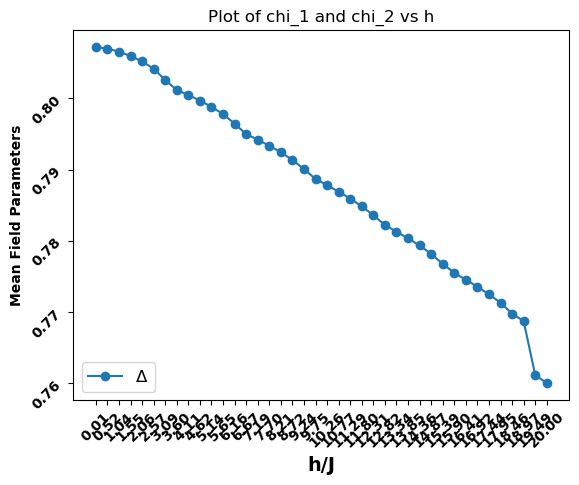

In [70]:
# Plotting
plt.plot(h_values, chi_1_values_r, 'o-', label='$\Delta$')

# Select which h values to display on the x-axis
h_ticks = [h_values[i] for i in range(0, len(h_values), 1)]
h_labels = [f'{value:.2f}' for value in h_ticks]

# Labels and legend
plt.xlabel('h/J', fontsize=14, fontweight='bold')
plt.ylabel('Mean Field Parameters', fontsize=10, fontweight='bold')
plt.xticks(h_ticks, h_labels, rotation=45, fontweight='bold')
plt.yticks(rotation=45, fontweight='bold')
plt.legend(fontsize=12, loc='lower left')
plt.title('Plot of chi_1 and chi_2 vs h')

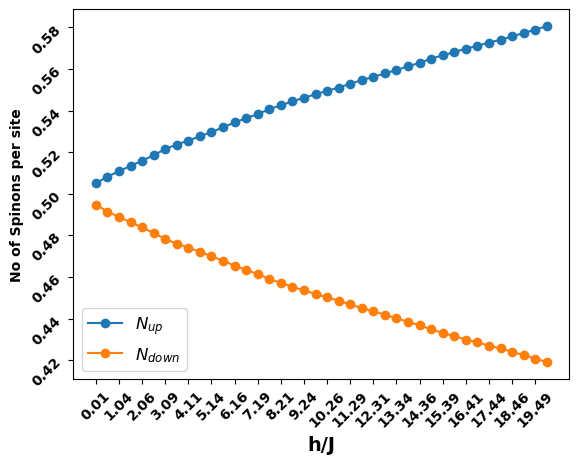

In [71]:
# Plotting
plt.plot(h_values, Number_new_1_values, 'o-', label='$N_{up}$')
plt.plot(h_values, Number_new_2_values, 'o-', label='$N_{down}$')

# Select which h values to display on the x-axis
h_ticks = [h_values[i] for i in range(0, len(h_values), 2)]
h_labels = [f'{value:.2f}' for value in h_ticks]

# Labels and legend
plt.xlabel('h/J', fontsize=14, fontweight='bold')
plt.ylabel('No of Spinons per site', fontsize=10, fontweight='bold')
plt.xticks(h_ticks, h_labels, rotation=45, fontweight='bold')
plt.yticks(rotation=45, fontweight='bold')
plt.legend(fontsize=12, loc='lower left')
# plt.title('Plot of chi_1 and chi_2 vs h')

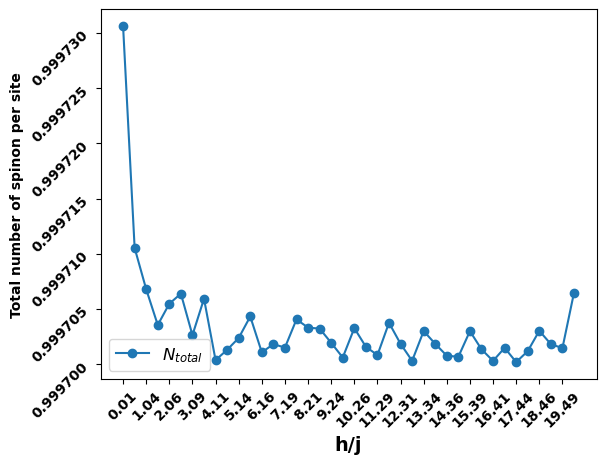

In [72]:
plt.plot(h_values, total, 'o-', label='$N_{total}$')

# Select which h values to display on the x-axis
h_ticks = [h_values[i] for i in range(0, len(h_values), 2)]
h_labels = [f'{value:.2f}' for value in h_ticks]

# Labels and legend
plt.xlabel('h/j', fontsize=14, fontweight='bold')
plt.ylabel('Total number of spinon per site', fontsize=10, fontweight='bold')
plt.xticks(h_ticks, h_labels, rotation=45, fontweight='bold')
plt.yticks(rotation=45, fontweight='bold')
plt.legend(fontsize=12, loc='lower left')
# plt.ylim(0, 1)

(array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
        0.018]),
 [Text(0, 0.0, '0.000'),
  Text(0, 0.002, '0.002'),
  Text(0, 0.004, '0.004'),
  Text(0, 0.006, '0.006'),
  Text(0, 0.008, '0.008'),
  Text(0, 0.01, '0.010'),
  Text(0, 0.012, '0.012'),
  Text(0, 0.014, '0.014'),
  Text(0, 0.016, '0.016'),
  Text(0, 0.018000000000000002, '0.018')])

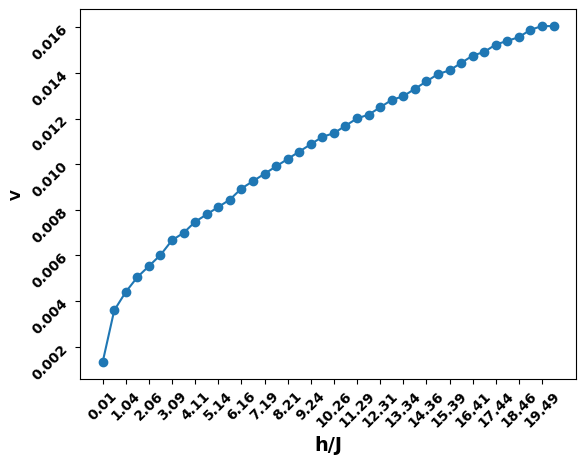

In [73]:
plt.plot(h_values, mu_t, 'o-')

# Select which h values to display on the x-axis
h_ticks = [h_values[i] for i in range(0, len(h_values), 2)]
h_labels = [f'{value:.2f}' for value in h_ticks]

# Labels and legend
plt.xlabel('h/J', fontsize=14, fontweight='bold')
plt.ylabel('V', fontsize=10, fontweight='bold')
plt.xticks(h_ticks, h_labels, rotation=45, fontweight='bold')
plt.yticks(rotation=45, fontweight='bold')
# plt.legend(fontsize=12, loc='lower left')
# plt.ylim(0, 1)

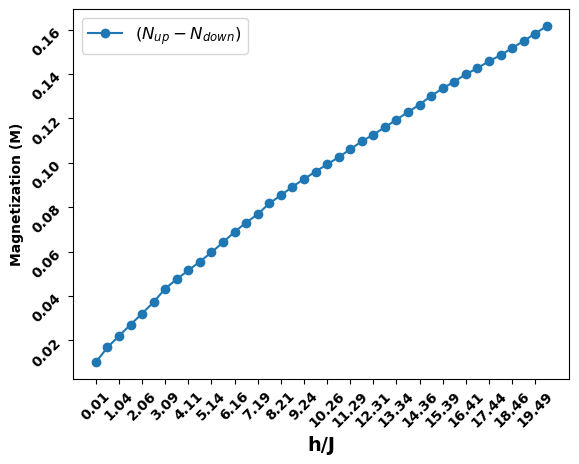

In [74]:
# Subtracting the lists element-wise
result_values = [Number_new_1_values - Number_new_2_values for Number_new_1_values, Number_new_2_values in zip(Number_new_1_values, Number_new_2_values)]
plt.plot(h_values, result_values, 'o-', label='$(N_{up} - N_{down})$')
h_ticks = [h_values[i] for i in range(0, len(h_values), 2)]
h_labels = [f'{value:.2f}' for value in h_ticks]

# Labels and legend
plt.xlabel('h/J', fontsize=14, fontweight='bold')
plt.ylabel('Magnetization (M)', fontsize=10, fontweight='bold')
plt.xticks(h_ticks, h_labels, rotation=45, fontweight='bold')
plt.yticks(rotation=45, fontweight='bold')
plt.legend(fontsize=12, loc='upper left')

(array([0.005, 0.006, 0.007, 0.008, 0.009, 0.01 , 0.011, 0.012, 0.013,
        0.014]),
 [Text(0, 0.005, '0.005'),
  Text(0, 0.006, '0.006'),
  Text(0, 0.007, '0.007'),
  Text(0, 0.008, '0.008'),
  Text(0, 0.009000000000000001, '0.009'),
  Text(0, 0.01, '0.010'),
  Text(0, 0.011, '0.011'),
  Text(0, 0.012, '0.012'),
  Text(0, 0.013000000000000001, '0.013'),
  Text(0, 0.014000000000000002, '0.014')])

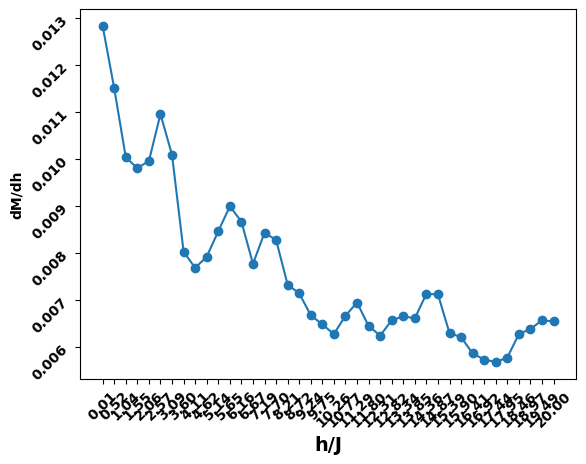

In [75]:
# Compute the numerical derivative of result_values w.r.t h_values
derivative_values = np.gradient(result_values, h_values)
plt.plot(h_values, derivative_values, 'o-')
h_ticks = [h_values[i] for i in range(0, len(h_values), 1)]
h_labels = [f'{value:.2f}' for value in h_ticks]

# Labels and legend
plt.xlabel('h/J', fontsize=14, fontweight='bold')
plt.ylabel('dM/dh', fontsize=10, fontweight='bold')
plt.xticks(h_ticks, h_labels, rotation=45, fontweight='bold')
plt.yticks(rotation=45, fontweight='bold')
# plt.legend(fontsize=12, loc='upper left')

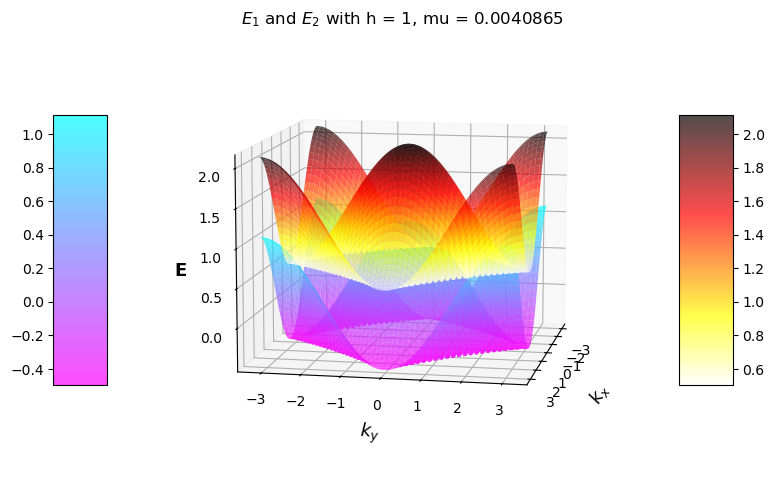

In [15]:
# parametrs
import numpy as np
import matplotlib.pyplot as plt 
J = 1 
chi_1 = 0.8066091757245631
# chi_2 = (0.4051555809762227+0.00031150554097031727j)
h = 1
mu = .0040865
# Create k_x and k_y
k_x = np.linspace(-np.pi, np.pi, 100)
k_y = np.linspace(-np.pi, np.pi, 100)

# Create meshgrid for k_x and k_y
K_x, K_y = np.meshgrid(k_x, k_y)

# Calculate E
E_1 = np.sqrt(mu**2 + (J*(np.cos(K_x) + np.cos(K_y))*abs(chi_1))**2) - h/2
E_2 = np.sqrt(mu**2 + (J*(np.cos(K_x) + np.cos(K_y))*abs(chi_1))**2) + h/2

# Plot E_1 and E_2 in the same graph
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot E_1
surf1 = ax.plot_surface(K_x, K_y, E_1, cmap='cool_r', alpha=0.7, label='E_1')

# Plot E_2
surf2 = ax.plot_surface(K_x, K_y, E_2, cmap='hot_r', alpha=0.7, label='E_2')

# Adding labels and title
ax.set_title(f'$E_1$ and $E_2$ with h = {h}, mu = {mu}')
ax.set_xlabel('$k_x$', labelpad=10, fontsize=13, rotation=150, fontweight='bold')
ax.set_ylabel('$k_y$', labelpad=10, fontsize=13, rotation=150, fontweight='bold')
ax.set_zlabel('E', fontsize=13, rotation=0, fontweight='bold')
ax.view_init(10, 11)
# Adding colorbars for each surface plot
fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=5, pad=0.1, location='left')
fig.colorbar(surf2, ax=ax, shrink=0.5, aspect=5, pad=0.1, location='right')
# plt.legend(fontsize=12, loc='upper left')
plt.show()